<h2>Training Googlenet on CIFAR-100<h2>
<pre>
<i>
[1] 'Going Deeper with Convolutions', Szegedy et al. (2015)
    <a href='https://arxiv.org/abs/1409.4842'>https://arxiv.org/abs/1409.4842</a>
</i>
</pre>

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
import argparse
import time
from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

<h3>Hyperparameter Settings</h3>

In [3]:
batchsize = 128
max_epochs = 200
l_r = 0.1
w = 1

<h3>Loading and preprocessing data:</h3>
<p>Let us calculate the mean and standard deviation of the dataset. We'll use this in the transforms later.</p>

In [4]:
def compute_mean_std(dataset):
    
    data_r = np.dstack([np.array(im)[:, :, 0]/255 for im,label in dataset])
    data_g = np.dstack([np.array(im)[:, :, 1]/255 for im,label in dataset])
    data_b = np.dstack([np.array(im)[:, :, 2]/255 for im,label in dataset])
    
    mean = [np.asscalar(np.mean(data_r)), np.asscalar(np.mean(data_g)), np.asscalar(np.mean(data_b))]
    std = [np.asscalar(np.std(data_r)), np.asscalar(np.std(data_g)), np.asscalar(np.std(data_b))]
    
    return mean,std

In [ ]:
#cifar_norm_train=datasets.CIFAR100(data_dir, train=True, transform=None, target_transform=None, download=False)
#cifar_norm_test=datasets.CIFAR100(data_dir, train=False, transform=None, target_transform=None, download=False)
#train_mean,train_std = compute_mean_std(cifar_norm_train)
#test_mean, test_std = compute_mean_std(cifar_norm_test)
#print(train_mean,train_std)
#print(test_mean,test_std)

No need to calculate the above multiple times, by saving the mean/std values.

In [5]:
train_mean,train_std = [0.5070751592371341, 0.48654887331495067, 0.4409178433670344],[0.2673342858792403, 0.2564384629170882, 0.27615047132568393]
test_mean, test_std = [0.508796412760417, 0.48739301317401906, 0.4419422112438727],[0.2682515741720801, 0.25736373644781246, 0.2770957707973041]

Padding with 4 zeros, taking 32 by 32 crops, random flipping and normalization by values found above.

In [6]:
train_transforms = transforms.Compose([transforms.Pad(4,fill=0),
                                     transforms.RandomResizedCrop(32),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(train_mean,train_std)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(test_mean,test_std)])

In [7]:
data_dir='../input/cifar-100-python/'
cifar_train=datasets.CIFAR100(data_dir, train=True, transform=train_transforms, target_transform=None, download=False)
cifar_test=datasets.CIFAR100(data_dir, train=False, transform=test_transforms, target_transform=None, download=False)

In [8]:
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batchsize, shuffle=True)

<h3>Visualizing CIFAR</h3>
<p>Just to see what's actually in there.</p>

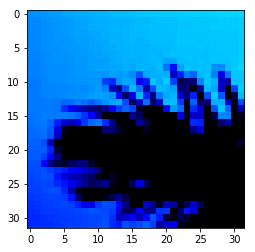

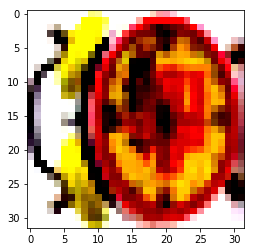

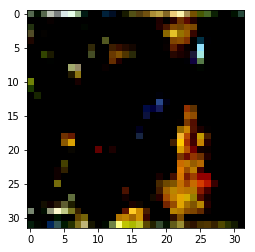

In [18]:
for inputs,labels in testloader:
    break
images = inputs.numpy()
for i in range(3):
    plt.figure()
    plt.imshow(images[i].T)

<h2>Training</h2>

In [9]:
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [14]:
def train(epoch):
    net.train()
    
    for batch_index, (images, labels) in enumerate(trainloader):
        if epoch <= w:
            warmup_scheduler.step()
            print('warmed up')
        
        print('start')
        images = Variable(images)
        labels = Variable(labels)
        
        labels = labels.cuda()
        images = images.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
            loss.item(),
            optimizer.param_groups[0]['lr'],
            epoch=epoch,
            trained_samples=batch_index * batchsize + len(images),
            total_samples=len(trainloader.dataset))
        )


In [12]:
net = models.googlenet()
print(net.fc)
net.fc = nn.Linear(1024,100)
print(net.fc)

Linear(in_features=1024, out_features=1000, bias=True)
Linear(in_features=1024, out_features=100, bias=True)


In [15]:
net = net.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
iter_per_epoch = len(trainloader)
warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * w)

start = time.time()
for epoch in range(1,max_epochs):
    if epoch > 1:
         train_scheduler.step(epoch)
    train(epoch)
end = time.time()
print('Trained in: ',str(end-start))
#acc = eval_training(epoch)
    

warmed up
start
Training Epoch: 1 [128/50000]	Loss: 4.6319	LR: 0.000256
warmed up
start
Training Epoch: 1 [256/50000]	Loss: 4.7031	LR: 0.000512
warmed up
start
Training Epoch: 1 [384/50000]	Loss: 4.7007	LR: 0.000767
warmed up
start
Training Epoch: 1 [512/50000]	Loss: 4.6953	LR: 0.001023
warmed up
start
Training Epoch: 1 [640/50000]	Loss: 4.6782	LR: 0.001279
warmed up
start
Training Epoch: 1 [768/50000]	Loss: 4.6596	LR: 0.001535
warmed up
start
Training Epoch: 1 [896/50000]	Loss: 4.6494	LR: 0.001790
warmed up
start
Training Epoch: 1 [1024/50000]	Loss: 4.6451	LR: 0.002046
warmed up
start
Training Epoch: 1 [1152/50000]	Loss: 4.6765	LR: 0.002302
warmed up
start
Training Epoch: 1 [1280/50000]	Loss: 4.7162	LR: 0.002558
warmed up
start
Training Epoch: 1 [1408/50000]	Loss: 4.7144	LR: 0.002813
warmed up
start
Training Epoch: 1 [1536/50000]	Loss: 4.6915	LR: 0.003069
warmed up
start
Training Epoch: 1 [1664/50000]	Loss: 4.6777	LR: 0.003325
warmed up
start
Training Epoch: 1 [1792/50000]	Loss: 4.574

warmed up
start
Training Epoch: 1 [14592/50000]	Loss: 4.5991	LR: 0.029156
warmed up
start
Training Epoch: 1 [14720/50000]	Loss: 4.7181	LR: 0.029412
warmed up
start
Training Epoch: 1 [14848/50000]	Loss: 4.9294	LR: 0.029668
warmed up
start
Training Epoch: 1 [14976/50000]	Loss: 4.3638	LR: 0.029923
warmed up
start
Training Epoch: 1 [15104/50000]	Loss: 4.3781	LR: 0.030179
warmed up
start
Training Epoch: 1 [15232/50000]	Loss: 4.6552	LR: 0.030435
warmed up
start
Training Epoch: 1 [15360/50000]	Loss: 4.6000	LR: 0.030691
warmed up
start
Training Epoch: 1 [15488/50000]	Loss: 4.6156	LR: 0.030946
warmed up
start
Training Epoch: 1 [15616/50000]	Loss: 4.3570	LR: 0.031202
warmed up
start
Training Epoch: 1 [15744/50000]	Loss: 4.7114	LR: 0.031458
warmed up
start
Training Epoch: 1 [15872/50000]	Loss: 4.3929	LR: 0.031714
warmed up
start
Training Epoch: 1 [16000/50000]	Loss: 4.6620	LR: 0.031969
warmed up
start
Training Epoch: 1 [16128/50000]	Loss: 4.8554	LR: 0.032225
warmed up
start
Training Epoch: 1 [162

warmed up
start
Training Epoch: 1 [29056/50000]	Loss: 4.5431	LR: 0.058056
warmed up
start
Training Epoch: 1 [29184/50000]	Loss: 4.4279	LR: 0.058312
warmed up
start
Training Epoch: 1 [29312/50000]	Loss: 4.4821	LR: 0.058568
warmed up
start
Training Epoch: 1 [29440/50000]	Loss: 4.4345	LR: 0.058824
warmed up
start
Training Epoch: 1 [29568/50000]	Loss: 4.4774	LR: 0.059079
warmed up
start
Training Epoch: 1 [29696/50000]	Loss: 4.4341	LR: 0.059335
warmed up
start
Training Epoch: 1 [29824/50000]	Loss: 4.5064	LR: 0.059591
warmed up
start
Training Epoch: 1 [29952/50000]	Loss: 4.7263	LR: 0.059847
warmed up
start
Training Epoch: 1 [30080/50000]	Loss: 4.4774	LR: 0.060102
warmed up
start
Training Epoch: 1 [30208/50000]	Loss: 4.5949	LR: 0.060358
warmed up
start
Training Epoch: 1 [30336/50000]	Loss: 4.4348	LR: 0.060614
warmed up
start
Training Epoch: 1 [30464/50000]	Loss: 4.5750	LR: 0.060870
warmed up
start
Training Epoch: 1 [30592/50000]	Loss: 4.4923	LR: 0.061125
warmed up
start
Training Epoch: 1 [307

warmed up
start
Training Epoch: 1 [43392/50000]	Loss: 4.3615	LR: 0.086701
warmed up
start
Training Epoch: 1 [43520/50000]	Loss: 4.3712	LR: 0.086957
warmed up
start
Training Epoch: 1 [43648/50000]	Loss: 4.4007	LR: 0.087212
warmed up
start
Training Epoch: 1 [43776/50000]	Loss: 4.6161	LR: 0.087468
warmed up
start
Training Epoch: 1 [43904/50000]	Loss: 4.2524	LR: 0.087724
warmed up
start
Training Epoch: 1 [44032/50000]	Loss: 4.6857	LR: 0.087980
warmed up
start
Training Epoch: 1 [44160/50000]	Loss: 4.5864	LR: 0.088235
warmed up
start
Training Epoch: 1 [44288/50000]	Loss: 4.3048	LR: 0.088491
warmed up
start
Training Epoch: 1 [44416/50000]	Loss: 4.2914	LR: 0.088747
warmed up
start
Training Epoch: 1 [44544/50000]	Loss: 4.6693	LR: 0.089003
warmed up
start
Training Epoch: 1 [44672/50000]	Loss: 4.6356	LR: 0.089258
warmed up
start
Training Epoch: 1 [44800/50000]	Loss: 4.3536	LR: 0.089514
warmed up
start
Training Epoch: 1 [44928/50000]	Loss: 4.5102	LR: 0.089770
warmed up
start
Training Epoch: 1 [450

start
Training Epoch: 2 [8960/50000]	Loss: 3.9792	LR: 0.100000
start
Training Epoch: 2 [9088/50000]	Loss: 4.3674	LR: 0.100000
start
Training Epoch: 2 [9216/50000]	Loss: 4.0834	LR: 0.100000
start
Training Epoch: 2 [9344/50000]	Loss: 3.9904	LR: 0.100000
start
Training Epoch: 2 [9472/50000]	Loss: 4.2170	LR: 0.100000
start
Training Epoch: 2 [9600/50000]	Loss: 4.0800	LR: 0.100000
start
Training Epoch: 2 [9728/50000]	Loss: 4.1438	LR: 0.100000
start
Training Epoch: 2 [9856/50000]	Loss: 4.2068	LR: 0.100000
start
Training Epoch: 2 [9984/50000]	Loss: 4.1147	LR: 0.100000
start
Training Epoch: 2 [10112/50000]	Loss: 4.1604	LR: 0.100000
start
Training Epoch: 2 [10240/50000]	Loss: 4.2094	LR: 0.100000
start
Training Epoch: 2 [10368/50000]	Loss: 4.0837	LR: 0.100000
start
Training Epoch: 2 [10496/50000]	Loss: 4.1235	LR: 0.100000
start
Training Epoch: 2 [10624/50000]	Loss: 4.1842	LR: 0.100000
start
Training Epoch: 2 [10752/50000]	Loss: 4.0847	LR: 0.100000
start
Training Epoch: 2 [10880/50000]	Loss: 4.126

Training Epoch: 2 [25472/50000]	Loss: 4.0288	LR: 0.100000
start
Training Epoch: 2 [25600/50000]	Loss: 4.0429	LR: 0.100000
start
Training Epoch: 2 [25728/50000]	Loss: 3.9651	LR: 0.100000
start
Training Epoch: 2 [25856/50000]	Loss: 3.9473	LR: 0.100000
start
Training Epoch: 2 [25984/50000]	Loss: 4.0026	LR: 0.100000
start
Training Epoch: 2 [26112/50000]	Loss: 3.9200	LR: 0.100000
start
Training Epoch: 2 [26240/50000]	Loss: 4.0961	LR: 0.100000
start
Training Epoch: 2 [26368/50000]	Loss: 4.1254	LR: 0.100000
start
Training Epoch: 2 [26496/50000]	Loss: 4.0174	LR: 0.100000
start
Training Epoch: 2 [26624/50000]	Loss: 4.1193	LR: 0.100000
start
Training Epoch: 2 [26752/50000]	Loss: 4.0937	LR: 0.100000
start
Training Epoch: 2 [26880/50000]	Loss: 4.1218	LR: 0.100000
start
Training Epoch: 2 [27008/50000]	Loss: 3.9499	LR: 0.100000
start
Training Epoch: 2 [27136/50000]	Loss: 3.9772	LR: 0.100000
start
Training Epoch: 2 [27264/50000]	Loss: 3.9931	LR: 0.100000
start
Training Epoch: 2 [27392/50000]	Loss: 4.

Training Epoch: 2 [42112/50000]	Loss: 4.0220	LR: 0.100000
start
Training Epoch: 2 [42240/50000]	Loss: 4.0005	LR: 0.100000
start
Training Epoch: 2 [42368/50000]	Loss: 3.9079	LR: 0.100000
start
Training Epoch: 2 [42496/50000]	Loss: 3.8904	LR: 0.100000
start
Training Epoch: 2 [42624/50000]	Loss: 3.9803	LR: 0.100000
start
Training Epoch: 2 [42752/50000]	Loss: 4.0670	LR: 0.100000
start
Training Epoch: 2 [42880/50000]	Loss: 4.0277	LR: 0.100000
start
Training Epoch: 2 [43008/50000]	Loss: 3.8561	LR: 0.100000
start
Training Epoch: 2 [43136/50000]	Loss: 3.8244	LR: 0.100000
start
Training Epoch: 2 [43264/50000]	Loss: 4.0149	LR: 0.100000
start
Training Epoch: 2 [43392/50000]	Loss: 4.1380	LR: 0.100000
start
Training Epoch: 2 [43520/50000]	Loss: 4.1270	LR: 0.100000
start
Training Epoch: 2 [43648/50000]	Loss: 3.9305	LR: 0.100000
start
Training Epoch: 2 [43776/50000]	Loss: 4.0485	LR: 0.100000
start
Training Epoch: 2 [43904/50000]	Loss: 4.0975	LR: 0.100000
start
Training Epoch: 2 [44032/50000]	Loss: 3.

Training Epoch: 3 [8832/50000]	Loss: 3.9701	LR: 0.100000
start
Training Epoch: 3 [8960/50000]	Loss: 3.8911	LR: 0.100000
start
Training Epoch: 3 [9088/50000]	Loss: 3.9696	LR: 0.100000
start
Training Epoch: 3 [9216/50000]	Loss: 3.9082	LR: 0.100000
start
Training Epoch: 3 [9344/50000]	Loss: 3.9690	LR: 0.100000
start
Training Epoch: 3 [9472/50000]	Loss: 3.8104	LR: 0.100000
start
Training Epoch: 3 [9600/50000]	Loss: 4.0445	LR: 0.100000
start
Training Epoch: 3 [9728/50000]	Loss: 4.1356	LR: 0.100000
start
Training Epoch: 3 [9856/50000]	Loss: 3.9768	LR: 0.100000
start
Training Epoch: 3 [9984/50000]	Loss: 3.9445	LR: 0.100000
start
Training Epoch: 3 [10112/50000]	Loss: 3.9871	LR: 0.100000
start
Training Epoch: 3 [10240/50000]	Loss: 3.9305	LR: 0.100000
start
Training Epoch: 3 [10368/50000]	Loss: 3.8944	LR: 0.100000
start
Training Epoch: 3 [10496/50000]	Loss: 4.0211	LR: 0.100000
start
Training Epoch: 3 [10624/50000]	Loss: 4.0095	LR: 0.100000
start
Training Epoch: 3 [10752/50000]	Loss: 4.0295	LR: 0

start
Training Epoch: 3 [25344/50000]	Loss: 3.8597	LR: 0.100000
start
Training Epoch: 3 [25472/50000]	Loss: 3.9303	LR: 0.100000
start
Training Epoch: 3 [25600/50000]	Loss: 4.1426	LR: 0.100000
start
Training Epoch: 3 [25728/50000]	Loss: 4.0037	LR: 0.100000
start
Training Epoch: 3 [25856/50000]	Loss: 4.0668	LR: 0.100000
start
Training Epoch: 3 [25984/50000]	Loss: 3.9295	LR: 0.100000
start
Training Epoch: 3 [26112/50000]	Loss: 3.7191	LR: 0.100000
start
Training Epoch: 3 [26240/50000]	Loss: 4.0217	LR: 0.100000
start
Training Epoch: 3 [26368/50000]	Loss: 3.9241	LR: 0.100000
start
Training Epoch: 3 [26496/50000]	Loss: 3.9293	LR: 0.100000
start
Training Epoch: 3 [26624/50000]	Loss: 3.8875	LR: 0.100000
start
Training Epoch: 3 [26752/50000]	Loss: 3.8940	LR: 0.100000
start
Training Epoch: 3 [26880/50000]	Loss: 3.9573	LR: 0.100000
start
Training Epoch: 3 [27008/50000]	Loss: 3.9013	LR: 0.100000
start
Training Epoch: 3 [27136/50000]	Loss: 3.8498	LR: 0.100000
start
Training Epoch: 3 [27264/50000]	Lo

Training Epoch: 3 [41984/50000]	Loss: 3.9454	LR: 0.100000
start
Training Epoch: 3 [42112/50000]	Loss: 3.8306	LR: 0.100000
start
Training Epoch: 3 [42240/50000]	Loss: 3.9460	LR: 0.100000
start
Training Epoch: 3 [42368/50000]	Loss: 3.8950	LR: 0.100000
start
Training Epoch: 3 [42496/50000]	Loss: 3.7848	LR: 0.100000
start
Training Epoch: 3 [42624/50000]	Loss: 3.8651	LR: 0.100000
start
Training Epoch: 3 [42752/50000]	Loss: 4.0195	LR: 0.100000
start
Training Epoch: 3 [42880/50000]	Loss: 3.9512	LR: 0.100000
start
Training Epoch: 3 [43008/50000]	Loss: 3.9724	LR: 0.100000
start
Training Epoch: 3 [43136/50000]	Loss: 3.9699	LR: 0.100000
start
Training Epoch: 3 [43264/50000]	Loss: 3.9204	LR: 0.100000
start
Training Epoch: 3 [43392/50000]	Loss: 4.2294	LR: 0.100000
start
Training Epoch: 3 [43520/50000]	Loss: 3.8762	LR: 0.100000
start
Training Epoch: 3 [43648/50000]	Loss: 4.1210	LR: 0.100000
start
Training Epoch: 3 [43776/50000]	Loss: 3.9760	LR: 0.100000
start
Training Epoch: 3 [43904/50000]	Loss: 3.

Training Epoch: 4 [8704/50000]	Loss: 3.9196	LR: 0.100000
start
Training Epoch: 4 [8832/50000]	Loss: 3.9254	LR: 0.100000
start
Training Epoch: 4 [8960/50000]	Loss: 3.7376	LR: 0.100000
start
Training Epoch: 4 [9088/50000]	Loss: 3.8117	LR: 0.100000
start
Training Epoch: 4 [9216/50000]	Loss: 3.6861	LR: 0.100000
start
Training Epoch: 4 [9344/50000]	Loss: 3.9681	LR: 0.100000
start
Training Epoch: 4 [9472/50000]	Loss: 3.8827	LR: 0.100000
start
Training Epoch: 4 [9600/50000]	Loss: 3.7511	LR: 0.100000
start
Training Epoch: 4 [9728/50000]	Loss: 3.9031	LR: 0.100000
start
Training Epoch: 4 [9856/50000]	Loss: 3.8070	LR: 0.100000
start
Training Epoch: 4 [9984/50000]	Loss: 4.0459	LR: 0.100000
start
Training Epoch: 4 [10112/50000]	Loss: 3.9008	LR: 0.100000
start
Training Epoch: 4 [10240/50000]	Loss: 3.9633	LR: 0.100000
start
Training Epoch: 4 [10368/50000]	Loss: 3.9728	LR: 0.100000
start
Training Epoch: 4 [10496/50000]	Loss: 3.7925	LR: 0.100000
start
Training Epoch: 4 [10624/50000]	Loss: 3.7982	LR: 0.

Training Epoch: 4 [25216/50000]	Loss: 3.9239	LR: 0.100000
start
Training Epoch: 4 [25344/50000]	Loss: 3.7750	LR: 0.100000
start
Training Epoch: 4 [25472/50000]	Loss: 3.7381	LR: 0.100000
start
Training Epoch: 4 [25600/50000]	Loss: 3.9139	LR: 0.100000
start
Training Epoch: 4 [25728/50000]	Loss: 3.8279	LR: 0.100000
start
Training Epoch: 4 [25856/50000]	Loss: 3.7219	LR: 0.100000
start
Training Epoch: 4 [25984/50000]	Loss: 3.8321	LR: 0.100000
start
Training Epoch: 4 [26112/50000]	Loss: 3.8569	LR: 0.100000
start
Training Epoch: 4 [26240/50000]	Loss: 3.8588	LR: 0.100000
start
Training Epoch: 4 [26368/50000]	Loss: 3.9493	LR: 0.100000
start
Training Epoch: 4 [26496/50000]	Loss: 3.8170	LR: 0.100000
start
Training Epoch: 4 [26624/50000]	Loss: 4.0269	LR: 0.100000
start
Training Epoch: 4 [26752/50000]	Loss: 3.7472	LR: 0.100000
start
Training Epoch: 4 [26880/50000]	Loss: 3.8295	LR: 0.100000
start
Training Epoch: 4 [27008/50000]	Loss: 3.9214	LR: 0.100000
start
Training Epoch: 4 [27136/50000]	Loss: 3.

start
Training Epoch: 4 [41984/50000]	Loss: 3.7001	LR: 0.100000
start
Training Epoch: 4 [42112/50000]	Loss: 3.9591	LR: 0.100000
start
Training Epoch: 4 [42240/50000]	Loss: 3.7759	LR: 0.100000
start
Training Epoch: 4 [42368/50000]	Loss: 3.8970	LR: 0.100000
start
Training Epoch: 4 [42496/50000]	Loss: 3.6776	LR: 0.100000
start
Training Epoch: 4 [42624/50000]	Loss: 4.0616	LR: 0.100000
start
Training Epoch: 4 [42752/50000]	Loss: 3.8785	LR: 0.100000
start
Training Epoch: 4 [42880/50000]	Loss: 3.8156	LR: 0.100000
start
Training Epoch: 4 [43008/50000]	Loss: 3.8524	LR: 0.100000
start
Training Epoch: 4 [43136/50000]	Loss: 3.8080	LR: 0.100000
start
Training Epoch: 4 [43264/50000]	Loss: 3.9056	LR: 0.100000
start
Training Epoch: 4 [43392/50000]	Loss: 3.8356	LR: 0.100000
start
Training Epoch: 4 [43520/50000]	Loss: 3.7036	LR: 0.100000
start
Training Epoch: 4 [43648/50000]	Loss: 3.8685	LR: 0.100000
start
Training Epoch: 4 [43776/50000]	Loss: 3.7861	LR: 0.100000
start
Training Epoch: 4 [43904/50000]	Lo

start
Training Epoch: 5 [8704/50000]	Loss: 3.9042	LR: 0.100000
start
Training Epoch: 5 [8832/50000]	Loss: 3.8473	LR: 0.100000
start
Training Epoch: 5 [8960/50000]	Loss: 3.7548	LR: 0.100000
start
Training Epoch: 5 [9088/50000]	Loss: 3.7672	LR: 0.100000
start
Training Epoch: 5 [9216/50000]	Loss: 3.7925	LR: 0.100000
start
Training Epoch: 5 [9344/50000]	Loss: 3.6556	LR: 0.100000
start
Training Epoch: 5 [9472/50000]	Loss: 3.6812	LR: 0.100000
start
Training Epoch: 5 [9600/50000]	Loss: 3.6730	LR: 0.100000
start
Training Epoch: 5 [9728/50000]	Loss: 3.5800	LR: 0.100000
start
Training Epoch: 5 [9856/50000]	Loss: 3.7257	LR: 0.100000
start
Training Epoch: 5 [9984/50000]	Loss: 3.6324	LR: 0.100000
start
Training Epoch: 5 [10112/50000]	Loss: 3.9118	LR: 0.100000
start
Training Epoch: 5 [10240/50000]	Loss: 3.6685	LR: 0.100000
start
Training Epoch: 5 [10368/50000]	Loss: 3.9675	LR: 0.100000
start
Training Epoch: 5 [10496/50000]	Loss: 3.9114	LR: 0.100000
start
Training Epoch: 5 [10624/50000]	Loss: 3.6191	

start
Training Epoch: 5 [25344/50000]	Loss: 3.6581	LR: 0.100000
start
Training Epoch: 5 [25472/50000]	Loss: 3.7510	LR: 0.100000
start
Training Epoch: 5 [25600/50000]	Loss: 3.5868	LR: 0.100000
start
Training Epoch: 5 [25728/50000]	Loss: 3.6809	LR: 0.100000
start
Training Epoch: 5 [25856/50000]	Loss: 3.9859	LR: 0.100000
start
Training Epoch: 5 [25984/50000]	Loss: 3.8492	LR: 0.100000
start
Training Epoch: 5 [26112/50000]	Loss: 3.8609	LR: 0.100000
start
Training Epoch: 5 [26240/50000]	Loss: 3.6498	LR: 0.100000
start
Training Epoch: 5 [26368/50000]	Loss: 3.8820	LR: 0.100000
start
Training Epoch: 5 [26496/50000]	Loss: 3.7780	LR: 0.100000
start
Training Epoch: 5 [26624/50000]	Loss: 3.8798	LR: 0.100000
start
Training Epoch: 5 [26752/50000]	Loss: 3.8918	LR: 0.100000
start
Training Epoch: 5 [26880/50000]	Loss: 3.8415	LR: 0.100000
start
Training Epoch: 5 [27008/50000]	Loss: 3.8161	LR: 0.100000
start
Training Epoch: 5 [27136/50000]	Loss: 3.8579	LR: 0.100000
start
Training Epoch: 5 [27264/50000]	Lo

Training Epoch: 5 [41984/50000]	Loss: 4.0011	LR: 0.100000
start
Training Epoch: 5 [42112/50000]	Loss: 3.8295	LR: 0.100000
start
Training Epoch: 5 [42240/50000]	Loss: 3.7324	LR: 0.100000
start
Training Epoch: 5 [42368/50000]	Loss: 3.8840	LR: 0.100000
start
Training Epoch: 5 [42496/50000]	Loss: 3.4938	LR: 0.100000
start
Training Epoch: 5 [42624/50000]	Loss: 3.9255	LR: 0.100000
start
Training Epoch: 5 [42752/50000]	Loss: 3.7417	LR: 0.100000
start
Training Epoch: 5 [42880/50000]	Loss: 3.6807	LR: 0.100000
start
Training Epoch: 5 [43008/50000]	Loss: 3.8704	LR: 0.100000
start
Training Epoch: 5 [43136/50000]	Loss: 3.8197	LR: 0.100000
start
Training Epoch: 5 [43264/50000]	Loss: 3.6054	LR: 0.100000
start
Training Epoch: 5 [43392/50000]	Loss: 3.6853	LR: 0.100000
start
Training Epoch: 5 [43520/50000]	Loss: 3.8254	LR: 0.100000
start
Training Epoch: 5 [43648/50000]	Loss: 3.5417	LR: 0.100000
start
Training Epoch: 5 [43776/50000]	Loss: 3.8487	LR: 0.100000
start
Training Epoch: 5 [43904/50000]	Loss: 3.

start
Training Epoch: 6 [8704/50000]	Loss: 3.9899	LR: 0.100000
start
Training Epoch: 6 [8832/50000]	Loss: 3.8134	LR: 0.100000
start
Training Epoch: 6 [8960/50000]	Loss: 3.8895	LR: 0.100000
start
Training Epoch: 6 [9088/50000]	Loss: 3.6785	LR: 0.100000
start
Training Epoch: 6 [9216/50000]	Loss: 3.6951	LR: 0.100000
start
Training Epoch: 6 [9344/50000]	Loss: 3.7812	LR: 0.100000
start
Training Epoch: 6 [9472/50000]	Loss: 3.8574	LR: 0.100000
start
Training Epoch: 6 [9600/50000]	Loss: 3.6595	LR: 0.100000
start
Training Epoch: 6 [9728/50000]	Loss: 3.7396	LR: 0.100000
start
Training Epoch: 6 [9856/50000]	Loss: 3.6213	LR: 0.100000
start
Training Epoch: 6 [9984/50000]	Loss: 3.6514	LR: 0.100000
start
Training Epoch: 6 [10112/50000]	Loss: 3.8384	LR: 0.100000
start
Training Epoch: 6 [10240/50000]	Loss: 3.7947	LR: 0.100000
start
Training Epoch: 6 [10368/50000]	Loss: 3.8483	LR: 0.100000
start
Training Epoch: 6 [10496/50000]	Loss: 3.6602	LR: 0.100000
start
Training Epoch: 6 [10624/50000]	Loss: 3.6747	

start
Training Epoch: 6 [25216/50000]	Loss: 3.7351	LR: 0.100000
start
Training Epoch: 6 [25344/50000]	Loss: 3.5805	LR: 0.100000
start
Training Epoch: 6 [25472/50000]	Loss: 3.4380	LR: 0.100000
start
Training Epoch: 6 [25600/50000]	Loss: 3.8973	LR: 0.100000
start
Training Epoch: 6 [25728/50000]	Loss: 3.6763	LR: 0.100000
start
Training Epoch: 6 [25856/50000]	Loss: 3.7350	LR: 0.100000
start
Training Epoch: 6 [25984/50000]	Loss: 3.6230	LR: 0.100000
start
Training Epoch: 6 [26112/50000]	Loss: 3.7840	LR: 0.100000
start
Training Epoch: 6 [26240/50000]	Loss: 3.6936	LR: 0.100000
start
Training Epoch: 6 [26368/50000]	Loss: 3.8292	LR: 0.100000
start
Training Epoch: 6 [26496/50000]	Loss: 3.4405	LR: 0.100000
start
Training Epoch: 6 [26624/50000]	Loss: 3.6747	LR: 0.100000
start
Training Epoch: 6 [26752/50000]	Loss: 3.5955	LR: 0.100000
start
Training Epoch: 6 [26880/50000]	Loss: 3.3791	LR: 0.100000
start
Training Epoch: 6 [27008/50000]	Loss: 3.6467	LR: 0.100000
start
Training Epoch: 6 [27136/50000]	Lo

start
Training Epoch: 6 [41856/50000]	Loss: 3.6810	LR: 0.100000
start
Training Epoch: 6 [41984/50000]	Loss: 3.5841	LR: 0.100000
start
Training Epoch: 6 [42112/50000]	Loss: 3.7346	LR: 0.100000
start
Training Epoch: 6 [42240/50000]	Loss: 3.9041	LR: 0.100000
start
Training Epoch: 6 [42368/50000]	Loss: 3.6250	LR: 0.100000
start
Training Epoch: 6 [42496/50000]	Loss: 3.5875	LR: 0.100000
start
Training Epoch: 6 [42624/50000]	Loss: 3.6963	LR: 0.100000
start
Training Epoch: 6 [42752/50000]	Loss: 3.6588	LR: 0.100000
start
Training Epoch: 6 [42880/50000]	Loss: 3.6491	LR: 0.100000
start
Training Epoch: 6 [43008/50000]	Loss: 3.7257	LR: 0.100000
start
Training Epoch: 6 [43136/50000]	Loss: 3.7347	LR: 0.100000
start
Training Epoch: 6 [43264/50000]	Loss: 3.7871	LR: 0.100000
start
Training Epoch: 6 [43392/50000]	Loss: 3.6895	LR: 0.100000
start
Training Epoch: 6 [43520/50000]	Loss: 3.6850	LR: 0.100000
start
Training Epoch: 6 [43648/50000]	Loss: 3.5129	LR: 0.100000
start
Training Epoch: 6 [43776/50000]	Lo

start
Training Epoch: 7 [8448/50000]	Loss: 3.6413	LR: 0.100000
start
Training Epoch: 7 [8576/50000]	Loss: 3.7682	LR: 0.100000
start
Training Epoch: 7 [8704/50000]	Loss: 3.6843	LR: 0.100000
start
Training Epoch: 7 [8832/50000]	Loss: 3.8551	LR: 0.100000
start
Training Epoch: 7 [8960/50000]	Loss: 3.6111	LR: 0.100000
start
Training Epoch: 7 [9088/50000]	Loss: 3.7566	LR: 0.100000
start
Training Epoch: 7 [9216/50000]	Loss: 3.8096	LR: 0.100000
start
Training Epoch: 7 [9344/50000]	Loss: 3.5281	LR: 0.100000
start
Training Epoch: 7 [9472/50000]	Loss: 3.6737	LR: 0.100000
start
Training Epoch: 7 [9600/50000]	Loss: 3.6889	LR: 0.100000
start
Training Epoch: 7 [9728/50000]	Loss: 3.6444	LR: 0.100000
start
Training Epoch: 7 [9856/50000]	Loss: 3.5317	LR: 0.100000
start
Training Epoch: 7 [9984/50000]	Loss: 3.5128	LR: 0.100000
start
Training Epoch: 7 [10112/50000]	Loss: 3.5302	LR: 0.100000
start
Training Epoch: 7 [10240/50000]	Loss: 3.4687	LR: 0.100000
start
Training Epoch: 7 [10368/50000]	Loss: 3.7868	LR

start
Training Epoch: 7 [25088/50000]	Loss: 3.7791	LR: 0.100000
start
Training Epoch: 7 [25216/50000]	Loss: 3.3561	LR: 0.100000
start
Training Epoch: 7 [25344/50000]	Loss: 3.5267	LR: 0.100000
start
Training Epoch: 7 [25472/50000]	Loss: 3.6710	LR: 0.100000
start
Training Epoch: 7 [25600/50000]	Loss: 3.5517	LR: 0.100000
start
Training Epoch: 7 [25728/50000]	Loss: 3.6751	LR: 0.100000
start
Training Epoch: 7 [25856/50000]	Loss: 3.5579	LR: 0.100000
start
Training Epoch: 7 [25984/50000]	Loss: 3.5996	LR: 0.100000
start
Training Epoch: 7 [26112/50000]	Loss: 3.5384	LR: 0.100000
start
Training Epoch: 7 [26240/50000]	Loss: 3.5802	LR: 0.100000
start
Training Epoch: 7 [26368/50000]	Loss: 3.6333	LR: 0.100000
start
Training Epoch: 7 [26496/50000]	Loss: 3.7648	LR: 0.100000
start
Training Epoch: 7 [26624/50000]	Loss: 3.5994	LR: 0.100000
start
Training Epoch: 7 [26752/50000]	Loss: 3.4711	LR: 0.100000
start
Training Epoch: 7 [26880/50000]	Loss: 3.7737	LR: 0.100000
start
Training Epoch: 7 [27008/50000]	Lo

Training Epoch: 7 [41600/50000]	Loss: 3.5982	LR: 0.100000
start
Training Epoch: 7 [41728/50000]	Loss: 3.6336	LR: 0.100000
start
Training Epoch: 7 [41856/50000]	Loss: 3.5929	LR: 0.100000
start
Training Epoch: 7 [41984/50000]	Loss: 3.6300	LR: 0.100000
start
Training Epoch: 7 [42112/50000]	Loss: 3.4818	LR: 0.100000
start
Training Epoch: 7 [42240/50000]	Loss: 3.7970	LR: 0.100000
start
Training Epoch: 7 [42368/50000]	Loss: 3.4405	LR: 0.100000
start
Training Epoch: 7 [42496/50000]	Loss: 3.6849	LR: 0.100000
start
Training Epoch: 7 [42624/50000]	Loss: 3.5365	LR: 0.100000
start
Training Epoch: 7 [42752/50000]	Loss: 3.4502	LR: 0.100000
start
Training Epoch: 7 [42880/50000]	Loss: 3.6409	LR: 0.100000
start
Training Epoch: 7 [43008/50000]	Loss: 3.6122	LR: 0.100000
start
Training Epoch: 7 [43136/50000]	Loss: 3.4928	LR: 0.100000
start
Training Epoch: 7 [43264/50000]	Loss: 3.6722	LR: 0.100000
start
Training Epoch: 7 [43392/50000]	Loss: 3.7161	LR: 0.100000
start
Training Epoch: 7 [43520/50000]	Loss: 3.

start
Training Epoch: 8 [8192/50000]	Loss: 3.4895	LR: 0.100000
start
Training Epoch: 8 [8320/50000]	Loss: 3.3674	LR: 0.100000
start
Training Epoch: 8 [8448/50000]	Loss: 3.4773	LR: 0.100000
start
Training Epoch: 8 [8576/50000]	Loss: 3.4758	LR: 0.100000
start
Training Epoch: 8 [8704/50000]	Loss: 3.4837	LR: 0.100000
start
Training Epoch: 8 [8832/50000]	Loss: 3.3110	LR: 0.100000
start
Training Epoch: 8 [8960/50000]	Loss: 3.4322	LR: 0.100000
start
Training Epoch: 8 [9088/50000]	Loss: 3.5622	LR: 0.100000
start
Training Epoch: 8 [9216/50000]	Loss: 3.5669	LR: 0.100000
start
Training Epoch: 8 [9344/50000]	Loss: 3.6186	LR: 0.100000
start
Training Epoch: 8 [9472/50000]	Loss: 3.4950	LR: 0.100000
start
Training Epoch: 8 [9600/50000]	Loss: 3.5718	LR: 0.100000
start
Training Epoch: 8 [9728/50000]	Loss: 3.5253	LR: 0.100000
start
Training Epoch: 8 [9856/50000]	Loss: 3.7555	LR: 0.100000
start
Training Epoch: 8 [9984/50000]	Loss: 3.6897	LR: 0.100000
start
Training Epoch: 8 [10112/50000]	Loss: 3.5554	LR: 

start
Training Epoch: 8 [24704/50000]	Loss: 3.6526	LR: 0.100000
start
Training Epoch: 8 [24832/50000]	Loss: 3.3498	LR: 0.100000
start
Training Epoch: 8 [24960/50000]	Loss: 3.5189	LR: 0.100000
start
Training Epoch: 8 [25088/50000]	Loss: 3.5202	LR: 0.100000
start
Training Epoch: 8 [25216/50000]	Loss: 3.5462	LR: 0.100000
start
Training Epoch: 8 [25344/50000]	Loss: 3.4735	LR: 0.100000
start
Training Epoch: 8 [25472/50000]	Loss: 3.5141	LR: 0.100000
start
Training Epoch: 8 [25600/50000]	Loss: 3.4487	LR: 0.100000
start
Training Epoch: 8 [25728/50000]	Loss: 3.5372	LR: 0.100000
start
Training Epoch: 8 [25856/50000]	Loss: 3.4977	LR: 0.100000
start
Training Epoch: 8 [25984/50000]	Loss: 3.8373	LR: 0.100000
start
Training Epoch: 8 [26112/50000]	Loss: 3.4363	LR: 0.100000
start
Training Epoch: 8 [26240/50000]	Loss: 3.7054	LR: 0.100000
start
Training Epoch: 8 [26368/50000]	Loss: 3.4910	LR: 0.100000
start
Training Epoch: 8 [26496/50000]	Loss: 3.4475	LR: 0.100000
start
Training Epoch: 8 [26624/50000]	Lo

start
Training Epoch: 8 [41344/50000]	Loss: 3.4215	LR: 0.100000
start
Training Epoch: 8 [41472/50000]	Loss: 3.2721	LR: 0.100000
start
Training Epoch: 8 [41600/50000]	Loss: 3.4731	LR: 0.100000
start
Training Epoch: 8 [41728/50000]	Loss: 3.5435	LR: 0.100000
start
Training Epoch: 8 [41856/50000]	Loss: 3.4990	LR: 0.100000
start
Training Epoch: 8 [41984/50000]	Loss: 3.4832	LR: 0.100000
start
Training Epoch: 8 [42112/50000]	Loss: 3.3543	LR: 0.100000
start
Training Epoch: 8 [42240/50000]	Loss: 3.5980	LR: 0.100000
start
Training Epoch: 8 [42368/50000]	Loss: 3.6147	LR: 0.100000
start
Training Epoch: 8 [42496/50000]	Loss: 3.5405	LR: 0.100000
start
Training Epoch: 8 [42624/50000]	Loss: 3.4990	LR: 0.100000
start
Training Epoch: 8 [42752/50000]	Loss: 3.6645	LR: 0.100000
start
Training Epoch: 8 [42880/50000]	Loss: 3.5999	LR: 0.100000
start
Training Epoch: 8 [43008/50000]	Loss: 3.4417	LR: 0.100000
start
Training Epoch: 8 [43136/50000]	Loss: 3.4347	LR: 0.100000
start
Training Epoch: 8 [43264/50000]	Lo

start
Training Epoch: 9 [7936/50000]	Loss: 3.5927	LR: 0.100000
start
Training Epoch: 9 [8064/50000]	Loss: 3.5991	LR: 0.100000
start
Training Epoch: 9 [8192/50000]	Loss: 3.5866	LR: 0.100000
start
Training Epoch: 9 [8320/50000]	Loss: 3.4509	LR: 0.100000
start
Training Epoch: 9 [8448/50000]	Loss: 3.5330	LR: 0.100000
start
Training Epoch: 9 [8576/50000]	Loss: 3.4120	LR: 0.100000
start
Training Epoch: 9 [8704/50000]	Loss: 3.4310	LR: 0.100000
start
Training Epoch: 9 [8832/50000]	Loss: 3.2121	LR: 0.100000
start
Training Epoch: 9 [8960/50000]	Loss: 3.5617	LR: 0.100000
start
Training Epoch: 9 [9088/50000]	Loss: 3.5742	LR: 0.100000
start
Training Epoch: 9 [9216/50000]	Loss: 3.6217	LR: 0.100000
start
Training Epoch: 9 [9344/50000]	Loss: 3.5283	LR: 0.100000
start
Training Epoch: 9 [9472/50000]	Loss: 3.5148	LR: 0.100000
start
Training Epoch: 9 [9600/50000]	Loss: 3.4018	LR: 0.100000
start
Training Epoch: 9 [9728/50000]	Loss: 3.6464	LR: 0.100000
start
Training Epoch: 9 [9856/50000]	Loss: 3.6284	LR: 0

Training Epoch: 9 [24448/50000]	Loss: 3.3074	LR: 0.100000
start
Training Epoch: 9 [24576/50000]	Loss: 3.5376	LR: 0.100000
start
Training Epoch: 9 [24704/50000]	Loss: 3.3526	LR: 0.100000
start
Training Epoch: 9 [24832/50000]	Loss: 3.3657	LR: 0.100000
start
Training Epoch: 9 [24960/50000]	Loss: 3.4612	LR: 0.100000
start
Training Epoch: 9 [25088/50000]	Loss: 3.5011	LR: 0.100000
start
Training Epoch: 9 [25216/50000]	Loss: 3.5157	LR: 0.100000
start
Training Epoch: 9 [25344/50000]	Loss: 3.5005	LR: 0.100000
start
Training Epoch: 9 [25472/50000]	Loss: 3.4167	LR: 0.100000
start
Training Epoch: 9 [25600/50000]	Loss: 3.4231	LR: 0.100000
start
Training Epoch: 9 [25728/50000]	Loss: 3.2873	LR: 0.100000
start
Training Epoch: 9 [25856/50000]	Loss: 3.3508	LR: 0.100000
start
Training Epoch: 9 [25984/50000]	Loss: 3.4996	LR: 0.100000
start
Training Epoch: 9 [26112/50000]	Loss: 3.6784	LR: 0.100000
start
Training Epoch: 9 [26240/50000]	Loss: 3.4781	LR: 0.100000
start
Training Epoch: 9 [26368/50000]	Loss: 3.

Training Epoch: 9 [40960/50000]	Loss: 3.4028	LR: 0.100000
start
Training Epoch: 9 [41088/50000]	Loss: 3.3893	LR: 0.100000
start
Training Epoch: 9 [41216/50000]	Loss: 3.3268	LR: 0.100000
start
Training Epoch: 9 [41344/50000]	Loss: 3.5315	LR: 0.100000
start
Training Epoch: 9 [41472/50000]	Loss: 3.4765	LR: 0.100000
start
Training Epoch: 9 [41600/50000]	Loss: 3.3565	LR: 0.100000
start
Training Epoch: 9 [41728/50000]	Loss: 3.5634	LR: 0.100000
start
Training Epoch: 9 [41856/50000]	Loss: 3.2659	LR: 0.100000
start
Training Epoch: 9 [41984/50000]	Loss: 3.4718	LR: 0.100000
start
Training Epoch: 9 [42112/50000]	Loss: 3.3280	LR: 0.100000
start
Training Epoch: 9 [42240/50000]	Loss: 3.4313	LR: 0.100000
start
Training Epoch: 9 [42368/50000]	Loss: 3.5599	LR: 0.100000
start
Training Epoch: 9 [42496/50000]	Loss: 3.4644	LR: 0.100000
start
Training Epoch: 9 [42624/50000]	Loss: 3.4307	LR: 0.100000
start
Training Epoch: 9 [42752/50000]	Loss: 3.6473	LR: 0.100000
start
Training Epoch: 9 [42880/50000]	Loss: 3.

start
Training Epoch: 10 [7552/50000]	Loss: 3.3063	LR: 0.100000
start
Training Epoch: 10 [7680/50000]	Loss: 3.4278	LR: 0.100000
start
Training Epoch: 10 [7808/50000]	Loss: 3.6198	LR: 0.100000
start
Training Epoch: 10 [7936/50000]	Loss: 3.2253	LR: 0.100000
start
Training Epoch: 10 [8064/50000]	Loss: 3.5403	LR: 0.100000
start
Training Epoch: 10 [8192/50000]	Loss: 3.4330	LR: 0.100000
start
Training Epoch: 10 [8320/50000]	Loss: 3.3539	LR: 0.100000
start
Training Epoch: 10 [8448/50000]	Loss: 3.3592	LR: 0.100000
start
Training Epoch: 10 [8576/50000]	Loss: 3.2370	LR: 0.100000
start
Training Epoch: 10 [8704/50000]	Loss: 3.3510	LR: 0.100000
start
Training Epoch: 10 [8832/50000]	Loss: 3.4567	LR: 0.100000
start
Training Epoch: 10 [8960/50000]	Loss: 3.3637	LR: 0.100000
start
Training Epoch: 10 [9088/50000]	Loss: 3.3274	LR: 0.100000
start
Training Epoch: 10 [9216/50000]	Loss: 3.3454	LR: 0.100000
start
Training Epoch: 10 [9344/50000]	Loss: 3.3186	LR: 0.100000
start
Training Epoch: 10 [9472/50000]	Lo

Training Epoch: 10 [23936/50000]	Loss: 3.3165	LR: 0.100000
start
Training Epoch: 10 [24064/50000]	Loss: 3.1581	LR: 0.100000
start
Training Epoch: 10 [24192/50000]	Loss: 3.3817	LR: 0.100000
start
Training Epoch: 10 [24320/50000]	Loss: 3.2678	LR: 0.100000
start
Training Epoch: 10 [24448/50000]	Loss: 3.5089	LR: 0.100000
start
Training Epoch: 10 [24576/50000]	Loss: 3.3476	LR: 0.100000
start
Training Epoch: 10 [24704/50000]	Loss: 3.2509	LR: 0.100000
start
Training Epoch: 10 [24832/50000]	Loss: 3.2193	LR: 0.100000
start
Training Epoch: 10 [24960/50000]	Loss: 3.3354	LR: 0.100000
start
Training Epoch: 10 [25088/50000]	Loss: 3.5136	LR: 0.100000
start
Training Epoch: 10 [25216/50000]	Loss: 3.3941	LR: 0.100000
start
Training Epoch: 10 [25344/50000]	Loss: 3.4740	LR: 0.100000
start
Training Epoch: 10 [25472/50000]	Loss: 3.3623	LR: 0.100000
start
Training Epoch: 10 [25600/50000]	Loss: 3.5303	LR: 0.100000
start
Training Epoch: 10 [25728/50000]	Loss: 3.4513	LR: 0.100000
start
Training Epoch: 10 [25856

Training Epoch: 10 [40192/50000]	Loss: 3.3622	LR: 0.100000
start
Training Epoch: 10 [40320/50000]	Loss: 3.3687	LR: 0.100000
start
Training Epoch: 10 [40448/50000]	Loss: 3.2692	LR: 0.100000
start
Training Epoch: 10 [40576/50000]	Loss: 3.2232	LR: 0.100000
start
Training Epoch: 10 [40704/50000]	Loss: 3.5059	LR: 0.100000
start
Training Epoch: 10 [40832/50000]	Loss: 3.4622	LR: 0.100000
start
Training Epoch: 10 [40960/50000]	Loss: 3.2929	LR: 0.100000
start
Training Epoch: 10 [41088/50000]	Loss: 3.3004	LR: 0.100000
start
Training Epoch: 10 [41216/50000]	Loss: 3.2391	LR: 0.100000
start
Training Epoch: 10 [41344/50000]	Loss: 3.3557	LR: 0.100000
start
Training Epoch: 10 [41472/50000]	Loss: 3.3807	LR: 0.100000
start
Training Epoch: 10 [41600/50000]	Loss: 3.4003	LR: 0.100000
start
Training Epoch: 10 [41728/50000]	Loss: 3.5825	LR: 0.100000
start
Training Epoch: 10 [41856/50000]	Loss: 3.2554	LR: 0.100000
start
Training Epoch: 10 [41984/50000]	Loss: 3.2530	LR: 0.100000
start
Training Epoch: 10 [42112

start
Training Epoch: 11 [6656/50000]	Loss: 3.4313	LR: 0.100000
start
Training Epoch: 11 [6784/50000]	Loss: 3.0534	LR: 0.100000
start
Training Epoch: 11 [6912/50000]	Loss: 3.2141	LR: 0.100000
start
Training Epoch: 11 [7040/50000]	Loss: 3.4328	LR: 0.100000
start
Training Epoch: 11 [7168/50000]	Loss: 3.0303	LR: 0.100000
start
Training Epoch: 11 [7296/50000]	Loss: 3.4586	LR: 0.100000
start
Training Epoch: 11 [7424/50000]	Loss: 3.3526	LR: 0.100000
start
Training Epoch: 11 [7552/50000]	Loss: 3.1407	LR: 0.100000
start
Training Epoch: 11 [7680/50000]	Loss: 3.1469	LR: 0.100000
start
Training Epoch: 11 [7808/50000]	Loss: 3.3290	LR: 0.100000
start
Training Epoch: 11 [7936/50000]	Loss: 3.4317	LR: 0.100000
start
Training Epoch: 11 [8064/50000]	Loss: 3.4397	LR: 0.100000
start
Training Epoch: 11 [8192/50000]	Loss: 3.4310	LR: 0.100000
start
Training Epoch: 11 [8320/50000]	Loss: 3.4735	LR: 0.100000
start
Training Epoch: 11 [8448/50000]	Loss: 3.2284	LR: 0.100000
start
Training Epoch: 11 [8576/50000]	Lo

start
Training Epoch: 11 [23040/50000]	Loss: 3.3779	LR: 0.100000
start
Training Epoch: 11 [23168/50000]	Loss: 3.2169	LR: 0.100000
start
Training Epoch: 11 [23296/50000]	Loss: 3.3806	LR: 0.100000
start
Training Epoch: 11 [23424/50000]	Loss: 3.4064	LR: 0.100000
start
Training Epoch: 11 [23552/50000]	Loss: 3.2590	LR: 0.100000
start
Training Epoch: 11 [23680/50000]	Loss: 3.2424	LR: 0.100000
start
Training Epoch: 11 [23808/50000]	Loss: 3.3631	LR: 0.100000
start
Training Epoch: 11 [23936/50000]	Loss: 3.3877	LR: 0.100000
start
Training Epoch: 11 [24064/50000]	Loss: 3.2072	LR: 0.100000
start
Training Epoch: 11 [24192/50000]	Loss: 3.4140	LR: 0.100000
start
Training Epoch: 11 [24320/50000]	Loss: 3.4604	LR: 0.100000
start
Training Epoch: 11 [24448/50000]	Loss: 3.2217	LR: 0.100000
start
Training Epoch: 11 [24576/50000]	Loss: 3.4212	LR: 0.100000
start
Training Epoch: 11 [24704/50000]	Loss: 3.2246	LR: 0.100000
start
Training Epoch: 11 [24832/50000]	Loss: 3.3998	LR: 0.100000
start
Training Epoch: 11 

start
Training Epoch: 11 [39296/50000]	Loss: 3.4188	LR: 0.100000
start
Training Epoch: 11 [39424/50000]	Loss: 3.3506	LR: 0.100000
start
Training Epoch: 11 [39552/50000]	Loss: 3.3702	LR: 0.100000
start
Training Epoch: 11 [39680/50000]	Loss: 3.1238	LR: 0.100000
start
Training Epoch: 11 [39808/50000]	Loss: 3.1820	LR: 0.100000
start
Training Epoch: 11 [39936/50000]	Loss: 3.2109	LR: 0.100000
start
Training Epoch: 11 [40064/50000]	Loss: 3.3418	LR: 0.100000
start
Training Epoch: 11 [40192/50000]	Loss: 3.2368	LR: 0.100000
start
Training Epoch: 11 [40320/50000]	Loss: 3.2037	LR: 0.100000
start
Training Epoch: 11 [40448/50000]	Loss: 3.3892	LR: 0.100000
start
Training Epoch: 11 [40576/50000]	Loss: 3.2943	LR: 0.100000
start
Training Epoch: 11 [40704/50000]	Loss: 3.0166	LR: 0.100000
start
Training Epoch: 11 [40832/50000]	Loss: 3.2707	LR: 0.100000
start
Training Epoch: 11 [40960/50000]	Loss: 3.3705	LR: 0.100000
start
Training Epoch: 11 [41088/50000]	Loss: 3.4417	LR: 0.100000
start
Training Epoch: 11 

start
Training Epoch: 12 [5760/50000]	Loss: 3.3463	LR: 0.100000
start
Training Epoch: 12 [5888/50000]	Loss: 3.1510	LR: 0.100000
start
Training Epoch: 12 [6016/50000]	Loss: 3.3809	LR: 0.100000
start
Training Epoch: 12 [6144/50000]	Loss: 3.0960	LR: 0.100000
start
Training Epoch: 12 [6272/50000]	Loss: 3.2514	LR: 0.100000
start
Training Epoch: 12 [6400/50000]	Loss: 3.2961	LR: 0.100000
start
Training Epoch: 12 [6528/50000]	Loss: 3.3582	LR: 0.100000
start
Training Epoch: 12 [6656/50000]	Loss: 3.3622	LR: 0.100000
start
Training Epoch: 12 [6784/50000]	Loss: 3.2214	LR: 0.100000
start
Training Epoch: 12 [6912/50000]	Loss: 3.1900	LR: 0.100000
start
Training Epoch: 12 [7040/50000]	Loss: 3.3626	LR: 0.100000
start
Training Epoch: 12 [7168/50000]	Loss: 3.5010	LR: 0.100000
start
Training Epoch: 12 [7296/50000]	Loss: 3.4377	LR: 0.100000
start
Training Epoch: 12 [7424/50000]	Loss: 3.3742	LR: 0.100000
start
Training Epoch: 12 [7552/50000]	Loss: 3.4613	LR: 0.100000
start
Training Epoch: 12 [7680/50000]	Lo

start
Training Epoch: 12 [22144/50000]	Loss: 3.2621	LR: 0.100000
start
Training Epoch: 12 [22272/50000]	Loss: 3.3496	LR: 0.100000
start
Training Epoch: 12 [22400/50000]	Loss: 3.2721	LR: 0.100000
start
Training Epoch: 12 [22528/50000]	Loss: 3.5094	LR: 0.100000
start
Training Epoch: 12 [22656/50000]	Loss: 3.4375	LR: 0.100000
start
Training Epoch: 12 [22784/50000]	Loss: 3.3053	LR: 0.100000
start
Training Epoch: 12 [22912/50000]	Loss: 3.4113	LR: 0.100000
start
Training Epoch: 12 [23040/50000]	Loss: 3.0989	LR: 0.100000
start
Training Epoch: 12 [23168/50000]	Loss: 3.0929	LR: 0.100000
start
Training Epoch: 12 [23296/50000]	Loss: 3.0793	LR: 0.100000
start
Training Epoch: 12 [23424/50000]	Loss: 3.2932	LR: 0.100000
start
Training Epoch: 12 [23552/50000]	Loss: 3.1753	LR: 0.100000
start
Training Epoch: 12 [23680/50000]	Loss: 3.3870	LR: 0.100000
start
Training Epoch: 12 [23808/50000]	Loss: 3.2641	LR: 0.100000
start
Training Epoch: 12 [23936/50000]	Loss: 3.3450	LR: 0.100000
start
Training Epoch: 12 

start
Training Epoch: 12 [38528/50000]	Loss: 3.2767	LR: 0.100000
start
Training Epoch: 12 [38656/50000]	Loss: 3.1420	LR: 0.100000
start
Training Epoch: 12 [38784/50000]	Loss: 3.2364	LR: 0.100000
start
Training Epoch: 12 [38912/50000]	Loss: 3.4030	LR: 0.100000
start
Training Epoch: 12 [39040/50000]	Loss: 3.1816	LR: 0.100000
start
Training Epoch: 12 [39168/50000]	Loss: 3.6039	LR: 0.100000
start
Training Epoch: 12 [39296/50000]	Loss: 3.3920	LR: 0.100000
start
Training Epoch: 12 [39424/50000]	Loss: 3.2182	LR: 0.100000
start
Training Epoch: 12 [39552/50000]	Loss: 3.3934	LR: 0.100000
start
Training Epoch: 12 [39680/50000]	Loss: 3.3295	LR: 0.100000
start
Training Epoch: 12 [39808/50000]	Loss: 3.3511	LR: 0.100000
start
Training Epoch: 12 [39936/50000]	Loss: 3.5075	LR: 0.100000
start
Training Epoch: 12 [40064/50000]	Loss: 3.2793	LR: 0.100000
start
Training Epoch: 12 [40192/50000]	Loss: 3.1031	LR: 0.100000
start
Training Epoch: 12 [40320/50000]	Loss: 3.3909	LR: 0.100000
start
Training Epoch: 12 

Training Epoch: 13 [4736/50000]	Loss: 3.2365	LR: 0.100000
start
Training Epoch: 13 [4864/50000]	Loss: 3.1179	LR: 0.100000
start
Training Epoch: 13 [4992/50000]	Loss: 3.5419	LR: 0.100000
start
Training Epoch: 13 [5120/50000]	Loss: 3.2774	LR: 0.100000
start
Training Epoch: 13 [5248/50000]	Loss: 3.1864	LR: 0.100000
start
Training Epoch: 13 [5376/50000]	Loss: 3.1723	LR: 0.100000
start
Training Epoch: 13 [5504/50000]	Loss: 3.0630	LR: 0.100000
start
Training Epoch: 13 [5632/50000]	Loss: 3.2061	LR: 0.100000
start
Training Epoch: 13 [5760/50000]	Loss: 3.1318	LR: 0.100000
start
Training Epoch: 13 [5888/50000]	Loss: 3.2376	LR: 0.100000
start
Training Epoch: 13 [6016/50000]	Loss: 3.2907	LR: 0.100000
start
Training Epoch: 13 [6144/50000]	Loss: 2.9644	LR: 0.100000
start
Training Epoch: 13 [6272/50000]	Loss: 3.0225	LR: 0.100000
start
Training Epoch: 13 [6400/50000]	Loss: 3.1267	LR: 0.100000
start
Training Epoch: 13 [6528/50000]	Loss: 3.3638	LR: 0.100000
start
Training Epoch: 13 [6656/50000]	Loss: 3.

start
Training Epoch: 13 [21248/50000]	Loss: 3.3825	LR: 0.100000
start
Training Epoch: 13 [21376/50000]	Loss: 3.1123	LR: 0.100000
start
Training Epoch: 13 [21504/50000]	Loss: 3.1148	LR: 0.100000
start
Training Epoch: 13 [21632/50000]	Loss: 2.9996	LR: 0.100000
start
Training Epoch: 13 [21760/50000]	Loss: 3.2632	LR: 0.100000
start
Training Epoch: 13 [21888/50000]	Loss: 3.0823	LR: 0.100000
start
Training Epoch: 13 [22016/50000]	Loss: 3.2040	LR: 0.100000
start
Training Epoch: 13 [22144/50000]	Loss: 3.2471	LR: 0.100000
start
Training Epoch: 13 [22272/50000]	Loss: 3.2322	LR: 0.100000
start
Training Epoch: 13 [22400/50000]	Loss: 3.4454	LR: 0.100000
start
Training Epoch: 13 [22528/50000]	Loss: 3.5222	LR: 0.100000
start
Training Epoch: 13 [22656/50000]	Loss: 3.0222	LR: 0.100000
start
Training Epoch: 13 [22784/50000]	Loss: 3.3762	LR: 0.100000
start
Training Epoch: 13 [22912/50000]	Loss: 3.1808	LR: 0.100000
start
Training Epoch: 13 [23040/50000]	Loss: 3.2779	LR: 0.100000
start
Training Epoch: 13 

Training Epoch: 13 [37632/50000]	Loss: 3.3082	LR: 0.100000
start
Training Epoch: 13 [37760/50000]	Loss: 3.3730	LR: 0.100000
start
Training Epoch: 13 [37888/50000]	Loss: 3.1215	LR: 0.100000
start
Training Epoch: 13 [38016/50000]	Loss: 3.4862	LR: 0.100000
start
Training Epoch: 13 [38144/50000]	Loss: 3.1699	LR: 0.100000
start
Training Epoch: 13 [38272/50000]	Loss: 3.2607	LR: 0.100000
start
Training Epoch: 13 [38400/50000]	Loss: 2.8270	LR: 0.100000
start
Training Epoch: 13 [38528/50000]	Loss: 3.1612	LR: 0.100000
start
Training Epoch: 13 [38656/50000]	Loss: 3.3350	LR: 0.100000
start
Training Epoch: 13 [38784/50000]	Loss: 3.3866	LR: 0.100000
start
Training Epoch: 13 [38912/50000]	Loss: 3.1246	LR: 0.100000
start
Training Epoch: 13 [39040/50000]	Loss: 3.2259	LR: 0.100000
start
Training Epoch: 13 [39168/50000]	Loss: 3.2255	LR: 0.100000
start
Training Epoch: 13 [39296/50000]	Loss: 3.1690	LR: 0.100000
start
Training Epoch: 13 [39424/50000]	Loss: 2.9959	LR: 0.100000
start
Training Epoch: 13 [39552

start
Training Epoch: 14 [3968/50000]	Loss: 3.1904	LR: 0.100000
start
Training Epoch: 14 [4096/50000]	Loss: 3.0693	LR: 0.100000
start
Training Epoch: 14 [4224/50000]	Loss: 3.2327	LR: 0.100000
start
Training Epoch: 14 [4352/50000]	Loss: 3.0630	LR: 0.100000
start
Training Epoch: 14 [4480/50000]	Loss: 2.9836	LR: 0.100000
start
Training Epoch: 14 [4608/50000]	Loss: 3.1060	LR: 0.100000
start
Training Epoch: 14 [4736/50000]	Loss: 3.0406	LR: 0.100000
start
Training Epoch: 14 [4864/50000]	Loss: 3.3321	LR: 0.100000
start
Training Epoch: 14 [4992/50000]	Loss: 3.2868	LR: 0.100000
start
Training Epoch: 14 [5120/50000]	Loss: 3.1503	LR: 0.100000
start
Training Epoch: 14 [5248/50000]	Loss: 3.4181	LR: 0.100000
start
Training Epoch: 14 [5376/50000]	Loss: 3.3103	LR: 0.100000
start
Training Epoch: 14 [5504/50000]	Loss: 3.2897	LR: 0.100000
start
Training Epoch: 14 [5632/50000]	Loss: 3.3282	LR: 0.100000
start
Training Epoch: 14 [5760/50000]	Loss: 3.0856	LR: 0.100000
start
Training Epoch: 14 [5888/50000]	Lo

Training Epoch: 14 [20224/50000]	Loss: 3.2417	LR: 0.100000
start
Training Epoch: 14 [20352/50000]	Loss: 3.0276	LR: 0.100000
start
Training Epoch: 14 [20480/50000]	Loss: 3.2522	LR: 0.100000
start
Training Epoch: 14 [20608/50000]	Loss: 3.3302	LR: 0.100000
start
Training Epoch: 14 [20736/50000]	Loss: 3.0759	LR: 0.100000
start
Training Epoch: 14 [20864/50000]	Loss: 3.0131	LR: 0.100000
start
Training Epoch: 14 [20992/50000]	Loss: 3.0247	LR: 0.100000
start
Training Epoch: 14 [21120/50000]	Loss: 3.3974	LR: 0.100000
start
Training Epoch: 14 [21248/50000]	Loss: 3.1505	LR: 0.100000
start
Training Epoch: 14 [21376/50000]	Loss: 3.4165	LR: 0.100000
start
Training Epoch: 14 [21504/50000]	Loss: 3.0309	LR: 0.100000
start
Training Epoch: 14 [21632/50000]	Loss: 3.3318	LR: 0.100000
start
Training Epoch: 14 [21760/50000]	Loss: 3.1036	LR: 0.100000
start
Training Epoch: 14 [21888/50000]	Loss: 3.3310	LR: 0.100000
start
Training Epoch: 14 [22016/50000]	Loss: 3.1695	LR: 0.100000
start
Training Epoch: 14 [22144

start
Training Epoch: 14 [36736/50000]	Loss: 3.0350	LR: 0.100000
start
Training Epoch: 14 [36864/50000]	Loss: 3.2750	LR: 0.100000
start
Training Epoch: 14 [36992/50000]	Loss: 3.1240	LR: 0.100000
start
Training Epoch: 14 [37120/50000]	Loss: 3.0023	LR: 0.100000
start
Training Epoch: 14 [37248/50000]	Loss: 3.0548	LR: 0.100000
start
Training Epoch: 14 [37376/50000]	Loss: 3.3818	LR: 0.100000
start
Training Epoch: 14 [37504/50000]	Loss: 3.2159	LR: 0.100000
start
Training Epoch: 14 [37632/50000]	Loss: 3.1815	LR: 0.100000
start
Training Epoch: 14 [37760/50000]	Loss: 3.0796	LR: 0.100000
start
Training Epoch: 14 [37888/50000]	Loss: 3.3835	LR: 0.100000
start
Training Epoch: 14 [38016/50000]	Loss: 3.2224	LR: 0.100000
start
Training Epoch: 14 [38144/50000]	Loss: 3.3678	LR: 0.100000
start
Training Epoch: 14 [38272/50000]	Loss: 3.3005	LR: 0.100000
start
Training Epoch: 14 [38400/50000]	Loss: 3.0372	LR: 0.100000
start
Training Epoch: 14 [38528/50000]	Loss: 3.1362	LR: 0.100000
start
Training Epoch: 14 

start
Training Epoch: 15 [3200/50000]	Loss: 3.0391	LR: 0.100000
start
Training Epoch: 15 [3328/50000]	Loss: 2.9092	LR: 0.100000
start
Training Epoch: 15 [3456/50000]	Loss: 3.0209	LR: 0.100000
start
Training Epoch: 15 [3584/50000]	Loss: 3.2712	LR: 0.100000
start
Training Epoch: 15 [3712/50000]	Loss: 3.1457	LR: 0.100000
start
Training Epoch: 15 [3840/50000]	Loss: 3.2833	LR: 0.100000
start
Training Epoch: 15 [3968/50000]	Loss: 3.0716	LR: 0.100000
start
Training Epoch: 15 [4096/50000]	Loss: 3.1907	LR: 0.100000
start
Training Epoch: 15 [4224/50000]	Loss: 3.1167	LR: 0.100000
start
Training Epoch: 15 [4352/50000]	Loss: 3.2930	LR: 0.100000
start
Training Epoch: 15 [4480/50000]	Loss: 3.5149	LR: 0.100000
start
Training Epoch: 15 [4608/50000]	Loss: 3.3055	LR: 0.100000
start
Training Epoch: 15 [4736/50000]	Loss: 3.1369	LR: 0.100000
start
Training Epoch: 15 [4864/50000]	Loss: 2.9679	LR: 0.100000
start
Training Epoch: 15 [4992/50000]	Loss: 3.1127	LR: 0.100000
start
Training Epoch: 15 [5120/50000]	Lo

Training Epoch: 15 [19584/50000]	Loss: 3.2386	LR: 0.100000
start
Training Epoch: 15 [19712/50000]	Loss: 3.0405	LR: 0.100000
start
Training Epoch: 15 [19840/50000]	Loss: 3.1032	LR: 0.100000
start
Training Epoch: 15 [19968/50000]	Loss: 3.2907	LR: 0.100000
start
Training Epoch: 15 [20096/50000]	Loss: 3.1473	LR: 0.100000
start
Training Epoch: 15 [20224/50000]	Loss: 3.0900	LR: 0.100000
start
Training Epoch: 15 [20352/50000]	Loss: 3.1885	LR: 0.100000
start
Training Epoch: 15 [20480/50000]	Loss: 3.1884	LR: 0.100000
start
Training Epoch: 15 [20608/50000]	Loss: 2.8208	LR: 0.100000
start
Training Epoch: 15 [20736/50000]	Loss: 3.1159	LR: 0.100000
start
Training Epoch: 15 [20864/50000]	Loss: 3.2952	LR: 0.100000
start
Training Epoch: 15 [20992/50000]	Loss: 3.2637	LR: 0.100000
start
Training Epoch: 15 [21120/50000]	Loss: 3.2052	LR: 0.100000
start
Training Epoch: 15 [21248/50000]	Loss: 3.2089	LR: 0.100000
start
Training Epoch: 15 [21376/50000]	Loss: 3.3360	LR: 0.100000
start
Training Epoch: 15 [21504

start
Training Epoch: 15 [35968/50000]	Loss: 3.0254	LR: 0.100000
start
Training Epoch: 15 [36096/50000]	Loss: 3.2133	LR: 0.100000
start
Training Epoch: 15 [36224/50000]	Loss: 3.1516	LR: 0.100000
start
Training Epoch: 15 [36352/50000]	Loss: 2.9393	LR: 0.100000
start
Training Epoch: 15 [36480/50000]	Loss: 2.9910	LR: 0.100000
start
Training Epoch: 15 [36608/50000]	Loss: 3.2659	LR: 0.100000
start
Training Epoch: 15 [36736/50000]	Loss: 3.0128	LR: 0.100000
start
Training Epoch: 15 [36864/50000]	Loss: 3.3583	LR: 0.100000
start
Training Epoch: 15 [36992/50000]	Loss: 3.2178	LR: 0.100000
start
Training Epoch: 15 [37120/50000]	Loss: 2.9149	LR: 0.100000
start
Training Epoch: 15 [37248/50000]	Loss: 3.1541	LR: 0.100000
start
Training Epoch: 15 [37376/50000]	Loss: 3.0110	LR: 0.100000
start
Training Epoch: 15 [37504/50000]	Loss: 3.1587	LR: 0.100000
start
Training Epoch: 15 [37632/50000]	Loss: 3.2379	LR: 0.100000
start
Training Epoch: 15 [37760/50000]	Loss: 3.3044	LR: 0.100000
start
Training Epoch: 15 

start
Training Epoch: 16 [2176/50000]	Loss: 3.2074	LR: 0.100000
start
Training Epoch: 16 [2304/50000]	Loss: 3.1605	LR: 0.100000
start
Training Epoch: 16 [2432/50000]	Loss: 2.9831	LR: 0.100000
start
Training Epoch: 16 [2560/50000]	Loss: 3.1045	LR: 0.100000
start
Training Epoch: 16 [2688/50000]	Loss: 3.1394	LR: 0.100000
start
Training Epoch: 16 [2816/50000]	Loss: 3.2472	LR: 0.100000
start
Training Epoch: 16 [2944/50000]	Loss: 3.0931	LR: 0.100000
start
Training Epoch: 16 [3072/50000]	Loss: 3.4072	LR: 0.100000
start
Training Epoch: 16 [3200/50000]	Loss: 3.3357	LR: 0.100000
start
Training Epoch: 16 [3328/50000]	Loss: 3.3870	LR: 0.100000
start
Training Epoch: 16 [3456/50000]	Loss: 3.2718	LR: 0.100000
start
Training Epoch: 16 [3584/50000]	Loss: 3.2509	LR: 0.100000
start
Training Epoch: 16 [3712/50000]	Loss: 3.3362	LR: 0.100000
start
Training Epoch: 16 [3840/50000]	Loss: 3.3224	LR: 0.100000
start
Training Epoch: 16 [3968/50000]	Loss: 3.3147	LR: 0.100000
start
Training Epoch: 16 [4096/50000]	Lo

start
Training Epoch: 16 [18432/50000]	Loss: 3.1083	LR: 0.100000
start
Training Epoch: 16 [18560/50000]	Loss: 3.1880	LR: 0.100000
start
Training Epoch: 16 [18688/50000]	Loss: 2.8130	LR: 0.100000
start
Training Epoch: 16 [18816/50000]	Loss: 3.1077	LR: 0.100000
start
Training Epoch: 16 [18944/50000]	Loss: 3.0263	LR: 0.100000
start
Training Epoch: 16 [19072/50000]	Loss: 3.0512	LR: 0.100000
start
Training Epoch: 16 [19200/50000]	Loss: 3.3875	LR: 0.100000
start
Training Epoch: 16 [19328/50000]	Loss: 2.9569	LR: 0.100000
start
Training Epoch: 16 [19456/50000]	Loss: 3.2232	LR: 0.100000
start
Training Epoch: 16 [19584/50000]	Loss: 3.1994	LR: 0.100000
start
Training Epoch: 16 [19712/50000]	Loss: 3.2480	LR: 0.100000
start
Training Epoch: 16 [19840/50000]	Loss: 3.1727	LR: 0.100000
start
Training Epoch: 16 [19968/50000]	Loss: 2.9525	LR: 0.100000
start
Training Epoch: 16 [20096/50000]	Loss: 3.1325	LR: 0.100000
start
Training Epoch: 16 [20224/50000]	Loss: 3.4011	LR: 0.100000
start
Training Epoch: 16 

start
Training Epoch: 16 [34816/50000]	Loss: 3.2207	LR: 0.100000
start
Training Epoch: 16 [34944/50000]	Loss: 3.3136	LR: 0.100000
start
Training Epoch: 16 [35072/50000]	Loss: 2.9478	LR: 0.100000
start
Training Epoch: 16 [35200/50000]	Loss: 3.1688	LR: 0.100000
start
Training Epoch: 16 [35328/50000]	Loss: 2.9858	LR: 0.100000
start
Training Epoch: 16 [35456/50000]	Loss: 3.0053	LR: 0.100000
start
Training Epoch: 16 [35584/50000]	Loss: 3.2255	LR: 0.100000
start
Training Epoch: 16 [35712/50000]	Loss: 3.4905	LR: 0.100000
start
Training Epoch: 16 [35840/50000]	Loss: 3.0880	LR: 0.100000
start
Training Epoch: 16 [35968/50000]	Loss: 3.1602	LR: 0.100000
start
Training Epoch: 16 [36096/50000]	Loss: 3.1551	LR: 0.100000
start
Training Epoch: 16 [36224/50000]	Loss: 3.1208	LR: 0.100000
start
Training Epoch: 16 [36352/50000]	Loss: 3.3086	LR: 0.100000
start
Training Epoch: 16 [36480/50000]	Loss: 3.4172	LR: 0.100000
start
Training Epoch: 16 [36608/50000]	Loss: 3.0576	LR: 0.100000
start
Training Epoch: 16 

Training Epoch: 17 [1152/50000]	Loss: 2.9967	LR: 0.100000
start
Training Epoch: 17 [1280/50000]	Loss: 3.0469	LR: 0.100000
start
Training Epoch: 17 [1408/50000]	Loss: 2.9776	LR: 0.100000
start
Training Epoch: 17 [1536/50000]	Loss: 2.9100	LR: 0.100000
start
Training Epoch: 17 [1664/50000]	Loss: 3.2021	LR: 0.100000
start
Training Epoch: 17 [1792/50000]	Loss: 3.0687	LR: 0.100000
start
Training Epoch: 17 [1920/50000]	Loss: 3.2603	LR: 0.100000
start
Training Epoch: 17 [2048/50000]	Loss: 3.1159	LR: 0.100000
start
Training Epoch: 17 [2176/50000]	Loss: 3.1439	LR: 0.100000
start
Training Epoch: 17 [2304/50000]	Loss: 2.9904	LR: 0.100000
start
Training Epoch: 17 [2432/50000]	Loss: 3.3223	LR: 0.100000
start
Training Epoch: 17 [2560/50000]	Loss: 3.0932	LR: 0.100000
start
Training Epoch: 17 [2688/50000]	Loss: 3.1402	LR: 0.100000
start
Training Epoch: 17 [2816/50000]	Loss: 3.1413	LR: 0.100000
start
Training Epoch: 17 [2944/50000]	Loss: 3.1543	LR: 0.100000
start
Training Epoch: 17 [3072/50000]	Loss: 3.

start
Training Epoch: 17 [17664/50000]	Loss: 3.0445	LR: 0.100000
start
Training Epoch: 17 [17792/50000]	Loss: 3.2305	LR: 0.100000
start
Training Epoch: 17 [17920/50000]	Loss: 2.9750	LR: 0.100000
start
Training Epoch: 17 [18048/50000]	Loss: 3.0694	LR: 0.100000
start
Training Epoch: 17 [18176/50000]	Loss: 2.7363	LR: 0.100000
start
Training Epoch: 17 [18304/50000]	Loss: 3.2373	LR: 0.100000
start
Training Epoch: 17 [18432/50000]	Loss: 3.1351	LR: 0.100000
start
Training Epoch: 17 [18560/50000]	Loss: 3.2186	LR: 0.100000
start
Training Epoch: 17 [18688/50000]	Loss: 3.2330	LR: 0.100000
start
Training Epoch: 17 [18816/50000]	Loss: 3.1083	LR: 0.100000
start
Training Epoch: 17 [18944/50000]	Loss: 2.9667	LR: 0.100000
start
Training Epoch: 17 [19072/50000]	Loss: 3.0247	LR: 0.100000
start
Training Epoch: 17 [19200/50000]	Loss: 3.1001	LR: 0.100000
start
Training Epoch: 17 [19328/50000]	Loss: 3.2904	LR: 0.100000
start
Training Epoch: 17 [19456/50000]	Loss: 3.1405	LR: 0.100000
start
Training Epoch: 17 

start
Training Epoch: 17 [34048/50000]	Loss: 3.0844	LR: 0.100000
start
Training Epoch: 17 [34176/50000]	Loss: 2.9910	LR: 0.100000
start
Training Epoch: 17 [34304/50000]	Loss: 3.1018	LR: 0.100000
start
Training Epoch: 17 [34432/50000]	Loss: 3.2514	LR: 0.100000
start
Training Epoch: 17 [34560/50000]	Loss: 3.0544	LR: 0.100000
start
Training Epoch: 17 [34688/50000]	Loss: 3.3435	LR: 0.100000
start
Training Epoch: 17 [34816/50000]	Loss: 3.1711	LR: 0.100000
start
Training Epoch: 17 [34944/50000]	Loss: 3.2342	LR: 0.100000
start
Training Epoch: 17 [35072/50000]	Loss: 2.9885	LR: 0.100000
start
Training Epoch: 17 [35200/50000]	Loss: 3.1336	LR: 0.100000
start
Training Epoch: 17 [35328/50000]	Loss: 3.3240	LR: 0.100000
start
Training Epoch: 17 [35456/50000]	Loss: 3.1559	LR: 0.100000
start
Training Epoch: 17 [35584/50000]	Loss: 3.0516	LR: 0.100000
start
Training Epoch: 17 [35712/50000]	Loss: 3.2148	LR: 0.100000
start
Training Epoch: 17 [35840/50000]	Loss: 2.9542	LR: 0.100000
start
Training Epoch: 17 

Training Epoch: 18 [384/50000]	Loss: 3.2401	LR: 0.100000
start
Training Epoch: 18 [512/50000]	Loss: 3.0673	LR: 0.100000
start
Training Epoch: 18 [640/50000]	Loss: 3.0813	LR: 0.100000
start
Training Epoch: 18 [768/50000]	Loss: 3.3479	LR: 0.100000
start
Training Epoch: 18 [896/50000]	Loss: 3.1304	LR: 0.100000
start
Training Epoch: 18 [1024/50000]	Loss: 2.9215	LR: 0.100000
start
Training Epoch: 18 [1152/50000]	Loss: 3.1583	LR: 0.100000
start
Training Epoch: 18 [1280/50000]	Loss: 3.1752	LR: 0.100000
start
Training Epoch: 18 [1408/50000]	Loss: 3.2021	LR: 0.100000
start
Training Epoch: 18 [1536/50000]	Loss: 3.1456	LR: 0.100000
start
Training Epoch: 18 [1664/50000]	Loss: 3.2801	LR: 0.100000
start
Training Epoch: 18 [1792/50000]	Loss: 2.9828	LR: 0.100000
start
Training Epoch: 18 [1920/50000]	Loss: 3.2310	LR: 0.100000
start
Training Epoch: 18 [2048/50000]	Loss: 2.8115	LR: 0.100000
start
Training Epoch: 18 [2176/50000]	Loss: 3.0582	LR: 0.100000
start
Training Epoch: 18 [2304/50000]	Loss: 3.1995	

start
Training Epoch: 18 [16768/50000]	Loss: 3.0855	LR: 0.100000
start
Training Epoch: 18 [16896/50000]	Loss: 3.2067	LR: 0.100000
start
Training Epoch: 18 [17024/50000]	Loss: 3.2869	LR: 0.100000
start
Training Epoch: 18 [17152/50000]	Loss: 3.0372	LR: 0.100000
start
Training Epoch: 18 [17280/50000]	Loss: 3.0797	LR: 0.100000
start
Training Epoch: 18 [17408/50000]	Loss: 3.1008	LR: 0.100000
start
Training Epoch: 18 [17536/50000]	Loss: 3.0392	LR: 0.100000
start
Training Epoch: 18 [17664/50000]	Loss: 3.1667	LR: 0.100000
start
Training Epoch: 18 [17792/50000]	Loss: 3.3575	LR: 0.100000
start
Training Epoch: 18 [17920/50000]	Loss: 3.1238	LR: 0.100000
start
Training Epoch: 18 [18048/50000]	Loss: 3.4442	LR: 0.100000
start
Training Epoch: 18 [18176/50000]	Loss: 2.9375	LR: 0.100000
start
Training Epoch: 18 [18304/50000]	Loss: 3.0546	LR: 0.100000
start
Training Epoch: 18 [18432/50000]	Loss: 3.3222	LR: 0.100000
start
Training Epoch: 18 [18560/50000]	Loss: 3.0919	LR: 0.100000
start
Training Epoch: 18 

Training Epoch: 18 [33024/50000]	Loss: 3.0849	LR: 0.100000
start
Training Epoch: 18 [33152/50000]	Loss: 3.0939	LR: 0.100000
start
Training Epoch: 18 [33280/50000]	Loss: 3.1248	LR: 0.100000
start
Training Epoch: 18 [33408/50000]	Loss: 2.9549	LR: 0.100000
start
Training Epoch: 18 [33536/50000]	Loss: 3.1558	LR: 0.100000
start
Training Epoch: 18 [33664/50000]	Loss: 2.9667	LR: 0.100000
start
Training Epoch: 18 [33792/50000]	Loss: 3.2928	LR: 0.100000
start
Training Epoch: 18 [33920/50000]	Loss: 3.2496	LR: 0.100000
start
Training Epoch: 18 [34048/50000]	Loss: 3.0288	LR: 0.100000
start
Training Epoch: 18 [34176/50000]	Loss: 3.0066	LR: 0.100000
start
Training Epoch: 18 [34304/50000]	Loss: 3.0935	LR: 0.100000
start
Training Epoch: 18 [34432/50000]	Loss: 2.9457	LR: 0.100000
start
Training Epoch: 18 [34560/50000]	Loss: 3.1238	LR: 0.100000
start
Training Epoch: 18 [34688/50000]	Loss: 3.1504	LR: 0.100000
start
Training Epoch: 18 [34816/50000]	Loss: 3.2735	LR: 0.100000
start
Training Epoch: 18 [34944

Training Epoch: 18 [49280/50000]	Loss: 3.2314	LR: 0.100000
start
Training Epoch: 18 [49408/50000]	Loss: 3.2455	LR: 0.100000
start
Training Epoch: 18 [49536/50000]	Loss: 3.3212	LR: 0.100000
start
Training Epoch: 18 [49664/50000]	Loss: 3.1656	LR: 0.100000
start
Training Epoch: 18 [49792/50000]	Loss: 2.9881	LR: 0.100000
start
Training Epoch: 18 [49920/50000]	Loss: 3.3827	LR: 0.100000
start
Training Epoch: 18 [50000/50000]	Loss: 3.3574	LR: 0.100000
start
Training Epoch: 19 [128/50000]	Loss: 3.1570	LR: 0.100000
start
Training Epoch: 19 [256/50000]	Loss: 2.9518	LR: 0.100000
start
Training Epoch: 19 [384/50000]	Loss: 3.2479	LR: 0.100000
start
Training Epoch: 19 [512/50000]	Loss: 3.0118	LR: 0.100000
start
Training Epoch: 19 [640/50000]	Loss: 3.3007	LR: 0.100000
start
Training Epoch: 19 [768/50000]	Loss: 3.1127	LR: 0.100000
start
Training Epoch: 19 [896/50000]	Loss: 2.8334	LR: 0.100000
start
Training Epoch: 19 [1024/50000]	Loss: 2.8556	LR: 0.100000
start
Training Epoch: 19 [1152/50000]	Loss: 2.

start
Training Epoch: 19 [15616/50000]	Loss: 3.3458	LR: 0.100000
start
Training Epoch: 19 [15744/50000]	Loss: 2.9696	LR: 0.100000
start
Training Epoch: 19 [15872/50000]	Loss: 2.9192	LR: 0.100000
start
Training Epoch: 19 [16000/50000]	Loss: 3.3599	LR: 0.100000
start
Training Epoch: 19 [16128/50000]	Loss: 3.1403	LR: 0.100000
start
Training Epoch: 19 [16256/50000]	Loss: 3.0769	LR: 0.100000
start
Training Epoch: 19 [16384/50000]	Loss: 3.1836	LR: 0.100000
start
Training Epoch: 19 [16512/50000]	Loss: 2.9189	LR: 0.100000
start
Training Epoch: 19 [16640/50000]	Loss: 3.1997	LR: 0.100000
start
Training Epoch: 19 [16768/50000]	Loss: 2.7460	LR: 0.100000
start
Training Epoch: 19 [16896/50000]	Loss: 3.1193	LR: 0.100000
start
Training Epoch: 19 [17024/50000]	Loss: 3.0897	LR: 0.100000
start
Training Epoch: 19 [17152/50000]	Loss: 2.9857	LR: 0.100000
start
Training Epoch: 19 [17280/50000]	Loss: 2.8717	LR: 0.100000
start
Training Epoch: 19 [17408/50000]	Loss: 3.3125	LR: 0.100000
start
Training Epoch: 19 

Training Epoch: 19 [32000/50000]	Loss: 2.8519	LR: 0.100000
start
Training Epoch: 19 [32128/50000]	Loss: 3.2742	LR: 0.100000
start
Training Epoch: 19 [32256/50000]	Loss: 3.1547	LR: 0.100000
start
Training Epoch: 19 [32384/50000]	Loss: 3.3868	LR: 0.100000
start
Training Epoch: 19 [32512/50000]	Loss: 3.1151	LR: 0.100000
start
Training Epoch: 19 [32640/50000]	Loss: 3.0696	LR: 0.100000
start
Training Epoch: 19 [32768/50000]	Loss: 3.1732	LR: 0.100000
start
Training Epoch: 19 [32896/50000]	Loss: 3.1472	LR: 0.100000
start
Training Epoch: 19 [33024/50000]	Loss: 3.1610	LR: 0.100000
start
Training Epoch: 19 [33152/50000]	Loss: 3.3680	LR: 0.100000
start
Training Epoch: 19 [33280/50000]	Loss: 3.0225	LR: 0.100000
start
Training Epoch: 19 [33408/50000]	Loss: 3.1116	LR: 0.100000
start
Training Epoch: 19 [33536/50000]	Loss: 3.1365	LR: 0.100000
start
Training Epoch: 19 [33664/50000]	Loss: 3.1168	LR: 0.100000
start
Training Epoch: 19 [33792/50000]	Loss: 3.0617	LR: 0.100000
start
Training Epoch: 19 [33920

Training Epoch: 19 [48384/50000]	Loss: 3.4451	LR: 0.100000
start
Training Epoch: 19 [48512/50000]	Loss: 3.0968	LR: 0.100000
start
Training Epoch: 19 [48640/50000]	Loss: 3.0166	LR: 0.100000
start
Training Epoch: 19 [48768/50000]	Loss: 3.0006	LR: 0.100000
start
Training Epoch: 19 [48896/50000]	Loss: 3.1462	LR: 0.100000
start
Training Epoch: 19 [49024/50000]	Loss: 3.1685	LR: 0.100000
start
Training Epoch: 19 [49152/50000]	Loss: 3.0182	LR: 0.100000
start
Training Epoch: 19 [49280/50000]	Loss: 3.1391	LR: 0.100000
start
Training Epoch: 19 [49408/50000]	Loss: 3.1677	LR: 0.100000
start
Training Epoch: 19 [49536/50000]	Loss: 3.1144	LR: 0.100000
start
Training Epoch: 19 [49664/50000]	Loss: 3.1460	LR: 0.100000
start
Training Epoch: 19 [49792/50000]	Loss: 2.9988	LR: 0.100000
start
Training Epoch: 19 [49920/50000]	Loss: 3.0031	LR: 0.100000
start
Training Epoch: 19 [50000/50000]	Loss: 3.2508	LR: 0.100000
start
Training Epoch: 20 [128/50000]	Loss: 3.1285	LR: 0.100000
start
Training Epoch: 20 [256/500

Training Epoch: 20 [14720/50000]	Loss: 3.0626	LR: 0.100000
start
Training Epoch: 20 [14848/50000]	Loss: 2.9708	LR: 0.100000
start
Training Epoch: 20 [14976/50000]	Loss: 2.8276	LR: 0.100000
start
Training Epoch: 20 [15104/50000]	Loss: 2.8889	LR: 0.100000
start
Training Epoch: 20 [15232/50000]	Loss: 3.0478	LR: 0.100000
start
Training Epoch: 20 [15360/50000]	Loss: 3.4211	LR: 0.100000
start
Training Epoch: 20 [15488/50000]	Loss: 2.8036	LR: 0.100000
start
Training Epoch: 20 [15616/50000]	Loss: 2.8988	LR: 0.100000
start
Training Epoch: 20 [15744/50000]	Loss: 2.9388	LR: 0.100000
start
Training Epoch: 20 [15872/50000]	Loss: 2.9856	LR: 0.100000
start
Training Epoch: 20 [16000/50000]	Loss: 2.8941	LR: 0.100000
start
Training Epoch: 20 [16128/50000]	Loss: 3.0839	LR: 0.100000
start
Training Epoch: 20 [16256/50000]	Loss: 3.0399	LR: 0.100000
start
Training Epoch: 20 [16384/50000]	Loss: 3.1615	LR: 0.100000
start
Training Epoch: 20 [16512/50000]	Loss: 2.9442	LR: 0.100000
start
Training Epoch: 20 [16640

start
Training Epoch: 20 [31104/50000]	Loss: 3.2691	LR: 0.100000
start
Training Epoch: 20 [31232/50000]	Loss: 3.1693	LR: 0.100000
start
Training Epoch: 20 [31360/50000]	Loss: 3.0416	LR: 0.100000
start
Training Epoch: 20 [31488/50000]	Loss: 3.0008	LR: 0.100000
start
Training Epoch: 20 [31616/50000]	Loss: 3.0588	LR: 0.100000
start
Training Epoch: 20 [31744/50000]	Loss: 3.4166	LR: 0.100000
start
Training Epoch: 20 [31872/50000]	Loss: 3.3590	LR: 0.100000
start
Training Epoch: 20 [32000/50000]	Loss: 3.1507	LR: 0.100000
start
Training Epoch: 20 [32128/50000]	Loss: 3.1204	LR: 0.100000
start
Training Epoch: 20 [32256/50000]	Loss: 3.1569	LR: 0.100000
start
Training Epoch: 20 [32384/50000]	Loss: 3.2949	LR: 0.100000
start
Training Epoch: 20 [32512/50000]	Loss: 3.0507	LR: 0.100000
start
Training Epoch: 20 [32640/50000]	Loss: 3.2184	LR: 0.100000
start
Training Epoch: 20 [32768/50000]	Loss: 3.0233	LR: 0.100000
start
Training Epoch: 20 [32896/50000]	Loss: 3.0763	LR: 0.100000
start
Training Epoch: 20 

Training Epoch: 20 [47360/50000]	Loss: 3.0355	LR: 0.100000
start
Training Epoch: 20 [47488/50000]	Loss: 3.4173	LR: 0.100000
start
Training Epoch: 20 [47616/50000]	Loss: 2.9870	LR: 0.100000
start
Training Epoch: 20 [47744/50000]	Loss: 3.2242	LR: 0.100000
start
Training Epoch: 20 [47872/50000]	Loss: 3.2148	LR: 0.100000
start
Training Epoch: 20 [48000/50000]	Loss: 3.1935	LR: 0.100000
start
Training Epoch: 20 [48128/50000]	Loss: 3.0212	LR: 0.100000
start
Training Epoch: 20 [48256/50000]	Loss: 2.9696	LR: 0.100000
start
Training Epoch: 20 [48384/50000]	Loss: 3.2809	LR: 0.100000
start
Training Epoch: 20 [48512/50000]	Loss: 3.0211	LR: 0.100000
start
Training Epoch: 20 [48640/50000]	Loss: 3.3607	LR: 0.100000
start
Training Epoch: 20 [48768/50000]	Loss: 3.1631	LR: 0.100000
start
Training Epoch: 20 [48896/50000]	Loss: 3.0920	LR: 0.100000
start
Training Epoch: 20 [49024/50000]	Loss: 2.8958	LR: 0.100000
start
Training Epoch: 20 [49152/50000]	Loss: 3.1227	LR: 0.100000
start
Training Epoch: 20 [49280

start
Training Epoch: 21 [13952/50000]	Loss: 3.2162	LR: 0.100000
start
Training Epoch: 21 [14080/50000]	Loss: 3.0286	LR: 0.100000
start
Training Epoch: 21 [14208/50000]	Loss: 3.0710	LR: 0.100000
start
Training Epoch: 21 [14336/50000]	Loss: 2.9066	LR: 0.100000
start
Training Epoch: 21 [14464/50000]	Loss: 2.9248	LR: 0.100000
start
Training Epoch: 21 [14592/50000]	Loss: 3.0497	LR: 0.100000
start
Training Epoch: 21 [14720/50000]	Loss: 3.0031	LR: 0.100000
start
Training Epoch: 21 [14848/50000]	Loss: 3.0514	LR: 0.100000
start
Training Epoch: 21 [14976/50000]	Loss: 2.9710	LR: 0.100000
start
Training Epoch: 21 [15104/50000]	Loss: 3.1802	LR: 0.100000
start
Training Epoch: 21 [15232/50000]	Loss: 2.9957	LR: 0.100000
start
Training Epoch: 21 [15360/50000]	Loss: 3.1767	LR: 0.100000
start
Training Epoch: 21 [15488/50000]	Loss: 2.9947	LR: 0.100000
start
Training Epoch: 21 [15616/50000]	Loss: 3.0187	LR: 0.100000
start
Training Epoch: 21 [15744/50000]	Loss: 3.3271	LR: 0.100000
start
Training Epoch: 21 

Training Epoch: 21 [30208/50000]	Loss: 3.1123	LR: 0.100000
start
Training Epoch: 21 [30336/50000]	Loss: 3.1438	LR: 0.100000
start
Training Epoch: 21 [30464/50000]	Loss: 2.9200	LR: 0.100000
start
Training Epoch: 21 [30592/50000]	Loss: 3.0434	LR: 0.100000
start
Training Epoch: 21 [30720/50000]	Loss: 3.0902	LR: 0.100000
start
Training Epoch: 21 [30848/50000]	Loss: 3.1330	LR: 0.100000
start
Training Epoch: 21 [30976/50000]	Loss: 3.1709	LR: 0.100000
start
Training Epoch: 21 [31104/50000]	Loss: 3.1859	LR: 0.100000
start
Training Epoch: 21 [31232/50000]	Loss: 3.1324	LR: 0.100000
start
Training Epoch: 21 [31360/50000]	Loss: 3.0071	LR: 0.100000
start
Training Epoch: 21 [31488/50000]	Loss: 2.8915	LR: 0.100000
start
Training Epoch: 21 [31616/50000]	Loss: 3.0827	LR: 0.100000
start
Training Epoch: 21 [31744/50000]	Loss: 3.0696	LR: 0.100000
start
Training Epoch: 21 [31872/50000]	Loss: 2.9967	LR: 0.100000
start
Training Epoch: 21 [32000/50000]	Loss: 3.1439	LR: 0.100000
start
Training Epoch: 21 [32128

start
Training Epoch: 21 [46464/50000]	Loss: 3.0486	LR: 0.100000
start
Training Epoch: 21 [46592/50000]	Loss: 2.9672	LR: 0.100000
start
Training Epoch: 21 [46720/50000]	Loss: 2.9660	LR: 0.100000
start
Training Epoch: 21 [46848/50000]	Loss: 2.9588	LR: 0.100000
start
Training Epoch: 21 [46976/50000]	Loss: 2.9142	LR: 0.100000
start
Training Epoch: 21 [47104/50000]	Loss: 3.0322	LR: 0.100000
start
Training Epoch: 21 [47232/50000]	Loss: 3.0050	LR: 0.100000
start
Training Epoch: 21 [47360/50000]	Loss: 3.1383	LR: 0.100000
start
Training Epoch: 21 [47488/50000]	Loss: 3.0752	LR: 0.100000
start
Training Epoch: 21 [47616/50000]	Loss: 2.8376	LR: 0.100000
start
Training Epoch: 21 [47744/50000]	Loss: 3.2233	LR: 0.100000
start
Training Epoch: 21 [47872/50000]	Loss: 2.8843	LR: 0.100000
start
Training Epoch: 21 [48000/50000]	Loss: 2.9826	LR: 0.100000
start
Training Epoch: 21 [48128/50000]	Loss: 2.9319	LR: 0.100000
start
Training Epoch: 21 [48256/50000]	Loss: 3.1502	LR: 0.100000
start
Training Epoch: 21 

start
Training Epoch: 22 [12800/50000]	Loss: 2.9917	LR: 0.100000
start
Training Epoch: 22 [12928/50000]	Loss: 2.8475	LR: 0.100000
start
Training Epoch: 22 [13056/50000]	Loss: 3.2695	LR: 0.100000
start
Training Epoch: 22 [13184/50000]	Loss: 2.8985	LR: 0.100000
start
Training Epoch: 22 [13312/50000]	Loss: 3.1572	LR: 0.100000
start
Training Epoch: 22 [13440/50000]	Loss: 3.2114	LR: 0.100000
start
Training Epoch: 22 [13568/50000]	Loss: 3.1938	LR: 0.100000
start
Training Epoch: 22 [13696/50000]	Loss: 2.9913	LR: 0.100000
start
Training Epoch: 22 [13824/50000]	Loss: 3.1733	LR: 0.100000
start
Training Epoch: 22 [13952/50000]	Loss: 3.2012	LR: 0.100000
start
Training Epoch: 22 [14080/50000]	Loss: 2.8237	LR: 0.100000
start
Training Epoch: 22 [14208/50000]	Loss: 2.8315	LR: 0.100000
start
Training Epoch: 22 [14336/50000]	Loss: 2.9891	LR: 0.100000
start
Training Epoch: 22 [14464/50000]	Loss: 3.0545	LR: 0.100000
start
Training Epoch: 22 [14592/50000]	Loss: 3.4063	LR: 0.100000
start
Training Epoch: 22 

Training Epoch: 22 [28928/50000]	Loss: 3.0908	LR: 0.100000
start
Training Epoch: 22 [29056/50000]	Loss: 2.9547	LR: 0.100000
start
Training Epoch: 22 [29184/50000]	Loss: 3.2330	LR: 0.100000
start
Training Epoch: 22 [29312/50000]	Loss: 3.0522	LR: 0.100000
start
Training Epoch: 22 [29440/50000]	Loss: 3.1213	LR: 0.100000
start
Training Epoch: 22 [29568/50000]	Loss: 3.3127	LR: 0.100000
start
Training Epoch: 22 [29696/50000]	Loss: 3.0177	LR: 0.100000
start
Training Epoch: 22 [29824/50000]	Loss: 3.0118	LR: 0.100000
start
Training Epoch: 22 [29952/50000]	Loss: 3.1989	LR: 0.100000
start
Training Epoch: 22 [30080/50000]	Loss: 3.0234	LR: 0.100000
start
Training Epoch: 22 [30208/50000]	Loss: 2.9851	LR: 0.100000
start
Training Epoch: 22 [30336/50000]	Loss: 3.1869	LR: 0.100000
start
Training Epoch: 22 [30464/50000]	Loss: 3.2525	LR: 0.100000
start
Training Epoch: 22 [30592/50000]	Loss: 2.9747	LR: 0.100000
start
Training Epoch: 22 [30720/50000]	Loss: 2.9490	LR: 0.100000
start
Training Epoch: 22 [30848

start
Training Epoch: 22 [45312/50000]	Loss: 3.0178	LR: 0.100000
start
Training Epoch: 22 [45440/50000]	Loss: 3.0649	LR: 0.100000
start
Training Epoch: 22 [45568/50000]	Loss: 3.1659	LR: 0.100000
start
Training Epoch: 22 [45696/50000]	Loss: 3.0818	LR: 0.100000
start
Training Epoch: 22 [45824/50000]	Loss: 3.2409	LR: 0.100000
start
Training Epoch: 22 [45952/50000]	Loss: 3.0518	LR: 0.100000
start
Training Epoch: 22 [46080/50000]	Loss: 2.9449	LR: 0.100000
start
Training Epoch: 22 [46208/50000]	Loss: 3.0930	LR: 0.100000
start
Training Epoch: 22 [46336/50000]	Loss: 2.9470	LR: 0.100000
start
Training Epoch: 22 [46464/50000]	Loss: 2.9754	LR: 0.100000
start
Training Epoch: 22 [46592/50000]	Loss: 3.0538	LR: 0.100000
start
Training Epoch: 22 [46720/50000]	Loss: 2.9675	LR: 0.100000
start
Training Epoch: 22 [46848/50000]	Loss: 2.9463	LR: 0.100000
start
Training Epoch: 22 [46976/50000]	Loss: 2.9769	LR: 0.100000
start
Training Epoch: 22 [47104/50000]	Loss: 2.8533	LR: 0.100000
start
Training Epoch: 22 

Training Epoch: 23 [11776/50000]	Loss: 2.9371	LR: 0.100000
start
Training Epoch: 23 [11904/50000]	Loss: 3.2578	LR: 0.100000
start
Training Epoch: 23 [12032/50000]	Loss: 2.9906	LR: 0.100000
start
Training Epoch: 23 [12160/50000]	Loss: 2.9926	LR: 0.100000
start
Training Epoch: 23 [12288/50000]	Loss: 2.9116	LR: 0.100000
start
Training Epoch: 23 [12416/50000]	Loss: 2.7790	LR: 0.100000
start
Training Epoch: 23 [12544/50000]	Loss: 3.0987	LR: 0.100000
start
Training Epoch: 23 [12672/50000]	Loss: 3.2396	LR: 0.100000
start
Training Epoch: 23 [12800/50000]	Loss: 3.0782	LR: 0.100000
start
Training Epoch: 23 [12928/50000]	Loss: 3.3471	LR: 0.100000
start
Training Epoch: 23 [13056/50000]	Loss: 3.0423	LR: 0.100000
start
Training Epoch: 23 [13184/50000]	Loss: 2.7530	LR: 0.100000
start
Training Epoch: 23 [13312/50000]	Loss: 3.0620	LR: 0.100000
start
Training Epoch: 23 [13440/50000]	Loss: 2.9426	LR: 0.100000
start
Training Epoch: 23 [13568/50000]	Loss: 3.1452	LR: 0.100000
start
Training Epoch: 23 [13696

start
Training Epoch: 23 [28160/50000]	Loss: 3.2390	LR: 0.100000
start
Training Epoch: 23 [28288/50000]	Loss: 3.0483	LR: 0.100000
start
Training Epoch: 23 [28416/50000]	Loss: 2.8309	LR: 0.100000
start
Training Epoch: 23 [28544/50000]	Loss: 3.1295	LR: 0.100000
start
Training Epoch: 23 [28672/50000]	Loss: 3.0986	LR: 0.100000
start
Training Epoch: 23 [28800/50000]	Loss: 3.1414	LR: 0.100000
start
Training Epoch: 23 [28928/50000]	Loss: 3.0007	LR: 0.100000
start
Training Epoch: 23 [29056/50000]	Loss: 3.0717	LR: 0.100000
start
Training Epoch: 23 [29184/50000]	Loss: 2.9732	LR: 0.100000
start
Training Epoch: 23 [29312/50000]	Loss: 3.1102	LR: 0.100000
start
Training Epoch: 23 [29440/50000]	Loss: 2.8708	LR: 0.100000
start
Training Epoch: 23 [29568/50000]	Loss: 3.0938	LR: 0.100000
start
Training Epoch: 23 [29696/50000]	Loss: 3.0445	LR: 0.100000
start
Training Epoch: 23 [29824/50000]	Loss: 3.1526	LR: 0.100000
start
Training Epoch: 23 [29952/50000]	Loss: 3.0546	LR: 0.100000
start
Training Epoch: 23 

start
Training Epoch: 23 [44416/50000]	Loss: 2.7276	LR: 0.100000
start
Training Epoch: 23 [44544/50000]	Loss: 3.0030	LR: 0.100000
start
Training Epoch: 23 [44672/50000]	Loss: 2.8960	LR: 0.100000
start
Training Epoch: 23 [44800/50000]	Loss: 3.2154	LR: 0.100000
start
Training Epoch: 23 [44928/50000]	Loss: 2.8573	LR: 0.100000
start
Training Epoch: 23 [45056/50000]	Loss: 3.3068	LR: 0.100000
start
Training Epoch: 23 [45184/50000]	Loss: 3.2321	LR: 0.100000
start
Training Epoch: 23 [45312/50000]	Loss: 2.9853	LR: 0.100000
start
Training Epoch: 23 [45440/50000]	Loss: 3.1511	LR: 0.100000
start
Training Epoch: 23 [45568/50000]	Loss: 3.2625	LR: 0.100000
start
Training Epoch: 23 [45696/50000]	Loss: 2.7376	LR: 0.100000
start
Training Epoch: 23 [45824/50000]	Loss: 3.0001	LR: 0.100000
start
Training Epoch: 23 [45952/50000]	Loss: 3.0711	LR: 0.100000
start
Training Epoch: 23 [46080/50000]	Loss: 3.0508	LR: 0.100000
start
Training Epoch: 23 [46208/50000]	Loss: 3.0785	LR: 0.100000
start
Training Epoch: 23 

start
Training Epoch: 24 [11008/50000]	Loss: 3.1770	LR: 0.100000
start
Training Epoch: 24 [11136/50000]	Loss: 2.9461	LR: 0.100000
start
Training Epoch: 24 [11264/50000]	Loss: 3.1780	LR: 0.100000
start
Training Epoch: 24 [11392/50000]	Loss: 2.7550	LR: 0.100000
start
Training Epoch: 24 [11520/50000]	Loss: 2.9128	LR: 0.100000
start
Training Epoch: 24 [11648/50000]	Loss: 3.0619	LR: 0.100000
start
Training Epoch: 24 [11776/50000]	Loss: 2.8348	LR: 0.100000
start
Training Epoch: 24 [11904/50000]	Loss: 3.0673	LR: 0.100000
start
Training Epoch: 24 [12032/50000]	Loss: 3.2858	LR: 0.100000
start
Training Epoch: 24 [12160/50000]	Loss: 2.7651	LR: 0.100000
start
Training Epoch: 24 [12288/50000]	Loss: 3.1564	LR: 0.100000
start
Training Epoch: 24 [12416/50000]	Loss: 2.8468	LR: 0.100000
start
Training Epoch: 24 [12544/50000]	Loss: 3.0492	LR: 0.100000
start
Training Epoch: 24 [12672/50000]	Loss: 3.2966	LR: 0.100000
start
Training Epoch: 24 [12800/50000]	Loss: 2.7448	LR: 0.100000
start
Training Epoch: 24 

Training Epoch: 24 [27392/50000]	Loss: 2.8317	LR: 0.100000
start
Training Epoch: 24 [27520/50000]	Loss: 3.0747	LR: 0.100000
start
Training Epoch: 24 [27648/50000]	Loss: 2.8806	LR: 0.100000
start
Training Epoch: 24 [27776/50000]	Loss: 3.1420	LR: 0.100000
start
Training Epoch: 24 [27904/50000]	Loss: 2.9717	LR: 0.100000
start
Training Epoch: 24 [28032/50000]	Loss: 3.0700	LR: 0.100000
start
Training Epoch: 24 [28160/50000]	Loss: 2.9920	LR: 0.100000
start
Training Epoch: 24 [28288/50000]	Loss: 2.9957	LR: 0.100000
start
Training Epoch: 24 [28416/50000]	Loss: 2.9885	LR: 0.100000
start
Training Epoch: 24 [28544/50000]	Loss: 2.9396	LR: 0.100000
start
Training Epoch: 24 [28672/50000]	Loss: 2.8692	LR: 0.100000
start
Training Epoch: 24 [28800/50000]	Loss: 3.0353	LR: 0.100000
start
Training Epoch: 24 [28928/50000]	Loss: 2.9968	LR: 0.100000
start
Training Epoch: 24 [29056/50000]	Loss: 3.0965	LR: 0.100000
start
Training Epoch: 24 [29184/50000]	Loss: 3.1800	LR: 0.100000
start
Training Epoch: 24 [29312

start
Training Epoch: 24 [43776/50000]	Loss: 2.8987	LR: 0.100000
start
Training Epoch: 24 [43904/50000]	Loss: 3.0220	LR: 0.100000
start
Training Epoch: 24 [44032/50000]	Loss: 3.0815	LR: 0.100000
start
Training Epoch: 24 [44160/50000]	Loss: 2.8562	LR: 0.100000
start
Training Epoch: 24 [44288/50000]	Loss: 2.7222	LR: 0.100000
start
Training Epoch: 24 [44416/50000]	Loss: 2.8801	LR: 0.100000
start
Training Epoch: 24 [44544/50000]	Loss: 2.9031	LR: 0.100000
start
Training Epoch: 24 [44672/50000]	Loss: 2.8032	LR: 0.100000
start
Training Epoch: 24 [44800/50000]	Loss: 2.9101	LR: 0.100000
start
Training Epoch: 24 [44928/50000]	Loss: 3.1703	LR: 0.100000
start
Training Epoch: 24 [45056/50000]	Loss: 3.0435	LR: 0.100000
start
Training Epoch: 24 [45184/50000]	Loss: 2.9028	LR: 0.100000
start
Training Epoch: 24 [45312/50000]	Loss: 3.2038	LR: 0.100000
start
Training Epoch: 24 [45440/50000]	Loss: 2.9132	LR: 0.100000
start
Training Epoch: 24 [45568/50000]	Loss: 3.0819	LR: 0.100000
start
Training Epoch: 24 

start
Training Epoch: 25 [10368/50000]	Loss: 3.0385	LR: 0.100000
start
Training Epoch: 25 [10496/50000]	Loss: 3.0418	LR: 0.100000
start
Training Epoch: 25 [10624/50000]	Loss: 3.0415	LR: 0.100000
start
Training Epoch: 25 [10752/50000]	Loss: 3.1015	LR: 0.100000
start
Training Epoch: 25 [10880/50000]	Loss: 3.2205	LR: 0.100000
start
Training Epoch: 25 [11008/50000]	Loss: 2.6682	LR: 0.100000
start
Training Epoch: 25 [11136/50000]	Loss: 3.0357	LR: 0.100000
start
Training Epoch: 25 [11264/50000]	Loss: 3.0546	LR: 0.100000
start
Training Epoch: 25 [11392/50000]	Loss: 3.0168	LR: 0.100000
start
Training Epoch: 25 [11520/50000]	Loss: 3.2504	LR: 0.100000
start
Training Epoch: 25 [11648/50000]	Loss: 3.0626	LR: 0.100000
start
Training Epoch: 25 [11776/50000]	Loss: 3.1869	LR: 0.100000
start
Training Epoch: 25 [11904/50000]	Loss: 3.1039	LR: 0.100000
start
Training Epoch: 25 [12032/50000]	Loss: 2.9482	LR: 0.100000
start
Training Epoch: 25 [12160/50000]	Loss: 3.2576	LR: 0.100000
start
Training Epoch: 25 

start
Training Epoch: 25 [26624/50000]	Loss: 3.3098	LR: 0.100000
start
Training Epoch: 25 [26752/50000]	Loss: 2.8833	LR: 0.100000
start
Training Epoch: 25 [26880/50000]	Loss: 3.0448	LR: 0.100000
start
Training Epoch: 25 [27008/50000]	Loss: 3.0393	LR: 0.100000
start
Training Epoch: 25 [27136/50000]	Loss: 2.9876	LR: 0.100000
start
Training Epoch: 25 [27264/50000]	Loss: 2.9506	LR: 0.100000
start
Training Epoch: 25 [27392/50000]	Loss: 3.2998	LR: 0.100000
start
Training Epoch: 25 [27520/50000]	Loss: 3.1235	LR: 0.100000
start
Training Epoch: 25 [27648/50000]	Loss: 3.0461	LR: 0.100000
start
Training Epoch: 25 [27776/50000]	Loss: 3.1090	LR: 0.100000
start
Training Epoch: 25 [27904/50000]	Loss: 2.9171	LR: 0.100000
start
Training Epoch: 25 [28032/50000]	Loss: 3.1635	LR: 0.100000
start
Training Epoch: 25 [28160/50000]	Loss: 3.0791	LR: 0.100000
start
Training Epoch: 25 [28288/50000]	Loss: 3.1801	LR: 0.100000
start
Training Epoch: 25 [28416/50000]	Loss: 3.2337	LR: 0.100000
start
Training Epoch: 25 

Training Epoch: 25 [42880/50000]	Loss: 3.0666	LR: 0.100000
start
Training Epoch: 25 [43008/50000]	Loss: 3.0577	LR: 0.100000
start
Training Epoch: 25 [43136/50000]	Loss: 3.1971	LR: 0.100000
start
Training Epoch: 25 [43264/50000]	Loss: 2.9873	LR: 0.100000
start
Training Epoch: 25 [43392/50000]	Loss: 2.7968	LR: 0.100000
start
Training Epoch: 25 [43520/50000]	Loss: 2.9320	LR: 0.100000
start
Training Epoch: 25 [43648/50000]	Loss: 2.9685	LR: 0.100000
start
Training Epoch: 25 [43776/50000]	Loss: 3.3413	LR: 0.100000
start
Training Epoch: 25 [43904/50000]	Loss: 2.8404	LR: 0.100000
start
Training Epoch: 25 [44032/50000]	Loss: 3.1705	LR: 0.100000
start
Training Epoch: 25 [44160/50000]	Loss: 3.3674	LR: 0.100000
start
Training Epoch: 25 [44288/50000]	Loss: 3.2075	LR: 0.100000
start
Training Epoch: 25 [44416/50000]	Loss: 2.9130	LR: 0.100000
start
Training Epoch: 25 [44544/50000]	Loss: 3.1612	LR: 0.100000
start
Training Epoch: 25 [44672/50000]	Loss: 3.0475	LR: 0.100000
start
Training Epoch: 25 [44800

start
Training Epoch: 26 [9344/50000]	Loss: 2.9490	LR: 0.100000
start
Training Epoch: 26 [9472/50000]	Loss: 2.9780	LR: 0.100000
start
Training Epoch: 26 [9600/50000]	Loss: 3.2029	LR: 0.100000
start
Training Epoch: 26 [9728/50000]	Loss: 2.9515	LR: 0.100000
start
Training Epoch: 26 [9856/50000]	Loss: 3.1905	LR: 0.100000
start
Training Epoch: 26 [9984/50000]	Loss: 2.9749	LR: 0.100000
start
Training Epoch: 26 [10112/50000]	Loss: 2.9988	LR: 0.100000
start
Training Epoch: 26 [10240/50000]	Loss: 3.0661	LR: 0.100000
start
Training Epoch: 26 [10368/50000]	Loss: 3.1958	LR: 0.100000
start
Training Epoch: 26 [10496/50000]	Loss: 2.8189	LR: 0.100000
start
Training Epoch: 26 [10624/50000]	Loss: 3.0162	LR: 0.100000
start
Training Epoch: 26 [10752/50000]	Loss: 3.0032	LR: 0.100000
start
Training Epoch: 26 [10880/50000]	Loss: 2.9711	LR: 0.100000
start
Training Epoch: 26 [11008/50000]	Loss: 2.9831	LR: 0.100000
start
Training Epoch: 26 [11136/50000]	Loss: 3.2069	LR: 0.100000
start
Training Epoch: 26 [11264

Training Epoch: 26 [25600/50000]	Loss: 2.8178	LR: 0.100000
start
Training Epoch: 26 [25728/50000]	Loss: 2.9755	LR: 0.100000
start
Training Epoch: 26 [25856/50000]	Loss: 2.9232	LR: 0.100000
start
Training Epoch: 26 [25984/50000]	Loss: 3.1219	LR: 0.100000
start
Training Epoch: 26 [26112/50000]	Loss: 3.2152	LR: 0.100000
start
Training Epoch: 26 [26240/50000]	Loss: 3.0853	LR: 0.100000
start
Training Epoch: 26 [26368/50000]	Loss: 2.9908	LR: 0.100000
start
Training Epoch: 26 [26496/50000]	Loss: 3.1849	LR: 0.100000
start
Training Epoch: 26 [26624/50000]	Loss: 2.9475	LR: 0.100000
start
Training Epoch: 26 [26752/50000]	Loss: 3.0783	LR: 0.100000
start
Training Epoch: 26 [26880/50000]	Loss: 3.0295	LR: 0.100000
start
Training Epoch: 26 [27008/50000]	Loss: 2.9245	LR: 0.100000
start
Training Epoch: 26 [27136/50000]	Loss: 2.9904	LR: 0.100000
start
Training Epoch: 26 [27264/50000]	Loss: 2.8595	LR: 0.100000
start
Training Epoch: 26 [27392/50000]	Loss: 3.2113	LR: 0.100000
start
Training Epoch: 26 [27520

start
Training Epoch: 26 [42112/50000]	Loss: 2.9702	LR: 0.100000
start
Training Epoch: 26 [42240/50000]	Loss: 2.8638	LR: 0.100000
start
Training Epoch: 26 [42368/50000]	Loss: 3.1708	LR: 0.100000
start
Training Epoch: 26 [42496/50000]	Loss: 3.0785	LR: 0.100000
start
Training Epoch: 26 [42624/50000]	Loss: 2.9761	LR: 0.100000
start
Training Epoch: 26 [42752/50000]	Loss: 3.3381	LR: 0.100000
start
Training Epoch: 26 [42880/50000]	Loss: 3.5097	LR: 0.100000
start
Training Epoch: 26 [43008/50000]	Loss: 2.9666	LR: 0.100000
start
Training Epoch: 26 [43136/50000]	Loss: 2.9183	LR: 0.100000
start
Training Epoch: 26 [43264/50000]	Loss: 3.0699	LR: 0.100000
start
Training Epoch: 26 [43392/50000]	Loss: 3.3569	LR: 0.100000
start
Training Epoch: 26 [43520/50000]	Loss: 2.9577	LR: 0.100000
start
Training Epoch: 26 [43648/50000]	Loss: 3.1070	LR: 0.100000
start
Training Epoch: 26 [43776/50000]	Loss: 2.9771	LR: 0.100000
start
Training Epoch: 26 [43904/50000]	Loss: 2.9719	LR: 0.100000
start
Training Epoch: 26 

start
Training Epoch: 27 [8576/50000]	Loss: 3.0143	LR: 0.100000
start
Training Epoch: 27 [8704/50000]	Loss: 3.1412	LR: 0.100000
start
Training Epoch: 27 [8832/50000]	Loss: 2.9340	LR: 0.100000
start
Training Epoch: 27 [8960/50000]	Loss: 3.1001	LR: 0.100000
start
Training Epoch: 27 [9088/50000]	Loss: 3.0103	LR: 0.100000
start
Training Epoch: 27 [9216/50000]	Loss: 3.0288	LR: 0.100000
start
Training Epoch: 27 [9344/50000]	Loss: 3.0368	LR: 0.100000
start
Training Epoch: 27 [9472/50000]	Loss: 3.1665	LR: 0.100000
start
Training Epoch: 27 [9600/50000]	Loss: 2.8668	LR: 0.100000
start
Training Epoch: 27 [9728/50000]	Loss: 3.0361	LR: 0.100000
start
Training Epoch: 27 [9856/50000]	Loss: 3.0874	LR: 0.100000
start
Training Epoch: 27 [9984/50000]	Loss: 3.1308	LR: 0.100000
start
Training Epoch: 27 [10112/50000]	Loss: 3.0844	LR: 0.100000
start
Training Epoch: 27 [10240/50000]	Loss: 2.9004	LR: 0.100000
start
Training Epoch: 27 [10368/50000]	Loss: 2.8565	LR: 0.100000
start
Training Epoch: 27 [10496/50000

start
Training Epoch: 27 [25088/50000]	Loss: 2.9086	LR: 0.100000
start
Training Epoch: 27 [25216/50000]	Loss: 2.9858	LR: 0.100000
start
Training Epoch: 27 [25344/50000]	Loss: 2.8179	LR: 0.100000
start
Training Epoch: 27 [25472/50000]	Loss: 3.1914	LR: 0.100000
start
Training Epoch: 27 [25600/50000]	Loss: 2.8846	LR: 0.100000
start
Training Epoch: 27 [25728/50000]	Loss: 2.9121	LR: 0.100000
start
Training Epoch: 27 [25856/50000]	Loss: 2.9825	LR: 0.100000
start
Training Epoch: 27 [25984/50000]	Loss: 2.9012	LR: 0.100000
start
Training Epoch: 27 [26112/50000]	Loss: 3.0276	LR: 0.100000
start
Training Epoch: 27 [26240/50000]	Loss: 3.2301	LR: 0.100000
start
Training Epoch: 27 [26368/50000]	Loss: 2.9217	LR: 0.100000
start
Training Epoch: 27 [26496/50000]	Loss: 2.9535	LR: 0.100000
start
Training Epoch: 27 [26624/50000]	Loss: 2.9224	LR: 0.100000
start
Training Epoch: 27 [26752/50000]	Loss: 2.8441	LR: 0.100000
start
Training Epoch: 27 [26880/50000]	Loss: 3.0499	LR: 0.100000
start
Training Epoch: 27 

Training Epoch: 27 [41216/50000]	Loss: 2.9532	LR: 0.100000
start
Training Epoch: 27 [41344/50000]	Loss: 2.9059	LR: 0.100000
start
Training Epoch: 27 [41472/50000]	Loss: 2.9556	LR: 0.100000
start
Training Epoch: 27 [41600/50000]	Loss: 2.8998	LR: 0.100000
start
Training Epoch: 27 [41728/50000]	Loss: 2.7886	LR: 0.100000
start
Training Epoch: 27 [41856/50000]	Loss: 3.2898	LR: 0.100000
start
Training Epoch: 27 [41984/50000]	Loss: 2.8295	LR: 0.100000
start
Training Epoch: 27 [42112/50000]	Loss: 3.1813	LR: 0.100000
start
Training Epoch: 27 [42240/50000]	Loss: 3.2189	LR: 0.100000
start
Training Epoch: 27 [42368/50000]	Loss: 3.0139	LR: 0.100000
start
Training Epoch: 27 [42496/50000]	Loss: 2.8889	LR: 0.100000
start
Training Epoch: 27 [42624/50000]	Loss: 3.2039	LR: 0.100000
start
Training Epoch: 27 [42752/50000]	Loss: 2.9153	LR: 0.100000
start
Training Epoch: 27 [42880/50000]	Loss: 2.8804	LR: 0.100000
start
Training Epoch: 27 [43008/50000]	Loss: 3.0462	LR: 0.100000
start
Training Epoch: 27 [43136

start
Training Epoch: 28 [7552/50000]	Loss: 3.0303	LR: 0.100000
start
Training Epoch: 28 [7680/50000]	Loss: 2.7074	LR: 0.100000
start
Training Epoch: 28 [7808/50000]	Loss: 3.0180	LR: 0.100000
start
Training Epoch: 28 [7936/50000]	Loss: 2.9910	LR: 0.100000
start
Training Epoch: 28 [8064/50000]	Loss: 2.8182	LR: 0.100000
start
Training Epoch: 28 [8192/50000]	Loss: 2.9051	LR: 0.100000
start
Training Epoch: 28 [8320/50000]	Loss: 2.8854	LR: 0.100000
start
Training Epoch: 28 [8448/50000]	Loss: 3.0453	LR: 0.100000
start
Training Epoch: 28 [8576/50000]	Loss: 3.0723	LR: 0.100000
start
Training Epoch: 28 [8704/50000]	Loss: 3.0303	LR: 0.100000
start
Training Epoch: 28 [8832/50000]	Loss: 3.3140	LR: 0.100000
start
Training Epoch: 28 [8960/50000]	Loss: 3.1483	LR: 0.100000
start
Training Epoch: 28 [9088/50000]	Loss: 3.2140	LR: 0.100000
start
Training Epoch: 28 [9216/50000]	Loss: 3.1176	LR: 0.100000
start
Training Epoch: 28 [9344/50000]	Loss: 3.2116	LR: 0.100000
start
Training Epoch: 28 [9472/50000]	Lo

start
Training Epoch: 28 [23808/50000]	Loss: 3.1167	LR: 0.100000
start
Training Epoch: 28 [23936/50000]	Loss: 3.1715	LR: 0.100000
start
Training Epoch: 28 [24064/50000]	Loss: 2.9641	LR: 0.100000
start
Training Epoch: 28 [24192/50000]	Loss: 2.9635	LR: 0.100000
start
Training Epoch: 28 [24320/50000]	Loss: 3.1603	LR: 0.100000
start
Training Epoch: 28 [24448/50000]	Loss: 3.1266	LR: 0.100000
start
Training Epoch: 28 [24576/50000]	Loss: 2.8879	LR: 0.100000
start
Training Epoch: 28 [24704/50000]	Loss: 3.2356	LR: 0.100000
start
Training Epoch: 28 [24832/50000]	Loss: 3.2057	LR: 0.100000
start
Training Epoch: 28 [24960/50000]	Loss: 2.9246	LR: 0.100000
start
Training Epoch: 28 [25088/50000]	Loss: 3.0764	LR: 0.100000
start
Training Epoch: 28 [25216/50000]	Loss: 2.9648	LR: 0.100000
start
Training Epoch: 28 [25344/50000]	Loss: 2.5995	LR: 0.100000
start
Training Epoch: 28 [25472/50000]	Loss: 3.1088	LR: 0.100000
start
Training Epoch: 28 [25600/50000]	Loss: 2.8949	LR: 0.100000
start
Training Epoch: 28 

Training Epoch: 28 [40064/50000]	Loss: 2.9788	LR: 0.100000
start
Training Epoch: 28 [40192/50000]	Loss: 2.8108	LR: 0.100000
start
Training Epoch: 28 [40320/50000]	Loss: 2.9445	LR: 0.100000
start
Training Epoch: 28 [40448/50000]	Loss: 2.8477	LR: 0.100000
start
Training Epoch: 28 [40576/50000]	Loss: 2.7490	LR: 0.100000
start
Training Epoch: 28 [40704/50000]	Loss: 3.0865	LR: 0.100000
start
Training Epoch: 28 [40832/50000]	Loss: 2.7535	LR: 0.100000
start
Training Epoch: 28 [40960/50000]	Loss: 3.2061	LR: 0.100000
start
Training Epoch: 28 [41088/50000]	Loss: 2.9334	LR: 0.100000
start
Training Epoch: 28 [41216/50000]	Loss: 3.0091	LR: 0.100000
start
Training Epoch: 28 [41344/50000]	Loss: 2.7913	LR: 0.100000
start
Training Epoch: 28 [41472/50000]	Loss: 3.1602	LR: 0.100000
start
Training Epoch: 28 [41600/50000]	Loss: 3.0433	LR: 0.100000
start
Training Epoch: 28 [41728/50000]	Loss: 2.6891	LR: 0.100000
start
Training Epoch: 28 [41856/50000]	Loss: 3.4407	LR: 0.100000
start
Training Epoch: 28 [41984

start
Training Epoch: 29 [6400/50000]	Loss: 3.0035	LR: 0.100000
start
Training Epoch: 29 [6528/50000]	Loss: 2.6989	LR: 0.100000
start
Training Epoch: 29 [6656/50000]	Loss: 2.7725	LR: 0.100000
start
Training Epoch: 29 [6784/50000]	Loss: 2.8081	LR: 0.100000
start
Training Epoch: 29 [6912/50000]	Loss: 3.2626	LR: 0.100000
start
Training Epoch: 29 [7040/50000]	Loss: 3.0175	LR: 0.100000
start
Training Epoch: 29 [7168/50000]	Loss: 3.0102	LR: 0.100000
start
Training Epoch: 29 [7296/50000]	Loss: 3.1535	LR: 0.100000
start
Training Epoch: 29 [7424/50000]	Loss: 3.1928	LR: 0.100000
start
Training Epoch: 29 [7552/50000]	Loss: 2.8039	LR: 0.100000
start
Training Epoch: 29 [7680/50000]	Loss: 2.8961	LR: 0.100000
start
Training Epoch: 29 [7808/50000]	Loss: 2.9553	LR: 0.100000
start
Training Epoch: 29 [7936/50000]	Loss: 2.7500	LR: 0.100000
start
Training Epoch: 29 [8064/50000]	Loss: 2.7780	LR: 0.100000
start
Training Epoch: 29 [8192/50000]	Loss: 2.7851	LR: 0.100000
start
Training Epoch: 29 [8320/50000]	Lo

start
Training Epoch: 29 [22912/50000]	Loss: 2.9263	LR: 0.100000
start
Training Epoch: 29 [23040/50000]	Loss: 2.9532	LR: 0.100000
start
Training Epoch: 29 [23168/50000]	Loss: 2.9119	LR: 0.100000
start
Training Epoch: 29 [23296/50000]	Loss: 2.9995	LR: 0.100000
start
Training Epoch: 29 [23424/50000]	Loss: 2.4441	LR: 0.100000
start
Training Epoch: 29 [23552/50000]	Loss: 2.7312	LR: 0.100000
start
Training Epoch: 29 [23680/50000]	Loss: 2.9297	LR: 0.100000
start
Training Epoch: 29 [23808/50000]	Loss: 3.3674	LR: 0.100000
start
Training Epoch: 29 [23936/50000]	Loss: 2.9496	LR: 0.100000
start
Training Epoch: 29 [24064/50000]	Loss: 2.9856	LR: 0.100000
start
Training Epoch: 29 [24192/50000]	Loss: 2.9828	LR: 0.100000
start
Training Epoch: 29 [24320/50000]	Loss: 2.8843	LR: 0.100000
start
Training Epoch: 29 [24448/50000]	Loss: 2.8043	LR: 0.100000
start
Training Epoch: 29 [24576/50000]	Loss: 2.7791	LR: 0.100000
start
Training Epoch: 29 [24704/50000]	Loss: 2.9162	LR: 0.100000
start
Training Epoch: 29 

start
Training Epoch: 29 [39168/50000]	Loss: 3.0927	LR: 0.100000
start
Training Epoch: 29 [39296/50000]	Loss: 2.8809	LR: 0.100000
start
Training Epoch: 29 [39424/50000]	Loss: 2.9829	LR: 0.100000
start
Training Epoch: 29 [39552/50000]	Loss: 3.0492	LR: 0.100000
start
Training Epoch: 29 [39680/50000]	Loss: 2.7072	LR: 0.100000
start
Training Epoch: 29 [39808/50000]	Loss: 3.2196	LR: 0.100000
start
Training Epoch: 29 [39936/50000]	Loss: 3.0136	LR: 0.100000
start
Training Epoch: 29 [40064/50000]	Loss: 2.9775	LR: 0.100000
start
Training Epoch: 29 [40192/50000]	Loss: 3.3363	LR: 0.100000
start
Training Epoch: 29 [40320/50000]	Loss: 3.0921	LR: 0.100000
start
Training Epoch: 29 [40448/50000]	Loss: 3.1641	LR: 0.100000
start
Training Epoch: 29 [40576/50000]	Loss: 2.8690	LR: 0.100000
start
Training Epoch: 29 [40704/50000]	Loss: 2.8302	LR: 0.100000
start
Training Epoch: 29 [40832/50000]	Loss: 3.2584	LR: 0.100000
start
Training Epoch: 29 [40960/50000]	Loss: 2.9272	LR: 0.100000
start
Training Epoch: 29 

start
Training Epoch: 30 [5504/50000]	Loss: 3.0306	LR: 0.100000
start
Training Epoch: 30 [5632/50000]	Loss: 2.8649	LR: 0.100000
start
Training Epoch: 30 [5760/50000]	Loss: 3.0253	LR: 0.100000
start
Training Epoch: 30 [5888/50000]	Loss: 2.8956	LR: 0.100000
start
Training Epoch: 30 [6016/50000]	Loss: 3.1367	LR: 0.100000
start
Training Epoch: 30 [6144/50000]	Loss: 2.7543	LR: 0.100000
start
Training Epoch: 30 [6272/50000]	Loss: 2.9206	LR: 0.100000
start
Training Epoch: 30 [6400/50000]	Loss: 2.9387	LR: 0.100000
start
Training Epoch: 30 [6528/50000]	Loss: 2.8873	LR: 0.100000
start
Training Epoch: 30 [6656/50000]	Loss: 2.9461	LR: 0.100000
start
Training Epoch: 30 [6784/50000]	Loss: 3.1524	LR: 0.100000
start
Training Epoch: 30 [6912/50000]	Loss: 3.0403	LR: 0.100000
start
Training Epoch: 30 [7040/50000]	Loss: 2.8551	LR: 0.100000
start
Training Epoch: 30 [7168/50000]	Loss: 2.9993	LR: 0.100000
start
Training Epoch: 30 [7296/50000]	Loss: 2.8779	LR: 0.100000
start
Training Epoch: 30 [7424/50000]	Lo

start
Training Epoch: 30 [21760/50000]	Loss: 3.0448	LR: 0.100000
start
Training Epoch: 30 [21888/50000]	Loss: 3.0487	LR: 0.100000
start
Training Epoch: 30 [22016/50000]	Loss: 2.9710	LR: 0.100000
start
Training Epoch: 30 [22144/50000]	Loss: 2.9269	LR: 0.100000
start
Training Epoch: 30 [22272/50000]	Loss: 3.1708	LR: 0.100000
start
Training Epoch: 30 [22400/50000]	Loss: 2.9992	LR: 0.100000
start
Training Epoch: 30 [22528/50000]	Loss: 3.2164	LR: 0.100000
start
Training Epoch: 30 [22656/50000]	Loss: 3.0611	LR: 0.100000
start
Training Epoch: 30 [22784/50000]	Loss: 2.9524	LR: 0.100000
start
Training Epoch: 30 [22912/50000]	Loss: 3.0263	LR: 0.100000
start
Training Epoch: 30 [23040/50000]	Loss: 3.1086	LR: 0.100000
start
Training Epoch: 30 [23168/50000]	Loss: 2.8513	LR: 0.100000
start
Training Epoch: 30 [23296/50000]	Loss: 2.9292	LR: 0.100000
start
Training Epoch: 30 [23424/50000]	Loss: 3.2202	LR: 0.100000
start
Training Epoch: 30 [23552/50000]	Loss: 3.2039	LR: 0.100000
start
Training Epoch: 30 

Training Epoch: 30 [38016/50000]	Loss: 3.1266	LR: 0.100000
start
Training Epoch: 30 [38144/50000]	Loss: 2.8988	LR: 0.100000
start
Training Epoch: 30 [38272/50000]	Loss: 3.1154	LR: 0.100000
start
Training Epoch: 30 [38400/50000]	Loss: 2.8308	LR: 0.100000
start
Training Epoch: 30 [38528/50000]	Loss: 3.0020	LR: 0.100000
start
Training Epoch: 30 [38656/50000]	Loss: 3.1652	LR: 0.100000
start
Training Epoch: 30 [38784/50000]	Loss: 3.0566	LR: 0.100000
start
Training Epoch: 30 [38912/50000]	Loss: 3.1203	LR: 0.100000
start
Training Epoch: 30 [39040/50000]	Loss: 2.7429	LR: 0.100000
start
Training Epoch: 30 [39168/50000]	Loss: 3.0348	LR: 0.100000
start
Training Epoch: 30 [39296/50000]	Loss: 2.9416	LR: 0.100000
start
Training Epoch: 30 [39424/50000]	Loss: 2.8581	LR: 0.100000
start
Training Epoch: 30 [39552/50000]	Loss: 2.8182	LR: 0.100000
start
Training Epoch: 30 [39680/50000]	Loss: 2.8431	LR: 0.100000
start
Training Epoch: 30 [39808/50000]	Loss: 2.7844	LR: 0.100000
start
Training Epoch: 30 [39936

start
Training Epoch: 31 [4480/50000]	Loss: 2.9149	LR: 0.100000
start
Training Epoch: 31 [4608/50000]	Loss: 2.8816	LR: 0.100000
start
Training Epoch: 31 [4736/50000]	Loss: 2.8958	LR: 0.100000
start
Training Epoch: 31 [4864/50000]	Loss: 2.8032	LR: 0.100000
start
Training Epoch: 31 [4992/50000]	Loss: 2.8576	LR: 0.100000
start
Training Epoch: 31 [5120/50000]	Loss: 2.8413	LR: 0.100000
start
Training Epoch: 31 [5248/50000]	Loss: 3.1848	LR: 0.100000
start
Training Epoch: 31 [5376/50000]	Loss: 2.9797	LR: 0.100000
start
Training Epoch: 31 [5504/50000]	Loss: 2.8226	LR: 0.100000
start
Training Epoch: 31 [5632/50000]	Loss: 2.9606	LR: 0.100000
start
Training Epoch: 31 [5760/50000]	Loss: 3.1783	LR: 0.100000
start
Training Epoch: 31 [5888/50000]	Loss: 3.1269	LR: 0.100000
start
Training Epoch: 31 [6016/50000]	Loss: 2.9773	LR: 0.100000
start
Training Epoch: 31 [6144/50000]	Loss: 3.0231	LR: 0.100000
start
Training Epoch: 31 [6272/50000]	Loss: 2.8265	LR: 0.100000
start
Training Epoch: 31 [6400/50000]	Lo

Training Epoch: 31 [20864/50000]	Loss: 3.3224	LR: 0.100000
start
Training Epoch: 31 [20992/50000]	Loss: 2.8044	LR: 0.100000
start
Training Epoch: 31 [21120/50000]	Loss: 3.0108	LR: 0.100000
start
Training Epoch: 31 [21248/50000]	Loss: 2.8447	LR: 0.100000
start
Training Epoch: 31 [21376/50000]	Loss: 3.0426	LR: 0.100000
start
Training Epoch: 31 [21504/50000]	Loss: 2.9317	LR: 0.100000
start
Training Epoch: 31 [21632/50000]	Loss: 2.9624	LR: 0.100000
start
Training Epoch: 31 [21760/50000]	Loss: 2.9414	LR: 0.100000
start
Training Epoch: 31 [21888/50000]	Loss: 3.0250	LR: 0.100000
start
Training Epoch: 31 [22016/50000]	Loss: 3.0237	LR: 0.100000
start
Training Epoch: 31 [22144/50000]	Loss: 3.0799	LR: 0.100000
start
Training Epoch: 31 [22272/50000]	Loss: 2.7580	LR: 0.100000
start
Training Epoch: 31 [22400/50000]	Loss: 3.0349	LR: 0.100000
start
Training Epoch: 31 [22528/50000]	Loss: 2.9756	LR: 0.100000
start
Training Epoch: 31 [22656/50000]	Loss: 2.7301	LR: 0.100000
start
Training Epoch: 31 [22784

Training Epoch: 31 [37248/50000]	Loss: 2.9899	LR: 0.100000
start
Training Epoch: 31 [37376/50000]	Loss: 3.1173	LR: 0.100000
start
Training Epoch: 31 [37504/50000]	Loss: 3.0283	LR: 0.100000
start
Training Epoch: 31 [37632/50000]	Loss: 3.3612	LR: 0.100000
start
Training Epoch: 31 [37760/50000]	Loss: 2.9635	LR: 0.100000
start
Training Epoch: 31 [37888/50000]	Loss: 3.0637	LR: 0.100000
start
Training Epoch: 31 [38016/50000]	Loss: 2.9385	LR: 0.100000
start
Training Epoch: 31 [38144/50000]	Loss: 2.9556	LR: 0.100000
start
Training Epoch: 31 [38272/50000]	Loss: 2.9744	LR: 0.100000
start
Training Epoch: 31 [38400/50000]	Loss: 2.9906	LR: 0.100000
start
Training Epoch: 31 [38528/50000]	Loss: 2.9025	LR: 0.100000
start
Training Epoch: 31 [38656/50000]	Loss: 2.7637	LR: 0.100000
start
Training Epoch: 31 [38784/50000]	Loss: 3.1380	LR: 0.100000
start
Training Epoch: 31 [38912/50000]	Loss: 3.1968	LR: 0.100000
start
Training Epoch: 31 [39040/50000]	Loss: 3.0718	LR: 0.100000
start
Training Epoch: 31 [39168

start
Training Epoch: 32 [3456/50000]	Loss: 3.1036	LR: 0.100000
start
Training Epoch: 32 [3584/50000]	Loss: 3.1241	LR: 0.100000
start
Training Epoch: 32 [3712/50000]	Loss: 3.0328	LR: 0.100000
start
Training Epoch: 32 [3840/50000]	Loss: 2.9311	LR: 0.100000
start
Training Epoch: 32 [3968/50000]	Loss: 2.8158	LR: 0.100000
start
Training Epoch: 32 [4096/50000]	Loss: 3.2974	LR: 0.100000
start
Training Epoch: 32 [4224/50000]	Loss: 2.7808	LR: 0.100000
start
Training Epoch: 32 [4352/50000]	Loss: 3.1138	LR: 0.100000
start
Training Epoch: 32 [4480/50000]	Loss: 2.9062	LR: 0.100000
start
Training Epoch: 32 [4608/50000]	Loss: 3.0490	LR: 0.100000
start
Training Epoch: 32 [4736/50000]	Loss: 3.1451	LR: 0.100000
start
Training Epoch: 32 [4864/50000]	Loss: 2.9997	LR: 0.100000
start
Training Epoch: 32 [4992/50000]	Loss: 3.1004	LR: 0.100000
start
Training Epoch: 32 [5120/50000]	Loss: 2.9527	LR: 0.100000
start
Training Epoch: 32 [5248/50000]	Loss: 3.0160	LR: 0.100000
start
Training Epoch: 32 [5376/50000]	Lo

Training Epoch: 32 [19840/50000]	Loss: 3.2526	LR: 0.100000
start
Training Epoch: 32 [19968/50000]	Loss: 3.0878	LR: 0.100000
start
Training Epoch: 32 [20096/50000]	Loss: 3.0521	LR: 0.100000
start
Training Epoch: 32 [20224/50000]	Loss: 3.0526	LR: 0.100000
start
Training Epoch: 32 [20352/50000]	Loss: 3.1090	LR: 0.100000
start
Training Epoch: 32 [20480/50000]	Loss: 2.9107	LR: 0.100000
start
Training Epoch: 32 [20608/50000]	Loss: 3.1090	LR: 0.100000
start
Training Epoch: 32 [20736/50000]	Loss: 2.9103	LR: 0.100000
start
Training Epoch: 32 [20864/50000]	Loss: 2.9894	LR: 0.100000
start
Training Epoch: 32 [20992/50000]	Loss: 2.9847	LR: 0.100000
start
Training Epoch: 32 [21120/50000]	Loss: 2.8269	LR: 0.100000
start
Training Epoch: 32 [21248/50000]	Loss: 2.9501	LR: 0.100000
start
Training Epoch: 32 [21376/50000]	Loss: 3.0557	LR: 0.100000
start
Training Epoch: 32 [21504/50000]	Loss: 3.0764	LR: 0.100000
start
Training Epoch: 32 [21632/50000]	Loss: 2.9541	LR: 0.100000
start
Training Epoch: 32 [21760

Training Epoch: 32 [36096/50000]	Loss: 3.1027	LR: 0.100000
start
Training Epoch: 32 [36224/50000]	Loss: 3.1122	LR: 0.100000
start
Training Epoch: 32 [36352/50000]	Loss: 3.1408	LR: 0.100000
start
Training Epoch: 32 [36480/50000]	Loss: 3.0552	LR: 0.100000
start
Training Epoch: 32 [36608/50000]	Loss: 2.8216	LR: 0.100000
start
Training Epoch: 32 [36736/50000]	Loss: 3.2785	LR: 0.100000
start
Training Epoch: 32 [36864/50000]	Loss: 2.9172	LR: 0.100000
start
Training Epoch: 32 [36992/50000]	Loss: 2.9300	LR: 0.100000
start
Training Epoch: 32 [37120/50000]	Loss: 2.9671	LR: 0.100000
start
Training Epoch: 32 [37248/50000]	Loss: 2.9756	LR: 0.100000
start
Training Epoch: 32 [37376/50000]	Loss: 3.0396	LR: 0.100000
start
Training Epoch: 32 [37504/50000]	Loss: 3.1584	LR: 0.100000
start
Training Epoch: 32 [37632/50000]	Loss: 2.8431	LR: 0.100000
start
Training Epoch: 32 [37760/50000]	Loss: 3.0643	LR: 0.100000
start
Training Epoch: 32 [37888/50000]	Loss: 2.9313	LR: 0.100000
start
Training Epoch: 32 [38016

start
Training Epoch: 33 [2304/50000]	Loss: 2.8782	LR: 0.100000
start
Training Epoch: 33 [2432/50000]	Loss: 2.9012	LR: 0.100000
start
Training Epoch: 33 [2560/50000]	Loss: 2.9041	LR: 0.100000
start
Training Epoch: 33 [2688/50000]	Loss: 3.1282	LR: 0.100000
start
Training Epoch: 33 [2816/50000]	Loss: 3.1846	LR: 0.100000
start
Training Epoch: 33 [2944/50000]	Loss: 3.0368	LR: 0.100000
start
Training Epoch: 33 [3072/50000]	Loss: 2.7468	LR: 0.100000
start
Training Epoch: 33 [3200/50000]	Loss: 2.8496	LR: 0.100000
start
Training Epoch: 33 [3328/50000]	Loss: 2.7594	LR: 0.100000
start
Training Epoch: 33 [3456/50000]	Loss: 3.1822	LR: 0.100000
start
Training Epoch: 33 [3584/50000]	Loss: 3.2216	LR: 0.100000
start
Training Epoch: 33 [3712/50000]	Loss: 3.3260	LR: 0.100000
start
Training Epoch: 33 [3840/50000]	Loss: 3.1460	LR: 0.100000
start
Training Epoch: 33 [3968/50000]	Loss: 3.0671	LR: 0.100000
start
Training Epoch: 33 [4096/50000]	Loss: 2.8947	LR: 0.100000
start
Training Epoch: 33 [4224/50000]	Lo

start
Training Epoch: 33 [18816/50000]	Loss: 3.0904	LR: 0.100000
start
Training Epoch: 33 [18944/50000]	Loss: 2.7785	LR: 0.100000
start
Training Epoch: 33 [19072/50000]	Loss: 3.0044	LR: 0.100000
start
Training Epoch: 33 [19200/50000]	Loss: 3.0702	LR: 0.100000
start
Training Epoch: 33 [19328/50000]	Loss: 3.1007	LR: 0.100000
start
Training Epoch: 33 [19456/50000]	Loss: 2.9846	LR: 0.100000
start
Training Epoch: 33 [19584/50000]	Loss: 3.2557	LR: 0.100000
start
Training Epoch: 33 [19712/50000]	Loss: 2.8294	LR: 0.100000
start
Training Epoch: 33 [19840/50000]	Loss: 2.8347	LR: 0.100000
start
Training Epoch: 33 [19968/50000]	Loss: 3.0023	LR: 0.100000
start
Training Epoch: 33 [20096/50000]	Loss: 2.9294	LR: 0.100000
start
Training Epoch: 33 [20224/50000]	Loss: 3.0535	LR: 0.100000
start
Training Epoch: 33 [20352/50000]	Loss: 2.7121	LR: 0.100000
start
Training Epoch: 33 [20480/50000]	Loss: 2.7366	LR: 0.100000
start
Training Epoch: 33 [20608/50000]	Loss: 2.8731	LR: 0.100000
start
Training Epoch: 33 

Training Epoch: 33 [35200/50000]	Loss: 2.9317	LR: 0.100000
start
Training Epoch: 33 [35328/50000]	Loss: 3.0540	LR: 0.100000
start
Training Epoch: 33 [35456/50000]	Loss: 2.8986	LR: 0.100000
start
Training Epoch: 33 [35584/50000]	Loss: 3.0000	LR: 0.100000
start
Training Epoch: 33 [35712/50000]	Loss: 3.1143	LR: 0.100000
start
Training Epoch: 33 [35840/50000]	Loss: 2.8116	LR: 0.100000
start
Training Epoch: 33 [35968/50000]	Loss: 2.8935	LR: 0.100000
start
Training Epoch: 33 [36096/50000]	Loss: 3.2190	LR: 0.100000
start
Training Epoch: 33 [36224/50000]	Loss: 2.9421	LR: 0.100000
start
Training Epoch: 33 [36352/50000]	Loss: 3.1666	LR: 0.100000
start
Training Epoch: 33 [36480/50000]	Loss: 3.2105	LR: 0.100000
start
Training Epoch: 33 [36608/50000]	Loss: 2.9925	LR: 0.100000
start
Training Epoch: 33 [36736/50000]	Loss: 2.8711	LR: 0.100000
start
Training Epoch: 33 [36864/50000]	Loss: 2.8895	LR: 0.100000
start
Training Epoch: 33 [36992/50000]	Loss: 2.9326	LR: 0.100000
start
Training Epoch: 33 [37120

start
Training Epoch: 34 [1664/50000]	Loss: 2.9370	LR: 0.100000
start
Training Epoch: 34 [1792/50000]	Loss: 2.8972	LR: 0.100000
start
Training Epoch: 34 [1920/50000]	Loss: 2.9606	LR: 0.100000
start
Training Epoch: 34 [2048/50000]	Loss: 2.9060	LR: 0.100000
start
Training Epoch: 34 [2176/50000]	Loss: 2.8831	LR: 0.100000
start
Training Epoch: 34 [2304/50000]	Loss: 3.1051	LR: 0.100000
start
Training Epoch: 34 [2432/50000]	Loss: 3.1482	LR: 0.100000
start
Training Epoch: 34 [2560/50000]	Loss: 3.0409	LR: 0.100000
start
Training Epoch: 34 [2688/50000]	Loss: 2.8417	LR: 0.100000
start
Training Epoch: 34 [2816/50000]	Loss: 2.8036	LR: 0.100000
start
Training Epoch: 34 [2944/50000]	Loss: 2.9957	LR: 0.100000
start
Training Epoch: 34 [3072/50000]	Loss: 3.0765	LR: 0.100000
start
Training Epoch: 34 [3200/50000]	Loss: 2.7322	LR: 0.100000
start
Training Epoch: 34 [3328/50000]	Loss: 2.8518	LR: 0.100000
start
Training Epoch: 34 [3456/50000]	Loss: 2.8251	LR: 0.100000
start
Training Epoch: 34 [3584/50000]	Lo

Training Epoch: 34 [17920/50000]	Loss: 3.1366	LR: 0.100000
start
Training Epoch: 34 [18048/50000]	Loss: 3.3565	LR: 0.100000
start
Training Epoch: 34 [18176/50000]	Loss: 3.0924	LR: 0.100000
start
Training Epoch: 34 [18304/50000]	Loss: 2.5844	LR: 0.100000
start
Training Epoch: 34 [18432/50000]	Loss: 3.1082	LR: 0.100000
start
Training Epoch: 34 [18560/50000]	Loss: 2.9292	LR: 0.100000
start
Training Epoch: 34 [18688/50000]	Loss: 2.9602	LR: 0.100000
start
Training Epoch: 34 [18816/50000]	Loss: 2.8056	LR: 0.100000
start
Training Epoch: 34 [18944/50000]	Loss: 2.7646	LR: 0.100000
start
Training Epoch: 34 [19072/50000]	Loss: 2.8006	LR: 0.100000
start
Training Epoch: 34 [19200/50000]	Loss: 2.7710	LR: 0.100000
start
Training Epoch: 34 [19328/50000]	Loss: 2.7769	LR: 0.100000
start
Training Epoch: 34 [19456/50000]	Loss: 3.0326	LR: 0.100000
start
Training Epoch: 34 [19584/50000]	Loss: 3.0592	LR: 0.100000
start
Training Epoch: 34 [19712/50000]	Loss: 3.0223	LR: 0.100000
start
Training Epoch: 34 [19840

start
Training Epoch: 34 [34176/50000]	Loss: 2.9909	LR: 0.100000
start
Training Epoch: 34 [34304/50000]	Loss: 2.8459	LR: 0.100000
start
Training Epoch: 34 [34432/50000]	Loss: 2.9746	LR: 0.100000
start
Training Epoch: 34 [34560/50000]	Loss: 2.7896	LR: 0.100000
start
Training Epoch: 34 [34688/50000]	Loss: 2.9716	LR: 0.100000
start
Training Epoch: 34 [34816/50000]	Loss: 3.0076	LR: 0.100000
start
Training Epoch: 34 [34944/50000]	Loss: 3.2497	LR: 0.100000
start
Training Epoch: 34 [35072/50000]	Loss: 2.8179	LR: 0.100000
start
Training Epoch: 34 [35200/50000]	Loss: 3.0572	LR: 0.100000
start
Training Epoch: 34 [35328/50000]	Loss: 2.8443	LR: 0.100000
start
Training Epoch: 34 [35456/50000]	Loss: 3.0270	LR: 0.100000
start
Training Epoch: 34 [35584/50000]	Loss: 2.8958	LR: 0.100000
start
Training Epoch: 34 [35712/50000]	Loss: 2.8690	LR: 0.100000
start
Training Epoch: 34 [35840/50000]	Loss: 2.8224	LR: 0.100000
start
Training Epoch: 34 [35968/50000]	Loss: 3.0011	LR: 0.100000
start
Training Epoch: 34 

Training Epoch: 35 [256/50000]	Loss: 3.0423	LR: 0.100000
start
Training Epoch: 35 [384/50000]	Loss: 2.8463	LR: 0.100000
start
Training Epoch: 35 [512/50000]	Loss: 2.9001	LR: 0.100000
start
Training Epoch: 35 [640/50000]	Loss: 2.6799	LR: 0.100000
start
Training Epoch: 35 [768/50000]	Loss: 2.8654	LR: 0.100000
start
Training Epoch: 35 [896/50000]	Loss: 2.8000	LR: 0.100000
start
Training Epoch: 35 [1024/50000]	Loss: 2.7332	LR: 0.100000
start
Training Epoch: 35 [1152/50000]	Loss: 2.9661	LR: 0.100000
start
Training Epoch: 35 [1280/50000]	Loss: 2.7376	LR: 0.100000
start
Training Epoch: 35 [1408/50000]	Loss: 2.8633	LR: 0.100000
start
Training Epoch: 35 [1536/50000]	Loss: 3.0220	LR: 0.100000
start
Training Epoch: 35 [1664/50000]	Loss: 2.9638	LR: 0.100000
start
Training Epoch: 35 [1792/50000]	Loss: 2.9090	LR: 0.100000
start
Training Epoch: 35 [1920/50000]	Loss: 2.7524	LR: 0.100000
start
Training Epoch: 35 [2048/50000]	Loss: 2.9198	LR: 0.100000
start
Training Epoch: 35 [2176/50000]	Loss: 2.7283	L

start
Training Epoch: 35 [16640/50000]	Loss: 2.8856	LR: 0.100000
start
Training Epoch: 35 [16768/50000]	Loss: 2.8678	LR: 0.100000
start
Training Epoch: 35 [16896/50000]	Loss: 2.7350	LR: 0.100000
start
Training Epoch: 35 [17024/50000]	Loss: 3.1039	LR: 0.100000
start
Training Epoch: 35 [17152/50000]	Loss: 2.9946	LR: 0.100000
start
Training Epoch: 35 [17280/50000]	Loss: 2.8760	LR: 0.100000
start
Training Epoch: 35 [17408/50000]	Loss: 2.8192	LR: 0.100000
start
Training Epoch: 35 [17536/50000]	Loss: 3.2225	LR: 0.100000
start
Training Epoch: 35 [17664/50000]	Loss: 3.0767	LR: 0.100000
start
Training Epoch: 35 [17792/50000]	Loss: 2.9564	LR: 0.100000
start
Training Epoch: 35 [17920/50000]	Loss: 2.9788	LR: 0.100000
start
Training Epoch: 35 [18048/50000]	Loss: 2.9420	LR: 0.100000
start
Training Epoch: 35 [18176/50000]	Loss: 2.6573	LR: 0.100000
start
Training Epoch: 35 [18304/50000]	Loss: 2.9382	LR: 0.100000
start
Training Epoch: 35 [18432/50000]	Loss: 2.9892	LR: 0.100000
start
Training Epoch: 35 

Training Epoch: 35 [32896/50000]	Loss: 2.7334	LR: 0.100000
start
Training Epoch: 35 [33024/50000]	Loss: 2.9914	LR: 0.100000
start
Training Epoch: 35 [33152/50000]	Loss: 3.2046	LR: 0.100000
start
Training Epoch: 35 [33280/50000]	Loss: 2.9734	LR: 0.100000
start
Training Epoch: 35 [33408/50000]	Loss: 3.0106	LR: 0.100000
start
Training Epoch: 35 [33536/50000]	Loss: 3.1143	LR: 0.100000
start
Training Epoch: 35 [33664/50000]	Loss: 3.2277	LR: 0.100000
start
Training Epoch: 35 [33792/50000]	Loss: 2.8569	LR: 0.100000
start
Training Epoch: 35 [33920/50000]	Loss: 2.9084	LR: 0.100000
start
Training Epoch: 35 [34048/50000]	Loss: 3.0419	LR: 0.100000
start
Training Epoch: 35 [34176/50000]	Loss: 2.5729	LR: 0.100000
start
Training Epoch: 35 [34304/50000]	Loss: 2.9568	LR: 0.100000
start
Training Epoch: 35 [34432/50000]	Loss: 2.7159	LR: 0.100000
start
Training Epoch: 35 [34560/50000]	Loss: 2.8549	LR: 0.100000
start
Training Epoch: 35 [34688/50000]	Loss: 2.9952	LR: 0.100000
start
Training Epoch: 35 [34816

start
Training Epoch: 35 [49280/50000]	Loss: 2.9993	LR: 0.100000
start
Training Epoch: 35 [49408/50000]	Loss: 2.9243	LR: 0.100000
start
Training Epoch: 35 [49536/50000]	Loss: 2.8617	LR: 0.100000
start
Training Epoch: 35 [49664/50000]	Loss: 3.0263	LR: 0.100000
start
Training Epoch: 35 [49792/50000]	Loss: 3.0323	LR: 0.100000
start
Training Epoch: 35 [49920/50000]	Loss: 2.6863	LR: 0.100000
start
Training Epoch: 35 [50000/50000]	Loss: 2.8923	LR: 0.100000
start
Training Epoch: 36 [128/50000]	Loss: 2.8938	LR: 0.100000
start
Training Epoch: 36 [256/50000]	Loss: 2.7322	LR: 0.100000
start
Training Epoch: 36 [384/50000]	Loss: 2.7939	LR: 0.100000
start
Training Epoch: 36 [512/50000]	Loss: 2.8948	LR: 0.100000
start
Training Epoch: 36 [640/50000]	Loss: 2.7424	LR: 0.100000
start
Training Epoch: 36 [768/50000]	Loss: 3.0008	LR: 0.100000
start
Training Epoch: 36 [896/50000]	Loss: 3.0284	LR: 0.100000
start
Training Epoch: 36 [1024/50000]	Loss: 2.9151	LR: 0.100000
start
Training Epoch: 36 [1152/50000]	Lo

Training Epoch: 36 [15744/50000]	Loss: 2.8105	LR: 0.100000
start
Training Epoch: 36 [15872/50000]	Loss: 2.9642	LR: 0.100000
start
Training Epoch: 36 [16000/50000]	Loss: 2.7986	LR: 0.100000
start
Training Epoch: 36 [16128/50000]	Loss: 2.8535	LR: 0.100000
start
Training Epoch: 36 [16256/50000]	Loss: 2.9981	LR: 0.100000
start
Training Epoch: 36 [16384/50000]	Loss: 2.8651	LR: 0.100000
start
Training Epoch: 36 [16512/50000]	Loss: 3.0015	LR: 0.100000
start
Training Epoch: 36 [16640/50000]	Loss: 2.8475	LR: 0.100000
start
Training Epoch: 36 [16768/50000]	Loss: 2.7669	LR: 0.100000
start
Training Epoch: 36 [16896/50000]	Loss: 3.0941	LR: 0.100000
start
Training Epoch: 36 [17024/50000]	Loss: 3.1241	LR: 0.100000
start
Training Epoch: 36 [17152/50000]	Loss: 2.9572	LR: 0.100000
start
Training Epoch: 36 [17280/50000]	Loss: 3.0803	LR: 0.100000
start
Training Epoch: 36 [17408/50000]	Loss: 2.8702	LR: 0.100000
start
Training Epoch: 36 [17536/50000]	Loss: 2.9692	LR: 0.100000
start
Training Epoch: 36 [17664

Training Epoch: 36 [32128/50000]	Loss: 2.7031	LR: 0.100000
start
Training Epoch: 36 [32256/50000]	Loss: 2.9322	LR: 0.100000
start
Training Epoch: 36 [32384/50000]	Loss: 2.8295	LR: 0.100000
start
Training Epoch: 36 [32512/50000]	Loss: 2.9759	LR: 0.100000
start
Training Epoch: 36 [32640/50000]	Loss: 2.8281	LR: 0.100000
start
Training Epoch: 36 [32768/50000]	Loss: 2.9030	LR: 0.100000
start
Training Epoch: 36 [32896/50000]	Loss: 2.8476	LR: 0.100000
start
Training Epoch: 36 [33024/50000]	Loss: 2.7255	LR: 0.100000
start
Training Epoch: 36 [33152/50000]	Loss: 3.0498	LR: 0.100000
start
Training Epoch: 36 [33280/50000]	Loss: 2.7172	LR: 0.100000
start
Training Epoch: 36 [33408/50000]	Loss: 2.9666	LR: 0.100000
start
Training Epoch: 36 [33536/50000]	Loss: 2.7118	LR: 0.100000
start
Training Epoch: 36 [33664/50000]	Loss: 2.8313	LR: 0.100000
start
Training Epoch: 36 [33792/50000]	Loss: 2.7812	LR: 0.100000
start
Training Epoch: 36 [33920/50000]	Loss: 3.0305	LR: 0.100000
start
Training Epoch: 36 [34048

Training Epoch: 36 [48512/50000]	Loss: 2.9200	LR: 0.100000
start
Training Epoch: 36 [48640/50000]	Loss: 2.8652	LR: 0.100000
start
Training Epoch: 36 [48768/50000]	Loss: 3.0485	LR: 0.100000
start
Training Epoch: 36 [48896/50000]	Loss: 2.8712	LR: 0.100000
start
Training Epoch: 36 [49024/50000]	Loss: 3.0848	LR: 0.100000
start
Training Epoch: 36 [49152/50000]	Loss: 3.0223	LR: 0.100000
start
Training Epoch: 36 [49280/50000]	Loss: 2.9827	LR: 0.100000
start
Training Epoch: 36 [49408/50000]	Loss: 2.7903	LR: 0.100000
start
Training Epoch: 36 [49536/50000]	Loss: 2.9829	LR: 0.100000
start
Training Epoch: 36 [49664/50000]	Loss: 2.8728	LR: 0.100000
start
Training Epoch: 36 [49792/50000]	Loss: 3.0084	LR: 0.100000
start
Training Epoch: 36 [49920/50000]	Loss: 2.8771	LR: 0.100000
start
Training Epoch: 36 [50000/50000]	Loss: 2.7267	LR: 0.100000
start
Training Epoch: 37 [128/50000]	Loss: 2.9116	LR: 0.100000
start
Training Epoch: 37 [256/50000]	Loss: 3.0536	LR: 0.100000
start
Training Epoch: 37 [384/50000

Training Epoch: 37 [14848/50000]	Loss: 3.2201	LR: 0.100000
start
Training Epoch: 37 [14976/50000]	Loss: 2.8909	LR: 0.100000
start
Training Epoch: 37 [15104/50000]	Loss: 2.9282	LR: 0.100000
start
Training Epoch: 37 [15232/50000]	Loss: 2.7462	LR: 0.100000
start
Training Epoch: 37 [15360/50000]	Loss: 3.1675	LR: 0.100000
start
Training Epoch: 37 [15488/50000]	Loss: 2.7654	LR: 0.100000
start
Training Epoch: 37 [15616/50000]	Loss: 2.9656	LR: 0.100000
start
Training Epoch: 37 [15744/50000]	Loss: 2.9891	LR: 0.100000
start
Training Epoch: 37 [15872/50000]	Loss: 2.8735	LR: 0.100000
start
Training Epoch: 37 [16000/50000]	Loss: 2.8171	LR: 0.100000
start
Training Epoch: 37 [16128/50000]	Loss: 2.7583	LR: 0.100000
start
Training Epoch: 37 [16256/50000]	Loss: 2.9351	LR: 0.100000
start
Training Epoch: 37 [16384/50000]	Loss: 2.9255	LR: 0.100000
start
Training Epoch: 37 [16512/50000]	Loss: 2.8329	LR: 0.100000
start
Training Epoch: 37 [16640/50000]	Loss: 2.9295	LR: 0.100000
start
Training Epoch: 37 [16768

start
Training Epoch: 37 [31104/50000]	Loss: 2.8068	LR: 0.100000
start
Training Epoch: 37 [31232/50000]	Loss: 2.9207	LR: 0.100000
start
Training Epoch: 37 [31360/50000]	Loss: 2.8831	LR: 0.100000
start
Training Epoch: 37 [31488/50000]	Loss: 3.1007	LR: 0.100000
start
Training Epoch: 37 [31616/50000]	Loss: 2.6986	LR: 0.100000
start
Training Epoch: 37 [31744/50000]	Loss: 3.1042	LR: 0.100000
start
Training Epoch: 37 [31872/50000]	Loss: 2.7839	LR: 0.100000
start
Training Epoch: 37 [32000/50000]	Loss: 2.9700	LR: 0.100000
start
Training Epoch: 37 [32128/50000]	Loss: 3.1504	LR: 0.100000
start
Training Epoch: 37 [32256/50000]	Loss: 2.9879	LR: 0.100000
start
Training Epoch: 37 [32384/50000]	Loss: 3.0390	LR: 0.100000
start
Training Epoch: 37 [32512/50000]	Loss: 2.9912	LR: 0.100000
start
Training Epoch: 37 [32640/50000]	Loss: 2.6716	LR: 0.100000
start
Training Epoch: 37 [32768/50000]	Loss: 3.0049	LR: 0.100000
start
Training Epoch: 37 [32896/50000]	Loss: 3.0649	LR: 0.100000
start
Training Epoch: 37 

Training Epoch: 37 [47488/50000]	Loss: 2.8263	LR: 0.100000
start
Training Epoch: 37 [47616/50000]	Loss: 2.7531	LR: 0.100000
start
Training Epoch: 37 [47744/50000]	Loss: 2.9574	LR: 0.100000
start
Training Epoch: 37 [47872/50000]	Loss: 2.8956	LR: 0.100000
start
Training Epoch: 37 [48000/50000]	Loss: 3.0336	LR: 0.100000
start
Training Epoch: 37 [48128/50000]	Loss: 3.2166	LR: 0.100000
start
Training Epoch: 37 [48256/50000]	Loss: 2.9466	LR: 0.100000
start
Training Epoch: 37 [48384/50000]	Loss: 2.9602	LR: 0.100000
start
Training Epoch: 37 [48512/50000]	Loss: 2.7493	LR: 0.100000
start
Training Epoch: 37 [48640/50000]	Loss: 2.8688	LR: 0.100000
start
Training Epoch: 37 [48768/50000]	Loss: 2.9889	LR: 0.100000
start
Training Epoch: 37 [48896/50000]	Loss: 2.8101	LR: 0.100000
start
Training Epoch: 37 [49024/50000]	Loss: 2.7881	LR: 0.100000
start
Training Epoch: 37 [49152/50000]	Loss: 2.8545	LR: 0.100000
start
Training Epoch: 37 [49280/50000]	Loss: 2.7327	LR: 0.100000
start
Training Epoch: 37 [49408

start
Training Epoch: 38 [13952/50000]	Loss: 2.7686	LR: 0.100000
start
Training Epoch: 38 [14080/50000]	Loss: 2.7412	LR: 0.100000
start
Training Epoch: 38 [14208/50000]	Loss: 2.6829	LR: 0.100000
start
Training Epoch: 38 [14336/50000]	Loss: 2.9424	LR: 0.100000
start
Training Epoch: 38 [14464/50000]	Loss: 3.1783	LR: 0.100000
start
Training Epoch: 38 [14592/50000]	Loss: 2.9724	LR: 0.100000
start
Training Epoch: 38 [14720/50000]	Loss: 2.6553	LR: 0.100000
start
Training Epoch: 38 [14848/50000]	Loss: 2.9819	LR: 0.100000
start
Training Epoch: 38 [14976/50000]	Loss: 3.1274	LR: 0.100000
start
Training Epoch: 38 [15104/50000]	Loss: 2.9669	LR: 0.100000
start
Training Epoch: 38 [15232/50000]	Loss: 2.9982	LR: 0.100000
start
Training Epoch: 38 [15360/50000]	Loss: 2.9745	LR: 0.100000
start
Training Epoch: 38 [15488/50000]	Loss: 2.9857	LR: 0.100000
start
Training Epoch: 38 [15616/50000]	Loss: 2.9993	LR: 0.100000
start
Training Epoch: 38 [15744/50000]	Loss: 2.8710	LR: 0.100000
start
Training Epoch: 38 

start
Training Epoch: 38 [30336/50000]	Loss: 3.0360	LR: 0.100000
start
Training Epoch: 38 [30464/50000]	Loss: 2.9061	LR: 0.100000
start
Training Epoch: 38 [30592/50000]	Loss: 2.8857	LR: 0.100000
start
Training Epoch: 38 [30720/50000]	Loss: 2.6458	LR: 0.100000
start
Training Epoch: 38 [30848/50000]	Loss: 2.7382	LR: 0.100000
start
Training Epoch: 38 [30976/50000]	Loss: 2.9296	LR: 0.100000
start
Training Epoch: 38 [31104/50000]	Loss: 2.6111	LR: 0.100000
start
Training Epoch: 38 [31232/50000]	Loss: 2.8470	LR: 0.100000
start
Training Epoch: 38 [31360/50000]	Loss: 2.8353	LR: 0.100000
start
Training Epoch: 38 [31488/50000]	Loss: 2.7885	LR: 0.100000
start
Training Epoch: 38 [31616/50000]	Loss: 2.8474	LR: 0.100000
start
Training Epoch: 38 [31744/50000]	Loss: 2.6600	LR: 0.100000
start
Training Epoch: 38 [31872/50000]	Loss: 3.1250	LR: 0.100000
start
Training Epoch: 38 [32000/50000]	Loss: 3.0058	LR: 0.100000
start
Training Epoch: 38 [32128/50000]	Loss: 2.8726	LR: 0.100000
start
Training Epoch: 38 

Training Epoch: 38 [46592/50000]	Loss: 3.0414	LR: 0.100000
start
Training Epoch: 38 [46720/50000]	Loss: 2.8759	LR: 0.100000
start
Training Epoch: 38 [46848/50000]	Loss: 2.9905	LR: 0.100000
start
Training Epoch: 38 [46976/50000]	Loss: 2.5810	LR: 0.100000
start
Training Epoch: 38 [47104/50000]	Loss: 2.8211	LR: 0.100000
start
Training Epoch: 38 [47232/50000]	Loss: 2.9668	LR: 0.100000
start
Training Epoch: 38 [47360/50000]	Loss: 3.1739	LR: 0.100000
start
Training Epoch: 38 [47488/50000]	Loss: 2.8344	LR: 0.100000
start
Training Epoch: 38 [47616/50000]	Loss: 3.0749	LR: 0.100000
start
Training Epoch: 38 [47744/50000]	Loss: 3.2130	LR: 0.100000
start
Training Epoch: 38 [47872/50000]	Loss: 2.9575	LR: 0.100000
start
Training Epoch: 38 [48000/50000]	Loss: 3.0582	LR: 0.100000
start
Training Epoch: 38 [48128/50000]	Loss: 2.7004	LR: 0.100000
start
Training Epoch: 38 [48256/50000]	Loss: 3.0480	LR: 0.100000
start
Training Epoch: 38 [48384/50000]	Loss: 2.8182	LR: 0.100000
start
Training Epoch: 38 [48512

start
Training Epoch: 39 [13184/50000]	Loss: 2.9051	LR: 0.100000
start
Training Epoch: 39 [13312/50000]	Loss: 2.9374	LR: 0.100000
start
Training Epoch: 39 [13440/50000]	Loss: 2.8461	LR: 0.100000
start
Training Epoch: 39 [13568/50000]	Loss: 3.0884	LR: 0.100000
start
Training Epoch: 39 [13696/50000]	Loss: 2.9803	LR: 0.100000
start
Training Epoch: 39 [13824/50000]	Loss: 3.0046	LR: 0.100000
start
Training Epoch: 39 [13952/50000]	Loss: 3.0159	LR: 0.100000
start
Training Epoch: 39 [14080/50000]	Loss: 3.1624	LR: 0.100000
start
Training Epoch: 39 [14208/50000]	Loss: 2.8923	LR: 0.100000
start
Training Epoch: 39 [14336/50000]	Loss: 3.0149	LR: 0.100000
start
Training Epoch: 39 [14464/50000]	Loss: 3.0393	LR: 0.100000
start
Training Epoch: 39 [14592/50000]	Loss: 3.0915	LR: 0.100000
start
Training Epoch: 39 [14720/50000]	Loss: 2.8106	LR: 0.100000
start
Training Epoch: 39 [14848/50000]	Loss: 3.1751	LR: 0.100000
start
Training Epoch: 39 [14976/50000]	Loss: 2.9227	LR: 0.100000
start
Training Epoch: 39 

start
Training Epoch: 39 [29568/50000]	Loss: 2.9412	LR: 0.100000
start
Training Epoch: 39 [29696/50000]	Loss: 2.8226	LR: 0.100000
start
Training Epoch: 39 [29824/50000]	Loss: 2.6636	LR: 0.100000
start
Training Epoch: 39 [29952/50000]	Loss: 2.8937	LR: 0.100000
start
Training Epoch: 39 [30080/50000]	Loss: 3.0582	LR: 0.100000
start
Training Epoch: 39 [30208/50000]	Loss: 2.8955	LR: 0.100000
start
Training Epoch: 39 [30336/50000]	Loss: 3.0278	LR: 0.100000
start
Training Epoch: 39 [30464/50000]	Loss: 3.0254	LR: 0.100000
start
Training Epoch: 39 [30592/50000]	Loss: 2.9036	LR: 0.100000
start
Training Epoch: 39 [30720/50000]	Loss: 3.2498	LR: 0.100000
start
Training Epoch: 39 [30848/50000]	Loss: 2.9378	LR: 0.100000
start
Training Epoch: 39 [30976/50000]	Loss: 3.1904	LR: 0.100000
start
Training Epoch: 39 [31104/50000]	Loss: 2.7504	LR: 0.100000
start
Training Epoch: 39 [31232/50000]	Loss: 2.9313	LR: 0.100000
start
Training Epoch: 39 [31360/50000]	Loss: 2.8356	LR: 0.100000
start
Training Epoch: 39 

start
Training Epoch: 39 [45952/50000]	Loss: 3.0110	LR: 0.100000
start
Training Epoch: 39 [46080/50000]	Loss: 2.7299	LR: 0.100000
start
Training Epoch: 39 [46208/50000]	Loss: 2.7892	LR: 0.100000
start
Training Epoch: 39 [46336/50000]	Loss: 2.7003	LR: 0.100000
start
Training Epoch: 39 [46464/50000]	Loss: 2.7159	LR: 0.100000
start
Training Epoch: 39 [46592/50000]	Loss: 2.9877	LR: 0.100000
start
Training Epoch: 39 [46720/50000]	Loss: 2.8922	LR: 0.100000
start
Training Epoch: 39 [46848/50000]	Loss: 3.0324	LR: 0.100000
start
Training Epoch: 39 [46976/50000]	Loss: 2.8821	LR: 0.100000
start
Training Epoch: 39 [47104/50000]	Loss: 2.9031	LR: 0.100000
start
Training Epoch: 39 [47232/50000]	Loss: 2.9490	LR: 0.100000
start
Training Epoch: 39 [47360/50000]	Loss: 3.0534	LR: 0.100000
start
Training Epoch: 39 [47488/50000]	Loss: 2.9289	LR: 0.100000
start
Training Epoch: 39 [47616/50000]	Loss: 2.9031	LR: 0.100000
start
Training Epoch: 39 [47744/50000]	Loss: 2.8436	LR: 0.100000
start
Training Epoch: 39 

Training Epoch: 40 [12288/50000]	Loss: 2.9352	LR: 0.100000
start
Training Epoch: 40 [12416/50000]	Loss: 2.7414	LR: 0.100000
start
Training Epoch: 40 [12544/50000]	Loss: 2.9227	LR: 0.100000
start
Training Epoch: 40 [12672/50000]	Loss: 2.7942	LR: 0.100000
start
Training Epoch: 40 [12800/50000]	Loss: 3.0557	LR: 0.100000
start
Training Epoch: 40 [12928/50000]	Loss: 2.9536	LR: 0.100000
start
Training Epoch: 40 [13056/50000]	Loss: 3.1505	LR: 0.100000
start
Training Epoch: 40 [13184/50000]	Loss: 2.9831	LR: 0.100000
start
Training Epoch: 40 [13312/50000]	Loss: 3.0913	LR: 0.100000
start
Training Epoch: 40 [13440/50000]	Loss: 2.7077	LR: 0.100000
start
Training Epoch: 40 [13568/50000]	Loss: 2.5986	LR: 0.100000
start
Training Epoch: 40 [13696/50000]	Loss: 2.8715	LR: 0.100000
start
Training Epoch: 40 [13824/50000]	Loss: 2.8110	LR: 0.100000
start
Training Epoch: 40 [13952/50000]	Loss: 2.8110	LR: 0.100000
start
Training Epoch: 40 [14080/50000]	Loss: 2.5691	LR: 0.100000
start
Training Epoch: 40 [14208

start
Training Epoch: 40 [28672/50000]	Loss: 3.1401	LR: 0.100000
start
Training Epoch: 40 [28800/50000]	Loss: 2.8728	LR: 0.100000
start
Training Epoch: 40 [28928/50000]	Loss: 2.7199	LR: 0.100000
start
Training Epoch: 40 [29056/50000]	Loss: 3.0833	LR: 0.100000
start
Training Epoch: 40 [29184/50000]	Loss: 2.9633	LR: 0.100000
start
Training Epoch: 40 [29312/50000]	Loss: 2.9141	LR: 0.100000
start
Training Epoch: 40 [29440/50000]	Loss: 3.1478	LR: 0.100000
start
Training Epoch: 40 [29568/50000]	Loss: 3.0549	LR: 0.100000
start
Training Epoch: 40 [29696/50000]	Loss: 2.9028	LR: 0.100000
start
Training Epoch: 40 [29824/50000]	Loss: 2.8358	LR: 0.100000
start
Training Epoch: 40 [29952/50000]	Loss: 2.9759	LR: 0.100000
start
Training Epoch: 40 [30080/50000]	Loss: 3.1485	LR: 0.100000
start
Training Epoch: 40 [30208/50000]	Loss: 3.0823	LR: 0.100000
start
Training Epoch: 40 [30336/50000]	Loss: 2.8008	LR: 0.100000
start
Training Epoch: 40 [30464/50000]	Loss: 2.8014	LR: 0.100000
start
Training Epoch: 40 

start
Training Epoch: 40 [44928/50000]	Loss: 2.9970	LR: 0.100000
start
Training Epoch: 40 [45056/50000]	Loss: 3.0068	LR: 0.100000
start
Training Epoch: 40 [45184/50000]	Loss: 2.9513	LR: 0.100000
start
Training Epoch: 40 [45312/50000]	Loss: 3.0747	LR: 0.100000
start
Training Epoch: 40 [45440/50000]	Loss: 2.9216	LR: 0.100000
start
Training Epoch: 40 [45568/50000]	Loss: 3.0234	LR: 0.100000
start
Training Epoch: 40 [45696/50000]	Loss: 2.6747	LR: 0.100000
start
Training Epoch: 40 [45824/50000]	Loss: 3.2346	LR: 0.100000
start
Training Epoch: 40 [45952/50000]	Loss: 2.7832	LR: 0.100000
start
Training Epoch: 40 [46080/50000]	Loss: 2.7592	LR: 0.100000
start
Training Epoch: 40 [46208/50000]	Loss: 3.0663	LR: 0.100000
start
Training Epoch: 40 [46336/50000]	Loss: 3.1261	LR: 0.100000
start
Training Epoch: 40 [46464/50000]	Loss: 2.6481	LR: 0.100000
start
Training Epoch: 40 [46592/50000]	Loss: 3.2431	LR: 0.100000
start
Training Epoch: 40 [46720/50000]	Loss: 3.0721	LR: 0.100000
start
Training Epoch: 40 

start
Training Epoch: 41 [11264/50000]	Loss: 3.1621	LR: 0.100000
start
Training Epoch: 41 [11392/50000]	Loss: 3.2563	LR: 0.100000
start
Training Epoch: 41 [11520/50000]	Loss: 2.7388	LR: 0.100000
start
Training Epoch: 41 [11648/50000]	Loss: 2.9251	LR: 0.100000
start
Training Epoch: 41 [11776/50000]	Loss: 2.9656	LR: 0.100000
start
Training Epoch: 41 [11904/50000]	Loss: 2.9486	LR: 0.100000
start
Training Epoch: 41 [12032/50000]	Loss: 3.2270	LR: 0.100000
start
Training Epoch: 41 [12160/50000]	Loss: 2.9201	LR: 0.100000
start
Training Epoch: 41 [12288/50000]	Loss: 2.8965	LR: 0.100000
start
Training Epoch: 41 [12416/50000]	Loss: 2.8660	LR: 0.100000
start
Training Epoch: 41 [12544/50000]	Loss: 2.9390	LR: 0.100000
start
Training Epoch: 41 [12672/50000]	Loss: 3.0889	LR: 0.100000
start
Training Epoch: 41 [12800/50000]	Loss: 2.7673	LR: 0.100000
start
Training Epoch: 41 [12928/50000]	Loss: 2.6806	LR: 0.100000
start
Training Epoch: 41 [13056/50000]	Loss: 3.0482	LR: 0.100000
start
Training Epoch: 41 

Training Epoch: 41 [27392/50000]	Loss: 2.9644	LR: 0.100000
start
Training Epoch: 41 [27520/50000]	Loss: 3.0603	LR: 0.100000
start
Training Epoch: 41 [27648/50000]	Loss: 3.0218	LR: 0.100000
start
Training Epoch: 41 [27776/50000]	Loss: 2.8088	LR: 0.100000
start
Training Epoch: 41 [27904/50000]	Loss: 2.9181	LR: 0.100000
start
Training Epoch: 41 [28032/50000]	Loss: 2.8085	LR: 0.100000
start
Training Epoch: 41 [28160/50000]	Loss: 2.8105	LR: 0.100000
start
Training Epoch: 41 [28288/50000]	Loss: 2.7681	LR: 0.100000
start
Training Epoch: 41 [28416/50000]	Loss: 2.9463	LR: 0.100000
start
Training Epoch: 41 [28544/50000]	Loss: 2.9409	LR: 0.100000
start
Training Epoch: 41 [28672/50000]	Loss: 2.8468	LR: 0.100000
start
Training Epoch: 41 [28800/50000]	Loss: 2.9990	LR: 0.100000
start
Training Epoch: 41 [28928/50000]	Loss: 3.0185	LR: 0.100000
start
Training Epoch: 41 [29056/50000]	Loss: 2.8193	LR: 0.100000
start
Training Epoch: 41 [29184/50000]	Loss: 2.8628	LR: 0.100000
start
Training Epoch: 41 [29312

start
Training Epoch: 41 [43776/50000]	Loss: 3.1622	LR: 0.100000
start
Training Epoch: 41 [43904/50000]	Loss: 2.8782	LR: 0.100000
start
Training Epoch: 41 [44032/50000]	Loss: 2.8256	LR: 0.100000
start
Training Epoch: 41 [44160/50000]	Loss: 2.9981	LR: 0.100000
start
Training Epoch: 41 [44288/50000]	Loss: 3.0050	LR: 0.100000
start
Training Epoch: 41 [44416/50000]	Loss: 2.8575	LR: 0.100000
start
Training Epoch: 41 [44544/50000]	Loss: 2.9298	LR: 0.100000
start
Training Epoch: 41 [44672/50000]	Loss: 2.8759	LR: 0.100000
start
Training Epoch: 41 [44800/50000]	Loss: 3.1398	LR: 0.100000
start
Training Epoch: 41 [44928/50000]	Loss: 3.0138	LR: 0.100000
start
Training Epoch: 41 [45056/50000]	Loss: 2.7004	LR: 0.100000
start
Training Epoch: 41 [45184/50000]	Loss: 3.0494	LR: 0.100000
start
Training Epoch: 41 [45312/50000]	Loss: 2.6815	LR: 0.100000
start
Training Epoch: 41 [45440/50000]	Loss: 2.9869	LR: 0.100000
start
Training Epoch: 41 [45568/50000]	Loss: 2.8923	LR: 0.100000
start
Training Epoch: 41 

start
Training Epoch: 42 [10240/50000]	Loss: 2.8830	LR: 0.100000
start
Training Epoch: 42 [10368/50000]	Loss: 2.9465	LR: 0.100000
start
Training Epoch: 42 [10496/50000]	Loss: 2.9040	LR: 0.100000
start
Training Epoch: 42 [10624/50000]	Loss: 2.9157	LR: 0.100000
start
Training Epoch: 42 [10752/50000]	Loss: 2.6432	LR: 0.100000
start
Training Epoch: 42 [10880/50000]	Loss: 3.1527	LR: 0.100000
start
Training Epoch: 42 [11008/50000]	Loss: 3.3027	LR: 0.100000
start
Training Epoch: 42 [11136/50000]	Loss: 2.7102	LR: 0.100000
start
Training Epoch: 42 [11264/50000]	Loss: 2.7518	LR: 0.100000
start
Training Epoch: 42 [11392/50000]	Loss: 2.9300	LR: 0.100000
start
Training Epoch: 42 [11520/50000]	Loss: 2.8571	LR: 0.100000
start
Training Epoch: 42 [11648/50000]	Loss: 2.9490	LR: 0.100000
start
Training Epoch: 42 [11776/50000]	Loss: 2.9303	LR: 0.100000
start
Training Epoch: 42 [11904/50000]	Loss: 2.9162	LR: 0.100000
start
Training Epoch: 42 [12032/50000]	Loss: 2.9984	LR: 0.100000
start
Training Epoch: 42 

start
Training Epoch: 42 [26496/50000]	Loss: 2.6448	LR: 0.100000
start
Training Epoch: 42 [26624/50000]	Loss: 2.9024	LR: 0.100000
start
Training Epoch: 42 [26752/50000]	Loss: 2.7885	LR: 0.100000
start
Training Epoch: 42 [26880/50000]	Loss: 2.8423	LR: 0.100000
start
Training Epoch: 42 [27008/50000]	Loss: 2.8965	LR: 0.100000
start
Training Epoch: 42 [27136/50000]	Loss: 2.8318	LR: 0.100000
start
Training Epoch: 42 [27264/50000]	Loss: 3.0086	LR: 0.100000
start
Training Epoch: 42 [27392/50000]	Loss: 3.1856	LR: 0.100000
start
Training Epoch: 42 [27520/50000]	Loss: 3.0196	LR: 0.100000
start
Training Epoch: 42 [27648/50000]	Loss: 2.7255	LR: 0.100000
start
Training Epoch: 42 [27776/50000]	Loss: 2.8742	LR: 0.100000
start
Training Epoch: 42 [27904/50000]	Loss: 2.8460	LR: 0.100000
start
Training Epoch: 42 [28032/50000]	Loss: 3.1506	LR: 0.100000
start
Training Epoch: 42 [28160/50000]	Loss: 3.1519	LR: 0.100000
start
Training Epoch: 42 [28288/50000]	Loss: 2.8509	LR: 0.100000
start
Training Epoch: 42 

Training Epoch: 42 [42752/50000]	Loss: 2.9188	LR: 0.100000
start
Training Epoch: 42 [42880/50000]	Loss: 2.9855	LR: 0.100000
start
Training Epoch: 42 [43008/50000]	Loss: 2.9131	LR: 0.100000
start
Training Epoch: 42 [43136/50000]	Loss: 2.8549	LR: 0.100000
start
Training Epoch: 42 [43264/50000]	Loss: 2.7918	LR: 0.100000
start
Training Epoch: 42 [43392/50000]	Loss: 2.8536	LR: 0.100000
start
Training Epoch: 42 [43520/50000]	Loss: 2.7311	LR: 0.100000
start
Training Epoch: 42 [43648/50000]	Loss: 3.1364	LR: 0.100000
start
Training Epoch: 42 [43776/50000]	Loss: 3.1173	LR: 0.100000
start
Training Epoch: 42 [43904/50000]	Loss: 3.0999	LR: 0.100000
start
Training Epoch: 42 [44032/50000]	Loss: 3.0527	LR: 0.100000
start
Training Epoch: 42 [44160/50000]	Loss: 2.8117	LR: 0.100000
start
Training Epoch: 42 [44288/50000]	Loss: 2.8868	LR: 0.100000
start
Training Epoch: 42 [44416/50000]	Loss: 2.7533	LR: 0.100000
start
Training Epoch: 42 [44544/50000]	Loss: 2.9202	LR: 0.100000
start
Training Epoch: 42 [44672

Training Epoch: 43 [9216/50000]	Loss: 3.0501	LR: 0.100000
start
Training Epoch: 43 [9344/50000]	Loss: 2.9608	LR: 0.100000
start
Training Epoch: 43 [9472/50000]	Loss: 3.1211	LR: 0.100000
start
Training Epoch: 43 [9600/50000]	Loss: 2.6166	LR: 0.100000
start
Training Epoch: 43 [9728/50000]	Loss: 3.0116	LR: 0.100000
start
Training Epoch: 43 [9856/50000]	Loss: 2.7126	LR: 0.100000
start
Training Epoch: 43 [9984/50000]	Loss: 2.8962	LR: 0.100000
start
Training Epoch: 43 [10112/50000]	Loss: 2.9127	LR: 0.100000
start
Training Epoch: 43 [10240/50000]	Loss: 2.8996	LR: 0.100000
start
Training Epoch: 43 [10368/50000]	Loss: 2.6698	LR: 0.100000
start
Training Epoch: 43 [10496/50000]	Loss: 2.7469	LR: 0.100000
start
Training Epoch: 43 [10624/50000]	Loss: 2.7941	LR: 0.100000
start
Training Epoch: 43 [10752/50000]	Loss: 2.8863	LR: 0.100000
start
Training Epoch: 43 [10880/50000]	Loss: 2.9281	LR: 0.100000
start
Training Epoch: 43 [11008/50000]	Loss: 2.9145	LR: 0.100000
start
Training Epoch: 43 [11136/50000]

start
Training Epoch: 43 [25728/50000]	Loss: 3.1113	LR: 0.100000
start
Training Epoch: 43 [25856/50000]	Loss: 2.8389	LR: 0.100000
start
Training Epoch: 43 [25984/50000]	Loss: 3.0469	LR: 0.100000
start
Training Epoch: 43 [26112/50000]	Loss: 3.0165	LR: 0.100000
start
Training Epoch: 43 [26240/50000]	Loss: 3.0127	LR: 0.100000
start
Training Epoch: 43 [26368/50000]	Loss: 2.6539	LR: 0.100000
start
Training Epoch: 43 [26496/50000]	Loss: 2.8718	LR: 0.100000
start
Training Epoch: 43 [26624/50000]	Loss: 2.7850	LR: 0.100000
start
Training Epoch: 43 [26752/50000]	Loss: 2.8887	LR: 0.100000
start
Training Epoch: 43 [26880/50000]	Loss: 3.1094	LR: 0.100000
start
Training Epoch: 43 [27008/50000]	Loss: 3.2548	LR: 0.100000
start
Training Epoch: 43 [27136/50000]	Loss: 3.1212	LR: 0.100000
start
Training Epoch: 43 [27264/50000]	Loss: 2.8365	LR: 0.100000
start
Training Epoch: 43 [27392/50000]	Loss: 2.9549	LR: 0.100000
start
Training Epoch: 43 [27520/50000]	Loss: 2.8718	LR: 0.100000
start
Training Epoch: 43 

start
Training Epoch: 43 [41984/50000]	Loss: 2.8931	LR: 0.100000
start
Training Epoch: 43 [42112/50000]	Loss: 2.9923	LR: 0.100000
start
Training Epoch: 43 [42240/50000]	Loss: 2.7486	LR: 0.100000
start
Training Epoch: 43 [42368/50000]	Loss: 3.0489	LR: 0.100000
start
Training Epoch: 43 [42496/50000]	Loss: 2.8482	LR: 0.100000
start
Training Epoch: 43 [42624/50000]	Loss: 3.1816	LR: 0.100000
start
Training Epoch: 43 [42752/50000]	Loss: 3.0964	LR: 0.100000
start
Training Epoch: 43 [42880/50000]	Loss: 3.1138	LR: 0.100000
start
Training Epoch: 43 [43008/50000]	Loss: 3.1489	LR: 0.100000
start
Training Epoch: 43 [43136/50000]	Loss: 2.9370	LR: 0.100000
start
Training Epoch: 43 [43264/50000]	Loss: 2.8224	LR: 0.100000
start
Training Epoch: 43 [43392/50000]	Loss: 3.1158	LR: 0.100000
start
Training Epoch: 43 [43520/50000]	Loss: 2.9719	LR: 0.100000
start
Training Epoch: 43 [43648/50000]	Loss: 2.8877	LR: 0.100000
start
Training Epoch: 43 [43776/50000]	Loss: 2.7623	LR: 0.100000
start
Training Epoch: 43 

Training Epoch: 44 [8320/50000]	Loss: 3.0649	LR: 0.100000
start
Training Epoch: 44 [8448/50000]	Loss: 2.9772	LR: 0.100000
start
Training Epoch: 44 [8576/50000]	Loss: 3.0386	LR: 0.100000
start
Training Epoch: 44 [8704/50000]	Loss: 2.7230	LR: 0.100000
start
Training Epoch: 44 [8832/50000]	Loss: 2.8013	LR: 0.100000
start
Training Epoch: 44 [8960/50000]	Loss: 2.9044	LR: 0.100000
start
Training Epoch: 44 [9088/50000]	Loss: 2.8752	LR: 0.100000
start
Training Epoch: 44 [9216/50000]	Loss: 3.0636	LR: 0.100000
start
Training Epoch: 44 [9344/50000]	Loss: 2.8974	LR: 0.100000
start
Training Epoch: 44 [9472/50000]	Loss: 3.1596	LR: 0.100000
start
Training Epoch: 44 [9600/50000]	Loss: 2.9197	LR: 0.100000
start
Training Epoch: 44 [9728/50000]	Loss: 2.5743	LR: 0.100000
start
Training Epoch: 44 [9856/50000]	Loss: 3.1208	LR: 0.100000
start
Training Epoch: 44 [9984/50000]	Loss: 2.7666	LR: 0.100000
start
Training Epoch: 44 [10112/50000]	Loss: 2.9025	LR: 0.100000
start
Training Epoch: 44 [10240/50000]	Loss: 

Training Epoch: 44 [24576/50000]	Loss: 3.0705	LR: 0.100000
start
Training Epoch: 44 [24704/50000]	Loss: 2.8647	LR: 0.100000
start
Training Epoch: 44 [24832/50000]	Loss: 2.9181	LR: 0.100000
start
Training Epoch: 44 [24960/50000]	Loss: 2.8872	LR: 0.100000
start
Training Epoch: 44 [25088/50000]	Loss: 2.6353	LR: 0.100000
start
Training Epoch: 44 [25216/50000]	Loss: 2.9945	LR: 0.100000
start
Training Epoch: 44 [25344/50000]	Loss: 3.0890	LR: 0.100000
start
Training Epoch: 44 [25472/50000]	Loss: 2.9014	LR: 0.100000
start
Training Epoch: 44 [25600/50000]	Loss: 3.1681	LR: 0.100000
start
Training Epoch: 44 [25728/50000]	Loss: 3.0384	LR: 0.100000
start
Training Epoch: 44 [25856/50000]	Loss: 3.2171	LR: 0.100000
start
Training Epoch: 44 [25984/50000]	Loss: 2.8174	LR: 0.100000
start
Training Epoch: 44 [26112/50000]	Loss: 3.0485	LR: 0.100000
start
Training Epoch: 44 [26240/50000]	Loss: 2.9400	LR: 0.100000
start
Training Epoch: 44 [26368/50000]	Loss: 2.8800	LR: 0.100000
start
Training Epoch: 44 [26496

start
Training Epoch: 44 [40960/50000]	Loss: 2.9034	LR: 0.100000
start
Training Epoch: 44 [41088/50000]	Loss: 2.8118	LR: 0.100000
start
Training Epoch: 44 [41216/50000]	Loss: 2.8372	LR: 0.100000
start
Training Epoch: 44 [41344/50000]	Loss: 2.9313	LR: 0.100000
start
Training Epoch: 44 [41472/50000]	Loss: 2.7766	LR: 0.100000
start
Training Epoch: 44 [41600/50000]	Loss: 2.6980	LR: 0.100000
start
Training Epoch: 44 [41728/50000]	Loss: 2.8404	LR: 0.100000
start
Training Epoch: 44 [41856/50000]	Loss: 3.0066	LR: 0.100000
start
Training Epoch: 44 [41984/50000]	Loss: 2.9895	LR: 0.100000
start
Training Epoch: 44 [42112/50000]	Loss: 2.8863	LR: 0.100000
start
Training Epoch: 44 [42240/50000]	Loss: 2.9194	LR: 0.100000
start
Training Epoch: 44 [42368/50000]	Loss: 2.8178	LR: 0.100000
start
Training Epoch: 44 [42496/50000]	Loss: 2.7110	LR: 0.100000
start
Training Epoch: 44 [42624/50000]	Loss: 2.7344	LR: 0.100000
start
Training Epoch: 44 [42752/50000]	Loss: 2.7983	LR: 0.100000
start
Training Epoch: 44 

start
Training Epoch: 45 [7296/50000]	Loss: 2.8713	LR: 0.100000
start
Training Epoch: 45 [7424/50000]	Loss: 3.0081	LR: 0.100000
start
Training Epoch: 45 [7552/50000]	Loss: 3.1155	LR: 0.100000
start
Training Epoch: 45 [7680/50000]	Loss: 2.6359	LR: 0.100000
start
Training Epoch: 45 [7808/50000]	Loss: 3.0343	LR: 0.100000
start
Training Epoch: 45 [7936/50000]	Loss: 3.0357	LR: 0.100000
start
Training Epoch: 45 [8064/50000]	Loss: 3.1134	LR: 0.100000
start
Training Epoch: 45 [8192/50000]	Loss: 2.7051	LR: 0.100000
start
Training Epoch: 45 [8320/50000]	Loss: 2.7727	LR: 0.100000
start
Training Epoch: 45 [8448/50000]	Loss: 2.9142	LR: 0.100000
start
Training Epoch: 45 [8576/50000]	Loss: 2.8696	LR: 0.100000
start
Training Epoch: 45 [8704/50000]	Loss: 2.6944	LR: 0.100000
start
Training Epoch: 45 [8832/50000]	Loss: 2.9688	LR: 0.100000
start
Training Epoch: 45 [8960/50000]	Loss: 2.9397	LR: 0.100000
start
Training Epoch: 45 [9088/50000]	Loss: 3.0619	LR: 0.100000
start
Training Epoch: 45 [9216/50000]	Lo

Training Epoch: 45 [23680/50000]	Loss: 2.9562	LR: 0.100000
start
Training Epoch: 45 [23808/50000]	Loss: 2.7863	LR: 0.100000
start
Training Epoch: 45 [23936/50000]	Loss: 3.0456	LR: 0.100000
start
Training Epoch: 45 [24064/50000]	Loss: 3.1880	LR: 0.100000
start
Training Epoch: 45 [24192/50000]	Loss: 3.0099	LR: 0.100000
start
Training Epoch: 45 [24320/50000]	Loss: 2.9781	LR: 0.100000
start
Training Epoch: 45 [24448/50000]	Loss: 2.8364	LR: 0.100000
start
Training Epoch: 45 [24576/50000]	Loss: 3.0517	LR: 0.100000
start
Training Epoch: 45 [24704/50000]	Loss: 2.7021	LR: 0.100000
start
Training Epoch: 45 [24832/50000]	Loss: 2.8138	LR: 0.100000
start
Training Epoch: 45 [24960/50000]	Loss: 2.7774	LR: 0.100000
start
Training Epoch: 45 [25088/50000]	Loss: 2.8974	LR: 0.100000
start
Training Epoch: 45 [25216/50000]	Loss: 2.9654	LR: 0.100000
start
Training Epoch: 45 [25344/50000]	Loss: 2.7584	LR: 0.100000
start
Training Epoch: 45 [25472/50000]	Loss: 2.9167	LR: 0.100000
start
Training Epoch: 45 [25600

Training Epoch: 45 [40064/50000]	Loss: 3.0688	LR: 0.100000
start
Training Epoch: 45 [40192/50000]	Loss: 2.6586	LR: 0.100000
start
Training Epoch: 45 [40320/50000]	Loss: 2.7617	LR: 0.100000
start
Training Epoch: 45 [40448/50000]	Loss: 3.0868	LR: 0.100000
start
Training Epoch: 45 [40576/50000]	Loss: 2.5125	LR: 0.100000
start
Training Epoch: 45 [40704/50000]	Loss: 2.7217	LR: 0.100000
start
Training Epoch: 45 [40832/50000]	Loss: 3.1317	LR: 0.100000
start
Training Epoch: 45 [40960/50000]	Loss: 3.0126	LR: 0.100000
start
Training Epoch: 45 [41088/50000]	Loss: 2.8655	LR: 0.100000
start
Training Epoch: 45 [41216/50000]	Loss: 2.9636	LR: 0.100000
start
Training Epoch: 45 [41344/50000]	Loss: 3.0278	LR: 0.100000
start
Training Epoch: 45 [41472/50000]	Loss: 2.8205	LR: 0.100000
start
Training Epoch: 45 [41600/50000]	Loss: 3.0427	LR: 0.100000
start
Training Epoch: 45 [41728/50000]	Loss: 2.9654	LR: 0.100000
start
Training Epoch: 45 [41856/50000]	Loss: 3.1606	LR: 0.100000
start
Training Epoch: 45 [41984

Training Epoch: 46 [6272/50000]	Loss: 2.5598	LR: 0.100000
start
Training Epoch: 46 [6400/50000]	Loss: 2.9570	LR: 0.100000
start
Training Epoch: 46 [6528/50000]	Loss: 2.8045	LR: 0.100000
start
Training Epoch: 46 [6656/50000]	Loss: 3.0749	LR: 0.100000
start
Training Epoch: 46 [6784/50000]	Loss: 2.7984	LR: 0.100000
start
Training Epoch: 46 [6912/50000]	Loss: 2.8767	LR: 0.100000
start
Training Epoch: 46 [7040/50000]	Loss: 3.0523	LR: 0.100000
start
Training Epoch: 46 [7168/50000]	Loss: 2.9953	LR: 0.100000
start
Training Epoch: 46 [7296/50000]	Loss: 2.7625	LR: 0.100000
start
Training Epoch: 46 [7424/50000]	Loss: 3.1012	LR: 0.100000
start
Training Epoch: 46 [7552/50000]	Loss: 3.1056	LR: 0.100000
start
Training Epoch: 46 [7680/50000]	Loss: 3.0070	LR: 0.100000
start
Training Epoch: 46 [7808/50000]	Loss: 3.0138	LR: 0.100000
start
Training Epoch: 46 [7936/50000]	Loss: 2.8868	LR: 0.100000
start
Training Epoch: 46 [8064/50000]	Loss: 2.6367	LR: 0.100000
start
Training Epoch: 46 [8192/50000]	Loss: 2.

Training Epoch: 46 [22656/50000]	Loss: 2.6106	LR: 0.100000
start
Training Epoch: 46 [22784/50000]	Loss: 2.7812	LR: 0.100000
start
Training Epoch: 46 [22912/50000]	Loss: 3.1253	LR: 0.100000
start
Training Epoch: 46 [23040/50000]	Loss: 2.8956	LR: 0.100000
start
Training Epoch: 46 [23168/50000]	Loss: 2.9171	LR: 0.100000
start
Training Epoch: 46 [23296/50000]	Loss: 2.7903	LR: 0.100000
start
Training Epoch: 46 [23424/50000]	Loss: 3.1369	LR: 0.100000
start
Training Epoch: 46 [23552/50000]	Loss: 3.0908	LR: 0.100000
start
Training Epoch: 46 [23680/50000]	Loss: 2.9169	LR: 0.100000
start
Training Epoch: 46 [23808/50000]	Loss: 2.9000	LR: 0.100000
start
Training Epoch: 46 [23936/50000]	Loss: 2.9216	LR: 0.100000
start
Training Epoch: 46 [24064/50000]	Loss: 2.8472	LR: 0.100000
start
Training Epoch: 46 [24192/50000]	Loss: 2.9223	LR: 0.100000
start
Training Epoch: 46 [24320/50000]	Loss: 3.0356	LR: 0.100000
start
Training Epoch: 46 [24448/50000]	Loss: 3.1470	LR: 0.100000
start
Training Epoch: 46 [24576

Training Epoch: 46 [38912/50000]	Loss: 2.6667	LR: 0.100000
start
Training Epoch: 46 [39040/50000]	Loss: 3.2506	LR: 0.100000
start
Training Epoch: 46 [39168/50000]	Loss: 2.9593	LR: 0.100000
start
Training Epoch: 46 [39296/50000]	Loss: 3.0398	LR: 0.100000
start
Training Epoch: 46 [39424/50000]	Loss: 2.9663	LR: 0.100000
start
Training Epoch: 46 [39552/50000]	Loss: 2.8364	LR: 0.100000
start
Training Epoch: 46 [39680/50000]	Loss: 2.7019	LR: 0.100000
start
Training Epoch: 46 [39808/50000]	Loss: 2.7468	LR: 0.100000
start
Training Epoch: 46 [39936/50000]	Loss: 2.8724	LR: 0.100000
start
Training Epoch: 46 [40064/50000]	Loss: 3.0885	LR: 0.100000
start
Training Epoch: 46 [40192/50000]	Loss: 2.8754	LR: 0.100000
start
Training Epoch: 46 [40320/50000]	Loss: 2.8993	LR: 0.100000
start
Training Epoch: 46 [40448/50000]	Loss: 2.7927	LR: 0.100000
start
Training Epoch: 46 [40576/50000]	Loss: 2.9621	LR: 0.100000
start
Training Epoch: 46 [40704/50000]	Loss: 2.8652	LR: 0.100000
start
Training Epoch: 46 [40832

start
Training Epoch: 47 [5376/50000]	Loss: 2.9538	LR: 0.100000
start
Training Epoch: 47 [5504/50000]	Loss: 2.9290	LR: 0.100000
start
Training Epoch: 47 [5632/50000]	Loss: 2.9187	LR: 0.100000
start
Training Epoch: 47 [5760/50000]	Loss: 2.7223	LR: 0.100000
start
Training Epoch: 47 [5888/50000]	Loss: 3.0969	LR: 0.100000
start
Training Epoch: 47 [6016/50000]	Loss: 2.8279	LR: 0.100000
start
Training Epoch: 47 [6144/50000]	Loss: 2.9313	LR: 0.100000
start
Training Epoch: 47 [6272/50000]	Loss: 2.8412	LR: 0.100000
start
Training Epoch: 47 [6400/50000]	Loss: 3.0595	LR: 0.100000
start
Training Epoch: 47 [6528/50000]	Loss: 3.1930	LR: 0.100000
start
Training Epoch: 47 [6656/50000]	Loss: 2.7849	LR: 0.100000
start
Training Epoch: 47 [6784/50000]	Loss: 2.8690	LR: 0.100000
start
Training Epoch: 47 [6912/50000]	Loss: 2.8992	LR: 0.100000
start
Training Epoch: 47 [7040/50000]	Loss: 2.9113	LR: 0.100000
start
Training Epoch: 47 [7168/50000]	Loss: 2.8273	LR: 0.100000
start
Training Epoch: 47 [7296/50000]	Lo

Training Epoch: 47 [21760/50000]	Loss: 3.3629	LR: 0.100000
start
Training Epoch: 47 [21888/50000]	Loss: 2.9163	LR: 0.100000
start
Training Epoch: 47 [22016/50000]	Loss: 2.9500	LR: 0.100000
start
Training Epoch: 47 [22144/50000]	Loss: 2.9737	LR: 0.100000
start
Training Epoch: 47 [22272/50000]	Loss: 2.9298	LR: 0.100000
start
Training Epoch: 47 [22400/50000]	Loss: 2.9436	LR: 0.100000
start
Training Epoch: 47 [22528/50000]	Loss: 3.0437	LR: 0.100000
start
Training Epoch: 47 [22656/50000]	Loss: 2.8814	LR: 0.100000
start
Training Epoch: 47 [22784/50000]	Loss: 2.9165	LR: 0.100000
start
Training Epoch: 47 [22912/50000]	Loss: 3.1976	LR: 0.100000
start
Training Epoch: 47 [23040/50000]	Loss: 2.7985	LR: 0.100000
start
Training Epoch: 47 [23168/50000]	Loss: 2.9985	LR: 0.100000
start
Training Epoch: 47 [23296/50000]	Loss: 3.0041	LR: 0.100000
start
Training Epoch: 47 [23424/50000]	Loss: 3.2020	LR: 0.100000
start
Training Epoch: 47 [23552/50000]	Loss: 2.9859	LR: 0.100000
start
Training Epoch: 47 [23680

start
Training Epoch: 47 [38144/50000]	Loss: 2.6869	LR: 0.100000
start
Training Epoch: 47 [38272/50000]	Loss: 2.7141	LR: 0.100000
start
Training Epoch: 47 [38400/50000]	Loss: 2.8516	LR: 0.100000
start
Training Epoch: 47 [38528/50000]	Loss: 3.2812	LR: 0.100000
start
Training Epoch: 47 [38656/50000]	Loss: 2.9258	LR: 0.100000
start
Training Epoch: 47 [38784/50000]	Loss: 2.8643	LR: 0.100000
start
Training Epoch: 47 [38912/50000]	Loss: 3.0906	LR: 0.100000
start
Training Epoch: 47 [39040/50000]	Loss: 2.9178	LR: 0.100000
start
Training Epoch: 47 [39168/50000]	Loss: 3.0220	LR: 0.100000
start
Training Epoch: 47 [39296/50000]	Loss: 2.9498	LR: 0.100000
start
Training Epoch: 47 [39424/50000]	Loss: 2.9253	LR: 0.100000
start
Training Epoch: 47 [39552/50000]	Loss: 2.8205	LR: 0.100000
start
Training Epoch: 47 [39680/50000]	Loss: 3.0442	LR: 0.100000
start
Training Epoch: 47 [39808/50000]	Loss: 2.9679	LR: 0.100000
start
Training Epoch: 47 [39936/50000]	Loss: 3.0829	LR: 0.100000
start
Training Epoch: 47 

start
Training Epoch: 48 [4352/50000]	Loss: 2.6541	LR: 0.100000
start
Training Epoch: 48 [4480/50000]	Loss: 2.6952	LR: 0.100000
start
Training Epoch: 48 [4608/50000]	Loss: 2.8116	LR: 0.100000
start
Training Epoch: 48 [4736/50000]	Loss: 2.8352	LR: 0.100000
start
Training Epoch: 48 [4864/50000]	Loss: 2.9988	LR: 0.100000
start
Training Epoch: 48 [4992/50000]	Loss: 2.7667	LR: 0.100000
start
Training Epoch: 48 [5120/50000]	Loss: 2.9676	LR: 0.100000
start
Training Epoch: 48 [5248/50000]	Loss: 2.8254	LR: 0.100000
start
Training Epoch: 48 [5376/50000]	Loss: 2.7762	LR: 0.100000
start
Training Epoch: 48 [5504/50000]	Loss: 2.8368	LR: 0.100000
start
Training Epoch: 48 [5632/50000]	Loss: 3.0262	LR: 0.100000
start
Training Epoch: 48 [5760/50000]	Loss: 2.8485	LR: 0.100000
start
Training Epoch: 48 [5888/50000]	Loss: 2.8251	LR: 0.100000
start
Training Epoch: 48 [6016/50000]	Loss: 2.7390	LR: 0.100000
start
Training Epoch: 48 [6144/50000]	Loss: 3.0832	LR: 0.100000
start
Training Epoch: 48 [6272/50000]	Lo

start
Training Epoch: 48 [20864/50000]	Loss: 2.9223	LR: 0.100000
start
Training Epoch: 48 [20992/50000]	Loss: 2.8599	LR: 0.100000
start
Training Epoch: 48 [21120/50000]	Loss: 3.1347	LR: 0.100000
start
Training Epoch: 48 [21248/50000]	Loss: 3.0098	LR: 0.100000
start
Training Epoch: 48 [21376/50000]	Loss: 2.8444	LR: 0.100000
start
Training Epoch: 48 [21504/50000]	Loss: 2.8851	LR: 0.100000
start
Training Epoch: 48 [21632/50000]	Loss: 2.6426	LR: 0.100000
start
Training Epoch: 48 [21760/50000]	Loss: 2.5257	LR: 0.100000
start
Training Epoch: 48 [21888/50000]	Loss: 2.7349	LR: 0.100000
start
Training Epoch: 48 [22016/50000]	Loss: 2.7862	LR: 0.100000
start
Training Epoch: 48 [22144/50000]	Loss: 2.6548	LR: 0.100000
start
Training Epoch: 48 [22272/50000]	Loss: 2.8946	LR: 0.100000
start
Training Epoch: 48 [22400/50000]	Loss: 2.9121	LR: 0.100000
start
Training Epoch: 48 [22528/50000]	Loss: 2.9641	LR: 0.100000
start
Training Epoch: 48 [22656/50000]	Loss: 3.0597	LR: 0.100000
start
Training Epoch: 48 

Training Epoch: 48 [36992/50000]	Loss: 3.1990	LR: 0.100000
start
Training Epoch: 48 [37120/50000]	Loss: 2.7581	LR: 0.100000
start
Training Epoch: 48 [37248/50000]	Loss: 3.0831	LR: 0.100000
start
Training Epoch: 48 [37376/50000]	Loss: 3.2516	LR: 0.100000
start
Training Epoch: 48 [37504/50000]	Loss: 2.8484	LR: 0.100000
start
Training Epoch: 48 [37632/50000]	Loss: 2.8516	LR: 0.100000
start
Training Epoch: 48 [37760/50000]	Loss: 2.9152	LR: 0.100000
start
Training Epoch: 48 [37888/50000]	Loss: 2.9341	LR: 0.100000
start
Training Epoch: 48 [38016/50000]	Loss: 2.7424	LR: 0.100000
start
Training Epoch: 48 [38144/50000]	Loss: 3.1363	LR: 0.100000
start
Training Epoch: 48 [38272/50000]	Loss: 2.8743	LR: 0.100000
start
Training Epoch: 48 [38400/50000]	Loss: 2.8913	LR: 0.100000
start
Training Epoch: 48 [38528/50000]	Loss: 2.7797	LR: 0.100000
start
Training Epoch: 48 [38656/50000]	Loss: 3.1571	LR: 0.100000
start
Training Epoch: 48 [38784/50000]	Loss: 3.0340	LR: 0.100000
start
Training Epoch: 48 [38912

Training Epoch: 49 [3328/50000]	Loss: 2.9697	LR: 0.100000
start
Training Epoch: 49 [3456/50000]	Loss: 2.9702	LR: 0.100000
start
Training Epoch: 49 [3584/50000]	Loss: 2.8069	LR: 0.100000
start
Training Epoch: 49 [3712/50000]	Loss: 2.7315	LR: 0.100000
start
Training Epoch: 49 [3840/50000]	Loss: 2.8343	LR: 0.100000
start
Training Epoch: 49 [3968/50000]	Loss: 2.9028	LR: 0.100000
start
Training Epoch: 49 [4096/50000]	Loss: 2.8654	LR: 0.100000
start
Training Epoch: 49 [4224/50000]	Loss: 2.8572	LR: 0.100000
start
Training Epoch: 49 [4352/50000]	Loss: 2.8813	LR: 0.100000
start
Training Epoch: 49 [4480/50000]	Loss: 3.0022	LR: 0.100000
start
Training Epoch: 49 [4608/50000]	Loss: 2.8591	LR: 0.100000
start
Training Epoch: 49 [4736/50000]	Loss: 2.8611	LR: 0.100000
start
Training Epoch: 49 [4864/50000]	Loss: 2.8899	LR: 0.100000
start
Training Epoch: 49 [4992/50000]	Loss: 2.9551	LR: 0.100000
start
Training Epoch: 49 [5120/50000]	Loss: 3.0327	LR: 0.100000
start
Training Epoch: 49 [5248/50000]	Loss: 2.

Training Epoch: 49 [19584/50000]	Loss: 2.8333	LR: 0.100000
start
Training Epoch: 49 [19712/50000]	Loss: 2.8798	LR: 0.100000
start
Training Epoch: 49 [19840/50000]	Loss: 2.9418	LR: 0.100000
start
Training Epoch: 49 [19968/50000]	Loss: 3.0235	LR: 0.100000
start
Training Epoch: 49 [20096/50000]	Loss: 3.0773	LR: 0.100000
start
Training Epoch: 49 [20224/50000]	Loss: 3.1834	LR: 0.100000
start
Training Epoch: 49 [20352/50000]	Loss: 2.9979	LR: 0.100000
start
Training Epoch: 49 [20480/50000]	Loss: 2.9032	LR: 0.100000
start
Training Epoch: 49 [20608/50000]	Loss: 2.9695	LR: 0.100000
start
Training Epoch: 49 [20736/50000]	Loss: 3.1790	LR: 0.100000
start
Training Epoch: 49 [20864/50000]	Loss: 2.7052	LR: 0.100000
start
Training Epoch: 49 [20992/50000]	Loss: 2.7868	LR: 0.100000
start
Training Epoch: 49 [21120/50000]	Loss: 2.9283	LR: 0.100000
start
Training Epoch: 49 [21248/50000]	Loss: 3.0495	LR: 0.100000
start
Training Epoch: 49 [21376/50000]	Loss: 2.8758	LR: 0.100000
start
Training Epoch: 49 [21504

Training Epoch: 49 [35840/50000]	Loss: 2.7091	LR: 0.100000
start
Training Epoch: 49 [35968/50000]	Loss: 2.8494	LR: 0.100000
start
Training Epoch: 49 [36096/50000]	Loss: 3.1302	LR: 0.100000
start
Training Epoch: 49 [36224/50000]	Loss: 2.9266	LR: 0.100000
start
Training Epoch: 49 [36352/50000]	Loss: 2.8415	LR: 0.100000
start
Training Epoch: 49 [36480/50000]	Loss: 2.6539	LR: 0.100000
start
Training Epoch: 49 [36608/50000]	Loss: 2.8643	LR: 0.100000
start
Training Epoch: 49 [36736/50000]	Loss: 2.6209	LR: 0.100000
start
Training Epoch: 49 [36864/50000]	Loss: 2.5515	LR: 0.100000
start
Training Epoch: 49 [36992/50000]	Loss: 2.8266	LR: 0.100000
start
Training Epoch: 49 [37120/50000]	Loss: 2.8639	LR: 0.100000
start
Training Epoch: 49 [37248/50000]	Loss: 2.8756	LR: 0.100000
start
Training Epoch: 49 [37376/50000]	Loss: 2.8291	LR: 0.100000
start
Training Epoch: 49 [37504/50000]	Loss: 3.0263	LR: 0.100000
start
Training Epoch: 49 [37632/50000]	Loss: 2.7839	LR: 0.100000
start
Training Epoch: 49 [37760

Training Epoch: 50 [2176/50000]	Loss: 2.5864	LR: 0.100000
start
Training Epoch: 50 [2304/50000]	Loss: 2.7920	LR: 0.100000
start
Training Epoch: 50 [2432/50000]	Loss: 2.9829	LR: 0.100000
start
Training Epoch: 50 [2560/50000]	Loss: 2.8299	LR: 0.100000
start
Training Epoch: 50 [2688/50000]	Loss: 3.0238	LR: 0.100000
start
Training Epoch: 50 [2816/50000]	Loss: 2.9925	LR: 0.100000
start
Training Epoch: 50 [2944/50000]	Loss: 2.8268	LR: 0.100000
start
Training Epoch: 50 [3072/50000]	Loss: 2.8821	LR: 0.100000
start
Training Epoch: 50 [3200/50000]	Loss: 2.8017	LR: 0.100000
start
Training Epoch: 50 [3328/50000]	Loss: 2.8447	LR: 0.100000
start
Training Epoch: 50 [3456/50000]	Loss: 2.8917	LR: 0.100000
start
Training Epoch: 50 [3584/50000]	Loss: 2.8464	LR: 0.100000
start
Training Epoch: 50 [3712/50000]	Loss: 2.6926	LR: 0.100000
start
Training Epoch: 50 [3840/50000]	Loss: 2.8823	LR: 0.100000
start
Training Epoch: 50 [3968/50000]	Loss: 2.9152	LR: 0.100000
start
Training Epoch: 50 [4096/50000]	Loss: 2.

Training Epoch: 50 [18560/50000]	Loss: 3.0149	LR: 0.100000
start
Training Epoch: 50 [18688/50000]	Loss: 3.2250	LR: 0.100000
start
Training Epoch: 50 [18816/50000]	Loss: 2.7922	LR: 0.100000
start
Training Epoch: 50 [18944/50000]	Loss: 2.7433	LR: 0.100000
start
Training Epoch: 50 [19072/50000]	Loss: 2.9232	LR: 0.100000
start
Training Epoch: 50 [19200/50000]	Loss: 3.1270	LR: 0.100000
start
Training Epoch: 50 [19328/50000]	Loss: 2.6821	LR: 0.100000
start
Training Epoch: 50 [19456/50000]	Loss: 2.6332	LR: 0.100000
start
Training Epoch: 50 [19584/50000]	Loss: 2.9223	LR: 0.100000
start
Training Epoch: 50 [19712/50000]	Loss: 2.9843	LR: 0.100000
start
Training Epoch: 50 [19840/50000]	Loss: 2.8018	LR: 0.100000
start
Training Epoch: 50 [19968/50000]	Loss: 2.7038	LR: 0.100000
start
Training Epoch: 50 [20096/50000]	Loss: 2.9189	LR: 0.100000
start
Training Epoch: 50 [20224/50000]	Loss: 2.8459	LR: 0.100000
start
Training Epoch: 50 [20352/50000]	Loss: 3.0509	LR: 0.100000
start
Training Epoch: 50 [20480

start
Training Epoch: 50 [34816/50000]	Loss: 3.0571	LR: 0.100000
start
Training Epoch: 50 [34944/50000]	Loss: 3.2311	LR: 0.100000
start
Training Epoch: 50 [35072/50000]	Loss: 2.7779	LR: 0.100000
start
Training Epoch: 50 [35200/50000]	Loss: 2.8469	LR: 0.100000
start
Training Epoch: 50 [35328/50000]	Loss: 2.8943	LR: 0.100000
start
Training Epoch: 50 [35456/50000]	Loss: 2.7984	LR: 0.100000
start
Training Epoch: 50 [35584/50000]	Loss: 3.0998	LR: 0.100000
start
Training Epoch: 50 [35712/50000]	Loss: 2.8356	LR: 0.100000
start
Training Epoch: 50 [35840/50000]	Loss: 2.8795	LR: 0.100000
start
Training Epoch: 50 [35968/50000]	Loss: 2.9401	LR: 0.100000
start
Training Epoch: 50 [36096/50000]	Loss: 2.8623	LR: 0.100000
start
Training Epoch: 50 [36224/50000]	Loss: 2.9150	LR: 0.100000
start
Training Epoch: 50 [36352/50000]	Loss: 2.8878	LR: 0.100000
start
Training Epoch: 50 [36480/50000]	Loss: 3.1746	LR: 0.100000
start
Training Epoch: 50 [36608/50000]	Loss: 2.9193	LR: 0.100000
start
Training Epoch: 50 

start
Training Epoch: 51 [1152/50000]	Loss: 2.7059	LR: 0.100000
start
Training Epoch: 51 [1280/50000]	Loss: 3.1612	LR: 0.100000
start
Training Epoch: 51 [1408/50000]	Loss: 3.1230	LR: 0.100000
start
Training Epoch: 51 [1536/50000]	Loss: 3.0610	LR: 0.100000
start
Training Epoch: 51 [1664/50000]	Loss: 2.7475	LR: 0.100000
start
Training Epoch: 51 [1792/50000]	Loss: 2.9304	LR: 0.100000
start
Training Epoch: 51 [1920/50000]	Loss: 2.8479	LR: 0.100000
start
Training Epoch: 51 [2048/50000]	Loss: 2.7771	LR: 0.100000
start
Training Epoch: 51 [2176/50000]	Loss: 2.9949	LR: 0.100000
start
Training Epoch: 51 [2304/50000]	Loss: 2.6415	LR: 0.100000
start
Training Epoch: 51 [2432/50000]	Loss: 3.1688	LR: 0.100000
start
Training Epoch: 51 [2560/50000]	Loss: 3.0142	LR: 0.100000
start
Training Epoch: 51 [2688/50000]	Loss: 2.7063	LR: 0.100000
start
Training Epoch: 51 [2816/50000]	Loss: 2.8876	LR: 0.100000
start
Training Epoch: 51 [2944/50000]	Loss: 2.8625	LR: 0.100000
start
Training Epoch: 51 [3072/50000]	Lo

start
Training Epoch: 51 [17664/50000]	Loss: 2.7976	LR: 0.100000
start
Training Epoch: 51 [17792/50000]	Loss: 2.6553	LR: 0.100000
start
Training Epoch: 51 [17920/50000]	Loss: 2.6982	LR: 0.100000
start
Training Epoch: 51 [18048/50000]	Loss: 2.8517	LR: 0.100000
start
Training Epoch: 51 [18176/50000]	Loss: 3.0061	LR: 0.100000
start
Training Epoch: 51 [18304/50000]	Loss: 2.6947	LR: 0.100000
start
Training Epoch: 51 [18432/50000]	Loss: 2.8458	LR: 0.100000
start
Training Epoch: 51 [18560/50000]	Loss: 2.7033	LR: 0.100000
start
Training Epoch: 51 [18688/50000]	Loss: 3.1822	LR: 0.100000
start
Training Epoch: 51 [18816/50000]	Loss: 2.8090	LR: 0.100000
start
Training Epoch: 51 [18944/50000]	Loss: 2.8906	LR: 0.100000
start
Training Epoch: 51 [19072/50000]	Loss: 2.8439	LR: 0.100000
start
Training Epoch: 51 [19200/50000]	Loss: 2.9810	LR: 0.100000
start
Training Epoch: 51 [19328/50000]	Loss: 2.9911	LR: 0.100000
start
Training Epoch: 51 [19456/50000]	Loss: 3.0395	LR: 0.100000
start
Training Epoch: 51 

Training Epoch: 51 [33792/50000]	Loss: 2.9489	LR: 0.100000
start
Training Epoch: 51 [33920/50000]	Loss: 2.9901	LR: 0.100000
start
Training Epoch: 51 [34048/50000]	Loss: 2.7752	LR: 0.100000
start
Training Epoch: 51 [34176/50000]	Loss: 2.8473	LR: 0.100000
start
Training Epoch: 51 [34304/50000]	Loss: 3.0264	LR: 0.100000
start
Training Epoch: 51 [34432/50000]	Loss: 2.6896	LR: 0.100000
start
Training Epoch: 51 [34560/50000]	Loss: 2.9342	LR: 0.100000
start
Training Epoch: 51 [34688/50000]	Loss: 2.9206	LR: 0.100000
start
Training Epoch: 51 [34816/50000]	Loss: 3.1354	LR: 0.100000
start
Training Epoch: 51 [34944/50000]	Loss: 2.9113	LR: 0.100000
start
Training Epoch: 51 [35072/50000]	Loss: 3.0208	LR: 0.100000
start
Training Epoch: 51 [35200/50000]	Loss: 3.0616	LR: 0.100000
start
Training Epoch: 51 [35328/50000]	Loss: 3.0441	LR: 0.100000
start
Training Epoch: 51 [35456/50000]	Loss: 2.9727	LR: 0.100000
start
Training Epoch: 51 [35584/50000]	Loss: 2.6837	LR: 0.100000
start
Training Epoch: 51 [35712

Training Epoch: 51 [50000/50000]	Loss: 2.8600	LR: 0.100000
start
Training Epoch: 52 [128/50000]	Loss: 2.7755	LR: 0.100000
start
Training Epoch: 52 [256/50000]	Loss: 2.9813	LR: 0.100000
start
Training Epoch: 52 [384/50000]	Loss: 2.7407	LR: 0.100000
start
Training Epoch: 52 [512/50000]	Loss: 2.8253	LR: 0.100000
start
Training Epoch: 52 [640/50000]	Loss: 2.9795	LR: 0.100000
start
Training Epoch: 52 [768/50000]	Loss: 2.8837	LR: 0.100000
start
Training Epoch: 52 [896/50000]	Loss: 3.0105	LR: 0.100000
start
Training Epoch: 52 [1024/50000]	Loss: 2.6830	LR: 0.100000
start
Training Epoch: 52 [1152/50000]	Loss: 2.8476	LR: 0.100000
start
Training Epoch: 52 [1280/50000]	Loss: 2.7971	LR: 0.100000
start
Training Epoch: 52 [1408/50000]	Loss: 2.9502	LR: 0.100000
start
Training Epoch: 52 [1536/50000]	Loss: 2.9229	LR: 0.100000
start
Training Epoch: 52 [1664/50000]	Loss: 2.9838	LR: 0.100000
start
Training Epoch: 52 [1792/50000]	Loss: 2.9825	LR: 0.100000
start
Training Epoch: 52 [1920/50000]	Loss: 2.7647	L

start
Training Epoch: 52 [16384/50000]	Loss: 2.8896	LR: 0.100000
start
Training Epoch: 52 [16512/50000]	Loss: 2.7816	LR: 0.100000
start
Training Epoch: 52 [16640/50000]	Loss: 3.3551	LR: 0.100000
start
Training Epoch: 52 [16768/50000]	Loss: 2.6744	LR: 0.100000
start
Training Epoch: 52 [16896/50000]	Loss: 2.8299	LR: 0.100000
start
Training Epoch: 52 [17024/50000]	Loss: 2.9610	LR: 0.100000
start
Training Epoch: 52 [17152/50000]	Loss: 2.8854	LR: 0.100000
start
Training Epoch: 52 [17280/50000]	Loss: 2.8783	LR: 0.100000
start
Training Epoch: 52 [17408/50000]	Loss: 2.7671	LR: 0.100000
start
Training Epoch: 52 [17536/50000]	Loss: 2.8398	LR: 0.100000
start
Training Epoch: 52 [17664/50000]	Loss: 3.1560	LR: 0.100000
start
Training Epoch: 52 [17792/50000]	Loss: 2.9145	LR: 0.100000
start
Training Epoch: 52 [17920/50000]	Loss: 2.6792	LR: 0.100000
start
Training Epoch: 52 [18048/50000]	Loss: 2.9493	LR: 0.100000
start
Training Epoch: 52 [18176/50000]	Loss: 2.7715	LR: 0.100000
start
Training Epoch: 52 

start
Training Epoch: 52 [32768/50000]	Loss: 2.8705	LR: 0.100000
start
Training Epoch: 52 [32896/50000]	Loss: 2.7207	LR: 0.100000
start
Training Epoch: 52 [33024/50000]	Loss: 2.8247	LR: 0.100000
start
Training Epoch: 52 [33152/50000]	Loss: 2.9183	LR: 0.100000
start
Training Epoch: 52 [33280/50000]	Loss: 2.8196	LR: 0.100000
start
Training Epoch: 52 [33408/50000]	Loss: 2.8174	LR: 0.100000
start
Training Epoch: 52 [33536/50000]	Loss: 3.1646	LR: 0.100000
start
Training Epoch: 52 [33664/50000]	Loss: 2.9092	LR: 0.100000
start
Training Epoch: 52 [33792/50000]	Loss: 3.1637	LR: 0.100000
start
Training Epoch: 52 [33920/50000]	Loss: 2.8576	LR: 0.100000
start
Training Epoch: 52 [34048/50000]	Loss: 2.9279	LR: 0.100000
start
Training Epoch: 52 [34176/50000]	Loss: 2.6973	LR: 0.100000
start
Training Epoch: 52 [34304/50000]	Loss: 3.0905	LR: 0.100000
start
Training Epoch: 52 [34432/50000]	Loss: 2.8700	LR: 0.100000
start
Training Epoch: 52 [34560/50000]	Loss: 2.8785	LR: 0.100000
start
Training Epoch: 52 

Training Epoch: 52 [48896/50000]	Loss: 2.5737	LR: 0.100000
start
Training Epoch: 52 [49024/50000]	Loss: 2.9845	LR: 0.100000
start
Training Epoch: 52 [49152/50000]	Loss: 2.9676	LR: 0.100000
start
Training Epoch: 52 [49280/50000]	Loss: 3.0171	LR: 0.100000
start
Training Epoch: 52 [49408/50000]	Loss: 3.2143	LR: 0.100000
start
Training Epoch: 52 [49536/50000]	Loss: 2.7140	LR: 0.100000
start
Training Epoch: 52 [49664/50000]	Loss: 3.0649	LR: 0.100000
start
Training Epoch: 52 [49792/50000]	Loss: 2.7723	LR: 0.100000
start
Training Epoch: 52 [49920/50000]	Loss: 2.8041	LR: 0.100000
start
Training Epoch: 52 [50000/50000]	Loss: 2.7852	LR: 0.100000
start
Training Epoch: 53 [128/50000]	Loss: 2.7357	LR: 0.100000
start
Training Epoch: 53 [256/50000]	Loss: 2.7742	LR: 0.100000
start
Training Epoch: 53 [384/50000]	Loss: 2.8681	LR: 0.100000
start
Training Epoch: 53 [512/50000]	Loss: 2.9918	LR: 0.100000
start
Training Epoch: 53 [640/50000]	Loss: 3.1559	LR: 0.100000
start
Training Epoch: 53 [768/50000]	Loss

start
Training Epoch: 53 [15360/50000]	Loss: 2.5673	LR: 0.100000
start
Training Epoch: 53 [15488/50000]	Loss: 2.6154	LR: 0.100000
start
Training Epoch: 53 [15616/50000]	Loss: 2.8176	LR: 0.100000
start
Training Epoch: 53 [15744/50000]	Loss: 2.7235	LR: 0.100000
start
Training Epoch: 53 [15872/50000]	Loss: 2.9518	LR: 0.100000
start
Training Epoch: 53 [16000/50000]	Loss: 2.8095	LR: 0.100000
start
Training Epoch: 53 [16128/50000]	Loss: 2.7067	LR: 0.100000
start
Training Epoch: 53 [16256/50000]	Loss: 2.8871	LR: 0.100000
start
Training Epoch: 53 [16384/50000]	Loss: 2.8470	LR: 0.100000
start
Training Epoch: 53 [16512/50000]	Loss: 2.9991	LR: 0.100000
start
Training Epoch: 53 [16640/50000]	Loss: 2.9215	LR: 0.100000
start
Training Epoch: 53 [16768/50000]	Loss: 3.1103	LR: 0.100000
start
Training Epoch: 53 [16896/50000]	Loss: 3.1583	LR: 0.100000
start
Training Epoch: 53 [17024/50000]	Loss: 2.9145	LR: 0.100000
start
Training Epoch: 53 [17152/50000]	Loss: 2.8505	LR: 0.100000
start
Training Epoch: 53 

Training Epoch: 53 [31616/50000]	Loss: 3.0490	LR: 0.100000
start
Training Epoch: 53 [31744/50000]	Loss: 2.9744	LR: 0.100000
start
Training Epoch: 53 [31872/50000]	Loss: 2.9466	LR: 0.100000
start
Training Epoch: 53 [32000/50000]	Loss: 2.7431	LR: 0.100000
start
Training Epoch: 53 [32128/50000]	Loss: 3.0484	LR: 0.100000
start
Training Epoch: 53 [32256/50000]	Loss: 3.0121	LR: 0.100000
start
Training Epoch: 53 [32384/50000]	Loss: 3.0058	LR: 0.100000
start
Training Epoch: 53 [32512/50000]	Loss: 2.9352	LR: 0.100000
start
Training Epoch: 53 [32640/50000]	Loss: 2.7415	LR: 0.100000
start
Training Epoch: 53 [32768/50000]	Loss: 2.9939	LR: 0.100000
start
Training Epoch: 53 [32896/50000]	Loss: 2.8401	LR: 0.100000
start
Training Epoch: 53 [33024/50000]	Loss: 3.0026	LR: 0.100000
start
Training Epoch: 53 [33152/50000]	Loss: 2.7179	LR: 0.100000
start
Training Epoch: 53 [33280/50000]	Loss: 2.8240	LR: 0.100000
start
Training Epoch: 53 [33408/50000]	Loss: 2.8639	LR: 0.100000
start
Training Epoch: 53 [33536

Training Epoch: 53 [47872/50000]	Loss: 2.9690	LR: 0.100000
start
Training Epoch: 53 [48000/50000]	Loss: 2.7759	LR: 0.100000
start
Training Epoch: 53 [48128/50000]	Loss: 2.7943	LR: 0.100000
start
Training Epoch: 53 [48256/50000]	Loss: 2.8757	LR: 0.100000
start
Training Epoch: 53 [48384/50000]	Loss: 2.8150	LR: 0.100000
start
Training Epoch: 53 [48512/50000]	Loss: 2.8032	LR: 0.100000
start
Training Epoch: 53 [48640/50000]	Loss: 2.7484	LR: 0.100000
start
Training Epoch: 53 [48768/50000]	Loss: 2.9032	LR: 0.100000
start
Training Epoch: 53 [48896/50000]	Loss: 2.6712	LR: 0.100000
start
Training Epoch: 53 [49024/50000]	Loss: 2.8649	LR: 0.100000
start
Training Epoch: 53 [49152/50000]	Loss: 3.0172	LR: 0.100000
start
Training Epoch: 53 [49280/50000]	Loss: 2.6551	LR: 0.100000
start
Training Epoch: 53 [49408/50000]	Loss: 2.4692	LR: 0.100000
start
Training Epoch: 53 [49536/50000]	Loss: 2.8593	LR: 0.100000
start
Training Epoch: 53 [49664/50000]	Loss: 3.0542	LR: 0.100000
start
Training Epoch: 53 [49792

Training Epoch: 54 [14336/50000]	Loss: 3.1826	LR: 0.100000
start
Training Epoch: 54 [14464/50000]	Loss: 2.9755	LR: 0.100000
start
Training Epoch: 54 [14592/50000]	Loss: 2.7048	LR: 0.100000
start
Training Epoch: 54 [14720/50000]	Loss: 3.2958	LR: 0.100000
start
Training Epoch: 54 [14848/50000]	Loss: 2.6353	LR: 0.100000
start
Training Epoch: 54 [14976/50000]	Loss: 3.0459	LR: 0.100000
start
Training Epoch: 54 [15104/50000]	Loss: 2.6867	LR: 0.100000
start
Training Epoch: 54 [15232/50000]	Loss: 2.9874	LR: 0.100000
start
Training Epoch: 54 [15360/50000]	Loss: 3.2171	LR: 0.100000
start
Training Epoch: 54 [15488/50000]	Loss: 2.6681	LR: 0.100000
start
Training Epoch: 54 [15616/50000]	Loss: 3.2511	LR: 0.100000
start
Training Epoch: 54 [15744/50000]	Loss: 2.6595	LR: 0.100000
start
Training Epoch: 54 [15872/50000]	Loss: 2.9380	LR: 0.100000
start
Training Epoch: 54 [16000/50000]	Loss: 2.8312	LR: 0.100000
start
Training Epoch: 54 [16128/50000]	Loss: 3.0988	LR: 0.100000
start
Training Epoch: 54 [16256

start
Training Epoch: 54 [30848/50000]	Loss: 2.9813	LR: 0.100000
start
Training Epoch: 54 [30976/50000]	Loss: 2.8411	LR: 0.100000
start
Training Epoch: 54 [31104/50000]	Loss: 2.8104	LR: 0.100000
start
Training Epoch: 54 [31232/50000]	Loss: 2.5676	LR: 0.100000
start
Training Epoch: 54 [31360/50000]	Loss: 2.9840	LR: 0.100000
start
Training Epoch: 54 [31488/50000]	Loss: 2.8858	LR: 0.100000
start
Training Epoch: 54 [31616/50000]	Loss: 2.7277	LR: 0.100000
start
Training Epoch: 54 [31744/50000]	Loss: 2.9502	LR: 0.100000
start
Training Epoch: 54 [31872/50000]	Loss: 2.6985	LR: 0.100000
start
Training Epoch: 54 [32000/50000]	Loss: 2.6872	LR: 0.100000
start
Training Epoch: 54 [32128/50000]	Loss: 3.0199	LR: 0.100000
start
Training Epoch: 54 [32256/50000]	Loss: 3.0396	LR: 0.100000
start
Training Epoch: 54 [32384/50000]	Loss: 2.9603	LR: 0.100000
start
Training Epoch: 54 [32512/50000]	Loss: 2.8857	LR: 0.100000
start
Training Epoch: 54 [32640/50000]	Loss: 2.9100	LR: 0.100000
start
Training Epoch: 54 

start
Training Epoch: 54 [47232/50000]	Loss: 2.9803	LR: 0.100000
start
Training Epoch: 54 [47360/50000]	Loss: 3.0658	LR: 0.100000
start
Training Epoch: 54 [47488/50000]	Loss: 3.0371	LR: 0.100000
start
Training Epoch: 54 [47616/50000]	Loss: 2.9711	LR: 0.100000
start
Training Epoch: 54 [47744/50000]	Loss: 3.0469	LR: 0.100000
start
Training Epoch: 54 [47872/50000]	Loss: 2.7549	LR: 0.100000
start
Training Epoch: 54 [48000/50000]	Loss: 3.0064	LR: 0.100000
start
Training Epoch: 54 [48128/50000]	Loss: 3.0085	LR: 0.100000
start
Training Epoch: 54 [48256/50000]	Loss: 2.7337	LR: 0.100000
start
Training Epoch: 54 [48384/50000]	Loss: 2.8152	LR: 0.100000
start
Training Epoch: 54 [48512/50000]	Loss: 3.1612	LR: 0.100000
start
Training Epoch: 54 [48640/50000]	Loss: 3.0188	LR: 0.100000
start
Training Epoch: 54 [48768/50000]	Loss: 3.0052	LR: 0.100000
start
Training Epoch: 54 [48896/50000]	Loss: 3.2302	LR: 0.100000
start
Training Epoch: 54 [49024/50000]	Loss: 2.6977	LR: 0.100000
start
Training Epoch: 54 

start
Training Epoch: 55 [13568/50000]	Loss: 2.7589	LR: 0.100000
start
Training Epoch: 55 [13696/50000]	Loss: 2.9248	LR: 0.100000
start
Training Epoch: 55 [13824/50000]	Loss: 2.8339	LR: 0.100000
start
Training Epoch: 55 [13952/50000]	Loss: 2.7954	LR: 0.100000
start
Training Epoch: 55 [14080/50000]	Loss: 2.8241	LR: 0.100000
start
Training Epoch: 55 [14208/50000]	Loss: 2.7431	LR: 0.100000
start
Training Epoch: 55 [14336/50000]	Loss: 2.5600	LR: 0.100000
start
Training Epoch: 55 [14464/50000]	Loss: 2.7635	LR: 0.100000
start
Training Epoch: 55 [14592/50000]	Loss: 2.9359	LR: 0.100000
start
Training Epoch: 55 [14720/50000]	Loss: 2.9788	LR: 0.100000
start
Training Epoch: 55 [14848/50000]	Loss: 2.6258	LR: 0.100000
start
Training Epoch: 55 [14976/50000]	Loss: 2.9769	LR: 0.100000
start
Training Epoch: 55 [15104/50000]	Loss: 2.6253	LR: 0.100000
start
Training Epoch: 55 [15232/50000]	Loss: 2.9651	LR: 0.100000
start
Training Epoch: 55 [15360/50000]	Loss: 3.0099	LR: 0.100000
start
Training Epoch: 55 

start
Training Epoch: 55 [29952/50000]	Loss: 2.7265	LR: 0.100000
start
Training Epoch: 55 [30080/50000]	Loss: 2.7101	LR: 0.100000
start
Training Epoch: 55 [30208/50000]	Loss: 2.8198	LR: 0.100000
start
Training Epoch: 55 [30336/50000]	Loss: 2.9975	LR: 0.100000
start
Training Epoch: 55 [30464/50000]	Loss: 2.9647	LR: 0.100000
start
Training Epoch: 55 [30592/50000]	Loss: 2.9514	LR: 0.100000
start
Training Epoch: 55 [30720/50000]	Loss: 3.1304	LR: 0.100000
start
Training Epoch: 55 [30848/50000]	Loss: 2.6591	LR: 0.100000
start
Training Epoch: 55 [30976/50000]	Loss: 2.6988	LR: 0.100000
start
Training Epoch: 55 [31104/50000]	Loss: 3.1144	LR: 0.100000
start
Training Epoch: 55 [31232/50000]	Loss: 2.7370	LR: 0.100000
start
Training Epoch: 55 [31360/50000]	Loss: 3.1233	LR: 0.100000
start
Training Epoch: 55 [31488/50000]	Loss: 2.9055	LR: 0.100000
start
Training Epoch: 55 [31616/50000]	Loss: 2.8415	LR: 0.100000
start
Training Epoch: 55 [31744/50000]	Loss: 3.0411	LR: 0.100000
start
Training Epoch: 55 

start
Training Epoch: 55 [46336/50000]	Loss: 2.5987	LR: 0.100000
start
Training Epoch: 55 [46464/50000]	Loss: 2.8512	LR: 0.100000
start
Training Epoch: 55 [46592/50000]	Loss: 2.9872	LR: 0.100000
start
Training Epoch: 55 [46720/50000]	Loss: 2.8269	LR: 0.100000
start
Training Epoch: 55 [46848/50000]	Loss: 2.6868	LR: 0.100000
start
Training Epoch: 55 [46976/50000]	Loss: 2.8424	LR: 0.100000
start
Training Epoch: 55 [47104/50000]	Loss: 2.8462	LR: 0.100000
start
Training Epoch: 55 [47232/50000]	Loss: 2.8114	LR: 0.100000
start
Training Epoch: 55 [47360/50000]	Loss: 2.9850	LR: 0.100000
start
Training Epoch: 55 [47488/50000]	Loss: 2.9375	LR: 0.100000
start
Training Epoch: 55 [47616/50000]	Loss: 2.6517	LR: 0.100000
start
Training Epoch: 55 [47744/50000]	Loss: 2.9121	LR: 0.100000
start
Training Epoch: 55 [47872/50000]	Loss: 2.8888	LR: 0.100000
start
Training Epoch: 55 [48000/50000]	Loss: 2.9818	LR: 0.100000
start
Training Epoch: 55 [48128/50000]	Loss: 2.7600	LR: 0.100000
start
Training Epoch: 55 

Training Epoch: 56 [12672/50000]	Loss: 2.8290	LR: 0.100000
start
Training Epoch: 56 [12800/50000]	Loss: 3.0592	LR: 0.100000
start
Training Epoch: 56 [12928/50000]	Loss: 2.9722	LR: 0.100000
start
Training Epoch: 56 [13056/50000]	Loss: 2.9644	LR: 0.100000
start
Training Epoch: 56 [13184/50000]	Loss: 2.7615	LR: 0.100000
start
Training Epoch: 56 [13312/50000]	Loss: 2.7842	LR: 0.100000
start
Training Epoch: 56 [13440/50000]	Loss: 2.8180	LR: 0.100000
start
Training Epoch: 56 [13568/50000]	Loss: 2.8087	LR: 0.100000
start
Training Epoch: 56 [13696/50000]	Loss: 2.7233	LR: 0.100000
start
Training Epoch: 56 [13824/50000]	Loss: 3.0380	LR: 0.100000
start
Training Epoch: 56 [13952/50000]	Loss: 2.4627	LR: 0.100000
start
Training Epoch: 56 [14080/50000]	Loss: 2.8528	LR: 0.100000
start
Training Epoch: 56 [14208/50000]	Loss: 2.8664	LR: 0.100000
start
Training Epoch: 56 [14336/50000]	Loss: 2.7626	LR: 0.100000
start
Training Epoch: 56 [14464/50000]	Loss: 2.9051	LR: 0.100000
start
Training Epoch: 56 [14592

start
Training Epoch: 56 [28928/50000]	Loss: 3.0702	LR: 0.100000
start
Training Epoch: 56 [29056/50000]	Loss: 3.1340	LR: 0.100000
start
Training Epoch: 56 [29184/50000]	Loss: 2.9365	LR: 0.100000
start
Training Epoch: 56 [29312/50000]	Loss: 2.9008	LR: 0.100000
start
Training Epoch: 56 [29440/50000]	Loss: 2.9673	LR: 0.100000
start
Training Epoch: 56 [29568/50000]	Loss: 3.1128	LR: 0.100000
start
Training Epoch: 56 [29696/50000]	Loss: 3.0024	LR: 0.100000
start
Training Epoch: 56 [29824/50000]	Loss: 2.7970	LR: 0.100000
start
Training Epoch: 56 [29952/50000]	Loss: 3.0135	LR: 0.100000
start
Training Epoch: 56 [30080/50000]	Loss: 2.6232	LR: 0.100000
start
Training Epoch: 56 [30208/50000]	Loss: 3.0277	LR: 0.100000
start
Training Epoch: 56 [30336/50000]	Loss: 2.6962	LR: 0.100000
start
Training Epoch: 56 [30464/50000]	Loss: 2.8509	LR: 0.100000
start
Training Epoch: 56 [30592/50000]	Loss: 3.0719	LR: 0.100000
start
Training Epoch: 56 [30720/50000]	Loss: 3.0778	LR: 0.100000
start
Training Epoch: 56 

start
Training Epoch: 56 [45184/50000]	Loss: 2.6277	LR: 0.100000
start
Training Epoch: 56 [45312/50000]	Loss: 2.8060	LR: 0.100000
start
Training Epoch: 56 [45440/50000]	Loss: 2.9871	LR: 0.100000
start
Training Epoch: 56 [45568/50000]	Loss: 2.5837	LR: 0.100000
start
Training Epoch: 56 [45696/50000]	Loss: 2.7793	LR: 0.100000
start
Training Epoch: 56 [45824/50000]	Loss: 2.9044	LR: 0.100000
start
Training Epoch: 56 [45952/50000]	Loss: 2.7632	LR: 0.100000
start
Training Epoch: 56 [46080/50000]	Loss: 2.9427	LR: 0.100000
start
Training Epoch: 56 [46208/50000]	Loss: 2.9429	LR: 0.100000
start
Training Epoch: 56 [46336/50000]	Loss: 2.7869	LR: 0.100000
start
Training Epoch: 56 [46464/50000]	Loss: 2.8591	LR: 0.100000
start
Training Epoch: 56 [46592/50000]	Loss: 2.8599	LR: 0.100000
start
Training Epoch: 56 [46720/50000]	Loss: 3.1678	LR: 0.100000
start
Training Epoch: 56 [46848/50000]	Loss: 2.9093	LR: 0.100000
start
Training Epoch: 56 [46976/50000]	Loss: 2.7888	LR: 0.100000
start
Training Epoch: 56 

Training Epoch: 57 [11648/50000]	Loss: 2.7121	LR: 0.100000
start
Training Epoch: 57 [11776/50000]	Loss: 3.0363	LR: 0.100000
start
Training Epoch: 57 [11904/50000]	Loss: 3.1693	LR: 0.100000
start
Training Epoch: 57 [12032/50000]	Loss: 2.8435	LR: 0.100000
start
Training Epoch: 57 [12160/50000]	Loss: 2.9783	LR: 0.100000
start
Training Epoch: 57 [12288/50000]	Loss: 2.8592	LR: 0.100000
start
Training Epoch: 57 [12416/50000]	Loss: 3.0650	LR: 0.100000
start
Training Epoch: 57 [12544/50000]	Loss: 2.8657	LR: 0.100000
start
Training Epoch: 57 [12672/50000]	Loss: 2.8261	LR: 0.100000
start
Training Epoch: 57 [12800/50000]	Loss: 3.3539	LR: 0.100000
start
Training Epoch: 57 [12928/50000]	Loss: 2.9599	LR: 0.100000
start
Training Epoch: 57 [13056/50000]	Loss: 2.9439	LR: 0.100000
start
Training Epoch: 57 [13184/50000]	Loss: 2.8603	LR: 0.100000
start
Training Epoch: 57 [13312/50000]	Loss: 2.8061	LR: 0.100000
start
Training Epoch: 57 [13440/50000]	Loss: 3.1744	LR: 0.100000
start
Training Epoch: 57 [13568

Training Epoch: 57 [27904/50000]	Loss: 2.8659	LR: 0.100000
start
Training Epoch: 57 [28032/50000]	Loss: 3.0888	LR: 0.100000
start
Training Epoch: 57 [28160/50000]	Loss: 2.7785	LR: 0.100000
start
Training Epoch: 57 [28288/50000]	Loss: 2.7297	LR: 0.100000
start
Training Epoch: 57 [28416/50000]	Loss: 2.8249	LR: 0.100000
start
Training Epoch: 57 [28544/50000]	Loss: 2.9873	LR: 0.100000
start
Training Epoch: 57 [28672/50000]	Loss: 3.2080	LR: 0.100000
start
Training Epoch: 57 [28800/50000]	Loss: 3.1284	LR: 0.100000
start
Training Epoch: 57 [28928/50000]	Loss: 3.2493	LR: 0.100000
start
Training Epoch: 57 [29056/50000]	Loss: 2.8886	LR: 0.100000
start
Training Epoch: 57 [29184/50000]	Loss: 2.7521	LR: 0.100000
start
Training Epoch: 57 [29312/50000]	Loss: 3.0044	LR: 0.100000
start
Training Epoch: 57 [29440/50000]	Loss: 3.1233	LR: 0.100000
start
Training Epoch: 57 [29568/50000]	Loss: 2.6646	LR: 0.100000
start
Training Epoch: 57 [29696/50000]	Loss: 2.7639	LR: 0.100000
start
Training Epoch: 57 [29824

Training Epoch: 57 [44288/50000]	Loss: 2.7153	LR: 0.100000
start
Training Epoch: 57 [44416/50000]	Loss: 2.7848	LR: 0.100000
start
Training Epoch: 57 [44544/50000]	Loss: 3.0362	LR: 0.100000
start
Training Epoch: 57 [44672/50000]	Loss: 2.9326	LR: 0.100000
start
Training Epoch: 57 [44800/50000]	Loss: 2.7545	LR: 0.100000
start
Training Epoch: 57 [44928/50000]	Loss: 2.7135	LR: 0.100000
start
Training Epoch: 57 [45056/50000]	Loss: 2.8718	LR: 0.100000
start
Training Epoch: 57 [45184/50000]	Loss: 3.0091	LR: 0.100000
start
Training Epoch: 57 [45312/50000]	Loss: 2.8282	LR: 0.100000
start
Training Epoch: 57 [45440/50000]	Loss: 2.9913	LR: 0.100000
start
Training Epoch: 57 [45568/50000]	Loss: 3.0397	LR: 0.100000
start
Training Epoch: 57 [45696/50000]	Loss: 2.8330	LR: 0.100000
start
Training Epoch: 57 [45824/50000]	Loss: 2.6999	LR: 0.100000
start
Training Epoch: 57 [45952/50000]	Loss: 2.8504	LR: 0.100000
start
Training Epoch: 57 [46080/50000]	Loss: 3.1674	LR: 0.100000
start
Training Epoch: 57 [46208

Training Epoch: 58 [10752/50000]	Loss: 2.6653	LR: 0.100000
start
Training Epoch: 58 [10880/50000]	Loss: 2.7179	LR: 0.100000
start
Training Epoch: 58 [11008/50000]	Loss: 2.8325	LR: 0.100000
start
Training Epoch: 58 [11136/50000]	Loss: 2.6915	LR: 0.100000
start
Training Epoch: 58 [11264/50000]	Loss: 2.7527	LR: 0.100000
start
Training Epoch: 58 [11392/50000]	Loss: 2.9328	LR: 0.100000
start
Training Epoch: 58 [11520/50000]	Loss: 2.8456	LR: 0.100000
start
Training Epoch: 58 [11648/50000]	Loss: 2.7891	LR: 0.100000
start
Training Epoch: 58 [11776/50000]	Loss: 2.8490	LR: 0.100000
start
Training Epoch: 58 [11904/50000]	Loss: 2.7744	LR: 0.100000
start
Training Epoch: 58 [12032/50000]	Loss: 2.8846	LR: 0.100000
start
Training Epoch: 58 [12160/50000]	Loss: 2.5454	LR: 0.100000
start
Training Epoch: 58 [12288/50000]	Loss: 2.8416	LR: 0.100000
start
Training Epoch: 58 [12416/50000]	Loss: 2.9500	LR: 0.100000
start
Training Epoch: 58 [12544/50000]	Loss: 2.6690	LR: 0.100000
start
Training Epoch: 58 [12672

Training Epoch: 58 [27008/50000]	Loss: 2.5963	LR: 0.100000
start
Training Epoch: 58 [27136/50000]	Loss: 2.9835	LR: 0.100000
start
Training Epoch: 58 [27264/50000]	Loss: 2.9056	LR: 0.100000
start
Training Epoch: 58 [27392/50000]	Loss: 3.1362	LR: 0.100000
start
Training Epoch: 58 [27520/50000]	Loss: 2.9530	LR: 0.100000
start
Training Epoch: 58 [27648/50000]	Loss: 3.0955	LR: 0.100000
start
Training Epoch: 58 [27776/50000]	Loss: 2.7848	LR: 0.100000
start
Training Epoch: 58 [27904/50000]	Loss: 2.7492	LR: 0.100000
start
Training Epoch: 58 [28032/50000]	Loss: 2.7992	LR: 0.100000
start
Training Epoch: 58 [28160/50000]	Loss: 2.9381	LR: 0.100000
start
Training Epoch: 58 [28288/50000]	Loss: 2.9010	LR: 0.100000
start
Training Epoch: 58 [28416/50000]	Loss: 2.7575	LR: 0.100000
start
Training Epoch: 58 [28544/50000]	Loss: 3.1027	LR: 0.100000
start
Training Epoch: 58 [28672/50000]	Loss: 3.0364	LR: 0.100000
start
Training Epoch: 58 [28800/50000]	Loss: 3.0965	LR: 0.100000
start
Training Epoch: 58 [28928

Training Epoch: 58 [43264/50000]	Loss: 2.9183	LR: 0.100000
start
Training Epoch: 58 [43392/50000]	Loss: 2.9178	LR: 0.100000
start
Training Epoch: 58 [43520/50000]	Loss: 2.9036	LR: 0.100000
start
Training Epoch: 58 [43648/50000]	Loss: 2.9564	LR: 0.100000
start
Training Epoch: 58 [43776/50000]	Loss: 3.0816	LR: 0.100000
start
Training Epoch: 58 [43904/50000]	Loss: 3.2058	LR: 0.100000
start
Training Epoch: 58 [44032/50000]	Loss: 2.8696	LR: 0.100000
start
Training Epoch: 58 [44160/50000]	Loss: 2.8286	LR: 0.100000
start
Training Epoch: 58 [44288/50000]	Loss: 2.9233	LR: 0.100000
start
Training Epoch: 58 [44416/50000]	Loss: 2.9778	LR: 0.100000
start
Training Epoch: 58 [44544/50000]	Loss: 2.6706	LR: 0.100000
start
Training Epoch: 58 [44672/50000]	Loss: 3.0204	LR: 0.100000
start
Training Epoch: 58 [44800/50000]	Loss: 3.1201	LR: 0.100000
start
Training Epoch: 58 [44928/50000]	Loss: 2.7663	LR: 0.100000
start
Training Epoch: 58 [45056/50000]	Loss: 2.8707	LR: 0.100000
start
Training Epoch: 58 [45184

start
Training Epoch: 59 [9856/50000]	Loss: 2.6519	LR: 0.100000
start
Training Epoch: 59 [9984/50000]	Loss: 3.2285	LR: 0.100000
start
Training Epoch: 59 [10112/50000]	Loss: 2.7593	LR: 0.100000
start
Training Epoch: 59 [10240/50000]	Loss: 3.0803	LR: 0.100000
start
Training Epoch: 59 [10368/50000]	Loss: 2.9212	LR: 0.100000
start
Training Epoch: 59 [10496/50000]	Loss: 2.8761	LR: 0.100000
start
Training Epoch: 59 [10624/50000]	Loss: 2.7654	LR: 0.100000
start
Training Epoch: 59 [10752/50000]	Loss: 2.9196	LR: 0.100000
start
Training Epoch: 59 [10880/50000]	Loss: 3.0125	LR: 0.100000
start
Training Epoch: 59 [11008/50000]	Loss: 2.9109	LR: 0.100000
start
Training Epoch: 59 [11136/50000]	Loss: 2.8603	LR: 0.100000
start
Training Epoch: 59 [11264/50000]	Loss: 3.0368	LR: 0.100000
start
Training Epoch: 59 [11392/50000]	Loss: 2.6101	LR: 0.100000
start
Training Epoch: 59 [11520/50000]	Loss: 2.9808	LR: 0.100000
start
Training Epoch: 59 [11648/50000]	Loss: 3.1058	LR: 0.100000
start
Training Epoch: 59 [1

Training Epoch: 59 [26112/50000]	Loss: 2.8374	LR: 0.100000
start
Training Epoch: 59 [26240/50000]	Loss: 2.8421	LR: 0.100000
start
Training Epoch: 59 [26368/50000]	Loss: 2.6486	LR: 0.100000
start
Training Epoch: 59 [26496/50000]	Loss: 2.8895	LR: 0.100000
start
Training Epoch: 59 [26624/50000]	Loss: 2.8489	LR: 0.100000
start
Training Epoch: 59 [26752/50000]	Loss: 2.7642	LR: 0.100000
start
Training Epoch: 59 [26880/50000]	Loss: 3.0571	LR: 0.100000
start
Training Epoch: 59 [27008/50000]	Loss: 2.8819	LR: 0.100000
start
Training Epoch: 59 [27136/50000]	Loss: 2.7142	LR: 0.100000
start
Training Epoch: 59 [27264/50000]	Loss: 2.9971	LR: 0.100000
start
Training Epoch: 59 [27392/50000]	Loss: 2.7484	LR: 0.100000
start
Training Epoch: 59 [27520/50000]	Loss: 2.9565	LR: 0.100000
start
Training Epoch: 59 [27648/50000]	Loss: 2.7785	LR: 0.100000
start
Training Epoch: 59 [27776/50000]	Loss: 2.9499	LR: 0.100000
start
Training Epoch: 59 [27904/50000]	Loss: 2.8097	LR: 0.100000
start
Training Epoch: 59 [28032

Training Epoch: 59 [42496/50000]	Loss: 3.0071	LR: 0.100000
start
Training Epoch: 59 [42624/50000]	Loss: 2.7949	LR: 0.100000
start
Training Epoch: 59 [42752/50000]	Loss: 2.9212	LR: 0.100000
start
Training Epoch: 59 [42880/50000]	Loss: 2.9845	LR: 0.100000
start
Training Epoch: 59 [43008/50000]	Loss: 2.9766	LR: 0.100000
start
Training Epoch: 59 [43136/50000]	Loss: 2.5969	LR: 0.100000
start
Training Epoch: 59 [43264/50000]	Loss: 2.8581	LR: 0.100000
start
Training Epoch: 59 [43392/50000]	Loss: 2.8466	LR: 0.100000
start
Training Epoch: 59 [43520/50000]	Loss: 2.8495	LR: 0.100000
start
Training Epoch: 59 [43648/50000]	Loss: 3.0971	LR: 0.100000
start
Training Epoch: 59 [43776/50000]	Loss: 2.9267	LR: 0.100000
start
Training Epoch: 59 [43904/50000]	Loss: 3.1060	LR: 0.100000
start
Training Epoch: 59 [44032/50000]	Loss: 3.0620	LR: 0.100000
start
Training Epoch: 59 [44160/50000]	Loss: 2.7062	LR: 0.100000
start
Training Epoch: 59 [44288/50000]	Loss: 2.8945	LR: 0.100000
start
Training Epoch: 59 [44416

start
Training Epoch: 60 [8960/50000]	Loss: 2.6896	LR: 0.020000
start
Training Epoch: 60 [9088/50000]	Loss: 2.6720	LR: 0.020000
start
Training Epoch: 60 [9216/50000]	Loss: 2.5315	LR: 0.020000
start
Training Epoch: 60 [9344/50000]	Loss: 2.5751	LR: 0.020000
start
Training Epoch: 60 [9472/50000]	Loss: 2.4696	LR: 0.020000
start
Training Epoch: 60 [9600/50000]	Loss: 2.6186	LR: 0.020000
start
Training Epoch: 60 [9728/50000]	Loss: 2.3843	LR: 0.020000
start
Training Epoch: 60 [9856/50000]	Loss: 2.4185	LR: 0.020000
start
Training Epoch: 60 [9984/50000]	Loss: 2.5044	LR: 0.020000
start
Training Epoch: 60 [10112/50000]	Loss: 2.5160	LR: 0.020000
start
Training Epoch: 60 [10240/50000]	Loss: 2.5760	LR: 0.020000
start
Training Epoch: 60 [10368/50000]	Loss: 2.4007	LR: 0.020000
start
Training Epoch: 60 [10496/50000]	Loss: 2.7831	LR: 0.020000
start
Training Epoch: 60 [10624/50000]	Loss: 2.6046	LR: 0.020000
start
Training Epoch: 60 [10752/50000]	Loss: 2.5175	LR: 0.020000
start
Training Epoch: 60 [10880/50

start
Training Epoch: 60 [25472/50000]	Loss: 2.5147	LR: 0.020000
start
Training Epoch: 60 [25600/50000]	Loss: 2.6892	LR: 0.020000
start
Training Epoch: 60 [25728/50000]	Loss: 2.4875	LR: 0.020000
start
Training Epoch: 60 [25856/50000]	Loss: 2.4751	LR: 0.020000
start
Training Epoch: 60 [25984/50000]	Loss: 2.3053	LR: 0.020000
start
Training Epoch: 60 [26112/50000]	Loss: 2.3059	LR: 0.020000
start
Training Epoch: 60 [26240/50000]	Loss: 2.4103	LR: 0.020000
start
Training Epoch: 60 [26368/50000]	Loss: 2.5065	LR: 0.020000
start
Training Epoch: 60 [26496/50000]	Loss: 2.4426	LR: 0.020000
start
Training Epoch: 60 [26624/50000]	Loss: 2.8340	LR: 0.020000
start
Training Epoch: 60 [26752/50000]	Loss: 2.4441	LR: 0.020000
start
Training Epoch: 60 [26880/50000]	Loss: 2.4633	LR: 0.020000
start
Training Epoch: 60 [27008/50000]	Loss: 2.8194	LR: 0.020000
start
Training Epoch: 60 [27136/50000]	Loss: 2.5717	LR: 0.020000
start
Training Epoch: 60 [27264/50000]	Loss: 2.5461	LR: 0.020000
start
Training Epoch: 60 

Training Epoch: 60 [41728/50000]	Loss: 2.5725	LR: 0.020000
start
Training Epoch: 60 [41856/50000]	Loss: 2.4612	LR: 0.020000
start
Training Epoch: 60 [41984/50000]	Loss: 2.7736	LR: 0.020000
start
Training Epoch: 60 [42112/50000]	Loss: 2.4981	LR: 0.020000
start
Training Epoch: 60 [42240/50000]	Loss: 2.6948	LR: 0.020000
start
Training Epoch: 60 [42368/50000]	Loss: 2.5986	LR: 0.020000
start
Training Epoch: 60 [42496/50000]	Loss: 2.3857	LR: 0.020000
start
Training Epoch: 60 [42624/50000]	Loss: 2.5836	LR: 0.020000
start
Training Epoch: 60 [42752/50000]	Loss: 2.1255	LR: 0.020000
start
Training Epoch: 60 [42880/50000]	Loss: 2.4615	LR: 0.020000
start
Training Epoch: 60 [43008/50000]	Loss: 2.5502	LR: 0.020000
start
Training Epoch: 60 [43136/50000]	Loss: 2.3801	LR: 0.020000
start
Training Epoch: 60 [43264/50000]	Loss: 2.3925	LR: 0.020000
start
Training Epoch: 60 [43392/50000]	Loss: 2.4266	LR: 0.020000
start
Training Epoch: 60 [43520/50000]	Loss: 2.3024	LR: 0.020000
start
Training Epoch: 60 [43648

Training Epoch: 61 [8064/50000]	Loss: 2.4149	LR: 0.020000
start
Training Epoch: 61 [8192/50000]	Loss: 2.5844	LR: 0.020000
start
Training Epoch: 61 [8320/50000]	Loss: 2.1629	LR: 0.020000
start
Training Epoch: 61 [8448/50000]	Loss: 2.4705	LR: 0.020000
start
Training Epoch: 61 [8576/50000]	Loss: 2.2955	LR: 0.020000
start
Training Epoch: 61 [8704/50000]	Loss: 2.5999	LR: 0.020000
start
Training Epoch: 61 [8832/50000]	Loss: 2.4226	LR: 0.020000
start
Training Epoch: 61 [8960/50000]	Loss: 2.4140	LR: 0.020000
start
Training Epoch: 61 [9088/50000]	Loss: 2.5922	LR: 0.020000
start
Training Epoch: 61 [9216/50000]	Loss: 2.1947	LR: 0.020000
start
Training Epoch: 61 [9344/50000]	Loss: 2.3086	LR: 0.020000
start
Training Epoch: 61 [9472/50000]	Loss: 2.4180	LR: 0.020000
start
Training Epoch: 61 [9600/50000]	Loss: 2.8187	LR: 0.020000
start
Training Epoch: 61 [9728/50000]	Loss: 2.5567	LR: 0.020000
start
Training Epoch: 61 [9856/50000]	Loss: 2.3847	LR: 0.020000
start
Training Epoch: 61 [9984/50000]	Loss: 2.

start
Training Epoch: 61 [24320/50000]	Loss: 2.4434	LR: 0.020000
start
Training Epoch: 61 [24448/50000]	Loss: 2.2603	LR: 0.020000
start
Training Epoch: 61 [24576/50000]	Loss: 2.3509	LR: 0.020000
start
Training Epoch: 61 [24704/50000]	Loss: 2.3686	LR: 0.020000
start
Training Epoch: 61 [24832/50000]	Loss: 2.4480	LR: 0.020000
start
Training Epoch: 61 [24960/50000]	Loss: 2.6110	LR: 0.020000
start
Training Epoch: 61 [25088/50000]	Loss: 2.3514	LR: 0.020000
start
Training Epoch: 61 [25216/50000]	Loss: 2.6624	LR: 0.020000
start
Training Epoch: 61 [25344/50000]	Loss: 2.5239	LR: 0.020000
start
Training Epoch: 61 [25472/50000]	Loss: 2.4478	LR: 0.020000
start
Training Epoch: 61 [25600/50000]	Loss: 2.4848	LR: 0.020000
start
Training Epoch: 61 [25728/50000]	Loss: 2.3687	LR: 0.020000
start
Training Epoch: 61 [25856/50000]	Loss: 2.3677	LR: 0.020000
start
Training Epoch: 61 [25984/50000]	Loss: 2.3456	LR: 0.020000
start
Training Epoch: 61 [26112/50000]	Loss: 2.4557	LR: 0.020000
start
Training Epoch: 61 

Training Epoch: 61 [40576/50000]	Loss: 2.2920	LR: 0.020000
start
Training Epoch: 61 [40704/50000]	Loss: 2.2804	LR: 0.020000
start
Training Epoch: 61 [40832/50000]	Loss: 2.2872	LR: 0.020000
start
Training Epoch: 61 [40960/50000]	Loss: 2.5788	LR: 0.020000
start
Training Epoch: 61 [41088/50000]	Loss: 2.4907	LR: 0.020000
start
Training Epoch: 61 [41216/50000]	Loss: 2.3827	LR: 0.020000
start
Training Epoch: 61 [41344/50000]	Loss: 2.5277	LR: 0.020000
start
Training Epoch: 61 [41472/50000]	Loss: 2.4194	LR: 0.020000
start
Training Epoch: 61 [41600/50000]	Loss: 2.3290	LR: 0.020000
start
Training Epoch: 61 [41728/50000]	Loss: 2.4324	LR: 0.020000
start
Training Epoch: 61 [41856/50000]	Loss: 2.6846	LR: 0.020000
start
Training Epoch: 61 [41984/50000]	Loss: 2.4255	LR: 0.020000
start
Training Epoch: 61 [42112/50000]	Loss: 2.4638	LR: 0.020000
start
Training Epoch: 61 [42240/50000]	Loss: 2.5147	LR: 0.020000
start
Training Epoch: 61 [42368/50000]	Loss: 2.4795	LR: 0.020000
start
Training Epoch: 61 [42496

Training Epoch: 62 [6912/50000]	Loss: 2.2593	LR: 0.020000
start
Training Epoch: 62 [7040/50000]	Loss: 2.3401	LR: 0.020000
start
Training Epoch: 62 [7168/50000]	Loss: 2.5012	LR: 0.020000
start
Training Epoch: 62 [7296/50000]	Loss: 2.3823	LR: 0.020000
start
Training Epoch: 62 [7424/50000]	Loss: 2.2316	LR: 0.020000
start
Training Epoch: 62 [7552/50000]	Loss: 2.1341	LR: 0.020000
start
Training Epoch: 62 [7680/50000]	Loss: 2.3960	LR: 0.020000
start
Training Epoch: 62 [7808/50000]	Loss: 2.4474	LR: 0.020000
start
Training Epoch: 62 [7936/50000]	Loss: 2.0928	LR: 0.020000
start
Training Epoch: 62 [8064/50000]	Loss: 2.4558	LR: 0.020000
start
Training Epoch: 62 [8192/50000]	Loss: 2.4415	LR: 0.020000
start
Training Epoch: 62 [8320/50000]	Loss: 2.4152	LR: 0.020000
start
Training Epoch: 62 [8448/50000]	Loss: 2.3242	LR: 0.020000
start
Training Epoch: 62 [8576/50000]	Loss: 2.2682	LR: 0.020000
start
Training Epoch: 62 [8704/50000]	Loss: 2.6153	LR: 0.020000
start
Training Epoch: 62 [8832/50000]	Loss: 2.

start
Training Epoch: 62 [23168/50000]	Loss: 2.6373	LR: 0.020000
start
Training Epoch: 62 [23296/50000]	Loss: 2.4064	LR: 0.020000
start
Training Epoch: 62 [23424/50000]	Loss: 2.3440	LR: 0.020000
start
Training Epoch: 62 [23552/50000]	Loss: 2.4907	LR: 0.020000
start
Training Epoch: 62 [23680/50000]	Loss: 2.1177	LR: 0.020000
start
Training Epoch: 62 [23808/50000]	Loss: 2.2495	LR: 0.020000
start
Training Epoch: 62 [23936/50000]	Loss: 2.1843	LR: 0.020000
start
Training Epoch: 62 [24064/50000]	Loss: 2.5557	LR: 0.020000
start
Training Epoch: 62 [24192/50000]	Loss: 2.6390	LR: 0.020000
start
Training Epoch: 62 [24320/50000]	Loss: 2.1846	LR: 0.020000
start
Training Epoch: 62 [24448/50000]	Loss: 2.1768	LR: 0.020000
start
Training Epoch: 62 [24576/50000]	Loss: 2.2460	LR: 0.020000
start
Training Epoch: 62 [24704/50000]	Loss: 2.5548	LR: 0.020000
start
Training Epoch: 62 [24832/50000]	Loss: 2.5758	LR: 0.020000
start
Training Epoch: 62 [24960/50000]	Loss: 2.4865	LR: 0.020000
start
Training Epoch: 62 

start
Training Epoch: 62 [39424/50000]	Loss: 2.4543	LR: 0.020000
start
Training Epoch: 62 [39552/50000]	Loss: 2.4326	LR: 0.020000
start
Training Epoch: 62 [39680/50000]	Loss: 1.8507	LR: 0.020000
start
Training Epoch: 62 [39808/50000]	Loss: 2.5114	LR: 0.020000
start
Training Epoch: 62 [39936/50000]	Loss: 2.0532	LR: 0.020000
start
Training Epoch: 62 [40064/50000]	Loss: 2.2804	LR: 0.020000
start
Training Epoch: 62 [40192/50000]	Loss: 2.3168	LR: 0.020000
start
Training Epoch: 62 [40320/50000]	Loss: 2.5277	LR: 0.020000
start
Training Epoch: 62 [40448/50000]	Loss: 2.6294	LR: 0.020000
start
Training Epoch: 62 [40576/50000]	Loss: 2.3662	LR: 0.020000
start
Training Epoch: 62 [40704/50000]	Loss: 2.1272	LR: 0.020000
start
Training Epoch: 62 [40832/50000]	Loss: 2.2249	LR: 0.020000
start
Training Epoch: 62 [40960/50000]	Loss: 2.6719	LR: 0.020000
start
Training Epoch: 62 [41088/50000]	Loss: 2.4979	LR: 0.020000
start
Training Epoch: 62 [41216/50000]	Loss: 2.5711	LR: 0.020000
start
Training Epoch: 62 

start
Training Epoch: 63 [5760/50000]	Loss: 2.4006	LR: 0.020000
start
Training Epoch: 63 [5888/50000]	Loss: 2.4688	LR: 0.020000
start
Training Epoch: 63 [6016/50000]	Loss: 2.4176	LR: 0.020000
start
Training Epoch: 63 [6144/50000]	Loss: 2.3111	LR: 0.020000
start
Training Epoch: 63 [6272/50000]	Loss: 2.2776	LR: 0.020000
start
Training Epoch: 63 [6400/50000]	Loss: 2.2889	LR: 0.020000
start
Training Epoch: 63 [6528/50000]	Loss: 2.4408	LR: 0.020000
start
Training Epoch: 63 [6656/50000]	Loss: 2.5974	LR: 0.020000
start
Training Epoch: 63 [6784/50000]	Loss: 2.1050	LR: 0.020000
start
Training Epoch: 63 [6912/50000]	Loss: 2.3636	LR: 0.020000
start
Training Epoch: 63 [7040/50000]	Loss: 2.0093	LR: 0.020000
start
Training Epoch: 63 [7168/50000]	Loss: 2.3749	LR: 0.020000
start
Training Epoch: 63 [7296/50000]	Loss: 2.3840	LR: 0.020000
start
Training Epoch: 63 [7424/50000]	Loss: 2.4312	LR: 0.020000
start
Training Epoch: 63 [7552/50000]	Loss: 2.4532	LR: 0.020000
start
Training Epoch: 63 [7680/50000]	Lo

Training Epoch: 63 [22016/50000]	Loss: 2.5720	LR: 0.020000
start
Training Epoch: 63 [22144/50000]	Loss: 2.6050	LR: 0.020000
start
Training Epoch: 63 [22272/50000]	Loss: 2.2278	LR: 0.020000
start
Training Epoch: 63 [22400/50000]	Loss: 2.8823	LR: 0.020000
start
Training Epoch: 63 [22528/50000]	Loss: 2.4929	LR: 0.020000
start
Training Epoch: 63 [22656/50000]	Loss: 2.5789	LR: 0.020000
start
Training Epoch: 63 [22784/50000]	Loss: 2.3777	LR: 0.020000
start
Training Epoch: 63 [22912/50000]	Loss: 2.5934	LR: 0.020000
start
Training Epoch: 63 [23040/50000]	Loss: 2.1760	LR: 0.020000
start
Training Epoch: 63 [23168/50000]	Loss: 2.5689	LR: 0.020000
start
Training Epoch: 63 [23296/50000]	Loss: 2.3018	LR: 0.020000
start
Training Epoch: 63 [23424/50000]	Loss: 2.3515	LR: 0.020000
start
Training Epoch: 63 [23552/50000]	Loss: 2.3687	LR: 0.020000
start
Training Epoch: 63 [23680/50000]	Loss: 2.4034	LR: 0.020000
start
Training Epoch: 63 [23808/50000]	Loss: 2.2367	LR: 0.020000
start
Training Epoch: 63 [23936

Training Epoch: 63 [38400/50000]	Loss: 2.4729	LR: 0.020000
start
Training Epoch: 63 [38528/50000]	Loss: 2.4710	LR: 0.020000
start
Training Epoch: 63 [38656/50000]	Loss: 2.4183	LR: 0.020000
start
Training Epoch: 63 [38784/50000]	Loss: 2.6684	LR: 0.020000
start
Training Epoch: 63 [38912/50000]	Loss: 2.2024	LR: 0.020000
start
Training Epoch: 63 [39040/50000]	Loss: 2.5596	LR: 0.020000
start
Training Epoch: 63 [39168/50000]	Loss: 2.4474	LR: 0.020000
start
Training Epoch: 63 [39296/50000]	Loss: 2.4318	LR: 0.020000
start
Training Epoch: 63 [39424/50000]	Loss: 2.2061	LR: 0.020000
start
Training Epoch: 63 [39552/50000]	Loss: 2.7303	LR: 0.020000
start
Training Epoch: 63 [39680/50000]	Loss: 2.3626	LR: 0.020000
start
Training Epoch: 63 [39808/50000]	Loss: 2.1209	LR: 0.020000
start
Training Epoch: 63 [39936/50000]	Loss: 2.4970	LR: 0.020000
start
Training Epoch: 63 [40064/50000]	Loss: 2.6785	LR: 0.020000
start
Training Epoch: 63 [40192/50000]	Loss: 2.5385	LR: 0.020000
start
Training Epoch: 63 [40320

Training Epoch: 64 [4736/50000]	Loss: 2.4329	LR: 0.020000
start
Training Epoch: 64 [4864/50000]	Loss: 2.3444	LR: 0.020000
start
Training Epoch: 64 [4992/50000]	Loss: 2.4501	LR: 0.020000
start
Training Epoch: 64 [5120/50000]	Loss: 2.2654	LR: 0.020000
start
Training Epoch: 64 [5248/50000]	Loss: 2.3651	LR: 0.020000
start
Training Epoch: 64 [5376/50000]	Loss: 2.3570	LR: 0.020000
start
Training Epoch: 64 [5504/50000]	Loss: 2.0794	LR: 0.020000
start
Training Epoch: 64 [5632/50000]	Loss: 2.1359	LR: 0.020000
start
Training Epoch: 64 [5760/50000]	Loss: 2.2347	LR: 0.020000
start
Training Epoch: 64 [5888/50000]	Loss: 2.3836	LR: 0.020000
start
Training Epoch: 64 [6016/50000]	Loss: 2.5228	LR: 0.020000
start
Training Epoch: 64 [6144/50000]	Loss: 2.3162	LR: 0.020000
start
Training Epoch: 64 [6272/50000]	Loss: 2.4304	LR: 0.020000
start
Training Epoch: 64 [6400/50000]	Loss: 2.2164	LR: 0.020000
start
Training Epoch: 64 [6528/50000]	Loss: 2.5031	LR: 0.020000
start
Training Epoch: 64 [6656/50000]	Loss: 2.

Training Epoch: 64 [21120/50000]	Loss: 2.2826	LR: 0.020000
start
Training Epoch: 64 [21248/50000]	Loss: 2.2180	LR: 0.020000
start
Training Epoch: 64 [21376/50000]	Loss: 2.4322	LR: 0.020000
start
Training Epoch: 64 [21504/50000]	Loss: 2.1717	LR: 0.020000
start
Training Epoch: 64 [21632/50000]	Loss: 2.4085	LR: 0.020000
start
Training Epoch: 64 [21760/50000]	Loss: 2.1611	LR: 0.020000
start
Training Epoch: 64 [21888/50000]	Loss: 2.4544	LR: 0.020000
start
Training Epoch: 64 [22016/50000]	Loss: 2.3065	LR: 0.020000
start
Training Epoch: 64 [22144/50000]	Loss: 2.2664	LR: 0.020000
start
Training Epoch: 64 [22272/50000]	Loss: 2.2864	LR: 0.020000
start
Training Epoch: 64 [22400/50000]	Loss: 2.2646	LR: 0.020000
start
Training Epoch: 64 [22528/50000]	Loss: 2.4846	LR: 0.020000
start
Training Epoch: 64 [22656/50000]	Loss: 2.4641	LR: 0.020000
start
Training Epoch: 64 [22784/50000]	Loss: 2.3990	LR: 0.020000
start
Training Epoch: 64 [22912/50000]	Loss: 2.3985	LR: 0.020000
start
Training Epoch: 64 [23040

start
Training Epoch: 64 [37376/50000]	Loss: 2.1208	LR: 0.020000
start
Training Epoch: 64 [37504/50000]	Loss: 2.5105	LR: 0.020000
start
Training Epoch: 64 [37632/50000]	Loss: 2.3969	LR: 0.020000
start
Training Epoch: 64 [37760/50000]	Loss: 2.5564	LR: 0.020000
start
Training Epoch: 64 [37888/50000]	Loss: 2.3363	LR: 0.020000
start
Training Epoch: 64 [38016/50000]	Loss: 2.3138	LR: 0.020000
start
Training Epoch: 64 [38144/50000]	Loss: 2.2761	LR: 0.020000
start
Training Epoch: 64 [38272/50000]	Loss: 2.0282	LR: 0.020000
start
Training Epoch: 64 [38400/50000]	Loss: 2.2480	LR: 0.020000
start
Training Epoch: 64 [38528/50000]	Loss: 2.3524	LR: 0.020000
start
Training Epoch: 64 [38656/50000]	Loss: 2.2735	LR: 0.020000
start
Training Epoch: 64 [38784/50000]	Loss: 2.4542	LR: 0.020000
start
Training Epoch: 64 [38912/50000]	Loss: 2.4722	LR: 0.020000
start
Training Epoch: 64 [39040/50000]	Loss: 2.3221	LR: 0.020000
start
Training Epoch: 64 [39168/50000]	Loss: 2.2973	LR: 0.020000
start
Training Epoch: 64 

start
Training Epoch: 65 [3712/50000]	Loss: 2.5863	LR: 0.020000
start
Training Epoch: 65 [3840/50000]	Loss: 2.3295	LR: 0.020000
start
Training Epoch: 65 [3968/50000]	Loss: 2.6760	LR: 0.020000
start
Training Epoch: 65 [4096/50000]	Loss: 2.2832	LR: 0.020000
start
Training Epoch: 65 [4224/50000]	Loss: 2.4461	LR: 0.020000
start
Training Epoch: 65 [4352/50000]	Loss: 2.3229	LR: 0.020000
start
Training Epoch: 65 [4480/50000]	Loss: 2.0926	LR: 0.020000
start
Training Epoch: 65 [4608/50000]	Loss: 2.6041	LR: 0.020000
start
Training Epoch: 65 [4736/50000]	Loss: 2.2964	LR: 0.020000
start
Training Epoch: 65 [4864/50000]	Loss: 2.3695	LR: 0.020000
start
Training Epoch: 65 [4992/50000]	Loss: 2.3177	LR: 0.020000
start
Training Epoch: 65 [5120/50000]	Loss: 2.4222	LR: 0.020000
start
Training Epoch: 65 [5248/50000]	Loss: 2.3507	LR: 0.020000
start
Training Epoch: 65 [5376/50000]	Loss: 2.3931	LR: 0.020000
start
Training Epoch: 65 [5504/50000]	Loss: 2.1205	LR: 0.020000
start
Training Epoch: 65 [5632/50000]	Lo

Training Epoch: 65 [19968/50000]	Loss: 2.3232	LR: 0.020000
start
Training Epoch: 65 [20096/50000]	Loss: 2.5859	LR: 0.020000
start
Training Epoch: 65 [20224/50000]	Loss: 2.3227	LR: 0.020000
start
Training Epoch: 65 [20352/50000]	Loss: 2.3945	LR: 0.020000
start
Training Epoch: 65 [20480/50000]	Loss: 2.2706	LR: 0.020000
start
Training Epoch: 65 [20608/50000]	Loss: 2.3472	LR: 0.020000
start
Training Epoch: 65 [20736/50000]	Loss: 2.6106	LR: 0.020000
start
Training Epoch: 65 [20864/50000]	Loss: 2.6214	LR: 0.020000
start
Training Epoch: 65 [20992/50000]	Loss: 2.3489	LR: 0.020000
start
Training Epoch: 65 [21120/50000]	Loss: 2.5720	LR: 0.020000
start
Training Epoch: 65 [21248/50000]	Loss: 1.9656	LR: 0.020000
start
Training Epoch: 65 [21376/50000]	Loss: 2.3932	LR: 0.020000
start
Training Epoch: 65 [21504/50000]	Loss: 2.5009	LR: 0.020000
start
Training Epoch: 65 [21632/50000]	Loss: 2.4524	LR: 0.020000
start
Training Epoch: 65 [21760/50000]	Loss: 1.9508	LR: 0.020000
start
Training Epoch: 65 [21888

Training Epoch: 65 [36224/50000]	Loss: 2.4965	LR: 0.020000
start
Training Epoch: 65 [36352/50000]	Loss: 2.6477	LR: 0.020000
start
Training Epoch: 65 [36480/50000]	Loss: 2.3177	LR: 0.020000
start
Training Epoch: 65 [36608/50000]	Loss: 2.3847	LR: 0.020000
start
Training Epoch: 65 [36736/50000]	Loss: 2.4142	LR: 0.020000
start
Training Epoch: 65 [36864/50000]	Loss: 2.2784	LR: 0.020000
start
Training Epoch: 65 [36992/50000]	Loss: 2.2762	LR: 0.020000
start
Training Epoch: 65 [37120/50000]	Loss: 2.1759	LR: 0.020000
start
Training Epoch: 65 [37248/50000]	Loss: 2.3890	LR: 0.020000
start
Training Epoch: 65 [37376/50000]	Loss: 2.1770	LR: 0.020000
start
Training Epoch: 65 [37504/50000]	Loss: 2.3403	LR: 0.020000
start
Training Epoch: 65 [37632/50000]	Loss: 2.4545	LR: 0.020000
start
Training Epoch: 65 [37760/50000]	Loss: 2.3228	LR: 0.020000
start
Training Epoch: 65 [37888/50000]	Loss: 2.4360	LR: 0.020000
start
Training Epoch: 65 [38016/50000]	Loss: 2.6188	LR: 0.020000
start
Training Epoch: 65 [38144

Training Epoch: 66 [2560/50000]	Loss: 2.1985	LR: 0.020000
start
Training Epoch: 66 [2688/50000]	Loss: 2.1959	LR: 0.020000
start
Training Epoch: 66 [2816/50000]	Loss: 2.0949	LR: 0.020000
start
Training Epoch: 66 [2944/50000]	Loss: 2.2803	LR: 0.020000
start
Training Epoch: 66 [3072/50000]	Loss: 2.2528	LR: 0.020000
start
Training Epoch: 66 [3200/50000]	Loss: 2.2113	LR: 0.020000
start
Training Epoch: 66 [3328/50000]	Loss: 2.4678	LR: 0.020000
start
Training Epoch: 66 [3456/50000]	Loss: 2.2745	LR: 0.020000
start
Training Epoch: 66 [3584/50000]	Loss: 2.2281	LR: 0.020000
start
Training Epoch: 66 [3712/50000]	Loss: 2.5719	LR: 0.020000
start
Training Epoch: 66 [3840/50000]	Loss: 2.2689	LR: 0.020000
start
Training Epoch: 66 [3968/50000]	Loss: 2.4774	LR: 0.020000
start
Training Epoch: 66 [4096/50000]	Loss: 2.5955	LR: 0.020000
start
Training Epoch: 66 [4224/50000]	Loss: 2.3469	LR: 0.020000
start
Training Epoch: 66 [4352/50000]	Loss: 2.4490	LR: 0.020000
start
Training Epoch: 66 [4480/50000]	Loss: 2.

start
Training Epoch: 66 [18944/50000]	Loss: 2.4421	LR: 0.020000
start
Training Epoch: 66 [19072/50000]	Loss: 2.3910	LR: 0.020000
start
Training Epoch: 66 [19200/50000]	Loss: 2.3177	LR: 0.020000
start
Training Epoch: 66 [19328/50000]	Loss: 2.4169	LR: 0.020000
start
Training Epoch: 66 [19456/50000]	Loss: 2.6857	LR: 0.020000
start
Training Epoch: 66 [19584/50000]	Loss: 2.4232	LR: 0.020000
start
Training Epoch: 66 [19712/50000]	Loss: 2.4088	LR: 0.020000
start
Training Epoch: 66 [19840/50000]	Loss: 2.2326	LR: 0.020000
start
Training Epoch: 66 [19968/50000]	Loss: 2.4681	LR: 0.020000
start
Training Epoch: 66 [20096/50000]	Loss: 2.2479	LR: 0.020000
start
Training Epoch: 66 [20224/50000]	Loss: 2.4033	LR: 0.020000
start
Training Epoch: 66 [20352/50000]	Loss: 2.1713	LR: 0.020000
start
Training Epoch: 66 [20480/50000]	Loss: 2.1883	LR: 0.020000
start
Training Epoch: 66 [20608/50000]	Loss: 2.6168	LR: 0.020000
start
Training Epoch: 66 [20736/50000]	Loss: 2.2645	LR: 0.020000
start
Training Epoch: 66 

Training Epoch: 66 [35072/50000]	Loss: 2.5541	LR: 0.020000
start
Training Epoch: 66 [35200/50000]	Loss: 2.5176	LR: 0.020000
start
Training Epoch: 66 [35328/50000]	Loss: 2.1107	LR: 0.020000
start
Training Epoch: 66 [35456/50000]	Loss: 2.5904	LR: 0.020000
start
Training Epoch: 66 [35584/50000]	Loss: 2.3896	LR: 0.020000
start
Training Epoch: 66 [35712/50000]	Loss: 2.3175	LR: 0.020000
start
Training Epoch: 66 [35840/50000]	Loss: 2.3671	LR: 0.020000
start
Training Epoch: 66 [35968/50000]	Loss: 2.6667	LR: 0.020000
start
Training Epoch: 66 [36096/50000]	Loss: 2.3604	LR: 0.020000
start
Training Epoch: 66 [36224/50000]	Loss: 2.3410	LR: 0.020000
start
Training Epoch: 66 [36352/50000]	Loss: 2.5494	LR: 0.020000
start
Training Epoch: 66 [36480/50000]	Loss: 2.2780	LR: 0.020000
start
Training Epoch: 66 [36608/50000]	Loss: 2.6822	LR: 0.020000
start
Training Epoch: 66 [36736/50000]	Loss: 2.4557	LR: 0.020000
start
Training Epoch: 66 [36864/50000]	Loss: 2.4940	LR: 0.020000
start
Training Epoch: 66 [36992

start
Training Epoch: 67 [1408/50000]	Loss: 2.0338	LR: 0.020000
start
Training Epoch: 67 [1536/50000]	Loss: 2.1139	LR: 0.020000
start
Training Epoch: 67 [1664/50000]	Loss: 2.3600	LR: 0.020000
start
Training Epoch: 67 [1792/50000]	Loss: 2.4202	LR: 0.020000
start
Training Epoch: 67 [1920/50000]	Loss: 2.5274	LR: 0.020000
start
Training Epoch: 67 [2048/50000]	Loss: 2.2807	LR: 0.020000
start
Training Epoch: 67 [2176/50000]	Loss: 2.2953	LR: 0.020000
start
Training Epoch: 67 [2304/50000]	Loss: 2.4526	LR: 0.020000
start
Training Epoch: 67 [2432/50000]	Loss: 2.2218	LR: 0.020000
start
Training Epoch: 67 [2560/50000]	Loss: 2.5071	LR: 0.020000
start
Training Epoch: 67 [2688/50000]	Loss: 2.2749	LR: 0.020000
start
Training Epoch: 67 [2816/50000]	Loss: 2.5493	LR: 0.020000
start
Training Epoch: 67 [2944/50000]	Loss: 2.2220	LR: 0.020000
start
Training Epoch: 67 [3072/50000]	Loss: 2.1137	LR: 0.020000
start
Training Epoch: 67 [3200/50000]	Loss: 2.1778	LR: 0.020000
start
Training Epoch: 67 [3328/50000]	Lo

start
Training Epoch: 67 [17792/50000]	Loss: 2.2834	LR: 0.020000
start
Training Epoch: 67 [17920/50000]	Loss: 2.2755	LR: 0.020000
start
Training Epoch: 67 [18048/50000]	Loss: 2.2711	LR: 0.020000
start
Training Epoch: 67 [18176/50000]	Loss: 2.0961	LR: 0.020000
start
Training Epoch: 67 [18304/50000]	Loss: 2.8007	LR: 0.020000
start
Training Epoch: 67 [18432/50000]	Loss: 2.2125	LR: 0.020000
start
Training Epoch: 67 [18560/50000]	Loss: 2.4334	LR: 0.020000
start
Training Epoch: 67 [18688/50000]	Loss: 2.4255	LR: 0.020000
start
Training Epoch: 67 [18816/50000]	Loss: 2.1236	LR: 0.020000
start
Training Epoch: 67 [18944/50000]	Loss: 2.2420	LR: 0.020000
start
Training Epoch: 67 [19072/50000]	Loss: 2.5308	LR: 0.020000
start
Training Epoch: 67 [19200/50000]	Loss: 2.3818	LR: 0.020000
start
Training Epoch: 67 [19328/50000]	Loss: 2.1318	LR: 0.020000
start
Training Epoch: 67 [19456/50000]	Loss: 2.4532	LR: 0.020000
start
Training Epoch: 67 [19584/50000]	Loss: 2.4006	LR: 0.020000
start
Training Epoch: 67 

Training Epoch: 67 [34176/50000]	Loss: 2.5660	LR: 0.020000
start
Training Epoch: 67 [34304/50000]	Loss: 2.5784	LR: 0.020000
start
Training Epoch: 67 [34432/50000]	Loss: 2.5066	LR: 0.020000
start
Training Epoch: 67 [34560/50000]	Loss: 2.5913	LR: 0.020000
start
Training Epoch: 67 [34688/50000]	Loss: 1.9492	LR: 0.020000
start
Training Epoch: 67 [34816/50000]	Loss: 2.2380	LR: 0.020000
start
Training Epoch: 67 [34944/50000]	Loss: 2.3582	LR: 0.020000
start
Training Epoch: 67 [35072/50000]	Loss: 2.2494	LR: 0.020000
start
Training Epoch: 67 [35200/50000]	Loss: 2.5176	LR: 0.020000
start
Training Epoch: 67 [35328/50000]	Loss: 2.2760	LR: 0.020000
start
Training Epoch: 67 [35456/50000]	Loss: 2.4216	LR: 0.020000
start
Training Epoch: 67 [35584/50000]	Loss: 2.3390	LR: 0.020000
start
Training Epoch: 67 [35712/50000]	Loss: 2.4000	LR: 0.020000
start
Training Epoch: 67 [35840/50000]	Loss: 2.2269	LR: 0.020000
start
Training Epoch: 67 [35968/50000]	Loss: 2.3576	LR: 0.020000
start
Training Epoch: 67 [36096

Training Epoch: 68 [512/50000]	Loss: 2.1218	LR: 0.020000
start
Training Epoch: 68 [640/50000]	Loss: 2.4130	LR: 0.020000
start
Training Epoch: 68 [768/50000]	Loss: 2.0683	LR: 0.020000
start
Training Epoch: 68 [896/50000]	Loss: 2.2183	LR: 0.020000
start
Training Epoch: 68 [1024/50000]	Loss: 2.3565	LR: 0.020000
start
Training Epoch: 68 [1152/50000]	Loss: 2.2594	LR: 0.020000
start
Training Epoch: 68 [1280/50000]	Loss: 2.2718	LR: 0.020000
start
Training Epoch: 68 [1408/50000]	Loss: 2.3152	LR: 0.020000
start
Training Epoch: 68 [1536/50000]	Loss: 2.3568	LR: 0.020000
start
Training Epoch: 68 [1664/50000]	Loss: 2.3007	LR: 0.020000
start
Training Epoch: 68 [1792/50000]	Loss: 2.1499	LR: 0.020000
start
Training Epoch: 68 [1920/50000]	Loss: 2.2398	LR: 0.020000
start
Training Epoch: 68 [2048/50000]	Loss: 2.4180	LR: 0.020000
start
Training Epoch: 68 [2176/50000]	Loss: 2.1124	LR: 0.020000
start
Training Epoch: 68 [2304/50000]	Loss: 2.0395	LR: 0.020000
start
Training Epoch: 68 [2432/50000]	Loss: 2.3845

Training Epoch: 68 [16896/50000]	Loss: 2.4075	LR: 0.020000
start
Training Epoch: 68 [17024/50000]	Loss: 2.2614	LR: 0.020000
start
Training Epoch: 68 [17152/50000]	Loss: 2.2592	LR: 0.020000
start
Training Epoch: 68 [17280/50000]	Loss: 2.3934	LR: 0.020000
start
Training Epoch: 68 [17408/50000]	Loss: 2.5263	LR: 0.020000
start
Training Epoch: 68 [17536/50000]	Loss: 2.1624	LR: 0.020000
start
Training Epoch: 68 [17664/50000]	Loss: 2.4981	LR: 0.020000
start
Training Epoch: 68 [17792/50000]	Loss: 2.1770	LR: 0.020000
start
Training Epoch: 68 [17920/50000]	Loss: 2.2314	LR: 0.020000
start
Training Epoch: 68 [18048/50000]	Loss: 2.4002	LR: 0.020000
start
Training Epoch: 68 [18176/50000]	Loss: 2.1441	LR: 0.020000
start
Training Epoch: 68 [18304/50000]	Loss: 2.2510	LR: 0.020000
start
Training Epoch: 68 [18432/50000]	Loss: 2.3062	LR: 0.020000
start
Training Epoch: 68 [18560/50000]	Loss: 2.2182	LR: 0.020000
start
Training Epoch: 68 [18688/50000]	Loss: 2.0618	LR: 0.020000
start
Training Epoch: 68 [18816

start
Training Epoch: 68 [33152/50000]	Loss: 2.2063	LR: 0.020000
start
Training Epoch: 68 [33280/50000]	Loss: 2.3586	LR: 0.020000
start
Training Epoch: 68 [33408/50000]	Loss: 2.4504	LR: 0.020000
start
Training Epoch: 68 [33536/50000]	Loss: 2.6056	LR: 0.020000
start
Training Epoch: 68 [33664/50000]	Loss: 2.4529	LR: 0.020000
start
Training Epoch: 68 [33792/50000]	Loss: 2.5369	LR: 0.020000
start
Training Epoch: 68 [33920/50000]	Loss: 2.5722	LR: 0.020000
start
Training Epoch: 68 [34048/50000]	Loss: 2.4960	LR: 0.020000
start
Training Epoch: 68 [34176/50000]	Loss: 2.3921	LR: 0.020000
start
Training Epoch: 68 [34304/50000]	Loss: 2.4207	LR: 0.020000
start
Training Epoch: 68 [34432/50000]	Loss: 2.2057	LR: 0.020000
start
Training Epoch: 68 [34560/50000]	Loss: 2.4473	LR: 0.020000
start
Training Epoch: 68 [34688/50000]	Loss: 2.2648	LR: 0.020000
start
Training Epoch: 68 [34816/50000]	Loss: 2.4265	LR: 0.020000
start
Training Epoch: 68 [34944/50000]	Loss: 2.7966	LR: 0.020000
start
Training Epoch: 68 

Training Epoch: 68 [49280/50000]	Loss: 2.1863	LR: 0.020000
start
Training Epoch: 68 [49408/50000]	Loss: 2.4983	LR: 0.020000
start
Training Epoch: 68 [49536/50000]	Loss: 2.3598	LR: 0.020000
start
Training Epoch: 68 [49664/50000]	Loss: 2.4441	LR: 0.020000
start
Training Epoch: 68 [49792/50000]	Loss: 2.3146	LR: 0.020000
start
Training Epoch: 68 [49920/50000]	Loss: 2.2571	LR: 0.020000
start
Training Epoch: 68 [50000/50000]	Loss: 2.3799	LR: 0.020000
start
Training Epoch: 69 [128/50000]	Loss: 2.3373	LR: 0.020000
start
Training Epoch: 69 [256/50000]	Loss: 2.3198	LR: 0.020000
start
Training Epoch: 69 [384/50000]	Loss: 2.3181	LR: 0.020000
start
Training Epoch: 69 [512/50000]	Loss: 2.3418	LR: 0.020000
start
Training Epoch: 69 [640/50000]	Loss: 2.1485	LR: 0.020000
start
Training Epoch: 69 [768/50000]	Loss: 2.1134	LR: 0.020000
start
Training Epoch: 69 [896/50000]	Loss: 2.2338	LR: 0.020000
start
Training Epoch: 69 [1024/50000]	Loss: 2.7220	LR: 0.020000
start
Training Epoch: 69 [1152/50000]	Loss: 2.

start
Training Epoch: 69 [15744/50000]	Loss: 2.3918	LR: 0.020000
start
Training Epoch: 69 [15872/50000]	Loss: 2.6668	LR: 0.020000
start
Training Epoch: 69 [16000/50000]	Loss: 2.3864	LR: 0.020000
start
Training Epoch: 69 [16128/50000]	Loss: 2.4562	LR: 0.020000
start
Training Epoch: 69 [16256/50000]	Loss: 2.3806	LR: 0.020000
start
Training Epoch: 69 [16384/50000]	Loss: 2.2449	LR: 0.020000
start
Training Epoch: 69 [16512/50000]	Loss: 2.2587	LR: 0.020000
start
Training Epoch: 69 [16640/50000]	Loss: 2.3426	LR: 0.020000
start
Training Epoch: 69 [16768/50000]	Loss: 2.1840	LR: 0.020000
start
Training Epoch: 69 [16896/50000]	Loss: 2.2973	LR: 0.020000
start
Training Epoch: 69 [17024/50000]	Loss: 2.3519	LR: 0.020000
start
Training Epoch: 69 [17152/50000]	Loss: 2.5608	LR: 0.020000
start
Training Epoch: 69 [17280/50000]	Loss: 2.2284	LR: 0.020000
start
Training Epoch: 69 [17408/50000]	Loss: 2.3766	LR: 0.020000
start
Training Epoch: 69 [17536/50000]	Loss: 2.3343	LR: 0.020000
start
Training Epoch: 69 

start
Training Epoch: 69 [32000/50000]	Loss: 2.3652	LR: 0.020000
start
Training Epoch: 69 [32128/50000]	Loss: 2.1613	LR: 0.020000
start
Training Epoch: 69 [32256/50000]	Loss: 2.1196	LR: 0.020000
start
Training Epoch: 69 [32384/50000]	Loss: 2.3839	LR: 0.020000
start
Training Epoch: 69 [32512/50000]	Loss: 2.3989	LR: 0.020000
start
Training Epoch: 69 [32640/50000]	Loss: 2.4163	LR: 0.020000
start
Training Epoch: 69 [32768/50000]	Loss: 2.2842	LR: 0.020000
start
Training Epoch: 69 [32896/50000]	Loss: 2.3540	LR: 0.020000
start
Training Epoch: 69 [33024/50000]	Loss: 2.4566	LR: 0.020000
start
Training Epoch: 69 [33152/50000]	Loss: 2.4058	LR: 0.020000
start
Training Epoch: 69 [33280/50000]	Loss: 2.3480	LR: 0.020000
start
Training Epoch: 69 [33408/50000]	Loss: 2.3070	LR: 0.020000
start
Training Epoch: 69 [33536/50000]	Loss: 2.2803	LR: 0.020000
start
Training Epoch: 69 [33664/50000]	Loss: 2.5173	LR: 0.020000
start
Training Epoch: 69 [33792/50000]	Loss: 2.1447	LR: 0.020000
start
Training Epoch: 69 

Training Epoch: 69 [48128/50000]	Loss: 2.2682	LR: 0.020000
start
Training Epoch: 69 [48256/50000]	Loss: 2.1304	LR: 0.020000
start
Training Epoch: 69 [48384/50000]	Loss: 2.5210	LR: 0.020000
start
Training Epoch: 69 [48512/50000]	Loss: 2.3519	LR: 0.020000
start
Training Epoch: 69 [48640/50000]	Loss: 2.3584	LR: 0.020000
start
Training Epoch: 69 [48768/50000]	Loss: 2.5647	LR: 0.020000
start
Training Epoch: 69 [48896/50000]	Loss: 2.5394	LR: 0.020000
start
Training Epoch: 69 [49024/50000]	Loss: 2.3444	LR: 0.020000
start
Training Epoch: 69 [49152/50000]	Loss: 2.6374	LR: 0.020000
start
Training Epoch: 69 [49280/50000]	Loss: 2.1818	LR: 0.020000
start
Training Epoch: 69 [49408/50000]	Loss: 2.4127	LR: 0.020000
start
Training Epoch: 69 [49536/50000]	Loss: 2.3716	LR: 0.020000
start
Training Epoch: 69 [49664/50000]	Loss: 2.2402	LR: 0.020000
start
Training Epoch: 69 [49792/50000]	Loss: 2.3181	LR: 0.020000
start
Training Epoch: 69 [49920/50000]	Loss: 2.6732	LR: 0.020000
start
Training Epoch: 69 [50000

start
Training Epoch: 70 [14592/50000]	Loss: 2.4301	LR: 0.020000
start
Training Epoch: 70 [14720/50000]	Loss: 2.2979	LR: 0.020000
start
Training Epoch: 70 [14848/50000]	Loss: 2.5094	LR: 0.020000
start
Training Epoch: 70 [14976/50000]	Loss: 2.4295	LR: 0.020000
start
Training Epoch: 70 [15104/50000]	Loss: 2.2990	LR: 0.020000
start
Training Epoch: 70 [15232/50000]	Loss: 2.3412	LR: 0.020000
start
Training Epoch: 70 [15360/50000]	Loss: 2.5431	LR: 0.020000
start
Training Epoch: 70 [15488/50000]	Loss: 2.2329	LR: 0.020000
start
Training Epoch: 70 [15616/50000]	Loss: 2.2106	LR: 0.020000
start
Training Epoch: 70 [15744/50000]	Loss: 2.4140	LR: 0.020000
start
Training Epoch: 70 [15872/50000]	Loss: 2.4186	LR: 0.020000
start
Training Epoch: 70 [16000/50000]	Loss: 2.5175	LR: 0.020000
start
Training Epoch: 70 [16128/50000]	Loss: 2.3012	LR: 0.020000
start
Training Epoch: 70 [16256/50000]	Loss: 2.5158	LR: 0.020000
start
Training Epoch: 70 [16384/50000]	Loss: 2.3185	LR: 0.020000
start
Training Epoch: 70 

Training Epoch: 70 [30848/50000]	Loss: 2.1254	LR: 0.020000
start
Training Epoch: 70 [30976/50000]	Loss: 2.1459	LR: 0.020000
start
Training Epoch: 70 [31104/50000]	Loss: 2.6263	LR: 0.020000
start
Training Epoch: 70 [31232/50000]	Loss: 2.1235	LR: 0.020000
start
Training Epoch: 70 [31360/50000]	Loss: 2.2838	LR: 0.020000
start
Training Epoch: 70 [31488/50000]	Loss: 2.3970	LR: 0.020000
start
Training Epoch: 70 [31616/50000]	Loss: 2.4186	LR: 0.020000
start
Training Epoch: 70 [31744/50000]	Loss: 2.3322	LR: 0.020000
start
Training Epoch: 70 [31872/50000]	Loss: 2.2054	LR: 0.020000
start
Training Epoch: 70 [32000/50000]	Loss: 2.4471	LR: 0.020000
start
Training Epoch: 70 [32128/50000]	Loss: 2.3037	LR: 0.020000
start
Training Epoch: 70 [32256/50000]	Loss: 2.3998	LR: 0.020000
start
Training Epoch: 70 [32384/50000]	Loss: 2.4571	LR: 0.020000
start
Training Epoch: 70 [32512/50000]	Loss: 2.3515	LR: 0.020000
start
Training Epoch: 70 [32640/50000]	Loss: 2.4650	LR: 0.020000
start
Training Epoch: 70 [32768

start
Training Epoch: 70 [47104/50000]	Loss: 2.4891	LR: 0.020000
start
Training Epoch: 70 [47232/50000]	Loss: 2.2825	LR: 0.020000
start
Training Epoch: 70 [47360/50000]	Loss: 2.4682	LR: 0.020000
start
Training Epoch: 70 [47488/50000]	Loss: 2.3802	LR: 0.020000
start
Training Epoch: 70 [47616/50000]	Loss: 2.4311	LR: 0.020000
start
Training Epoch: 70 [47744/50000]	Loss: 2.5203	LR: 0.020000
start
Training Epoch: 70 [47872/50000]	Loss: 2.3710	LR: 0.020000
start
Training Epoch: 70 [48000/50000]	Loss: 2.1883	LR: 0.020000
start
Training Epoch: 70 [48128/50000]	Loss: 2.4684	LR: 0.020000
start
Training Epoch: 70 [48256/50000]	Loss: 2.7186	LR: 0.020000
start
Training Epoch: 70 [48384/50000]	Loss: 2.7093	LR: 0.020000
start
Training Epoch: 70 [48512/50000]	Loss: 2.9168	LR: 0.020000
start
Training Epoch: 70 [48640/50000]	Loss: 2.4742	LR: 0.020000
start
Training Epoch: 70 [48768/50000]	Loss: 2.3548	LR: 0.020000
start
Training Epoch: 70 [48896/50000]	Loss: 2.4956	LR: 0.020000
start
Training Epoch: 70 

start
Training Epoch: 71 [13440/50000]	Loss: 2.4815	LR: 0.020000
start
Training Epoch: 71 [13568/50000]	Loss: 2.3454	LR: 0.020000
start
Training Epoch: 71 [13696/50000]	Loss: 2.2656	LR: 0.020000
start
Training Epoch: 71 [13824/50000]	Loss: 2.2725	LR: 0.020000
start
Training Epoch: 71 [13952/50000]	Loss: 2.1175	LR: 0.020000
start
Training Epoch: 71 [14080/50000]	Loss: 2.3474	LR: 0.020000
start
Training Epoch: 71 [14208/50000]	Loss: 2.3487	LR: 0.020000
start
Training Epoch: 71 [14336/50000]	Loss: 2.2201	LR: 0.020000
start
Training Epoch: 71 [14464/50000]	Loss: 2.7340	LR: 0.020000
start
Training Epoch: 71 [14592/50000]	Loss: 2.2937	LR: 0.020000
start
Training Epoch: 71 [14720/50000]	Loss: 2.2459	LR: 0.020000
start
Training Epoch: 71 [14848/50000]	Loss: 2.2948	LR: 0.020000
start
Training Epoch: 71 [14976/50000]	Loss: 2.5103	LR: 0.020000
start
Training Epoch: 71 [15104/50000]	Loss: 2.3512	LR: 0.020000
start
Training Epoch: 71 [15232/50000]	Loss: 2.4162	LR: 0.020000
start
Training Epoch: 71 

start
Training Epoch: 71 [29696/50000]	Loss: 2.4695	LR: 0.020000
start
Training Epoch: 71 [29824/50000]	Loss: 2.3147	LR: 0.020000
start
Training Epoch: 71 [29952/50000]	Loss: 2.4928	LR: 0.020000
start
Training Epoch: 71 [30080/50000]	Loss: 2.2816	LR: 0.020000
start
Training Epoch: 71 [30208/50000]	Loss: 2.3357	LR: 0.020000
start
Training Epoch: 71 [30336/50000]	Loss: 2.4410	LR: 0.020000
start
Training Epoch: 71 [30464/50000]	Loss: 2.3368	LR: 0.020000
start
Training Epoch: 71 [30592/50000]	Loss: 2.6996	LR: 0.020000
start
Training Epoch: 71 [30720/50000]	Loss: 2.3570	LR: 0.020000
start
Training Epoch: 71 [30848/50000]	Loss: 2.1354	LR: 0.020000
start
Training Epoch: 71 [30976/50000]	Loss: 2.3671	LR: 0.020000
start
Training Epoch: 71 [31104/50000]	Loss: 2.4754	LR: 0.020000
start
Training Epoch: 71 [31232/50000]	Loss: 2.2005	LR: 0.020000
start
Training Epoch: 71 [31360/50000]	Loss: 2.0798	LR: 0.020000
start
Training Epoch: 71 [31488/50000]	Loss: 2.4494	LR: 0.020000
start
Training Epoch: 71 

start
Training Epoch: 71 [45952/50000]	Loss: 2.4780	LR: 0.020000
start
Training Epoch: 71 [46080/50000]	Loss: 2.6200	LR: 0.020000
start
Training Epoch: 71 [46208/50000]	Loss: 2.4396	LR: 0.020000
start
Training Epoch: 71 [46336/50000]	Loss: 2.6192	LR: 0.020000
start
Training Epoch: 71 [46464/50000]	Loss: 2.3239	LR: 0.020000
start
Training Epoch: 71 [46592/50000]	Loss: 2.4126	LR: 0.020000
start
Training Epoch: 71 [46720/50000]	Loss: 2.6692	LR: 0.020000
start
Training Epoch: 71 [46848/50000]	Loss: 2.4027	LR: 0.020000
start
Training Epoch: 71 [46976/50000]	Loss: 2.4084	LR: 0.020000
start
Training Epoch: 71 [47104/50000]	Loss: 2.2737	LR: 0.020000
start
Training Epoch: 71 [47232/50000]	Loss: 2.5874	LR: 0.020000
start
Training Epoch: 71 [47360/50000]	Loss: 2.5746	LR: 0.020000
start
Training Epoch: 71 [47488/50000]	Loss: 2.4365	LR: 0.020000
start
Training Epoch: 71 [47616/50000]	Loss: 2.2625	LR: 0.020000
start
Training Epoch: 71 [47744/50000]	Loss: 2.1886	LR: 0.020000
start
Training Epoch: 71 

Training Epoch: 72 [12416/50000]	Loss: 2.1363	LR: 0.020000
start
Training Epoch: 72 [12544/50000]	Loss: 2.2984	LR: 0.020000
start
Training Epoch: 72 [12672/50000]	Loss: 2.6927	LR: 0.020000
start
Training Epoch: 72 [12800/50000]	Loss: 2.3660	LR: 0.020000
start
Training Epoch: 72 [12928/50000]	Loss: 2.1609	LR: 0.020000
start
Training Epoch: 72 [13056/50000]	Loss: 2.3499	LR: 0.020000
start
Training Epoch: 72 [13184/50000]	Loss: 2.4060	LR: 0.020000
start
Training Epoch: 72 [13312/50000]	Loss: 2.3423	LR: 0.020000
start
Training Epoch: 72 [13440/50000]	Loss: 2.1551	LR: 0.020000
start
Training Epoch: 72 [13568/50000]	Loss: 2.5896	LR: 0.020000
start
Training Epoch: 72 [13696/50000]	Loss: 2.2723	LR: 0.020000
start
Training Epoch: 72 [13824/50000]	Loss: 2.3643	LR: 0.020000
start
Training Epoch: 72 [13952/50000]	Loss: 2.3213	LR: 0.020000
start
Training Epoch: 72 [14080/50000]	Loss: 2.1981	LR: 0.020000
start
Training Epoch: 72 [14208/50000]	Loss: 2.0769	LR: 0.020000
start
Training Epoch: 72 [14336

start
Training Epoch: 72 [28800/50000]	Loss: 2.2980	LR: 0.020000
start
Training Epoch: 72 [28928/50000]	Loss: 2.4310	LR: 0.020000
start
Training Epoch: 72 [29056/50000]	Loss: 2.4412	LR: 0.020000
start
Training Epoch: 72 [29184/50000]	Loss: 2.4093	LR: 0.020000
start
Training Epoch: 72 [29312/50000]	Loss: 2.3683	LR: 0.020000
start
Training Epoch: 72 [29440/50000]	Loss: 2.2809	LR: 0.020000
start
Training Epoch: 72 [29568/50000]	Loss: 2.4297	LR: 0.020000
start
Training Epoch: 72 [29696/50000]	Loss: 2.2560	LR: 0.020000
start
Training Epoch: 72 [29824/50000]	Loss: 2.2726	LR: 0.020000
start
Training Epoch: 72 [29952/50000]	Loss: 2.2338	LR: 0.020000
start
Training Epoch: 72 [30080/50000]	Loss: 2.4992	LR: 0.020000
start
Training Epoch: 72 [30208/50000]	Loss: 2.2096	LR: 0.020000
start
Training Epoch: 72 [30336/50000]	Loss: 2.2719	LR: 0.020000
start
Training Epoch: 72 [30464/50000]	Loss: 2.4043	LR: 0.020000
start
Training Epoch: 72 [30592/50000]	Loss: 2.3886	LR: 0.020000
start
Training Epoch: 72 

Training Epoch: 72 [45056/50000]	Loss: 2.1812	LR: 0.020000
start
Training Epoch: 72 [45184/50000]	Loss: 2.3299	LR: 0.020000
start
Training Epoch: 72 [45312/50000]	Loss: 2.3962	LR: 0.020000
start
Training Epoch: 72 [45440/50000]	Loss: 2.3695	LR: 0.020000
start
Training Epoch: 72 [45568/50000]	Loss: 2.2796	LR: 0.020000
start
Training Epoch: 72 [45696/50000]	Loss: 2.4877	LR: 0.020000
start
Training Epoch: 72 [45824/50000]	Loss: 2.2995	LR: 0.020000
start
Training Epoch: 72 [45952/50000]	Loss: 2.3005	LR: 0.020000
start
Training Epoch: 72 [46080/50000]	Loss: 2.1924	LR: 0.020000
start
Training Epoch: 72 [46208/50000]	Loss: 2.2349	LR: 0.020000
start
Training Epoch: 72 [46336/50000]	Loss: 2.4245	LR: 0.020000
start
Training Epoch: 72 [46464/50000]	Loss: 2.3875	LR: 0.020000
start
Training Epoch: 72 [46592/50000]	Loss: 2.4575	LR: 0.020000
start
Training Epoch: 72 [46720/50000]	Loss: 2.2389	LR: 0.020000
start
Training Epoch: 72 [46848/50000]	Loss: 2.5233	LR: 0.020000
start
Training Epoch: 72 [46976

start
Training Epoch: 73 [11648/50000]	Loss: 2.4447	LR: 0.020000
start
Training Epoch: 73 [11776/50000]	Loss: 2.4870	LR: 0.020000
start
Training Epoch: 73 [11904/50000]	Loss: 2.1622	LR: 0.020000
start
Training Epoch: 73 [12032/50000]	Loss: 2.5463	LR: 0.020000
start
Training Epoch: 73 [12160/50000]	Loss: 2.1770	LR: 0.020000
start
Training Epoch: 73 [12288/50000]	Loss: 2.2746	LR: 0.020000
start
Training Epoch: 73 [12416/50000]	Loss: 2.1807	LR: 0.020000
start
Training Epoch: 73 [12544/50000]	Loss: 2.1919	LR: 0.020000
start
Training Epoch: 73 [12672/50000]	Loss: 2.8573	LR: 0.020000
start
Training Epoch: 73 [12800/50000]	Loss: 2.5735	LR: 0.020000
start
Training Epoch: 73 [12928/50000]	Loss: 2.0769	LR: 0.020000
start
Training Epoch: 73 [13056/50000]	Loss: 2.2667	LR: 0.020000
start
Training Epoch: 73 [13184/50000]	Loss: 2.1472	LR: 0.020000
start
Training Epoch: 73 [13312/50000]	Loss: 2.3917	LR: 0.020000
start
Training Epoch: 73 [13440/50000]	Loss: 2.4122	LR: 0.020000
start
Training Epoch: 73 

Training Epoch: 73 [27904/50000]	Loss: 2.2812	LR: 0.020000
start
Training Epoch: 73 [28032/50000]	Loss: 2.6744	LR: 0.020000
start
Training Epoch: 73 [28160/50000]	Loss: 2.4576	LR: 0.020000
start
Training Epoch: 73 [28288/50000]	Loss: 2.5083	LR: 0.020000
start
Training Epoch: 73 [28416/50000]	Loss: 2.4221	LR: 0.020000
start
Training Epoch: 73 [28544/50000]	Loss: 2.8942	LR: 0.020000
start
Training Epoch: 73 [28672/50000]	Loss: 2.5192	LR: 0.020000
start
Training Epoch: 73 [28800/50000]	Loss: 2.7046	LR: 0.020000
start
Training Epoch: 73 [28928/50000]	Loss: 2.3636	LR: 0.020000
start
Training Epoch: 73 [29056/50000]	Loss: 2.3375	LR: 0.020000
start
Training Epoch: 73 [29184/50000]	Loss: 2.1112	LR: 0.020000
start
Training Epoch: 73 [29312/50000]	Loss: 2.4400	LR: 0.020000
start
Training Epoch: 73 [29440/50000]	Loss: 2.5511	LR: 0.020000
start
Training Epoch: 73 [29568/50000]	Loss: 2.4371	LR: 0.020000
start
Training Epoch: 73 [29696/50000]	Loss: 2.2013	LR: 0.020000
start
Training Epoch: 73 [29824

Training Epoch: 73 [44160/50000]	Loss: 2.3637	LR: 0.020000
start
Training Epoch: 73 [44288/50000]	Loss: 2.2948	LR: 0.020000
start
Training Epoch: 73 [44416/50000]	Loss: 2.1028	LR: 0.020000
start
Training Epoch: 73 [44544/50000]	Loss: 2.2238	LR: 0.020000
start
Training Epoch: 73 [44672/50000]	Loss: 2.5456	LR: 0.020000
start
Training Epoch: 73 [44800/50000]	Loss: 2.2570	LR: 0.020000
start
Training Epoch: 73 [44928/50000]	Loss: 2.4403	LR: 0.020000
start
Training Epoch: 73 [45056/50000]	Loss: 2.1485	LR: 0.020000
start
Training Epoch: 73 [45184/50000]	Loss: 2.3863	LR: 0.020000
start
Training Epoch: 73 [45312/50000]	Loss: 2.5111	LR: 0.020000
start
Training Epoch: 73 [45440/50000]	Loss: 2.2723	LR: 0.020000
start
Training Epoch: 73 [45568/50000]	Loss: 2.4496	LR: 0.020000
start
Training Epoch: 73 [45696/50000]	Loss: 2.4365	LR: 0.020000
start
Training Epoch: 73 [45824/50000]	Loss: 2.4242	LR: 0.020000
start
Training Epoch: 73 [45952/50000]	Loss: 2.5006	LR: 0.020000
start
Training Epoch: 73 [46080

Training Epoch: 74 [10624/50000]	Loss: 2.5982	LR: 0.020000
start
Training Epoch: 74 [10752/50000]	Loss: 2.1132	LR: 0.020000
start
Training Epoch: 74 [10880/50000]	Loss: 2.1152	LR: 0.020000
start
Training Epoch: 74 [11008/50000]	Loss: 2.1863	LR: 0.020000
start
Training Epoch: 74 [11136/50000]	Loss: 2.1167	LR: 0.020000
start
Training Epoch: 74 [11264/50000]	Loss: 2.1387	LR: 0.020000
start
Training Epoch: 74 [11392/50000]	Loss: 2.0172	LR: 0.020000
start
Training Epoch: 74 [11520/50000]	Loss: 2.4656	LR: 0.020000
start
Training Epoch: 74 [11648/50000]	Loss: 2.3625	LR: 0.020000
start
Training Epoch: 74 [11776/50000]	Loss: 2.2819	LR: 0.020000
start
Training Epoch: 74 [11904/50000]	Loss: 2.3412	LR: 0.020000
start
Training Epoch: 74 [12032/50000]	Loss: 2.6323	LR: 0.020000
start
Training Epoch: 74 [12160/50000]	Loss: 2.3697	LR: 0.020000
start
Training Epoch: 74 [12288/50000]	Loss: 2.3569	LR: 0.020000
start
Training Epoch: 74 [12416/50000]	Loss: 2.0836	LR: 0.020000
start
Training Epoch: 74 [12544

Training Epoch: 74 [26880/50000]	Loss: 2.4004	LR: 0.020000
start
Training Epoch: 74 [27008/50000]	Loss: 2.2914	LR: 0.020000
start
Training Epoch: 74 [27136/50000]	Loss: 2.4805	LR: 0.020000
start
Training Epoch: 74 [27264/50000]	Loss: 2.6691	LR: 0.020000
start
Training Epoch: 74 [27392/50000]	Loss: 2.3994	LR: 0.020000
start
Training Epoch: 74 [27520/50000]	Loss: 2.3581	LR: 0.020000
start
Training Epoch: 74 [27648/50000]	Loss: 2.0500	LR: 0.020000
start
Training Epoch: 74 [27776/50000]	Loss: 2.2956	LR: 0.020000
start
Training Epoch: 74 [27904/50000]	Loss: 2.1842	LR: 0.020000
start
Training Epoch: 74 [28032/50000]	Loss: 2.2770	LR: 0.020000
start
Training Epoch: 74 [28160/50000]	Loss: 2.2228	LR: 0.020000
start
Training Epoch: 74 [28288/50000]	Loss: 2.4423	LR: 0.020000
start
Training Epoch: 74 [28416/50000]	Loss: 2.3781	LR: 0.020000
start
Training Epoch: 74 [28544/50000]	Loss: 2.3560	LR: 0.020000
start
Training Epoch: 74 [28672/50000]	Loss: 2.4600	LR: 0.020000
start
Training Epoch: 74 [28800

Training Epoch: 74 [43136/50000]	Loss: 2.2820	LR: 0.020000
start
Training Epoch: 74 [43264/50000]	Loss: 2.5100	LR: 0.020000
start
Training Epoch: 74 [43392/50000]	Loss: 2.3839	LR: 0.020000
start
Training Epoch: 74 [43520/50000]	Loss: 2.1153	LR: 0.020000
start
Training Epoch: 74 [43648/50000]	Loss: 2.7796	LR: 0.020000
start
Training Epoch: 74 [43776/50000]	Loss: 2.6340	LR: 0.020000
start
Training Epoch: 74 [43904/50000]	Loss: 2.0467	LR: 0.020000
start
Training Epoch: 74 [44032/50000]	Loss: 2.4406	LR: 0.020000
start
Training Epoch: 74 [44160/50000]	Loss: 2.3981	LR: 0.020000
start
Training Epoch: 74 [44288/50000]	Loss: 2.5831	LR: 0.020000
start
Training Epoch: 74 [44416/50000]	Loss: 2.5043	LR: 0.020000
start
Training Epoch: 74 [44544/50000]	Loss: 2.2928	LR: 0.020000
start
Training Epoch: 74 [44672/50000]	Loss: 2.1877	LR: 0.020000
start
Training Epoch: 74 [44800/50000]	Loss: 2.4143	LR: 0.020000
start
Training Epoch: 74 [44928/50000]	Loss: 2.1945	LR: 0.020000
start
Training Epoch: 74 [45056

Training Epoch: 75 [9600/50000]	Loss: 2.2709	LR: 0.020000
start
Training Epoch: 75 [9728/50000]	Loss: 2.2659	LR: 0.020000
start
Training Epoch: 75 [9856/50000]	Loss: 2.2107	LR: 0.020000
start
Training Epoch: 75 [9984/50000]	Loss: 2.3493	LR: 0.020000
start
Training Epoch: 75 [10112/50000]	Loss: 1.9842	LR: 0.020000
start
Training Epoch: 75 [10240/50000]	Loss: 2.4282	LR: 0.020000
start
Training Epoch: 75 [10368/50000]	Loss: 2.0527	LR: 0.020000
start
Training Epoch: 75 [10496/50000]	Loss: 2.1790	LR: 0.020000
start
Training Epoch: 75 [10624/50000]	Loss: 2.2935	LR: 0.020000
start
Training Epoch: 75 [10752/50000]	Loss: 2.5066	LR: 0.020000
start
Training Epoch: 75 [10880/50000]	Loss: 2.4388	LR: 0.020000
start
Training Epoch: 75 [11008/50000]	Loss: 2.3077	LR: 0.020000
start
Training Epoch: 75 [11136/50000]	Loss: 2.2113	LR: 0.020000
start
Training Epoch: 75 [11264/50000]	Loss: 2.2955	LR: 0.020000
start
Training Epoch: 75 [11392/50000]	Loss: 2.3612	LR: 0.020000
start
Training Epoch: 75 [11520/500

start
Training Epoch: 75 [26112/50000]	Loss: 2.3999	LR: 0.020000
start
Training Epoch: 75 [26240/50000]	Loss: 2.7528	LR: 0.020000
start
Training Epoch: 75 [26368/50000]	Loss: 2.3407	LR: 0.020000
start
Training Epoch: 75 [26496/50000]	Loss: 2.3602	LR: 0.020000
start
Training Epoch: 75 [26624/50000]	Loss: 2.5242	LR: 0.020000
start
Training Epoch: 75 [26752/50000]	Loss: 2.3172	LR: 0.020000
start
Training Epoch: 75 [26880/50000]	Loss: 2.4499	LR: 0.020000
start
Training Epoch: 75 [27008/50000]	Loss: 2.3313	LR: 0.020000
start
Training Epoch: 75 [27136/50000]	Loss: 2.2289	LR: 0.020000
start
Training Epoch: 75 [27264/50000]	Loss: 2.6012	LR: 0.020000
start
Training Epoch: 75 [27392/50000]	Loss: 2.4754	LR: 0.020000
start
Training Epoch: 75 [27520/50000]	Loss: 2.2610	LR: 0.020000
start
Training Epoch: 75 [27648/50000]	Loss: 2.4281	LR: 0.020000
start
Training Epoch: 75 [27776/50000]	Loss: 2.2825	LR: 0.020000
start
Training Epoch: 75 [27904/50000]	Loss: 2.4797	LR: 0.020000
start
Training Epoch: 75 

Training Epoch: 75 [42240/50000]	Loss: 2.0698	LR: 0.020000
start
Training Epoch: 75 [42368/50000]	Loss: 2.3513	LR: 0.020000
start
Training Epoch: 75 [42496/50000]	Loss: 2.4330	LR: 0.020000
start
Training Epoch: 75 [42624/50000]	Loss: 2.4423	LR: 0.020000
start
Training Epoch: 75 [42752/50000]	Loss: 2.2263	LR: 0.020000
start
Training Epoch: 75 [42880/50000]	Loss: 2.5377	LR: 0.020000
start
Training Epoch: 75 [43008/50000]	Loss: 2.4386	LR: 0.020000
start
Training Epoch: 75 [43136/50000]	Loss: 2.1688	LR: 0.020000
start
Training Epoch: 75 [43264/50000]	Loss: 2.4448	LR: 0.020000
start
Training Epoch: 75 [43392/50000]	Loss: 2.3554	LR: 0.020000
start
Training Epoch: 75 [43520/50000]	Loss: 2.4252	LR: 0.020000
start
Training Epoch: 75 [43648/50000]	Loss: 2.3885	LR: 0.020000
start
Training Epoch: 75 [43776/50000]	Loss: 2.5697	LR: 0.020000
start
Training Epoch: 75 [43904/50000]	Loss: 2.5642	LR: 0.020000
start
Training Epoch: 75 [44032/50000]	Loss: 2.5467	LR: 0.020000
start
Training Epoch: 75 [44160

start
Training Epoch: 76 [8704/50000]	Loss: 2.3644	LR: 0.020000
start
Training Epoch: 76 [8832/50000]	Loss: 2.3119	LR: 0.020000
start
Training Epoch: 76 [8960/50000]	Loss: 2.3396	LR: 0.020000
start
Training Epoch: 76 [9088/50000]	Loss: 2.2816	LR: 0.020000
start
Training Epoch: 76 [9216/50000]	Loss: 2.4562	LR: 0.020000
start
Training Epoch: 76 [9344/50000]	Loss: 2.3092	LR: 0.020000
start
Training Epoch: 76 [9472/50000]	Loss: 2.4482	LR: 0.020000
start
Training Epoch: 76 [9600/50000]	Loss: 2.1119	LR: 0.020000
start
Training Epoch: 76 [9728/50000]	Loss: 2.3436	LR: 0.020000
start
Training Epoch: 76 [9856/50000]	Loss: 2.0529	LR: 0.020000
start
Training Epoch: 76 [9984/50000]	Loss: 2.3441	LR: 0.020000
start
Training Epoch: 76 [10112/50000]	Loss: 2.4758	LR: 0.020000
start
Training Epoch: 76 [10240/50000]	Loss: 2.2135	LR: 0.020000
start
Training Epoch: 76 [10368/50000]	Loss: 2.4422	LR: 0.020000
start
Training Epoch: 76 [10496/50000]	Loss: 2.0524	LR: 0.020000
start
Training Epoch: 76 [10624/5000

Training Epoch: 76 [25088/50000]	Loss: 2.4877	LR: 0.020000
start
Training Epoch: 76 [25216/50000]	Loss: 2.2057	LR: 0.020000
start
Training Epoch: 76 [25344/50000]	Loss: 2.3353	LR: 0.020000
start
Training Epoch: 76 [25472/50000]	Loss: 2.2951	LR: 0.020000
start
Training Epoch: 76 [25600/50000]	Loss: 2.2682	LR: 0.020000
start
Training Epoch: 76 [25728/50000]	Loss: 2.0865	LR: 0.020000
start
Training Epoch: 76 [25856/50000]	Loss: 2.3310	LR: 0.020000
start
Training Epoch: 76 [25984/50000]	Loss: 2.2402	LR: 0.020000
start
Training Epoch: 76 [26112/50000]	Loss: 2.4825	LR: 0.020000
start
Training Epoch: 76 [26240/50000]	Loss: 2.5452	LR: 0.020000
start
Training Epoch: 76 [26368/50000]	Loss: 2.1084	LR: 0.020000
start
Training Epoch: 76 [26496/50000]	Loss: 2.3851	LR: 0.020000
start
Training Epoch: 76 [26624/50000]	Loss: 2.4592	LR: 0.020000
start
Training Epoch: 76 [26752/50000]	Loss: 2.3368	LR: 0.020000
start
Training Epoch: 76 [26880/50000]	Loss: 2.1872	LR: 0.020000
start
Training Epoch: 76 [27008

Training Epoch: 76 [41344/50000]	Loss: 2.2941	LR: 0.020000
start
Training Epoch: 76 [41472/50000]	Loss: 2.1320	LR: 0.020000
start
Training Epoch: 76 [41600/50000]	Loss: 2.3292	LR: 0.020000
start
Training Epoch: 76 [41728/50000]	Loss: 2.4960	LR: 0.020000
start
Training Epoch: 76 [41856/50000]	Loss: 2.4737	LR: 0.020000
start
Training Epoch: 76 [41984/50000]	Loss: 2.3594	LR: 0.020000
start
Training Epoch: 76 [42112/50000]	Loss: 2.3624	LR: 0.020000
start
Training Epoch: 76 [42240/50000]	Loss: 2.4664	LR: 0.020000
start
Training Epoch: 76 [42368/50000]	Loss: 2.4018	LR: 0.020000
start
Training Epoch: 76 [42496/50000]	Loss: 2.6191	LR: 0.020000
start
Training Epoch: 76 [42624/50000]	Loss: 2.5138	LR: 0.020000
start
Training Epoch: 76 [42752/50000]	Loss: 2.2841	LR: 0.020000
start
Training Epoch: 76 [42880/50000]	Loss: 2.3263	LR: 0.020000
start
Training Epoch: 76 [43008/50000]	Loss: 2.6364	LR: 0.020000
start
Training Epoch: 76 [43136/50000]	Loss: 2.4805	LR: 0.020000
start
Training Epoch: 76 [43264

Training Epoch: 77 [7680/50000]	Loss: 2.1593	LR: 0.020000
start
Training Epoch: 77 [7808/50000]	Loss: 2.2714	LR: 0.020000
start
Training Epoch: 77 [7936/50000]	Loss: 2.2146	LR: 0.020000
start
Training Epoch: 77 [8064/50000]	Loss: 2.1572	LR: 0.020000
start
Training Epoch: 77 [8192/50000]	Loss: 2.4053	LR: 0.020000
start
Training Epoch: 77 [8320/50000]	Loss: 2.2840	LR: 0.020000
start
Training Epoch: 77 [8448/50000]	Loss: 2.1215	LR: 0.020000
start
Training Epoch: 77 [8576/50000]	Loss: 2.5762	LR: 0.020000
start
Training Epoch: 77 [8704/50000]	Loss: 2.4715	LR: 0.020000
start
Training Epoch: 77 [8832/50000]	Loss: 2.2133	LR: 0.020000
start
Training Epoch: 77 [8960/50000]	Loss: 2.2633	LR: 0.020000
start
Training Epoch: 77 [9088/50000]	Loss: 2.4849	LR: 0.020000
start
Training Epoch: 77 [9216/50000]	Loss: 1.9877	LR: 0.020000
start
Training Epoch: 77 [9344/50000]	Loss: 2.1191	LR: 0.020000
start
Training Epoch: 77 [9472/50000]	Loss: 2.4252	LR: 0.020000
start
Training Epoch: 77 [9600/50000]	Loss: 2.

Training Epoch: 77 [24064/50000]	Loss: 2.2884	LR: 0.020000
start
Training Epoch: 77 [24192/50000]	Loss: 2.2492	LR: 0.020000
start
Training Epoch: 77 [24320/50000]	Loss: 2.4192	LR: 0.020000
start
Training Epoch: 77 [24448/50000]	Loss: 2.3771	LR: 0.020000
start
Training Epoch: 77 [24576/50000]	Loss: 2.3104	LR: 0.020000
start
Training Epoch: 77 [24704/50000]	Loss: 2.0418	LR: 0.020000
start
Training Epoch: 77 [24832/50000]	Loss: 2.4277	LR: 0.020000
start
Training Epoch: 77 [24960/50000]	Loss: 2.6351	LR: 0.020000
start
Training Epoch: 77 [25088/50000]	Loss: 2.2472	LR: 0.020000
start
Training Epoch: 77 [25216/50000]	Loss: 2.2457	LR: 0.020000
start
Training Epoch: 77 [25344/50000]	Loss: 2.0513	LR: 0.020000
start
Training Epoch: 77 [25472/50000]	Loss: 2.3765	LR: 0.020000
start
Training Epoch: 77 [25600/50000]	Loss: 2.3647	LR: 0.020000
start
Training Epoch: 77 [25728/50000]	Loss: 2.5280	LR: 0.020000
start
Training Epoch: 77 [25856/50000]	Loss: 2.6497	LR: 0.020000
start
Training Epoch: 77 [25984

start
Training Epoch: 77 [40448/50000]	Loss: 2.1385	LR: 0.020000
start
Training Epoch: 77 [40576/50000]	Loss: 2.3766	LR: 0.020000
start
Training Epoch: 77 [40704/50000]	Loss: 2.2367	LR: 0.020000
start
Training Epoch: 77 [40832/50000]	Loss: 2.3966	LR: 0.020000
start
Training Epoch: 77 [40960/50000]	Loss: 2.5395	LR: 0.020000
start
Training Epoch: 77 [41088/50000]	Loss: 2.3068	LR: 0.020000
start
Training Epoch: 77 [41216/50000]	Loss: 2.3364	LR: 0.020000
start
Training Epoch: 77 [41344/50000]	Loss: 2.1216	LR: 0.020000
start
Training Epoch: 77 [41472/50000]	Loss: 2.4542	LR: 0.020000
start
Training Epoch: 77 [41600/50000]	Loss: 2.1675	LR: 0.020000
start
Training Epoch: 77 [41728/50000]	Loss: 2.2365	LR: 0.020000
start
Training Epoch: 77 [41856/50000]	Loss: 2.3112	LR: 0.020000
start
Training Epoch: 77 [41984/50000]	Loss: 2.1313	LR: 0.020000
start
Training Epoch: 77 [42112/50000]	Loss: 2.2170	LR: 0.020000
start
Training Epoch: 77 [42240/50000]	Loss: 2.9820	LR: 0.020000
start
Training Epoch: 77 

start
Training Epoch: 78 [6912/50000]	Loss: 2.4116	LR: 0.020000
start
Training Epoch: 78 [7040/50000]	Loss: 2.2792	LR: 0.020000
start
Training Epoch: 78 [7168/50000]	Loss: 2.2320	LR: 0.020000
start
Training Epoch: 78 [7296/50000]	Loss: 2.1123	LR: 0.020000
start
Training Epoch: 78 [7424/50000]	Loss: 2.3703	LR: 0.020000
start
Training Epoch: 78 [7552/50000]	Loss: 2.1377	LR: 0.020000
start
Training Epoch: 78 [7680/50000]	Loss: 2.2767	LR: 0.020000
start
Training Epoch: 78 [7808/50000]	Loss: 2.6186	LR: 0.020000
start
Training Epoch: 78 [7936/50000]	Loss: 2.1510	LR: 0.020000
start
Training Epoch: 78 [8064/50000]	Loss: 2.3271	LR: 0.020000
start
Training Epoch: 78 [8192/50000]	Loss: 2.2333	LR: 0.020000
start
Training Epoch: 78 [8320/50000]	Loss: 2.2718	LR: 0.020000
start
Training Epoch: 78 [8448/50000]	Loss: 2.3198	LR: 0.020000
start
Training Epoch: 78 [8576/50000]	Loss: 2.3310	LR: 0.020000
start
Training Epoch: 78 [8704/50000]	Loss: 2.1493	LR: 0.020000
start
Training Epoch: 78 [8832/50000]	Lo

start
Training Epoch: 78 [23296/50000]	Loss: 2.3779	LR: 0.020000
start
Training Epoch: 78 [23424/50000]	Loss: 2.2135	LR: 0.020000
start
Training Epoch: 78 [23552/50000]	Loss: 2.2445	LR: 0.020000
start
Training Epoch: 78 [23680/50000]	Loss: 2.5254	LR: 0.020000
start
Training Epoch: 78 [23808/50000]	Loss: 2.2384	LR: 0.020000
start
Training Epoch: 78 [23936/50000]	Loss: 1.9221	LR: 0.020000
start
Training Epoch: 78 [24064/50000]	Loss: 2.4464	LR: 0.020000
start
Training Epoch: 78 [24192/50000]	Loss: 2.2645	LR: 0.020000
start
Training Epoch: 78 [24320/50000]	Loss: 2.4272	LR: 0.020000
start
Training Epoch: 78 [24448/50000]	Loss: 2.3378	LR: 0.020000
start
Training Epoch: 78 [24576/50000]	Loss: 2.2200	LR: 0.020000
start
Training Epoch: 78 [24704/50000]	Loss: 2.3232	LR: 0.020000
start
Training Epoch: 78 [24832/50000]	Loss: 2.3612	LR: 0.020000
start
Training Epoch: 78 [24960/50000]	Loss: 2.5291	LR: 0.020000
start
Training Epoch: 78 [25088/50000]	Loss: 2.0147	LR: 0.020000
start
Training Epoch: 78 

start
Training Epoch: 78 [39680/50000]	Loss: 2.0906	LR: 0.020000
start
Training Epoch: 78 [39808/50000]	Loss: 2.4269	LR: 0.020000
start
Training Epoch: 78 [39936/50000]	Loss: 2.7210	LR: 0.020000
start
Training Epoch: 78 [40064/50000]	Loss: 2.5022	LR: 0.020000
start
Training Epoch: 78 [40192/50000]	Loss: 2.2454	LR: 0.020000
start
Training Epoch: 78 [40320/50000]	Loss: 2.5735	LR: 0.020000
start
Training Epoch: 78 [40448/50000]	Loss: 2.4990	LR: 0.020000
start
Training Epoch: 78 [40576/50000]	Loss: 2.3744	LR: 0.020000
start
Training Epoch: 78 [40704/50000]	Loss: 2.1598	LR: 0.020000
start
Training Epoch: 78 [40832/50000]	Loss: 2.1599	LR: 0.020000
start
Training Epoch: 78 [40960/50000]	Loss: 2.2666	LR: 0.020000
start
Training Epoch: 78 [41088/50000]	Loss: 2.5783	LR: 0.020000
start
Training Epoch: 78 [41216/50000]	Loss: 2.2991	LR: 0.020000
start
Training Epoch: 78 [41344/50000]	Loss: 2.3984	LR: 0.020000
start
Training Epoch: 78 [41472/50000]	Loss: 2.4493	LR: 0.020000
start
Training Epoch: 78 

start
Training Epoch: 79 [6016/50000]	Loss: 2.0680	LR: 0.020000
start
Training Epoch: 79 [6144/50000]	Loss: 2.3017	LR: 0.020000
start
Training Epoch: 79 [6272/50000]	Loss: 2.3847	LR: 0.020000
start
Training Epoch: 79 [6400/50000]	Loss: 2.2483	LR: 0.020000
start
Training Epoch: 79 [6528/50000]	Loss: 2.3466	LR: 0.020000
start
Training Epoch: 79 [6656/50000]	Loss: 2.0334	LR: 0.020000
start
Training Epoch: 79 [6784/50000]	Loss: 2.2621	LR: 0.020000
start
Training Epoch: 79 [6912/50000]	Loss: 2.2316	LR: 0.020000
start
Training Epoch: 79 [7040/50000]	Loss: 2.5202	LR: 0.020000
start
Training Epoch: 79 [7168/50000]	Loss: 2.4394	LR: 0.020000
start
Training Epoch: 79 [7296/50000]	Loss: 2.4104	LR: 0.020000
start
Training Epoch: 79 [7424/50000]	Loss: 2.0254	LR: 0.020000
start
Training Epoch: 79 [7552/50000]	Loss: 2.4575	LR: 0.020000
start
Training Epoch: 79 [7680/50000]	Loss: 2.2750	LR: 0.020000
start
Training Epoch: 79 [7808/50000]	Loss: 2.4684	LR: 0.020000
start
Training Epoch: 79 [7936/50000]	Lo

start
Training Epoch: 79 [22400/50000]	Loss: 2.5754	LR: 0.020000
start
Training Epoch: 79 [22528/50000]	Loss: 2.3273	LR: 0.020000
start
Training Epoch: 79 [22656/50000]	Loss: 2.6000	LR: 0.020000
start
Training Epoch: 79 [22784/50000]	Loss: 2.4294	LR: 0.020000
start
Training Epoch: 79 [22912/50000]	Loss: 2.7182	LR: 0.020000
start
Training Epoch: 79 [23040/50000]	Loss: 2.3504	LR: 0.020000
start
Training Epoch: 79 [23168/50000]	Loss: 2.4128	LR: 0.020000
start
Training Epoch: 79 [23296/50000]	Loss: 2.3854	LR: 0.020000
start
Training Epoch: 79 [23424/50000]	Loss: 2.3978	LR: 0.020000
start
Training Epoch: 79 [23552/50000]	Loss: 2.4116	LR: 0.020000
start
Training Epoch: 79 [23680/50000]	Loss: 2.3096	LR: 0.020000
start
Training Epoch: 79 [23808/50000]	Loss: 2.1990	LR: 0.020000
start
Training Epoch: 79 [23936/50000]	Loss: 2.4388	LR: 0.020000
start
Training Epoch: 79 [24064/50000]	Loss: 2.3536	LR: 0.020000
start
Training Epoch: 79 [24192/50000]	Loss: 2.2203	LR: 0.020000
start
Training Epoch: 79 

Training Epoch: 79 [38656/50000]	Loss: 2.3342	LR: 0.020000
start
Training Epoch: 79 [38784/50000]	Loss: 2.4025	LR: 0.020000
start
Training Epoch: 79 [38912/50000]	Loss: 2.2251	LR: 0.020000
start
Training Epoch: 79 [39040/50000]	Loss: 2.6367	LR: 0.020000
start
Training Epoch: 79 [39168/50000]	Loss: 2.2222	LR: 0.020000
start
Training Epoch: 79 [39296/50000]	Loss: 2.2195	LR: 0.020000
start
Training Epoch: 79 [39424/50000]	Loss: 2.4962	LR: 0.020000
start
Training Epoch: 79 [39552/50000]	Loss: 2.0595	LR: 0.020000
start
Training Epoch: 79 [39680/50000]	Loss: 2.3750	LR: 0.020000
start
Training Epoch: 79 [39808/50000]	Loss: 2.3476	LR: 0.020000
start
Training Epoch: 79 [39936/50000]	Loss: 2.4111	LR: 0.020000
start
Training Epoch: 79 [40064/50000]	Loss: 2.2642	LR: 0.020000
start
Training Epoch: 79 [40192/50000]	Loss: 2.3045	LR: 0.020000
start
Training Epoch: 79 [40320/50000]	Loss: 2.3427	LR: 0.020000
start
Training Epoch: 79 [40448/50000]	Loss: 2.2960	LR: 0.020000
start
Training Epoch: 79 [40576

Training Epoch: 80 [4992/50000]	Loss: 2.2232	LR: 0.020000
start
Training Epoch: 80 [5120/50000]	Loss: 2.1301	LR: 0.020000
start
Training Epoch: 80 [5248/50000]	Loss: 2.3164	LR: 0.020000
start
Training Epoch: 80 [5376/50000]	Loss: 2.4450	LR: 0.020000
start
Training Epoch: 80 [5504/50000]	Loss: 2.2726	LR: 0.020000
start
Training Epoch: 80 [5632/50000]	Loss: 2.4747	LR: 0.020000
start
Training Epoch: 80 [5760/50000]	Loss: 2.1954	LR: 0.020000
start
Training Epoch: 80 [5888/50000]	Loss: 2.6430	LR: 0.020000
start
Training Epoch: 80 [6016/50000]	Loss: 2.2128	LR: 0.020000
start
Training Epoch: 80 [6144/50000]	Loss: 2.3631	LR: 0.020000
start
Training Epoch: 80 [6272/50000]	Loss: 2.2085	LR: 0.020000
start
Training Epoch: 80 [6400/50000]	Loss: 2.3270	LR: 0.020000
start
Training Epoch: 80 [6528/50000]	Loss: 2.4964	LR: 0.020000
start
Training Epoch: 80 [6656/50000]	Loss: 2.0999	LR: 0.020000
start
Training Epoch: 80 [6784/50000]	Loss: 2.3962	LR: 0.020000
start
Training Epoch: 80 [6912/50000]	Loss: 2.

start
Training Epoch: 80 [21376/50000]	Loss: 2.3594	LR: 0.020000
start
Training Epoch: 80 [21504/50000]	Loss: 2.1296	LR: 0.020000
start
Training Epoch: 80 [21632/50000]	Loss: 2.3501	LR: 0.020000
start
Training Epoch: 80 [21760/50000]	Loss: 2.3915	LR: 0.020000
start
Training Epoch: 80 [21888/50000]	Loss: 2.3410	LR: 0.020000
start
Training Epoch: 80 [22016/50000]	Loss: 2.4868	LR: 0.020000
start
Training Epoch: 80 [22144/50000]	Loss: 2.4144	LR: 0.020000
start
Training Epoch: 80 [22272/50000]	Loss: 2.2388	LR: 0.020000
start
Training Epoch: 80 [22400/50000]	Loss: 2.4519	LR: 0.020000
start
Training Epoch: 80 [22528/50000]	Loss: 2.4977	LR: 0.020000
start
Training Epoch: 80 [22656/50000]	Loss: 1.9832	LR: 0.020000
start
Training Epoch: 80 [22784/50000]	Loss: 2.3369	LR: 0.020000
start
Training Epoch: 80 [22912/50000]	Loss: 2.1887	LR: 0.020000
start
Training Epoch: 80 [23040/50000]	Loss: 2.4429	LR: 0.020000
start
Training Epoch: 80 [23168/50000]	Loss: 2.0471	LR: 0.020000
start
Training Epoch: 80 

Training Epoch: 80 [37632/50000]	Loss: 2.6257	LR: 0.020000
start
Training Epoch: 80 [37760/50000]	Loss: 2.4061	LR: 0.020000
start
Training Epoch: 80 [37888/50000]	Loss: 2.4728	LR: 0.020000
start
Training Epoch: 80 [38016/50000]	Loss: 2.5231	LR: 0.020000
start
Training Epoch: 80 [38144/50000]	Loss: 2.3448	LR: 0.020000
start
Training Epoch: 80 [38272/50000]	Loss: 2.0861	LR: 0.020000
start
Training Epoch: 80 [38400/50000]	Loss: 2.4885	LR: 0.020000
start
Training Epoch: 80 [38528/50000]	Loss: 2.4558	LR: 0.020000
start
Training Epoch: 80 [38656/50000]	Loss: 2.5508	LR: 0.020000
start
Training Epoch: 80 [38784/50000]	Loss: 2.1901	LR: 0.020000
start
Training Epoch: 80 [38912/50000]	Loss: 2.4808	LR: 0.020000
start
Training Epoch: 80 [39040/50000]	Loss: 2.3737	LR: 0.020000
start
Training Epoch: 80 [39168/50000]	Loss: 2.2726	LR: 0.020000
start
Training Epoch: 80 [39296/50000]	Loss: 2.3959	LR: 0.020000
start
Training Epoch: 80 [39424/50000]	Loss: 2.3969	LR: 0.020000
start
Training Epoch: 80 [39552

Training Epoch: 81 [3968/50000]	Loss: 2.2888	LR: 0.020000
start
Training Epoch: 81 [4096/50000]	Loss: 2.3313	LR: 0.020000
start
Training Epoch: 81 [4224/50000]	Loss: 2.6677	LR: 0.020000
start
Training Epoch: 81 [4352/50000]	Loss: 2.2352	LR: 0.020000
start
Training Epoch: 81 [4480/50000]	Loss: 2.2191	LR: 0.020000
start
Training Epoch: 81 [4608/50000]	Loss: 2.4799	LR: 0.020000
start
Training Epoch: 81 [4736/50000]	Loss: 2.3358	LR: 0.020000
start
Training Epoch: 81 [4864/50000]	Loss: 2.1433	LR: 0.020000
start
Training Epoch: 81 [4992/50000]	Loss: 2.0536	LR: 0.020000
start
Training Epoch: 81 [5120/50000]	Loss: 2.2361	LR: 0.020000
start
Training Epoch: 81 [5248/50000]	Loss: 2.1784	LR: 0.020000
start
Training Epoch: 81 [5376/50000]	Loss: 2.0834	LR: 0.020000
start
Training Epoch: 81 [5504/50000]	Loss: 2.5523	LR: 0.020000
start
Training Epoch: 81 [5632/50000]	Loss: 2.3715	LR: 0.020000
start
Training Epoch: 81 [5760/50000]	Loss: 2.4666	LR: 0.020000
start
Training Epoch: 81 [5888/50000]	Loss: 2.

start
Training Epoch: 81 [20224/50000]	Loss: 2.3162	LR: 0.020000
start
Training Epoch: 81 [20352/50000]	Loss: 2.1006	LR: 0.020000
start
Training Epoch: 81 [20480/50000]	Loss: 2.2215	LR: 0.020000
start
Training Epoch: 81 [20608/50000]	Loss: 2.4117	LR: 0.020000
start
Training Epoch: 81 [20736/50000]	Loss: 2.3762	LR: 0.020000
start
Training Epoch: 81 [20864/50000]	Loss: 2.3905	LR: 0.020000
start
Training Epoch: 81 [20992/50000]	Loss: 2.3958	LR: 0.020000
start
Training Epoch: 81 [21120/50000]	Loss: 2.5584	LR: 0.020000
start
Training Epoch: 81 [21248/50000]	Loss: 2.4563	LR: 0.020000
start
Training Epoch: 81 [21376/50000]	Loss: 2.2715	LR: 0.020000
start
Training Epoch: 81 [21504/50000]	Loss: 2.2437	LR: 0.020000
start
Training Epoch: 81 [21632/50000]	Loss: 2.4842	LR: 0.020000
start
Training Epoch: 81 [21760/50000]	Loss: 2.3979	LR: 0.020000
start
Training Epoch: 81 [21888/50000]	Loss: 2.3089	LR: 0.020000
start
Training Epoch: 81 [22016/50000]	Loss: 2.1713	LR: 0.020000
start
Training Epoch: 81 

start
Training Epoch: 81 [36480/50000]	Loss: 2.0708	LR: 0.020000
start
Training Epoch: 81 [36608/50000]	Loss: 2.2511	LR: 0.020000
start
Training Epoch: 81 [36736/50000]	Loss: 2.1358	LR: 0.020000
start
Training Epoch: 81 [36864/50000]	Loss: 2.1769	LR: 0.020000
start
Training Epoch: 81 [36992/50000]	Loss: 2.1232	LR: 0.020000
start
Training Epoch: 81 [37120/50000]	Loss: 2.1180	LR: 0.020000
start
Training Epoch: 81 [37248/50000]	Loss: 2.1141	LR: 0.020000
start
Training Epoch: 81 [37376/50000]	Loss: 2.3303	LR: 0.020000
start
Training Epoch: 81 [37504/50000]	Loss: 2.4911	LR: 0.020000
start
Training Epoch: 81 [37632/50000]	Loss: 2.5159	LR: 0.020000
start
Training Epoch: 81 [37760/50000]	Loss: 2.3702	LR: 0.020000
start
Training Epoch: 81 [37888/50000]	Loss: 2.2846	LR: 0.020000
start
Training Epoch: 81 [38016/50000]	Loss: 2.4425	LR: 0.020000
start
Training Epoch: 81 [38144/50000]	Loss: 2.6668	LR: 0.020000
start
Training Epoch: 81 [38272/50000]	Loss: 2.3762	LR: 0.020000
start
Training Epoch: 81 

Training Epoch: 82 [2816/50000]	Loss: 2.3511	LR: 0.020000
start
Training Epoch: 82 [2944/50000]	Loss: 2.1088	LR: 0.020000
start
Training Epoch: 82 [3072/50000]	Loss: 2.1593	LR: 0.020000
start
Training Epoch: 82 [3200/50000]	Loss: 2.1746	LR: 0.020000
start
Training Epoch: 82 [3328/50000]	Loss: 2.5979	LR: 0.020000
start
Training Epoch: 82 [3456/50000]	Loss: 2.4697	LR: 0.020000
start
Training Epoch: 82 [3584/50000]	Loss: 2.1807	LR: 0.020000
start
Training Epoch: 82 [3712/50000]	Loss: 2.2576	LR: 0.020000
start
Training Epoch: 82 [3840/50000]	Loss: 2.3521	LR: 0.020000
start
Training Epoch: 82 [3968/50000]	Loss: 2.2988	LR: 0.020000
start
Training Epoch: 82 [4096/50000]	Loss: 2.4336	LR: 0.020000
start
Training Epoch: 82 [4224/50000]	Loss: 2.2694	LR: 0.020000
start
Training Epoch: 82 [4352/50000]	Loss: 2.3766	LR: 0.020000
start
Training Epoch: 82 [4480/50000]	Loss: 2.2642	LR: 0.020000
start
Training Epoch: 82 [4608/50000]	Loss: 2.2920	LR: 0.020000
start
Training Epoch: 82 [4736/50000]	Loss: 1.

Training Epoch: 82 [19328/50000]	Loss: 2.1096	LR: 0.020000
start
Training Epoch: 82 [19456/50000]	Loss: 2.3676	LR: 0.020000
start
Training Epoch: 82 [19584/50000]	Loss: 2.1180	LR: 0.020000
start
Training Epoch: 82 [19712/50000]	Loss: 2.2308	LR: 0.020000
start
Training Epoch: 82 [19840/50000]	Loss: 2.2057	LR: 0.020000
start
Training Epoch: 82 [19968/50000]	Loss: 2.2809	LR: 0.020000
start
Training Epoch: 82 [20096/50000]	Loss: 2.2906	LR: 0.020000
start
Training Epoch: 82 [20224/50000]	Loss: 2.4826	LR: 0.020000
start
Training Epoch: 82 [20352/50000]	Loss: 2.0807	LR: 0.020000
start
Training Epoch: 82 [20480/50000]	Loss: 2.5272	LR: 0.020000
start
Training Epoch: 82 [20608/50000]	Loss: 2.2249	LR: 0.020000
start
Training Epoch: 82 [20736/50000]	Loss: 2.2035	LR: 0.020000
start
Training Epoch: 82 [20864/50000]	Loss: 2.3016	LR: 0.020000
start
Training Epoch: 82 [20992/50000]	Loss: 2.2574	LR: 0.020000
start
Training Epoch: 82 [21120/50000]	Loss: 2.4720	LR: 0.020000
start
Training Epoch: 82 [21248

Training Epoch: 82 [35712/50000]	Loss: 2.3112	LR: 0.020000
start
Training Epoch: 82 [35840/50000]	Loss: 2.3449	LR: 0.020000
start
Training Epoch: 82 [35968/50000]	Loss: 2.6286	LR: 0.020000
start
Training Epoch: 82 [36096/50000]	Loss: 2.2753	LR: 0.020000
start
Training Epoch: 82 [36224/50000]	Loss: 2.4198	LR: 0.020000
start
Training Epoch: 82 [36352/50000]	Loss: 2.2236	LR: 0.020000
start
Training Epoch: 82 [36480/50000]	Loss: 2.2535	LR: 0.020000
start
Training Epoch: 82 [36608/50000]	Loss: 2.2036	LR: 0.020000
start
Training Epoch: 82 [36736/50000]	Loss: 2.1784	LR: 0.020000
start
Training Epoch: 82 [36864/50000]	Loss: 2.3200	LR: 0.020000
start
Training Epoch: 82 [36992/50000]	Loss: 2.1153	LR: 0.020000
start
Training Epoch: 82 [37120/50000]	Loss: 2.0693	LR: 0.020000
start
Training Epoch: 82 [37248/50000]	Loss: 2.3626	LR: 0.020000
start
Training Epoch: 82 [37376/50000]	Loss: 2.3729	LR: 0.020000
start
Training Epoch: 82 [37504/50000]	Loss: 2.7179	LR: 0.020000
start
Training Epoch: 82 [37632

start
Training Epoch: 83 [2048/50000]	Loss: 2.3287	LR: 0.020000
start
Training Epoch: 83 [2176/50000]	Loss: 2.2577	LR: 0.020000
start
Training Epoch: 83 [2304/50000]	Loss: 2.1002	LR: 0.020000
start
Training Epoch: 83 [2432/50000]	Loss: 2.3913	LR: 0.020000
start
Training Epoch: 83 [2560/50000]	Loss: 2.2791	LR: 0.020000
start
Training Epoch: 83 [2688/50000]	Loss: 2.5537	LR: 0.020000
start
Training Epoch: 83 [2816/50000]	Loss: 2.4205	LR: 0.020000
start
Training Epoch: 83 [2944/50000]	Loss: 2.4092	LR: 0.020000
start
Training Epoch: 83 [3072/50000]	Loss: 2.2732	LR: 0.020000
start
Training Epoch: 83 [3200/50000]	Loss: 2.2345	LR: 0.020000
start
Training Epoch: 83 [3328/50000]	Loss: 2.4251	LR: 0.020000
start
Training Epoch: 83 [3456/50000]	Loss: 2.5423	LR: 0.020000
start
Training Epoch: 83 [3584/50000]	Loss: 2.2014	LR: 0.020000
start
Training Epoch: 83 [3712/50000]	Loss: 2.3229	LR: 0.020000
start
Training Epoch: 83 [3840/50000]	Loss: 2.2852	LR: 0.020000
start
Training Epoch: 83 [3968/50000]	Lo

Training Epoch: 83 [18432/50000]	Loss: 2.1521	LR: 0.020000
start
Training Epoch: 83 [18560/50000]	Loss: 2.3317	LR: 0.020000
start
Training Epoch: 83 [18688/50000]	Loss: 2.6279	LR: 0.020000
start
Training Epoch: 83 [18816/50000]	Loss: 2.2536	LR: 0.020000
start
Training Epoch: 83 [18944/50000]	Loss: 2.2872	LR: 0.020000
start
Training Epoch: 83 [19072/50000]	Loss: 2.3536	LR: 0.020000
start
Training Epoch: 83 [19200/50000]	Loss: 2.3113	LR: 0.020000
start
Training Epoch: 83 [19328/50000]	Loss: 2.1321	LR: 0.020000
start
Training Epoch: 83 [19456/50000]	Loss: 2.2869	LR: 0.020000
start
Training Epoch: 83 [19584/50000]	Loss: 2.4499	LR: 0.020000
start
Training Epoch: 83 [19712/50000]	Loss: 2.1694	LR: 0.020000
start
Training Epoch: 83 [19840/50000]	Loss: 2.3047	LR: 0.020000
start
Training Epoch: 83 [19968/50000]	Loss: 2.4910	LR: 0.020000
start
Training Epoch: 83 [20096/50000]	Loss: 2.2994	LR: 0.020000
start
Training Epoch: 83 [20224/50000]	Loss: 2.2241	LR: 0.020000
start
Training Epoch: 83 [20352

Training Epoch: 83 [34688/50000]	Loss: 2.1318	LR: 0.020000
start
Training Epoch: 83 [34816/50000]	Loss: 2.4425	LR: 0.020000
start
Training Epoch: 83 [34944/50000]	Loss: 2.3216	LR: 0.020000
start
Training Epoch: 83 [35072/50000]	Loss: 2.4552	LR: 0.020000
start
Training Epoch: 83 [35200/50000]	Loss: 2.3500	LR: 0.020000
start
Training Epoch: 83 [35328/50000]	Loss: 2.3657	LR: 0.020000
start
Training Epoch: 83 [35456/50000]	Loss: 2.2962	LR: 0.020000
start
Training Epoch: 83 [35584/50000]	Loss: 2.2658	LR: 0.020000
start
Training Epoch: 83 [35712/50000]	Loss: 2.6178	LR: 0.020000
start
Training Epoch: 83 [35840/50000]	Loss: 2.4807	LR: 0.020000
start
Training Epoch: 83 [35968/50000]	Loss: 2.3002	LR: 0.020000
start
Training Epoch: 83 [36096/50000]	Loss: 2.3962	LR: 0.020000
start
Training Epoch: 83 [36224/50000]	Loss: 2.0917	LR: 0.020000
start
Training Epoch: 83 [36352/50000]	Loss: 2.2888	LR: 0.020000
start
Training Epoch: 83 [36480/50000]	Loss: 2.1600	LR: 0.020000
start
Training Epoch: 83 [36608

start
Training Epoch: 84 [1152/50000]	Loss: 2.3429	LR: 0.020000
start
Training Epoch: 84 [1280/50000]	Loss: 2.0914	LR: 0.020000
start
Training Epoch: 84 [1408/50000]	Loss: 2.2414	LR: 0.020000
start
Training Epoch: 84 [1536/50000]	Loss: 2.5358	LR: 0.020000
start
Training Epoch: 84 [1664/50000]	Loss: 2.4429	LR: 0.020000
start
Training Epoch: 84 [1792/50000]	Loss: 2.2483	LR: 0.020000
start
Training Epoch: 84 [1920/50000]	Loss: 2.2491	LR: 0.020000
start
Training Epoch: 84 [2048/50000]	Loss: 2.1565	LR: 0.020000
start
Training Epoch: 84 [2176/50000]	Loss: 2.0319	LR: 0.020000
start
Training Epoch: 84 [2304/50000]	Loss: 2.4218	LR: 0.020000
start
Training Epoch: 84 [2432/50000]	Loss: 2.4911	LR: 0.020000
start
Training Epoch: 84 [2560/50000]	Loss: 2.8666	LR: 0.020000
start
Training Epoch: 84 [2688/50000]	Loss: 2.0439	LR: 0.020000
start
Training Epoch: 84 [2816/50000]	Loss: 2.3568	LR: 0.020000
start
Training Epoch: 84 [2944/50000]	Loss: 2.4063	LR: 0.020000
start
Training Epoch: 84 [3072/50000]	Lo

start
Training Epoch: 84 [17664/50000]	Loss: 2.3915	LR: 0.020000
start
Training Epoch: 84 [17792/50000]	Loss: 2.2115	LR: 0.020000
start
Training Epoch: 84 [17920/50000]	Loss: 2.2524	LR: 0.020000
start
Training Epoch: 84 [18048/50000]	Loss: 2.3938	LR: 0.020000
start
Training Epoch: 84 [18176/50000]	Loss: 2.3384	LR: 0.020000
start
Training Epoch: 84 [18304/50000]	Loss: 2.2183	LR: 0.020000
start
Training Epoch: 84 [18432/50000]	Loss: 2.1770	LR: 0.020000
start
Training Epoch: 84 [18560/50000]	Loss: 2.3181	LR: 0.020000
start
Training Epoch: 84 [18688/50000]	Loss: 2.1278	LR: 0.020000
start
Training Epoch: 84 [18816/50000]	Loss: 2.6345	LR: 0.020000
start
Training Epoch: 84 [18944/50000]	Loss: 2.1868	LR: 0.020000
start
Training Epoch: 84 [19072/50000]	Loss: 2.1547	LR: 0.020000
start
Training Epoch: 84 [19200/50000]	Loss: 2.4159	LR: 0.020000
start
Training Epoch: 84 [19328/50000]	Loss: 2.3073	LR: 0.020000
start
Training Epoch: 84 [19456/50000]	Loss: 2.6052	LR: 0.020000
start
Training Epoch: 84 

Training Epoch: 84 [33920/50000]	Loss: 2.3431	LR: 0.020000
start
Training Epoch: 84 [34048/50000]	Loss: 2.2986	LR: 0.020000
start
Training Epoch: 84 [34176/50000]	Loss: 2.5946	LR: 0.020000
start
Training Epoch: 84 [34304/50000]	Loss: 2.3857	LR: 0.020000
start
Training Epoch: 84 [34432/50000]	Loss: 2.3209	LR: 0.020000
start
Training Epoch: 84 [34560/50000]	Loss: 2.1857	LR: 0.020000
start
Training Epoch: 84 [34688/50000]	Loss: 2.5266	LR: 0.020000
start
Training Epoch: 84 [34816/50000]	Loss: 2.0760	LR: 0.020000
start
Training Epoch: 84 [34944/50000]	Loss: 1.8097	LR: 0.020000
start
Training Epoch: 84 [35072/50000]	Loss: 2.3128	LR: 0.020000
start
Training Epoch: 84 [35200/50000]	Loss: 2.5828	LR: 0.020000
start
Training Epoch: 84 [35328/50000]	Loss: 2.1851	LR: 0.020000
start
Training Epoch: 84 [35456/50000]	Loss: 2.1407	LR: 0.020000
start
Training Epoch: 84 [35584/50000]	Loss: 2.1552	LR: 0.020000
start
Training Epoch: 84 [35712/50000]	Loss: 2.0242	LR: 0.020000
start
Training Epoch: 84 [35840

start
Training Epoch: 85 [128/50000]	Loss: 2.3585	LR: 0.020000
start
Training Epoch: 85 [256/50000]	Loss: 2.2200	LR: 0.020000
start
Training Epoch: 85 [384/50000]	Loss: 2.4993	LR: 0.020000
start
Training Epoch: 85 [512/50000]	Loss: 2.4565	LR: 0.020000
start
Training Epoch: 85 [640/50000]	Loss: 1.9959	LR: 0.020000
start
Training Epoch: 85 [768/50000]	Loss: 2.2437	LR: 0.020000
start
Training Epoch: 85 [896/50000]	Loss: 2.1978	LR: 0.020000
start
Training Epoch: 85 [1024/50000]	Loss: 2.2736	LR: 0.020000
start
Training Epoch: 85 [1152/50000]	Loss: 2.3450	LR: 0.020000
start
Training Epoch: 85 [1280/50000]	Loss: 2.0671	LR: 0.020000
start
Training Epoch: 85 [1408/50000]	Loss: 2.2380	LR: 0.020000
start
Training Epoch: 85 [1536/50000]	Loss: 2.4696	LR: 0.020000
start
Training Epoch: 85 [1664/50000]	Loss: 2.1667	LR: 0.020000
start
Training Epoch: 85 [1792/50000]	Loss: 2.1512	LR: 0.020000
start
Training Epoch: 85 [1920/50000]	Loss: 2.4594	LR: 0.020000
start
Training Epoch: 85 [2048/50000]	Loss: 2.2

start
Training Epoch: 85 [16640/50000]	Loss: 2.0396	LR: 0.020000
start
Training Epoch: 85 [16768/50000]	Loss: 2.4109	LR: 0.020000
start
Training Epoch: 85 [16896/50000]	Loss: 2.2466	LR: 0.020000
start
Training Epoch: 85 [17024/50000]	Loss: 2.2358	LR: 0.020000
start
Training Epoch: 85 [17152/50000]	Loss: 2.2847	LR: 0.020000
start
Training Epoch: 85 [17280/50000]	Loss: 2.5591	LR: 0.020000
start
Training Epoch: 85 [17408/50000]	Loss: 2.4084	LR: 0.020000
start
Training Epoch: 85 [17536/50000]	Loss: 2.4633	LR: 0.020000
start
Training Epoch: 85 [17664/50000]	Loss: 2.3744	LR: 0.020000
start
Training Epoch: 85 [17792/50000]	Loss: 2.4692	LR: 0.020000
start
Training Epoch: 85 [17920/50000]	Loss: 2.1399	LR: 0.020000
start
Training Epoch: 85 [18048/50000]	Loss: 2.3320	LR: 0.020000
start
Training Epoch: 85 [18176/50000]	Loss: 2.3740	LR: 0.020000
start
Training Epoch: 85 [18304/50000]	Loss: 2.3835	LR: 0.020000
start
Training Epoch: 85 [18432/50000]	Loss: 2.2667	LR: 0.020000
start
Training Epoch: 85 

Training Epoch: 85 [32768/50000]	Loss: 2.4323	LR: 0.020000
start
Training Epoch: 85 [32896/50000]	Loss: 2.3430	LR: 0.020000
start
Training Epoch: 85 [33024/50000]	Loss: 2.3018	LR: 0.020000
start
Training Epoch: 85 [33152/50000]	Loss: 2.5039	LR: 0.020000
start
Training Epoch: 85 [33280/50000]	Loss: 2.4369	LR: 0.020000
start
Training Epoch: 85 [33408/50000]	Loss: 2.3099	LR: 0.020000
start
Training Epoch: 85 [33536/50000]	Loss: 2.4221	LR: 0.020000
start
Training Epoch: 85 [33664/50000]	Loss: 2.0368	LR: 0.020000
start
Training Epoch: 85 [33792/50000]	Loss: 2.2806	LR: 0.020000
start
Training Epoch: 85 [33920/50000]	Loss: 2.5199	LR: 0.020000
start
Training Epoch: 85 [34048/50000]	Loss: 2.5903	LR: 0.020000
start
Training Epoch: 85 [34176/50000]	Loss: 2.2460	LR: 0.020000
start
Training Epoch: 85 [34304/50000]	Loss: 2.4532	LR: 0.020000
start
Training Epoch: 85 [34432/50000]	Loss: 2.3553	LR: 0.020000
start
Training Epoch: 85 [34560/50000]	Loss: 2.3086	LR: 0.020000
start
Training Epoch: 85 [34688

start
Training Epoch: 85 [49152/50000]	Loss: 2.2294	LR: 0.020000
start
Training Epoch: 85 [49280/50000]	Loss: 2.5151	LR: 0.020000
start
Training Epoch: 85 [49408/50000]	Loss: 1.9312	LR: 0.020000
start
Training Epoch: 85 [49536/50000]	Loss: 2.2970	LR: 0.020000
start
Training Epoch: 85 [49664/50000]	Loss: 2.2264	LR: 0.020000
start
Training Epoch: 85 [49792/50000]	Loss: 2.1262	LR: 0.020000
start
Training Epoch: 85 [49920/50000]	Loss: 2.3421	LR: 0.020000
start
Training Epoch: 85 [50000/50000]	Loss: 2.3132	LR: 0.020000
start
Training Epoch: 86 [128/50000]	Loss: 2.3756	LR: 0.020000
start
Training Epoch: 86 [256/50000]	Loss: 2.4338	LR: 0.020000
start
Training Epoch: 86 [384/50000]	Loss: 2.3423	LR: 0.020000
start
Training Epoch: 86 [512/50000]	Loss: 2.2736	LR: 0.020000
start
Training Epoch: 86 [640/50000]	Loss: 2.1302	LR: 0.020000
start
Training Epoch: 86 [768/50000]	Loss: 2.0843	LR: 0.020000
start
Training Epoch: 86 [896/50000]	Loss: 2.2567	LR: 0.020000
start
Training Epoch: 86 [1024/50000]	L

Training Epoch: 86 [15488/50000]	Loss: 2.2217	LR: 0.020000
start
Training Epoch: 86 [15616/50000]	Loss: 2.3269	LR: 0.020000
start
Training Epoch: 86 [15744/50000]	Loss: 2.2866	LR: 0.020000
start
Training Epoch: 86 [15872/50000]	Loss: 2.1600	LR: 0.020000
start
Training Epoch: 86 [16000/50000]	Loss: 2.0901	LR: 0.020000
start
Training Epoch: 86 [16128/50000]	Loss: 2.0146	LR: 0.020000
start
Training Epoch: 86 [16256/50000]	Loss: 2.5078	LR: 0.020000
start
Training Epoch: 86 [16384/50000]	Loss: 2.3888	LR: 0.020000
start
Training Epoch: 86 [16512/50000]	Loss: 2.2694	LR: 0.020000
start
Training Epoch: 86 [16640/50000]	Loss: 2.1070	LR: 0.020000
start
Training Epoch: 86 [16768/50000]	Loss: 2.2738	LR: 0.020000
start
Training Epoch: 86 [16896/50000]	Loss: 2.1650	LR: 0.020000
start
Training Epoch: 86 [17024/50000]	Loss: 2.3728	LR: 0.020000
start
Training Epoch: 86 [17152/50000]	Loss: 2.0968	LR: 0.020000
start
Training Epoch: 86 [17280/50000]	Loss: 2.2999	LR: 0.020000
start
Training Epoch: 86 [17408

Training Epoch: 86 [31744/50000]	Loss: 2.1482	LR: 0.020000
start
Training Epoch: 86 [31872/50000]	Loss: 2.4175	LR: 0.020000
start
Training Epoch: 86 [32000/50000]	Loss: 2.3504	LR: 0.020000
start
Training Epoch: 86 [32128/50000]	Loss: 2.3009	LR: 0.020000
start
Training Epoch: 86 [32256/50000]	Loss: 2.5215	LR: 0.020000
start
Training Epoch: 86 [32384/50000]	Loss: 2.3725	LR: 0.020000
start
Training Epoch: 86 [32512/50000]	Loss: 2.0879	LR: 0.020000
start
Training Epoch: 86 [32640/50000]	Loss: 2.3654	LR: 0.020000
start
Training Epoch: 86 [32768/50000]	Loss: 2.2886	LR: 0.020000
start
Training Epoch: 86 [32896/50000]	Loss: 2.1689	LR: 0.020000
start
Training Epoch: 86 [33024/50000]	Loss: 2.4295	LR: 0.020000
start
Training Epoch: 86 [33152/50000]	Loss: 2.5246	LR: 0.020000
start
Training Epoch: 86 [33280/50000]	Loss: 2.4139	LR: 0.020000
start
Training Epoch: 86 [33408/50000]	Loss: 2.1954	LR: 0.020000
start
Training Epoch: 86 [33536/50000]	Loss: 2.4246	LR: 0.020000
start
Training Epoch: 86 [33664

Training Epoch: 86 [48128/50000]	Loss: 2.2498	LR: 0.020000
start
Training Epoch: 86 [48256/50000]	Loss: 2.3242	LR: 0.020000
start
Training Epoch: 86 [48384/50000]	Loss: 2.4705	LR: 0.020000
start
Training Epoch: 86 [48512/50000]	Loss: 2.4064	LR: 0.020000
start
Training Epoch: 86 [48640/50000]	Loss: 2.2742	LR: 0.020000
start
Training Epoch: 86 [48768/50000]	Loss: 2.0088	LR: 0.020000
start
Training Epoch: 86 [48896/50000]	Loss: 2.1666	LR: 0.020000
start
Training Epoch: 86 [49024/50000]	Loss: 2.1629	LR: 0.020000
start
Training Epoch: 86 [49152/50000]	Loss: 2.4592	LR: 0.020000
start
Training Epoch: 86 [49280/50000]	Loss: 2.2380	LR: 0.020000
start
Training Epoch: 86 [49408/50000]	Loss: 2.1430	LR: 0.020000
start
Training Epoch: 86 [49536/50000]	Loss: 2.3528	LR: 0.020000
start
Training Epoch: 86 [49664/50000]	Loss: 2.2846	LR: 0.020000
start
Training Epoch: 86 [49792/50000]	Loss: 2.5097	LR: 0.020000
start
Training Epoch: 86 [49920/50000]	Loss: 2.5550	LR: 0.020000
start
Training Epoch: 86 [50000

start
Training Epoch: 87 [14720/50000]	Loss: 2.0560	LR: 0.020000
start
Training Epoch: 87 [14848/50000]	Loss: 2.1156	LR: 0.020000
start
Training Epoch: 87 [14976/50000]	Loss: 2.5332	LR: 0.020000
start
Training Epoch: 87 [15104/50000]	Loss: 2.2776	LR: 0.020000
start
Training Epoch: 87 [15232/50000]	Loss: 2.2815	LR: 0.020000
start
Training Epoch: 87 [15360/50000]	Loss: 2.1240	LR: 0.020000
start
Training Epoch: 87 [15488/50000]	Loss: 2.4352	LR: 0.020000
start
Training Epoch: 87 [15616/50000]	Loss: 2.2008	LR: 0.020000
start
Training Epoch: 87 [15744/50000]	Loss: 2.3016	LR: 0.020000
start
Training Epoch: 87 [15872/50000]	Loss: 2.2814	LR: 0.020000
start
Training Epoch: 87 [16000/50000]	Loss: 2.2877	LR: 0.020000
start
Training Epoch: 87 [16128/50000]	Loss: 2.1348	LR: 0.020000
start
Training Epoch: 87 [16256/50000]	Loss: 2.2515	LR: 0.020000
start
Training Epoch: 87 [16384/50000]	Loss: 2.2223	LR: 0.020000
start
Training Epoch: 87 [16512/50000]	Loss: 2.2365	LR: 0.020000
start
Training Epoch: 87 

Training Epoch: 87 [31104/50000]	Loss: 2.2145	LR: 0.020000
start
Training Epoch: 87 [31232/50000]	Loss: 2.3104	LR: 0.020000
start
Training Epoch: 87 [31360/50000]	Loss: 2.5009	LR: 0.020000
start
Training Epoch: 87 [31488/50000]	Loss: 2.5021	LR: 0.020000
start
Training Epoch: 87 [31616/50000]	Loss: 2.2033	LR: 0.020000
start
Training Epoch: 87 [31744/50000]	Loss: 2.3192	LR: 0.020000
start
Training Epoch: 87 [31872/50000]	Loss: 2.1686	LR: 0.020000
start
Training Epoch: 87 [32000/50000]	Loss: 2.2731	LR: 0.020000
start
Training Epoch: 87 [32128/50000]	Loss: 2.1726	LR: 0.020000
start
Training Epoch: 87 [32256/50000]	Loss: 2.6566	LR: 0.020000
start
Training Epoch: 87 [32384/50000]	Loss: 2.1031	LR: 0.020000
start
Training Epoch: 87 [32512/50000]	Loss: 2.4055	LR: 0.020000
start
Training Epoch: 87 [32640/50000]	Loss: 2.5402	LR: 0.020000
start
Training Epoch: 87 [32768/50000]	Loss: 2.0495	LR: 0.020000
start
Training Epoch: 87 [32896/50000]	Loss: 2.3818	LR: 0.020000
start
Training Epoch: 87 [33024

Training Epoch: 87 [47488/50000]	Loss: 2.2069	LR: 0.020000
start
Training Epoch: 87 [47616/50000]	Loss: 2.4261	LR: 0.020000
start
Training Epoch: 87 [47744/50000]	Loss: 2.2945	LR: 0.020000
start
Training Epoch: 87 [47872/50000]	Loss: 2.4482	LR: 0.020000
start
Training Epoch: 87 [48000/50000]	Loss: 2.3694	LR: 0.020000
start
Training Epoch: 87 [48128/50000]	Loss: 2.5042	LR: 0.020000
start
Training Epoch: 87 [48256/50000]	Loss: 2.0535	LR: 0.020000
start
Training Epoch: 87 [48384/50000]	Loss: 2.1546	LR: 0.020000
start
Training Epoch: 87 [48512/50000]	Loss: 2.5160	LR: 0.020000
start
Training Epoch: 87 [48640/50000]	Loss: 2.1412	LR: 0.020000
start
Training Epoch: 87 [48768/50000]	Loss: 2.1449	LR: 0.020000
start
Training Epoch: 87 [48896/50000]	Loss: 2.4490	LR: 0.020000
start
Training Epoch: 87 [49024/50000]	Loss: 2.3184	LR: 0.020000
start
Training Epoch: 87 [49152/50000]	Loss: 2.2656	LR: 0.020000
start
Training Epoch: 87 [49280/50000]	Loss: 2.1578	LR: 0.020000
start
Training Epoch: 87 [49408

start
Training Epoch: 88 [13824/50000]	Loss: 2.3683	LR: 0.020000
start
Training Epoch: 88 [13952/50000]	Loss: 2.1984	LR: 0.020000
start
Training Epoch: 88 [14080/50000]	Loss: 2.4623	LR: 0.020000
start
Training Epoch: 88 [14208/50000]	Loss: 2.3760	LR: 0.020000
start
Training Epoch: 88 [14336/50000]	Loss: 2.2416	LR: 0.020000
start
Training Epoch: 88 [14464/50000]	Loss: 2.2630	LR: 0.020000
start
Training Epoch: 88 [14592/50000]	Loss: 2.5707	LR: 0.020000
start
Training Epoch: 88 [14720/50000]	Loss: 2.1392	LR: 0.020000
start
Training Epoch: 88 [14848/50000]	Loss: 2.3272	LR: 0.020000
start
Training Epoch: 88 [14976/50000]	Loss: 2.3293	LR: 0.020000
start
Training Epoch: 88 [15104/50000]	Loss: 2.2048	LR: 0.020000
start
Training Epoch: 88 [15232/50000]	Loss: 2.3658	LR: 0.020000
start
Training Epoch: 88 [15360/50000]	Loss: 2.4303	LR: 0.020000
start
Training Epoch: 88 [15488/50000]	Loss: 2.3260	LR: 0.020000
start
Training Epoch: 88 [15616/50000]	Loss: 2.1812	LR: 0.020000
start
Training Epoch: 88 

Training Epoch: 88 [29952/50000]	Loss: 2.3612	LR: 0.020000
start
Training Epoch: 88 [30080/50000]	Loss: 2.5662	LR: 0.020000
start
Training Epoch: 88 [30208/50000]	Loss: 2.4196	LR: 0.020000
start
Training Epoch: 88 [30336/50000]	Loss: 2.2703	LR: 0.020000
start
Training Epoch: 88 [30464/50000]	Loss: 2.5464	LR: 0.020000
start
Training Epoch: 88 [30592/50000]	Loss: 2.1710	LR: 0.020000
start
Training Epoch: 88 [30720/50000]	Loss: 2.2777	LR: 0.020000
start
Training Epoch: 88 [30848/50000]	Loss: 2.2893	LR: 0.020000
start
Training Epoch: 88 [30976/50000]	Loss: 2.2089	LR: 0.020000
start
Training Epoch: 88 [31104/50000]	Loss: 2.2707	LR: 0.020000
start
Training Epoch: 88 [31232/50000]	Loss: 2.2174	LR: 0.020000
start
Training Epoch: 88 [31360/50000]	Loss: 2.5523	LR: 0.020000
start
Training Epoch: 88 [31488/50000]	Loss: 2.2677	LR: 0.020000
start
Training Epoch: 88 [31616/50000]	Loss: 2.2203	LR: 0.020000
start
Training Epoch: 88 [31744/50000]	Loss: 2.1726	LR: 0.020000
start
Training Epoch: 88 [31872

Training Epoch: 88 [46208/50000]	Loss: 2.4578	LR: 0.020000
start
Training Epoch: 88 [46336/50000]	Loss: 2.1081	LR: 0.020000
start
Training Epoch: 88 [46464/50000]	Loss: 1.9949	LR: 0.020000
start
Training Epoch: 88 [46592/50000]	Loss: 2.2305	LR: 0.020000
start
Training Epoch: 88 [46720/50000]	Loss: 2.1280	LR: 0.020000
start
Training Epoch: 88 [46848/50000]	Loss: 2.4369	LR: 0.020000
start
Training Epoch: 88 [46976/50000]	Loss: 2.2399	LR: 0.020000
start
Training Epoch: 88 [47104/50000]	Loss: 2.4780	LR: 0.020000
start
Training Epoch: 88 [47232/50000]	Loss: 2.3348	LR: 0.020000
start
Training Epoch: 88 [47360/50000]	Loss: 2.5455	LR: 0.020000
start
Training Epoch: 88 [47488/50000]	Loss: 2.5075	LR: 0.020000
start
Training Epoch: 88 [47616/50000]	Loss: 2.2531	LR: 0.020000
start
Training Epoch: 88 [47744/50000]	Loss: 2.3397	LR: 0.020000
start
Training Epoch: 88 [47872/50000]	Loss: 2.2563	LR: 0.020000
start
Training Epoch: 88 [48000/50000]	Loss: 2.2892	LR: 0.020000
start
Training Epoch: 88 [48128

start
Training Epoch: 89 [12672/50000]	Loss: 2.3466	LR: 0.020000
start
Training Epoch: 89 [12800/50000]	Loss: 2.2904	LR: 0.020000
start
Training Epoch: 89 [12928/50000]	Loss: 2.2820	LR: 0.020000
start
Training Epoch: 89 [13056/50000]	Loss: 2.0817	LR: 0.020000
start
Training Epoch: 89 [13184/50000]	Loss: 2.1930	LR: 0.020000
start
Training Epoch: 89 [13312/50000]	Loss: 2.2837	LR: 0.020000
start
Training Epoch: 89 [13440/50000]	Loss: 2.4820	LR: 0.020000
start
Training Epoch: 89 [13568/50000]	Loss: 2.0412	LR: 0.020000
start
Training Epoch: 89 [13696/50000]	Loss: 2.6414	LR: 0.020000
start
Training Epoch: 89 [13824/50000]	Loss: 2.3641	LR: 0.020000
start
Training Epoch: 89 [13952/50000]	Loss: 2.1940	LR: 0.020000
start
Training Epoch: 89 [14080/50000]	Loss: 2.4466	LR: 0.020000
start
Training Epoch: 89 [14208/50000]	Loss: 2.3313	LR: 0.020000
start
Training Epoch: 89 [14336/50000]	Loss: 2.3306	LR: 0.020000
start
Training Epoch: 89 [14464/50000]	Loss: 2.0656	LR: 0.020000
start
Training Epoch: 89 

Training Epoch: 89 [28928/50000]	Loss: 2.2022	LR: 0.020000
start
Training Epoch: 89 [29056/50000]	Loss: 2.1749	LR: 0.020000
start
Training Epoch: 89 [29184/50000]	Loss: 2.3048	LR: 0.020000
start
Training Epoch: 89 [29312/50000]	Loss: 2.3039	LR: 0.020000
start
Training Epoch: 89 [29440/50000]	Loss: 2.4955	LR: 0.020000
start
Training Epoch: 89 [29568/50000]	Loss: 2.2148	LR: 0.020000
start
Training Epoch: 89 [29696/50000]	Loss: 2.1211	LR: 0.020000
start
Training Epoch: 89 [29824/50000]	Loss: 2.3080	LR: 0.020000
start
Training Epoch: 89 [29952/50000]	Loss: 2.2475	LR: 0.020000
start
Training Epoch: 89 [30080/50000]	Loss: 2.0346	LR: 0.020000
start
Training Epoch: 89 [30208/50000]	Loss: 2.2559	LR: 0.020000
start
Training Epoch: 89 [30336/50000]	Loss: 2.3364	LR: 0.020000
start
Training Epoch: 89 [30464/50000]	Loss: 2.2629	LR: 0.020000
start
Training Epoch: 89 [30592/50000]	Loss: 2.2811	LR: 0.020000
start
Training Epoch: 89 [30720/50000]	Loss: 2.0522	LR: 0.020000
start
Training Epoch: 89 [30848

start
Training Epoch: 89 [45184/50000]	Loss: 2.2184	LR: 0.020000
start
Training Epoch: 89 [45312/50000]	Loss: 2.3013	LR: 0.020000
start
Training Epoch: 89 [45440/50000]	Loss: 2.4118	LR: 0.020000
start
Training Epoch: 89 [45568/50000]	Loss: 2.3596	LR: 0.020000
start
Training Epoch: 89 [45696/50000]	Loss: 2.3142	LR: 0.020000
start
Training Epoch: 89 [45824/50000]	Loss: 2.3074	LR: 0.020000
start
Training Epoch: 89 [45952/50000]	Loss: 2.2347	LR: 0.020000
start
Training Epoch: 89 [46080/50000]	Loss: 2.5031	LR: 0.020000
start
Training Epoch: 89 [46208/50000]	Loss: 2.4058	LR: 0.020000
start
Training Epoch: 89 [46336/50000]	Loss: 2.2539	LR: 0.020000
start
Training Epoch: 89 [46464/50000]	Loss: 2.4567	LR: 0.020000
start
Training Epoch: 89 [46592/50000]	Loss: 2.2469	LR: 0.020000
start
Training Epoch: 89 [46720/50000]	Loss: 2.0043	LR: 0.020000
start
Training Epoch: 89 [46848/50000]	Loss: 2.3682	LR: 0.020000
start
Training Epoch: 89 [46976/50000]	Loss: 2.1918	LR: 0.020000
start
Training Epoch: 89 

Training Epoch: 90 [11648/50000]	Loss: 2.3282	LR: 0.020000
start
Training Epoch: 90 [11776/50000]	Loss: 2.3648	LR: 0.020000
start
Training Epoch: 90 [11904/50000]	Loss: 2.3942	LR: 0.020000
start
Training Epoch: 90 [12032/50000]	Loss: 2.2074	LR: 0.020000
start
Training Epoch: 90 [12160/50000]	Loss: 2.1411	LR: 0.020000
start
Training Epoch: 90 [12288/50000]	Loss: 2.2382	LR: 0.020000
start
Training Epoch: 90 [12416/50000]	Loss: 2.2922	LR: 0.020000
start
Training Epoch: 90 [12544/50000]	Loss: 2.2577	LR: 0.020000
start
Training Epoch: 90 [12672/50000]	Loss: 2.2487	LR: 0.020000
start
Training Epoch: 90 [12800/50000]	Loss: 2.3471	LR: 0.020000
start
Training Epoch: 90 [12928/50000]	Loss: 2.4226	LR: 0.020000
start
Training Epoch: 90 [13056/50000]	Loss: 2.3922	LR: 0.020000
start
Training Epoch: 90 [13184/50000]	Loss: 2.1809	LR: 0.020000
start
Training Epoch: 90 [13312/50000]	Loss: 2.2783	LR: 0.020000
start
Training Epoch: 90 [13440/50000]	Loss: 2.1941	LR: 0.020000
start
Training Epoch: 90 [13568

start
Training Epoch: 90 [28032/50000]	Loss: 2.0849	LR: 0.020000
start
Training Epoch: 90 [28160/50000]	Loss: 2.4192	LR: 0.020000
start
Training Epoch: 90 [28288/50000]	Loss: 2.1971	LR: 0.020000
start
Training Epoch: 90 [28416/50000]	Loss: 2.3932	LR: 0.020000
start
Training Epoch: 90 [28544/50000]	Loss: 2.1547	LR: 0.020000
start
Training Epoch: 90 [28672/50000]	Loss: 2.4474	LR: 0.020000
start
Training Epoch: 90 [28800/50000]	Loss: 2.3427	LR: 0.020000
start
Training Epoch: 90 [28928/50000]	Loss: 2.1170	LR: 0.020000
start
Training Epoch: 90 [29056/50000]	Loss: 2.2502	LR: 0.020000
start
Training Epoch: 90 [29184/50000]	Loss: 2.4845	LR: 0.020000
start
Training Epoch: 90 [29312/50000]	Loss: 2.0624	LR: 0.020000
start
Training Epoch: 90 [29440/50000]	Loss: 1.9913	LR: 0.020000
start
Training Epoch: 90 [29568/50000]	Loss: 2.3274	LR: 0.020000
start
Training Epoch: 90 [29696/50000]	Loss: 2.2471	LR: 0.020000
start
Training Epoch: 90 [29824/50000]	Loss: 2.3174	LR: 0.020000
start
Training Epoch: 90 

start
Training Epoch: 90 [44288/50000]	Loss: 2.4769	LR: 0.020000
start
Training Epoch: 90 [44416/50000]	Loss: 2.1412	LR: 0.020000
start
Training Epoch: 90 [44544/50000]	Loss: 2.5422	LR: 0.020000
start
Training Epoch: 90 [44672/50000]	Loss: 2.1163	LR: 0.020000
start
Training Epoch: 90 [44800/50000]	Loss: 2.3421	LR: 0.020000
start
Training Epoch: 90 [44928/50000]	Loss: 2.5513	LR: 0.020000
start
Training Epoch: 90 [45056/50000]	Loss: 2.3904	LR: 0.020000
start
Training Epoch: 90 [45184/50000]	Loss: 2.2427	LR: 0.020000
start
Training Epoch: 90 [45312/50000]	Loss: 2.3470	LR: 0.020000
start
Training Epoch: 90 [45440/50000]	Loss: 2.1524	LR: 0.020000
start
Training Epoch: 90 [45568/50000]	Loss: 2.1508	LR: 0.020000
start
Training Epoch: 90 [45696/50000]	Loss: 2.4673	LR: 0.020000
start
Training Epoch: 90 [45824/50000]	Loss: 2.3699	LR: 0.020000
start
Training Epoch: 90 [45952/50000]	Loss: 2.3741	LR: 0.020000
start
Training Epoch: 90 [46080/50000]	Loss: 2.2675	LR: 0.020000
start
Training Epoch: 90 

start
Training Epoch: 91 [10624/50000]	Loss: 2.4481	LR: 0.020000
start
Training Epoch: 91 [10752/50000]	Loss: 2.2092	LR: 0.020000
start
Training Epoch: 91 [10880/50000]	Loss: 2.2565	LR: 0.020000
start
Training Epoch: 91 [11008/50000]	Loss: 2.3854	LR: 0.020000
start
Training Epoch: 91 [11136/50000]	Loss: 2.7199	LR: 0.020000
start
Training Epoch: 91 [11264/50000]	Loss: 2.1023	LR: 0.020000
start
Training Epoch: 91 [11392/50000]	Loss: 2.2431	LR: 0.020000
start
Training Epoch: 91 [11520/50000]	Loss: 2.3788	LR: 0.020000
start
Training Epoch: 91 [11648/50000]	Loss: 2.3339	LR: 0.020000
start
Training Epoch: 91 [11776/50000]	Loss: 2.2274	LR: 0.020000
start
Training Epoch: 91 [11904/50000]	Loss: 2.2960	LR: 0.020000
start
Training Epoch: 91 [12032/50000]	Loss: 2.2531	LR: 0.020000
start
Training Epoch: 91 [12160/50000]	Loss: 2.0336	LR: 0.020000
start
Training Epoch: 91 [12288/50000]	Loss: 2.3615	LR: 0.020000
start
Training Epoch: 91 [12416/50000]	Loss: 2.2444	LR: 0.020000
start
Training Epoch: 91 

Training Epoch: 91 [27008/50000]	Loss: 2.1595	LR: 0.020000
start
Training Epoch: 91 [27136/50000]	Loss: 2.3633	LR: 0.020000
start
Training Epoch: 91 [27264/50000]	Loss: 2.4131	LR: 0.020000
start
Training Epoch: 91 [27392/50000]	Loss: 2.0426	LR: 0.020000
start
Training Epoch: 91 [27520/50000]	Loss: 2.1392	LR: 0.020000
start
Training Epoch: 91 [27648/50000]	Loss: 2.0003	LR: 0.020000
start
Training Epoch: 91 [27776/50000]	Loss: 2.2815	LR: 0.020000
start
Training Epoch: 91 [27904/50000]	Loss: 2.3762	LR: 0.020000
start
Training Epoch: 91 [28032/50000]	Loss: 2.1261	LR: 0.020000
start
Training Epoch: 91 [28160/50000]	Loss: 1.9818	LR: 0.020000
start
Training Epoch: 91 [28288/50000]	Loss: 2.4973	LR: 0.020000
start
Training Epoch: 91 [28416/50000]	Loss: 2.1825	LR: 0.020000
start
Training Epoch: 91 [28544/50000]	Loss: 2.2231	LR: 0.020000
start
Training Epoch: 91 [28672/50000]	Loss: 2.0192	LR: 0.020000
start
Training Epoch: 91 [28800/50000]	Loss: 2.2747	LR: 0.020000
start
Training Epoch: 91 [28928

start
Training Epoch: 91 [43264/50000]	Loss: 2.2052	LR: 0.020000
start
Training Epoch: 91 [43392/50000]	Loss: 2.6467	LR: 0.020000
start
Training Epoch: 91 [43520/50000]	Loss: 2.2010	LR: 0.020000
start
Training Epoch: 91 [43648/50000]	Loss: 2.4083	LR: 0.020000
start
Training Epoch: 91 [43776/50000]	Loss: 2.5018	LR: 0.020000
start
Training Epoch: 91 [43904/50000]	Loss: 2.1372	LR: 0.020000
start
Training Epoch: 91 [44032/50000]	Loss: 2.2360	LR: 0.020000
start
Training Epoch: 91 [44160/50000]	Loss: 2.2456	LR: 0.020000
start
Training Epoch: 91 [44288/50000]	Loss: 2.4863	LR: 0.020000
start
Training Epoch: 91 [44416/50000]	Loss: 2.3111	LR: 0.020000
start
Training Epoch: 91 [44544/50000]	Loss: 2.4606	LR: 0.020000
start
Training Epoch: 91 [44672/50000]	Loss: 2.2518	LR: 0.020000
start
Training Epoch: 91 [44800/50000]	Loss: 2.2907	LR: 0.020000
start
Training Epoch: 91 [44928/50000]	Loss: 2.0092	LR: 0.020000
start
Training Epoch: 91 [45056/50000]	Loss: 2.3509	LR: 0.020000
start
Training Epoch: 91 

start
Training Epoch: 92 [9600/50000]	Loss: 2.5066	LR: 0.020000
start
Training Epoch: 92 [9728/50000]	Loss: 2.1669	LR: 0.020000
start
Training Epoch: 92 [9856/50000]	Loss: 2.1904	LR: 0.020000
start
Training Epoch: 92 [9984/50000]	Loss: 2.1272	LR: 0.020000
start
Training Epoch: 92 [10112/50000]	Loss: 1.9734	LR: 0.020000
start
Training Epoch: 92 [10240/50000]	Loss: 2.2422	LR: 0.020000
start
Training Epoch: 92 [10368/50000]	Loss: 2.1305	LR: 0.020000
start
Training Epoch: 92 [10496/50000]	Loss: 2.1054	LR: 0.020000
start
Training Epoch: 92 [10624/50000]	Loss: 2.2833	LR: 0.020000
start
Training Epoch: 92 [10752/50000]	Loss: 2.2476	LR: 0.020000
start
Training Epoch: 92 [10880/50000]	Loss: 2.1626	LR: 0.020000
start
Training Epoch: 92 [11008/50000]	Loss: 2.2655	LR: 0.020000
start
Training Epoch: 92 [11136/50000]	Loss: 1.9058	LR: 0.020000
start
Training Epoch: 92 [11264/50000]	Loss: 2.0741	LR: 0.020000
start
Training Epoch: 92 [11392/50000]	Loss: 2.3456	LR: 0.020000
start
Training Epoch: 92 [115

Training Epoch: 92 [25984/50000]	Loss: 2.8021	LR: 0.020000
start
Training Epoch: 92 [26112/50000]	Loss: 2.4372	LR: 0.020000
start
Training Epoch: 92 [26240/50000]	Loss: 2.0585	LR: 0.020000
start
Training Epoch: 92 [26368/50000]	Loss: 2.0269	LR: 0.020000
start
Training Epoch: 92 [26496/50000]	Loss: 2.3692	LR: 0.020000
start
Training Epoch: 92 [26624/50000]	Loss: 2.2590	LR: 0.020000
start
Training Epoch: 92 [26752/50000]	Loss: 2.2617	LR: 0.020000
start
Training Epoch: 92 [26880/50000]	Loss: 2.3631	LR: 0.020000
start
Training Epoch: 92 [27008/50000]	Loss: 2.4895	LR: 0.020000
start
Training Epoch: 92 [27136/50000]	Loss: 2.3227	LR: 0.020000
start
Training Epoch: 92 [27264/50000]	Loss: 2.6016	LR: 0.020000
start
Training Epoch: 92 [27392/50000]	Loss: 2.0521	LR: 0.020000
start
Training Epoch: 92 [27520/50000]	Loss: 2.3900	LR: 0.020000
start
Training Epoch: 92 [27648/50000]	Loss: 2.3141	LR: 0.020000
start
Training Epoch: 92 [27776/50000]	Loss: 2.1961	LR: 0.020000
start
Training Epoch: 92 [27904

Training Epoch: 92 [42240/50000]	Loss: 2.2245	LR: 0.020000
start
Training Epoch: 92 [42368/50000]	Loss: 2.3608	LR: 0.020000
start
Training Epoch: 92 [42496/50000]	Loss: 2.2572	LR: 0.020000
start
Training Epoch: 92 [42624/50000]	Loss: 1.9444	LR: 0.020000
start
Training Epoch: 92 [42752/50000]	Loss: 2.3176	LR: 0.020000
start
Training Epoch: 92 [42880/50000]	Loss: 2.6745	LR: 0.020000
start
Training Epoch: 92 [43008/50000]	Loss: 2.1117	LR: 0.020000
start
Training Epoch: 92 [43136/50000]	Loss: 2.5122	LR: 0.020000
start
Training Epoch: 92 [43264/50000]	Loss: 2.4099	LR: 0.020000
start
Training Epoch: 92 [43392/50000]	Loss: 2.0186	LR: 0.020000
start
Training Epoch: 92 [43520/50000]	Loss: 2.4329	LR: 0.020000
start
Training Epoch: 92 [43648/50000]	Loss: 2.3417	LR: 0.020000
start
Training Epoch: 92 [43776/50000]	Loss: 2.4127	LR: 0.020000
start
Training Epoch: 92 [43904/50000]	Loss: 2.1162	LR: 0.020000
start
Training Epoch: 92 [44032/50000]	Loss: 2.5104	LR: 0.020000
start
Training Epoch: 92 [44160

start
Training Epoch: 93 [8704/50000]	Loss: 2.1660	LR: 0.020000
start
Training Epoch: 93 [8832/50000]	Loss: 2.1411	LR: 0.020000
start
Training Epoch: 93 [8960/50000]	Loss: 2.4304	LR: 0.020000
start
Training Epoch: 93 [9088/50000]	Loss: 2.2868	LR: 0.020000
start
Training Epoch: 93 [9216/50000]	Loss: 2.1728	LR: 0.020000
start
Training Epoch: 93 [9344/50000]	Loss: 2.1692	LR: 0.020000
start
Training Epoch: 93 [9472/50000]	Loss: 2.4441	LR: 0.020000
start
Training Epoch: 93 [9600/50000]	Loss: 2.1935	LR: 0.020000
start
Training Epoch: 93 [9728/50000]	Loss: 2.2704	LR: 0.020000
start
Training Epoch: 93 [9856/50000]	Loss: 2.1884	LR: 0.020000
start
Training Epoch: 93 [9984/50000]	Loss: 2.3541	LR: 0.020000
start
Training Epoch: 93 [10112/50000]	Loss: 2.2230	LR: 0.020000
start
Training Epoch: 93 [10240/50000]	Loss: 2.5118	LR: 0.020000
start
Training Epoch: 93 [10368/50000]	Loss: 2.1517	LR: 0.020000
start
Training Epoch: 93 [10496/50000]	Loss: 2.3539	LR: 0.020000
start
Training Epoch: 93 [10624/5000

start
Training Epoch: 93 [24960/50000]	Loss: 2.4096	LR: 0.020000
start
Training Epoch: 93 [25088/50000]	Loss: 2.3268	LR: 0.020000
start
Training Epoch: 93 [25216/50000]	Loss: 2.2290	LR: 0.020000
start
Training Epoch: 93 [25344/50000]	Loss: 2.3449	LR: 0.020000
start
Training Epoch: 93 [25472/50000]	Loss: 2.4719	LR: 0.020000
start
Training Epoch: 93 [25600/50000]	Loss: 2.4033	LR: 0.020000
start
Training Epoch: 93 [25728/50000]	Loss: 2.3334	LR: 0.020000
start
Training Epoch: 93 [25856/50000]	Loss: 2.3047	LR: 0.020000
start
Training Epoch: 93 [25984/50000]	Loss: 2.1592	LR: 0.020000
start
Training Epoch: 93 [26112/50000]	Loss: 2.2402	LR: 0.020000
start
Training Epoch: 93 [26240/50000]	Loss: 2.2995	LR: 0.020000
start
Training Epoch: 93 [26368/50000]	Loss: 1.9948	LR: 0.020000
start
Training Epoch: 93 [26496/50000]	Loss: 2.3107	LR: 0.020000
start
Training Epoch: 93 [26624/50000]	Loss: 2.1777	LR: 0.020000
start
Training Epoch: 93 [26752/50000]	Loss: 2.1502	LR: 0.020000
start
Training Epoch: 93 

start
Training Epoch: 93 [41216/50000]	Loss: 2.5393	LR: 0.020000
start
Training Epoch: 93 [41344/50000]	Loss: 2.1328	LR: 0.020000
start
Training Epoch: 93 [41472/50000]	Loss: 1.9128	LR: 0.020000
start
Training Epoch: 93 [41600/50000]	Loss: 2.0324	LR: 0.020000
start
Training Epoch: 93 [41728/50000]	Loss: 2.2343	LR: 0.020000
start
Training Epoch: 93 [41856/50000]	Loss: 2.1710	LR: 0.020000
start
Training Epoch: 93 [41984/50000]	Loss: 2.3916	LR: 0.020000
start
Training Epoch: 93 [42112/50000]	Loss: 2.1166	LR: 0.020000
start
Training Epoch: 93 [42240/50000]	Loss: 2.1928	LR: 0.020000
start
Training Epoch: 93 [42368/50000]	Loss: 2.4117	LR: 0.020000
start
Training Epoch: 93 [42496/50000]	Loss: 2.3178	LR: 0.020000
start
Training Epoch: 93 [42624/50000]	Loss: 2.4567	LR: 0.020000
start
Training Epoch: 93 [42752/50000]	Loss: 2.3682	LR: 0.020000
start
Training Epoch: 93 [42880/50000]	Loss: 2.4326	LR: 0.020000
start
Training Epoch: 93 [43008/50000]	Loss: 2.2608	LR: 0.020000
start
Training Epoch: 93 

Training Epoch: 94 [7552/50000]	Loss: 2.2891	LR: 0.020000
start
Training Epoch: 94 [7680/50000]	Loss: 2.3261	LR: 0.020000
start
Training Epoch: 94 [7808/50000]	Loss: 2.2620	LR: 0.020000
start
Training Epoch: 94 [7936/50000]	Loss: 2.3380	LR: 0.020000
start
Training Epoch: 94 [8064/50000]	Loss: 2.2846	LR: 0.020000
start
Training Epoch: 94 [8192/50000]	Loss: 2.2636	LR: 0.020000
start
Training Epoch: 94 [8320/50000]	Loss: 2.2988	LR: 0.020000
start
Training Epoch: 94 [8448/50000]	Loss: 2.0938	LR: 0.020000
start
Training Epoch: 94 [8576/50000]	Loss: 2.3792	LR: 0.020000
start
Training Epoch: 94 [8704/50000]	Loss: 2.2374	LR: 0.020000
start
Training Epoch: 94 [8832/50000]	Loss: 2.1557	LR: 0.020000
start
Training Epoch: 94 [8960/50000]	Loss: 2.2822	LR: 0.020000
start
Training Epoch: 94 [9088/50000]	Loss: 2.4399	LR: 0.020000
start
Training Epoch: 94 [9216/50000]	Loss: 2.3998	LR: 0.020000
start
Training Epoch: 94 [9344/50000]	Loss: 2.4128	LR: 0.020000
start
Training Epoch: 94 [9472/50000]	Loss: 2.

start
Training Epoch: 94 [24064/50000]	Loss: 2.2778	LR: 0.020000
start
Training Epoch: 94 [24192/50000]	Loss: 2.3632	LR: 0.020000
start
Training Epoch: 94 [24320/50000]	Loss: 2.1614	LR: 0.020000
start
Training Epoch: 94 [24448/50000]	Loss: 2.3292	LR: 0.020000
start
Training Epoch: 94 [24576/50000]	Loss: 2.1350	LR: 0.020000
start
Training Epoch: 94 [24704/50000]	Loss: 2.5700	LR: 0.020000
start
Training Epoch: 94 [24832/50000]	Loss: 1.8470	LR: 0.020000
start
Training Epoch: 94 [24960/50000]	Loss: 2.2223	LR: 0.020000
start
Training Epoch: 94 [25088/50000]	Loss: 2.0608	LR: 0.020000
start
Training Epoch: 94 [25216/50000]	Loss: 2.3248	LR: 0.020000
start
Training Epoch: 94 [25344/50000]	Loss: 2.5259	LR: 0.020000
start
Training Epoch: 94 [25472/50000]	Loss: 2.1595	LR: 0.020000
start
Training Epoch: 94 [25600/50000]	Loss: 2.2215	LR: 0.020000
start
Training Epoch: 94 [25728/50000]	Loss: 2.2062	LR: 0.020000
start
Training Epoch: 94 [25856/50000]	Loss: 2.3693	LR: 0.020000
start
Training Epoch: 94 

Training Epoch: 94 [40320/50000]	Loss: 2.2159	LR: 0.020000
start
Training Epoch: 94 [40448/50000]	Loss: 2.2857	LR: 0.020000
start
Training Epoch: 94 [40576/50000]	Loss: 2.3590	LR: 0.020000
start
Training Epoch: 94 [40704/50000]	Loss: 2.4918	LR: 0.020000
start
Training Epoch: 94 [40832/50000]	Loss: 2.1237	LR: 0.020000
start
Training Epoch: 94 [40960/50000]	Loss: 2.4283	LR: 0.020000
start
Training Epoch: 94 [41088/50000]	Loss: 2.4388	LR: 0.020000
start
Training Epoch: 94 [41216/50000]	Loss: 1.9374	LR: 0.020000
start
Training Epoch: 94 [41344/50000]	Loss: 2.3102	LR: 0.020000
start
Training Epoch: 94 [41472/50000]	Loss: 2.3559	LR: 0.020000
start
Training Epoch: 94 [41600/50000]	Loss: 2.1149	LR: 0.020000
start
Training Epoch: 94 [41728/50000]	Loss: 2.1576	LR: 0.020000
start
Training Epoch: 94 [41856/50000]	Loss: 2.2647	LR: 0.020000
start
Training Epoch: 94 [41984/50000]	Loss: 2.2572	LR: 0.020000
start
Training Epoch: 94 [42112/50000]	Loss: 2.5859	LR: 0.020000
start
Training Epoch: 94 [42240

Training Epoch: 95 [6528/50000]	Loss: 1.9428	LR: 0.020000
start
Training Epoch: 95 [6656/50000]	Loss: 2.0216	LR: 0.020000
start
Training Epoch: 95 [6784/50000]	Loss: 2.1115	LR: 0.020000
start
Training Epoch: 95 [6912/50000]	Loss: 2.1581	LR: 0.020000
start
Training Epoch: 95 [7040/50000]	Loss: 2.3157	LR: 0.020000
start
Training Epoch: 95 [7168/50000]	Loss: 2.1847	LR: 0.020000
start
Training Epoch: 95 [7296/50000]	Loss: 2.2269	LR: 0.020000
start
Training Epoch: 95 [7424/50000]	Loss: 2.3589	LR: 0.020000
start
Training Epoch: 95 [7552/50000]	Loss: 2.5509	LR: 0.020000
start
Training Epoch: 95 [7680/50000]	Loss: 2.0639	LR: 0.020000
start
Training Epoch: 95 [7808/50000]	Loss: 2.2570	LR: 0.020000
start
Training Epoch: 95 [7936/50000]	Loss: 2.2944	LR: 0.020000
start
Training Epoch: 95 [8064/50000]	Loss: 2.5772	LR: 0.020000
start
Training Epoch: 95 [8192/50000]	Loss: 2.3738	LR: 0.020000
start
Training Epoch: 95 [8320/50000]	Loss: 2.4164	LR: 0.020000
start
Training Epoch: 95 [8448/50000]	Loss: 2.

Training Epoch: 95 [22912/50000]	Loss: 2.4761	LR: 0.020000
start
Training Epoch: 95 [23040/50000]	Loss: 2.2184	LR: 0.020000
start
Training Epoch: 95 [23168/50000]	Loss: 2.1519	LR: 0.020000
start
Training Epoch: 95 [23296/50000]	Loss: 2.2373	LR: 0.020000
start
Training Epoch: 95 [23424/50000]	Loss: 2.4020	LR: 0.020000
start
Training Epoch: 95 [23552/50000]	Loss: 2.3086	LR: 0.020000
start
Training Epoch: 95 [23680/50000]	Loss: 2.3400	LR: 0.020000
start
Training Epoch: 95 [23808/50000]	Loss: 2.5106	LR: 0.020000
start
Training Epoch: 95 [23936/50000]	Loss: 2.2315	LR: 0.020000
start
Training Epoch: 95 [24064/50000]	Loss: 2.4778	LR: 0.020000
start
Training Epoch: 95 [24192/50000]	Loss: 2.3147	LR: 0.020000
start
Training Epoch: 95 [24320/50000]	Loss: 1.9819	LR: 0.020000
start
Training Epoch: 95 [24448/50000]	Loss: 2.1134	LR: 0.020000
start
Training Epoch: 95 [24576/50000]	Loss: 2.4211	LR: 0.020000
start
Training Epoch: 95 [24704/50000]	Loss: 2.2641	LR: 0.020000
start
Training Epoch: 95 [24832

start
Training Epoch: 95 [39296/50000]	Loss: 2.2826	LR: 0.020000
start
Training Epoch: 95 [39424/50000]	Loss: 2.3450	LR: 0.020000
start
Training Epoch: 95 [39552/50000]	Loss: 2.0824	LR: 0.020000
start
Training Epoch: 95 [39680/50000]	Loss: 2.3376	LR: 0.020000
start
Training Epoch: 95 [39808/50000]	Loss: 2.2407	LR: 0.020000
start
Training Epoch: 95 [39936/50000]	Loss: 2.3208	LR: 0.020000
start
Training Epoch: 95 [40064/50000]	Loss: 2.3644	LR: 0.020000
start
Training Epoch: 95 [40192/50000]	Loss: 2.6887	LR: 0.020000
start
Training Epoch: 95 [40320/50000]	Loss: 2.3083	LR: 0.020000
start
Training Epoch: 95 [40448/50000]	Loss: 2.0246	LR: 0.020000
start
Training Epoch: 95 [40576/50000]	Loss: 2.3529	LR: 0.020000
start
Training Epoch: 95 [40704/50000]	Loss: 2.6077	LR: 0.020000
start
Training Epoch: 95 [40832/50000]	Loss: 1.9937	LR: 0.020000
start
Training Epoch: 95 [40960/50000]	Loss: 2.2073	LR: 0.020000
start
Training Epoch: 95 [41088/50000]	Loss: 2.4122	LR: 0.020000
start
Training Epoch: 95 

Training Epoch: 96 [5632/50000]	Loss: 2.0321	LR: 0.020000
start
Training Epoch: 96 [5760/50000]	Loss: 2.2538	LR: 0.020000
start
Training Epoch: 96 [5888/50000]	Loss: 2.4273	LR: 0.020000
start
Training Epoch: 96 [6016/50000]	Loss: 2.2348	LR: 0.020000
start
Training Epoch: 96 [6144/50000]	Loss: 2.1186	LR: 0.020000
start
Training Epoch: 96 [6272/50000]	Loss: 2.1374	LR: 0.020000
start
Training Epoch: 96 [6400/50000]	Loss: 2.6180	LR: 0.020000
start
Training Epoch: 96 [6528/50000]	Loss: 2.2393	LR: 0.020000
start
Training Epoch: 96 [6656/50000]	Loss: 2.1090	LR: 0.020000
start
Training Epoch: 96 [6784/50000]	Loss: 2.1874	LR: 0.020000
start
Training Epoch: 96 [6912/50000]	Loss: 2.2415	LR: 0.020000
start
Training Epoch: 96 [7040/50000]	Loss: 2.3670	LR: 0.020000
start
Training Epoch: 96 [7168/50000]	Loss: 2.2360	LR: 0.020000
start
Training Epoch: 96 [7296/50000]	Loss: 2.6040	LR: 0.020000
start
Training Epoch: 96 [7424/50000]	Loss: 2.2442	LR: 0.020000
start
Training Epoch: 96 [7552/50000]	Loss: 2.

Training Epoch: 96 [22016/50000]	Loss: 2.3512	LR: 0.020000
start
Training Epoch: 96 [22144/50000]	Loss: 2.3890	LR: 0.020000
start
Training Epoch: 96 [22272/50000]	Loss: 2.4004	LR: 0.020000
start
Training Epoch: 96 [22400/50000]	Loss: 2.2450	LR: 0.020000
start
Training Epoch: 96 [22528/50000]	Loss: 2.2812	LR: 0.020000
start
Training Epoch: 96 [22656/50000]	Loss: 2.1999	LR: 0.020000
start
Training Epoch: 96 [22784/50000]	Loss: 2.3472	LR: 0.020000
start
Training Epoch: 96 [22912/50000]	Loss: 2.3380	LR: 0.020000
start
Training Epoch: 96 [23040/50000]	Loss: 2.0404	LR: 0.020000
start
Training Epoch: 96 [23168/50000]	Loss: 2.3924	LR: 0.020000
start
Training Epoch: 96 [23296/50000]	Loss: 2.3218	LR: 0.020000
start
Training Epoch: 96 [23424/50000]	Loss: 2.3287	LR: 0.020000
start
Training Epoch: 96 [23552/50000]	Loss: 2.1897	LR: 0.020000
start
Training Epoch: 96 [23680/50000]	Loss: 2.4108	LR: 0.020000
start
Training Epoch: 96 [23808/50000]	Loss: 2.2004	LR: 0.020000
start
Training Epoch: 96 [23936

Training Epoch: 96 [38272/50000]	Loss: 2.2291	LR: 0.020000
start
Training Epoch: 96 [38400/50000]	Loss: 1.9154	LR: 0.020000
start
Training Epoch: 96 [38528/50000]	Loss: 2.1486	LR: 0.020000
start
Training Epoch: 96 [38656/50000]	Loss: 2.1042	LR: 0.020000
start
Training Epoch: 96 [38784/50000]	Loss: 2.3547	LR: 0.020000
start
Training Epoch: 96 [38912/50000]	Loss: 2.1651	LR: 0.020000
start
Training Epoch: 96 [39040/50000]	Loss: 2.1025	LR: 0.020000
start
Training Epoch: 96 [39168/50000]	Loss: 2.1577	LR: 0.020000
start
Training Epoch: 96 [39296/50000]	Loss: 2.4100	LR: 0.020000
start
Training Epoch: 96 [39424/50000]	Loss: 2.5864	LR: 0.020000
start
Training Epoch: 96 [39552/50000]	Loss: 2.1261	LR: 0.020000
start
Training Epoch: 96 [39680/50000]	Loss: 2.0189	LR: 0.020000
start
Training Epoch: 96 [39808/50000]	Loss: 2.1408	LR: 0.020000
start
Training Epoch: 96 [39936/50000]	Loss: 2.2364	LR: 0.020000
start
Training Epoch: 96 [40064/50000]	Loss: 2.2188	LR: 0.020000
start
Training Epoch: 96 [40192

Training Epoch: 97 [4608/50000]	Loss: 2.4274	LR: 0.020000
start
Training Epoch: 97 [4736/50000]	Loss: 2.3093	LR: 0.020000
start
Training Epoch: 97 [4864/50000]	Loss: 2.4940	LR: 0.020000
start
Training Epoch: 97 [4992/50000]	Loss: 2.3014	LR: 0.020000
start
Training Epoch: 97 [5120/50000]	Loss: 2.2417	LR: 0.020000
start
Training Epoch: 97 [5248/50000]	Loss: 2.1940	LR: 0.020000
start
Training Epoch: 97 [5376/50000]	Loss: 2.4139	LR: 0.020000
start
Training Epoch: 97 [5504/50000]	Loss: 1.9925	LR: 0.020000
start
Training Epoch: 97 [5632/50000]	Loss: 2.1651	LR: 0.020000
start
Training Epoch: 97 [5760/50000]	Loss: 2.1968	LR: 0.020000
start
Training Epoch: 97 [5888/50000]	Loss: 2.3224	LR: 0.020000
start
Training Epoch: 97 [6016/50000]	Loss: 2.2553	LR: 0.020000
start
Training Epoch: 97 [6144/50000]	Loss: 2.3534	LR: 0.020000
start
Training Epoch: 97 [6272/50000]	Loss: 2.3548	LR: 0.020000
start
Training Epoch: 97 [6400/50000]	Loss: 2.1187	LR: 0.020000
start
Training Epoch: 97 [6528/50000]	Loss: 2.

Training Epoch: 97 [20992/50000]	Loss: 2.2234	LR: 0.020000
start
Training Epoch: 97 [21120/50000]	Loss: 2.3151	LR: 0.020000
start
Training Epoch: 97 [21248/50000]	Loss: 2.1828	LR: 0.020000
start
Training Epoch: 97 [21376/50000]	Loss: 2.0215	LR: 0.020000
start
Training Epoch: 97 [21504/50000]	Loss: 2.4370	LR: 0.020000
start
Training Epoch: 97 [21632/50000]	Loss: 2.0780	LR: 0.020000
start
Training Epoch: 97 [21760/50000]	Loss: 1.9256	LR: 0.020000
start
Training Epoch: 97 [21888/50000]	Loss: 2.1066	LR: 0.020000
start
Training Epoch: 97 [22016/50000]	Loss: 2.1061	LR: 0.020000
start
Training Epoch: 97 [22144/50000]	Loss: 2.3539	LR: 0.020000
start
Training Epoch: 97 [22272/50000]	Loss: 2.3673	LR: 0.020000
start
Training Epoch: 97 [22400/50000]	Loss: 2.1277	LR: 0.020000
start
Training Epoch: 97 [22528/50000]	Loss: 2.0921	LR: 0.020000
start
Training Epoch: 97 [22656/50000]	Loss: 1.8847	LR: 0.020000
start
Training Epoch: 97 [22784/50000]	Loss: 2.1608	LR: 0.020000
start
Training Epoch: 97 [22912

Training Epoch: 97 [37248/50000]	Loss: 2.6136	LR: 0.020000
start
Training Epoch: 97 [37376/50000]	Loss: 2.3567	LR: 0.020000
start
Training Epoch: 97 [37504/50000]	Loss: 2.0974	LR: 0.020000
start
Training Epoch: 97 [37632/50000]	Loss: 2.5587	LR: 0.020000
start
Training Epoch: 97 [37760/50000]	Loss: 2.3291	LR: 0.020000
start
Training Epoch: 97 [37888/50000]	Loss: 2.3238	LR: 0.020000
start
Training Epoch: 97 [38016/50000]	Loss: 2.4414	LR: 0.020000
start
Training Epoch: 97 [38144/50000]	Loss: 2.6531	LR: 0.020000
start
Training Epoch: 97 [38272/50000]	Loss: 2.2803	LR: 0.020000
start
Training Epoch: 97 [38400/50000]	Loss: 2.2200	LR: 0.020000
start
Training Epoch: 97 [38528/50000]	Loss: 2.3120	LR: 0.020000
start
Training Epoch: 97 [38656/50000]	Loss: 2.0600	LR: 0.020000
start
Training Epoch: 97 [38784/50000]	Loss: 2.0415	LR: 0.020000
start
Training Epoch: 97 [38912/50000]	Loss: 2.0639	LR: 0.020000
start
Training Epoch: 97 [39040/50000]	Loss: 2.2894	LR: 0.020000
start
Training Epoch: 97 [39168

start
Training Epoch: 98 [3456/50000]	Loss: 2.1188	LR: 0.020000
start
Training Epoch: 98 [3584/50000]	Loss: 2.1725	LR: 0.020000
start
Training Epoch: 98 [3712/50000]	Loss: 2.2911	LR: 0.020000
start
Training Epoch: 98 [3840/50000]	Loss: 2.1612	LR: 0.020000
start
Training Epoch: 98 [3968/50000]	Loss: 2.4927	LR: 0.020000
start
Training Epoch: 98 [4096/50000]	Loss: 2.4806	LR: 0.020000
start
Training Epoch: 98 [4224/50000]	Loss: 2.3618	LR: 0.020000
start
Training Epoch: 98 [4352/50000]	Loss: 2.2311	LR: 0.020000
start
Training Epoch: 98 [4480/50000]	Loss: 2.1921	LR: 0.020000
start
Training Epoch: 98 [4608/50000]	Loss: 2.4220	LR: 0.020000
start
Training Epoch: 98 [4736/50000]	Loss: 2.2839	LR: 0.020000
start
Training Epoch: 98 [4864/50000]	Loss: 2.2332	LR: 0.020000
start
Training Epoch: 98 [4992/50000]	Loss: 2.4677	LR: 0.020000
start
Training Epoch: 98 [5120/50000]	Loss: 2.0786	LR: 0.020000
start
Training Epoch: 98 [5248/50000]	Loss: 2.4599	LR: 0.020000
start
Training Epoch: 98 [5376/50000]	Lo

Training Epoch: 98 [19712/50000]	Loss: 2.0523	LR: 0.020000
start
Training Epoch: 98 [19840/50000]	Loss: 1.9344	LR: 0.020000
start
Training Epoch: 98 [19968/50000]	Loss: 2.4142	LR: 0.020000
start
Training Epoch: 98 [20096/50000]	Loss: 2.1411	LR: 0.020000
start
Training Epoch: 98 [20224/50000]	Loss: 2.4261	LR: 0.020000
start
Training Epoch: 98 [20352/50000]	Loss: 2.2757	LR: 0.020000
start
Training Epoch: 98 [20480/50000]	Loss: 2.3201	LR: 0.020000
start
Training Epoch: 98 [20608/50000]	Loss: 2.2381	LR: 0.020000
start
Training Epoch: 98 [20736/50000]	Loss: 2.0404	LR: 0.020000
start
Training Epoch: 98 [20864/50000]	Loss: 2.3404	LR: 0.020000
start
Training Epoch: 98 [20992/50000]	Loss: 2.3765	LR: 0.020000
start
Training Epoch: 98 [21120/50000]	Loss: 2.1195	LR: 0.020000
start
Training Epoch: 98 [21248/50000]	Loss: 2.1762	LR: 0.020000
start
Training Epoch: 98 [21376/50000]	Loss: 2.2839	LR: 0.020000
start
Training Epoch: 98 [21504/50000]	Loss: 2.2683	LR: 0.020000
start
Training Epoch: 98 [21632

Training Epoch: 98 [35968/50000]	Loss: 2.1880	LR: 0.020000
start
Training Epoch: 98 [36096/50000]	Loss: 2.3000	LR: 0.020000
start
Training Epoch: 98 [36224/50000]	Loss: 2.2832	LR: 0.020000
start
Training Epoch: 98 [36352/50000]	Loss: 2.3998	LR: 0.020000
start
Training Epoch: 98 [36480/50000]	Loss: 2.3524	LR: 0.020000
start
Training Epoch: 98 [36608/50000]	Loss: 2.2800	LR: 0.020000
start
Training Epoch: 98 [36736/50000]	Loss: 2.2970	LR: 0.020000
start
Training Epoch: 98 [36864/50000]	Loss: 2.5793	LR: 0.020000
start
Training Epoch: 98 [36992/50000]	Loss: 2.4340	LR: 0.020000
start
Training Epoch: 98 [37120/50000]	Loss: 2.2488	LR: 0.020000
start
Training Epoch: 98 [37248/50000]	Loss: 2.3453	LR: 0.020000
start
Training Epoch: 98 [37376/50000]	Loss: 2.0869	LR: 0.020000
start
Training Epoch: 98 [37504/50000]	Loss: 2.0937	LR: 0.020000
start
Training Epoch: 98 [37632/50000]	Loss: 2.1481	LR: 0.020000
start
Training Epoch: 98 [37760/50000]	Loss: 2.0799	LR: 0.020000
start
Training Epoch: 98 [37888

Training Epoch: 99 [2176/50000]	Loss: 2.4196	LR: 0.020000
start
Training Epoch: 99 [2304/50000]	Loss: 2.2369	LR: 0.020000
start
Training Epoch: 99 [2432/50000]	Loss: 2.1354	LR: 0.020000
start
Training Epoch: 99 [2560/50000]	Loss: 1.8283	LR: 0.020000
start
Training Epoch: 99 [2688/50000]	Loss: 2.0946	LR: 0.020000
start
Training Epoch: 99 [2816/50000]	Loss: 2.1663	LR: 0.020000
start
Training Epoch: 99 [2944/50000]	Loss: 2.2377	LR: 0.020000
start
Training Epoch: 99 [3072/50000]	Loss: 2.0286	LR: 0.020000
start
Training Epoch: 99 [3200/50000]	Loss: 2.1521	LR: 0.020000
start
Training Epoch: 99 [3328/50000]	Loss: 2.2084	LR: 0.020000
start
Training Epoch: 99 [3456/50000]	Loss: 2.2643	LR: 0.020000
start
Training Epoch: 99 [3584/50000]	Loss: 2.2002	LR: 0.020000
start
Training Epoch: 99 [3712/50000]	Loss: 2.2811	LR: 0.020000
start
Training Epoch: 99 [3840/50000]	Loss: 2.1487	LR: 0.020000
start
Training Epoch: 99 [3968/50000]	Loss: 2.2325	LR: 0.020000
start
Training Epoch: 99 [4096/50000]	Loss: 2.

Training Epoch: 99 [18688/50000]	Loss: 2.1626	LR: 0.020000
start
Training Epoch: 99 [18816/50000]	Loss: 2.2245	LR: 0.020000
start
Training Epoch: 99 [18944/50000]	Loss: 2.0723	LR: 0.020000
start
Training Epoch: 99 [19072/50000]	Loss: 2.3195	LR: 0.020000
start
Training Epoch: 99 [19200/50000]	Loss: 2.4139	LR: 0.020000
start
Training Epoch: 99 [19328/50000]	Loss: 2.2331	LR: 0.020000
start
Training Epoch: 99 [19456/50000]	Loss: 2.4343	LR: 0.020000
start
Training Epoch: 99 [19584/50000]	Loss: 2.2907	LR: 0.020000
start
Training Epoch: 99 [19712/50000]	Loss: 2.2070	LR: 0.020000
start
Training Epoch: 99 [19840/50000]	Loss: 2.4249	LR: 0.020000
start
Training Epoch: 99 [19968/50000]	Loss: 2.3132	LR: 0.020000
start
Training Epoch: 99 [20096/50000]	Loss: 2.4969	LR: 0.020000
start
Training Epoch: 99 [20224/50000]	Loss: 2.0248	LR: 0.020000
start
Training Epoch: 99 [20352/50000]	Loss: 2.2213	LR: 0.020000
start
Training Epoch: 99 [20480/50000]	Loss: 2.2385	LR: 0.020000
start
Training Epoch: 99 [20608

start
Training Epoch: 99 [34944/50000]	Loss: 2.4806	LR: 0.020000
start
Training Epoch: 99 [35072/50000]	Loss: 2.4379	LR: 0.020000
start
Training Epoch: 99 [35200/50000]	Loss: 2.2977	LR: 0.020000
start
Training Epoch: 99 [35328/50000]	Loss: 2.5770	LR: 0.020000
start
Training Epoch: 99 [35456/50000]	Loss: 2.3720	LR: 0.020000
start
Training Epoch: 99 [35584/50000]	Loss: 2.1065	LR: 0.020000
start
Training Epoch: 99 [35712/50000]	Loss: 2.1196	LR: 0.020000
start
Training Epoch: 99 [35840/50000]	Loss: 2.0830	LR: 0.020000
start
Training Epoch: 99 [35968/50000]	Loss: 2.0979	LR: 0.020000
start
Training Epoch: 99 [36096/50000]	Loss: 2.1626	LR: 0.020000
start
Training Epoch: 99 [36224/50000]	Loss: 2.0248	LR: 0.020000
start
Training Epoch: 99 [36352/50000]	Loss: 2.1352	LR: 0.020000
start
Training Epoch: 99 [36480/50000]	Loss: 2.2299	LR: 0.020000
start
Training Epoch: 99 [36608/50000]	Loss: 2.0869	LR: 0.020000
start
Training Epoch: 99 [36736/50000]	Loss: 2.2194	LR: 0.020000
start
Training Epoch: 99 

start
Training Epoch: 100 [1152/50000]	Loss: 2.1930	LR: 0.020000
start
Training Epoch: 100 [1280/50000]	Loss: 2.0819	LR: 0.020000
start
Training Epoch: 100 [1408/50000]	Loss: 1.9960	LR: 0.020000
start
Training Epoch: 100 [1536/50000]	Loss: 2.3493	LR: 0.020000
start
Training Epoch: 100 [1664/50000]	Loss: 2.1791	LR: 0.020000
start
Training Epoch: 100 [1792/50000]	Loss: 2.2853	LR: 0.020000
start
Training Epoch: 100 [1920/50000]	Loss: 2.2984	LR: 0.020000
start
Training Epoch: 100 [2048/50000]	Loss: 2.1298	LR: 0.020000
start
Training Epoch: 100 [2176/50000]	Loss: 2.2723	LR: 0.020000
start
Training Epoch: 100 [2304/50000]	Loss: 1.8742	LR: 0.020000
start
Training Epoch: 100 [2432/50000]	Loss: 2.2570	LR: 0.020000
start
Training Epoch: 100 [2560/50000]	Loss: 2.1818	LR: 0.020000
start
Training Epoch: 100 [2688/50000]	Loss: 2.4846	LR: 0.020000
start
Training Epoch: 100 [2816/50000]	Loss: 2.2307	LR: 0.020000
start
Training Epoch: 100 [2944/50000]	Loss: 2.2185	LR: 0.020000
start
Training Epoch: 100

start
Training Epoch: 100 [17536/50000]	Loss: 2.3366	LR: 0.020000
start
Training Epoch: 100 [17664/50000]	Loss: 2.3463	LR: 0.020000
start
Training Epoch: 100 [17792/50000]	Loss: 2.1546	LR: 0.020000
start
Training Epoch: 100 [17920/50000]	Loss: 2.3192	LR: 0.020000
start
Training Epoch: 100 [18048/50000]	Loss: 2.3768	LR: 0.020000
start
Training Epoch: 100 [18176/50000]	Loss: 2.2195	LR: 0.020000
start
Training Epoch: 100 [18304/50000]	Loss: 2.3575	LR: 0.020000
start
Training Epoch: 100 [18432/50000]	Loss: 2.2581	LR: 0.020000
start
Training Epoch: 100 [18560/50000]	Loss: 2.3029	LR: 0.020000
start
Training Epoch: 100 [18688/50000]	Loss: 2.1258	LR: 0.020000
start
Training Epoch: 100 [18816/50000]	Loss: 2.2189	LR: 0.020000
start
Training Epoch: 100 [18944/50000]	Loss: 1.9597	LR: 0.020000
start
Training Epoch: 100 [19072/50000]	Loss: 2.4652	LR: 0.020000
start
Training Epoch: 100 [19200/50000]	Loss: 2.3449	LR: 0.020000
start
Training Epoch: 100 [19328/50000]	Loss: 2.1721	LR: 0.020000
start
Trai

Training Epoch: 100 [33536/50000]	Loss: 2.2386	LR: 0.020000
start
Training Epoch: 100 [33664/50000]	Loss: 2.4934	LR: 0.020000
start
Training Epoch: 100 [33792/50000]	Loss: 2.2619	LR: 0.020000
start
Training Epoch: 100 [33920/50000]	Loss: 2.2674	LR: 0.020000
start
Training Epoch: 100 [34048/50000]	Loss: 2.7300	LR: 0.020000
start
Training Epoch: 100 [34176/50000]	Loss: 2.1700	LR: 0.020000
start
Training Epoch: 100 [34304/50000]	Loss: 2.4179	LR: 0.020000
start
Training Epoch: 100 [34432/50000]	Loss: 2.3198	LR: 0.020000
start
Training Epoch: 100 [34560/50000]	Loss: 2.0330	LR: 0.020000
start
Training Epoch: 100 [34688/50000]	Loss: 2.1308	LR: 0.020000
start
Training Epoch: 100 [34816/50000]	Loss: 2.2845	LR: 0.020000
start
Training Epoch: 100 [34944/50000]	Loss: 2.1485	LR: 0.020000
start
Training Epoch: 100 [35072/50000]	Loss: 2.4804	LR: 0.020000
start
Training Epoch: 100 [35200/50000]	Loss: 2.4305	LR: 0.020000
start
Training Epoch: 100 [35328/50000]	Loss: 1.9858	LR: 0.020000
start
Training E

Training Epoch: 100 [49664/50000]	Loss: 2.2934	LR: 0.020000
start
Training Epoch: 100 [49792/50000]	Loss: 2.5475	LR: 0.020000
start
Training Epoch: 100 [49920/50000]	Loss: 2.1864	LR: 0.020000
start
Training Epoch: 100 [50000/50000]	Loss: 2.1560	LR: 0.020000
start
Training Epoch: 101 [128/50000]	Loss: 2.3931	LR: 0.020000
start
Training Epoch: 101 [256/50000]	Loss: 2.0931	LR: 0.020000
start
Training Epoch: 101 [384/50000]	Loss: 2.0568	LR: 0.020000
start
Training Epoch: 101 [512/50000]	Loss: 2.0069	LR: 0.020000
start
Training Epoch: 101 [640/50000]	Loss: 2.3588	LR: 0.020000
start
Training Epoch: 101 [768/50000]	Loss: 2.2554	LR: 0.020000
start
Training Epoch: 101 [896/50000]	Loss: 2.3845	LR: 0.020000
start
Training Epoch: 101 [1024/50000]	Loss: 1.9321	LR: 0.020000
start
Training Epoch: 101 [1152/50000]	Loss: 2.1951	LR: 0.020000
start
Training Epoch: 101 [1280/50000]	Loss: 2.3005	LR: 0.020000
start
Training Epoch: 101 [1408/50000]	Loss: 1.9938	LR: 0.020000
start
Training Epoch: 101 [1536/50

Training Epoch: 101 [15744/50000]	Loss: 2.2150	LR: 0.020000
start
Training Epoch: 101 [15872/50000]	Loss: 1.9813	LR: 0.020000
start
Training Epoch: 101 [16000/50000]	Loss: 2.3681	LR: 0.020000
start
Training Epoch: 101 [16128/50000]	Loss: 2.4686	LR: 0.020000
start
Training Epoch: 101 [16256/50000]	Loss: 2.3689	LR: 0.020000
start
Training Epoch: 101 [16384/50000]	Loss: 2.2174	LR: 0.020000
start
Training Epoch: 101 [16512/50000]	Loss: 2.2950	LR: 0.020000
start
Training Epoch: 101 [16640/50000]	Loss: 2.5453	LR: 0.020000
start
Training Epoch: 101 [16768/50000]	Loss: 2.0699	LR: 0.020000
start
Training Epoch: 101 [16896/50000]	Loss: 2.3766	LR: 0.020000
start
Training Epoch: 101 [17024/50000]	Loss: 2.0975	LR: 0.020000
start
Training Epoch: 101 [17152/50000]	Loss: 1.9380	LR: 0.020000
start
Training Epoch: 101 [17280/50000]	Loss: 2.2036	LR: 0.020000
start
Training Epoch: 101 [17408/50000]	Loss: 2.1282	LR: 0.020000
start
Training Epoch: 101 [17536/50000]	Loss: 2.4867	LR: 0.020000
start
Training E

Training Epoch: 101 [31744/50000]	Loss: 2.2612	LR: 0.020000
start
Training Epoch: 101 [31872/50000]	Loss: 2.2858	LR: 0.020000
start
Training Epoch: 101 [32000/50000]	Loss: 2.2603	LR: 0.020000
start
Training Epoch: 101 [32128/50000]	Loss: 2.1464	LR: 0.020000
start
Training Epoch: 101 [32256/50000]	Loss: 2.5591	LR: 0.020000
start
Training Epoch: 101 [32384/50000]	Loss: 2.0392	LR: 0.020000
start
Training Epoch: 101 [32512/50000]	Loss: 2.0162	LR: 0.020000
start
Training Epoch: 101 [32640/50000]	Loss: 2.0107	LR: 0.020000
start
Training Epoch: 101 [32768/50000]	Loss: 2.4720	LR: 0.020000
start
Training Epoch: 101 [32896/50000]	Loss: 2.0802	LR: 0.020000
start
Training Epoch: 101 [33024/50000]	Loss: 2.3310	LR: 0.020000
start
Training Epoch: 101 [33152/50000]	Loss: 2.0242	LR: 0.020000
start
Training Epoch: 101 [33280/50000]	Loss: 2.1627	LR: 0.020000
start
Training Epoch: 101 [33408/50000]	Loss: 2.3596	LR: 0.020000
start
Training Epoch: 101 [33536/50000]	Loss: 2.1776	LR: 0.020000
start
Training E

Training Epoch: 101 [47744/50000]	Loss: 2.5415	LR: 0.020000
start
Training Epoch: 101 [47872/50000]	Loss: 2.3414	LR: 0.020000
start
Training Epoch: 101 [48000/50000]	Loss: 2.2321	LR: 0.020000
start
Training Epoch: 101 [48128/50000]	Loss: 2.3742	LR: 0.020000
start
Training Epoch: 101 [48256/50000]	Loss: 2.3183	LR: 0.020000
start
Training Epoch: 101 [48384/50000]	Loss: 2.2207	LR: 0.020000
start
Training Epoch: 101 [48512/50000]	Loss: 2.1399	LR: 0.020000
start
Training Epoch: 101 [48640/50000]	Loss: 2.2585	LR: 0.020000
start
Training Epoch: 101 [48768/50000]	Loss: 2.4415	LR: 0.020000
start
Training Epoch: 101 [48896/50000]	Loss: 2.3174	LR: 0.020000
start
Training Epoch: 101 [49024/50000]	Loss: 2.0296	LR: 0.020000
start
Training Epoch: 101 [49152/50000]	Loss: 2.3829	LR: 0.020000
start
Training Epoch: 101 [49280/50000]	Loss: 2.1722	LR: 0.020000
start
Training Epoch: 101 [49408/50000]	Loss: 2.3111	LR: 0.020000
start
Training Epoch: 101 [49536/50000]	Loss: 2.2351	LR: 0.020000
start
Training E

Training Epoch: 102 [13952/50000]	Loss: 2.3690	LR: 0.020000
start
Training Epoch: 102 [14080/50000]	Loss: 2.1843	LR: 0.020000
start
Training Epoch: 102 [14208/50000]	Loss: 2.5843	LR: 0.020000
start
Training Epoch: 102 [14336/50000]	Loss: 2.3308	LR: 0.020000
start
Training Epoch: 102 [14464/50000]	Loss: 2.4584	LR: 0.020000
start
Training Epoch: 102 [14592/50000]	Loss: 2.2935	LR: 0.020000
start
Training Epoch: 102 [14720/50000]	Loss: 2.0434	LR: 0.020000
start
Training Epoch: 102 [14848/50000]	Loss: 1.9265	LR: 0.020000
start
Training Epoch: 102 [14976/50000]	Loss: 2.3547	LR: 0.020000
start
Training Epoch: 102 [15104/50000]	Loss: 2.0773	LR: 0.020000
start
Training Epoch: 102 [15232/50000]	Loss: 2.2761	LR: 0.020000
start
Training Epoch: 102 [15360/50000]	Loss: 2.2733	LR: 0.020000
start
Training Epoch: 102 [15488/50000]	Loss: 2.4400	LR: 0.020000
start
Training Epoch: 102 [15616/50000]	Loss: 2.5586	LR: 0.020000
start
Training Epoch: 102 [15744/50000]	Loss: 2.4088	LR: 0.020000
start
Training E

start
Training Epoch: 102 [29952/50000]	Loss: 2.2850	LR: 0.020000
start
Training Epoch: 102 [30080/50000]	Loss: 2.0736	LR: 0.020000
start
Training Epoch: 102 [30208/50000]	Loss: 2.1836	LR: 0.020000
start
Training Epoch: 102 [30336/50000]	Loss: 2.2280	LR: 0.020000
start
Training Epoch: 102 [30464/50000]	Loss: 2.3105	LR: 0.020000
start
Training Epoch: 102 [30592/50000]	Loss: 2.3986	LR: 0.020000
start
Training Epoch: 102 [30720/50000]	Loss: 2.0987	LR: 0.020000
start
Training Epoch: 102 [30848/50000]	Loss: 2.1774	LR: 0.020000
start
Training Epoch: 102 [30976/50000]	Loss: 2.0361	LR: 0.020000
start
Training Epoch: 102 [31104/50000]	Loss: 2.4155	LR: 0.020000
start
Training Epoch: 102 [31232/50000]	Loss: 2.4776	LR: 0.020000
start
Training Epoch: 102 [31360/50000]	Loss: 2.5702	LR: 0.020000
start
Training Epoch: 102 [31488/50000]	Loss: 2.3101	LR: 0.020000
start
Training Epoch: 102 [31616/50000]	Loss: 1.9947	LR: 0.020000
start
Training Epoch: 102 [31744/50000]	Loss: 2.1772	LR: 0.020000
start
Trai

Training Epoch: 102 [46080/50000]	Loss: 2.3906	LR: 0.020000
start
Training Epoch: 102 [46208/50000]	Loss: 2.2759	LR: 0.020000
start
Training Epoch: 102 [46336/50000]	Loss: 2.1924	LR: 0.020000
start
Training Epoch: 102 [46464/50000]	Loss: 2.1741	LR: 0.020000
start
Training Epoch: 102 [46592/50000]	Loss: 2.0326	LR: 0.020000
start
Training Epoch: 102 [46720/50000]	Loss: 2.1787	LR: 0.020000
start
Training Epoch: 102 [46848/50000]	Loss: 2.4207	LR: 0.020000
start
Training Epoch: 102 [46976/50000]	Loss: 2.2088	LR: 0.020000
start
Training Epoch: 102 [47104/50000]	Loss: 2.5480	LR: 0.020000
start
Training Epoch: 102 [47232/50000]	Loss: 2.2620	LR: 0.020000
start
Training Epoch: 102 [47360/50000]	Loss: 2.3979	LR: 0.020000
start
Training Epoch: 102 [47488/50000]	Loss: 1.9874	LR: 0.020000
start
Training Epoch: 102 [47616/50000]	Loss: 2.1638	LR: 0.020000
start
Training Epoch: 102 [47744/50000]	Loss: 2.3272	LR: 0.020000
start
Training Epoch: 102 [47872/50000]	Loss: 2.2344	LR: 0.020000
start
Training E

Training Epoch: 103 [12160/50000]	Loss: 2.5754	LR: 0.020000
start
Training Epoch: 103 [12288/50000]	Loss: 2.1797	LR: 0.020000
start
Training Epoch: 103 [12416/50000]	Loss: 2.2947	LR: 0.020000
start
Training Epoch: 103 [12544/50000]	Loss: 2.0696	LR: 0.020000
start
Training Epoch: 103 [12672/50000]	Loss: 2.2467	LR: 0.020000
start
Training Epoch: 103 [12800/50000]	Loss: 2.0253	LR: 0.020000
start
Training Epoch: 103 [12928/50000]	Loss: 2.0554	LR: 0.020000
start
Training Epoch: 103 [13056/50000]	Loss: 2.2031	LR: 0.020000
start
Training Epoch: 103 [13184/50000]	Loss: 2.2347	LR: 0.020000
start
Training Epoch: 103 [13312/50000]	Loss: 2.2440	LR: 0.020000
start
Training Epoch: 103 [13440/50000]	Loss: 2.1182	LR: 0.020000
start
Training Epoch: 103 [13568/50000]	Loss: 2.2650	LR: 0.020000
start
Training Epoch: 103 [13696/50000]	Loss: 2.1176	LR: 0.020000
start
Training Epoch: 103 [13824/50000]	Loss: 2.1737	LR: 0.020000
start
Training Epoch: 103 [13952/50000]	Loss: 2.2225	LR: 0.020000
start
Training E

Training Epoch: 103 [28288/50000]	Loss: 2.2632	LR: 0.020000
start
Training Epoch: 103 [28416/50000]	Loss: 2.3655	LR: 0.020000
start
Training Epoch: 103 [28544/50000]	Loss: 2.5397	LR: 0.020000
start
Training Epoch: 103 [28672/50000]	Loss: 2.1119	LR: 0.020000
start
Training Epoch: 103 [28800/50000]	Loss: 2.1979	LR: 0.020000
start
Training Epoch: 103 [28928/50000]	Loss: 2.3801	LR: 0.020000
start
Training Epoch: 103 [29056/50000]	Loss: 2.2398	LR: 0.020000
start
Training Epoch: 103 [29184/50000]	Loss: 2.2203	LR: 0.020000
start
Training Epoch: 103 [29312/50000]	Loss: 2.3696	LR: 0.020000
start
Training Epoch: 103 [29440/50000]	Loss: 2.0845	LR: 0.020000
start
Training Epoch: 103 [29568/50000]	Loss: 2.2453	LR: 0.020000
start
Training Epoch: 103 [29696/50000]	Loss: 2.2605	LR: 0.020000
start
Training Epoch: 103 [29824/50000]	Loss: 2.3499	LR: 0.020000
start
Training Epoch: 103 [29952/50000]	Loss: 2.1524	LR: 0.020000
start
Training Epoch: 103 [30080/50000]	Loss: 2.1206	LR: 0.020000
start
Training E

Training Epoch: 103 [44288/50000]	Loss: 2.3063	LR: 0.020000
start
Training Epoch: 103 [44416/50000]	Loss: 2.1619	LR: 0.020000
start
Training Epoch: 103 [44544/50000]	Loss: 2.0632	LR: 0.020000
start
Training Epoch: 103 [44672/50000]	Loss: 2.2460	LR: 0.020000
start
Training Epoch: 103 [44800/50000]	Loss: 2.5047	LR: 0.020000
start
Training Epoch: 103 [44928/50000]	Loss: 2.5008	LR: 0.020000
start
Training Epoch: 103 [45056/50000]	Loss: 2.3580	LR: 0.020000
start
Training Epoch: 103 [45184/50000]	Loss: 2.1644	LR: 0.020000
start
Training Epoch: 103 [45312/50000]	Loss: 2.5211	LR: 0.020000
start
Training Epoch: 103 [45440/50000]	Loss: 2.4297	LR: 0.020000
start
Training Epoch: 103 [45568/50000]	Loss: 2.6155	LR: 0.020000
start
Training Epoch: 103 [45696/50000]	Loss: 2.2223	LR: 0.020000
start
Training Epoch: 103 [45824/50000]	Loss: 2.4997	LR: 0.020000
start
Training Epoch: 103 [45952/50000]	Loss: 2.4121	LR: 0.020000
start
Training Epoch: 103 [46080/50000]	Loss: 2.1829	LR: 0.020000
start
Training E

Training Epoch: 104 [10496/50000]	Loss: 2.2207	LR: 0.020000
start
Training Epoch: 104 [10624/50000]	Loss: 2.2099	LR: 0.020000
start
Training Epoch: 104 [10752/50000]	Loss: 2.1948	LR: 0.020000
start
Training Epoch: 104 [10880/50000]	Loss: 2.1210	LR: 0.020000
start
Training Epoch: 104 [11008/50000]	Loss: 2.2313	LR: 0.020000
start
Training Epoch: 104 [11136/50000]	Loss: 2.3635	LR: 0.020000
start
Training Epoch: 104 [11264/50000]	Loss: 2.1540	LR: 0.020000
start
Training Epoch: 104 [11392/50000]	Loss: 2.3693	LR: 0.020000
start
Training Epoch: 104 [11520/50000]	Loss: 2.3966	LR: 0.020000
start
Training Epoch: 104 [11648/50000]	Loss: 2.1618	LR: 0.020000
start
Training Epoch: 104 [11776/50000]	Loss: 2.4009	LR: 0.020000
start
Training Epoch: 104 [11904/50000]	Loss: 2.1809	LR: 0.020000
start
Training Epoch: 104 [12032/50000]	Loss: 2.0995	LR: 0.020000
start
Training Epoch: 104 [12160/50000]	Loss: 2.3378	LR: 0.020000
start
Training Epoch: 104 [12288/50000]	Loss: 2.2644	LR: 0.020000
start
Training E

Training Epoch: 104 [26624/50000]	Loss: 2.6436	LR: 0.020000
start
Training Epoch: 104 [26752/50000]	Loss: 2.5562	LR: 0.020000
start
Training Epoch: 104 [26880/50000]	Loss: 2.0770	LR: 0.020000
start
Training Epoch: 104 [27008/50000]	Loss: 2.3009	LR: 0.020000
start
Training Epoch: 104 [27136/50000]	Loss: 2.4357	LR: 0.020000
start
Training Epoch: 104 [27264/50000]	Loss: 1.9416	LR: 0.020000
start
Training Epoch: 104 [27392/50000]	Loss: 2.2135	LR: 0.020000
start
Training Epoch: 104 [27520/50000]	Loss: 1.8340	LR: 0.020000
start
Training Epoch: 104 [27648/50000]	Loss: 2.2164	LR: 0.020000
start
Training Epoch: 104 [27776/50000]	Loss: 2.2587	LR: 0.020000
start
Training Epoch: 104 [27904/50000]	Loss: 2.2453	LR: 0.020000
start
Training Epoch: 104 [28032/50000]	Loss: 2.1284	LR: 0.020000
start
Training Epoch: 104 [28160/50000]	Loss: 2.1871	LR: 0.020000
start
Training Epoch: 104 [28288/50000]	Loss: 2.1021	LR: 0.020000
start
Training Epoch: 104 [28416/50000]	Loss: 2.3187	LR: 0.020000
start
Training E

Training Epoch: 104 [42752/50000]	Loss: 2.3291	LR: 0.020000
start
Training Epoch: 104 [42880/50000]	Loss: 2.1923	LR: 0.020000
start
Training Epoch: 104 [43008/50000]	Loss: 2.3848	LR: 0.020000
start
Training Epoch: 104 [43136/50000]	Loss: 2.4206	LR: 0.020000
start
Training Epoch: 104 [43264/50000]	Loss: 2.2124	LR: 0.020000
start
Training Epoch: 104 [43392/50000]	Loss: 2.3389	LR: 0.020000
start
Training Epoch: 104 [43520/50000]	Loss: 2.4495	LR: 0.020000
start
Training Epoch: 104 [43648/50000]	Loss: 2.2235	LR: 0.020000
start
Training Epoch: 104 [43776/50000]	Loss: 2.1707	LR: 0.020000
start
Training Epoch: 104 [43904/50000]	Loss: 2.3450	LR: 0.020000
start
Training Epoch: 104 [44032/50000]	Loss: 2.1859	LR: 0.020000
start
Training Epoch: 104 [44160/50000]	Loss: 2.2968	LR: 0.020000
start
Training Epoch: 104 [44288/50000]	Loss: 2.3236	LR: 0.020000
start
Training Epoch: 104 [44416/50000]	Loss: 2.1381	LR: 0.020000
start
Training Epoch: 104 [44544/50000]	Loss: 2.4278	LR: 0.020000
start
Training E

Training Epoch: 105 [8832/50000]	Loss: 2.3197	LR: 0.020000
start
Training Epoch: 105 [8960/50000]	Loss: 2.1397	LR: 0.020000
start
Training Epoch: 105 [9088/50000]	Loss: 2.4108	LR: 0.020000
start
Training Epoch: 105 [9216/50000]	Loss: 2.2521	LR: 0.020000
start
Training Epoch: 105 [9344/50000]	Loss: 2.2130	LR: 0.020000
start
Training Epoch: 105 [9472/50000]	Loss: 2.0607	LR: 0.020000
start
Training Epoch: 105 [9600/50000]	Loss: 2.0376	LR: 0.020000
start
Training Epoch: 105 [9728/50000]	Loss: 2.1387	LR: 0.020000
start
Training Epoch: 105 [9856/50000]	Loss: 1.9702	LR: 0.020000
start
Training Epoch: 105 [9984/50000]	Loss: 2.3568	LR: 0.020000
start
Training Epoch: 105 [10112/50000]	Loss: 2.0069	LR: 0.020000
start
Training Epoch: 105 [10240/50000]	Loss: 2.2071	LR: 0.020000
start
Training Epoch: 105 [10368/50000]	Loss: 2.1910	LR: 0.020000
start
Training Epoch: 105 [10496/50000]	Loss: 2.2204	LR: 0.020000
start
Training Epoch: 105 [10624/50000]	Loss: 2.1713	LR: 0.020000
start
Training Epoch: 105 

Training Epoch: 105 [24960/50000]	Loss: 2.0216	LR: 0.020000
start
Training Epoch: 105 [25088/50000]	Loss: 2.5034	LR: 0.020000
start
Training Epoch: 105 [25216/50000]	Loss: 2.0851	LR: 0.020000
start
Training Epoch: 105 [25344/50000]	Loss: 2.3098	LR: 0.020000
start
Training Epoch: 105 [25472/50000]	Loss: 2.3167	LR: 0.020000
start
Training Epoch: 105 [25600/50000]	Loss: 1.8754	LR: 0.020000
start
Training Epoch: 105 [25728/50000]	Loss: 2.1779	LR: 0.020000
start
Training Epoch: 105 [25856/50000]	Loss: 2.3888	LR: 0.020000
start
Training Epoch: 105 [25984/50000]	Loss: 2.0090	LR: 0.020000
start
Training Epoch: 105 [26112/50000]	Loss: 1.9629	LR: 0.020000
start
Training Epoch: 105 [26240/50000]	Loss: 2.2298	LR: 0.020000
start
Training Epoch: 105 [26368/50000]	Loss: 2.4369	LR: 0.020000
start
Training Epoch: 105 [26496/50000]	Loss: 2.4795	LR: 0.020000
start
Training Epoch: 105 [26624/50000]	Loss: 1.9583	LR: 0.020000
start
Training Epoch: 105 [26752/50000]	Loss: 2.3819	LR: 0.020000
start
Training E

start
Training Epoch: 105 [40960/50000]	Loss: 2.4796	LR: 0.020000
start
Training Epoch: 105 [41088/50000]	Loss: 2.2415	LR: 0.020000
start
Training Epoch: 105 [41216/50000]	Loss: 2.3688	LR: 0.020000
start
Training Epoch: 105 [41344/50000]	Loss: 2.1694	LR: 0.020000
start
Training Epoch: 105 [41472/50000]	Loss: 2.2776	LR: 0.020000
start
Training Epoch: 105 [41600/50000]	Loss: 2.0006	LR: 0.020000
start
Training Epoch: 105 [41728/50000]	Loss: 1.9315	LR: 0.020000
start
Training Epoch: 105 [41856/50000]	Loss: 2.3200	LR: 0.020000
start
Training Epoch: 105 [41984/50000]	Loss: 2.0703	LR: 0.020000
start
Training Epoch: 105 [42112/50000]	Loss: 2.2451	LR: 0.020000
start
Training Epoch: 105 [42240/50000]	Loss: 2.1277	LR: 0.020000
start
Training Epoch: 105 [42368/50000]	Loss: 2.5970	LR: 0.020000
start
Training Epoch: 105 [42496/50000]	Loss: 2.2016	LR: 0.020000
start
Training Epoch: 105 [42624/50000]	Loss: 2.2944	LR: 0.020000
start
Training Epoch: 105 [42752/50000]	Loss: 2.0769	LR: 0.020000
start
Trai

start
Training Epoch: 106 [7168/50000]	Loss: 2.0344	LR: 0.020000
start
Training Epoch: 106 [7296/50000]	Loss: 2.0226	LR: 0.020000
start
Training Epoch: 106 [7424/50000]	Loss: 2.1922	LR: 0.020000
start
Training Epoch: 106 [7552/50000]	Loss: 1.9888	LR: 0.020000
start
Training Epoch: 106 [7680/50000]	Loss: 2.2606	LR: 0.020000
start
Training Epoch: 106 [7808/50000]	Loss: 2.3360	LR: 0.020000
start
Training Epoch: 106 [7936/50000]	Loss: 2.1073	LR: 0.020000
start
Training Epoch: 106 [8064/50000]	Loss: 2.2805	LR: 0.020000
start
Training Epoch: 106 [8192/50000]	Loss: 2.3551	LR: 0.020000
start
Training Epoch: 106 [8320/50000]	Loss: 2.1713	LR: 0.020000
start
Training Epoch: 106 [8448/50000]	Loss: 2.3211	LR: 0.020000
start
Training Epoch: 106 [8576/50000]	Loss: 2.3248	LR: 0.020000
start
Training Epoch: 106 [8704/50000]	Loss: 2.2944	LR: 0.020000
start
Training Epoch: 106 [8832/50000]	Loss: 2.3374	LR: 0.020000
start
Training Epoch: 106 [8960/50000]	Loss: 2.3727	LR: 0.020000
start
Training Epoch: 106

start
Training Epoch: 106 [23424/50000]	Loss: 2.2888	LR: 0.020000
start
Training Epoch: 106 [23552/50000]	Loss: 2.1405	LR: 0.020000
start
Training Epoch: 106 [23680/50000]	Loss: 2.0297	LR: 0.020000
start
Training Epoch: 106 [23808/50000]	Loss: 1.9709	LR: 0.020000
start
Training Epoch: 106 [23936/50000]	Loss: 2.0141	LR: 0.020000
start
Training Epoch: 106 [24064/50000]	Loss: 2.2604	LR: 0.020000
start
Training Epoch: 106 [24192/50000]	Loss: 2.1610	LR: 0.020000
start
Training Epoch: 106 [24320/50000]	Loss: 2.0388	LR: 0.020000
start
Training Epoch: 106 [24448/50000]	Loss: 2.0479	LR: 0.020000
start
Training Epoch: 106 [24576/50000]	Loss: 2.3995	LR: 0.020000
start
Training Epoch: 106 [24704/50000]	Loss: 2.4386	LR: 0.020000
start
Training Epoch: 106 [24832/50000]	Loss: 2.4751	LR: 0.020000
start
Training Epoch: 106 [24960/50000]	Loss: 2.3314	LR: 0.020000
start
Training Epoch: 106 [25088/50000]	Loss: 2.0096	LR: 0.020000
start
Training Epoch: 106 [25216/50000]	Loss: 2.1886	LR: 0.020000
start
Trai

Training Epoch: 106 [39552/50000]	Loss: 2.2698	LR: 0.020000
start
Training Epoch: 106 [39680/50000]	Loss: 2.4356	LR: 0.020000
start
Training Epoch: 106 [39808/50000]	Loss: 2.2147	LR: 0.020000
start
Training Epoch: 106 [39936/50000]	Loss: 1.8262	LR: 0.020000
start
Training Epoch: 106 [40064/50000]	Loss: 2.5214	LR: 0.020000
start
Training Epoch: 106 [40192/50000]	Loss: 2.2702	LR: 0.020000
start
Training Epoch: 106 [40320/50000]	Loss: 2.1121	LR: 0.020000
start
Training Epoch: 106 [40448/50000]	Loss: 2.1369	LR: 0.020000
start
Training Epoch: 106 [40576/50000]	Loss: 2.4773	LR: 0.020000
start
Training Epoch: 106 [40704/50000]	Loss: 2.1392	LR: 0.020000
start
Training Epoch: 106 [40832/50000]	Loss: 2.2781	LR: 0.020000
start
Training Epoch: 106 [40960/50000]	Loss: 2.2504	LR: 0.020000
start
Training Epoch: 106 [41088/50000]	Loss: 2.2445	LR: 0.020000
start
Training Epoch: 106 [41216/50000]	Loss: 2.2026	LR: 0.020000
start
Training Epoch: 106 [41344/50000]	Loss: 2.3736	LR: 0.020000
start
Training E

start
Training Epoch: 107 [5504/50000]	Loss: 2.1135	LR: 0.020000
start
Training Epoch: 107 [5632/50000]	Loss: 2.1117	LR: 0.020000
start
Training Epoch: 107 [5760/50000]	Loss: 2.1987	LR: 0.020000
start
Training Epoch: 107 [5888/50000]	Loss: 2.2716	LR: 0.020000
start
Training Epoch: 107 [6016/50000]	Loss: 2.0622	LR: 0.020000
start
Training Epoch: 107 [6144/50000]	Loss: 2.0511	LR: 0.020000
start
Training Epoch: 107 [6272/50000]	Loss: 2.1579	LR: 0.020000
start
Training Epoch: 107 [6400/50000]	Loss: 2.4241	LR: 0.020000
start
Training Epoch: 107 [6528/50000]	Loss: 2.0777	LR: 0.020000
start
Training Epoch: 107 [6656/50000]	Loss: 2.2421	LR: 0.020000
start
Training Epoch: 107 [6784/50000]	Loss: 2.1637	LR: 0.020000
start
Training Epoch: 107 [6912/50000]	Loss: 2.6535	LR: 0.020000
start
Training Epoch: 107 [7040/50000]	Loss: 2.0559	LR: 0.020000
start
Training Epoch: 107 [7168/50000]	Loss: 2.1030	LR: 0.020000
start
Training Epoch: 107 [7296/50000]	Loss: 2.3675	LR: 0.020000
start
Training Epoch: 107

start
Training Epoch: 107 [21504/50000]	Loss: 2.0948	LR: 0.020000
start
Training Epoch: 107 [21632/50000]	Loss: 2.4033	LR: 0.020000
start
Training Epoch: 107 [21760/50000]	Loss: 2.3520	LR: 0.020000
start
Training Epoch: 107 [21888/50000]	Loss: 2.0296	LR: 0.020000
start
Training Epoch: 107 [22016/50000]	Loss: 1.9906	LR: 0.020000
start
Training Epoch: 107 [22144/50000]	Loss: 2.0190	LR: 0.020000
start
Training Epoch: 107 [22272/50000]	Loss: 1.8473	LR: 0.020000
start
Training Epoch: 107 [22400/50000]	Loss: 2.4360	LR: 0.020000
start
Training Epoch: 107 [22528/50000]	Loss: 1.9157	LR: 0.020000
start
Training Epoch: 107 [22656/50000]	Loss: 1.9563	LR: 0.020000
start
Training Epoch: 107 [22784/50000]	Loss: 2.4261	LR: 0.020000
start
Training Epoch: 107 [22912/50000]	Loss: 1.9854	LR: 0.020000
start
Training Epoch: 107 [23040/50000]	Loss: 2.2828	LR: 0.020000
start
Training Epoch: 107 [23168/50000]	Loss: 2.3836	LR: 0.020000
start
Training Epoch: 107 [23296/50000]	Loss: 2.5867	LR: 0.020000
start
Trai

Training Epoch: 107 [37632/50000]	Loss: 2.5805	LR: 0.020000
start
Training Epoch: 107 [37760/50000]	Loss: 2.2712	LR: 0.020000
start
Training Epoch: 107 [37888/50000]	Loss: 2.0145	LR: 0.020000
start
Training Epoch: 107 [38016/50000]	Loss: 2.2903	LR: 0.020000
start
Training Epoch: 107 [38144/50000]	Loss: 2.3411	LR: 0.020000
start
Training Epoch: 107 [38272/50000]	Loss: 2.4773	LR: 0.020000
start
Training Epoch: 107 [38400/50000]	Loss: 2.4514	LR: 0.020000
start
Training Epoch: 107 [38528/50000]	Loss: 2.3255	LR: 0.020000
start
Training Epoch: 107 [38656/50000]	Loss: 2.3284	LR: 0.020000
start
Training Epoch: 107 [38784/50000]	Loss: 2.4878	LR: 0.020000
start
Training Epoch: 107 [38912/50000]	Loss: 2.3742	LR: 0.020000
start
Training Epoch: 107 [39040/50000]	Loss: 1.8902	LR: 0.020000
start
Training Epoch: 107 [39168/50000]	Loss: 2.2880	LR: 0.020000
start
Training Epoch: 107 [39296/50000]	Loss: 2.2586	LR: 0.020000
start
Training Epoch: 107 [39424/50000]	Loss: 2.3604	LR: 0.020000
start
Training E

start
Training Epoch: 108 [3840/50000]	Loss: 2.1300	LR: 0.020000
start
Training Epoch: 108 [3968/50000]	Loss: 2.2396	LR: 0.020000
start
Training Epoch: 108 [4096/50000]	Loss: 2.1749	LR: 0.020000
start
Training Epoch: 108 [4224/50000]	Loss: 2.0724	LR: 0.020000
start
Training Epoch: 108 [4352/50000]	Loss: 2.0704	LR: 0.020000
start
Training Epoch: 108 [4480/50000]	Loss: 2.1717	LR: 0.020000
start
Training Epoch: 108 [4608/50000]	Loss: 2.2616	LR: 0.020000
start
Training Epoch: 108 [4736/50000]	Loss: 2.3332	LR: 0.020000
start
Training Epoch: 108 [4864/50000]	Loss: 1.9428	LR: 0.020000
start
Training Epoch: 108 [4992/50000]	Loss: 2.1462	LR: 0.020000
start
Training Epoch: 108 [5120/50000]	Loss: 2.0654	LR: 0.020000
start
Training Epoch: 108 [5248/50000]	Loss: 2.0767	LR: 0.020000
start
Training Epoch: 108 [5376/50000]	Loss: 2.2076	LR: 0.020000
start
Training Epoch: 108 [5504/50000]	Loss: 2.2152	LR: 0.020000
start
Training Epoch: 108 [5632/50000]	Loss: 2.2066	LR: 0.020000
start
Training Epoch: 108

start
Training Epoch: 108 [19968/50000]	Loss: 2.2689	LR: 0.020000
start
Training Epoch: 108 [20096/50000]	Loss: 2.2742	LR: 0.020000
start
Training Epoch: 108 [20224/50000]	Loss: 2.2144	LR: 0.020000
start
Training Epoch: 108 [20352/50000]	Loss: 2.2322	LR: 0.020000
start
Training Epoch: 108 [20480/50000]	Loss: 2.3516	LR: 0.020000
start
Training Epoch: 108 [20608/50000]	Loss: 2.1905	LR: 0.020000
start
Training Epoch: 108 [20736/50000]	Loss: 1.9676	LR: 0.020000
start
Training Epoch: 108 [20864/50000]	Loss: 2.1469	LR: 0.020000
start
Training Epoch: 108 [20992/50000]	Loss: 2.0538	LR: 0.020000
start
Training Epoch: 108 [21120/50000]	Loss: 2.3346	LR: 0.020000
start
Training Epoch: 108 [21248/50000]	Loss: 2.3263	LR: 0.020000
start
Training Epoch: 108 [21376/50000]	Loss: 2.1685	LR: 0.020000
start
Training Epoch: 108 [21504/50000]	Loss: 2.4906	LR: 0.020000
start
Training Epoch: 108 [21632/50000]	Loss: 2.2134	LR: 0.020000
start
Training Epoch: 108 [21760/50000]	Loss: 2.1421	LR: 0.020000
start
Trai

Training Epoch: 108 [36096/50000]	Loss: 2.0103	LR: 0.020000
start
Training Epoch: 108 [36224/50000]	Loss: 2.4260	LR: 0.020000
start
Training Epoch: 108 [36352/50000]	Loss: 2.4512	LR: 0.020000
start
Training Epoch: 108 [36480/50000]	Loss: 2.1813	LR: 0.020000
start
Training Epoch: 108 [36608/50000]	Loss: 2.2403	LR: 0.020000
start
Training Epoch: 108 [36736/50000]	Loss: 2.0100	LR: 0.020000
start
Training Epoch: 108 [36864/50000]	Loss: 2.2074	LR: 0.020000
start
Training Epoch: 108 [36992/50000]	Loss: 2.2243	LR: 0.020000
start
Training Epoch: 108 [37120/50000]	Loss: 2.4238	LR: 0.020000
start
Training Epoch: 108 [37248/50000]	Loss: 2.3672	LR: 0.020000
start
Training Epoch: 108 [37376/50000]	Loss: 2.4395	LR: 0.020000
start
Training Epoch: 108 [37504/50000]	Loss: 2.1685	LR: 0.020000
start
Training Epoch: 108 [37632/50000]	Loss: 1.9131	LR: 0.020000
start
Training Epoch: 108 [37760/50000]	Loss: 2.3380	LR: 0.020000
start
Training Epoch: 108 [37888/50000]	Loss: 2.1126	LR: 0.020000
start
Training E

start
Training Epoch: 109 [2048/50000]	Loss: 2.4541	LR: 0.020000
start
Training Epoch: 109 [2176/50000]	Loss: 2.5402	LR: 0.020000
start
Training Epoch: 109 [2304/50000]	Loss: 2.3804	LR: 0.020000
start
Training Epoch: 109 [2432/50000]	Loss: 2.1068	LR: 0.020000
start
Training Epoch: 109 [2560/50000]	Loss: 2.0097	LR: 0.020000
start
Training Epoch: 109 [2688/50000]	Loss: 2.3298	LR: 0.020000
start
Training Epoch: 109 [2816/50000]	Loss: 2.0219	LR: 0.020000
start
Training Epoch: 109 [2944/50000]	Loss: 2.1144	LR: 0.020000
start
Training Epoch: 109 [3072/50000]	Loss: 2.2992	LR: 0.020000
start
Training Epoch: 109 [3200/50000]	Loss: 2.1640	LR: 0.020000
start
Training Epoch: 109 [3328/50000]	Loss: 2.4467	LR: 0.020000
start
Training Epoch: 109 [3456/50000]	Loss: 2.4322	LR: 0.020000
start
Training Epoch: 109 [3584/50000]	Loss: 2.2099	LR: 0.020000
start
Training Epoch: 109 [3712/50000]	Loss: 2.3944	LR: 0.020000
start
Training Epoch: 109 [3840/50000]	Loss: 2.5961	LR: 0.020000
start
Training Epoch: 109

Training Epoch: 109 [18304/50000]	Loss: 2.3377	LR: 0.020000
start
Training Epoch: 109 [18432/50000]	Loss: 2.1206	LR: 0.020000
start
Training Epoch: 109 [18560/50000]	Loss: 2.3346	LR: 0.020000
start
Training Epoch: 109 [18688/50000]	Loss: 2.3879	LR: 0.020000
start
Training Epoch: 109 [18816/50000]	Loss: 1.9146	LR: 0.020000
start
Training Epoch: 109 [18944/50000]	Loss: 2.0584	LR: 0.020000
start
Training Epoch: 109 [19072/50000]	Loss: 2.4327	LR: 0.020000
start
Training Epoch: 109 [19200/50000]	Loss: 2.4147	LR: 0.020000
start
Training Epoch: 109 [19328/50000]	Loss: 2.3360	LR: 0.020000
start
Training Epoch: 109 [19456/50000]	Loss: 2.1490	LR: 0.020000
start
Training Epoch: 109 [19584/50000]	Loss: 2.3971	LR: 0.020000
start
Training Epoch: 109 [19712/50000]	Loss: 2.3463	LR: 0.020000
start
Training Epoch: 109 [19840/50000]	Loss: 2.1118	LR: 0.020000
start
Training Epoch: 109 [19968/50000]	Loss: 2.1612	LR: 0.020000
start
Training Epoch: 109 [20096/50000]	Loss: 2.2128	LR: 0.020000
start
Training E

Training Epoch: 109 [34304/50000]	Loss: 2.1520	LR: 0.020000
start
Training Epoch: 109 [34432/50000]	Loss: 2.3765	LR: 0.020000
start
Training Epoch: 109 [34560/50000]	Loss: 2.4700	LR: 0.020000
start
Training Epoch: 109 [34688/50000]	Loss: 2.2008	LR: 0.020000
start
Training Epoch: 109 [34816/50000]	Loss: 2.3750	LR: 0.020000
start
Training Epoch: 109 [34944/50000]	Loss: 2.4768	LR: 0.020000
start
Training Epoch: 109 [35072/50000]	Loss: 2.3466	LR: 0.020000
start
Training Epoch: 109 [35200/50000]	Loss: 2.2895	LR: 0.020000
start
Training Epoch: 109 [35328/50000]	Loss: 2.2887	LR: 0.020000
start
Training Epoch: 109 [35456/50000]	Loss: 2.3258	LR: 0.020000
start
Training Epoch: 109 [35584/50000]	Loss: 2.3646	LR: 0.020000
start
Training Epoch: 109 [35712/50000]	Loss: 2.2336	LR: 0.020000
start
Training Epoch: 109 [35840/50000]	Loss: 2.3821	LR: 0.020000
start
Training Epoch: 109 [35968/50000]	Loss: 2.2060	LR: 0.020000
start
Training Epoch: 109 [36096/50000]	Loss: 2.5827	LR: 0.020000
start
Training E

start
Training Epoch: 110 [256/50000]	Loss: 1.9128	LR: 0.020000
start
Training Epoch: 110 [384/50000]	Loss: 2.2389	LR: 0.020000
start
Training Epoch: 110 [512/50000]	Loss: 1.9790	LR: 0.020000
start
Training Epoch: 110 [640/50000]	Loss: 2.1049	LR: 0.020000
start
Training Epoch: 110 [768/50000]	Loss: 2.1511	LR: 0.020000
start
Training Epoch: 110 [896/50000]	Loss: 2.6589	LR: 0.020000
start
Training Epoch: 110 [1024/50000]	Loss: 2.1859	LR: 0.020000
start
Training Epoch: 110 [1152/50000]	Loss: 2.4136	LR: 0.020000
start
Training Epoch: 110 [1280/50000]	Loss: 1.9658	LR: 0.020000
start
Training Epoch: 110 [1408/50000]	Loss: 2.2078	LR: 0.020000
start
Training Epoch: 110 [1536/50000]	Loss: 2.4822	LR: 0.020000
start
Training Epoch: 110 [1664/50000]	Loss: 1.9799	LR: 0.020000
start
Training Epoch: 110 [1792/50000]	Loss: 2.1614	LR: 0.020000
start
Training Epoch: 110 [1920/50000]	Loss: 2.2504	LR: 0.020000
start
Training Epoch: 110 [2048/50000]	Loss: 2.1661	LR: 0.020000
start
Training Epoch: 110 [2176

Training Epoch: 110 [16512/50000]	Loss: 2.3609	LR: 0.020000
start
Training Epoch: 110 [16640/50000]	Loss: 2.1720	LR: 0.020000
start
Training Epoch: 110 [16768/50000]	Loss: 2.2853	LR: 0.020000
start
Training Epoch: 110 [16896/50000]	Loss: 2.1106	LR: 0.020000
start
Training Epoch: 110 [17024/50000]	Loss: 2.3654	LR: 0.020000
start
Training Epoch: 110 [17152/50000]	Loss: 1.9221	LR: 0.020000
start
Training Epoch: 110 [17280/50000]	Loss: 2.4473	LR: 0.020000
start
Training Epoch: 110 [17408/50000]	Loss: 2.2609	LR: 0.020000
start
Training Epoch: 110 [17536/50000]	Loss: 2.1929	LR: 0.020000
start
Training Epoch: 110 [17664/50000]	Loss: 2.1978	LR: 0.020000
start
Training Epoch: 110 [17792/50000]	Loss: 2.4662	LR: 0.020000
start
Training Epoch: 110 [17920/50000]	Loss: 2.1888	LR: 0.020000
start
Training Epoch: 110 [18048/50000]	Loss: 2.2361	LR: 0.020000
start
Training Epoch: 110 [18176/50000]	Loss: 2.1139	LR: 0.020000
start
Training Epoch: 110 [18304/50000]	Loss: 2.2840	LR: 0.020000
start
Training E

start
Training Epoch: 110 [32512/50000]	Loss: 2.3065	LR: 0.020000
start
Training Epoch: 110 [32640/50000]	Loss: 2.6457	LR: 0.020000
start
Training Epoch: 110 [32768/50000]	Loss: 2.0995	LR: 0.020000
start
Training Epoch: 110 [32896/50000]	Loss: 2.3683	LR: 0.020000
start
Training Epoch: 110 [33024/50000]	Loss: 2.0943	LR: 0.020000
start
Training Epoch: 110 [33152/50000]	Loss: 2.2523	LR: 0.020000
start
Training Epoch: 110 [33280/50000]	Loss: 2.5463	LR: 0.020000
start
Training Epoch: 110 [33408/50000]	Loss: 2.1208	LR: 0.020000
start
Training Epoch: 110 [33536/50000]	Loss: 2.2809	LR: 0.020000
start
Training Epoch: 110 [33664/50000]	Loss: 2.2558	LR: 0.020000
start
Training Epoch: 110 [33792/50000]	Loss: 2.0800	LR: 0.020000
start
Training Epoch: 110 [33920/50000]	Loss: 2.0288	LR: 0.020000
start
Training Epoch: 110 [34048/50000]	Loss: 2.2338	LR: 0.020000
start
Training Epoch: 110 [34176/50000]	Loss: 2.1774	LR: 0.020000
start
Training Epoch: 110 [34304/50000]	Loss: 2.0369	LR: 0.020000
start
Trai

Training Epoch: 110 [48640/50000]	Loss: 2.2264	LR: 0.020000
start
Training Epoch: 110 [48768/50000]	Loss: 2.0044	LR: 0.020000
start
Training Epoch: 110 [48896/50000]	Loss: 2.6207	LR: 0.020000
start
Training Epoch: 110 [49024/50000]	Loss: 1.9759	LR: 0.020000
start
Training Epoch: 110 [49152/50000]	Loss: 2.0376	LR: 0.020000
start
Training Epoch: 110 [49280/50000]	Loss: 2.1206	LR: 0.020000
start
Training Epoch: 110 [49408/50000]	Loss: 2.0671	LR: 0.020000
start
Training Epoch: 110 [49536/50000]	Loss: 2.0923	LR: 0.020000
start
Training Epoch: 110 [49664/50000]	Loss: 2.1481	LR: 0.020000
start
Training Epoch: 110 [49792/50000]	Loss: 2.1762	LR: 0.020000
start
Training Epoch: 110 [49920/50000]	Loss: 2.0109	LR: 0.020000
start
Training Epoch: 110 [50000/50000]	Loss: 2.2594	LR: 0.020000
start
Training Epoch: 111 [128/50000]	Loss: 2.4351	LR: 0.020000
start
Training Epoch: 111 [256/50000]	Loss: 2.3114	LR: 0.020000
start
Training Epoch: 111 [384/50000]	Loss: 2.2360	LR: 0.020000
start
Training Epoch: 

start
Training Epoch: 111 [14976/50000]	Loss: 2.1735	LR: 0.020000
start
Training Epoch: 111 [15104/50000]	Loss: 2.4261	LR: 0.020000
start
Training Epoch: 111 [15232/50000]	Loss: 2.5211	LR: 0.020000
start
Training Epoch: 111 [15360/50000]	Loss: 2.3318	LR: 0.020000
start
Training Epoch: 111 [15488/50000]	Loss: 2.1102	LR: 0.020000
start
Training Epoch: 111 [15616/50000]	Loss: 2.3301	LR: 0.020000
start
Training Epoch: 111 [15744/50000]	Loss: 2.4090	LR: 0.020000
start
Training Epoch: 111 [15872/50000]	Loss: 2.0596	LR: 0.020000
start
Training Epoch: 111 [16000/50000]	Loss: 2.3106	LR: 0.020000
start
Training Epoch: 111 [16128/50000]	Loss: 2.2728	LR: 0.020000
start
Training Epoch: 111 [16256/50000]	Loss: 2.1148	LR: 0.020000
start
Training Epoch: 111 [16384/50000]	Loss: 2.3877	LR: 0.020000
start
Training Epoch: 111 [16512/50000]	Loss: 2.1038	LR: 0.020000
start
Training Epoch: 111 [16640/50000]	Loss: 2.5380	LR: 0.020000
start
Training Epoch: 111 [16768/50000]	Loss: 2.4597	LR: 0.020000
start
Trai

Training Epoch: 111 [31104/50000]	Loss: 2.2499	LR: 0.020000
start
Training Epoch: 111 [31232/50000]	Loss: 2.1173	LR: 0.020000
start
Training Epoch: 111 [31360/50000]	Loss: 2.2290	LR: 0.020000
start
Training Epoch: 111 [31488/50000]	Loss: 2.2009	LR: 0.020000
start
Training Epoch: 111 [31616/50000]	Loss: 2.2127	LR: 0.020000
start
Training Epoch: 111 [31744/50000]	Loss: 2.3247	LR: 0.020000
start
Training Epoch: 111 [31872/50000]	Loss: 2.1738	LR: 0.020000
start
Training Epoch: 111 [32000/50000]	Loss: 1.9877	LR: 0.020000
start
Training Epoch: 111 [32128/50000]	Loss: 2.3840	LR: 0.020000
start
Training Epoch: 111 [32256/50000]	Loss: 2.2415	LR: 0.020000
start
Training Epoch: 111 [32384/50000]	Loss: 2.0035	LR: 0.020000
start
Training Epoch: 111 [32512/50000]	Loss: 2.1487	LR: 0.020000
start
Training Epoch: 111 [32640/50000]	Loss: 2.0164	LR: 0.020000
start
Training Epoch: 111 [32768/50000]	Loss: 2.3702	LR: 0.020000
start
Training Epoch: 111 [32896/50000]	Loss: 2.3143	LR: 0.020000
start
Training E

Training Epoch: 111 [47232/50000]	Loss: 2.3032	LR: 0.020000
start
Training Epoch: 111 [47360/50000]	Loss: 2.2128	LR: 0.020000
start
Training Epoch: 111 [47488/50000]	Loss: 2.0014	LR: 0.020000
start
Training Epoch: 111 [47616/50000]	Loss: 2.2386	LR: 0.020000
start
Training Epoch: 111 [47744/50000]	Loss: 2.5278	LR: 0.020000
start
Training Epoch: 111 [47872/50000]	Loss: 2.2051	LR: 0.020000
start
Training Epoch: 111 [48000/50000]	Loss: 2.3510	LR: 0.020000
start
Training Epoch: 111 [48128/50000]	Loss: 2.3187	LR: 0.020000
start
Training Epoch: 111 [48256/50000]	Loss: 2.1701	LR: 0.020000
start
Training Epoch: 111 [48384/50000]	Loss: 2.3854	LR: 0.020000
start
Training Epoch: 111 [48512/50000]	Loss: 2.4249	LR: 0.020000
start
Training Epoch: 111 [48640/50000]	Loss: 2.4060	LR: 0.020000
start
Training Epoch: 111 [48768/50000]	Loss: 2.1085	LR: 0.020000
start
Training Epoch: 111 [48896/50000]	Loss: 2.2755	LR: 0.020000
start
Training Epoch: 111 [49024/50000]	Loss: 2.2684	LR: 0.020000
start
Training E

start
Training Epoch: 112 [13568/50000]	Loss: 2.2134	LR: 0.020000
start
Training Epoch: 112 [13696/50000]	Loss: 2.1972	LR: 0.020000
start
Training Epoch: 112 [13824/50000]	Loss: 2.2353	LR: 0.020000
start
Training Epoch: 112 [13952/50000]	Loss: 2.3246	LR: 0.020000
start
Training Epoch: 112 [14080/50000]	Loss: 2.5607	LR: 0.020000
start
Training Epoch: 112 [14208/50000]	Loss: 2.0503	LR: 0.020000
start
Training Epoch: 112 [14336/50000]	Loss: 1.9703	LR: 0.020000
start
Training Epoch: 112 [14464/50000]	Loss: 2.2711	LR: 0.020000
start
Training Epoch: 112 [14592/50000]	Loss: 1.9851	LR: 0.020000
start
Training Epoch: 112 [14720/50000]	Loss: 2.5199	LR: 0.020000
start
Training Epoch: 112 [14848/50000]	Loss: 2.2944	LR: 0.020000
start
Training Epoch: 112 [14976/50000]	Loss: 2.2477	LR: 0.020000
start
Training Epoch: 112 [15104/50000]	Loss: 2.3089	LR: 0.020000
start
Training Epoch: 112 [15232/50000]	Loss: 2.3039	LR: 0.020000
start
Training Epoch: 112 [15360/50000]	Loss: 2.1498	LR: 0.020000
start
Trai

Training Epoch: 112 [29696/50000]	Loss: 2.0094	LR: 0.020000
start
Training Epoch: 112 [29824/50000]	Loss: 2.0405	LR: 0.020000
start
Training Epoch: 112 [29952/50000]	Loss: 2.2473	LR: 0.020000
start
Training Epoch: 112 [30080/50000]	Loss: 2.1248	LR: 0.020000
start
Training Epoch: 112 [30208/50000]	Loss: 2.2127	LR: 0.020000
start
Training Epoch: 112 [30336/50000]	Loss: 2.2902	LR: 0.020000
start
Training Epoch: 112 [30464/50000]	Loss: 2.0409	LR: 0.020000
start
Training Epoch: 112 [30592/50000]	Loss: 2.4099	LR: 0.020000
start
Training Epoch: 112 [30720/50000]	Loss: 2.2493	LR: 0.020000
start
Training Epoch: 112 [30848/50000]	Loss: 2.4773	LR: 0.020000
start
Training Epoch: 112 [30976/50000]	Loss: 1.9697	LR: 0.020000
start
Training Epoch: 112 [31104/50000]	Loss: 2.1837	LR: 0.020000
start
Training Epoch: 112 [31232/50000]	Loss: 2.2584	LR: 0.020000
start
Training Epoch: 112 [31360/50000]	Loss: 2.0474	LR: 0.020000
start
Training Epoch: 112 [31488/50000]	Loss: 2.1072	LR: 0.020000
start
Training E

start
Training Epoch: 112 [45952/50000]	Loss: 2.2865	LR: 0.020000
start
Training Epoch: 112 [46080/50000]	Loss: 2.4622	LR: 0.020000
start
Training Epoch: 112 [46208/50000]	Loss: 2.2350	LR: 0.020000
start
Training Epoch: 112 [46336/50000]	Loss: 2.3407	LR: 0.020000
start
Training Epoch: 112 [46464/50000]	Loss: 2.1973	LR: 0.020000
start
Training Epoch: 112 [46592/50000]	Loss: 1.9809	LR: 0.020000
start
Training Epoch: 112 [46720/50000]	Loss: 2.1308	LR: 0.020000
start
Training Epoch: 112 [46848/50000]	Loss: 2.0240	LR: 0.020000
start
Training Epoch: 112 [46976/50000]	Loss: 2.3250	LR: 0.020000
start
Training Epoch: 112 [47104/50000]	Loss: 2.0255	LR: 0.020000
start
Training Epoch: 112 [47232/50000]	Loss: 2.3396	LR: 0.020000
start
Training Epoch: 112 [47360/50000]	Loss: 2.3498	LR: 0.020000
start
Training Epoch: 112 [47488/50000]	Loss: 2.2326	LR: 0.020000
start
Training Epoch: 112 [47616/50000]	Loss: 2.3369	LR: 0.020000
start
Training Epoch: 112 [47744/50000]	Loss: 2.2423	LR: 0.020000
start
Trai

Training Epoch: 113 [12032/50000]	Loss: 2.3543	LR: 0.020000
start
Training Epoch: 113 [12160/50000]	Loss: 2.1130	LR: 0.020000
start
Training Epoch: 113 [12288/50000]	Loss: 2.2879	LR: 0.020000
start
Training Epoch: 113 [12416/50000]	Loss: 2.1505	LR: 0.020000
start
Training Epoch: 113 [12544/50000]	Loss: 2.2068	LR: 0.020000
start
Training Epoch: 113 [12672/50000]	Loss: 2.2921	LR: 0.020000
start
Training Epoch: 113 [12800/50000]	Loss: 2.3379	LR: 0.020000
start
Training Epoch: 113 [12928/50000]	Loss: 2.1366	LR: 0.020000
start
Training Epoch: 113 [13056/50000]	Loss: 2.2760	LR: 0.020000
start
Training Epoch: 113 [13184/50000]	Loss: 2.6170	LR: 0.020000
start
Training Epoch: 113 [13312/50000]	Loss: 2.3628	LR: 0.020000
start
Training Epoch: 113 [13440/50000]	Loss: 2.0258	LR: 0.020000
start
Training Epoch: 113 [13568/50000]	Loss: 2.0840	LR: 0.020000
start
Training Epoch: 113 [13696/50000]	Loss: 2.1339	LR: 0.020000
start
Training Epoch: 113 [13824/50000]	Loss: 2.1615	LR: 0.020000
start
Training E

start
Training Epoch: 113 [28032/50000]	Loss: 2.4249	LR: 0.020000
start
Training Epoch: 113 [28160/50000]	Loss: 2.1988	LR: 0.020000
start
Training Epoch: 113 [28288/50000]	Loss: 2.2366	LR: 0.020000
start
Training Epoch: 113 [28416/50000]	Loss: 2.0094	LR: 0.020000
start
Training Epoch: 113 [28544/50000]	Loss: 2.3834	LR: 0.020000
start
Training Epoch: 113 [28672/50000]	Loss: 2.1630	LR: 0.020000
start
Training Epoch: 113 [28800/50000]	Loss: 2.3634	LR: 0.020000
start
Training Epoch: 113 [28928/50000]	Loss: 2.4235	LR: 0.020000
start
Training Epoch: 113 [29056/50000]	Loss: 2.4348	LR: 0.020000
start
Training Epoch: 113 [29184/50000]	Loss: 2.0684	LR: 0.020000
start
Training Epoch: 113 [29312/50000]	Loss: 1.9681	LR: 0.020000
start
Training Epoch: 113 [29440/50000]	Loss: 2.3072	LR: 0.020000
start
Training Epoch: 113 [29568/50000]	Loss: 2.1309	LR: 0.020000
start
Training Epoch: 113 [29696/50000]	Loss: 2.1477	LR: 0.020000
start
Training Epoch: 113 [29824/50000]	Loss: 2.0399	LR: 0.020000
start
Trai

start
Training Epoch: 113 [44032/50000]	Loss: 2.5112	LR: 0.020000
start
Training Epoch: 113 [44160/50000]	Loss: 2.2997	LR: 0.020000
start
Training Epoch: 113 [44288/50000]	Loss: 2.3027	LR: 0.020000
start
Training Epoch: 113 [44416/50000]	Loss: 2.1768	LR: 0.020000
start
Training Epoch: 113 [44544/50000]	Loss: 2.1289	LR: 0.020000
start
Training Epoch: 113 [44672/50000]	Loss: 2.2081	LR: 0.020000
start
Training Epoch: 113 [44800/50000]	Loss: 2.2114	LR: 0.020000
start
Training Epoch: 113 [44928/50000]	Loss: 2.2213	LR: 0.020000
start
Training Epoch: 113 [45056/50000]	Loss: 2.3611	LR: 0.020000
start
Training Epoch: 113 [45184/50000]	Loss: 2.3019	LR: 0.020000
start
Training Epoch: 113 [45312/50000]	Loss: 2.4575	LR: 0.020000
start
Training Epoch: 113 [45440/50000]	Loss: 2.1670	LR: 0.020000
start
Training Epoch: 113 [45568/50000]	Loss: 2.1531	LR: 0.020000
start
Training Epoch: 113 [45696/50000]	Loss: 1.9843	LR: 0.020000
start
Training Epoch: 113 [45824/50000]	Loss: 2.3155	LR: 0.020000
start
Trai

Training Epoch: 114 [10112/50000]	Loss: 2.0835	LR: 0.020000
start
Training Epoch: 114 [10240/50000]	Loss: 2.3348	LR: 0.020000
start
Training Epoch: 114 [10368/50000]	Loss: 2.2024	LR: 0.020000
start
Training Epoch: 114 [10496/50000]	Loss: 2.2634	LR: 0.020000
start
Training Epoch: 114 [10624/50000]	Loss: 2.2784	LR: 0.020000
start
Training Epoch: 114 [10752/50000]	Loss: 2.0953	LR: 0.020000
start
Training Epoch: 114 [10880/50000]	Loss: 2.1837	LR: 0.020000
start
Training Epoch: 114 [11008/50000]	Loss: 2.1049	LR: 0.020000
start
Training Epoch: 114 [11136/50000]	Loss: 2.2922	LR: 0.020000
start
Training Epoch: 114 [11264/50000]	Loss: 2.4641	LR: 0.020000
start
Training Epoch: 114 [11392/50000]	Loss: 2.1460	LR: 0.020000
start
Training Epoch: 114 [11520/50000]	Loss: 2.3951	LR: 0.020000
start
Training Epoch: 114 [11648/50000]	Loss: 2.4595	LR: 0.020000
start
Training Epoch: 114 [11776/50000]	Loss: 2.3544	LR: 0.020000
start
Training Epoch: 114 [11904/50000]	Loss: 2.2262	LR: 0.020000
start
Training E

Training Epoch: 114 [26240/50000]	Loss: 2.3745	LR: 0.020000
start
Training Epoch: 114 [26368/50000]	Loss: 2.2035	LR: 0.020000
start
Training Epoch: 114 [26496/50000]	Loss: 2.0988	LR: 0.020000
start
Training Epoch: 114 [26624/50000]	Loss: 2.1539	LR: 0.020000
start
Training Epoch: 114 [26752/50000]	Loss: 2.5177	LR: 0.020000
start
Training Epoch: 114 [26880/50000]	Loss: 2.0776	LR: 0.020000
start
Training Epoch: 114 [27008/50000]	Loss: 2.4627	LR: 0.020000
start
Training Epoch: 114 [27136/50000]	Loss: 2.2873	LR: 0.020000
start
Training Epoch: 114 [27264/50000]	Loss: 2.0650	LR: 0.020000
start
Training Epoch: 114 [27392/50000]	Loss: 2.3946	LR: 0.020000
start
Training Epoch: 114 [27520/50000]	Loss: 2.2001	LR: 0.020000
start
Training Epoch: 114 [27648/50000]	Loss: 1.9106	LR: 0.020000
start
Training Epoch: 114 [27776/50000]	Loss: 2.0053	LR: 0.020000
start
Training Epoch: 114 [27904/50000]	Loss: 2.1206	LR: 0.020000
start
Training Epoch: 114 [28032/50000]	Loss: 2.2767	LR: 0.020000
start
Training E

Training Epoch: 114 [42240/50000]	Loss: 2.0790	LR: 0.020000
start
Training Epoch: 114 [42368/50000]	Loss: 2.0362	LR: 0.020000
start
Training Epoch: 114 [42496/50000]	Loss: 2.3617	LR: 0.020000
start
Training Epoch: 114 [42624/50000]	Loss: 2.1892	LR: 0.020000
start
Training Epoch: 114 [42752/50000]	Loss: 2.4578	LR: 0.020000
start
Training Epoch: 114 [42880/50000]	Loss: 2.1149	LR: 0.020000
start
Training Epoch: 114 [43008/50000]	Loss: 2.1807	LR: 0.020000
start
Training Epoch: 114 [43136/50000]	Loss: 2.2056	LR: 0.020000
start
Training Epoch: 114 [43264/50000]	Loss: 2.3709	LR: 0.020000
start
Training Epoch: 114 [43392/50000]	Loss: 2.1433	LR: 0.020000
start
Training Epoch: 114 [43520/50000]	Loss: 2.0803	LR: 0.020000
start
Training Epoch: 114 [43648/50000]	Loss: 2.0758	LR: 0.020000
start
Training Epoch: 114 [43776/50000]	Loss: 2.1456	LR: 0.020000
start
Training Epoch: 114 [43904/50000]	Loss: 2.1073	LR: 0.020000
start
Training Epoch: 114 [44032/50000]	Loss: 2.1450	LR: 0.020000
start
Training E

start
Training Epoch: 115 [8448/50000]	Loss: 2.3730	LR: 0.020000
start
Training Epoch: 115 [8576/50000]	Loss: 2.1932	LR: 0.020000
start
Training Epoch: 115 [8704/50000]	Loss: 2.2352	LR: 0.020000
start
Training Epoch: 115 [8832/50000]	Loss: 2.3309	LR: 0.020000
start
Training Epoch: 115 [8960/50000]	Loss: 2.1649	LR: 0.020000
start
Training Epoch: 115 [9088/50000]	Loss: 2.2459	LR: 0.020000
start
Training Epoch: 115 [9216/50000]	Loss: 2.1587	LR: 0.020000
start
Training Epoch: 115 [9344/50000]	Loss: 2.1080	LR: 0.020000
start
Training Epoch: 115 [9472/50000]	Loss: 2.1195	LR: 0.020000
start
Training Epoch: 115 [9600/50000]	Loss: 2.1695	LR: 0.020000
start
Training Epoch: 115 [9728/50000]	Loss: 2.0746	LR: 0.020000
start
Training Epoch: 115 [9856/50000]	Loss: 2.2167	LR: 0.020000
start
Training Epoch: 115 [9984/50000]	Loss: 2.0955	LR: 0.020000
start
Training Epoch: 115 [10112/50000]	Loss: 2.0854	LR: 0.020000
start
Training Epoch: 115 [10240/50000]	Loss: 2.3999	LR: 0.020000
start
Training Epoch: 1

Training Epoch: 115 [24576/50000]	Loss: 2.4529	LR: 0.020000
start
Training Epoch: 115 [24704/50000]	Loss: 2.5153	LR: 0.020000
start
Training Epoch: 115 [24832/50000]	Loss: 2.1056	LR: 0.020000
start
Training Epoch: 115 [24960/50000]	Loss: 2.3434	LR: 0.020000
start
Training Epoch: 115 [25088/50000]	Loss: 2.2908	LR: 0.020000
start
Training Epoch: 115 [25216/50000]	Loss: 2.0819	LR: 0.020000
start
Training Epoch: 115 [25344/50000]	Loss: 2.3148	LR: 0.020000
start
Training Epoch: 115 [25472/50000]	Loss: 2.2404	LR: 0.020000
start
Training Epoch: 115 [25600/50000]	Loss: 2.2389	LR: 0.020000
start
Training Epoch: 115 [25728/50000]	Loss: 2.2232	LR: 0.020000
start
Training Epoch: 115 [25856/50000]	Loss: 2.0250	LR: 0.020000
start
Training Epoch: 115 [25984/50000]	Loss: 2.3816	LR: 0.020000
start
Training Epoch: 115 [26112/50000]	Loss: 2.3171	LR: 0.020000
start
Training Epoch: 115 [26240/50000]	Loss: 1.7475	LR: 0.020000
start
Training Epoch: 115 [26368/50000]	Loss: 1.9772	LR: 0.020000
start
Training E

start
Training Epoch: 115 [40576/50000]	Loss: 1.9418	LR: 0.020000
start
Training Epoch: 115 [40704/50000]	Loss: 2.3169	LR: 0.020000
start
Training Epoch: 115 [40832/50000]	Loss: 2.1794	LR: 0.020000
start
Training Epoch: 115 [40960/50000]	Loss: 2.1668	LR: 0.020000
start
Training Epoch: 115 [41088/50000]	Loss: 2.1305	LR: 0.020000
start
Training Epoch: 115 [41216/50000]	Loss: 1.9701	LR: 0.020000
start
Training Epoch: 115 [41344/50000]	Loss: 2.0744	LR: 0.020000
start
Training Epoch: 115 [41472/50000]	Loss: 2.0166	LR: 0.020000
start
Training Epoch: 115 [41600/50000]	Loss: 2.1324	LR: 0.020000
start
Training Epoch: 115 [41728/50000]	Loss: 2.3035	LR: 0.020000
start
Training Epoch: 115 [41856/50000]	Loss: 2.2463	LR: 0.020000
start
Training Epoch: 115 [41984/50000]	Loss: 2.1526	LR: 0.020000
start
Training Epoch: 115 [42112/50000]	Loss: 2.3334	LR: 0.020000
start
Training Epoch: 115 [42240/50000]	Loss: 2.2641	LR: 0.020000
start
Training Epoch: 115 [42368/50000]	Loss: 2.6261	LR: 0.020000
start
Trai

Training Epoch: 116 [6656/50000]	Loss: 2.2742	LR: 0.020000
start
Training Epoch: 116 [6784/50000]	Loss: 2.3176	LR: 0.020000
start
Training Epoch: 116 [6912/50000]	Loss: 2.2925	LR: 0.020000
start
Training Epoch: 116 [7040/50000]	Loss: 2.2979	LR: 0.020000
start
Training Epoch: 116 [7168/50000]	Loss: 2.3166	LR: 0.020000
start
Training Epoch: 116 [7296/50000]	Loss: 2.2775	LR: 0.020000
start
Training Epoch: 116 [7424/50000]	Loss: 2.2045	LR: 0.020000
start
Training Epoch: 116 [7552/50000]	Loss: 1.9386	LR: 0.020000
start
Training Epoch: 116 [7680/50000]	Loss: 2.0911	LR: 0.020000
start
Training Epoch: 116 [7808/50000]	Loss: 2.0589	LR: 0.020000
start
Training Epoch: 116 [7936/50000]	Loss: 2.1994	LR: 0.020000
start
Training Epoch: 116 [8064/50000]	Loss: 2.3572	LR: 0.020000
start
Training Epoch: 116 [8192/50000]	Loss: 2.2945	LR: 0.020000
start
Training Epoch: 116 [8320/50000]	Loss: 2.1554	LR: 0.020000
start
Training Epoch: 116 [8448/50000]	Loss: 2.2418	LR: 0.020000
start
Training Epoch: 116 [8576

start
Training Epoch: 116 [22912/50000]	Loss: 2.0977	LR: 0.020000
start
Training Epoch: 116 [23040/50000]	Loss: 2.4321	LR: 0.020000
start
Training Epoch: 116 [23168/50000]	Loss: 2.2406	LR: 0.020000
start
Training Epoch: 116 [23296/50000]	Loss: 2.3610	LR: 0.020000
start
Training Epoch: 116 [23424/50000]	Loss: 2.0139	LR: 0.020000
start
Training Epoch: 116 [23552/50000]	Loss: 2.1067	LR: 0.020000
start
Training Epoch: 116 [23680/50000]	Loss: 2.2351	LR: 0.020000
start
Training Epoch: 116 [23808/50000]	Loss: 1.9459	LR: 0.020000
start
Training Epoch: 116 [23936/50000]	Loss: 1.9722	LR: 0.020000
start
Training Epoch: 116 [24064/50000]	Loss: 2.3321	LR: 0.020000
start
Training Epoch: 116 [24192/50000]	Loss: 2.4004	LR: 0.020000
start
Training Epoch: 116 [24320/50000]	Loss: 2.4697	LR: 0.020000
start
Training Epoch: 116 [24448/50000]	Loss: 2.2411	LR: 0.020000
start
Training Epoch: 116 [24576/50000]	Loss: 2.1402	LR: 0.020000
start
Training Epoch: 116 [24704/50000]	Loss: 2.5127	LR: 0.020000
start
Trai

Training Epoch: 116 [38912/50000]	Loss: 2.0012	LR: 0.020000
start
Training Epoch: 116 [39040/50000]	Loss: 2.1497	LR: 0.020000
start
Training Epoch: 116 [39168/50000]	Loss: 2.1234	LR: 0.020000
start
Training Epoch: 116 [39296/50000]	Loss: 2.3943	LR: 0.020000
start
Training Epoch: 116 [39424/50000]	Loss: 2.2918	LR: 0.020000
start
Training Epoch: 116 [39552/50000]	Loss: 2.4328	LR: 0.020000
start
Training Epoch: 116 [39680/50000]	Loss: 2.2933	LR: 0.020000
start
Training Epoch: 116 [39808/50000]	Loss: 2.4342	LR: 0.020000
start
Training Epoch: 116 [39936/50000]	Loss: 2.3643	LR: 0.020000
start
Training Epoch: 116 [40064/50000]	Loss: 2.5092	LR: 0.020000
start
Training Epoch: 116 [40192/50000]	Loss: 2.3497	LR: 0.020000
start
Training Epoch: 116 [40320/50000]	Loss: 2.1522	LR: 0.020000
start
Training Epoch: 116 [40448/50000]	Loss: 2.0377	LR: 0.020000
start
Training Epoch: 116 [40576/50000]	Loss: 2.3590	LR: 0.020000
start
Training Epoch: 116 [40704/50000]	Loss: 2.1170	LR: 0.020000
start
Training E

Training Epoch: 117 [4864/50000]	Loss: 2.2320	LR: 0.020000
start
Training Epoch: 117 [4992/50000]	Loss: 2.1617	LR: 0.020000
start
Training Epoch: 117 [5120/50000]	Loss: 2.3476	LR: 0.020000
start
Training Epoch: 117 [5248/50000]	Loss: 2.1035	LR: 0.020000
start
Training Epoch: 117 [5376/50000]	Loss: 2.0988	LR: 0.020000
start
Training Epoch: 117 [5504/50000]	Loss: 2.0526	LR: 0.020000
start
Training Epoch: 117 [5632/50000]	Loss: 2.4959	LR: 0.020000
start
Training Epoch: 117 [5760/50000]	Loss: 2.1399	LR: 0.020000
start
Training Epoch: 117 [5888/50000]	Loss: 2.2388	LR: 0.020000
start
Training Epoch: 117 [6016/50000]	Loss: 2.1786	LR: 0.020000
start
Training Epoch: 117 [6144/50000]	Loss: 2.2296	LR: 0.020000
start
Training Epoch: 117 [6272/50000]	Loss: 1.9137	LR: 0.020000
start
Training Epoch: 117 [6400/50000]	Loss: 2.3731	LR: 0.020000
start
Training Epoch: 117 [6528/50000]	Loss: 2.0136	LR: 0.020000
start
Training Epoch: 117 [6656/50000]	Loss: 2.3212	LR: 0.020000
start
Training Epoch: 117 [6784

Training Epoch: 117 [20864/50000]	Loss: 2.2634	LR: 0.020000
start
Training Epoch: 117 [20992/50000]	Loss: 2.1416	LR: 0.020000
start
Training Epoch: 117 [21120/50000]	Loss: 2.3830	LR: 0.020000
start
Training Epoch: 117 [21248/50000]	Loss: 2.0185	LR: 0.020000
start
Training Epoch: 117 [21376/50000]	Loss: 2.3462	LR: 0.020000
start
Training Epoch: 117 [21504/50000]	Loss: 2.4097	LR: 0.020000
start
Training Epoch: 117 [21632/50000]	Loss: 2.5099	LR: 0.020000
start
Training Epoch: 117 [21760/50000]	Loss: 1.9830	LR: 0.020000
start
Training Epoch: 117 [21888/50000]	Loss: 2.1753	LR: 0.020000
start
Training Epoch: 117 [22016/50000]	Loss: 2.5953	LR: 0.020000
start
Training Epoch: 117 [22144/50000]	Loss: 2.2411	LR: 0.020000
start
Training Epoch: 117 [22272/50000]	Loss: 2.2583	LR: 0.020000
start
Training Epoch: 117 [22400/50000]	Loss: 1.9624	LR: 0.020000
start
Training Epoch: 117 [22528/50000]	Loss: 2.4172	LR: 0.020000
start
Training Epoch: 117 [22656/50000]	Loss: 2.2373	LR: 0.020000
start
Training E

start
Training Epoch: 117 [37120/50000]	Loss: 2.4795	LR: 0.020000
start
Training Epoch: 117 [37248/50000]	Loss: 2.2311	LR: 0.020000
start
Training Epoch: 117 [37376/50000]	Loss: 1.9826	LR: 0.020000
start
Training Epoch: 117 [37504/50000]	Loss: 2.4430	LR: 0.020000
start
Training Epoch: 117 [37632/50000]	Loss: 2.0418	LR: 0.020000
start
Training Epoch: 117 [37760/50000]	Loss: 2.2903	LR: 0.020000
start
Training Epoch: 117 [37888/50000]	Loss: 2.1155	LR: 0.020000
start
Training Epoch: 117 [38016/50000]	Loss: 2.2102	LR: 0.020000
start
Training Epoch: 117 [38144/50000]	Loss: 2.4308	LR: 0.020000
start
Training Epoch: 117 [38272/50000]	Loss: 2.2378	LR: 0.020000
start
Training Epoch: 117 [38400/50000]	Loss: 1.9797	LR: 0.020000
start
Training Epoch: 117 [38528/50000]	Loss: 2.3648	LR: 0.020000
start
Training Epoch: 117 [38656/50000]	Loss: 2.2520	LR: 0.020000
start
Training Epoch: 117 [38784/50000]	Loss: 2.0721	LR: 0.020000
start
Training Epoch: 117 [38912/50000]	Loss: 2.4015	LR: 0.020000
start
Trai

start
Training Epoch: 118 [3200/50000]	Loss: 2.1144	LR: 0.020000
start
Training Epoch: 118 [3328/50000]	Loss: 2.0544	LR: 0.020000
start
Training Epoch: 118 [3456/50000]	Loss: 2.0351	LR: 0.020000
start
Training Epoch: 118 [3584/50000]	Loss: 2.1434	LR: 0.020000
start
Training Epoch: 118 [3712/50000]	Loss: 2.2855	LR: 0.020000
start
Training Epoch: 118 [3840/50000]	Loss: 2.3089	LR: 0.020000
start
Training Epoch: 118 [3968/50000]	Loss: 2.1443	LR: 0.020000
start
Training Epoch: 118 [4096/50000]	Loss: 2.1209	LR: 0.020000
start
Training Epoch: 118 [4224/50000]	Loss: 2.4221	LR: 0.020000
start
Training Epoch: 118 [4352/50000]	Loss: 2.1378	LR: 0.020000
start
Training Epoch: 118 [4480/50000]	Loss: 2.3513	LR: 0.020000
start
Training Epoch: 118 [4608/50000]	Loss: 2.3095	LR: 0.020000
start
Training Epoch: 118 [4736/50000]	Loss: 2.1842	LR: 0.020000
start
Training Epoch: 118 [4864/50000]	Loss: 2.3305	LR: 0.020000
start
Training Epoch: 118 [4992/50000]	Loss: 1.9678	LR: 0.020000
start
Training Epoch: 118

Training Epoch: 118 [19328/50000]	Loss: 2.2640	LR: 0.020000
start
Training Epoch: 118 [19456/50000]	Loss: 2.5119	LR: 0.020000
start
Training Epoch: 118 [19584/50000]	Loss: 2.0607	LR: 0.020000
start
Training Epoch: 118 [19712/50000]	Loss: 2.2731	LR: 0.020000
start
Training Epoch: 118 [19840/50000]	Loss: 2.1452	LR: 0.020000
start
Training Epoch: 118 [19968/50000]	Loss: 2.4579	LR: 0.020000
start
Training Epoch: 118 [20096/50000]	Loss: 2.0112	LR: 0.020000
start
Training Epoch: 118 [20224/50000]	Loss: 2.1921	LR: 0.020000
start
Training Epoch: 118 [20352/50000]	Loss: 1.8526	LR: 0.020000
start
Training Epoch: 118 [20480/50000]	Loss: 2.2784	LR: 0.020000
start
Training Epoch: 118 [20608/50000]	Loss: 2.2064	LR: 0.020000
start
Training Epoch: 118 [20736/50000]	Loss: 2.3762	LR: 0.020000
start
Training Epoch: 118 [20864/50000]	Loss: 2.1286	LR: 0.020000
start
Training Epoch: 118 [20992/50000]	Loss: 2.3715	LR: 0.020000
start
Training Epoch: 118 [21120/50000]	Loss: 2.2561	LR: 0.020000
start
Training E

Training Epoch: 118 [35328/50000]	Loss: 2.3911	LR: 0.020000
start
Training Epoch: 118 [35456/50000]	Loss: 2.1560	LR: 0.020000
start
Training Epoch: 118 [35584/50000]	Loss: 2.4591	LR: 0.020000
start
Training Epoch: 118 [35712/50000]	Loss: 2.1438	LR: 0.020000
start
Training Epoch: 118 [35840/50000]	Loss: 2.3214	LR: 0.020000
start
Training Epoch: 118 [35968/50000]	Loss: 2.1661	LR: 0.020000
start
Training Epoch: 118 [36096/50000]	Loss: 2.4071	LR: 0.020000
start
Training Epoch: 118 [36224/50000]	Loss: 1.9184	LR: 0.020000
start
Training Epoch: 118 [36352/50000]	Loss: 2.1403	LR: 0.020000
start
Training Epoch: 118 [36480/50000]	Loss: 2.0762	LR: 0.020000
start
Training Epoch: 118 [36608/50000]	Loss: 2.2771	LR: 0.020000
start
Training Epoch: 118 [36736/50000]	Loss: 2.3002	LR: 0.020000
start
Training Epoch: 118 [36864/50000]	Loss: 2.3261	LR: 0.020000
start
Training Epoch: 118 [36992/50000]	Loss: 2.0990	LR: 0.020000
start
Training Epoch: 118 [37120/50000]	Loss: 2.2802	LR: 0.020000
start
Training E

Training Epoch: 119 [1280/50000]	Loss: 2.1258	LR: 0.020000
start
Training Epoch: 119 [1408/50000]	Loss: 2.0428	LR: 0.020000
start
Training Epoch: 119 [1536/50000]	Loss: 2.2451	LR: 0.020000
start
Training Epoch: 119 [1664/50000]	Loss: 2.0520	LR: 0.020000
start
Training Epoch: 119 [1792/50000]	Loss: 2.2661	LR: 0.020000
start
Training Epoch: 119 [1920/50000]	Loss: 2.0915	LR: 0.020000
start
Training Epoch: 119 [2048/50000]	Loss: 2.1843	LR: 0.020000
start
Training Epoch: 119 [2176/50000]	Loss: 2.2338	LR: 0.020000
start
Training Epoch: 119 [2304/50000]	Loss: 2.2357	LR: 0.020000
start
Training Epoch: 119 [2432/50000]	Loss: 1.9797	LR: 0.020000
start
Training Epoch: 119 [2560/50000]	Loss: 2.0590	LR: 0.020000
start
Training Epoch: 119 [2688/50000]	Loss: 2.1900	LR: 0.020000
start
Training Epoch: 119 [2816/50000]	Loss: 2.3072	LR: 0.020000
start
Training Epoch: 119 [2944/50000]	Loss: 2.1521	LR: 0.020000
start
Training Epoch: 119 [3072/50000]	Loss: 2.5631	LR: 0.020000
start
Training Epoch: 119 [3200

Training Epoch: 119 [17536/50000]	Loss: 2.4309	LR: 0.020000
start
Training Epoch: 119 [17664/50000]	Loss: 2.1172	LR: 0.020000
start
Training Epoch: 119 [17792/50000]	Loss: 2.5233	LR: 0.020000
start
Training Epoch: 119 [17920/50000]	Loss: 2.3193	LR: 0.020000
start
Training Epoch: 119 [18048/50000]	Loss: 2.3033	LR: 0.020000
start
Training Epoch: 119 [18176/50000]	Loss: 2.2903	LR: 0.020000
start
Training Epoch: 119 [18304/50000]	Loss: 2.2798	LR: 0.020000
start
Training Epoch: 119 [18432/50000]	Loss: 2.3509	LR: 0.020000
start
Training Epoch: 119 [18560/50000]	Loss: 2.1849	LR: 0.020000
start
Training Epoch: 119 [18688/50000]	Loss: 2.1710	LR: 0.020000
start
Training Epoch: 119 [18816/50000]	Loss: 2.1485	LR: 0.020000
start
Training Epoch: 119 [18944/50000]	Loss: 2.2171	LR: 0.020000
start
Training Epoch: 119 [19072/50000]	Loss: 2.3227	LR: 0.020000
start
Training Epoch: 119 [19200/50000]	Loss: 1.9707	LR: 0.020000
start
Training Epoch: 119 [19328/50000]	Loss: 2.4266	LR: 0.020000
start
Training E

start
Training Epoch: 119 [33664/50000]	Loss: 2.3787	LR: 0.020000
start
Training Epoch: 119 [33792/50000]	Loss: 2.6091	LR: 0.020000
start
Training Epoch: 119 [33920/50000]	Loss: 2.2076	LR: 0.020000
start
Training Epoch: 119 [34048/50000]	Loss: 2.0962	LR: 0.020000
start
Training Epoch: 119 [34176/50000]	Loss: 1.9834	LR: 0.020000
start
Training Epoch: 119 [34304/50000]	Loss: 2.4275	LR: 0.020000
start
Training Epoch: 119 [34432/50000]	Loss: 2.3050	LR: 0.020000
start
Training Epoch: 119 [34560/50000]	Loss: 2.2790	LR: 0.020000
start
Training Epoch: 119 [34688/50000]	Loss: 2.1924	LR: 0.020000
start
Training Epoch: 119 [34816/50000]	Loss: 2.1057	LR: 0.020000
start
Training Epoch: 119 [34944/50000]	Loss: 2.3141	LR: 0.020000
start
Training Epoch: 119 [35072/50000]	Loss: 2.1992	LR: 0.020000
start
Training Epoch: 119 [35200/50000]	Loss: 2.3591	LR: 0.020000
start
Training Epoch: 119 [35328/50000]	Loss: 2.4006	LR: 0.020000
start
Training Epoch: 119 [35456/50000]	Loss: 2.0848	LR: 0.020000
start
Trai

start
Training Epoch: 119 [49664/50000]	Loss: 2.4226	LR: 0.020000
start
Training Epoch: 119 [49792/50000]	Loss: 2.2654	LR: 0.020000
start
Training Epoch: 119 [49920/50000]	Loss: 2.3234	LR: 0.020000
start
Training Epoch: 119 [50000/50000]	Loss: 2.3018	LR: 0.020000
start
Training Epoch: 120 [128/50000]	Loss: 1.9589	LR: 0.004000
start
Training Epoch: 120 [256/50000]	Loss: 2.1486	LR: 0.004000
start
Training Epoch: 120 [384/50000]	Loss: 2.1747	LR: 0.004000
start
Training Epoch: 120 [512/50000]	Loss: 1.9536	LR: 0.004000
start
Training Epoch: 120 [640/50000]	Loss: 1.9835	LR: 0.004000
start
Training Epoch: 120 [768/50000]	Loss: 1.9779	LR: 0.004000
start
Training Epoch: 120 [896/50000]	Loss: 2.1254	LR: 0.004000
start
Training Epoch: 120 [1024/50000]	Loss: 2.1360	LR: 0.004000
start
Training Epoch: 120 [1152/50000]	Loss: 1.9865	LR: 0.004000
start
Training Epoch: 120 [1280/50000]	Loss: 2.2144	LR: 0.004000
start
Training Epoch: 120 [1408/50000]	Loss: 2.1595	LR: 0.004000
start
Training Epoch: 120 [1

start
Training Epoch: 120 [15872/50000]	Loss: 1.9881	LR: 0.004000
start
Training Epoch: 120 [16000/50000]	Loss: 2.1308	LR: 0.004000
start
Training Epoch: 120 [16128/50000]	Loss: 1.7711	LR: 0.004000
start
Training Epoch: 120 [16256/50000]	Loss: 1.9248	LR: 0.004000
start
Training Epoch: 120 [16384/50000]	Loss: 1.8656	LR: 0.004000
start
Training Epoch: 120 [16512/50000]	Loss: 1.9568	LR: 0.004000
start
Training Epoch: 120 [16640/50000]	Loss: 2.0249	LR: 0.004000
start
Training Epoch: 120 [16768/50000]	Loss: 1.9885	LR: 0.004000
start
Training Epoch: 120 [16896/50000]	Loss: 1.8474	LR: 0.004000
start
Training Epoch: 120 [17024/50000]	Loss: 1.9715	LR: 0.004000
start
Training Epoch: 120 [17152/50000]	Loss: 1.8857	LR: 0.004000
start
Training Epoch: 120 [17280/50000]	Loss: 1.9807	LR: 0.004000
start
Training Epoch: 120 [17408/50000]	Loss: 1.8602	LR: 0.004000
start
Training Epoch: 120 [17536/50000]	Loss: 2.1528	LR: 0.004000
start
Training Epoch: 120 [17664/50000]	Loss: 1.9558	LR: 0.004000
start
Trai

start
Training Epoch: 120 [32128/50000]	Loss: 1.9839	LR: 0.004000
start
Training Epoch: 120 [32256/50000]	Loss: 1.9816	LR: 0.004000
start
Training Epoch: 120 [32384/50000]	Loss: 2.1456	LR: 0.004000
start
Training Epoch: 120 [32512/50000]	Loss: 2.1477	LR: 0.004000
start
Training Epoch: 120 [32640/50000]	Loss: 1.8651	LR: 0.004000
start
Training Epoch: 120 [32768/50000]	Loss: 1.8425	LR: 0.004000
start
Training Epoch: 120 [32896/50000]	Loss: 1.8851	LR: 0.004000
start
Training Epoch: 120 [33024/50000]	Loss: 1.8257	LR: 0.004000
start
Training Epoch: 120 [33152/50000]	Loss: 1.8632	LR: 0.004000
start
Training Epoch: 120 [33280/50000]	Loss: 2.1748	LR: 0.004000
start
Training Epoch: 120 [33408/50000]	Loss: 1.6731	LR: 0.004000
start
Training Epoch: 120 [33536/50000]	Loss: 1.8384	LR: 0.004000
start
Training Epoch: 120 [33664/50000]	Loss: 2.0174	LR: 0.004000
start
Training Epoch: 120 [33792/50000]	Loss: 2.1290	LR: 0.004000
start
Training Epoch: 120 [33920/50000]	Loss: 1.9827	LR: 0.004000
start
Trai

Training Epoch: 120 [48128/50000]	Loss: 1.8847	LR: 0.004000
start
Training Epoch: 120 [48256/50000]	Loss: 1.8883	LR: 0.004000
start
Training Epoch: 120 [48384/50000]	Loss: 1.9261	LR: 0.004000
start
Training Epoch: 120 [48512/50000]	Loss: 1.8475	LR: 0.004000
start
Training Epoch: 120 [48640/50000]	Loss: 1.8669	LR: 0.004000
start
Training Epoch: 120 [48768/50000]	Loss: 1.6587	LR: 0.004000
start
Training Epoch: 120 [48896/50000]	Loss: 1.9550	LR: 0.004000
start
Training Epoch: 120 [49024/50000]	Loss: 2.1169	LR: 0.004000
start
Training Epoch: 120 [49152/50000]	Loss: 1.8787	LR: 0.004000
start
Training Epoch: 120 [49280/50000]	Loss: 1.7287	LR: 0.004000
start
Training Epoch: 120 [49408/50000]	Loss: 1.9555	LR: 0.004000
start
Training Epoch: 120 [49536/50000]	Loss: 2.0330	LR: 0.004000
start
Training Epoch: 120 [49664/50000]	Loss: 2.0803	LR: 0.004000
start
Training Epoch: 120 [49792/50000]	Loss: 1.7463	LR: 0.004000
start
Training Epoch: 120 [49920/50000]	Loss: 1.8793	LR: 0.004000
start
Training E

Training Epoch: 121 [14336/50000]	Loss: 2.2431	LR: 0.004000
start
Training Epoch: 121 [14464/50000]	Loss: 2.0003	LR: 0.004000
start
Training Epoch: 121 [14592/50000]	Loss: 1.8549	LR: 0.004000
start
Training Epoch: 121 [14720/50000]	Loss: 1.7391	LR: 0.004000
start
Training Epoch: 121 [14848/50000]	Loss: 1.7590	LR: 0.004000
start
Training Epoch: 121 [14976/50000]	Loss: 2.1012	LR: 0.004000
start
Training Epoch: 121 [15104/50000]	Loss: 1.8726	LR: 0.004000
start
Training Epoch: 121 [15232/50000]	Loss: 1.5770	LR: 0.004000
start
Training Epoch: 121 [15360/50000]	Loss: 1.9403	LR: 0.004000
start
Training Epoch: 121 [15488/50000]	Loss: 1.8796	LR: 0.004000
start
Training Epoch: 121 [15616/50000]	Loss: 1.8479	LR: 0.004000
start
Training Epoch: 121 [15744/50000]	Loss: 2.0448	LR: 0.004000
start
Training Epoch: 121 [15872/50000]	Loss: 2.0727	LR: 0.004000
start
Training Epoch: 121 [16000/50000]	Loss: 1.9219	LR: 0.004000
start
Training Epoch: 121 [16128/50000]	Loss: 2.0353	LR: 0.004000
start
Training E

start
Training Epoch: 121 [30464/50000]	Loss: 1.8819	LR: 0.004000
start
Training Epoch: 121 [30592/50000]	Loss: 1.5504	LR: 0.004000
start
Training Epoch: 121 [30720/50000]	Loss: 1.7933	LR: 0.004000
start
Training Epoch: 121 [30848/50000]	Loss: 1.8270	LR: 0.004000
start
Training Epoch: 121 [30976/50000]	Loss: 1.9234	LR: 0.004000
start
Training Epoch: 121 [31104/50000]	Loss: 1.9645	LR: 0.004000
start
Training Epoch: 121 [31232/50000]	Loss: 1.8699	LR: 0.004000
start
Training Epoch: 121 [31360/50000]	Loss: 1.8076	LR: 0.004000
start
Training Epoch: 121 [31488/50000]	Loss: 1.9978	LR: 0.004000
start
Training Epoch: 121 [31616/50000]	Loss: 1.7786	LR: 0.004000
start
Training Epoch: 121 [31744/50000]	Loss: 1.9575	LR: 0.004000
start
Training Epoch: 121 [31872/50000]	Loss: 1.6065	LR: 0.004000
start
Training Epoch: 121 [32000/50000]	Loss: 1.8683	LR: 0.004000
start
Training Epoch: 121 [32128/50000]	Loss: 2.0064	LR: 0.004000
start
Training Epoch: 121 [32256/50000]	Loss: 2.0894	LR: 0.004000
start
Trai

start
Training Epoch: 121 [46464/50000]	Loss: 1.8269	LR: 0.004000
start
Training Epoch: 121 [46592/50000]	Loss: 1.7015	LR: 0.004000
start
Training Epoch: 121 [46720/50000]	Loss: 1.9551	LR: 0.004000
start
Training Epoch: 121 [46848/50000]	Loss: 1.8689	LR: 0.004000
start
Training Epoch: 121 [46976/50000]	Loss: 1.9332	LR: 0.004000
start
Training Epoch: 121 [47104/50000]	Loss: 1.9333	LR: 0.004000
start
Training Epoch: 121 [47232/50000]	Loss: 1.9304	LR: 0.004000
start
Training Epoch: 121 [47360/50000]	Loss: 1.8215	LR: 0.004000
start
Training Epoch: 121 [47488/50000]	Loss: 2.1050	LR: 0.004000
start
Training Epoch: 121 [47616/50000]	Loss: 1.8036	LR: 0.004000
start
Training Epoch: 121 [47744/50000]	Loss: 1.8612	LR: 0.004000
start
Training Epoch: 121 [47872/50000]	Loss: 1.8422	LR: 0.004000
start
Training Epoch: 121 [48000/50000]	Loss: 1.8339	LR: 0.004000
start
Training Epoch: 121 [48128/50000]	Loss: 1.8379	LR: 0.004000
start
Training Epoch: 121 [48256/50000]	Loss: 1.6702	LR: 0.004000
start
Trai

start
Training Epoch: 122 [12672/50000]	Loss: 2.0084	LR: 0.004000
start
Training Epoch: 122 [12800/50000]	Loss: 2.0278	LR: 0.004000
start
Training Epoch: 122 [12928/50000]	Loss: 1.9916	LR: 0.004000
start
Training Epoch: 122 [13056/50000]	Loss: 1.7463	LR: 0.004000
start
Training Epoch: 122 [13184/50000]	Loss: 2.0156	LR: 0.004000
start
Training Epoch: 122 [13312/50000]	Loss: 1.6564	LR: 0.004000
start
Training Epoch: 122 [13440/50000]	Loss: 1.5527	LR: 0.004000
start
Training Epoch: 122 [13568/50000]	Loss: 2.0965	LR: 0.004000
start
Training Epoch: 122 [13696/50000]	Loss: 1.7445	LR: 0.004000
start
Training Epoch: 122 [13824/50000]	Loss: 1.7582	LR: 0.004000
start
Training Epoch: 122 [13952/50000]	Loss: 1.9741	LR: 0.004000
start
Training Epoch: 122 [14080/50000]	Loss: 2.0987	LR: 0.004000
start
Training Epoch: 122 [14208/50000]	Loss: 1.8826	LR: 0.004000
start
Training Epoch: 122 [14336/50000]	Loss: 1.8918	LR: 0.004000
start
Training Epoch: 122 [14464/50000]	Loss: 1.9098	LR: 0.004000
start
Trai

start
Training Epoch: 122 [28672/50000]	Loss: 1.7663	LR: 0.004000
start
Training Epoch: 122 [28800/50000]	Loss: 1.9196	LR: 0.004000
start
Training Epoch: 122 [28928/50000]	Loss: 1.7872	LR: 0.004000
start
Training Epoch: 122 [29056/50000]	Loss: 1.8724	LR: 0.004000
start
Training Epoch: 122 [29184/50000]	Loss: 1.7610	LR: 0.004000
start
Training Epoch: 122 [29312/50000]	Loss: 1.7590	LR: 0.004000
start
Training Epoch: 122 [29440/50000]	Loss: 2.0762	LR: 0.004000
start
Training Epoch: 122 [29568/50000]	Loss: 1.9670	LR: 0.004000
start
Training Epoch: 122 [29696/50000]	Loss: 2.0113	LR: 0.004000
start
Training Epoch: 122 [29824/50000]	Loss: 1.6198	LR: 0.004000
start
Training Epoch: 122 [29952/50000]	Loss: 1.7868	LR: 0.004000
start
Training Epoch: 122 [30080/50000]	Loss: 1.9519	LR: 0.004000
start
Training Epoch: 122 [30208/50000]	Loss: 1.8399	LR: 0.004000
start
Training Epoch: 122 [30336/50000]	Loss: 1.8807	LR: 0.004000
start
Training Epoch: 122 [30464/50000]	Loss: 1.8829	LR: 0.004000
start
Trai

start
Training Epoch: 122 [44928/50000]	Loss: 1.9123	LR: 0.004000
start
Training Epoch: 122 [45056/50000]	Loss: 2.0510	LR: 0.004000
start
Training Epoch: 122 [45184/50000]	Loss: 1.6523	LR: 0.004000
start
Training Epoch: 122 [45312/50000]	Loss: 1.8963	LR: 0.004000
start
Training Epoch: 122 [45440/50000]	Loss: 1.7746	LR: 0.004000
start
Training Epoch: 122 [45568/50000]	Loss: 1.8357	LR: 0.004000
start
Training Epoch: 122 [45696/50000]	Loss: 1.6699	LR: 0.004000
start
Training Epoch: 122 [45824/50000]	Loss: 1.6169	LR: 0.004000
start
Training Epoch: 122 [45952/50000]	Loss: 1.9692	LR: 0.004000
start
Training Epoch: 122 [46080/50000]	Loss: 1.7102	LR: 0.004000
start
Training Epoch: 122 [46208/50000]	Loss: 1.7155	LR: 0.004000
start
Training Epoch: 122 [46336/50000]	Loss: 1.7009	LR: 0.004000
start
Training Epoch: 122 [46464/50000]	Loss: 1.6190	LR: 0.004000
start
Training Epoch: 122 [46592/50000]	Loss: 2.1572	LR: 0.004000
start
Training Epoch: 122 [46720/50000]	Loss: 1.6185	LR: 0.004000
start
Trai

start
Training Epoch: 123 [11136/50000]	Loss: 1.7724	LR: 0.004000
start
Training Epoch: 123 [11264/50000]	Loss: 2.0439	LR: 0.004000
start
Training Epoch: 123 [11392/50000]	Loss: 1.7955	LR: 0.004000
start
Training Epoch: 123 [11520/50000]	Loss: 1.7670	LR: 0.004000
start
Training Epoch: 123 [11648/50000]	Loss: 1.9428	LR: 0.004000
start
Training Epoch: 123 [11776/50000]	Loss: 1.4956	LR: 0.004000
start
Training Epoch: 123 [11904/50000]	Loss: 1.6508	LR: 0.004000
start
Training Epoch: 123 [12032/50000]	Loss: 1.8557	LR: 0.004000
start
Training Epoch: 123 [12160/50000]	Loss: 2.1009	LR: 0.004000
start
Training Epoch: 123 [12288/50000]	Loss: 1.6645	LR: 0.004000
start
Training Epoch: 123 [12416/50000]	Loss: 1.7291	LR: 0.004000
start
Training Epoch: 123 [12544/50000]	Loss: 1.6163	LR: 0.004000
start
Training Epoch: 123 [12672/50000]	Loss: 2.2151	LR: 0.004000
start
Training Epoch: 123 [12800/50000]	Loss: 1.6732	LR: 0.004000
start
Training Epoch: 123 [12928/50000]	Loss: 2.0205	LR: 0.004000
start
Trai

Training Epoch: 123 [27264/50000]	Loss: 1.5330	LR: 0.004000
start
Training Epoch: 123 [27392/50000]	Loss: 1.6592	LR: 0.004000
start
Training Epoch: 123 [27520/50000]	Loss: 1.7821	LR: 0.004000
start
Training Epoch: 123 [27648/50000]	Loss: 1.6282	LR: 0.004000
start
Training Epoch: 123 [27776/50000]	Loss: 1.8220	LR: 0.004000
start
Training Epoch: 123 [27904/50000]	Loss: 1.8590	LR: 0.004000
start
Training Epoch: 123 [28032/50000]	Loss: 1.8866	LR: 0.004000
start
Training Epoch: 123 [28160/50000]	Loss: 1.5969	LR: 0.004000
start
Training Epoch: 123 [28288/50000]	Loss: 1.7777	LR: 0.004000
start
Training Epoch: 123 [28416/50000]	Loss: 1.7491	LR: 0.004000
start
Training Epoch: 123 [28544/50000]	Loss: 1.5886	LR: 0.004000
start
Training Epoch: 123 [28672/50000]	Loss: 1.8883	LR: 0.004000
start
Training Epoch: 123 [28800/50000]	Loss: 1.9232	LR: 0.004000
start
Training Epoch: 123 [28928/50000]	Loss: 1.9748	LR: 0.004000
start
Training Epoch: 123 [29056/50000]	Loss: 1.5372	LR: 0.004000
start
Training E

start
Training Epoch: 123 [43520/50000]	Loss: 1.7445	LR: 0.004000
start
Training Epoch: 123 [43648/50000]	Loss: 1.8411	LR: 0.004000
start
Training Epoch: 123 [43776/50000]	Loss: 1.7623	LR: 0.004000
start
Training Epoch: 123 [43904/50000]	Loss: 2.0195	LR: 0.004000
start
Training Epoch: 123 [44032/50000]	Loss: 1.8165	LR: 0.004000
start
Training Epoch: 123 [44160/50000]	Loss: 1.8520	LR: 0.004000
start
Training Epoch: 123 [44288/50000]	Loss: 1.7257	LR: 0.004000
start
Training Epoch: 123 [44416/50000]	Loss: 2.0268	LR: 0.004000
start
Training Epoch: 123 [44544/50000]	Loss: 1.8297	LR: 0.004000
start
Training Epoch: 123 [44672/50000]	Loss: 1.7247	LR: 0.004000
start
Training Epoch: 123 [44800/50000]	Loss: 1.9300	LR: 0.004000
start
Training Epoch: 123 [44928/50000]	Loss: 1.7525	LR: 0.004000
start
Training Epoch: 123 [45056/50000]	Loss: 1.7313	LR: 0.004000
start
Training Epoch: 123 [45184/50000]	Loss: 1.9574	LR: 0.004000
start
Training Epoch: 123 [45312/50000]	Loss: 1.3898	LR: 0.004000
start
Trai

start
Training Epoch: 124 [9856/50000]	Loss: 2.2584	LR: 0.004000
start
Training Epoch: 124 [9984/50000]	Loss: 1.6331	LR: 0.004000
start
Training Epoch: 124 [10112/50000]	Loss: 1.8603	LR: 0.004000
start
Training Epoch: 124 [10240/50000]	Loss: 1.9112	LR: 0.004000
start
Training Epoch: 124 [10368/50000]	Loss: 1.8041	LR: 0.004000
start
Training Epoch: 124 [10496/50000]	Loss: 1.7238	LR: 0.004000
start
Training Epoch: 124 [10624/50000]	Loss: 1.8616	LR: 0.004000
start
Training Epoch: 124 [10752/50000]	Loss: 1.6760	LR: 0.004000
start
Training Epoch: 124 [10880/50000]	Loss: 1.8212	LR: 0.004000
start
Training Epoch: 124 [11008/50000]	Loss: 1.8725	LR: 0.004000
start
Training Epoch: 124 [11136/50000]	Loss: 1.7886	LR: 0.004000
start
Training Epoch: 124 [11264/50000]	Loss: 1.6400	LR: 0.004000
start
Training Epoch: 124 [11392/50000]	Loss: 1.8113	LR: 0.004000
start
Training Epoch: 124 [11520/50000]	Loss: 1.6541	LR: 0.004000
start
Training Epoch: 124 [11648/50000]	Loss: 1.6716	LR: 0.004000
start
Traini

start
Training Epoch: 124 [25856/50000]	Loss: 1.9233	LR: 0.004000
start
Training Epoch: 124 [25984/50000]	Loss: 1.6338	LR: 0.004000
start
Training Epoch: 124 [26112/50000]	Loss: 1.8427	LR: 0.004000
start
Training Epoch: 124 [26240/50000]	Loss: 1.5365	LR: 0.004000
start
Training Epoch: 124 [26368/50000]	Loss: 1.8500	LR: 0.004000
start
Training Epoch: 124 [26496/50000]	Loss: 1.6783	LR: 0.004000
start
Training Epoch: 124 [26624/50000]	Loss: 1.9281	LR: 0.004000
start
Training Epoch: 124 [26752/50000]	Loss: 1.6729	LR: 0.004000
start
Training Epoch: 124 [26880/50000]	Loss: 1.7750	LR: 0.004000
start
Training Epoch: 124 [27008/50000]	Loss: 1.5844	LR: 0.004000
start
Training Epoch: 124 [27136/50000]	Loss: 1.5789	LR: 0.004000
start
Training Epoch: 124 [27264/50000]	Loss: 1.5021	LR: 0.004000
start
Training Epoch: 124 [27392/50000]	Loss: 2.0209	LR: 0.004000
start
Training Epoch: 124 [27520/50000]	Loss: 1.8381	LR: 0.004000
start
Training Epoch: 124 [27648/50000]	Loss: 1.7498	LR: 0.004000
start
Trai

start
Training Epoch: 124 [42112/50000]	Loss: 1.8757	LR: 0.004000
start
Training Epoch: 124 [42240/50000]	Loss: 1.8025	LR: 0.004000
start
Training Epoch: 124 [42368/50000]	Loss: 1.8815	LR: 0.004000
start
Training Epoch: 124 [42496/50000]	Loss: 1.8699	LR: 0.004000
start
Training Epoch: 124 [42624/50000]	Loss: 1.9169	LR: 0.004000
start
Training Epoch: 124 [42752/50000]	Loss: 1.6083	LR: 0.004000
start
Training Epoch: 124 [42880/50000]	Loss: 1.8200	LR: 0.004000
start
Training Epoch: 124 [43008/50000]	Loss: 1.8204	LR: 0.004000
start
Training Epoch: 124 [43136/50000]	Loss: 1.8372	LR: 0.004000
start
Training Epoch: 124 [43264/50000]	Loss: 1.8654	LR: 0.004000
start
Training Epoch: 124 [43392/50000]	Loss: 1.8653	LR: 0.004000
start
Training Epoch: 124 [43520/50000]	Loss: 1.8315	LR: 0.004000
start
Training Epoch: 124 [43648/50000]	Loss: 1.9273	LR: 0.004000
start
Training Epoch: 124 [43776/50000]	Loss: 1.9603	LR: 0.004000
start
Training Epoch: 124 [43904/50000]	Loss: 1.8546	LR: 0.004000
start
Trai

start
Training Epoch: 125 [8320/50000]	Loss: 1.6360	LR: 0.004000
start
Training Epoch: 125 [8448/50000]	Loss: 1.7782	LR: 0.004000
start
Training Epoch: 125 [8576/50000]	Loss: 1.9002	LR: 0.004000
start
Training Epoch: 125 [8704/50000]	Loss: 1.5494	LR: 0.004000
start
Training Epoch: 125 [8832/50000]	Loss: 1.8421	LR: 0.004000
start
Training Epoch: 125 [8960/50000]	Loss: 1.8360	LR: 0.004000
start
Training Epoch: 125 [9088/50000]	Loss: 1.9563	LR: 0.004000
start
Training Epoch: 125 [9216/50000]	Loss: 1.8135	LR: 0.004000
start
Training Epoch: 125 [9344/50000]	Loss: 1.7451	LR: 0.004000
start
Training Epoch: 125 [9472/50000]	Loss: 1.9151	LR: 0.004000
start
Training Epoch: 125 [9600/50000]	Loss: 1.8804	LR: 0.004000
start
Training Epoch: 125 [9728/50000]	Loss: 1.5974	LR: 0.004000
start
Training Epoch: 125 [9856/50000]	Loss: 1.8659	LR: 0.004000
start
Training Epoch: 125 [9984/50000]	Loss: 1.6836	LR: 0.004000
start
Training Epoch: 125 [10112/50000]	Loss: 1.7937	LR: 0.004000
start
Training Epoch: 12

Training Epoch: 125 [24320/50000]	Loss: 1.8922	LR: 0.004000
start
Training Epoch: 125 [24448/50000]	Loss: 1.7495	LR: 0.004000
start
Training Epoch: 125 [24576/50000]	Loss: 1.9458	LR: 0.004000
start
Training Epoch: 125 [24704/50000]	Loss: 1.6767	LR: 0.004000
start
Training Epoch: 125 [24832/50000]	Loss: 2.0548	LR: 0.004000
start
Training Epoch: 125 [24960/50000]	Loss: 1.6930	LR: 0.004000
start
Training Epoch: 125 [25088/50000]	Loss: 1.8116	LR: 0.004000
start
Training Epoch: 125 [25216/50000]	Loss: 1.8234	LR: 0.004000
start
Training Epoch: 125 [25344/50000]	Loss: 1.8026	LR: 0.004000
start
Training Epoch: 125 [25472/50000]	Loss: 1.7146	LR: 0.004000
start
Training Epoch: 125 [25600/50000]	Loss: 1.7528	LR: 0.004000
start
Training Epoch: 125 [25728/50000]	Loss: 2.0988	LR: 0.004000
start
Training Epoch: 125 [25856/50000]	Loss: 1.9328	LR: 0.004000
start
Training Epoch: 125 [25984/50000]	Loss: 1.8050	LR: 0.004000
start
Training Epoch: 125 [26112/50000]	Loss: 1.9156	LR: 0.004000
start
Training E

start
Training Epoch: 125 [40448/50000]	Loss: 2.1366	LR: 0.004000
start
Training Epoch: 125 [40576/50000]	Loss: 1.7734	LR: 0.004000
start
Training Epoch: 125 [40704/50000]	Loss: 2.1678	LR: 0.004000
start
Training Epoch: 125 [40832/50000]	Loss: 1.5608	LR: 0.004000
start
Training Epoch: 125 [40960/50000]	Loss: 1.9107	LR: 0.004000
start
Training Epoch: 125 [41088/50000]	Loss: 1.6534	LR: 0.004000
start
Training Epoch: 125 [41216/50000]	Loss: 1.9027	LR: 0.004000
start
Training Epoch: 125 [41344/50000]	Loss: 1.7203	LR: 0.004000
start
Training Epoch: 125 [41472/50000]	Loss: 1.9613	LR: 0.004000
start
Training Epoch: 125 [41600/50000]	Loss: 1.9503	LR: 0.004000
start
Training Epoch: 125 [41728/50000]	Loss: 2.0175	LR: 0.004000
start
Training Epoch: 125 [41856/50000]	Loss: 1.7803	LR: 0.004000
start
Training Epoch: 125 [41984/50000]	Loss: 1.7016	LR: 0.004000
start
Training Epoch: 125 [42112/50000]	Loss: 1.8561	LR: 0.004000
start
Training Epoch: 125 [42240/50000]	Loss: 1.5643	LR: 0.004000
start
Trai

Training Epoch: 126 [6400/50000]	Loss: 1.7186	LR: 0.004000
start
Training Epoch: 126 [6528/50000]	Loss: 1.8310	LR: 0.004000
start
Training Epoch: 126 [6656/50000]	Loss: 1.6979	LR: 0.004000
start
Training Epoch: 126 [6784/50000]	Loss: 1.8478	LR: 0.004000
start
Training Epoch: 126 [6912/50000]	Loss: 2.0447	LR: 0.004000
start
Training Epoch: 126 [7040/50000]	Loss: 1.9324	LR: 0.004000
start
Training Epoch: 126 [7168/50000]	Loss: 1.7738	LR: 0.004000
start
Training Epoch: 126 [7296/50000]	Loss: 1.7524	LR: 0.004000
start
Training Epoch: 126 [7424/50000]	Loss: 1.9220	LR: 0.004000
start
Training Epoch: 126 [7552/50000]	Loss: 2.0828	LR: 0.004000
start
Training Epoch: 126 [7680/50000]	Loss: 2.0439	LR: 0.004000
start
Training Epoch: 126 [7808/50000]	Loss: 1.8926	LR: 0.004000
start
Training Epoch: 126 [7936/50000]	Loss: 1.8532	LR: 0.004000
start
Training Epoch: 126 [8064/50000]	Loss: 1.7857	LR: 0.004000
start
Training Epoch: 126 [8192/50000]	Loss: 1.8049	LR: 0.004000
start
Training Epoch: 126 [8320

start
Training Epoch: 126 [22528/50000]	Loss: 1.9630	LR: 0.004000
start
Training Epoch: 126 [22656/50000]	Loss: 1.9157	LR: 0.004000
start
Training Epoch: 126 [22784/50000]	Loss: 1.7076	LR: 0.004000
start
Training Epoch: 126 [22912/50000]	Loss: 1.7912	LR: 0.004000
start
Training Epoch: 126 [23040/50000]	Loss: 1.6861	LR: 0.004000
start
Training Epoch: 126 [23168/50000]	Loss: 1.8879	LR: 0.004000
start
Training Epoch: 126 [23296/50000]	Loss: 1.8915	LR: 0.004000
start
Training Epoch: 126 [23424/50000]	Loss: 2.0929	LR: 0.004000
start
Training Epoch: 126 [23552/50000]	Loss: 1.7885	LR: 0.004000
start
Training Epoch: 126 [23680/50000]	Loss: 1.6510	LR: 0.004000
start
Training Epoch: 126 [23808/50000]	Loss: 2.1344	LR: 0.004000
start
Training Epoch: 126 [23936/50000]	Loss: 1.6917	LR: 0.004000
start
Training Epoch: 126 [24064/50000]	Loss: 1.7099	LR: 0.004000
start
Training Epoch: 126 [24192/50000]	Loss: 1.7327	LR: 0.004000
start
Training Epoch: 126 [24320/50000]	Loss: 1.8275	LR: 0.004000
start
Trai

start
Training Epoch: 126 [38784/50000]	Loss: 1.8901	LR: 0.004000
start
Training Epoch: 126 [38912/50000]	Loss: 2.0284	LR: 0.004000
start
Training Epoch: 126 [39040/50000]	Loss: 2.0817	LR: 0.004000
start
Training Epoch: 126 [39168/50000]	Loss: 1.8805	LR: 0.004000
start
Training Epoch: 126 [39296/50000]	Loss: 1.8848	LR: 0.004000
start
Training Epoch: 126 [39424/50000]	Loss: 1.9280	LR: 0.004000
start
Training Epoch: 126 [39552/50000]	Loss: 1.8077	LR: 0.004000
start
Training Epoch: 126 [39680/50000]	Loss: 1.7384	LR: 0.004000
start
Training Epoch: 126 [39808/50000]	Loss: 1.6803	LR: 0.004000
start
Training Epoch: 126 [39936/50000]	Loss: 1.7350	LR: 0.004000
start
Training Epoch: 126 [40064/50000]	Loss: 1.7178	LR: 0.004000
start
Training Epoch: 126 [40192/50000]	Loss: 2.0464	LR: 0.004000
start
Training Epoch: 126 [40320/50000]	Loss: 1.6675	LR: 0.004000
start
Training Epoch: 126 [40448/50000]	Loss: 1.7766	LR: 0.004000
start
Training Epoch: 126 [40576/50000]	Loss: 1.6556	LR: 0.004000
start
Trai

Training Epoch: 127 [4736/50000]	Loss: 1.6527	LR: 0.004000
start
Training Epoch: 127 [4864/50000]	Loss: 1.4608	LR: 0.004000
start
Training Epoch: 127 [4992/50000]	Loss: 1.7194	LR: 0.004000
start
Training Epoch: 127 [5120/50000]	Loss: 1.8808	LR: 0.004000
start
Training Epoch: 127 [5248/50000]	Loss: 1.8714	LR: 0.004000
start
Training Epoch: 127 [5376/50000]	Loss: 1.9826	LR: 0.004000
start
Training Epoch: 127 [5504/50000]	Loss: 1.3865	LR: 0.004000
start
Training Epoch: 127 [5632/50000]	Loss: 2.0277	LR: 0.004000
start
Training Epoch: 127 [5760/50000]	Loss: 1.7109	LR: 0.004000
start
Training Epoch: 127 [5888/50000]	Loss: 1.8657	LR: 0.004000
start
Training Epoch: 127 [6016/50000]	Loss: 1.9380	LR: 0.004000
start
Training Epoch: 127 [6144/50000]	Loss: 1.7407	LR: 0.004000
start
Training Epoch: 127 [6272/50000]	Loss: 1.7930	LR: 0.004000
start
Training Epoch: 127 [6400/50000]	Loss: 1.7745	LR: 0.004000
start
Training Epoch: 127 [6528/50000]	Loss: 1.8155	LR: 0.004000
start
Training Epoch: 127 [6656

Training Epoch: 127 [20864/50000]	Loss: 1.9601	LR: 0.004000
start
Training Epoch: 127 [20992/50000]	Loss: 1.6951	LR: 0.004000
start
Training Epoch: 127 [21120/50000]	Loss: 1.7566	LR: 0.004000
start
Training Epoch: 127 [21248/50000]	Loss: 1.7555	LR: 0.004000
start
Training Epoch: 127 [21376/50000]	Loss: 1.7600	LR: 0.004000
start
Training Epoch: 127 [21504/50000]	Loss: 1.6585	LR: 0.004000
start
Training Epoch: 127 [21632/50000]	Loss: 1.4328	LR: 0.004000
start
Training Epoch: 127 [21760/50000]	Loss: 2.2683	LR: 0.004000
start
Training Epoch: 127 [21888/50000]	Loss: 1.6434	LR: 0.004000
start
Training Epoch: 127 [22016/50000]	Loss: 1.7594	LR: 0.004000
start
Training Epoch: 127 [22144/50000]	Loss: 1.5538	LR: 0.004000
start
Training Epoch: 127 [22272/50000]	Loss: 1.5006	LR: 0.004000
start
Training Epoch: 127 [22400/50000]	Loss: 1.6413	LR: 0.004000
start
Training Epoch: 127 [22528/50000]	Loss: 1.5914	LR: 0.004000
start
Training Epoch: 127 [22656/50000]	Loss: 1.7371	LR: 0.004000
start
Training E

Training Epoch: 127 [36864/50000]	Loss: 1.9954	LR: 0.004000
start
Training Epoch: 127 [36992/50000]	Loss: 1.8151	LR: 0.004000
start
Training Epoch: 127 [37120/50000]	Loss: 2.1050	LR: 0.004000
start
Training Epoch: 127 [37248/50000]	Loss: 1.7517	LR: 0.004000
start
Training Epoch: 127 [37376/50000]	Loss: 1.8536	LR: 0.004000
start
Training Epoch: 127 [37504/50000]	Loss: 1.8608	LR: 0.004000
start
Training Epoch: 127 [37632/50000]	Loss: 1.7985	LR: 0.004000
start
Training Epoch: 127 [37760/50000]	Loss: 1.6479	LR: 0.004000
start
Training Epoch: 127 [37888/50000]	Loss: 1.8218	LR: 0.004000
start
Training Epoch: 127 [38016/50000]	Loss: 1.8238	LR: 0.004000
start
Training Epoch: 127 [38144/50000]	Loss: 1.6991	LR: 0.004000
start
Training Epoch: 127 [38272/50000]	Loss: 1.9536	LR: 0.004000
start
Training Epoch: 127 [38400/50000]	Loss: 1.6892	LR: 0.004000
start
Training Epoch: 127 [38528/50000]	Loss: 1.8295	LR: 0.004000
start
Training Epoch: 127 [38656/50000]	Loss: 1.6062	LR: 0.004000
start
Training E

start
Training Epoch: 128 [2944/50000]	Loss: 1.8678	LR: 0.004000
start
Training Epoch: 128 [3072/50000]	Loss: 1.6984	LR: 0.004000
start
Training Epoch: 128 [3200/50000]	Loss: 1.7766	LR: 0.004000
start
Training Epoch: 128 [3328/50000]	Loss: 1.7755	LR: 0.004000
start
Training Epoch: 128 [3456/50000]	Loss: 1.7815	LR: 0.004000
start
Training Epoch: 128 [3584/50000]	Loss: 1.4812	LR: 0.004000
start
Training Epoch: 128 [3712/50000]	Loss: 1.9628	LR: 0.004000
start
Training Epoch: 128 [3840/50000]	Loss: 2.0243	LR: 0.004000
start
Training Epoch: 128 [3968/50000]	Loss: 2.0211	LR: 0.004000
start
Training Epoch: 128 [4096/50000]	Loss: 1.6899	LR: 0.004000
start
Training Epoch: 128 [4224/50000]	Loss: 1.5214	LR: 0.004000
start
Training Epoch: 128 [4352/50000]	Loss: 1.9002	LR: 0.004000
start
Training Epoch: 128 [4480/50000]	Loss: 2.0363	LR: 0.004000
start
Training Epoch: 128 [4608/50000]	Loss: 1.9047	LR: 0.004000
start
Training Epoch: 128 [4736/50000]	Loss: 1.6645	LR: 0.004000
start
Training Epoch: 128

start
Training Epoch: 128 [19072/50000]	Loss: 1.6405	LR: 0.004000
start
Training Epoch: 128 [19200/50000]	Loss: 2.2744	LR: 0.004000
start
Training Epoch: 128 [19328/50000]	Loss: 1.8525	LR: 0.004000
start
Training Epoch: 128 [19456/50000]	Loss: 1.4843	LR: 0.004000
start
Training Epoch: 128 [19584/50000]	Loss: 1.7000	LR: 0.004000
start
Training Epoch: 128 [19712/50000]	Loss: 1.9819	LR: 0.004000
start
Training Epoch: 128 [19840/50000]	Loss: 1.7440	LR: 0.004000
start
Training Epoch: 128 [19968/50000]	Loss: 1.6175	LR: 0.004000
start
Training Epoch: 128 [20096/50000]	Loss: 2.0089	LR: 0.004000
start
Training Epoch: 128 [20224/50000]	Loss: 2.0374	LR: 0.004000
start
Training Epoch: 128 [20352/50000]	Loss: 1.5475	LR: 0.004000
start
Training Epoch: 128 [20480/50000]	Loss: 1.9269	LR: 0.004000
start
Training Epoch: 128 [20608/50000]	Loss: 2.0226	LR: 0.004000
start
Training Epoch: 128 [20736/50000]	Loss: 1.7407	LR: 0.004000
start
Training Epoch: 128 [20864/50000]	Loss: 1.7542	LR: 0.004000
start
Trai

start
Training Epoch: 128 [35072/50000]	Loss: 1.6194	LR: 0.004000
start
Training Epoch: 128 [35200/50000]	Loss: 1.7187	LR: 0.004000
start
Training Epoch: 128 [35328/50000]	Loss: 1.5643	LR: 0.004000
start
Training Epoch: 128 [35456/50000]	Loss: 1.7294	LR: 0.004000
start
Training Epoch: 128 [35584/50000]	Loss: 1.6040	LR: 0.004000
start
Training Epoch: 128 [35712/50000]	Loss: 1.8942	LR: 0.004000
start
Training Epoch: 128 [35840/50000]	Loss: 1.7443	LR: 0.004000
start
Training Epoch: 128 [35968/50000]	Loss: 2.0138	LR: 0.004000
start
Training Epoch: 128 [36096/50000]	Loss: 1.6703	LR: 0.004000
start
Training Epoch: 128 [36224/50000]	Loss: 1.5767	LR: 0.004000
start
Training Epoch: 128 [36352/50000]	Loss: 1.7259	LR: 0.004000
start
Training Epoch: 128 [36480/50000]	Loss: 2.0442	LR: 0.004000
start
Training Epoch: 128 [36608/50000]	Loss: 1.6033	LR: 0.004000
start
Training Epoch: 128 [36736/50000]	Loss: 1.8869	LR: 0.004000
start
Training Epoch: 128 [36864/50000]	Loss: 1.8826	LR: 0.004000
start
Trai

start
Training Epoch: 129 [1024/50000]	Loss: 1.6657	LR: 0.004000
start
Training Epoch: 129 [1152/50000]	Loss: 1.9378	LR: 0.004000
start
Training Epoch: 129 [1280/50000]	Loss: 1.5731	LR: 0.004000
start
Training Epoch: 129 [1408/50000]	Loss: 1.6946	LR: 0.004000
start
Training Epoch: 129 [1536/50000]	Loss: 1.7263	LR: 0.004000
start
Training Epoch: 129 [1664/50000]	Loss: 1.5669	LR: 0.004000
start
Training Epoch: 129 [1792/50000]	Loss: 1.5775	LR: 0.004000
start
Training Epoch: 129 [1920/50000]	Loss: 1.7840	LR: 0.004000
start
Training Epoch: 129 [2048/50000]	Loss: 1.7732	LR: 0.004000
start
Training Epoch: 129 [2176/50000]	Loss: 1.6765	LR: 0.004000
start
Training Epoch: 129 [2304/50000]	Loss: 1.6315	LR: 0.004000
start
Training Epoch: 129 [2432/50000]	Loss: 1.5959	LR: 0.004000
start
Training Epoch: 129 [2560/50000]	Loss: 1.7073	LR: 0.004000
start
Training Epoch: 129 [2688/50000]	Loss: 1.7387	LR: 0.004000
start
Training Epoch: 129 [2816/50000]	Loss: 1.6246	LR: 0.004000
start
Training Epoch: 129

Training Epoch: 129 [17280/50000]	Loss: 1.8303	LR: 0.004000
start
Training Epoch: 129 [17408/50000]	Loss: 1.6612	LR: 0.004000
start
Training Epoch: 129 [17536/50000]	Loss: 1.9255	LR: 0.004000
start
Training Epoch: 129 [17664/50000]	Loss: 1.5078	LR: 0.004000
start
Training Epoch: 129 [17792/50000]	Loss: 1.8633	LR: 0.004000
start
Training Epoch: 129 [17920/50000]	Loss: 1.9222	LR: 0.004000
start
Training Epoch: 129 [18048/50000]	Loss: 1.7339	LR: 0.004000
start
Training Epoch: 129 [18176/50000]	Loss: 1.7997	LR: 0.004000
start
Training Epoch: 129 [18304/50000]	Loss: 2.0864	LR: 0.004000
start
Training Epoch: 129 [18432/50000]	Loss: 1.9898	LR: 0.004000
start
Training Epoch: 129 [18560/50000]	Loss: 2.0294	LR: 0.004000
start
Training Epoch: 129 [18688/50000]	Loss: 1.4941	LR: 0.004000
start
Training Epoch: 129 [18816/50000]	Loss: 1.8432	LR: 0.004000
start
Training Epoch: 129 [18944/50000]	Loss: 2.0129	LR: 0.004000
start
Training Epoch: 129 [19072/50000]	Loss: 1.7291	LR: 0.004000
start
Training E

Training Epoch: 129 [33280/50000]	Loss: 1.8570	LR: 0.004000
start
Training Epoch: 129 [33408/50000]	Loss: 1.7541	LR: 0.004000
start
Training Epoch: 129 [33536/50000]	Loss: 1.7699	LR: 0.004000
start
Training Epoch: 129 [33664/50000]	Loss: 1.7339	LR: 0.004000
start
Training Epoch: 129 [33792/50000]	Loss: 1.5092	LR: 0.004000
start
Training Epoch: 129 [33920/50000]	Loss: 1.7200	LR: 0.004000
start
Training Epoch: 129 [34048/50000]	Loss: 1.6437	LR: 0.004000
start
Training Epoch: 129 [34176/50000]	Loss: 1.8270	LR: 0.004000
start
Training Epoch: 129 [34304/50000]	Loss: 1.7013	LR: 0.004000
start
Training Epoch: 129 [34432/50000]	Loss: 1.8938	LR: 0.004000
start
Training Epoch: 129 [34560/50000]	Loss: 1.9320	LR: 0.004000
start
Training Epoch: 129 [34688/50000]	Loss: 1.8425	LR: 0.004000
start
Training Epoch: 129 [34816/50000]	Loss: 1.7654	LR: 0.004000
start
Training Epoch: 129 [34944/50000]	Loss: 1.6662	LR: 0.004000
start
Training Epoch: 129 [35072/50000]	Loss: 2.0562	LR: 0.004000
start
Training E

start
Training Epoch: 129 [49408/50000]	Loss: 1.8740	LR: 0.004000
start
Training Epoch: 129 [49536/50000]	Loss: 1.7381	LR: 0.004000
start
Training Epoch: 129 [49664/50000]	Loss: 1.7176	LR: 0.004000
start
Training Epoch: 129 [49792/50000]	Loss: 1.9076	LR: 0.004000
start
Training Epoch: 129 [49920/50000]	Loss: 1.6917	LR: 0.004000
start
Training Epoch: 129 [50000/50000]	Loss: 1.4835	LR: 0.004000
start
Training Epoch: 130 [128/50000]	Loss: 1.5325	LR: 0.004000
start
Training Epoch: 130 [256/50000]	Loss: 1.6929	LR: 0.004000
start
Training Epoch: 130 [384/50000]	Loss: 1.6236	LR: 0.004000
start
Training Epoch: 130 [512/50000]	Loss: 1.7850	LR: 0.004000
start
Training Epoch: 130 [640/50000]	Loss: 1.7924	LR: 0.004000
start
Training Epoch: 130 [768/50000]	Loss: 1.7624	LR: 0.004000
start
Training Epoch: 130 [896/50000]	Loss: 1.8368	LR: 0.004000
start
Training Epoch: 130 [1024/50000]	Loss: 1.9173	LR: 0.004000
start
Training Epoch: 130 [1152/50000]	Loss: 1.7026	LR: 0.004000
start
Training Epoch: 130 

start
Training Epoch: 130 [15616/50000]	Loss: 1.8343	LR: 0.004000
start
Training Epoch: 130 [15744/50000]	Loss: 1.7448	LR: 0.004000
start
Training Epoch: 130 [15872/50000]	Loss: 1.8271	LR: 0.004000
start
Training Epoch: 130 [16000/50000]	Loss: 1.8404	LR: 0.004000
start
Training Epoch: 130 [16128/50000]	Loss: 1.6706	LR: 0.004000
start
Training Epoch: 130 [16256/50000]	Loss: 2.0293	LR: 0.004000
start
Training Epoch: 130 [16384/50000]	Loss: 1.7968	LR: 0.004000
start
Training Epoch: 130 [16512/50000]	Loss: 1.6468	LR: 0.004000
start
Training Epoch: 130 [16640/50000]	Loss: 1.8621	LR: 0.004000
start
Training Epoch: 130 [16768/50000]	Loss: 2.0904	LR: 0.004000
start
Training Epoch: 130 [16896/50000]	Loss: 1.7770	LR: 0.004000
start
Training Epoch: 130 [17024/50000]	Loss: 1.7367	LR: 0.004000
start
Training Epoch: 130 [17152/50000]	Loss: 1.6091	LR: 0.004000
start
Training Epoch: 130 [17280/50000]	Loss: 2.0387	LR: 0.004000
start
Training Epoch: 130 [17408/50000]	Loss: 1.8358	LR: 0.004000
start
Trai

start
Training Epoch: 130 [31744/50000]	Loss: 1.7855	LR: 0.004000
start
Training Epoch: 130 [31872/50000]	Loss: 1.6881	LR: 0.004000
start
Training Epoch: 130 [32000/50000]	Loss: 1.6398	LR: 0.004000
start
Training Epoch: 130 [32128/50000]	Loss: 1.8220	LR: 0.004000
start
Training Epoch: 130 [32256/50000]	Loss: 1.8649	LR: 0.004000
start
Training Epoch: 130 [32384/50000]	Loss: 1.7358	LR: 0.004000
start
Training Epoch: 130 [32512/50000]	Loss: 1.8636	LR: 0.004000
start
Training Epoch: 130 [32640/50000]	Loss: 1.5135	LR: 0.004000
start
Training Epoch: 130 [32768/50000]	Loss: 1.8574	LR: 0.004000
start
Training Epoch: 130 [32896/50000]	Loss: 1.6603	LR: 0.004000
start
Training Epoch: 130 [33024/50000]	Loss: 1.9196	LR: 0.004000
start
Training Epoch: 130 [33152/50000]	Loss: 1.6296	LR: 0.004000
start
Training Epoch: 130 [33280/50000]	Loss: 1.9083	LR: 0.004000
start
Training Epoch: 130 [33408/50000]	Loss: 1.7648	LR: 0.004000
start
Training Epoch: 130 [33536/50000]	Loss: 1.6073	LR: 0.004000
start
Trai

Training Epoch: 130 [47872/50000]	Loss: 1.8335	LR: 0.004000
start
Training Epoch: 130 [48000/50000]	Loss: 1.6872	LR: 0.004000
start
Training Epoch: 130 [48128/50000]	Loss: 1.8318	LR: 0.004000
start
Training Epoch: 130 [48256/50000]	Loss: 2.1103	LR: 0.004000
start
Training Epoch: 130 [48384/50000]	Loss: 1.4890	LR: 0.004000
start
Training Epoch: 130 [48512/50000]	Loss: 1.9225	LR: 0.004000
start
Training Epoch: 130 [48640/50000]	Loss: 1.6655	LR: 0.004000
start
Training Epoch: 130 [48768/50000]	Loss: 1.7092	LR: 0.004000
start
Training Epoch: 130 [48896/50000]	Loss: 1.8905	LR: 0.004000
start
Training Epoch: 130 [49024/50000]	Loss: 1.7708	LR: 0.004000
start
Training Epoch: 130 [49152/50000]	Loss: 1.7424	LR: 0.004000
start
Training Epoch: 130 [49280/50000]	Loss: 1.7901	LR: 0.004000
start
Training Epoch: 130 [49408/50000]	Loss: 1.8299	LR: 0.004000
start
Training Epoch: 130 [49536/50000]	Loss: 1.4388	LR: 0.004000
start
Training Epoch: 130 [49664/50000]	Loss: 1.6441	LR: 0.004000
start
Training E

start
Training Epoch: 131 [13952/50000]	Loss: 1.6458	LR: 0.004000
start
Training Epoch: 131 [14080/50000]	Loss: 1.6730	LR: 0.004000
start
Training Epoch: 131 [14208/50000]	Loss: 1.5990	LR: 0.004000
start
Training Epoch: 131 [14336/50000]	Loss: 1.6048	LR: 0.004000
start
Training Epoch: 131 [14464/50000]	Loss: 1.7475	LR: 0.004000
start
Training Epoch: 131 [14592/50000]	Loss: 1.7924	LR: 0.004000
start
Training Epoch: 131 [14720/50000]	Loss: 1.5334	LR: 0.004000
start
Training Epoch: 131 [14848/50000]	Loss: 1.8949	LR: 0.004000
start
Training Epoch: 131 [14976/50000]	Loss: 1.8417	LR: 0.004000
start
Training Epoch: 131 [15104/50000]	Loss: 1.5506	LR: 0.004000
start
Training Epoch: 131 [15232/50000]	Loss: 1.7289	LR: 0.004000
start
Training Epoch: 131 [15360/50000]	Loss: 2.0067	LR: 0.004000
start
Training Epoch: 131 [15488/50000]	Loss: 1.6972	LR: 0.004000
start
Training Epoch: 131 [15616/50000]	Loss: 1.6529	LR: 0.004000
start
Training Epoch: 131 [15744/50000]	Loss: 1.7910	LR: 0.004000
start
Trai

start
Training Epoch: 131 [29952/50000]	Loss: 1.6870	LR: 0.004000
start
Training Epoch: 131 [30080/50000]	Loss: 1.6471	LR: 0.004000
start
Training Epoch: 131 [30208/50000]	Loss: 1.9171	LR: 0.004000
start
Training Epoch: 131 [30336/50000]	Loss: 1.7526	LR: 0.004000
start
Training Epoch: 131 [30464/50000]	Loss: 1.9733	LR: 0.004000
start
Training Epoch: 131 [30592/50000]	Loss: 1.7814	LR: 0.004000
start
Training Epoch: 131 [30720/50000]	Loss: 2.0593	LR: 0.004000
start
Training Epoch: 131 [30848/50000]	Loss: 1.9033	LR: 0.004000
start
Training Epoch: 131 [30976/50000]	Loss: 1.8246	LR: 0.004000
start
Training Epoch: 131 [31104/50000]	Loss: 1.7479	LR: 0.004000
start
Training Epoch: 131 [31232/50000]	Loss: 1.7367	LR: 0.004000
start
Training Epoch: 131 [31360/50000]	Loss: 1.6880	LR: 0.004000
start
Training Epoch: 131 [31488/50000]	Loss: 1.9708	LR: 0.004000
start
Training Epoch: 131 [31616/50000]	Loss: 2.0066	LR: 0.004000
start
Training Epoch: 131 [31744/50000]	Loss: 2.0300	LR: 0.004000
start
Trai

Training Epoch: 131 [45952/50000]	Loss: 1.8294	LR: 0.004000
start
Training Epoch: 131 [46080/50000]	Loss: 1.6263	LR: 0.004000
start
Training Epoch: 131 [46208/50000]	Loss: 1.9239	LR: 0.004000
start
Training Epoch: 131 [46336/50000]	Loss: 1.6500	LR: 0.004000
start
Training Epoch: 131 [46464/50000]	Loss: 2.0469	LR: 0.004000
start
Training Epoch: 131 [46592/50000]	Loss: 1.4973	LR: 0.004000
start
Training Epoch: 131 [46720/50000]	Loss: 1.5053	LR: 0.004000
start
Training Epoch: 131 [46848/50000]	Loss: 1.5996	LR: 0.004000
start
Training Epoch: 131 [46976/50000]	Loss: 1.6760	LR: 0.004000
start
Training Epoch: 131 [47104/50000]	Loss: 1.5629	LR: 0.004000
start
Training Epoch: 131 [47232/50000]	Loss: 1.6922	LR: 0.004000
start
Training Epoch: 131 [47360/50000]	Loss: 1.9475	LR: 0.004000
start
Training Epoch: 131 [47488/50000]	Loss: 1.8075	LR: 0.004000
start
Training Epoch: 131 [47616/50000]	Loss: 1.6982	LR: 0.004000
start
Training Epoch: 131 [47744/50000]	Loss: 1.9095	LR: 0.004000
start
Training E

start
Training Epoch: 132 [12032/50000]	Loss: 1.6511	LR: 0.004000
start
Training Epoch: 132 [12160/50000]	Loss: 1.6637	LR: 0.004000
start
Training Epoch: 132 [12288/50000]	Loss: 1.7077	LR: 0.004000
start
Training Epoch: 132 [12416/50000]	Loss: 1.8355	LR: 0.004000
start
Training Epoch: 132 [12544/50000]	Loss: 1.7374	LR: 0.004000
start
Training Epoch: 132 [12672/50000]	Loss: 1.5324	LR: 0.004000
start
Training Epoch: 132 [12800/50000]	Loss: 1.9540	LR: 0.004000
start
Training Epoch: 132 [12928/50000]	Loss: 1.8071	LR: 0.004000
start
Training Epoch: 132 [13056/50000]	Loss: 1.4896	LR: 0.004000
start
Training Epoch: 132 [13184/50000]	Loss: 1.7976	LR: 0.004000
start
Training Epoch: 132 [13312/50000]	Loss: 1.6573	LR: 0.004000
start
Training Epoch: 132 [13440/50000]	Loss: 1.9017	LR: 0.004000
start
Training Epoch: 132 [13568/50000]	Loss: 1.7899	LR: 0.004000
start
Training Epoch: 132 [13696/50000]	Loss: 1.7669	LR: 0.004000
start
Training Epoch: 132 [13824/50000]	Loss: 1.8132	LR: 0.004000
start
Trai

Training Epoch: 132 [28160/50000]	Loss: 1.8268	LR: 0.004000
start
Training Epoch: 132 [28288/50000]	Loss: 1.7136	LR: 0.004000
start
Training Epoch: 132 [28416/50000]	Loss: 1.7013	LR: 0.004000
start
Training Epoch: 132 [28544/50000]	Loss: 1.4902	LR: 0.004000
start
Training Epoch: 132 [28672/50000]	Loss: 1.7496	LR: 0.004000
start
Training Epoch: 132 [28800/50000]	Loss: 1.4965	LR: 0.004000
start
Training Epoch: 132 [28928/50000]	Loss: 1.9272	LR: 0.004000
start
Training Epoch: 132 [29056/50000]	Loss: 1.7908	LR: 0.004000
start
Training Epoch: 132 [29184/50000]	Loss: 1.8536	LR: 0.004000
start
Training Epoch: 132 [29312/50000]	Loss: 1.8418	LR: 0.004000
start
Training Epoch: 132 [29440/50000]	Loss: 1.7422	LR: 0.004000
start
Training Epoch: 132 [29568/50000]	Loss: 1.7619	LR: 0.004000
start
Training Epoch: 132 [29696/50000]	Loss: 1.7110	LR: 0.004000
start
Training Epoch: 132 [29824/50000]	Loss: 1.7289	LR: 0.004000
start
Training Epoch: 132 [29952/50000]	Loss: 1.9859	LR: 0.004000
start
Training E

start
Training Epoch: 132 [44160/50000]	Loss: 1.8002	LR: 0.004000
start
Training Epoch: 132 [44288/50000]	Loss: 1.7749	LR: 0.004000
start
Training Epoch: 132 [44416/50000]	Loss: 1.5719	LR: 0.004000
start
Training Epoch: 132 [44544/50000]	Loss: 1.7647	LR: 0.004000
start
Training Epoch: 132 [44672/50000]	Loss: 1.9893	LR: 0.004000
start
Training Epoch: 132 [44800/50000]	Loss: 1.6774	LR: 0.004000
start
Training Epoch: 132 [44928/50000]	Loss: 1.7023	LR: 0.004000
start
Training Epoch: 132 [45056/50000]	Loss: 1.5780	LR: 0.004000
start
Training Epoch: 132 [45184/50000]	Loss: 1.6140	LR: 0.004000
start
Training Epoch: 132 [45312/50000]	Loss: 2.2033	LR: 0.004000
start
Training Epoch: 132 [45440/50000]	Loss: 1.7489	LR: 0.004000
start
Training Epoch: 132 [45568/50000]	Loss: 1.8413	LR: 0.004000
start
Training Epoch: 132 [45696/50000]	Loss: 1.8480	LR: 0.004000
start
Training Epoch: 132 [45824/50000]	Loss: 1.8102	LR: 0.004000
start
Training Epoch: 132 [45952/50000]	Loss: 1.4567	LR: 0.004000
start
Trai

Training Epoch: 133 [10240/50000]	Loss: 1.8897	LR: 0.004000
start
Training Epoch: 133 [10368/50000]	Loss: 1.7008	LR: 0.004000
start
Training Epoch: 133 [10496/50000]	Loss: 1.5760	LR: 0.004000
start
Training Epoch: 133 [10624/50000]	Loss: 1.7542	LR: 0.004000
start
Training Epoch: 133 [10752/50000]	Loss: 2.0432	LR: 0.004000
start
Training Epoch: 133 [10880/50000]	Loss: 1.7773	LR: 0.004000
start
Training Epoch: 133 [11008/50000]	Loss: 1.6793	LR: 0.004000
start
Training Epoch: 133 [11136/50000]	Loss: 1.6441	LR: 0.004000
start
Training Epoch: 133 [11264/50000]	Loss: 1.7944	LR: 0.004000
start
Training Epoch: 133 [11392/50000]	Loss: 1.8227	LR: 0.004000
start
Training Epoch: 133 [11520/50000]	Loss: 1.7624	LR: 0.004000
start
Training Epoch: 133 [11648/50000]	Loss: 1.7429	LR: 0.004000
start
Training Epoch: 133 [11776/50000]	Loss: 1.8275	LR: 0.004000
start
Training Epoch: 133 [11904/50000]	Loss: 1.7906	LR: 0.004000
start
Training Epoch: 133 [12032/50000]	Loss: 1.6238	LR: 0.004000
start
Training E

start
Training Epoch: 133 [26496/50000]	Loss: 1.9748	LR: 0.004000
start
Training Epoch: 133 [26624/50000]	Loss: 1.6803	LR: 0.004000
start
Training Epoch: 133 [26752/50000]	Loss: 1.8701	LR: 0.004000
start
Training Epoch: 133 [26880/50000]	Loss: 1.6918	LR: 0.004000
start
Training Epoch: 133 [27008/50000]	Loss: 1.9061	LR: 0.004000
start
Training Epoch: 133 [27136/50000]	Loss: 1.6702	LR: 0.004000
start
Training Epoch: 133 [27264/50000]	Loss: 1.6357	LR: 0.004000
start
Training Epoch: 133 [27392/50000]	Loss: 1.7808	LR: 0.004000
start
Training Epoch: 133 [27520/50000]	Loss: 1.9035	LR: 0.004000
start
Training Epoch: 133 [27648/50000]	Loss: 1.6414	LR: 0.004000
start
Training Epoch: 133 [27776/50000]	Loss: 1.9476	LR: 0.004000
start
Training Epoch: 133 [27904/50000]	Loss: 1.9616	LR: 0.004000
start
Training Epoch: 133 [28032/50000]	Loss: 1.4596	LR: 0.004000
start
Training Epoch: 133 [28160/50000]	Loss: 1.9384	LR: 0.004000
start
Training Epoch: 133 [28288/50000]	Loss: 1.7582	LR: 0.004000
start
Trai

Training Epoch: 133 [42496/50000]	Loss: 1.8411	LR: 0.004000
start
Training Epoch: 133 [42624/50000]	Loss: 1.7544	LR: 0.004000
start
Training Epoch: 133 [42752/50000]	Loss: 1.8262	LR: 0.004000
start
Training Epoch: 133 [42880/50000]	Loss: 1.7233	LR: 0.004000
start
Training Epoch: 133 [43008/50000]	Loss: 1.5379	LR: 0.004000
start
Training Epoch: 133 [43136/50000]	Loss: 1.8960	LR: 0.004000
start
Training Epoch: 133 [43264/50000]	Loss: 1.5501	LR: 0.004000
start
Training Epoch: 133 [43392/50000]	Loss: 1.7449	LR: 0.004000
start
Training Epoch: 133 [43520/50000]	Loss: 1.7392	LR: 0.004000
start
Training Epoch: 133 [43648/50000]	Loss: 1.4023	LR: 0.004000
start
Training Epoch: 133 [43776/50000]	Loss: 2.1372	LR: 0.004000
start
Training Epoch: 133 [43904/50000]	Loss: 1.6730	LR: 0.004000
start
Training Epoch: 133 [44032/50000]	Loss: 1.7802	LR: 0.004000
start
Training Epoch: 133 [44160/50000]	Loss: 2.0486	LR: 0.004000
start
Training Epoch: 133 [44288/50000]	Loss: 1.8394	LR: 0.004000
start
Training E

start
Training Epoch: 134 [8832/50000]	Loss: 1.9151	LR: 0.004000
start
Training Epoch: 134 [8960/50000]	Loss: 1.8296	LR: 0.004000
start
Training Epoch: 134 [9088/50000]	Loss: 1.5333	LR: 0.004000
start
Training Epoch: 134 [9216/50000]	Loss: 1.7441	LR: 0.004000
start
Training Epoch: 134 [9344/50000]	Loss: 1.4818	LR: 0.004000
start
Training Epoch: 134 [9472/50000]	Loss: 1.9097	LR: 0.004000
start
Training Epoch: 134 [9600/50000]	Loss: 1.6877	LR: 0.004000
start
Training Epoch: 134 [9728/50000]	Loss: 1.8022	LR: 0.004000
start
Training Epoch: 134 [9856/50000]	Loss: 1.7179	LR: 0.004000
start
Training Epoch: 134 [9984/50000]	Loss: 1.7002	LR: 0.004000
start
Training Epoch: 134 [10112/50000]	Loss: 1.7838	LR: 0.004000
start
Training Epoch: 134 [10240/50000]	Loss: 1.9035	LR: 0.004000
start
Training Epoch: 134 [10368/50000]	Loss: 1.7855	LR: 0.004000
start
Training Epoch: 134 [10496/50000]	Loss: 1.9039	LR: 0.004000
start
Training Epoch: 134 [10624/50000]	Loss: 1.6701	LR: 0.004000
start
Training Epoch

Training Epoch: 134 [24832/50000]	Loss: 2.0361	LR: 0.004000
start
Training Epoch: 134 [24960/50000]	Loss: 1.6224	LR: 0.004000
start
Training Epoch: 134 [25088/50000]	Loss: 1.8113	LR: 0.004000
start
Training Epoch: 134 [25216/50000]	Loss: 1.7272	LR: 0.004000
start
Training Epoch: 134 [25344/50000]	Loss: 1.3976	LR: 0.004000
start
Training Epoch: 134 [25472/50000]	Loss: 1.7571	LR: 0.004000
start
Training Epoch: 134 [25600/50000]	Loss: 2.0185	LR: 0.004000
start
Training Epoch: 134 [25728/50000]	Loss: 1.4513	LR: 0.004000
start
Training Epoch: 134 [25856/50000]	Loss: 1.8584	LR: 0.004000
start
Training Epoch: 134 [25984/50000]	Loss: 1.9188	LR: 0.004000
start
Training Epoch: 134 [26112/50000]	Loss: 2.0273	LR: 0.004000
start
Training Epoch: 134 [26240/50000]	Loss: 1.7097	LR: 0.004000
start
Training Epoch: 134 [26368/50000]	Loss: 1.6195	LR: 0.004000
start
Training Epoch: 134 [26496/50000]	Loss: 1.8174	LR: 0.004000
start
Training Epoch: 134 [26624/50000]	Loss: 1.6669	LR: 0.004000
start
Training E

Training Epoch: 134 [40832/50000]	Loss: 1.8550	LR: 0.004000
start
Training Epoch: 134 [40960/50000]	Loss: 1.8510	LR: 0.004000
start
Training Epoch: 134 [41088/50000]	Loss: 1.7285	LR: 0.004000
start
Training Epoch: 134 [41216/50000]	Loss: 1.6896	LR: 0.004000
start
Training Epoch: 134 [41344/50000]	Loss: 1.8551	LR: 0.004000
start
Training Epoch: 134 [41472/50000]	Loss: 1.8290	LR: 0.004000
start
Training Epoch: 134 [41600/50000]	Loss: 1.8463	LR: 0.004000
start
Training Epoch: 134 [41728/50000]	Loss: 1.8322	LR: 0.004000
start
Training Epoch: 134 [41856/50000]	Loss: 1.6518	LR: 0.004000
start
Training Epoch: 134 [41984/50000]	Loss: 1.6997	LR: 0.004000
start
Training Epoch: 134 [42112/50000]	Loss: 1.8555	LR: 0.004000
start
Training Epoch: 134 [42240/50000]	Loss: 1.4065	LR: 0.004000
start
Training Epoch: 134 [42368/50000]	Loss: 1.7314	LR: 0.004000
start
Training Epoch: 134 [42496/50000]	Loss: 1.6259	LR: 0.004000
start
Training Epoch: 134 [42624/50000]	Loss: 1.4630	LR: 0.004000
start
Training E

Training Epoch: 135 [6912/50000]	Loss: 1.7158	LR: 0.004000
start
Training Epoch: 135 [7040/50000]	Loss: 1.7523	LR: 0.004000
start
Training Epoch: 135 [7168/50000]	Loss: 1.6415	LR: 0.004000
start
Training Epoch: 135 [7296/50000]	Loss: 1.7519	LR: 0.004000
start
Training Epoch: 135 [7424/50000]	Loss: 1.4938	LR: 0.004000
start
Training Epoch: 135 [7552/50000]	Loss: 1.5886	LR: 0.004000
start
Training Epoch: 135 [7680/50000]	Loss: 2.0159	LR: 0.004000
start
Training Epoch: 135 [7808/50000]	Loss: 1.7464	LR: 0.004000
start
Training Epoch: 135 [7936/50000]	Loss: 1.8020	LR: 0.004000
start
Training Epoch: 135 [8064/50000]	Loss: 1.6569	LR: 0.004000
start
Training Epoch: 135 [8192/50000]	Loss: 1.7737	LR: 0.004000
start
Training Epoch: 135 [8320/50000]	Loss: 1.8719	LR: 0.004000
start
Training Epoch: 135 [8448/50000]	Loss: 1.7023	LR: 0.004000
start
Training Epoch: 135 [8576/50000]	Loss: 1.7159	LR: 0.004000
start
Training Epoch: 135 [8704/50000]	Loss: 1.8686	LR: 0.004000
start
Training Epoch: 135 [8832

start
Training Epoch: 135 [23168/50000]	Loss: 1.7852	LR: 0.004000
start
Training Epoch: 135 [23296/50000]	Loss: 1.6930	LR: 0.004000
start
Training Epoch: 135 [23424/50000]	Loss: 1.9828	LR: 0.004000
start
Training Epoch: 135 [23552/50000]	Loss: 1.7836	LR: 0.004000
start
Training Epoch: 135 [23680/50000]	Loss: 1.9970	LR: 0.004000
start
Training Epoch: 135 [23808/50000]	Loss: 1.8650	LR: 0.004000
start
Training Epoch: 135 [23936/50000]	Loss: 1.9382	LR: 0.004000
start
Training Epoch: 135 [24064/50000]	Loss: 1.5790	LR: 0.004000
start
Training Epoch: 135 [24192/50000]	Loss: 1.7903	LR: 0.004000
start
Training Epoch: 135 [24320/50000]	Loss: 1.7238	LR: 0.004000
start
Training Epoch: 135 [24448/50000]	Loss: 1.7462	LR: 0.004000
start
Training Epoch: 135 [24576/50000]	Loss: 1.6296	LR: 0.004000
start
Training Epoch: 135 [24704/50000]	Loss: 1.8117	LR: 0.004000
start
Training Epoch: 135 [24832/50000]	Loss: 1.7680	LR: 0.004000
start
Training Epoch: 135 [24960/50000]	Loss: 1.9222	LR: 0.004000
start
Trai

start
Training Epoch: 135 [39424/50000]	Loss: 1.8324	LR: 0.004000
start
Training Epoch: 135 [39552/50000]	Loss: 1.7473	LR: 0.004000
start
Training Epoch: 135 [39680/50000]	Loss: 1.6276	LR: 0.004000
start
Training Epoch: 135 [39808/50000]	Loss: 1.5440	LR: 0.004000
start
Training Epoch: 135 [39936/50000]	Loss: 1.9521	LR: 0.004000
start
Training Epoch: 135 [40064/50000]	Loss: 1.6666	LR: 0.004000
start
Training Epoch: 135 [40192/50000]	Loss: 1.8401	LR: 0.004000
start
Training Epoch: 135 [40320/50000]	Loss: 1.6602	LR: 0.004000
start
Training Epoch: 135 [40448/50000]	Loss: 1.6976	LR: 0.004000
start
Training Epoch: 135 [40576/50000]	Loss: 1.6065	LR: 0.004000
start
Training Epoch: 135 [40704/50000]	Loss: 1.6826	LR: 0.004000
start
Training Epoch: 135 [40832/50000]	Loss: 1.6727	LR: 0.004000
start
Training Epoch: 135 [40960/50000]	Loss: 1.7193	LR: 0.004000
start
Training Epoch: 135 [41088/50000]	Loss: 2.0527	LR: 0.004000
start
Training Epoch: 135 [41216/50000]	Loss: 1.8166	LR: 0.004000
start
Trai

start
Training Epoch: 136 [5504/50000]	Loss: 1.9022	LR: 0.004000
start
Training Epoch: 136 [5632/50000]	Loss: 1.5916	LR: 0.004000
start
Training Epoch: 136 [5760/50000]	Loss: 1.7378	LR: 0.004000
start
Training Epoch: 136 [5888/50000]	Loss: 1.7114	LR: 0.004000
start
Training Epoch: 136 [6016/50000]	Loss: 1.5671	LR: 0.004000
start
Training Epoch: 136 [6144/50000]	Loss: 1.7711	LR: 0.004000
start
Training Epoch: 136 [6272/50000]	Loss: 1.7449	LR: 0.004000
start
Training Epoch: 136 [6400/50000]	Loss: 1.6416	LR: 0.004000
start
Training Epoch: 136 [6528/50000]	Loss: 1.6804	LR: 0.004000
start
Training Epoch: 136 [6656/50000]	Loss: 1.6734	LR: 0.004000
start
Training Epoch: 136 [6784/50000]	Loss: 1.7149	LR: 0.004000
start
Training Epoch: 136 [6912/50000]	Loss: 1.7012	LR: 0.004000
start
Training Epoch: 136 [7040/50000]	Loss: 1.5514	LR: 0.004000
start
Training Epoch: 136 [7168/50000]	Loss: 1.8116	LR: 0.004000
start
Training Epoch: 136 [7296/50000]	Loss: 1.7756	LR: 0.004000
start
Training Epoch: 136

start
Training Epoch: 136 [21632/50000]	Loss: 1.7757	LR: 0.004000
start
Training Epoch: 136 [21760/50000]	Loss: 1.6724	LR: 0.004000
start
Training Epoch: 136 [21888/50000]	Loss: 1.7658	LR: 0.004000
start
Training Epoch: 136 [22016/50000]	Loss: 1.7843	LR: 0.004000
start
Training Epoch: 136 [22144/50000]	Loss: 1.9161	LR: 0.004000
start
Training Epoch: 136 [22272/50000]	Loss: 1.6488	LR: 0.004000
start
Training Epoch: 136 [22400/50000]	Loss: 1.8376	LR: 0.004000
start
Training Epoch: 136 [22528/50000]	Loss: 1.6764	LR: 0.004000
start
Training Epoch: 136 [22656/50000]	Loss: 1.7526	LR: 0.004000
start
Training Epoch: 136 [22784/50000]	Loss: 1.9016	LR: 0.004000
start
Training Epoch: 136 [22912/50000]	Loss: 1.8247	LR: 0.004000
start
Training Epoch: 136 [23040/50000]	Loss: 1.7450	LR: 0.004000
start
Training Epoch: 136 [23168/50000]	Loss: 1.7415	LR: 0.004000
start
Training Epoch: 136 [23296/50000]	Loss: 1.9381	LR: 0.004000
start
Training Epoch: 136 [23424/50000]	Loss: 1.7770	LR: 0.004000
start
Trai

Training Epoch: 136 [37632/50000]	Loss: 1.4120	LR: 0.004000
start
Training Epoch: 136 [37760/50000]	Loss: 1.6001	LR: 0.004000
start
Training Epoch: 136 [37888/50000]	Loss: 1.7295	LR: 0.004000
start
Training Epoch: 136 [38016/50000]	Loss: 1.4776	LR: 0.004000
start
Training Epoch: 136 [38144/50000]	Loss: 1.7431	LR: 0.004000
start
Training Epoch: 136 [38272/50000]	Loss: 1.6821	LR: 0.004000
start
Training Epoch: 136 [38400/50000]	Loss: 1.6514	LR: 0.004000
start
Training Epoch: 136 [38528/50000]	Loss: 1.4776	LR: 0.004000
start
Training Epoch: 136 [38656/50000]	Loss: 1.7714	LR: 0.004000
start
Training Epoch: 136 [38784/50000]	Loss: 2.1160	LR: 0.004000
start
Training Epoch: 136 [38912/50000]	Loss: 1.4214	LR: 0.004000
start
Training Epoch: 136 [39040/50000]	Loss: 1.6399	LR: 0.004000
start
Training Epoch: 136 [39168/50000]	Loss: 1.6593	LR: 0.004000
start
Training Epoch: 136 [39296/50000]	Loss: 1.7126	LR: 0.004000
start
Training Epoch: 136 [39424/50000]	Loss: 1.6411	LR: 0.004000
start
Training E

start
Training Epoch: 137 [3840/50000]	Loss: 1.9535	LR: 0.004000
start
Training Epoch: 137 [3968/50000]	Loss: 1.6787	LR: 0.004000
start
Training Epoch: 137 [4096/50000]	Loss: 1.7137	LR: 0.004000
start
Training Epoch: 137 [4224/50000]	Loss: 1.6550	LR: 0.004000
start
Training Epoch: 137 [4352/50000]	Loss: 1.7973	LR: 0.004000
start
Training Epoch: 137 [4480/50000]	Loss: 1.8048	LR: 0.004000
start
Training Epoch: 137 [4608/50000]	Loss: 2.0032	LR: 0.004000
start
Training Epoch: 137 [4736/50000]	Loss: 2.0728	LR: 0.004000
start
Training Epoch: 137 [4864/50000]	Loss: 1.9942	LR: 0.004000
start
Training Epoch: 137 [4992/50000]	Loss: 1.7363	LR: 0.004000
start
Training Epoch: 137 [5120/50000]	Loss: 1.5394	LR: 0.004000
start
Training Epoch: 137 [5248/50000]	Loss: 1.5886	LR: 0.004000
start
Training Epoch: 137 [5376/50000]	Loss: 1.7336	LR: 0.004000
start
Training Epoch: 137 [5504/50000]	Loss: 1.5528	LR: 0.004000
start
Training Epoch: 137 [5632/50000]	Loss: 1.6424	LR: 0.004000
start
Training Epoch: 137

Training Epoch: 137 [19840/50000]	Loss: 1.8247	LR: 0.004000
start
Training Epoch: 137 [19968/50000]	Loss: 1.7809	LR: 0.004000
start
Training Epoch: 137 [20096/50000]	Loss: 1.8981	LR: 0.004000
start
Training Epoch: 137 [20224/50000]	Loss: 1.9386	LR: 0.004000
start
Training Epoch: 137 [20352/50000]	Loss: 1.6579	LR: 0.004000
start
Training Epoch: 137 [20480/50000]	Loss: 1.9442	LR: 0.004000
start
Training Epoch: 137 [20608/50000]	Loss: 1.5567	LR: 0.004000
start
Training Epoch: 137 [20736/50000]	Loss: 1.7698	LR: 0.004000
start
Training Epoch: 137 [20864/50000]	Loss: 1.7231	LR: 0.004000
start
Training Epoch: 137 [20992/50000]	Loss: 2.0134	LR: 0.004000
start
Training Epoch: 137 [21120/50000]	Loss: 1.9343	LR: 0.004000
start
Training Epoch: 137 [21248/50000]	Loss: 1.6663	LR: 0.004000
start
Training Epoch: 137 [21376/50000]	Loss: 1.8290	LR: 0.004000
start
Training Epoch: 137 [21504/50000]	Loss: 1.9119	LR: 0.004000
start
Training Epoch: 137 [21632/50000]	Loss: 2.0620	LR: 0.004000
start
Training E

start
Training Epoch: 137 [35968/50000]	Loss: 1.8764	LR: 0.004000
start
Training Epoch: 137 [36096/50000]	Loss: 1.6550	LR: 0.004000
start
Training Epoch: 137 [36224/50000]	Loss: 1.7101	LR: 0.004000
start
Training Epoch: 137 [36352/50000]	Loss: 1.6724	LR: 0.004000
start
Training Epoch: 137 [36480/50000]	Loss: 1.6981	LR: 0.004000
start
Training Epoch: 137 [36608/50000]	Loss: 1.9408	LR: 0.004000
start
Training Epoch: 137 [36736/50000]	Loss: 1.4576	LR: 0.004000
start
Training Epoch: 137 [36864/50000]	Loss: 2.0224	LR: 0.004000
start
Training Epoch: 137 [36992/50000]	Loss: 1.8937	LR: 0.004000
start
Training Epoch: 137 [37120/50000]	Loss: 1.7512	LR: 0.004000
start
Training Epoch: 137 [37248/50000]	Loss: 2.0887	LR: 0.004000
start
Training Epoch: 137 [37376/50000]	Loss: 1.6297	LR: 0.004000
start
Training Epoch: 137 [37504/50000]	Loss: 1.7385	LR: 0.004000
start
Training Epoch: 137 [37632/50000]	Loss: 1.6581	LR: 0.004000
start
Training Epoch: 137 [37760/50000]	Loss: 1.9776	LR: 0.004000
start
Trai

start
Training Epoch: 138 [2048/50000]	Loss: 1.5281	LR: 0.004000
start
Training Epoch: 138 [2176/50000]	Loss: 1.7032	LR: 0.004000
start
Training Epoch: 138 [2304/50000]	Loss: 1.6770	LR: 0.004000
start
Training Epoch: 138 [2432/50000]	Loss: 1.8335	LR: 0.004000
start
Training Epoch: 138 [2560/50000]	Loss: 1.8123	LR: 0.004000
start
Training Epoch: 138 [2688/50000]	Loss: 1.8898	LR: 0.004000
start
Training Epoch: 138 [2816/50000]	Loss: 1.8008	LR: 0.004000
start
Training Epoch: 138 [2944/50000]	Loss: 1.8882	LR: 0.004000
start
Training Epoch: 138 [3072/50000]	Loss: 1.4314	LR: 0.004000
start
Training Epoch: 138 [3200/50000]	Loss: 1.8200	LR: 0.004000
start
Training Epoch: 138 [3328/50000]	Loss: 1.7141	LR: 0.004000
start
Training Epoch: 138 [3456/50000]	Loss: 1.9723	LR: 0.004000
start
Training Epoch: 138 [3584/50000]	Loss: 1.6056	LR: 0.004000
start
Training Epoch: 138 [3712/50000]	Loss: 1.5879	LR: 0.004000
start
Training Epoch: 138 [3840/50000]	Loss: 1.7318	LR: 0.004000
start
Training Epoch: 138

Training Epoch: 138 [18304/50000]	Loss: 1.8011	LR: 0.004000
start
Training Epoch: 138 [18432/50000]	Loss: 1.6709	LR: 0.004000
start
Training Epoch: 138 [18560/50000]	Loss: 1.6238	LR: 0.004000
start
Training Epoch: 138 [18688/50000]	Loss: 1.9331	LR: 0.004000
start
Training Epoch: 138 [18816/50000]	Loss: 1.4709	LR: 0.004000
start
Training Epoch: 138 [18944/50000]	Loss: 1.6972	LR: 0.004000
start
Training Epoch: 138 [19072/50000]	Loss: 1.9974	LR: 0.004000
start
Training Epoch: 138 [19200/50000]	Loss: 1.8587	LR: 0.004000
start
Training Epoch: 138 [19328/50000]	Loss: 1.5733	LR: 0.004000
start
Training Epoch: 138 [19456/50000]	Loss: 1.6416	LR: 0.004000
start
Training Epoch: 138 [19584/50000]	Loss: 1.6749	LR: 0.004000
start
Training Epoch: 138 [19712/50000]	Loss: 1.7539	LR: 0.004000
start
Training Epoch: 138 [19840/50000]	Loss: 1.8118	LR: 0.004000
start
Training Epoch: 138 [19968/50000]	Loss: 2.0734	LR: 0.004000
start
Training Epoch: 138 [20096/50000]	Loss: 1.7115	LR: 0.004000
start
Training E

start
Training Epoch: 138 [34304/50000]	Loss: 1.7988	LR: 0.004000
start
Training Epoch: 138 [34432/50000]	Loss: 1.8806	LR: 0.004000
start
Training Epoch: 138 [34560/50000]	Loss: 2.1378	LR: 0.004000
start
Training Epoch: 138 [34688/50000]	Loss: 1.5928	LR: 0.004000
start
Training Epoch: 138 [34816/50000]	Loss: 1.8069	LR: 0.004000
start
Training Epoch: 138 [34944/50000]	Loss: 1.6873	LR: 0.004000
start
Training Epoch: 138 [35072/50000]	Loss: 1.6304	LR: 0.004000
start
Training Epoch: 138 [35200/50000]	Loss: 1.9510	LR: 0.004000
start
Training Epoch: 138 [35328/50000]	Loss: 1.5721	LR: 0.004000
start
Training Epoch: 138 [35456/50000]	Loss: 1.6414	LR: 0.004000
start
Training Epoch: 138 [35584/50000]	Loss: 1.5033	LR: 0.004000
start
Training Epoch: 138 [35712/50000]	Loss: 1.7482	LR: 0.004000
start
Training Epoch: 138 [35840/50000]	Loss: 1.6275	LR: 0.004000
start
Training Epoch: 138 [35968/50000]	Loss: 1.7836	LR: 0.004000
start
Training Epoch: 138 [36096/50000]	Loss: 1.6746	LR: 0.004000
start
Trai

start
Training Epoch: 139 [256/50000]	Loss: 1.9962	LR: 0.004000
start
Training Epoch: 139 [384/50000]	Loss: 1.8236	LR: 0.004000
start
Training Epoch: 139 [512/50000]	Loss: 1.5902	LR: 0.004000
start
Training Epoch: 139 [640/50000]	Loss: 1.5476	LR: 0.004000
start
Training Epoch: 139 [768/50000]	Loss: 1.6478	LR: 0.004000
start
Training Epoch: 139 [896/50000]	Loss: 1.6745	LR: 0.004000
start
Training Epoch: 139 [1024/50000]	Loss: 1.6370	LR: 0.004000
start
Training Epoch: 139 [1152/50000]	Loss: 1.4693	LR: 0.004000
start
Training Epoch: 139 [1280/50000]	Loss: 1.6776	LR: 0.004000
start
Training Epoch: 139 [1408/50000]	Loss: 1.5345	LR: 0.004000
start
Training Epoch: 139 [1536/50000]	Loss: 1.6988	LR: 0.004000
start
Training Epoch: 139 [1664/50000]	Loss: 1.7475	LR: 0.004000
start
Training Epoch: 139 [1792/50000]	Loss: 1.5904	LR: 0.004000
start
Training Epoch: 139 [1920/50000]	Loss: 1.8141	LR: 0.004000
start
Training Epoch: 139 [2048/50000]	Loss: 1.8789	LR: 0.004000
start
Training Epoch: 139 [2176

start
Training Epoch: 139 [16640/50000]	Loss: 2.0879	LR: 0.004000
start
Training Epoch: 139 [16768/50000]	Loss: 1.7426	LR: 0.004000
start
Training Epoch: 139 [16896/50000]	Loss: 1.5381	LR: 0.004000
start
Training Epoch: 139 [17024/50000]	Loss: 1.9309	LR: 0.004000
start
Training Epoch: 139 [17152/50000]	Loss: 1.8722	LR: 0.004000
start
Training Epoch: 139 [17280/50000]	Loss: 1.8731	LR: 0.004000
start
Training Epoch: 139 [17408/50000]	Loss: 1.5449	LR: 0.004000
start
Training Epoch: 139 [17536/50000]	Loss: 1.6478	LR: 0.004000
start
Training Epoch: 139 [17664/50000]	Loss: 1.7084	LR: 0.004000
start
Training Epoch: 139 [17792/50000]	Loss: 1.6097	LR: 0.004000
start
Training Epoch: 139 [17920/50000]	Loss: 1.5101	LR: 0.004000
start
Training Epoch: 139 [18048/50000]	Loss: 1.4848	LR: 0.004000
start
Training Epoch: 139 [18176/50000]	Loss: 1.5562	LR: 0.004000
start
Training Epoch: 139 [18304/50000]	Loss: 1.7107	LR: 0.004000
start
Training Epoch: 139 [18432/50000]	Loss: 2.0593	LR: 0.004000
start
Trai

start
Training Epoch: 139 [32640/50000]	Loss: 1.9927	LR: 0.004000
start
Training Epoch: 139 [32768/50000]	Loss: 1.7518	LR: 0.004000
start
Training Epoch: 139 [32896/50000]	Loss: 1.4591	LR: 0.004000
start
Training Epoch: 139 [33024/50000]	Loss: 1.7386	LR: 0.004000
start
Training Epoch: 139 [33152/50000]	Loss: 1.6297	LR: 0.004000
start
Training Epoch: 139 [33280/50000]	Loss: 1.5669	LR: 0.004000
start
Training Epoch: 139 [33408/50000]	Loss: 1.5957	LR: 0.004000
start
Training Epoch: 139 [33536/50000]	Loss: 1.6647	LR: 0.004000
start
Training Epoch: 139 [33664/50000]	Loss: 1.7701	LR: 0.004000
start
Training Epoch: 139 [33792/50000]	Loss: 1.6990	LR: 0.004000
start
Training Epoch: 139 [33920/50000]	Loss: 1.7389	LR: 0.004000
start
Training Epoch: 139 [34048/50000]	Loss: 1.6190	LR: 0.004000
start
Training Epoch: 139 [34176/50000]	Loss: 1.6734	LR: 0.004000
start
Training Epoch: 139 [34304/50000]	Loss: 1.5815	LR: 0.004000
start
Training Epoch: 139 [34432/50000]	Loss: 1.7835	LR: 0.004000
start
Trai

Training Epoch: 139 [48768/50000]	Loss: 1.8076	LR: 0.004000
start
Training Epoch: 139 [48896/50000]	Loss: 1.7869	LR: 0.004000
start
Training Epoch: 139 [49024/50000]	Loss: 1.5283	LR: 0.004000
start
Training Epoch: 139 [49152/50000]	Loss: 1.5157	LR: 0.004000
start
Training Epoch: 139 [49280/50000]	Loss: 1.5320	LR: 0.004000
start
Training Epoch: 139 [49408/50000]	Loss: 1.8092	LR: 0.004000
start
Training Epoch: 139 [49536/50000]	Loss: 1.6480	LR: 0.004000
start
Training Epoch: 139 [49664/50000]	Loss: 1.7311	LR: 0.004000
start
Training Epoch: 139 [49792/50000]	Loss: 1.7051	LR: 0.004000
start
Training Epoch: 139 [49920/50000]	Loss: 1.8442	LR: 0.004000
start
Training Epoch: 139 [50000/50000]	Loss: 1.8478	LR: 0.004000
start
Training Epoch: 140 [128/50000]	Loss: 1.8837	LR: 0.004000
start
Training Epoch: 140 [256/50000]	Loss: 1.5591	LR: 0.004000
start
Training Epoch: 140 [384/50000]	Loss: 1.6891	LR: 0.004000
start
Training Epoch: 140 [512/50000]	Loss: 1.8879	LR: 0.004000
start
Training Epoch: 14

Training Epoch: 140 [14848/50000]	Loss: 1.6400	LR: 0.004000
start
Training Epoch: 140 [14976/50000]	Loss: 1.5920	LR: 0.004000
start
Training Epoch: 140 [15104/50000]	Loss: 1.6121	LR: 0.004000
start
Training Epoch: 140 [15232/50000]	Loss: 1.8192	LR: 0.004000
start
Training Epoch: 140 [15360/50000]	Loss: 1.7469	LR: 0.004000
start
Training Epoch: 140 [15488/50000]	Loss: 1.7268	LR: 0.004000
start
Training Epoch: 140 [15616/50000]	Loss: 1.8870	LR: 0.004000
start
Training Epoch: 140 [15744/50000]	Loss: 1.7787	LR: 0.004000
start
Training Epoch: 140 [15872/50000]	Loss: 1.3831	LR: 0.004000
start
Training Epoch: 140 [16000/50000]	Loss: 1.7658	LR: 0.004000
start
Training Epoch: 140 [16128/50000]	Loss: 1.8030	LR: 0.004000
start
Training Epoch: 140 [16256/50000]	Loss: 1.6153	LR: 0.004000
start
Training Epoch: 140 [16384/50000]	Loss: 1.8515	LR: 0.004000
start
Training Epoch: 140 [16512/50000]	Loss: 1.6556	LR: 0.004000
start
Training Epoch: 140 [16640/50000]	Loss: 1.8225	LR: 0.004000
start
Training E

start
Training Epoch: 140 [30976/50000]	Loss: 1.5110	LR: 0.004000
start
Training Epoch: 140 [31104/50000]	Loss: 2.0158	LR: 0.004000
start
Training Epoch: 140 [31232/50000]	Loss: 1.8525	LR: 0.004000
start
Training Epoch: 140 [31360/50000]	Loss: 1.8361	LR: 0.004000
start
Training Epoch: 140 [31488/50000]	Loss: 1.8152	LR: 0.004000
start
Training Epoch: 140 [31616/50000]	Loss: 1.6211	LR: 0.004000
start
Training Epoch: 140 [31744/50000]	Loss: 1.9168	LR: 0.004000
start
Training Epoch: 140 [31872/50000]	Loss: 1.7754	LR: 0.004000
start
Training Epoch: 140 [32000/50000]	Loss: 2.4588	LR: 0.004000
start
Training Epoch: 140 [32128/50000]	Loss: 1.9028	LR: 0.004000
start
Training Epoch: 140 [32256/50000]	Loss: 1.9012	LR: 0.004000
start
Training Epoch: 140 [32384/50000]	Loss: 1.7961	LR: 0.004000
start
Training Epoch: 140 [32512/50000]	Loss: 1.7347	LR: 0.004000
start
Training Epoch: 140 [32640/50000]	Loss: 1.7360	LR: 0.004000
start
Training Epoch: 140 [32768/50000]	Loss: 1.4945	LR: 0.004000
start
Trai

Training Epoch: 140 [47104/50000]	Loss: 1.8164	LR: 0.004000
start
Training Epoch: 140 [47232/50000]	Loss: 1.7147	LR: 0.004000
start
Training Epoch: 140 [47360/50000]	Loss: 1.8326	LR: 0.004000
start
Training Epoch: 140 [47488/50000]	Loss: 1.7868	LR: 0.004000
start
Training Epoch: 140 [47616/50000]	Loss: 1.7360	LR: 0.004000
start
Training Epoch: 140 [47744/50000]	Loss: 1.9223	LR: 0.004000
start
Training Epoch: 140 [47872/50000]	Loss: 1.8049	LR: 0.004000
start
Training Epoch: 140 [48000/50000]	Loss: 1.7266	LR: 0.004000
start
Training Epoch: 140 [48128/50000]	Loss: 1.4005	LR: 0.004000
start
Training Epoch: 140 [48256/50000]	Loss: 1.5977	LR: 0.004000
start
Training Epoch: 140 [48384/50000]	Loss: 1.9061	LR: 0.004000
start
Training Epoch: 140 [48512/50000]	Loss: 1.6686	LR: 0.004000
start
Training Epoch: 140 [48640/50000]	Loss: 1.5115	LR: 0.004000
start
Training Epoch: 140 [48768/50000]	Loss: 1.5443	LR: 0.004000
start
Training Epoch: 140 [48896/50000]	Loss: 1.7599	LR: 0.004000
start
Training E

start
Training Epoch: 141 [13440/50000]	Loss: 1.8570	LR: 0.004000
start
Training Epoch: 141 [13568/50000]	Loss: 1.4795	LR: 0.004000
start
Training Epoch: 141 [13696/50000]	Loss: 1.7353	LR: 0.004000
start
Training Epoch: 141 [13824/50000]	Loss: 1.9323	LR: 0.004000
start
Training Epoch: 141 [13952/50000]	Loss: 1.7905	LR: 0.004000
start
Training Epoch: 141 [14080/50000]	Loss: 1.6083	LR: 0.004000
start
Training Epoch: 141 [14208/50000]	Loss: 1.8285	LR: 0.004000
start
Training Epoch: 141 [14336/50000]	Loss: 1.6304	LR: 0.004000
start
Training Epoch: 141 [14464/50000]	Loss: 1.7085	LR: 0.004000
start
Training Epoch: 141 [14592/50000]	Loss: 1.6640	LR: 0.004000
start
Training Epoch: 141 [14720/50000]	Loss: 1.8789	LR: 0.004000
start
Training Epoch: 141 [14848/50000]	Loss: 1.5996	LR: 0.004000
start
Training Epoch: 141 [14976/50000]	Loss: 1.8289	LR: 0.004000
start
Training Epoch: 141 [15104/50000]	Loss: 1.5350	LR: 0.004000
start
Training Epoch: 141 [15232/50000]	Loss: 1.6485	LR: 0.004000
start
Trai

start
Training Epoch: 141 [29696/50000]	Loss: 1.6914	LR: 0.004000
start
Training Epoch: 141 [29824/50000]	Loss: 1.8665	LR: 0.004000
start
Training Epoch: 141 [29952/50000]	Loss: 1.9326	LR: 0.004000
start
Training Epoch: 141 [30080/50000]	Loss: 1.8832	LR: 0.004000
start
Training Epoch: 141 [30208/50000]	Loss: 1.5362	LR: 0.004000
start
Training Epoch: 141 [30336/50000]	Loss: 1.6764	LR: 0.004000
start
Training Epoch: 141 [30464/50000]	Loss: 1.8366	LR: 0.004000
start
Training Epoch: 141 [30592/50000]	Loss: 1.7074	LR: 0.004000
start
Training Epoch: 141 [30720/50000]	Loss: 2.0120	LR: 0.004000
start
Training Epoch: 141 [30848/50000]	Loss: 1.6517	LR: 0.004000
start
Training Epoch: 141 [30976/50000]	Loss: 2.0118	LR: 0.004000
start
Training Epoch: 141 [31104/50000]	Loss: 1.6346	LR: 0.004000
start
Training Epoch: 141 [31232/50000]	Loss: 1.5681	LR: 0.004000
start
Training Epoch: 141 [31360/50000]	Loss: 1.8210	LR: 0.004000
start
Training Epoch: 141 [31488/50000]	Loss: 1.8272	LR: 0.004000
start
Trai

start
Training Epoch: 141 [45952/50000]	Loss: 1.7151	LR: 0.004000
start
Training Epoch: 141 [46080/50000]	Loss: 1.6706	LR: 0.004000
start
Training Epoch: 141 [46208/50000]	Loss: 1.6393	LR: 0.004000
start
Training Epoch: 141 [46336/50000]	Loss: 1.7263	LR: 0.004000
start
Training Epoch: 141 [46464/50000]	Loss: 1.7063	LR: 0.004000
start
Training Epoch: 141 [46592/50000]	Loss: 1.7349	LR: 0.004000
start
Training Epoch: 141 [46720/50000]	Loss: 1.5045	LR: 0.004000
start
Training Epoch: 141 [46848/50000]	Loss: 1.5886	LR: 0.004000
start
Training Epoch: 141 [46976/50000]	Loss: 1.8177	LR: 0.004000
start
Training Epoch: 141 [47104/50000]	Loss: 1.7882	LR: 0.004000
start
Training Epoch: 141 [47232/50000]	Loss: 1.7529	LR: 0.004000
start
Training Epoch: 141 [47360/50000]	Loss: 1.8770	LR: 0.004000
start
Training Epoch: 141 [47488/50000]	Loss: 1.7482	LR: 0.004000
start
Training Epoch: 141 [47616/50000]	Loss: 1.7508	LR: 0.004000
start
Training Epoch: 141 [47744/50000]	Loss: 1.4132	LR: 0.004000
start
Trai

start
Training Epoch: 142 [12032/50000]	Loss: 1.6037	LR: 0.004000
start
Training Epoch: 142 [12160/50000]	Loss: 1.5494	LR: 0.004000
start
Training Epoch: 142 [12288/50000]	Loss: 1.8441	LR: 0.004000
start
Training Epoch: 142 [12416/50000]	Loss: 1.7805	LR: 0.004000
start
Training Epoch: 142 [12544/50000]	Loss: 1.7964	LR: 0.004000
start
Training Epoch: 142 [12672/50000]	Loss: 1.8760	LR: 0.004000
start
Training Epoch: 142 [12800/50000]	Loss: 1.8771	LR: 0.004000
start
Training Epoch: 142 [12928/50000]	Loss: 1.3332	LR: 0.004000
start
Training Epoch: 142 [13056/50000]	Loss: 1.5938	LR: 0.004000
start
Training Epoch: 142 [13184/50000]	Loss: 1.7048	LR: 0.004000
start
Training Epoch: 142 [13312/50000]	Loss: 1.7235	LR: 0.004000
start
Training Epoch: 142 [13440/50000]	Loss: 1.6482	LR: 0.004000
start
Training Epoch: 142 [13568/50000]	Loss: 1.4495	LR: 0.004000
start
Training Epoch: 142 [13696/50000]	Loss: 1.5490	LR: 0.004000
start
Training Epoch: 142 [13824/50000]	Loss: 1.7005	LR: 0.004000
start
Trai

start
Training Epoch: 142 [28160/50000]	Loss: 1.7413	LR: 0.004000
start
Training Epoch: 142 [28288/50000]	Loss: 1.5684	LR: 0.004000
start
Training Epoch: 142 [28416/50000]	Loss: 1.8808	LR: 0.004000
start
Training Epoch: 142 [28544/50000]	Loss: 1.9609	LR: 0.004000
start
Training Epoch: 142 [28672/50000]	Loss: 1.5156	LR: 0.004000
start
Training Epoch: 142 [28800/50000]	Loss: 1.8112	LR: 0.004000
start
Training Epoch: 142 [28928/50000]	Loss: 1.7310	LR: 0.004000
start
Training Epoch: 142 [29056/50000]	Loss: 1.4849	LR: 0.004000
start
Training Epoch: 142 [29184/50000]	Loss: 1.8762	LR: 0.004000
start
Training Epoch: 142 [29312/50000]	Loss: 1.7699	LR: 0.004000
start
Training Epoch: 142 [29440/50000]	Loss: 1.6944	LR: 0.004000
start
Training Epoch: 142 [29568/50000]	Loss: 2.0002	LR: 0.004000
start
Training Epoch: 142 [29696/50000]	Loss: 1.5182	LR: 0.004000
start
Training Epoch: 142 [29824/50000]	Loss: 1.9045	LR: 0.004000
start
Training Epoch: 142 [29952/50000]	Loss: 1.5759	LR: 0.004000
start
Trai

start
Training Epoch: 142 [44160/50000]	Loss: 1.5947	LR: 0.004000
start
Training Epoch: 142 [44288/50000]	Loss: 1.9090	LR: 0.004000
start
Training Epoch: 142 [44416/50000]	Loss: 1.6629	LR: 0.004000
start
Training Epoch: 142 [44544/50000]	Loss: 1.7608	LR: 0.004000
start
Training Epoch: 142 [44672/50000]	Loss: 1.3790	LR: 0.004000
start
Training Epoch: 142 [44800/50000]	Loss: 1.7073	LR: 0.004000
start
Training Epoch: 142 [44928/50000]	Loss: 1.5731	LR: 0.004000
start
Training Epoch: 142 [45056/50000]	Loss: 1.5802	LR: 0.004000
start
Training Epoch: 142 [45184/50000]	Loss: 1.9125	LR: 0.004000
start
Training Epoch: 142 [45312/50000]	Loss: 1.6945	LR: 0.004000
start
Training Epoch: 142 [45440/50000]	Loss: 1.6481	LR: 0.004000
start
Training Epoch: 142 [45568/50000]	Loss: 1.9035	LR: 0.004000
start
Training Epoch: 142 [45696/50000]	Loss: 1.5980	LR: 0.004000
start
Training Epoch: 142 [45824/50000]	Loss: 1.6626	LR: 0.004000
start
Training Epoch: 142 [45952/50000]	Loss: 1.5693	LR: 0.004000
start
Trai

Training Epoch: 143 [10368/50000]	Loss: 1.7518	LR: 0.004000
start
Training Epoch: 143 [10496/50000]	Loss: 1.9348	LR: 0.004000
start
Training Epoch: 143 [10624/50000]	Loss: 1.7948	LR: 0.004000
start
Training Epoch: 143 [10752/50000]	Loss: 1.6521	LR: 0.004000
start
Training Epoch: 143 [10880/50000]	Loss: 1.5281	LR: 0.004000
start
Training Epoch: 143 [11008/50000]	Loss: 1.7743	LR: 0.004000
start
Training Epoch: 143 [11136/50000]	Loss: 1.7310	LR: 0.004000
start
Training Epoch: 143 [11264/50000]	Loss: 1.7201	LR: 0.004000
start
Training Epoch: 143 [11392/50000]	Loss: 1.5905	LR: 0.004000
start
Training Epoch: 143 [11520/50000]	Loss: 1.7716	LR: 0.004000
start
Training Epoch: 143 [11648/50000]	Loss: 1.6546	LR: 0.004000
start
Training Epoch: 143 [11776/50000]	Loss: 1.6346	LR: 0.004000
start
Training Epoch: 143 [11904/50000]	Loss: 1.6980	LR: 0.004000
start
Training Epoch: 143 [12032/50000]	Loss: 1.5339	LR: 0.004000
start
Training Epoch: 143 [12160/50000]	Loss: 1.5095	LR: 0.004000
start
Training E

start
Training Epoch: 143 [26368/50000]	Loss: 1.5217	LR: 0.004000
start
Training Epoch: 143 [26496/50000]	Loss: 2.2071	LR: 0.004000
start
Training Epoch: 143 [26624/50000]	Loss: 1.7130	LR: 0.004000
start
Training Epoch: 143 [26752/50000]	Loss: 2.0718	LR: 0.004000
start
Training Epoch: 143 [26880/50000]	Loss: 1.9710	LR: 0.004000
start
Training Epoch: 143 [27008/50000]	Loss: 1.6016	LR: 0.004000
start
Training Epoch: 143 [27136/50000]	Loss: 1.7628	LR: 0.004000
start
Training Epoch: 143 [27264/50000]	Loss: 2.0360	LR: 0.004000
start
Training Epoch: 143 [27392/50000]	Loss: 1.6005	LR: 0.004000
start
Training Epoch: 143 [27520/50000]	Loss: 1.7412	LR: 0.004000
start
Training Epoch: 143 [27648/50000]	Loss: 1.6121	LR: 0.004000
start
Training Epoch: 143 [27776/50000]	Loss: 1.8044	LR: 0.004000
start
Training Epoch: 143 [27904/50000]	Loss: 1.8751	LR: 0.004000
start
Training Epoch: 143 [28032/50000]	Loss: 1.8807	LR: 0.004000
start
Training Epoch: 143 [28160/50000]	Loss: 1.7734	LR: 0.004000
start
Trai

start
Training Epoch: 143 [42368/50000]	Loss: 1.7358	LR: 0.004000
start
Training Epoch: 143 [42496/50000]	Loss: 1.5782	LR: 0.004000
start
Training Epoch: 143 [42624/50000]	Loss: 1.7332	LR: 0.004000
start
Training Epoch: 143 [42752/50000]	Loss: 1.6555	LR: 0.004000
start
Training Epoch: 143 [42880/50000]	Loss: 1.6371	LR: 0.004000
start
Training Epoch: 143 [43008/50000]	Loss: 1.6794	LR: 0.004000
start
Training Epoch: 143 [43136/50000]	Loss: 1.4420	LR: 0.004000
start
Training Epoch: 143 [43264/50000]	Loss: 1.6193	LR: 0.004000
start
Training Epoch: 143 [43392/50000]	Loss: 1.8679	LR: 0.004000
start
Training Epoch: 143 [43520/50000]	Loss: 1.8007	LR: 0.004000
start
Training Epoch: 143 [43648/50000]	Loss: 1.8133	LR: 0.004000
start
Training Epoch: 143 [43776/50000]	Loss: 2.1281	LR: 0.004000
start
Training Epoch: 143 [43904/50000]	Loss: 1.6988	LR: 0.004000
start
Training Epoch: 143 [44032/50000]	Loss: 1.6879	LR: 0.004000
start
Training Epoch: 143 [44160/50000]	Loss: 1.7898	LR: 0.004000
start
Trai

start
Training Epoch: 144 [8448/50000]	Loss: 2.0299	LR: 0.004000
start
Training Epoch: 144 [8576/50000]	Loss: 1.6210	LR: 0.004000
start
Training Epoch: 144 [8704/50000]	Loss: 1.9477	LR: 0.004000
start
Training Epoch: 144 [8832/50000]	Loss: 1.6519	LR: 0.004000
start
Training Epoch: 144 [8960/50000]	Loss: 1.5933	LR: 0.004000
start
Training Epoch: 144 [9088/50000]	Loss: 1.5049	LR: 0.004000
start
Training Epoch: 144 [9216/50000]	Loss: 1.5903	LR: 0.004000
start
Training Epoch: 144 [9344/50000]	Loss: 1.6244	LR: 0.004000
start
Training Epoch: 144 [9472/50000]	Loss: 1.5521	LR: 0.004000
start
Training Epoch: 144 [9600/50000]	Loss: 1.6762	LR: 0.004000
start
Training Epoch: 144 [9728/50000]	Loss: 1.6044	LR: 0.004000
start
Training Epoch: 144 [9856/50000]	Loss: 1.5377	LR: 0.004000
start
Training Epoch: 144 [9984/50000]	Loss: 1.9047	LR: 0.004000
start
Training Epoch: 144 [10112/50000]	Loss: 1.4611	LR: 0.004000
start
Training Epoch: 144 [10240/50000]	Loss: 1.8069	LR: 0.004000
start
Training Epoch: 1

Training Epoch: 144 [24448/50000]	Loss: 1.5342	LR: 0.004000
start
Training Epoch: 144 [24576/50000]	Loss: 1.5201	LR: 0.004000
start
Training Epoch: 144 [24704/50000]	Loss: 1.7208	LR: 0.004000
start
Training Epoch: 144 [24832/50000]	Loss: 2.0023	LR: 0.004000
start
Training Epoch: 144 [24960/50000]	Loss: 1.7643	LR: 0.004000
start
Training Epoch: 144 [25088/50000]	Loss: 1.7613	LR: 0.004000
start
Training Epoch: 144 [25216/50000]	Loss: 1.7559	LR: 0.004000
start
Training Epoch: 144 [25344/50000]	Loss: 1.6500	LR: 0.004000
start
Training Epoch: 144 [25472/50000]	Loss: 1.6842	LR: 0.004000
start
Training Epoch: 144 [25600/50000]	Loss: 1.7510	LR: 0.004000
start
Training Epoch: 144 [25728/50000]	Loss: 1.8370	LR: 0.004000
start
Training Epoch: 144 [25856/50000]	Loss: 1.6619	LR: 0.004000
start
Training Epoch: 144 [25984/50000]	Loss: 1.5023	LR: 0.004000
start
Training Epoch: 144 [26112/50000]	Loss: 1.6205	LR: 0.004000
start
Training Epoch: 144 [26240/50000]	Loss: 1.7901	LR: 0.004000
start
Training E

Training Epoch: 144 [40448/50000]	Loss: 1.7476	LR: 0.004000
start
Training Epoch: 144 [40576/50000]	Loss: 1.6147	LR: 0.004000
start
Training Epoch: 144 [40704/50000]	Loss: 1.5537	LR: 0.004000
start
Training Epoch: 144 [40832/50000]	Loss: 1.8036	LR: 0.004000
start
Training Epoch: 144 [40960/50000]	Loss: 1.8612	LR: 0.004000
start
Training Epoch: 144 [41088/50000]	Loss: 1.7556	LR: 0.004000
start
Training Epoch: 144 [41216/50000]	Loss: 1.6906	LR: 0.004000
start
Training Epoch: 144 [41344/50000]	Loss: 1.8853	LR: 0.004000
start
Training Epoch: 144 [41472/50000]	Loss: 1.8975	LR: 0.004000
start
Training Epoch: 144 [41600/50000]	Loss: 1.7570	LR: 0.004000
start
Training Epoch: 144 [41728/50000]	Loss: 1.7779	LR: 0.004000
start
Training Epoch: 144 [41856/50000]	Loss: 1.6337	LR: 0.004000
start
Training Epoch: 144 [41984/50000]	Loss: 1.6244	LR: 0.004000
start
Training Epoch: 144 [42112/50000]	Loss: 1.7408	LR: 0.004000
start
Training Epoch: 144 [42240/50000]	Loss: 1.6251	LR: 0.004000
start
Training E

Training Epoch: 145 [6528/50000]	Loss: 1.7970	LR: 0.004000
start
Training Epoch: 145 [6656/50000]	Loss: 1.5963	LR: 0.004000
start
Training Epoch: 145 [6784/50000]	Loss: 1.9033	LR: 0.004000
start
Training Epoch: 145 [6912/50000]	Loss: 1.6247	LR: 0.004000
start
Training Epoch: 145 [7040/50000]	Loss: 1.6233	LR: 0.004000
start
Training Epoch: 145 [7168/50000]	Loss: 1.8952	LR: 0.004000
start
Training Epoch: 145 [7296/50000]	Loss: 1.4329	LR: 0.004000
start
Training Epoch: 145 [7424/50000]	Loss: 1.7336	LR: 0.004000
start
Training Epoch: 145 [7552/50000]	Loss: 1.7089	LR: 0.004000
start
Training Epoch: 145 [7680/50000]	Loss: 1.5909	LR: 0.004000
start
Training Epoch: 145 [7808/50000]	Loss: 1.7982	LR: 0.004000
start
Training Epoch: 145 [7936/50000]	Loss: 1.6851	LR: 0.004000
start
Training Epoch: 145 [8064/50000]	Loss: 1.6784	LR: 0.004000
start
Training Epoch: 145 [8192/50000]	Loss: 1.9267	LR: 0.004000
start
Training Epoch: 145 [8320/50000]	Loss: 1.5274	LR: 0.004000
start
Training Epoch: 145 [8448

Training Epoch: 145 [22528/50000]	Loss: 1.5948	LR: 0.004000
start
Training Epoch: 145 [22656/50000]	Loss: 1.9477	LR: 0.004000
start
Training Epoch: 145 [22784/50000]	Loss: 1.4665	LR: 0.004000
start
Training Epoch: 145 [22912/50000]	Loss: 1.7932	LR: 0.004000
start
Training Epoch: 145 [23040/50000]	Loss: 1.8967	LR: 0.004000
start
Training Epoch: 145 [23168/50000]	Loss: 1.9467	LR: 0.004000
start
Training Epoch: 145 [23296/50000]	Loss: 1.8104	LR: 0.004000
start
Training Epoch: 145 [23424/50000]	Loss: 1.6659	LR: 0.004000
start
Training Epoch: 145 [23552/50000]	Loss: 1.7194	LR: 0.004000
start
Training Epoch: 145 [23680/50000]	Loss: 1.7348	LR: 0.004000
start
Training Epoch: 145 [23808/50000]	Loss: 1.5877	LR: 0.004000
start
Training Epoch: 145 [23936/50000]	Loss: 1.8384	LR: 0.004000
start
Training Epoch: 145 [24064/50000]	Loss: 1.9445	LR: 0.004000
start
Training Epoch: 145 [24192/50000]	Loss: 1.9467	LR: 0.004000
start
Training Epoch: 145 [24320/50000]	Loss: 1.8454	LR: 0.004000
start
Training E

start
Training Epoch: 145 [38656/50000]	Loss: 1.8894	LR: 0.004000
start
Training Epoch: 145 [38784/50000]	Loss: 1.6563	LR: 0.004000
start
Training Epoch: 145 [38912/50000]	Loss: 1.5912	LR: 0.004000
start
Training Epoch: 145 [39040/50000]	Loss: 1.6131	LR: 0.004000
start
Training Epoch: 145 [39168/50000]	Loss: 2.1111	LR: 0.004000
start
Training Epoch: 145 [39296/50000]	Loss: 1.7796	LR: 0.004000
start
Training Epoch: 145 [39424/50000]	Loss: 1.5400	LR: 0.004000
start
Training Epoch: 145 [39552/50000]	Loss: 1.6653	LR: 0.004000
start
Training Epoch: 145 [39680/50000]	Loss: 1.8902	LR: 0.004000
start
Training Epoch: 145 [39808/50000]	Loss: 1.6160	LR: 0.004000
start
Training Epoch: 145 [39936/50000]	Loss: 1.6814	LR: 0.004000
start
Training Epoch: 145 [40064/50000]	Loss: 1.4632	LR: 0.004000
start
Training Epoch: 145 [40192/50000]	Loss: 1.5771	LR: 0.004000
start
Training Epoch: 145 [40320/50000]	Loss: 1.7836	LR: 0.004000
start
Training Epoch: 145 [40448/50000]	Loss: 1.5832	LR: 0.004000
start
Trai

start
Training Epoch: 146 [4864/50000]	Loss: 1.8143	LR: 0.004000
start
Training Epoch: 146 [4992/50000]	Loss: 1.4549	LR: 0.004000
start
Training Epoch: 146 [5120/50000]	Loss: 1.5198	LR: 0.004000
start
Training Epoch: 146 [5248/50000]	Loss: 1.4925	LR: 0.004000
start
Training Epoch: 146 [5376/50000]	Loss: 1.6424	LR: 0.004000
start
Training Epoch: 146 [5504/50000]	Loss: 1.6055	LR: 0.004000
start
Training Epoch: 146 [5632/50000]	Loss: 1.7245	LR: 0.004000
start
Training Epoch: 146 [5760/50000]	Loss: 1.5695	LR: 0.004000
start
Training Epoch: 146 [5888/50000]	Loss: 1.5336	LR: 0.004000
start
Training Epoch: 146 [6016/50000]	Loss: 1.7885	LR: 0.004000
start
Training Epoch: 146 [6144/50000]	Loss: 1.8400	LR: 0.004000
start
Training Epoch: 146 [6272/50000]	Loss: 1.7834	LR: 0.004000
start
Training Epoch: 146 [6400/50000]	Loss: 1.7705	LR: 0.004000
start
Training Epoch: 146 [6528/50000]	Loss: 1.8283	LR: 0.004000
start
Training Epoch: 146 [6656/50000]	Loss: 1.8578	LR: 0.004000
start
Training Epoch: 146

start
Training Epoch: 146 [20992/50000]	Loss: 1.7294	LR: 0.004000
start
Training Epoch: 146 [21120/50000]	Loss: 1.9763	LR: 0.004000
start
Training Epoch: 146 [21248/50000]	Loss: 1.4357	LR: 0.004000
start
Training Epoch: 146 [21376/50000]	Loss: 1.9825	LR: 0.004000
start
Training Epoch: 146 [21504/50000]	Loss: 1.7046	LR: 0.004000
start
Training Epoch: 146 [21632/50000]	Loss: 1.7629	LR: 0.004000
start
Training Epoch: 146 [21760/50000]	Loss: 1.9146	LR: 0.004000
start
Training Epoch: 146 [21888/50000]	Loss: 1.7840	LR: 0.004000
start
Training Epoch: 146 [22016/50000]	Loss: 1.8882	LR: 0.004000
start
Training Epoch: 146 [22144/50000]	Loss: 1.6389	LR: 0.004000
start
Training Epoch: 146 [22272/50000]	Loss: 1.7054	LR: 0.004000
start
Training Epoch: 146 [22400/50000]	Loss: 1.8604	LR: 0.004000
start
Training Epoch: 146 [22528/50000]	Loss: 1.7765	LR: 0.004000
start
Training Epoch: 146 [22656/50000]	Loss: 1.8330	LR: 0.004000
start
Training Epoch: 146 [22784/50000]	Loss: 1.8473	LR: 0.004000
start
Trai

Training Epoch: 146 [37120/50000]	Loss: 1.9206	LR: 0.004000
start
Training Epoch: 146 [37248/50000]	Loss: 1.3749	LR: 0.004000
start
Training Epoch: 146 [37376/50000]	Loss: 1.7804	LR: 0.004000
start
Training Epoch: 146 [37504/50000]	Loss: 1.6727	LR: 0.004000
start
Training Epoch: 146 [37632/50000]	Loss: 1.8947	LR: 0.004000
start
Training Epoch: 146 [37760/50000]	Loss: 1.6470	LR: 0.004000
start
Training Epoch: 146 [37888/50000]	Loss: 1.6730	LR: 0.004000
start
Training Epoch: 146 [38016/50000]	Loss: 2.0541	LR: 0.004000
start
Training Epoch: 146 [38144/50000]	Loss: 1.8830	LR: 0.004000
start
Training Epoch: 146 [38272/50000]	Loss: 1.8730	LR: 0.004000
start
Training Epoch: 146 [38400/50000]	Loss: 1.4257	LR: 0.004000
start
Training Epoch: 146 [38528/50000]	Loss: 1.6161	LR: 0.004000
start
Training Epoch: 146 [38656/50000]	Loss: 1.6924	LR: 0.004000
start
Training Epoch: 146 [38784/50000]	Loss: 1.5807	LR: 0.004000
start
Training Epoch: 146 [38912/50000]	Loss: 1.7892	LR: 0.004000
start
Training E

start
Training Epoch: 147 [3200/50000]	Loss: 1.6403	LR: 0.004000
start
Training Epoch: 147 [3328/50000]	Loss: 1.5926	LR: 0.004000
start
Training Epoch: 147 [3456/50000]	Loss: 1.6105	LR: 0.004000
start
Training Epoch: 147 [3584/50000]	Loss: 1.9960	LR: 0.004000
start
Training Epoch: 147 [3712/50000]	Loss: 1.6574	LR: 0.004000
start
Training Epoch: 147 [3840/50000]	Loss: 1.7056	LR: 0.004000
start
Training Epoch: 147 [3968/50000]	Loss: 1.6171	LR: 0.004000
start
Training Epoch: 147 [4096/50000]	Loss: 1.4839	LR: 0.004000
start
Training Epoch: 147 [4224/50000]	Loss: 1.6207	LR: 0.004000
start
Training Epoch: 147 [4352/50000]	Loss: 1.3586	LR: 0.004000
start
Training Epoch: 147 [4480/50000]	Loss: 1.7646	LR: 0.004000
start
Training Epoch: 147 [4608/50000]	Loss: 1.4966	LR: 0.004000
start
Training Epoch: 147 [4736/50000]	Loss: 1.6840	LR: 0.004000
start
Training Epoch: 147 [4864/50000]	Loss: 1.4555	LR: 0.004000
start
Training Epoch: 147 [4992/50000]	Loss: 1.6219	LR: 0.004000
start
Training Epoch: 147

start
Training Epoch: 147 [19456/50000]	Loss: 1.7832	LR: 0.004000
start
Training Epoch: 147 [19584/50000]	Loss: 1.8017	LR: 0.004000
start
Training Epoch: 147 [19712/50000]	Loss: 1.8759	LR: 0.004000
start
Training Epoch: 147 [19840/50000]	Loss: 1.6417	LR: 0.004000
start
Training Epoch: 147 [19968/50000]	Loss: 1.4762	LR: 0.004000
start
Training Epoch: 147 [20096/50000]	Loss: 1.8797	LR: 0.004000
start
Training Epoch: 147 [20224/50000]	Loss: 1.8336	LR: 0.004000
start
Training Epoch: 147 [20352/50000]	Loss: 1.7998	LR: 0.004000
start
Training Epoch: 147 [20480/50000]	Loss: 1.5767	LR: 0.004000
start
Training Epoch: 147 [20608/50000]	Loss: 1.5924	LR: 0.004000
start
Training Epoch: 147 [20736/50000]	Loss: 2.1118	LR: 0.004000
start
Training Epoch: 147 [20864/50000]	Loss: 1.4347	LR: 0.004000
start
Training Epoch: 147 [20992/50000]	Loss: 1.6719	LR: 0.004000
start
Training Epoch: 147 [21120/50000]	Loss: 1.6949	LR: 0.004000
start
Training Epoch: 147 [21248/50000]	Loss: 1.7914	LR: 0.004000
start
Trai

start
Training Epoch: 147 [35584/50000]	Loss: 1.5835	LR: 0.004000
start
Training Epoch: 147 [35712/50000]	Loss: 1.6294	LR: 0.004000
start
Training Epoch: 147 [35840/50000]	Loss: 1.5332	LR: 0.004000
start
Training Epoch: 147 [35968/50000]	Loss: 1.7193	LR: 0.004000
start
Training Epoch: 147 [36096/50000]	Loss: 1.7622	LR: 0.004000
start
Training Epoch: 147 [36224/50000]	Loss: 1.5761	LR: 0.004000
start
Training Epoch: 147 [36352/50000]	Loss: 1.6486	LR: 0.004000
start
Training Epoch: 147 [36480/50000]	Loss: 1.7253	LR: 0.004000
start
Training Epoch: 147 [36608/50000]	Loss: 1.7022	LR: 0.004000
start
Training Epoch: 147 [36736/50000]	Loss: 1.9346	LR: 0.004000
start
Training Epoch: 147 [36864/50000]	Loss: 1.6953	LR: 0.004000
start
Training Epoch: 147 [36992/50000]	Loss: 1.7160	LR: 0.004000
start
Training Epoch: 147 [37120/50000]	Loss: 1.6029	LR: 0.004000
start
Training Epoch: 147 [37248/50000]	Loss: 1.7975	LR: 0.004000
start
Training Epoch: 147 [37376/50000]	Loss: 1.6855	LR: 0.004000
start
Trai

Training Epoch: 148 [1664/50000]	Loss: 1.6641	LR: 0.004000
start
Training Epoch: 148 [1792/50000]	Loss: 1.5691	LR: 0.004000
start
Training Epoch: 148 [1920/50000]	Loss: 1.9769	LR: 0.004000
start
Training Epoch: 148 [2048/50000]	Loss: 1.7578	LR: 0.004000
start
Training Epoch: 148 [2176/50000]	Loss: 1.7540	LR: 0.004000
start
Training Epoch: 148 [2304/50000]	Loss: 1.3723	LR: 0.004000
start
Training Epoch: 148 [2432/50000]	Loss: 1.8546	LR: 0.004000
start
Training Epoch: 148 [2560/50000]	Loss: 1.6663	LR: 0.004000
start
Training Epoch: 148 [2688/50000]	Loss: 1.4736	LR: 0.004000
start
Training Epoch: 148 [2816/50000]	Loss: 1.6298	LR: 0.004000
start
Training Epoch: 148 [2944/50000]	Loss: 1.9887	LR: 0.004000
start
Training Epoch: 148 [3072/50000]	Loss: 1.6357	LR: 0.004000
start
Training Epoch: 148 [3200/50000]	Loss: 1.8228	LR: 0.004000
start
Training Epoch: 148 [3328/50000]	Loss: 1.8654	LR: 0.004000
start
Training Epoch: 148 [3456/50000]	Loss: 1.7899	LR: 0.004000
start
Training Epoch: 148 [3584

Training Epoch: 148 [17792/50000]	Loss: 1.6092	LR: 0.004000
start
Training Epoch: 148 [17920/50000]	Loss: 1.6194	LR: 0.004000
start
Training Epoch: 148 [18048/50000]	Loss: 1.6128	LR: 0.004000
start
Training Epoch: 148 [18176/50000]	Loss: 1.4985	LR: 0.004000
start
Training Epoch: 148 [18304/50000]	Loss: 1.5810	LR: 0.004000
start
Training Epoch: 148 [18432/50000]	Loss: 1.6699	LR: 0.004000
start
Training Epoch: 148 [18560/50000]	Loss: 1.5796	LR: 0.004000
start
Training Epoch: 148 [18688/50000]	Loss: 1.6605	LR: 0.004000
start
Training Epoch: 148 [18816/50000]	Loss: 1.7300	LR: 0.004000
start
Training Epoch: 148 [18944/50000]	Loss: 1.6910	LR: 0.004000
start
Training Epoch: 148 [19072/50000]	Loss: 1.5846	LR: 0.004000
start
Training Epoch: 148 [19200/50000]	Loss: 1.7167	LR: 0.004000
start
Training Epoch: 148 [19328/50000]	Loss: 1.7472	LR: 0.004000
start
Training Epoch: 148 [19456/50000]	Loss: 1.6777	LR: 0.004000
start
Training Epoch: 148 [19584/50000]	Loss: 1.8151	LR: 0.004000
start
Training E

start
Training Epoch: 148 [33792/50000]	Loss: 1.8042	LR: 0.004000
start
Training Epoch: 148 [33920/50000]	Loss: 1.5533	LR: 0.004000
start
Training Epoch: 148 [34048/50000]	Loss: 1.5586	LR: 0.004000
start
Training Epoch: 148 [34176/50000]	Loss: 1.6255	LR: 0.004000
start
Training Epoch: 148 [34304/50000]	Loss: 1.6974	LR: 0.004000
start
Training Epoch: 148 [34432/50000]	Loss: 2.0694	LR: 0.004000
start
Training Epoch: 148 [34560/50000]	Loss: 1.6373	LR: 0.004000
start
Training Epoch: 148 [34688/50000]	Loss: 1.7390	LR: 0.004000
start
Training Epoch: 148 [34816/50000]	Loss: 2.0406	LR: 0.004000
start
Training Epoch: 148 [34944/50000]	Loss: 1.5856	LR: 0.004000
start
Training Epoch: 148 [35072/50000]	Loss: 1.8561	LR: 0.004000
start
Training Epoch: 148 [35200/50000]	Loss: 1.5647	LR: 0.004000
start
Training Epoch: 148 [35328/50000]	Loss: 1.6794	LR: 0.004000
start
Training Epoch: 148 [35456/50000]	Loss: 1.7393	LR: 0.004000
start
Training Epoch: 148 [35584/50000]	Loss: 1.6318	LR: 0.004000
start
Trai

start
Training Epoch: 148 [50000/50000]	Loss: 1.8777	LR: 0.004000
start
Training Epoch: 149 [128/50000]	Loss: 1.7302	LR: 0.004000
start
Training Epoch: 149 [256/50000]	Loss: 1.6522	LR: 0.004000
start
Training Epoch: 149 [384/50000]	Loss: 1.7266	LR: 0.004000
start
Training Epoch: 149 [512/50000]	Loss: 1.4840	LR: 0.004000
start
Training Epoch: 149 [640/50000]	Loss: 1.6539	LR: 0.004000
start
Training Epoch: 149 [768/50000]	Loss: 1.8805	LR: 0.004000
start
Training Epoch: 149 [896/50000]	Loss: 1.7116	LR: 0.004000
start
Training Epoch: 149 [1024/50000]	Loss: 1.6321	LR: 0.004000
start
Training Epoch: 149 [1152/50000]	Loss: 1.5739	LR: 0.004000
start
Training Epoch: 149 [1280/50000]	Loss: 1.7118	LR: 0.004000
start
Training Epoch: 149 [1408/50000]	Loss: 1.6209	LR: 0.004000
start
Training Epoch: 149 [1536/50000]	Loss: 1.5528	LR: 0.004000
start
Training Epoch: 149 [1664/50000]	Loss: 1.6189	LR: 0.004000
start
Training Epoch: 149 [1792/50000]	Loss: 1.4614	LR: 0.004000
start
Training Epoch: 149 [1920

start
Training Epoch: 149 [16256/50000]	Loss: 1.8488	LR: 0.004000
start
Training Epoch: 149 [16384/50000]	Loss: 1.4558	LR: 0.004000
start
Training Epoch: 149 [16512/50000]	Loss: 1.7452	LR: 0.004000
start
Training Epoch: 149 [16640/50000]	Loss: 1.6575	LR: 0.004000
start
Training Epoch: 149 [16768/50000]	Loss: 1.8674	LR: 0.004000
start
Training Epoch: 149 [16896/50000]	Loss: 1.9428	LR: 0.004000
start
Training Epoch: 149 [17024/50000]	Loss: 1.7704	LR: 0.004000
start
Training Epoch: 149 [17152/50000]	Loss: 1.7134	LR: 0.004000
start
Training Epoch: 149 [17280/50000]	Loss: 1.6361	LR: 0.004000
start
Training Epoch: 149 [17408/50000]	Loss: 1.7258	LR: 0.004000
start
Training Epoch: 149 [17536/50000]	Loss: 1.7624	LR: 0.004000
start
Training Epoch: 149 [17664/50000]	Loss: 1.6793	LR: 0.004000
start
Training Epoch: 149 [17792/50000]	Loss: 1.6162	LR: 0.004000
start
Training Epoch: 149 [17920/50000]	Loss: 1.5751	LR: 0.004000
start
Training Epoch: 149 [18048/50000]	Loss: 1.5824	LR: 0.004000
start
Trai

start
Training Epoch: 149 [32512/50000]	Loss: 1.9638	LR: 0.004000
start
Training Epoch: 149 [32640/50000]	Loss: 1.6972	LR: 0.004000
start
Training Epoch: 149 [32768/50000]	Loss: 1.5936	LR: 0.004000
start
Training Epoch: 149 [32896/50000]	Loss: 1.9884	LR: 0.004000
start
Training Epoch: 149 [33024/50000]	Loss: 1.8043	LR: 0.004000
start
Training Epoch: 149 [33152/50000]	Loss: 1.7653	LR: 0.004000
start
Training Epoch: 149 [33280/50000]	Loss: 1.9263	LR: 0.004000
start
Training Epoch: 149 [33408/50000]	Loss: 1.8054	LR: 0.004000
start
Training Epoch: 149 [33536/50000]	Loss: 1.4910	LR: 0.004000
start
Training Epoch: 149 [33664/50000]	Loss: 1.7476	LR: 0.004000
start
Training Epoch: 149 [33792/50000]	Loss: 1.5346	LR: 0.004000
start
Training Epoch: 149 [33920/50000]	Loss: 1.5435	LR: 0.004000
start
Training Epoch: 149 [34048/50000]	Loss: 1.7558	LR: 0.004000
start
Training Epoch: 149 [34176/50000]	Loss: 1.7420	LR: 0.004000
start
Training Epoch: 149 [34304/50000]	Loss: 1.7244	LR: 0.004000
start
Trai

start
Training Epoch: 149 [48512/50000]	Loss: 1.6434	LR: 0.004000
start
Training Epoch: 149 [48640/50000]	Loss: 1.4625	LR: 0.004000
start
Training Epoch: 149 [48768/50000]	Loss: 1.5331	LR: 0.004000
start
Training Epoch: 149 [48896/50000]	Loss: 1.6823	LR: 0.004000
start
Training Epoch: 149 [49024/50000]	Loss: 1.6832	LR: 0.004000
start
Training Epoch: 149 [49152/50000]	Loss: 1.7990	LR: 0.004000
start
Training Epoch: 149 [49280/50000]	Loss: 1.5283	LR: 0.004000
start
Training Epoch: 149 [49408/50000]	Loss: 2.0005	LR: 0.004000
start
Training Epoch: 149 [49536/50000]	Loss: 1.6752	LR: 0.004000
start
Training Epoch: 149 [49664/50000]	Loss: 1.9059	LR: 0.004000
start
Training Epoch: 149 [49792/50000]	Loss: 1.5006	LR: 0.004000
start
Training Epoch: 149 [49920/50000]	Loss: 1.5829	LR: 0.004000
start
Training Epoch: 149 [50000/50000]	Loss: 1.4738	LR: 0.004000
start
Training Epoch: 150 [128/50000]	Loss: 1.7192	LR: 0.004000
start
Training Epoch: 150 [256/50000]	Loss: 1.5625	LR: 0.004000
start
Training

start
Training Epoch: 150 [14848/50000]	Loss: 1.6614	LR: 0.004000
start
Training Epoch: 150 [14976/50000]	Loss: 1.8511	LR: 0.004000
start
Training Epoch: 150 [15104/50000]	Loss: 1.6831	LR: 0.004000
start
Training Epoch: 150 [15232/50000]	Loss: 1.5921	LR: 0.004000
start
Training Epoch: 150 [15360/50000]	Loss: 1.6343	LR: 0.004000
start
Training Epoch: 150 [15488/50000]	Loss: 1.4502	LR: 0.004000
start
Training Epoch: 150 [15616/50000]	Loss: 1.5471	LR: 0.004000
start
Training Epoch: 150 [15744/50000]	Loss: 1.6317	LR: 0.004000
start
Training Epoch: 150 [15872/50000]	Loss: 1.8174	LR: 0.004000
start
Training Epoch: 150 [16000/50000]	Loss: 1.8459	LR: 0.004000
start
Training Epoch: 150 [16128/50000]	Loss: 1.6975	LR: 0.004000
start
Training Epoch: 150 [16256/50000]	Loss: 1.6207	LR: 0.004000
start
Training Epoch: 150 [16384/50000]	Loss: 1.6760	LR: 0.004000
start
Training Epoch: 150 [16512/50000]	Loss: 1.5116	LR: 0.004000
start
Training Epoch: 150 [16640/50000]	Loss: 1.7897	LR: 0.004000
start
Trai

start
Training Epoch: 150 [30976/50000]	Loss: 1.8796	LR: 0.004000
start
Training Epoch: 150 [31104/50000]	Loss: 1.8315	LR: 0.004000
start
Training Epoch: 150 [31232/50000]	Loss: 1.4720	LR: 0.004000
start
Training Epoch: 150 [31360/50000]	Loss: 1.8480	LR: 0.004000
start
Training Epoch: 150 [31488/50000]	Loss: 1.6231	LR: 0.004000
start
Training Epoch: 150 [31616/50000]	Loss: 1.6259	LR: 0.004000
start
Training Epoch: 150 [31744/50000]	Loss: 1.5763	LR: 0.004000
start
Training Epoch: 150 [31872/50000]	Loss: 1.8861	LR: 0.004000
start
Training Epoch: 150 [32000/50000]	Loss: 1.8386	LR: 0.004000
start
Training Epoch: 150 [32128/50000]	Loss: 1.7632	LR: 0.004000
start
Training Epoch: 150 [32256/50000]	Loss: 1.9293	LR: 0.004000
start
Training Epoch: 150 [32384/50000]	Loss: 1.7413	LR: 0.004000
start
Training Epoch: 150 [32512/50000]	Loss: 1.5298	LR: 0.004000
start
Training Epoch: 150 [32640/50000]	Loss: 1.7487	LR: 0.004000
start
Training Epoch: 150 [32768/50000]	Loss: 2.0217	LR: 0.004000
start
Trai

Training Epoch: 150 [47104/50000]	Loss: 1.8705	LR: 0.004000
start
Training Epoch: 150 [47232/50000]	Loss: 1.8418	LR: 0.004000
start
Training Epoch: 150 [47360/50000]	Loss: 1.8904	LR: 0.004000
start
Training Epoch: 150 [47488/50000]	Loss: 1.6290	LR: 0.004000
start
Training Epoch: 150 [47616/50000]	Loss: 1.7179	LR: 0.004000
start
Training Epoch: 150 [47744/50000]	Loss: 1.7208	LR: 0.004000
start
Training Epoch: 150 [47872/50000]	Loss: 1.8503	LR: 0.004000
start
Training Epoch: 150 [48000/50000]	Loss: 1.6838	LR: 0.004000
start
Training Epoch: 150 [48128/50000]	Loss: 1.5994	LR: 0.004000
start
Training Epoch: 150 [48256/50000]	Loss: 1.5175	LR: 0.004000
start
Training Epoch: 150 [48384/50000]	Loss: 1.9290	LR: 0.004000
start
Training Epoch: 150 [48512/50000]	Loss: 1.9510	LR: 0.004000
start
Training Epoch: 150 [48640/50000]	Loss: 1.6867	LR: 0.004000
start
Training Epoch: 150 [48768/50000]	Loss: 1.7492	LR: 0.004000
start
Training Epoch: 150 [48896/50000]	Loss: 1.6745	LR: 0.004000
start
Training E

Training Epoch: 151 [13184/50000]	Loss: 1.6570	LR: 0.004000
start
Training Epoch: 151 [13312/50000]	Loss: 1.4587	LR: 0.004000
start
Training Epoch: 151 [13440/50000]	Loss: 1.8670	LR: 0.004000
start
Training Epoch: 151 [13568/50000]	Loss: 1.8353	LR: 0.004000
start
Training Epoch: 151 [13696/50000]	Loss: 1.7961	LR: 0.004000
start
Training Epoch: 151 [13824/50000]	Loss: 1.7441	LR: 0.004000
start
Training Epoch: 151 [13952/50000]	Loss: 1.9165	LR: 0.004000
start
Training Epoch: 151 [14080/50000]	Loss: 1.5746	LR: 0.004000
start
Training Epoch: 151 [14208/50000]	Loss: 1.6273	LR: 0.004000
start
Training Epoch: 151 [14336/50000]	Loss: 1.7982	LR: 0.004000
start
Training Epoch: 151 [14464/50000]	Loss: 1.7779	LR: 0.004000
start
Training Epoch: 151 [14592/50000]	Loss: 1.7638	LR: 0.004000
start
Training Epoch: 151 [14720/50000]	Loss: 1.7927	LR: 0.004000
start
Training Epoch: 151 [14848/50000]	Loss: 1.6200	LR: 0.004000
start
Training Epoch: 151 [14976/50000]	Loss: 1.7715	LR: 0.004000
start
Training E

Training Epoch: 151 [29184/50000]	Loss: 1.7782	LR: 0.004000
start
Training Epoch: 151 [29312/50000]	Loss: 1.7272	LR: 0.004000
start
Training Epoch: 151 [29440/50000]	Loss: 1.8650	LR: 0.004000
start
Training Epoch: 151 [29568/50000]	Loss: 1.6732	LR: 0.004000
start
Training Epoch: 151 [29696/50000]	Loss: 1.7799	LR: 0.004000
start
Training Epoch: 151 [29824/50000]	Loss: 1.6428	LR: 0.004000
start
Training Epoch: 151 [29952/50000]	Loss: 1.5690	LR: 0.004000
start
Training Epoch: 151 [30080/50000]	Loss: 1.7287	LR: 0.004000
start
Training Epoch: 151 [30208/50000]	Loss: 1.5726	LR: 0.004000
start
Training Epoch: 151 [30336/50000]	Loss: 1.7214	LR: 0.004000
start
Training Epoch: 151 [30464/50000]	Loss: 1.5461	LR: 0.004000
start
Training Epoch: 151 [30592/50000]	Loss: 1.7256	LR: 0.004000
start
Training Epoch: 151 [30720/50000]	Loss: 1.6537	LR: 0.004000
start
Training Epoch: 151 [30848/50000]	Loss: 1.9425	LR: 0.004000
start
Training Epoch: 151 [30976/50000]	Loss: 1.5122	LR: 0.004000
start
Training E

start
Training Epoch: 151 [45184/50000]	Loss: 1.4514	LR: 0.004000
start
Training Epoch: 151 [45312/50000]	Loss: 1.6141	LR: 0.004000
start
Training Epoch: 151 [45440/50000]	Loss: 1.6647	LR: 0.004000
start
Training Epoch: 151 [45568/50000]	Loss: 1.5137	LR: 0.004000
start
Training Epoch: 151 [45696/50000]	Loss: 1.6796	LR: 0.004000
start
Training Epoch: 151 [45824/50000]	Loss: 1.7861	LR: 0.004000
start
Training Epoch: 151 [45952/50000]	Loss: 2.1953	LR: 0.004000
start
Training Epoch: 151 [46080/50000]	Loss: 1.8264	LR: 0.004000
start
Training Epoch: 151 [46208/50000]	Loss: 1.6904	LR: 0.004000
start
Training Epoch: 151 [46336/50000]	Loss: 1.6617	LR: 0.004000
start
Training Epoch: 151 [46464/50000]	Loss: 1.5661	LR: 0.004000
start
Training Epoch: 151 [46592/50000]	Loss: 1.7884	LR: 0.004000
start
Training Epoch: 151 [46720/50000]	Loss: 1.7460	LR: 0.004000
start
Training Epoch: 151 [46848/50000]	Loss: 1.7484	LR: 0.004000
start
Training Epoch: 151 [46976/50000]	Loss: 1.7429	LR: 0.004000
start
Trai

start
Training Epoch: 152 [11264/50000]	Loss: 1.8801	LR: 0.004000
start
Training Epoch: 152 [11392/50000]	Loss: 1.7853	LR: 0.004000
start
Training Epoch: 152 [11520/50000]	Loss: 1.6461	LR: 0.004000
start
Training Epoch: 152 [11648/50000]	Loss: 1.7057	LR: 0.004000
start
Training Epoch: 152 [11776/50000]	Loss: 1.9232	LR: 0.004000
start
Training Epoch: 152 [11904/50000]	Loss: 1.5059	LR: 0.004000
start
Training Epoch: 152 [12032/50000]	Loss: 1.6026	LR: 0.004000
start
Training Epoch: 152 [12160/50000]	Loss: 1.5139	LR: 0.004000
start
Training Epoch: 152 [12288/50000]	Loss: 1.7030	LR: 0.004000
start
Training Epoch: 152 [12416/50000]	Loss: 1.6795	LR: 0.004000
start
Training Epoch: 152 [12544/50000]	Loss: 1.5804	LR: 0.004000
start
Training Epoch: 152 [12672/50000]	Loss: 1.8018	LR: 0.004000
start
Training Epoch: 152 [12800/50000]	Loss: 1.5129	LR: 0.004000
start
Training Epoch: 152 [12928/50000]	Loss: 1.6831	LR: 0.004000
start
Training Epoch: 152 [13056/50000]	Loss: 2.0026	LR: 0.004000
start
Trai

Training Epoch: 152 [27264/50000]	Loss: 1.5139	LR: 0.004000
start
Training Epoch: 152 [27392/50000]	Loss: 1.7228	LR: 0.004000
start
Training Epoch: 152 [27520/50000]	Loss: 1.7078	LR: 0.004000
start
Training Epoch: 152 [27648/50000]	Loss: 1.7770	LR: 0.004000
start
Training Epoch: 152 [27776/50000]	Loss: 1.9286	LR: 0.004000
start
Training Epoch: 152 [27904/50000]	Loss: 1.7745	LR: 0.004000
start
Training Epoch: 152 [28032/50000]	Loss: 1.7428	LR: 0.004000
start
Training Epoch: 152 [28160/50000]	Loss: 1.8625	LR: 0.004000
start
Training Epoch: 152 [28288/50000]	Loss: 1.6614	LR: 0.004000
start
Training Epoch: 152 [28416/50000]	Loss: 1.6413	LR: 0.004000
start
Training Epoch: 152 [28544/50000]	Loss: 1.6768	LR: 0.004000
start
Training Epoch: 152 [28672/50000]	Loss: 1.7715	LR: 0.004000
start
Training Epoch: 152 [28800/50000]	Loss: 1.6962	LR: 0.004000
start
Training Epoch: 152 [28928/50000]	Loss: 1.6781	LR: 0.004000
start
Training Epoch: 152 [29056/50000]	Loss: 1.7697	LR: 0.004000
start
Training E

Training Epoch: 152 [43264/50000]	Loss: 1.8206	LR: 0.004000
start
Training Epoch: 152 [43392/50000]	Loss: 1.6938	LR: 0.004000
start
Training Epoch: 152 [43520/50000]	Loss: 1.8124	LR: 0.004000
start
Training Epoch: 152 [43648/50000]	Loss: 1.8905	LR: 0.004000
start
Training Epoch: 152 [43776/50000]	Loss: 1.6781	LR: 0.004000
start
Training Epoch: 152 [43904/50000]	Loss: 1.6327	LR: 0.004000
start
Training Epoch: 152 [44032/50000]	Loss: 1.8370	LR: 0.004000
start
Training Epoch: 152 [44160/50000]	Loss: 1.6233	LR: 0.004000
start
Training Epoch: 152 [44288/50000]	Loss: 1.7471	LR: 0.004000
start
Training Epoch: 152 [44416/50000]	Loss: 1.7593	LR: 0.004000
start
Training Epoch: 152 [44544/50000]	Loss: 1.4950	LR: 0.004000
start
Training Epoch: 152 [44672/50000]	Loss: 1.5752	LR: 0.004000
start
Training Epoch: 152 [44800/50000]	Loss: 1.4419	LR: 0.004000
start
Training Epoch: 152 [44928/50000]	Loss: 1.4940	LR: 0.004000
start
Training Epoch: 152 [45056/50000]	Loss: 2.0393	LR: 0.004000
start
Training E

start
Training Epoch: 153 [9600/50000]	Loss: 2.0100	LR: 0.004000
start
Training Epoch: 153 [9728/50000]	Loss: 1.9984	LR: 0.004000
start
Training Epoch: 153 [9856/50000]	Loss: 1.7706	LR: 0.004000
start
Training Epoch: 153 [9984/50000]	Loss: 1.4673	LR: 0.004000
start
Training Epoch: 153 [10112/50000]	Loss: 1.5985	LR: 0.004000
start
Training Epoch: 153 [10240/50000]	Loss: 1.8550	LR: 0.004000
start
Training Epoch: 153 [10368/50000]	Loss: 1.5136	LR: 0.004000
start
Training Epoch: 153 [10496/50000]	Loss: 1.5328	LR: 0.004000
start
Training Epoch: 153 [10624/50000]	Loss: 1.5843	LR: 0.004000
start
Training Epoch: 153 [10752/50000]	Loss: 1.5426	LR: 0.004000
start
Training Epoch: 153 [10880/50000]	Loss: 1.8672	LR: 0.004000
start
Training Epoch: 153 [11008/50000]	Loss: 1.7094	LR: 0.004000
start
Training Epoch: 153 [11136/50000]	Loss: 1.4680	LR: 0.004000
start
Training Epoch: 153 [11264/50000]	Loss: 1.4845	LR: 0.004000
start
Training Epoch: 153 [11392/50000]	Loss: 1.6872	LR: 0.004000
start
Training

start
Training Epoch: 153 [25600/50000]	Loss: 1.5887	LR: 0.004000
start
Training Epoch: 153 [25728/50000]	Loss: 1.5542	LR: 0.004000
start
Training Epoch: 153 [25856/50000]	Loss: 1.7622	LR: 0.004000
start
Training Epoch: 153 [25984/50000]	Loss: 1.5388	LR: 0.004000
start
Training Epoch: 153 [26112/50000]	Loss: 1.8849	LR: 0.004000
start
Training Epoch: 153 [26240/50000]	Loss: 1.9385	LR: 0.004000
start
Training Epoch: 153 [26368/50000]	Loss: 1.7265	LR: 0.004000
start
Training Epoch: 153 [26496/50000]	Loss: 1.8518	LR: 0.004000
start
Training Epoch: 153 [26624/50000]	Loss: 1.6388	LR: 0.004000
start
Training Epoch: 153 [26752/50000]	Loss: 1.7136	LR: 0.004000
start
Training Epoch: 153 [26880/50000]	Loss: 1.6289	LR: 0.004000
start
Training Epoch: 153 [27008/50000]	Loss: 1.6514	LR: 0.004000
start
Training Epoch: 153 [27136/50000]	Loss: 1.5086	LR: 0.004000
start
Training Epoch: 153 [27264/50000]	Loss: 1.9821	LR: 0.004000
start
Training Epoch: 153 [27392/50000]	Loss: 1.8048	LR: 0.004000
start
Trai

start
Training Epoch: 153 [41600/50000]	Loss: 1.7112	LR: 0.004000
start
Training Epoch: 153 [41728/50000]	Loss: 1.4466	LR: 0.004000
start
Training Epoch: 153 [41856/50000]	Loss: 1.4737	LR: 0.004000
start
Training Epoch: 153 [41984/50000]	Loss: 1.7335	LR: 0.004000
start
Training Epoch: 153 [42112/50000]	Loss: 1.7580	LR: 0.004000
start
Training Epoch: 153 [42240/50000]	Loss: 1.7609	LR: 0.004000
start
Training Epoch: 153 [42368/50000]	Loss: 1.6721	LR: 0.004000
start
Training Epoch: 153 [42496/50000]	Loss: 1.6131	LR: 0.004000
start
Training Epoch: 153 [42624/50000]	Loss: 1.7044	LR: 0.004000
start
Training Epoch: 153 [42752/50000]	Loss: 1.6266	LR: 0.004000
start
Training Epoch: 153 [42880/50000]	Loss: 1.6328	LR: 0.004000
start
Training Epoch: 153 [43008/50000]	Loss: 1.6199	LR: 0.004000
start
Training Epoch: 153 [43136/50000]	Loss: 1.5817	LR: 0.004000
start
Training Epoch: 153 [43264/50000]	Loss: 1.5296	LR: 0.004000
start
Training Epoch: 153 [43392/50000]	Loss: 1.8630	LR: 0.004000
start
Trai

Training Epoch: 154 [7680/50000]	Loss: 1.8891	LR: 0.004000
start
Training Epoch: 154 [7808/50000]	Loss: 1.5001	LR: 0.004000
start
Training Epoch: 154 [7936/50000]	Loss: 1.7924	LR: 0.004000
start
Training Epoch: 154 [8064/50000]	Loss: 1.6628	LR: 0.004000
start
Training Epoch: 154 [8192/50000]	Loss: 1.7961	LR: 0.004000
start
Training Epoch: 154 [8320/50000]	Loss: 1.5764	LR: 0.004000
start
Training Epoch: 154 [8448/50000]	Loss: 1.6545	LR: 0.004000
start
Training Epoch: 154 [8576/50000]	Loss: 1.5581	LR: 0.004000
start
Training Epoch: 154 [8704/50000]	Loss: 1.6964	LR: 0.004000
start
Training Epoch: 154 [8832/50000]	Loss: 1.8404	LR: 0.004000
start
Training Epoch: 154 [8960/50000]	Loss: 1.6450	LR: 0.004000
start
Training Epoch: 154 [9088/50000]	Loss: 1.4144	LR: 0.004000
start
Training Epoch: 154 [9216/50000]	Loss: 1.8595	LR: 0.004000
start
Training Epoch: 154 [9344/50000]	Loss: 1.9005	LR: 0.004000
start
Training Epoch: 154 [9472/50000]	Loss: 1.6573	LR: 0.004000
start
Training Epoch: 154 [9600

Training Epoch: 154 [23680/50000]	Loss: 1.6276	LR: 0.004000
start
Training Epoch: 154 [23808/50000]	Loss: 1.8146	LR: 0.004000
start
Training Epoch: 154 [23936/50000]	Loss: 1.8019	LR: 0.004000
start
Training Epoch: 154 [24064/50000]	Loss: 1.4956	LR: 0.004000
start
Training Epoch: 154 [24192/50000]	Loss: 1.6638	LR: 0.004000
start
Training Epoch: 154 [24320/50000]	Loss: 2.0311	LR: 0.004000
start
Training Epoch: 154 [24448/50000]	Loss: 1.4867	LR: 0.004000
start
Training Epoch: 154 [24576/50000]	Loss: 1.4987	LR: 0.004000
start
Training Epoch: 154 [24704/50000]	Loss: 2.0204	LR: 0.004000
start
Training Epoch: 154 [24832/50000]	Loss: 1.6470	LR: 0.004000
start
Training Epoch: 154 [24960/50000]	Loss: 1.6076	LR: 0.004000
start
Training Epoch: 154 [25088/50000]	Loss: 1.9008	LR: 0.004000
start
Training Epoch: 154 [25216/50000]	Loss: 1.5208	LR: 0.004000
start
Training Epoch: 154 [25344/50000]	Loss: 2.0035	LR: 0.004000
start
Training Epoch: 154 [25472/50000]	Loss: 1.6119	LR: 0.004000
start
Training E

start
Training Epoch: 154 [39808/50000]	Loss: 1.7021	LR: 0.004000
start
Training Epoch: 154 [39936/50000]	Loss: 1.6220	LR: 0.004000
start
Training Epoch: 154 [40064/50000]	Loss: 1.6964	LR: 0.004000
start
Training Epoch: 154 [40192/50000]	Loss: 1.7017	LR: 0.004000
start
Training Epoch: 154 [40320/50000]	Loss: 1.4333	LR: 0.004000
start
Training Epoch: 154 [40448/50000]	Loss: 1.5861	LR: 0.004000
start
Training Epoch: 154 [40576/50000]	Loss: 1.9222	LR: 0.004000
start
Training Epoch: 154 [40704/50000]	Loss: 1.5712	LR: 0.004000
start
Training Epoch: 154 [40832/50000]	Loss: 1.4820	LR: 0.004000
start
Training Epoch: 154 [40960/50000]	Loss: 1.5856	LR: 0.004000
start
Training Epoch: 154 [41088/50000]	Loss: 1.8138	LR: 0.004000
start
Training Epoch: 154 [41216/50000]	Loss: 1.8104	LR: 0.004000
start
Training Epoch: 154 [41344/50000]	Loss: 1.8008	LR: 0.004000
start
Training Epoch: 154 [41472/50000]	Loss: 1.4541	LR: 0.004000
start
Training Epoch: 154 [41600/50000]	Loss: 1.7354	LR: 0.004000
start
Trai

Training Epoch: 155 [5888/50000]	Loss: 1.3365	LR: 0.004000
start
Training Epoch: 155 [6016/50000]	Loss: 1.4149	LR: 0.004000
start
Training Epoch: 155 [6144/50000]	Loss: 1.6482	LR: 0.004000
start
Training Epoch: 155 [6272/50000]	Loss: 1.7548	LR: 0.004000
start
Training Epoch: 155 [6400/50000]	Loss: 1.4919	LR: 0.004000
start
Training Epoch: 155 [6528/50000]	Loss: 1.7382	LR: 0.004000
start
Training Epoch: 155 [6656/50000]	Loss: 1.5820	LR: 0.004000
start
Training Epoch: 155 [6784/50000]	Loss: 1.6114	LR: 0.004000
start
Training Epoch: 155 [6912/50000]	Loss: 1.9009	LR: 0.004000
start
Training Epoch: 155 [7040/50000]	Loss: 1.6998	LR: 0.004000
start
Training Epoch: 155 [7168/50000]	Loss: 1.8453	LR: 0.004000
start
Training Epoch: 155 [7296/50000]	Loss: 1.4559	LR: 0.004000
start
Training Epoch: 155 [7424/50000]	Loss: 1.7423	LR: 0.004000
start
Training Epoch: 155 [7552/50000]	Loss: 1.7216	LR: 0.004000
start
Training Epoch: 155 [7680/50000]	Loss: 1.8843	LR: 0.004000
start
Training Epoch: 155 [7808

start
Training Epoch: 155 [22016/50000]	Loss: 1.8617	LR: 0.004000
start
Training Epoch: 155 [22144/50000]	Loss: 1.7480	LR: 0.004000
start
Training Epoch: 155 [22272/50000]	Loss: 1.5056	LR: 0.004000
start
Training Epoch: 155 [22400/50000]	Loss: 1.6036	LR: 0.004000
start
Training Epoch: 155 [22528/50000]	Loss: 1.7566	LR: 0.004000
start
Training Epoch: 155 [22656/50000]	Loss: 1.7859	LR: 0.004000
start
Training Epoch: 155 [22784/50000]	Loss: 1.8845	LR: 0.004000
start
Training Epoch: 155 [22912/50000]	Loss: 1.6123	LR: 0.004000
start
Training Epoch: 155 [23040/50000]	Loss: 1.4963	LR: 0.004000
start
Training Epoch: 155 [23168/50000]	Loss: 2.0701	LR: 0.004000
start
Training Epoch: 155 [23296/50000]	Loss: 1.4306	LR: 0.004000
start
Training Epoch: 155 [23424/50000]	Loss: 1.5932	LR: 0.004000
start
Training Epoch: 155 [23552/50000]	Loss: 1.5661	LR: 0.004000
start
Training Epoch: 155 [23680/50000]	Loss: 1.5709	LR: 0.004000
start
Training Epoch: 155 [23808/50000]	Loss: 1.8185	LR: 0.004000
start
Trai

start
Training Epoch: 155 [38272/50000]	Loss: 1.4780	LR: 0.004000
start
Training Epoch: 155 [38400/50000]	Loss: 1.8448	LR: 0.004000
start
Training Epoch: 155 [38528/50000]	Loss: 2.0782	LR: 0.004000
start
Training Epoch: 155 [38656/50000]	Loss: 1.6998	LR: 0.004000
start
Training Epoch: 155 [38784/50000]	Loss: 1.7175	LR: 0.004000
start
Training Epoch: 155 [38912/50000]	Loss: 1.7246	LR: 0.004000
start
Training Epoch: 155 [39040/50000]	Loss: 1.5905	LR: 0.004000
start
Training Epoch: 155 [39168/50000]	Loss: 1.6564	LR: 0.004000
start
Training Epoch: 155 [39296/50000]	Loss: 1.4872	LR: 0.004000
start
Training Epoch: 155 [39424/50000]	Loss: 1.6676	LR: 0.004000
start
Training Epoch: 155 [39552/50000]	Loss: 1.6639	LR: 0.004000
start
Training Epoch: 155 [39680/50000]	Loss: 1.5556	LR: 0.004000
start
Training Epoch: 155 [39808/50000]	Loss: 1.7526	LR: 0.004000
start
Training Epoch: 155 [39936/50000]	Loss: 1.8115	LR: 0.004000
start
Training Epoch: 155 [40064/50000]	Loss: 1.7420	LR: 0.004000
start
Trai

start
Training Epoch: 156 [4352/50000]	Loss: 1.8043	LR: 0.004000
start
Training Epoch: 156 [4480/50000]	Loss: 1.7296	LR: 0.004000
start
Training Epoch: 156 [4608/50000]	Loss: 1.8478	LR: 0.004000
start
Training Epoch: 156 [4736/50000]	Loss: 1.6685	LR: 0.004000
start
Training Epoch: 156 [4864/50000]	Loss: 1.6879	LR: 0.004000
start
Training Epoch: 156 [4992/50000]	Loss: 1.4553	LR: 0.004000
start
Training Epoch: 156 [5120/50000]	Loss: 1.7819	LR: 0.004000
start
Training Epoch: 156 [5248/50000]	Loss: 1.7194	LR: 0.004000
start
Training Epoch: 156 [5376/50000]	Loss: 1.5105	LR: 0.004000
start
Training Epoch: 156 [5504/50000]	Loss: 1.9234	LR: 0.004000
start
Training Epoch: 156 [5632/50000]	Loss: 1.6493	LR: 0.004000
start
Training Epoch: 156 [5760/50000]	Loss: 1.6915	LR: 0.004000
start
Training Epoch: 156 [5888/50000]	Loss: 1.6874	LR: 0.004000
start
Training Epoch: 156 [6016/50000]	Loss: 1.5236	LR: 0.004000
start
Training Epoch: 156 [6144/50000]	Loss: 1.2531	LR: 0.004000
start
Training Epoch: 156

start
Training Epoch: 156 [20352/50000]	Loss: 1.8723	LR: 0.004000
start
Training Epoch: 156 [20480/50000]	Loss: 1.8976	LR: 0.004000
start
Training Epoch: 156 [20608/50000]	Loss: 1.8300	LR: 0.004000
start
Training Epoch: 156 [20736/50000]	Loss: 1.6546	LR: 0.004000
start
Training Epoch: 156 [20864/50000]	Loss: 1.7172	LR: 0.004000
start
Training Epoch: 156 [20992/50000]	Loss: 1.6261	LR: 0.004000
start
Training Epoch: 156 [21120/50000]	Loss: 1.7047	LR: 0.004000
start
Training Epoch: 156 [21248/50000]	Loss: 1.7492	LR: 0.004000
start
Training Epoch: 156 [21376/50000]	Loss: 1.4784	LR: 0.004000
start
Training Epoch: 156 [21504/50000]	Loss: 1.7633	LR: 0.004000
start
Training Epoch: 156 [21632/50000]	Loss: 1.7845	LR: 0.004000
start
Training Epoch: 156 [21760/50000]	Loss: 1.5139	LR: 0.004000
start
Training Epoch: 156 [21888/50000]	Loss: 1.9148	LR: 0.004000
start
Training Epoch: 156 [22016/50000]	Loss: 1.7623	LR: 0.004000
start
Training Epoch: 156 [22144/50000]	Loss: 1.6786	LR: 0.004000
start
Trai

start
Training Epoch: 156 [36352/50000]	Loss: 2.0390	LR: 0.004000
start
Training Epoch: 156 [36480/50000]	Loss: 1.5496	LR: 0.004000
start
Training Epoch: 156 [36608/50000]	Loss: 1.8372	LR: 0.004000
start
Training Epoch: 156 [36736/50000]	Loss: 2.0906	LR: 0.004000
start
Training Epoch: 156 [36864/50000]	Loss: 1.7390	LR: 0.004000
start
Training Epoch: 156 [36992/50000]	Loss: 1.7698	LR: 0.004000
start
Training Epoch: 156 [37120/50000]	Loss: 1.7286	LR: 0.004000
start
Training Epoch: 156 [37248/50000]	Loss: 1.5514	LR: 0.004000
start
Training Epoch: 156 [37376/50000]	Loss: 1.9918	LR: 0.004000
start
Training Epoch: 156 [37504/50000]	Loss: 1.9118	LR: 0.004000
start
Training Epoch: 156 [37632/50000]	Loss: 2.0493	LR: 0.004000
start
Training Epoch: 156 [37760/50000]	Loss: 1.9044	LR: 0.004000
start
Training Epoch: 156 [37888/50000]	Loss: 1.9660	LR: 0.004000
start
Training Epoch: 156 [38016/50000]	Loss: 1.9716	LR: 0.004000
start
Training Epoch: 156 [38144/50000]	Loss: 1.7635	LR: 0.004000
start
Trai

start
Training Epoch: 157 [2304/50000]	Loss: 1.8061	LR: 0.004000
start
Training Epoch: 157 [2432/50000]	Loss: 1.3295	LR: 0.004000
start
Training Epoch: 157 [2560/50000]	Loss: 1.8081	LR: 0.004000
start
Training Epoch: 157 [2688/50000]	Loss: 1.5550	LR: 0.004000
start
Training Epoch: 157 [2816/50000]	Loss: 1.8808	LR: 0.004000
start
Training Epoch: 157 [2944/50000]	Loss: 1.7960	LR: 0.004000
start
Training Epoch: 157 [3072/50000]	Loss: 1.7219	LR: 0.004000
start
Training Epoch: 157 [3200/50000]	Loss: 1.6728	LR: 0.004000
start
Training Epoch: 157 [3328/50000]	Loss: 1.8615	LR: 0.004000
start
Training Epoch: 157 [3456/50000]	Loss: 1.7211	LR: 0.004000
start
Training Epoch: 157 [3584/50000]	Loss: 1.6999	LR: 0.004000
start
Training Epoch: 157 [3712/50000]	Loss: 1.7337	LR: 0.004000
start
Training Epoch: 157 [3840/50000]	Loss: 1.5649	LR: 0.004000
start
Training Epoch: 157 [3968/50000]	Loss: 1.5455	LR: 0.004000
start
Training Epoch: 157 [4096/50000]	Loss: 1.8286	LR: 0.004000
start
Training Epoch: 157

Training Epoch: 157 [18304/50000]	Loss: 1.4929	LR: 0.004000
start
Training Epoch: 157 [18432/50000]	Loss: 1.4406	LR: 0.004000
start
Training Epoch: 157 [18560/50000]	Loss: 1.5595	LR: 0.004000
start
Training Epoch: 157 [18688/50000]	Loss: 1.5642	LR: 0.004000
start
Training Epoch: 157 [18816/50000]	Loss: 1.6184	LR: 0.004000
start
Training Epoch: 157 [18944/50000]	Loss: 1.7221	LR: 0.004000
start
Training Epoch: 157 [19072/50000]	Loss: 1.8306	LR: 0.004000
start
Training Epoch: 157 [19200/50000]	Loss: 1.6948	LR: 0.004000
start
Training Epoch: 157 [19328/50000]	Loss: 1.6051	LR: 0.004000
start
Training Epoch: 157 [19456/50000]	Loss: 1.4356	LR: 0.004000
start
Training Epoch: 157 [19584/50000]	Loss: 1.7204	LR: 0.004000
start
Training Epoch: 157 [19712/50000]	Loss: 2.1403	LR: 0.004000
start
Training Epoch: 157 [19840/50000]	Loss: 1.6112	LR: 0.004000
start
Training Epoch: 157 [19968/50000]	Loss: 1.6223	LR: 0.004000
start
Training Epoch: 157 [20096/50000]	Loss: 1.6309	LR: 0.004000
start
Training E

Training Epoch: 157 [34432/50000]	Loss: 1.6236	LR: 0.004000
start
Training Epoch: 157 [34560/50000]	Loss: 1.7347	LR: 0.004000
start
Training Epoch: 157 [34688/50000]	Loss: 1.6705	LR: 0.004000
start
Training Epoch: 157 [34816/50000]	Loss: 1.6862	LR: 0.004000
start
Training Epoch: 157 [34944/50000]	Loss: 1.7736	LR: 0.004000
start
Training Epoch: 157 [35072/50000]	Loss: 1.5545	LR: 0.004000
start
Training Epoch: 157 [35200/50000]	Loss: 1.8832	LR: 0.004000
start
Training Epoch: 157 [35328/50000]	Loss: 1.6069	LR: 0.004000
start
Training Epoch: 157 [35456/50000]	Loss: 1.5584	LR: 0.004000
start
Training Epoch: 157 [35584/50000]	Loss: 1.5370	LR: 0.004000
start
Training Epoch: 157 [35712/50000]	Loss: 1.5829	LR: 0.004000
start
Training Epoch: 157 [35840/50000]	Loss: 1.5645	LR: 0.004000
start
Training Epoch: 157 [35968/50000]	Loss: 1.5241	LR: 0.004000
start
Training Epoch: 157 [36096/50000]	Loss: 1.4225	LR: 0.004000
start
Training Epoch: 157 [36224/50000]	Loss: 1.9823	LR: 0.004000
start
Training E

start
Training Epoch: 158 [384/50000]	Loss: 1.5200	LR: 0.004000
start
Training Epoch: 158 [512/50000]	Loss: 1.4479	LR: 0.004000
start
Training Epoch: 158 [640/50000]	Loss: 1.8459	LR: 0.004000
start
Training Epoch: 158 [768/50000]	Loss: 1.5888	LR: 0.004000
start
Training Epoch: 158 [896/50000]	Loss: 1.6998	LR: 0.004000
start
Training Epoch: 158 [1024/50000]	Loss: 1.9076	LR: 0.004000
start
Training Epoch: 158 [1152/50000]	Loss: 1.4304	LR: 0.004000
start
Training Epoch: 158 [1280/50000]	Loss: 1.4361	LR: 0.004000
start
Training Epoch: 158 [1408/50000]	Loss: 1.8686	LR: 0.004000
start
Training Epoch: 158 [1536/50000]	Loss: 1.7918	LR: 0.004000
start
Training Epoch: 158 [1664/50000]	Loss: 1.5009	LR: 0.004000
start
Training Epoch: 158 [1792/50000]	Loss: 1.6094	LR: 0.004000
start
Training Epoch: 158 [1920/50000]	Loss: 1.6532	LR: 0.004000
start
Training Epoch: 158 [2048/50000]	Loss: 1.7851	LR: 0.004000
start
Training Epoch: 158 [2176/50000]	Loss: 1.6950	LR: 0.004000
start
Training Epoch: 158 [230

start
Training Epoch: 158 [16640/50000]	Loss: 1.5916	LR: 0.004000
start
Training Epoch: 158 [16768/50000]	Loss: 1.7378	LR: 0.004000
start
Training Epoch: 158 [16896/50000]	Loss: 1.5797	LR: 0.004000
start
Training Epoch: 158 [17024/50000]	Loss: 1.5961	LR: 0.004000
start
Training Epoch: 158 [17152/50000]	Loss: 1.8021	LR: 0.004000
start
Training Epoch: 158 [17280/50000]	Loss: 1.7818	LR: 0.004000
start
Training Epoch: 158 [17408/50000]	Loss: 1.8347	LR: 0.004000
start
Training Epoch: 158 [17536/50000]	Loss: 1.9697	LR: 0.004000
start
Training Epoch: 158 [17664/50000]	Loss: 1.6529	LR: 0.004000
start
Training Epoch: 158 [17792/50000]	Loss: 1.5759	LR: 0.004000
start
Training Epoch: 158 [17920/50000]	Loss: 1.6898	LR: 0.004000
start
Training Epoch: 158 [18048/50000]	Loss: 1.7472	LR: 0.004000
start
Training Epoch: 158 [18176/50000]	Loss: 1.6241	LR: 0.004000
start
Training Epoch: 158 [18304/50000]	Loss: 1.7487	LR: 0.004000
start
Training Epoch: 158 [18432/50000]	Loss: 1.6014	LR: 0.004000
start
Trai

Training Epoch: 158 [32768/50000]	Loss: 1.9472	LR: 0.004000
start
Training Epoch: 158 [32896/50000]	Loss: 1.6640	LR: 0.004000
start
Training Epoch: 158 [33024/50000]	Loss: 1.4848	LR: 0.004000
start
Training Epoch: 158 [33152/50000]	Loss: 1.5831	LR: 0.004000
start
Training Epoch: 158 [33280/50000]	Loss: 1.5929	LR: 0.004000
start
Training Epoch: 158 [33408/50000]	Loss: 1.6680	LR: 0.004000
start
Training Epoch: 158 [33536/50000]	Loss: 1.7558	LR: 0.004000
start
Training Epoch: 158 [33664/50000]	Loss: 1.3841	LR: 0.004000
start
Training Epoch: 158 [33792/50000]	Loss: 2.0001	LR: 0.004000
start
Training Epoch: 158 [33920/50000]	Loss: 1.5741	LR: 0.004000
start
Training Epoch: 158 [34048/50000]	Loss: 1.8042	LR: 0.004000
start
Training Epoch: 158 [34176/50000]	Loss: 1.9351	LR: 0.004000
start
Training Epoch: 158 [34304/50000]	Loss: 1.7288	LR: 0.004000
start
Training Epoch: 158 [34432/50000]	Loss: 1.7686	LR: 0.004000
start
Training Epoch: 158 [34560/50000]	Loss: 1.6282	LR: 0.004000
start
Training E

Training Epoch: 158 [48896/50000]	Loss: 1.5400	LR: 0.004000
start
Training Epoch: 158 [49024/50000]	Loss: 1.6690	LR: 0.004000
start
Training Epoch: 158 [49152/50000]	Loss: 1.9456	LR: 0.004000
start
Training Epoch: 158 [49280/50000]	Loss: 1.8892	LR: 0.004000
start
Training Epoch: 158 [49408/50000]	Loss: 1.6563	LR: 0.004000
start
Training Epoch: 158 [49536/50000]	Loss: 1.8533	LR: 0.004000
start
Training Epoch: 158 [49664/50000]	Loss: 1.7152	LR: 0.004000
start
Training Epoch: 158 [49792/50000]	Loss: 1.6929	LR: 0.004000
start
Training Epoch: 158 [49920/50000]	Loss: 1.6587	LR: 0.004000
start
Training Epoch: 158 [50000/50000]	Loss: 2.0944	LR: 0.004000
start
Training Epoch: 159 [128/50000]	Loss: 1.6236	LR: 0.004000
start
Training Epoch: 159 [256/50000]	Loss: 1.7134	LR: 0.004000
start
Training Epoch: 159 [384/50000]	Loss: 1.8882	LR: 0.004000
start
Training Epoch: 159 [512/50000]	Loss: 1.5223	LR: 0.004000
start
Training Epoch: 159 [640/50000]	Loss: 1.6054	LR: 0.004000
start
Training Epoch: 159 

Training Epoch: 159 [14976/50000]	Loss: 1.6807	LR: 0.004000
start
Training Epoch: 159 [15104/50000]	Loss: 1.6861	LR: 0.004000
start
Training Epoch: 159 [15232/50000]	Loss: 1.7483	LR: 0.004000
start
Training Epoch: 159 [15360/50000]	Loss: 1.4965	LR: 0.004000
start
Training Epoch: 159 [15488/50000]	Loss: 1.7638	LR: 0.004000
start
Training Epoch: 159 [15616/50000]	Loss: 1.8072	LR: 0.004000
start
Training Epoch: 159 [15744/50000]	Loss: 1.4920	LR: 0.004000
start
Training Epoch: 159 [15872/50000]	Loss: 1.6020	LR: 0.004000
start
Training Epoch: 159 [16000/50000]	Loss: 1.6427	LR: 0.004000
start
Training Epoch: 159 [16128/50000]	Loss: 1.5765	LR: 0.004000
start
Training Epoch: 159 [16256/50000]	Loss: 1.5198	LR: 0.004000
start
Training Epoch: 159 [16384/50000]	Loss: 1.6026	LR: 0.004000
start
Training Epoch: 159 [16512/50000]	Loss: 1.6451	LR: 0.004000
start
Training Epoch: 159 [16640/50000]	Loss: 1.6768	LR: 0.004000
start
Training Epoch: 159 [16768/50000]	Loss: 1.8315	LR: 0.004000
start
Training E

start
Training Epoch: 159 [30976/50000]	Loss: 1.7893	LR: 0.004000
start
Training Epoch: 159 [31104/50000]	Loss: 1.6308	LR: 0.004000
start
Training Epoch: 159 [31232/50000]	Loss: 1.7903	LR: 0.004000
start
Training Epoch: 159 [31360/50000]	Loss: 1.6541	LR: 0.004000
start
Training Epoch: 159 [31488/50000]	Loss: 1.9095	LR: 0.004000
start
Training Epoch: 159 [31616/50000]	Loss: 1.4027	LR: 0.004000
start
Training Epoch: 159 [31744/50000]	Loss: 1.7433	LR: 0.004000
start
Training Epoch: 159 [31872/50000]	Loss: 1.7541	LR: 0.004000
start
Training Epoch: 159 [32000/50000]	Loss: 1.7447	LR: 0.004000
start
Training Epoch: 159 [32128/50000]	Loss: 1.7271	LR: 0.004000
start
Training Epoch: 159 [32256/50000]	Loss: 1.7593	LR: 0.004000
start
Training Epoch: 159 [32384/50000]	Loss: 1.7068	LR: 0.004000
start
Training Epoch: 159 [32512/50000]	Loss: 1.5710	LR: 0.004000
start
Training Epoch: 159 [32640/50000]	Loss: 1.9615	LR: 0.004000
start
Training Epoch: 159 [32768/50000]	Loss: 2.0053	LR: 0.004000
start
Trai

start
Training Epoch: 159 [47104/50000]	Loss: 1.6684	LR: 0.004000
start
Training Epoch: 159 [47232/50000]	Loss: 1.6594	LR: 0.004000
start
Training Epoch: 159 [47360/50000]	Loss: 1.9286	LR: 0.004000
start
Training Epoch: 159 [47488/50000]	Loss: 1.8299	LR: 0.004000
start
Training Epoch: 159 [47616/50000]	Loss: 1.8464	LR: 0.004000
start
Training Epoch: 159 [47744/50000]	Loss: 1.7776	LR: 0.004000
start
Training Epoch: 159 [47872/50000]	Loss: 1.7488	LR: 0.004000
start
Training Epoch: 159 [48000/50000]	Loss: 1.5254	LR: 0.004000
start
Training Epoch: 159 [48128/50000]	Loss: 1.5377	LR: 0.004000
start
Training Epoch: 159 [48256/50000]	Loss: 1.6166	LR: 0.004000
start
Training Epoch: 159 [48384/50000]	Loss: 1.7854	LR: 0.004000
start
Training Epoch: 159 [48512/50000]	Loss: 2.0170	LR: 0.004000
start
Training Epoch: 159 [48640/50000]	Loss: 1.6533	LR: 0.004000
start
Training Epoch: 159 [48768/50000]	Loss: 1.4835	LR: 0.004000
start
Training Epoch: 159 [48896/50000]	Loss: 1.9097	LR: 0.004000
start
Trai

Training Epoch: 160 [13184/50000]	Loss: 1.8106	LR: 0.000800
start
Training Epoch: 160 [13312/50000]	Loss: 1.7315	LR: 0.000800
start
Training Epoch: 160 [13440/50000]	Loss: 1.6651	LR: 0.000800
start
Training Epoch: 160 [13568/50000]	Loss: 1.4092	LR: 0.000800
start
Training Epoch: 160 [13696/50000]	Loss: 1.6940	LR: 0.000800
start
Training Epoch: 160 [13824/50000]	Loss: 1.4894	LR: 0.000800
start
Training Epoch: 160 [13952/50000]	Loss: 1.4779	LR: 0.000800
start
Training Epoch: 160 [14080/50000]	Loss: 1.4452	LR: 0.000800
start
Training Epoch: 160 [14208/50000]	Loss: 1.5402	LR: 0.000800
start
Training Epoch: 160 [14336/50000]	Loss: 1.4211	LR: 0.000800
start
Training Epoch: 160 [14464/50000]	Loss: 1.5861	LR: 0.000800
start
Training Epoch: 160 [14592/50000]	Loss: 1.6500	LR: 0.000800
start
Training Epoch: 160 [14720/50000]	Loss: 1.5473	LR: 0.000800
start
Training Epoch: 160 [14848/50000]	Loss: 1.7533	LR: 0.000800
start
Training Epoch: 160 [14976/50000]	Loss: 1.3395	LR: 0.000800
start
Training E

start
Training Epoch: 160 [29440/50000]	Loss: 1.5113	LR: 0.000800
start
Training Epoch: 160 [29568/50000]	Loss: 1.8468	LR: 0.000800
start
Training Epoch: 160 [29696/50000]	Loss: 1.5534	LR: 0.000800
start
Training Epoch: 160 [29824/50000]	Loss: 1.6748	LR: 0.000800
start
Training Epoch: 160 [29952/50000]	Loss: 1.4024	LR: 0.000800
start
Training Epoch: 160 [30080/50000]	Loss: 1.5073	LR: 0.000800
start
Training Epoch: 160 [30208/50000]	Loss: 1.2552	LR: 0.000800
start
Training Epoch: 160 [30336/50000]	Loss: 1.5137	LR: 0.000800
start
Training Epoch: 160 [30464/50000]	Loss: 1.6069	LR: 0.000800
start
Training Epoch: 160 [30592/50000]	Loss: 1.6035	LR: 0.000800
start
Training Epoch: 160 [30720/50000]	Loss: 1.4616	LR: 0.000800
start
Training Epoch: 160 [30848/50000]	Loss: 1.5553	LR: 0.000800
start
Training Epoch: 160 [30976/50000]	Loss: 1.7426	LR: 0.000800
start
Training Epoch: 160 [31104/50000]	Loss: 1.5691	LR: 0.000800
start
Training Epoch: 160 [31232/50000]	Loss: 1.5243	LR: 0.000800
start
Trai

Training Epoch: 160 [45440/50000]	Loss: 1.5101	LR: 0.000800
start
Training Epoch: 160 [45568/50000]	Loss: 1.4937	LR: 0.000800
start
Training Epoch: 160 [45696/50000]	Loss: 1.4990	LR: 0.000800
start
Training Epoch: 160 [45824/50000]	Loss: 1.6823	LR: 0.000800
start
Training Epoch: 160 [45952/50000]	Loss: 1.6631	LR: 0.000800
start
Training Epoch: 160 [46080/50000]	Loss: 1.4349	LR: 0.000800
start
Training Epoch: 160 [46208/50000]	Loss: 1.6502	LR: 0.000800
start
Training Epoch: 160 [46336/50000]	Loss: 1.3456	LR: 0.000800
start
Training Epoch: 160 [46464/50000]	Loss: 1.7436	LR: 0.000800
start
Training Epoch: 160 [46592/50000]	Loss: 1.4060	LR: 0.000800
start
Training Epoch: 160 [46720/50000]	Loss: 1.3425	LR: 0.000800
start
Training Epoch: 160 [46848/50000]	Loss: 1.3880	LR: 0.000800
start
Training Epoch: 160 [46976/50000]	Loss: 1.3353	LR: 0.000800
start
Training Epoch: 160 [47104/50000]	Loss: 1.5456	LR: 0.000800
start
Training Epoch: 160 [47232/50000]	Loss: 1.4153	LR: 0.000800
start
Training E

Training Epoch: 161 [11648/50000]	Loss: 1.6834	LR: 0.000800
start
Training Epoch: 161 [11776/50000]	Loss: 1.1283	LR: 0.000800
start
Training Epoch: 161 [11904/50000]	Loss: 1.3358	LR: 0.000800
start
Training Epoch: 161 [12032/50000]	Loss: 1.4780	LR: 0.000800
start
Training Epoch: 161 [12160/50000]	Loss: 1.4175	LR: 0.000800
start
Training Epoch: 161 [12288/50000]	Loss: 1.7722	LR: 0.000800
start
Training Epoch: 161 [12416/50000]	Loss: 1.5485	LR: 0.000800
start
Training Epoch: 161 [12544/50000]	Loss: 1.6798	LR: 0.000800
start
Training Epoch: 161 [12672/50000]	Loss: 1.3583	LR: 0.000800
start
Training Epoch: 161 [12800/50000]	Loss: 1.4538	LR: 0.000800
start
Training Epoch: 161 [12928/50000]	Loss: 1.6781	LR: 0.000800
start
Training Epoch: 161 [13056/50000]	Loss: 1.6145	LR: 0.000800
start
Training Epoch: 161 [13184/50000]	Loss: 1.2181	LR: 0.000800
start
Training Epoch: 161 [13312/50000]	Loss: 1.4717	LR: 0.000800
start
Training Epoch: 161 [13440/50000]	Loss: 1.4571	LR: 0.000800
start
Training E

Training Epoch: 161 [27648/50000]	Loss: 1.4567	LR: 0.000800
start
Training Epoch: 161 [27776/50000]	Loss: 1.7123	LR: 0.000800
start
Training Epoch: 161 [27904/50000]	Loss: 1.5015	LR: 0.000800
start
Training Epoch: 161 [28032/50000]	Loss: 1.6062	LR: 0.000800
start
Training Epoch: 161 [28160/50000]	Loss: 1.3917	LR: 0.000800
start
Training Epoch: 161 [28288/50000]	Loss: 1.6799	LR: 0.000800
start
Training Epoch: 161 [28416/50000]	Loss: 1.3759	LR: 0.000800
start
Training Epoch: 161 [28544/50000]	Loss: 1.4934	LR: 0.000800
start
Training Epoch: 161 [28672/50000]	Loss: 1.3067	LR: 0.000800
start
Training Epoch: 161 [28800/50000]	Loss: 1.5838	LR: 0.000800
start
Training Epoch: 161 [28928/50000]	Loss: 1.3402	LR: 0.000800
start
Training Epoch: 161 [29056/50000]	Loss: 1.3721	LR: 0.000800
start
Training Epoch: 161 [29184/50000]	Loss: 1.9101	LR: 0.000800
start
Training Epoch: 161 [29312/50000]	Loss: 1.7895	LR: 0.000800
start
Training Epoch: 161 [29440/50000]	Loss: 1.5829	LR: 0.000800
start
Training E

Training Epoch: 161 [43648/50000]	Loss: 1.4391	LR: 0.000800
start
Training Epoch: 161 [43776/50000]	Loss: 1.5847	LR: 0.000800
start
Training Epoch: 161 [43904/50000]	Loss: 1.3004	LR: 0.000800
start
Training Epoch: 161 [44032/50000]	Loss: 1.5441	LR: 0.000800
start
Training Epoch: 161 [44160/50000]	Loss: 1.5752	LR: 0.000800
start
Training Epoch: 161 [44288/50000]	Loss: 1.4293	LR: 0.000800
start
Training Epoch: 161 [44416/50000]	Loss: 1.3561	LR: 0.000800
start
Training Epoch: 161 [44544/50000]	Loss: 1.4792	LR: 0.000800
start
Training Epoch: 161 [44672/50000]	Loss: 1.3535	LR: 0.000800
start
Training Epoch: 161 [44800/50000]	Loss: 1.4233	LR: 0.000800
start
Training Epoch: 161 [44928/50000]	Loss: 1.6315	LR: 0.000800
start
Training Epoch: 161 [45056/50000]	Loss: 1.7025	LR: 0.000800
start
Training Epoch: 161 [45184/50000]	Loss: 1.5041	LR: 0.000800
start
Training Epoch: 161 [45312/50000]	Loss: 1.7644	LR: 0.000800
start
Training Epoch: 161 [45440/50000]	Loss: 1.6799	LR: 0.000800
start
Training E

start
Training Epoch: 162 [9856/50000]	Loss: 1.4404	LR: 0.000800
start
Training Epoch: 162 [9984/50000]	Loss: 1.2711	LR: 0.000800
start
Training Epoch: 162 [10112/50000]	Loss: 1.4335	LR: 0.000800
start
Training Epoch: 162 [10240/50000]	Loss: 1.5658	LR: 0.000800
start
Training Epoch: 162 [10368/50000]	Loss: 1.4382	LR: 0.000800
start
Training Epoch: 162 [10496/50000]	Loss: 1.5775	LR: 0.000800
start
Training Epoch: 162 [10624/50000]	Loss: 1.5985	LR: 0.000800
start
Training Epoch: 162 [10752/50000]	Loss: 1.5480	LR: 0.000800
start
Training Epoch: 162 [10880/50000]	Loss: 1.2099	LR: 0.000800
start
Training Epoch: 162 [11008/50000]	Loss: 1.4707	LR: 0.000800
start
Training Epoch: 162 [11136/50000]	Loss: 1.3159	LR: 0.000800
start
Training Epoch: 162 [11264/50000]	Loss: 1.6996	LR: 0.000800
start
Training Epoch: 162 [11392/50000]	Loss: 1.3756	LR: 0.000800
start
Training Epoch: 162 [11520/50000]	Loss: 1.6475	LR: 0.000800
start
Training Epoch: 162 [11648/50000]	Loss: 1.4333	LR: 0.000800
start
Traini

start
Training Epoch: 162 [25984/50000]	Loss: 1.3284	LR: 0.000800
start
Training Epoch: 162 [26112/50000]	Loss: 1.7346	LR: 0.000800
start
Training Epoch: 162 [26240/50000]	Loss: 1.6967	LR: 0.000800
start
Training Epoch: 162 [26368/50000]	Loss: 1.6906	LR: 0.000800
start
Training Epoch: 162 [26496/50000]	Loss: 1.5836	LR: 0.000800
start
Training Epoch: 162 [26624/50000]	Loss: 1.5063	LR: 0.000800
start
Training Epoch: 162 [26752/50000]	Loss: 1.5593	LR: 0.000800
start
Training Epoch: 162 [26880/50000]	Loss: 1.5025	LR: 0.000800
start
Training Epoch: 162 [27008/50000]	Loss: 1.6125	LR: 0.000800
start
Training Epoch: 162 [27136/50000]	Loss: 1.3789	LR: 0.000800
start
Training Epoch: 162 [27264/50000]	Loss: 1.1985	LR: 0.000800
start
Training Epoch: 162 [27392/50000]	Loss: 1.3771	LR: 0.000800
start
Training Epoch: 162 [27520/50000]	Loss: 1.4908	LR: 0.000800
start
Training Epoch: 162 [27648/50000]	Loss: 1.2020	LR: 0.000800
start
Training Epoch: 162 [27776/50000]	Loss: 1.5960	LR: 0.000800
start
Trai

start
Training Epoch: 162 [42240/50000]	Loss: 1.6574	LR: 0.000800
start
Training Epoch: 162 [42368/50000]	Loss: 1.5994	LR: 0.000800
start
Training Epoch: 162 [42496/50000]	Loss: 1.5744	LR: 0.000800
start
Training Epoch: 162 [42624/50000]	Loss: 1.6123	LR: 0.000800
start
Training Epoch: 162 [42752/50000]	Loss: 1.5577	LR: 0.000800
start
Training Epoch: 162 [42880/50000]	Loss: 1.5409	LR: 0.000800
start
Training Epoch: 162 [43008/50000]	Loss: 1.7304	LR: 0.000800
start
Training Epoch: 162 [43136/50000]	Loss: 1.6126	LR: 0.000800
start
Training Epoch: 162 [43264/50000]	Loss: 1.6488	LR: 0.000800
start
Training Epoch: 162 [43392/50000]	Loss: 1.7126	LR: 0.000800
start
Training Epoch: 162 [43520/50000]	Loss: 1.8610	LR: 0.000800
start
Training Epoch: 162 [43648/50000]	Loss: 1.5405	LR: 0.000800
start
Training Epoch: 162 [43776/50000]	Loss: 1.8568	LR: 0.000800
start
Training Epoch: 162 [43904/50000]	Loss: 1.6771	LR: 0.000800
start
Training Epoch: 162 [44032/50000]	Loss: 1.7220	LR: 0.000800
start
Trai

start
Training Epoch: 163 [8320/50000]	Loss: 1.4795	LR: 0.000800
start
Training Epoch: 163 [8448/50000]	Loss: 1.5741	LR: 0.000800
start
Training Epoch: 163 [8576/50000]	Loss: 1.6289	LR: 0.000800
start
Training Epoch: 163 [8704/50000]	Loss: 1.4325	LR: 0.000800
start
Training Epoch: 163 [8832/50000]	Loss: 1.5904	LR: 0.000800
start
Training Epoch: 163 [8960/50000]	Loss: 1.4952	LR: 0.000800
start
Training Epoch: 163 [9088/50000]	Loss: 1.9733	LR: 0.000800
start
Training Epoch: 163 [9216/50000]	Loss: 1.7723	LR: 0.000800
start
Training Epoch: 163 [9344/50000]	Loss: 1.4353	LR: 0.000800
start
Training Epoch: 163 [9472/50000]	Loss: 1.5715	LR: 0.000800
start
Training Epoch: 163 [9600/50000]	Loss: 1.3819	LR: 0.000800
start
Training Epoch: 163 [9728/50000]	Loss: 1.5219	LR: 0.000800
start
Training Epoch: 163 [9856/50000]	Loss: 1.4805	LR: 0.000800
start
Training Epoch: 163 [9984/50000]	Loss: 1.6640	LR: 0.000800
start
Training Epoch: 163 [10112/50000]	Loss: 1.5799	LR: 0.000800
start
Training Epoch: 16

start
Training Epoch: 163 [24448/50000]	Loss: 1.3012	LR: 0.000800
start
Training Epoch: 163 [24576/50000]	Loss: 1.4327	LR: 0.000800
start
Training Epoch: 163 [24704/50000]	Loss: 1.5772	LR: 0.000800
start
Training Epoch: 163 [24832/50000]	Loss: 1.6254	LR: 0.000800
start
Training Epoch: 163 [24960/50000]	Loss: 1.5071	LR: 0.000800
start
Training Epoch: 163 [25088/50000]	Loss: 1.5180	LR: 0.000800
start
Training Epoch: 163 [25216/50000]	Loss: 1.6831	LR: 0.000800
start
Training Epoch: 163 [25344/50000]	Loss: 1.5403	LR: 0.000800
start
Training Epoch: 163 [25472/50000]	Loss: 1.8224	LR: 0.000800
start
Training Epoch: 163 [25600/50000]	Loss: 1.4263	LR: 0.000800
start
Training Epoch: 163 [25728/50000]	Loss: 1.5097	LR: 0.000800
start
Training Epoch: 163 [25856/50000]	Loss: 1.5369	LR: 0.000800
start
Training Epoch: 163 [25984/50000]	Loss: 1.2645	LR: 0.000800
start
Training Epoch: 163 [26112/50000]	Loss: 1.5218	LR: 0.000800
start
Training Epoch: 163 [26240/50000]	Loss: 1.5186	LR: 0.000800
start
Trai

Training Epoch: 163 [40576/50000]	Loss: 1.7706	LR: 0.000800
start
Training Epoch: 163 [40704/50000]	Loss: 1.5026	LR: 0.000800
start
Training Epoch: 163 [40832/50000]	Loss: 1.3045	LR: 0.000800
start
Training Epoch: 163 [40960/50000]	Loss: 1.6224	LR: 0.000800
start
Training Epoch: 163 [41088/50000]	Loss: 1.3513	LR: 0.000800
start
Training Epoch: 163 [41216/50000]	Loss: 1.4063	LR: 0.000800
start
Training Epoch: 163 [41344/50000]	Loss: 1.3982	LR: 0.000800
start
Training Epoch: 163 [41472/50000]	Loss: 1.6907	LR: 0.000800
start
Training Epoch: 163 [41600/50000]	Loss: 1.3851	LR: 0.000800
start
Training Epoch: 163 [41728/50000]	Loss: 1.4113	LR: 0.000800
start
Training Epoch: 163 [41856/50000]	Loss: 1.5105	LR: 0.000800
start
Training Epoch: 163 [41984/50000]	Loss: 1.4638	LR: 0.000800
start
Training Epoch: 163 [42112/50000]	Loss: 1.5772	LR: 0.000800
start
Training Epoch: 163 [42240/50000]	Loss: 1.5243	LR: 0.000800
start
Training Epoch: 163 [42368/50000]	Loss: 1.4398	LR: 0.000800
start
Training E

Training Epoch: 164 [6784/50000]	Loss: 1.5930	LR: 0.000800
start
Training Epoch: 164 [6912/50000]	Loss: 1.7284	LR: 0.000800
start
Training Epoch: 164 [7040/50000]	Loss: 1.5605	LR: 0.000800
start
Training Epoch: 164 [7168/50000]	Loss: 1.4987	LR: 0.000800
start
Training Epoch: 164 [7296/50000]	Loss: 1.6287	LR: 0.000800
start
Training Epoch: 164 [7424/50000]	Loss: 1.6725	LR: 0.000800
start
Training Epoch: 164 [7552/50000]	Loss: 1.3860	LR: 0.000800
start
Training Epoch: 164 [7680/50000]	Loss: 1.8914	LR: 0.000800
start
Training Epoch: 164 [7808/50000]	Loss: 1.2218	LR: 0.000800
start
Training Epoch: 164 [7936/50000]	Loss: 1.2895	LR: 0.000800
start
Training Epoch: 164 [8064/50000]	Loss: 1.6878	LR: 0.000800
start
Training Epoch: 164 [8192/50000]	Loss: 1.8411	LR: 0.000800
start
Training Epoch: 164 [8320/50000]	Loss: 1.6019	LR: 0.000800
start
Training Epoch: 164 [8448/50000]	Loss: 1.5155	LR: 0.000800
start
Training Epoch: 164 [8576/50000]	Loss: 1.4099	LR: 0.000800
start
Training Epoch: 164 [8704

start
Training Epoch: 164 [23040/50000]	Loss: 1.7781	LR: 0.000800
start
Training Epoch: 164 [23168/50000]	Loss: 1.5204	LR: 0.000800
start
Training Epoch: 164 [23296/50000]	Loss: 1.4006	LR: 0.000800
start
Training Epoch: 164 [23424/50000]	Loss: 1.4637	LR: 0.000800
start
Training Epoch: 164 [23552/50000]	Loss: 1.5248	LR: 0.000800
start
Training Epoch: 164 [23680/50000]	Loss: 1.3923	LR: 0.000800
start
Training Epoch: 164 [23808/50000]	Loss: 1.5130	LR: 0.000800
start
Training Epoch: 164 [23936/50000]	Loss: 1.2837	LR: 0.000800
start
Training Epoch: 164 [24064/50000]	Loss: 1.8254	LR: 0.000800
start
Training Epoch: 164 [24192/50000]	Loss: 1.4207	LR: 0.000800
start
Training Epoch: 164 [24320/50000]	Loss: 1.5811	LR: 0.000800
start
Training Epoch: 164 [24448/50000]	Loss: 1.5331	LR: 0.000800
start
Training Epoch: 164 [24576/50000]	Loss: 1.5896	LR: 0.000800
start
Training Epoch: 164 [24704/50000]	Loss: 1.4636	LR: 0.000800
start
Training Epoch: 164 [24832/50000]	Loss: 1.5091	LR: 0.000800
start
Trai

start
Training Epoch: 164 [39040/50000]	Loss: 1.4113	LR: 0.000800
start
Training Epoch: 164 [39168/50000]	Loss: 1.3904	LR: 0.000800
start
Training Epoch: 164 [39296/50000]	Loss: 1.4232	LR: 0.000800
start
Training Epoch: 164 [39424/50000]	Loss: 1.2389	LR: 0.000800
start
Training Epoch: 164 [39552/50000]	Loss: 1.4130	LR: 0.000800
start
Training Epoch: 164 [39680/50000]	Loss: 1.4963	LR: 0.000800
start
Training Epoch: 164 [39808/50000]	Loss: 1.3884	LR: 0.000800
start
Training Epoch: 164 [39936/50000]	Loss: 1.5268	LR: 0.000800
start
Training Epoch: 164 [40064/50000]	Loss: 1.3558	LR: 0.000800
start
Training Epoch: 164 [40192/50000]	Loss: 1.4865	LR: 0.000800
start
Training Epoch: 164 [40320/50000]	Loss: 1.4827	LR: 0.000800
start
Training Epoch: 164 [40448/50000]	Loss: 1.4107	LR: 0.000800
start
Training Epoch: 164 [40576/50000]	Loss: 1.5239	LR: 0.000800
start
Training Epoch: 164 [40704/50000]	Loss: 1.4582	LR: 0.000800
start
Training Epoch: 164 [40832/50000]	Loss: 1.4801	LR: 0.000800
start
Trai

Training Epoch: 165 [5120/50000]	Loss: 1.6552	LR: 0.000800
start
Training Epoch: 165 [5248/50000]	Loss: 1.5428	LR: 0.000800
start
Training Epoch: 165 [5376/50000]	Loss: 1.3731	LR: 0.000800
start
Training Epoch: 165 [5504/50000]	Loss: 1.6371	LR: 0.000800
start
Training Epoch: 165 [5632/50000]	Loss: 1.3534	LR: 0.000800
start
Training Epoch: 165 [5760/50000]	Loss: 1.6886	LR: 0.000800
start
Training Epoch: 165 [5888/50000]	Loss: 1.3696	LR: 0.000800
start
Training Epoch: 165 [6016/50000]	Loss: 1.6706	LR: 0.000800
start
Training Epoch: 165 [6144/50000]	Loss: 1.5367	LR: 0.000800
start
Training Epoch: 165 [6272/50000]	Loss: 1.1946	LR: 0.000800
start
Training Epoch: 165 [6400/50000]	Loss: 1.4857	LR: 0.000800
start
Training Epoch: 165 [6528/50000]	Loss: 1.5081	LR: 0.000800
start
Training Epoch: 165 [6656/50000]	Loss: 1.4050	LR: 0.000800
start
Training Epoch: 165 [6784/50000]	Loss: 1.2630	LR: 0.000800
start
Training Epoch: 165 [6912/50000]	Loss: 1.4932	LR: 0.000800
start
Training Epoch: 165 [7040

Training Epoch: 165 [21120/50000]	Loss: 1.5463	LR: 0.000800
start
Training Epoch: 165 [21248/50000]	Loss: 1.7251	LR: 0.000800
start
Training Epoch: 165 [21376/50000]	Loss: 1.4958	LR: 0.000800
start
Training Epoch: 165 [21504/50000]	Loss: 1.4485	LR: 0.000800
start
Training Epoch: 165 [21632/50000]	Loss: 1.4966	LR: 0.000800
start
Training Epoch: 165 [21760/50000]	Loss: 1.4158	LR: 0.000800
start
Training Epoch: 165 [21888/50000]	Loss: 1.4302	LR: 0.000800
start
Training Epoch: 165 [22016/50000]	Loss: 1.5659	LR: 0.000800
start
Training Epoch: 165 [22144/50000]	Loss: 1.3225	LR: 0.000800
start
Training Epoch: 165 [22272/50000]	Loss: 1.5235	LR: 0.000800
start
Training Epoch: 165 [22400/50000]	Loss: 1.4455	LR: 0.000800
start
Training Epoch: 165 [22528/50000]	Loss: 1.6629	LR: 0.000800
start
Training Epoch: 165 [22656/50000]	Loss: 1.2324	LR: 0.000800
start
Training Epoch: 165 [22784/50000]	Loss: 1.3107	LR: 0.000800
start
Training Epoch: 165 [22912/50000]	Loss: 1.4010	LR: 0.000800
start
Training E

start
Training Epoch: 165 [37376/50000]	Loss: 1.5925	LR: 0.000800
start
Training Epoch: 165 [37504/50000]	Loss: 1.4745	LR: 0.000800
start
Training Epoch: 165 [37632/50000]	Loss: 1.5723	LR: 0.000800
start
Training Epoch: 165 [37760/50000]	Loss: 1.7007	LR: 0.000800
start
Training Epoch: 165 [37888/50000]	Loss: 1.5320	LR: 0.000800
start
Training Epoch: 165 [38016/50000]	Loss: 1.4560	LR: 0.000800
start
Training Epoch: 165 [38144/50000]	Loss: 1.3301	LR: 0.000800
start
Training Epoch: 165 [38272/50000]	Loss: 1.7064	LR: 0.000800
start
Training Epoch: 165 [38400/50000]	Loss: 1.4918	LR: 0.000800
start
Training Epoch: 165 [38528/50000]	Loss: 1.4739	LR: 0.000800
start
Training Epoch: 165 [38656/50000]	Loss: 1.6888	LR: 0.000800
start
Training Epoch: 165 [38784/50000]	Loss: 1.4161	LR: 0.000800
start
Training Epoch: 165 [38912/50000]	Loss: 1.1451	LR: 0.000800
start
Training Epoch: 165 [39040/50000]	Loss: 1.5410	LR: 0.000800
start
Training Epoch: 165 [39168/50000]	Loss: 1.6464	LR: 0.000800
start
Trai

Training Epoch: 166 [3456/50000]	Loss: 1.4148	LR: 0.000800
start
Training Epoch: 166 [3584/50000]	Loss: 1.5592	LR: 0.000800
start
Training Epoch: 166 [3712/50000]	Loss: 1.8549	LR: 0.000800
start
Training Epoch: 166 [3840/50000]	Loss: 1.3013	LR: 0.000800
start
Training Epoch: 166 [3968/50000]	Loss: 1.4199	LR: 0.000800
start
Training Epoch: 166 [4096/50000]	Loss: 1.4461	LR: 0.000800
start
Training Epoch: 166 [4224/50000]	Loss: 1.3485	LR: 0.000800
start
Training Epoch: 166 [4352/50000]	Loss: 1.6163	LR: 0.000800
start
Training Epoch: 166 [4480/50000]	Loss: 1.5326	LR: 0.000800
start
Training Epoch: 166 [4608/50000]	Loss: 1.4660	LR: 0.000800
start
Training Epoch: 166 [4736/50000]	Loss: 1.4225	LR: 0.000800
start
Training Epoch: 166 [4864/50000]	Loss: 2.1422	LR: 0.000800
start
Training Epoch: 166 [4992/50000]	Loss: 1.3145	LR: 0.000800
start
Training Epoch: 166 [5120/50000]	Loss: 1.4636	LR: 0.000800
start
Training Epoch: 166 [5248/50000]	Loss: 1.4819	LR: 0.000800
start
Training Epoch: 166 [5376

Training Epoch: 166 [19584/50000]	Loss: 1.5000	LR: 0.000800
start
Training Epoch: 166 [19712/50000]	Loss: 1.5406	LR: 0.000800
start
Training Epoch: 166 [19840/50000]	Loss: 1.3981	LR: 0.000800
start
Training Epoch: 166 [19968/50000]	Loss: 1.4232	LR: 0.000800
start
Training Epoch: 166 [20096/50000]	Loss: 1.3784	LR: 0.000800
start
Training Epoch: 166 [20224/50000]	Loss: 1.4233	LR: 0.000800
start
Training Epoch: 166 [20352/50000]	Loss: 1.2271	LR: 0.000800
start
Training Epoch: 166 [20480/50000]	Loss: 1.3334	LR: 0.000800
start
Training Epoch: 166 [20608/50000]	Loss: 1.4207	LR: 0.000800
start
Training Epoch: 166 [20736/50000]	Loss: 1.4450	LR: 0.000800
start
Training Epoch: 166 [20864/50000]	Loss: 1.6925	LR: 0.000800
start
Training Epoch: 166 [20992/50000]	Loss: 1.5088	LR: 0.000800
start
Training Epoch: 166 [21120/50000]	Loss: 1.5709	LR: 0.000800
start
Training Epoch: 166 [21248/50000]	Loss: 1.5291	LR: 0.000800
start
Training Epoch: 166 [21376/50000]	Loss: 1.4966	LR: 0.000800
start
Training E

start
Training Epoch: 166 [35712/50000]	Loss: 1.6297	LR: 0.000800
start
Training Epoch: 166 [35840/50000]	Loss: 1.4843	LR: 0.000800
start
Training Epoch: 166 [35968/50000]	Loss: 1.4533	LR: 0.000800
start
Training Epoch: 166 [36096/50000]	Loss: 1.6091	LR: 0.000800
start
Training Epoch: 166 [36224/50000]	Loss: 1.4284	LR: 0.000800
start
Training Epoch: 166 [36352/50000]	Loss: 1.6416	LR: 0.000800
start
Training Epoch: 166 [36480/50000]	Loss: 1.4648	LR: 0.000800
start
Training Epoch: 166 [36608/50000]	Loss: 1.4402	LR: 0.000800
start
Training Epoch: 166 [36736/50000]	Loss: 1.7600	LR: 0.000800
start
Training Epoch: 166 [36864/50000]	Loss: 1.6592	LR: 0.000800
start
Training Epoch: 166 [36992/50000]	Loss: 1.3099	LR: 0.000800
start
Training Epoch: 166 [37120/50000]	Loss: 1.3428	LR: 0.000800
start
Training Epoch: 166 [37248/50000]	Loss: 1.6396	LR: 0.000800
start
Training Epoch: 166 [37376/50000]	Loss: 1.3760	LR: 0.000800
start
Training Epoch: 166 [37504/50000]	Loss: 1.4943	LR: 0.000800
start
Trai

Training Epoch: 167 [1664/50000]	Loss: 1.3831	LR: 0.000800
start
Training Epoch: 167 [1792/50000]	Loss: 1.5652	LR: 0.000800
start
Training Epoch: 167 [1920/50000]	Loss: 1.7605	LR: 0.000800
start
Training Epoch: 167 [2048/50000]	Loss: 1.3681	LR: 0.000800
start
Training Epoch: 167 [2176/50000]	Loss: 1.7941	LR: 0.000800
start
Training Epoch: 167 [2304/50000]	Loss: 1.8322	LR: 0.000800
start
Training Epoch: 167 [2432/50000]	Loss: 1.3736	LR: 0.000800
start
Training Epoch: 167 [2560/50000]	Loss: 1.2261	LR: 0.000800
start
Training Epoch: 167 [2688/50000]	Loss: 1.3464	LR: 0.000800
start
Training Epoch: 167 [2816/50000]	Loss: 1.5655	LR: 0.000800
start
Training Epoch: 167 [2944/50000]	Loss: 1.5368	LR: 0.000800
start
Training Epoch: 167 [3072/50000]	Loss: 1.4341	LR: 0.000800
start
Training Epoch: 167 [3200/50000]	Loss: 1.5647	LR: 0.000800
start
Training Epoch: 167 [3328/50000]	Loss: 1.4025	LR: 0.000800
start
Training Epoch: 167 [3456/50000]	Loss: 1.6271	LR: 0.000800
start
Training Epoch: 167 [3584

Training Epoch: 167 [17920/50000]	Loss: 1.6499	LR: 0.000800
start
Training Epoch: 167 [18048/50000]	Loss: 1.5934	LR: 0.000800
start
Training Epoch: 167 [18176/50000]	Loss: 1.4111	LR: 0.000800
start
Training Epoch: 167 [18304/50000]	Loss: 1.4455	LR: 0.000800
start
Training Epoch: 167 [18432/50000]	Loss: 1.2895	LR: 0.000800
start
Training Epoch: 167 [18560/50000]	Loss: 1.6601	LR: 0.000800
start
Training Epoch: 167 [18688/50000]	Loss: 1.4024	LR: 0.000800
start
Training Epoch: 167 [18816/50000]	Loss: 1.4744	LR: 0.000800
start
Training Epoch: 167 [18944/50000]	Loss: 1.4433	LR: 0.000800
start
Training Epoch: 167 [19072/50000]	Loss: 1.2892	LR: 0.000800
start
Training Epoch: 167 [19200/50000]	Loss: 1.2730	LR: 0.000800
start
Training Epoch: 167 [19328/50000]	Loss: 1.4720	LR: 0.000800
start
Training Epoch: 167 [19456/50000]	Loss: 1.2724	LR: 0.000800
start
Training Epoch: 167 [19584/50000]	Loss: 1.4272	LR: 0.000800
start
Training Epoch: 167 [19712/50000]	Loss: 1.2837	LR: 0.000800
start
Training E

start
Training Epoch: 167 [34048/50000]	Loss: 1.2667	LR: 0.000800
start
Training Epoch: 167 [34176/50000]	Loss: 1.4081	LR: 0.000800
start
Training Epoch: 167 [34304/50000]	Loss: 1.2732	LR: 0.000800
start
Training Epoch: 167 [34432/50000]	Loss: 1.7618	LR: 0.000800
start
Training Epoch: 167 [34560/50000]	Loss: 1.2606	LR: 0.000800
start
Training Epoch: 167 [34688/50000]	Loss: 1.5346	LR: 0.000800
start
Training Epoch: 167 [34816/50000]	Loss: 1.5755	LR: 0.000800
start
Training Epoch: 167 [34944/50000]	Loss: 1.3357	LR: 0.000800
start
Training Epoch: 167 [35072/50000]	Loss: 1.5219	LR: 0.000800
start
Training Epoch: 167 [35200/50000]	Loss: 1.3389	LR: 0.000800
start
Training Epoch: 167 [35328/50000]	Loss: 1.5698	LR: 0.000800
start
Training Epoch: 167 [35456/50000]	Loss: 1.4472	LR: 0.000800
start
Training Epoch: 167 [35584/50000]	Loss: 1.2090	LR: 0.000800
start
Training Epoch: 167 [35712/50000]	Loss: 1.4817	LR: 0.000800
start
Training Epoch: 167 [35840/50000]	Loss: 1.4501	LR: 0.000800
start
Trai

Training Epoch: 168 [128/50000]	Loss: 1.5862	LR: 0.000800
start
Training Epoch: 168 [256/50000]	Loss: 1.4596	LR: 0.000800
start
Training Epoch: 168 [384/50000]	Loss: 1.3778	LR: 0.000800
start
Training Epoch: 168 [512/50000]	Loss: 1.5594	LR: 0.000800
start
Training Epoch: 168 [640/50000]	Loss: 1.6297	LR: 0.000800
start
Training Epoch: 168 [768/50000]	Loss: 1.3278	LR: 0.000800
start
Training Epoch: 168 [896/50000]	Loss: 1.4861	LR: 0.000800
start
Training Epoch: 168 [1024/50000]	Loss: 1.1526	LR: 0.000800
start
Training Epoch: 168 [1152/50000]	Loss: 1.7164	LR: 0.000800
start
Training Epoch: 168 [1280/50000]	Loss: 1.5792	LR: 0.000800
start
Training Epoch: 168 [1408/50000]	Loss: 1.2935	LR: 0.000800
start
Training Epoch: 168 [1536/50000]	Loss: 1.5697	LR: 0.000800
start
Training Epoch: 168 [1664/50000]	Loss: 1.7420	LR: 0.000800
start
Training Epoch: 168 [1792/50000]	Loss: 1.5577	LR: 0.000800
start
Training Epoch: 168 [1920/50000]	Loss: 1.6703	LR: 0.000800
start
Training Epoch: 168 [2048/50000]

Training Epoch: 168 [16384/50000]	Loss: 1.2686	LR: 0.000800
start
Training Epoch: 168 [16512/50000]	Loss: 1.5753	LR: 0.000800
start
Training Epoch: 168 [16640/50000]	Loss: 1.6794	LR: 0.000800
start
Training Epoch: 168 [16768/50000]	Loss: 1.3086	LR: 0.000800
start
Training Epoch: 168 [16896/50000]	Loss: 1.4766	LR: 0.000800
start
Training Epoch: 168 [17024/50000]	Loss: 1.5802	LR: 0.000800
start
Training Epoch: 168 [17152/50000]	Loss: 1.6208	LR: 0.000800
start
Training Epoch: 168 [17280/50000]	Loss: 1.3233	LR: 0.000800
start
Training Epoch: 168 [17408/50000]	Loss: 1.3004	LR: 0.000800
start
Training Epoch: 168 [17536/50000]	Loss: 1.3373	LR: 0.000800
start
Training Epoch: 168 [17664/50000]	Loss: 1.2956	LR: 0.000800
start
Training Epoch: 168 [17792/50000]	Loss: 1.3890	LR: 0.000800
start
Training Epoch: 168 [17920/50000]	Loss: 1.2711	LR: 0.000800
start
Training Epoch: 168 [18048/50000]	Loss: 1.5057	LR: 0.000800
start
Training Epoch: 168 [18176/50000]	Loss: 1.5164	LR: 0.000800
start
Training E

start
Training Epoch: 168 [32384/50000]	Loss: 1.7530	LR: 0.000800
start
Training Epoch: 168 [32512/50000]	Loss: 1.3835	LR: 0.000800
start
Training Epoch: 168 [32640/50000]	Loss: 1.4034	LR: 0.000800
start
Training Epoch: 168 [32768/50000]	Loss: 1.2982	LR: 0.000800
start
Training Epoch: 168 [32896/50000]	Loss: 1.3405	LR: 0.000800
start
Training Epoch: 168 [33024/50000]	Loss: 1.4795	LR: 0.000800
start
Training Epoch: 168 [33152/50000]	Loss: 1.4711	LR: 0.000800
start
Training Epoch: 168 [33280/50000]	Loss: 1.4113	LR: 0.000800
start
Training Epoch: 168 [33408/50000]	Loss: 1.4788	LR: 0.000800
start
Training Epoch: 168 [33536/50000]	Loss: 1.2934	LR: 0.000800
start
Training Epoch: 168 [33664/50000]	Loss: 1.5194	LR: 0.000800
start
Training Epoch: 168 [33792/50000]	Loss: 1.5794	LR: 0.000800
start
Training Epoch: 168 [33920/50000]	Loss: 1.5303	LR: 0.000800
start
Training Epoch: 168 [34048/50000]	Loss: 1.3003	LR: 0.000800
start
Training Epoch: 168 [34176/50000]	Loss: 1.5866	LR: 0.000800
start
Trai

start
Training Epoch: 168 [48384/50000]	Loss: 1.2513	LR: 0.000800
start
Training Epoch: 168 [48512/50000]	Loss: 1.4049	LR: 0.000800
start
Training Epoch: 168 [48640/50000]	Loss: 1.5193	LR: 0.000800
start
Training Epoch: 168 [48768/50000]	Loss: 1.2107	LR: 0.000800
start
Training Epoch: 168 [48896/50000]	Loss: 1.1919	LR: 0.000800
start
Training Epoch: 168 [49024/50000]	Loss: 1.4282	LR: 0.000800
start
Training Epoch: 168 [49152/50000]	Loss: 1.5019	LR: 0.000800
start
Training Epoch: 168 [49280/50000]	Loss: 1.5273	LR: 0.000800
start
Training Epoch: 168 [49408/50000]	Loss: 1.6062	LR: 0.000800
start
Training Epoch: 168 [49536/50000]	Loss: 1.5291	LR: 0.000800
start
Training Epoch: 168 [49664/50000]	Loss: 1.2616	LR: 0.000800
start
Training Epoch: 168 [49792/50000]	Loss: 1.4242	LR: 0.000800
start
Training Epoch: 168 [49920/50000]	Loss: 1.3210	LR: 0.000800
start
Training Epoch: 168 [50000/50000]	Loss: 1.7395	LR: 0.000800
start
Training Epoch: 169 [128/50000]	Loss: 1.4790	LR: 0.000800
start
Traini

Training Epoch: 169 [14592/50000]	Loss: 1.1931	LR: 0.000800
start
Training Epoch: 169 [14720/50000]	Loss: 1.5552	LR: 0.000800
start
Training Epoch: 169 [14848/50000]	Loss: 1.6948	LR: 0.000800
start
Training Epoch: 169 [14976/50000]	Loss: 1.5103	LR: 0.000800
start
Training Epoch: 169 [15104/50000]	Loss: 1.5095	LR: 0.000800
start
Training Epoch: 169 [15232/50000]	Loss: 1.4385	LR: 0.000800
start
Training Epoch: 169 [15360/50000]	Loss: 1.2494	LR: 0.000800
start
Training Epoch: 169 [15488/50000]	Loss: 1.2211	LR: 0.000800
start
Training Epoch: 169 [15616/50000]	Loss: 1.5480	LR: 0.000800
start
Training Epoch: 169 [15744/50000]	Loss: 1.5330	LR: 0.000800
start
Training Epoch: 169 [15872/50000]	Loss: 1.5806	LR: 0.000800
start
Training Epoch: 169 [16000/50000]	Loss: 1.2481	LR: 0.000800
start
Training Epoch: 169 [16128/50000]	Loss: 1.4197	LR: 0.000800
start
Training Epoch: 169 [16256/50000]	Loss: 1.5242	LR: 0.000800
start
Training Epoch: 169 [16384/50000]	Loss: 1.4725	LR: 0.000800
start
Training E

start
Training Epoch: 169 [30592/50000]	Loss: 1.2629	LR: 0.000800
start
Training Epoch: 169 [30720/50000]	Loss: 1.2687	LR: 0.000800
start
Training Epoch: 169 [30848/50000]	Loss: 1.5386	LR: 0.000800
start
Training Epoch: 169 [30976/50000]	Loss: 1.6973	LR: 0.000800
start
Training Epoch: 169 [31104/50000]	Loss: 1.4227	LR: 0.000800
start
Training Epoch: 169 [31232/50000]	Loss: 1.2085	LR: 0.000800
start
Training Epoch: 169 [31360/50000]	Loss: 1.3860	LR: 0.000800
start
Training Epoch: 169 [31488/50000]	Loss: 1.5800	LR: 0.000800
start
Training Epoch: 169 [31616/50000]	Loss: 1.5831	LR: 0.000800
start
Training Epoch: 169 [31744/50000]	Loss: 1.2646	LR: 0.000800
start
Training Epoch: 169 [31872/50000]	Loss: 1.2611	LR: 0.000800
start
Training Epoch: 169 [32000/50000]	Loss: 1.5447	LR: 0.000800
start
Training Epoch: 169 [32128/50000]	Loss: 1.3653	LR: 0.000800
start
Training Epoch: 169 [32256/50000]	Loss: 1.4580	LR: 0.000800
start
Training Epoch: 169 [32384/50000]	Loss: 1.3347	LR: 0.000800
start
Trai

Training Epoch: 169 [46592/50000]	Loss: 1.5262	LR: 0.000800
start
Training Epoch: 169 [46720/50000]	Loss: 1.4101	LR: 0.000800
start
Training Epoch: 169 [46848/50000]	Loss: 1.3518	LR: 0.000800
start
Training Epoch: 169 [46976/50000]	Loss: 1.5368	LR: 0.000800
start
Training Epoch: 169 [47104/50000]	Loss: 1.4516	LR: 0.000800
start
Training Epoch: 169 [47232/50000]	Loss: 1.4323	LR: 0.000800
start
Training Epoch: 169 [47360/50000]	Loss: 1.4252	LR: 0.000800
start
Training Epoch: 169 [47488/50000]	Loss: 1.4584	LR: 0.000800
start
Training Epoch: 169 [47616/50000]	Loss: 1.3553	LR: 0.000800
start
Training Epoch: 169 [47744/50000]	Loss: 1.6115	LR: 0.000800
start
Training Epoch: 169 [47872/50000]	Loss: 1.4537	LR: 0.000800
start
Training Epoch: 169 [48000/50000]	Loss: 1.1823	LR: 0.000800
start
Training Epoch: 169 [48128/50000]	Loss: 1.6623	LR: 0.000800
start
Training Epoch: 169 [48256/50000]	Loss: 1.6657	LR: 0.000800
start
Training Epoch: 169 [48384/50000]	Loss: 1.6836	LR: 0.000800
start
Training E

start
Training Epoch: 170 [12800/50000]	Loss: 1.5671	LR: 0.000800
start
Training Epoch: 170 [12928/50000]	Loss: 1.5791	LR: 0.000800
start
Training Epoch: 170 [13056/50000]	Loss: 1.5200	LR: 0.000800
start
Training Epoch: 170 [13184/50000]	Loss: 1.4491	LR: 0.000800
start
Training Epoch: 170 [13312/50000]	Loss: 1.4909	LR: 0.000800
start
Training Epoch: 170 [13440/50000]	Loss: 1.3139	LR: 0.000800
start
Training Epoch: 170 [13568/50000]	Loss: 1.5022	LR: 0.000800
start
Training Epoch: 170 [13696/50000]	Loss: 1.5729	LR: 0.000800
start
Training Epoch: 170 [13824/50000]	Loss: 1.2107	LR: 0.000800
start
Training Epoch: 170 [13952/50000]	Loss: 1.5392	LR: 0.000800
start
Training Epoch: 170 [14080/50000]	Loss: 1.5501	LR: 0.000800
start
Training Epoch: 170 [14208/50000]	Loss: 1.8575	LR: 0.000800
start
Training Epoch: 170 [14336/50000]	Loss: 1.3042	LR: 0.000800
start
Training Epoch: 170 [14464/50000]	Loss: 1.3119	LR: 0.000800
start
Training Epoch: 170 [14592/50000]	Loss: 1.3703	LR: 0.000800
start
Trai

start
Training Epoch: 170 [28800/50000]	Loss: 1.4687	LR: 0.000800
start
Training Epoch: 170 [28928/50000]	Loss: 1.7022	LR: 0.000800
start
Training Epoch: 170 [29056/50000]	Loss: 1.3518	LR: 0.000800
start
Training Epoch: 170 [29184/50000]	Loss: 1.4462	LR: 0.000800
start
Training Epoch: 170 [29312/50000]	Loss: 1.4986	LR: 0.000800
start
Training Epoch: 170 [29440/50000]	Loss: 1.5236	LR: 0.000800
start
Training Epoch: 170 [29568/50000]	Loss: 1.4590	LR: 0.000800
start
Training Epoch: 170 [29696/50000]	Loss: 1.5682	LR: 0.000800
start
Training Epoch: 170 [29824/50000]	Loss: 1.4448	LR: 0.000800
start
Training Epoch: 170 [29952/50000]	Loss: 1.3713	LR: 0.000800
start
Training Epoch: 170 [30080/50000]	Loss: 1.4263	LR: 0.000800
start
Training Epoch: 170 [30208/50000]	Loss: 1.4378	LR: 0.000800
start
Training Epoch: 170 [30336/50000]	Loss: 1.6154	LR: 0.000800
start
Training Epoch: 170 [30464/50000]	Loss: 1.4448	LR: 0.000800
start
Training Epoch: 170 [30592/50000]	Loss: 1.4297	LR: 0.000800
start
Trai

Training Epoch: 170 [44928/50000]	Loss: 1.5091	LR: 0.000800
start
Training Epoch: 170 [45056/50000]	Loss: 1.3169	LR: 0.000800
start
Training Epoch: 170 [45184/50000]	Loss: 1.8405	LR: 0.000800
start
Training Epoch: 170 [45312/50000]	Loss: 1.5656	LR: 0.000800
start
Training Epoch: 170 [45440/50000]	Loss: 1.5001	LR: 0.000800
start
Training Epoch: 170 [45568/50000]	Loss: 1.5768	LR: 0.000800
start
Training Epoch: 170 [45696/50000]	Loss: 1.4507	LR: 0.000800
start
Training Epoch: 170 [45824/50000]	Loss: 1.5494	LR: 0.000800
start
Training Epoch: 170 [45952/50000]	Loss: 1.5448	LR: 0.000800
start
Training Epoch: 170 [46080/50000]	Loss: 1.4986	LR: 0.000800
start
Training Epoch: 170 [46208/50000]	Loss: 1.4609	LR: 0.000800
start
Training Epoch: 170 [46336/50000]	Loss: 1.6221	LR: 0.000800
start
Training Epoch: 170 [46464/50000]	Loss: 1.5007	LR: 0.000800
start
Training Epoch: 170 [46592/50000]	Loss: 1.3574	LR: 0.000800
start
Training Epoch: 170 [46720/50000]	Loss: 1.5362	LR: 0.000800
start
Training E

start
Training Epoch: 171 [11136/50000]	Loss: 1.3610	LR: 0.000800
start
Training Epoch: 171 [11264/50000]	Loss: 1.4154	LR: 0.000800
start
Training Epoch: 171 [11392/50000]	Loss: 1.5971	LR: 0.000800
start
Training Epoch: 171 [11520/50000]	Loss: 1.5142	LR: 0.000800
start
Training Epoch: 171 [11648/50000]	Loss: 1.5942	LR: 0.000800
start
Training Epoch: 171 [11776/50000]	Loss: 1.8642	LR: 0.000800
start
Training Epoch: 171 [11904/50000]	Loss: 1.3689	LR: 0.000800
start
Training Epoch: 171 [12032/50000]	Loss: 1.6008	LR: 0.000800
start
Training Epoch: 171 [12160/50000]	Loss: 1.4440	LR: 0.000800
start
Training Epoch: 171 [12288/50000]	Loss: 1.6399	LR: 0.000800
start
Training Epoch: 171 [12416/50000]	Loss: 1.2550	LR: 0.000800
start
Training Epoch: 171 [12544/50000]	Loss: 1.6529	LR: 0.000800
start
Training Epoch: 171 [12672/50000]	Loss: 1.3627	LR: 0.000800
start
Training Epoch: 171 [12800/50000]	Loss: 1.3308	LR: 0.000800
start
Training Epoch: 171 [12928/50000]	Loss: 1.4545	LR: 0.000800
start
Trai

Training Epoch: 171 [27136/50000]	Loss: 1.4215	LR: 0.000800
start
Training Epoch: 171 [27264/50000]	Loss: 1.3863	LR: 0.000800
start
Training Epoch: 171 [27392/50000]	Loss: 1.5105	LR: 0.000800
start
Training Epoch: 171 [27520/50000]	Loss: 1.4689	LR: 0.000800
start
Training Epoch: 171 [27648/50000]	Loss: 1.3584	LR: 0.000800
start
Training Epoch: 171 [27776/50000]	Loss: 1.5163	LR: 0.000800
start
Training Epoch: 171 [27904/50000]	Loss: 1.4242	LR: 0.000800
start
Training Epoch: 171 [28032/50000]	Loss: 1.2884	LR: 0.000800
start
Training Epoch: 171 [28160/50000]	Loss: 1.3942	LR: 0.000800
start
Training Epoch: 171 [28288/50000]	Loss: 1.8736	LR: 0.000800
start
Training Epoch: 171 [28416/50000]	Loss: 1.2436	LR: 0.000800
start
Training Epoch: 171 [28544/50000]	Loss: 1.5977	LR: 0.000800
start
Training Epoch: 171 [28672/50000]	Loss: 1.2408	LR: 0.000800
start
Training Epoch: 171 [28800/50000]	Loss: 1.6985	LR: 0.000800
start
Training Epoch: 171 [28928/50000]	Loss: 1.5156	LR: 0.000800
start
Training E

Training Epoch: 171 [43264/50000]	Loss: 1.6773	LR: 0.000800
start
Training Epoch: 171 [43392/50000]	Loss: 1.3701	LR: 0.000800
start
Training Epoch: 171 [43520/50000]	Loss: 1.5320	LR: 0.000800
start
Training Epoch: 171 [43648/50000]	Loss: 1.3877	LR: 0.000800
start
Training Epoch: 171 [43776/50000]	Loss: 1.6464	LR: 0.000800
start
Training Epoch: 171 [43904/50000]	Loss: 1.5700	LR: 0.000800
start
Training Epoch: 171 [44032/50000]	Loss: 1.5826	LR: 0.000800
start
Training Epoch: 171 [44160/50000]	Loss: 1.3264	LR: 0.000800
start
Training Epoch: 171 [44288/50000]	Loss: 1.3956	LR: 0.000800
start
Training Epoch: 171 [44416/50000]	Loss: 1.3359	LR: 0.000800
start
Training Epoch: 171 [44544/50000]	Loss: 1.4309	LR: 0.000800
start
Training Epoch: 171 [44672/50000]	Loss: 1.4632	LR: 0.000800
start
Training Epoch: 171 [44800/50000]	Loss: 1.4528	LR: 0.000800
start
Training Epoch: 171 [44928/50000]	Loss: 1.4644	LR: 0.000800
start
Training Epoch: 171 [45056/50000]	Loss: 1.4541	LR: 0.000800
start
Training E

start
Training Epoch: 172 [9344/50000]	Loss: 1.2950	LR: 0.000800
start
Training Epoch: 172 [9472/50000]	Loss: 1.5937	LR: 0.000800
start
Training Epoch: 172 [9600/50000]	Loss: 1.7170	LR: 0.000800
start
Training Epoch: 172 [9728/50000]	Loss: 1.3715	LR: 0.000800
start
Training Epoch: 172 [9856/50000]	Loss: 1.4721	LR: 0.000800
start
Training Epoch: 172 [9984/50000]	Loss: 1.2699	LR: 0.000800
start
Training Epoch: 172 [10112/50000]	Loss: 1.8852	LR: 0.000800
start
Training Epoch: 172 [10240/50000]	Loss: 1.4114	LR: 0.000800
start
Training Epoch: 172 [10368/50000]	Loss: 1.5466	LR: 0.000800
start
Training Epoch: 172 [10496/50000]	Loss: 1.5236	LR: 0.000800
start
Training Epoch: 172 [10624/50000]	Loss: 1.4633	LR: 0.000800
start
Training Epoch: 172 [10752/50000]	Loss: 1.4238	LR: 0.000800
start
Training Epoch: 172 [10880/50000]	Loss: 1.5029	LR: 0.000800
start
Training Epoch: 172 [11008/50000]	Loss: 1.7562	LR: 0.000800
start
Training Epoch: 172 [11136/50000]	Loss: 1.4301	LR: 0.000800
start
Training E

start
Training Epoch: 172 [25344/50000]	Loss: 1.3562	LR: 0.000800
start
Training Epoch: 172 [25472/50000]	Loss: 1.4331	LR: 0.000800
start
Training Epoch: 172 [25600/50000]	Loss: 1.6819	LR: 0.000800
start
Training Epoch: 172 [25728/50000]	Loss: 1.7134	LR: 0.000800
start
Training Epoch: 172 [25856/50000]	Loss: 1.1096	LR: 0.000800
start
Training Epoch: 172 [25984/50000]	Loss: 1.4061	LR: 0.000800
start
Training Epoch: 172 [26112/50000]	Loss: 1.3181	LR: 0.000800
start
Training Epoch: 172 [26240/50000]	Loss: 1.3790	LR: 0.000800
start
Training Epoch: 172 [26368/50000]	Loss: 1.2401	LR: 0.000800
start
Training Epoch: 172 [26496/50000]	Loss: 1.6503	LR: 0.000800
start
Training Epoch: 172 [26624/50000]	Loss: 1.5503	LR: 0.000800
start
Training Epoch: 172 [26752/50000]	Loss: 1.5593	LR: 0.000800
start
Training Epoch: 172 [26880/50000]	Loss: 1.2903	LR: 0.000800
start
Training Epoch: 172 [27008/50000]	Loss: 1.4035	LR: 0.000800
start
Training Epoch: 172 [27136/50000]	Loss: 1.3160	LR: 0.000800
start
Trai

start
Training Epoch: 172 [41344/50000]	Loss: 1.5158	LR: 0.000800
start
Training Epoch: 172 [41472/50000]	Loss: 1.3967	LR: 0.000800
start
Training Epoch: 172 [41600/50000]	Loss: 1.4024	LR: 0.000800
start
Training Epoch: 172 [41728/50000]	Loss: 1.3380	LR: 0.000800
start
Training Epoch: 172 [41856/50000]	Loss: 1.3283	LR: 0.000800
start
Training Epoch: 172 [41984/50000]	Loss: 1.3334	LR: 0.000800
start
Training Epoch: 172 [42112/50000]	Loss: 1.1930	LR: 0.000800
start
Training Epoch: 172 [42240/50000]	Loss: 1.4585	LR: 0.000800
start
Training Epoch: 172 [42368/50000]	Loss: 1.5153	LR: 0.000800
start
Training Epoch: 172 [42496/50000]	Loss: 1.3799	LR: 0.000800
start
Training Epoch: 172 [42624/50000]	Loss: 1.5442	LR: 0.000800
start
Training Epoch: 172 [42752/50000]	Loss: 1.7109	LR: 0.000800
start
Training Epoch: 172 [42880/50000]	Loss: 1.4814	LR: 0.000800
start
Training Epoch: 172 [43008/50000]	Loss: 1.3123	LR: 0.000800
start
Training Epoch: 172 [43136/50000]	Loss: 1.4095	LR: 0.000800
start
Trai

Training Epoch: 173 [7552/50000]	Loss: 1.3689	LR: 0.000800
start
Training Epoch: 173 [7680/50000]	Loss: 1.4362	LR: 0.000800
start
Training Epoch: 173 [7808/50000]	Loss: 1.4322	LR: 0.000800
start
Training Epoch: 173 [7936/50000]	Loss: 1.4562	LR: 0.000800
start
Training Epoch: 173 [8064/50000]	Loss: 1.5218	LR: 0.000800
start
Training Epoch: 173 [8192/50000]	Loss: 1.4489	LR: 0.000800
start
Training Epoch: 173 [8320/50000]	Loss: 1.4461	LR: 0.000800
start
Training Epoch: 173 [8448/50000]	Loss: 1.3705	LR: 0.000800
start
Training Epoch: 173 [8576/50000]	Loss: 1.5086	LR: 0.000800
start
Training Epoch: 173 [8704/50000]	Loss: 1.4383	LR: 0.000800
start
Training Epoch: 173 [8832/50000]	Loss: 1.4509	LR: 0.000800
start
Training Epoch: 173 [8960/50000]	Loss: 1.3651	LR: 0.000800
start
Training Epoch: 173 [9088/50000]	Loss: 1.5837	LR: 0.000800
start
Training Epoch: 173 [9216/50000]	Loss: 1.2811	LR: 0.000800
start
Training Epoch: 173 [9344/50000]	Loss: 1.7830	LR: 0.000800
start
Training Epoch: 173 [9472

start
Training Epoch: 173 [23552/50000]	Loss: 1.5115	LR: 0.000800
start
Training Epoch: 173 [23680/50000]	Loss: 1.5591	LR: 0.000800
start
Training Epoch: 173 [23808/50000]	Loss: 1.3500	LR: 0.000800
start
Training Epoch: 173 [23936/50000]	Loss: 1.6425	LR: 0.000800
start
Training Epoch: 173 [24064/50000]	Loss: 1.4509	LR: 0.000800
start
Training Epoch: 173 [24192/50000]	Loss: 1.5316	LR: 0.000800
start
Training Epoch: 173 [24320/50000]	Loss: 1.3742	LR: 0.000800
start
Training Epoch: 173 [24448/50000]	Loss: 1.3002	LR: 0.000800
start
Training Epoch: 173 [24576/50000]	Loss: 1.4998	LR: 0.000800
start
Training Epoch: 173 [24704/50000]	Loss: 1.4547	LR: 0.000800
start
Training Epoch: 173 [24832/50000]	Loss: 1.4065	LR: 0.000800
start
Training Epoch: 173 [24960/50000]	Loss: 1.4692	LR: 0.000800
start
Training Epoch: 173 [25088/50000]	Loss: 1.4226	LR: 0.000800
start
Training Epoch: 173 [25216/50000]	Loss: 1.5890	LR: 0.000800
start
Training Epoch: 173 [25344/50000]	Loss: 1.5474	LR: 0.000800
start
Trai

Training Epoch: 173 [39680/50000]	Loss: 1.5002	LR: 0.000800
start
Training Epoch: 173 [39808/50000]	Loss: 1.4171	LR: 0.000800
start
Training Epoch: 173 [39936/50000]	Loss: 1.5089	LR: 0.000800
start
Training Epoch: 173 [40064/50000]	Loss: 1.5156	LR: 0.000800
start
Training Epoch: 173 [40192/50000]	Loss: 1.2473	LR: 0.000800
start
Training Epoch: 173 [40320/50000]	Loss: 1.6304	LR: 0.000800
start
Training Epoch: 173 [40448/50000]	Loss: 1.5494	LR: 0.000800
start
Training Epoch: 173 [40576/50000]	Loss: 1.4402	LR: 0.000800
start
Training Epoch: 173 [40704/50000]	Loss: 1.2946	LR: 0.000800
start
Training Epoch: 173 [40832/50000]	Loss: 1.4858	LR: 0.000800
start
Training Epoch: 173 [40960/50000]	Loss: 1.4214	LR: 0.000800
start
Training Epoch: 173 [41088/50000]	Loss: 1.5159	LR: 0.000800
start
Training Epoch: 173 [41216/50000]	Loss: 1.6540	LR: 0.000800
start
Training Epoch: 173 [41344/50000]	Loss: 1.6034	LR: 0.000800
start
Training Epoch: 173 [41472/50000]	Loss: 1.5367	LR: 0.000800
start
Training E

start
Training Epoch: 174 [5888/50000]	Loss: 1.5376	LR: 0.000800
start
Training Epoch: 174 [6016/50000]	Loss: 1.3757	LR: 0.000800
start
Training Epoch: 174 [6144/50000]	Loss: 1.4787	LR: 0.000800
start
Training Epoch: 174 [6272/50000]	Loss: 1.3389	LR: 0.000800
start
Training Epoch: 174 [6400/50000]	Loss: 1.3571	LR: 0.000800
start
Training Epoch: 174 [6528/50000]	Loss: 1.1176	LR: 0.000800
start
Training Epoch: 174 [6656/50000]	Loss: 1.6135	LR: 0.000800
start
Training Epoch: 174 [6784/50000]	Loss: 1.4055	LR: 0.000800
start
Training Epoch: 174 [6912/50000]	Loss: 1.6968	LR: 0.000800
start
Training Epoch: 174 [7040/50000]	Loss: 1.5065	LR: 0.000800
start
Training Epoch: 174 [7168/50000]	Loss: 1.3867	LR: 0.000800
start
Training Epoch: 174 [7296/50000]	Loss: 1.7620	LR: 0.000800
start
Training Epoch: 174 [7424/50000]	Loss: 1.4212	LR: 0.000800
start
Training Epoch: 174 [7552/50000]	Loss: 1.4784	LR: 0.000800
start
Training Epoch: 174 [7680/50000]	Loss: 1.2570	LR: 0.000800
start
Training Epoch: 174

start
Training Epoch: 174 [21888/50000]	Loss: 1.3856	LR: 0.000800
start
Training Epoch: 174 [22016/50000]	Loss: 1.2976	LR: 0.000800
start
Training Epoch: 174 [22144/50000]	Loss: 1.3128	LR: 0.000800
start
Training Epoch: 174 [22272/50000]	Loss: 1.5060	LR: 0.000800
start
Training Epoch: 174 [22400/50000]	Loss: 1.4061	LR: 0.000800
start
Training Epoch: 174 [22528/50000]	Loss: 1.6445	LR: 0.000800
start
Training Epoch: 174 [22656/50000]	Loss: 1.2825	LR: 0.000800
start
Training Epoch: 174 [22784/50000]	Loss: 1.4489	LR: 0.000800
start
Training Epoch: 174 [22912/50000]	Loss: 1.5935	LR: 0.000800
start
Training Epoch: 174 [23040/50000]	Loss: 1.3240	LR: 0.000800
start
Training Epoch: 174 [23168/50000]	Loss: 1.3691	LR: 0.000800
start
Training Epoch: 174 [23296/50000]	Loss: 1.4575	LR: 0.000800
start
Training Epoch: 174 [23424/50000]	Loss: 1.5844	LR: 0.000800
start
Training Epoch: 174 [23552/50000]	Loss: 1.5752	LR: 0.000800
start
Training Epoch: 174 [23680/50000]	Loss: 1.3195	LR: 0.000800
start
Trai

start
Training Epoch: 174 [38144/50000]	Loss: 1.4882	LR: 0.000800
start
Training Epoch: 174 [38272/50000]	Loss: 1.3662	LR: 0.000800
start
Training Epoch: 174 [38400/50000]	Loss: 1.3908	LR: 0.000800
start
Training Epoch: 174 [38528/50000]	Loss: 1.3742	LR: 0.000800
start
Training Epoch: 174 [38656/50000]	Loss: 1.2752	LR: 0.000800
start
Training Epoch: 174 [38784/50000]	Loss: 1.4525	LR: 0.000800
start
Training Epoch: 174 [38912/50000]	Loss: 1.2759	LR: 0.000800
start
Training Epoch: 174 [39040/50000]	Loss: 1.6686	LR: 0.000800
start
Training Epoch: 174 [39168/50000]	Loss: 1.3477	LR: 0.000800
start
Training Epoch: 174 [39296/50000]	Loss: 1.1798	LR: 0.000800
start
Training Epoch: 174 [39424/50000]	Loss: 1.1948	LR: 0.000800
start
Training Epoch: 174 [39552/50000]	Loss: 1.3715	LR: 0.000800
start
Training Epoch: 174 [39680/50000]	Loss: 1.3015	LR: 0.000800
start
Training Epoch: 174 [39808/50000]	Loss: 1.3900	LR: 0.000800
start
Training Epoch: 174 [39936/50000]	Loss: 1.5647	LR: 0.000800
start
Trai

Training Epoch: 175 [4096/50000]	Loss: 1.4021	LR: 0.000800
start
Training Epoch: 175 [4224/50000]	Loss: 1.5071	LR: 0.000800
start
Training Epoch: 175 [4352/50000]	Loss: 1.3359	LR: 0.000800
start
Training Epoch: 175 [4480/50000]	Loss: 1.5325	LR: 0.000800
start
Training Epoch: 175 [4608/50000]	Loss: 1.3416	LR: 0.000800
start
Training Epoch: 175 [4736/50000]	Loss: 1.3618	LR: 0.000800
start
Training Epoch: 175 [4864/50000]	Loss: 1.1482	LR: 0.000800
start
Training Epoch: 175 [4992/50000]	Loss: 1.2375	LR: 0.000800
start
Training Epoch: 175 [5120/50000]	Loss: 1.5871	LR: 0.000800
start
Training Epoch: 175 [5248/50000]	Loss: 1.4293	LR: 0.000800
start
Training Epoch: 175 [5376/50000]	Loss: 1.4907	LR: 0.000800
start
Training Epoch: 175 [5504/50000]	Loss: 1.2710	LR: 0.000800
start
Training Epoch: 175 [5632/50000]	Loss: 1.2922	LR: 0.000800
start
Training Epoch: 175 [5760/50000]	Loss: 1.5249	LR: 0.000800
start
Training Epoch: 175 [5888/50000]	Loss: 1.6017	LR: 0.000800
start
Training Epoch: 175 [6016

start
Training Epoch: 175 [20224/50000]	Loss: 1.4331	LR: 0.000800
start
Training Epoch: 175 [20352/50000]	Loss: 1.4778	LR: 0.000800
start
Training Epoch: 175 [20480/50000]	Loss: 1.6295	LR: 0.000800
start
Training Epoch: 175 [20608/50000]	Loss: 1.3654	LR: 0.000800
start
Training Epoch: 175 [20736/50000]	Loss: 1.3291	LR: 0.000800
start
Training Epoch: 175 [20864/50000]	Loss: 1.6662	LR: 0.000800
start
Training Epoch: 175 [20992/50000]	Loss: 1.5658	LR: 0.000800
start
Training Epoch: 175 [21120/50000]	Loss: 1.1814	LR: 0.000800
start
Training Epoch: 175 [21248/50000]	Loss: 1.7223	LR: 0.000800
start
Training Epoch: 175 [21376/50000]	Loss: 1.2699	LR: 0.000800
start
Training Epoch: 175 [21504/50000]	Loss: 1.2688	LR: 0.000800
start
Training Epoch: 175 [21632/50000]	Loss: 1.4769	LR: 0.000800
start
Training Epoch: 175 [21760/50000]	Loss: 1.5217	LR: 0.000800
start
Training Epoch: 175 [21888/50000]	Loss: 1.3901	LR: 0.000800
start
Training Epoch: 175 [22016/50000]	Loss: 1.5912	LR: 0.000800
start
Trai

Training Epoch: 175 [36352/50000]	Loss: 1.2360	LR: 0.000800
start
Training Epoch: 175 [36480/50000]	Loss: 1.5565	LR: 0.000800
start
Training Epoch: 175 [36608/50000]	Loss: 1.4104	LR: 0.000800
start
Training Epoch: 175 [36736/50000]	Loss: 1.3912	LR: 0.000800
start
Training Epoch: 175 [36864/50000]	Loss: 1.4258	LR: 0.000800
start
Training Epoch: 175 [36992/50000]	Loss: 1.2358	LR: 0.000800
start
Training Epoch: 175 [37120/50000]	Loss: 1.5204	LR: 0.000800
start
Training Epoch: 175 [37248/50000]	Loss: 1.4237	LR: 0.000800
start
Training Epoch: 175 [37376/50000]	Loss: 1.2845	LR: 0.000800
start
Training Epoch: 175 [37504/50000]	Loss: 1.7598	LR: 0.000800
start
Training Epoch: 175 [37632/50000]	Loss: 1.5402	LR: 0.000800
start
Training Epoch: 175 [37760/50000]	Loss: 1.4669	LR: 0.000800
start
Training Epoch: 175 [37888/50000]	Loss: 1.7848	LR: 0.000800
start
Training Epoch: 175 [38016/50000]	Loss: 1.3737	LR: 0.000800
start
Training Epoch: 175 [38144/50000]	Loss: 1.3584	LR: 0.000800
start
Training E

start
Training Epoch: 176 [2304/50000]	Loss: 1.2744	LR: 0.000800
start
Training Epoch: 176 [2432/50000]	Loss: 1.3158	LR: 0.000800
start
Training Epoch: 176 [2560/50000]	Loss: 1.6332	LR: 0.000800
start
Training Epoch: 176 [2688/50000]	Loss: 1.2676	LR: 0.000800
start
Training Epoch: 176 [2816/50000]	Loss: 1.4292	LR: 0.000800
start
Training Epoch: 176 [2944/50000]	Loss: 1.7790	LR: 0.000800
start
Training Epoch: 176 [3072/50000]	Loss: 1.7070	LR: 0.000800
start
Training Epoch: 176 [3200/50000]	Loss: 1.4438	LR: 0.000800
start
Training Epoch: 176 [3328/50000]	Loss: 1.4957	LR: 0.000800
start
Training Epoch: 176 [3456/50000]	Loss: 1.4483	LR: 0.000800
start
Training Epoch: 176 [3584/50000]	Loss: 1.2273	LR: 0.000800
start
Training Epoch: 176 [3712/50000]	Loss: 1.8137	LR: 0.000800
start
Training Epoch: 176 [3840/50000]	Loss: 1.4016	LR: 0.000800
start
Training Epoch: 176 [3968/50000]	Loss: 1.2962	LR: 0.000800
start
Training Epoch: 176 [4096/50000]	Loss: 1.3987	LR: 0.000800
start
Training Epoch: 176

Training Epoch: 176 [18432/50000]	Loss: 1.5324	LR: 0.000800
start
Training Epoch: 176 [18560/50000]	Loss: 1.5971	LR: 0.000800
start
Training Epoch: 176 [18688/50000]	Loss: 1.5896	LR: 0.000800
start
Training Epoch: 176 [18816/50000]	Loss: 1.3848	LR: 0.000800
start
Training Epoch: 176 [18944/50000]	Loss: 1.4358	LR: 0.000800
start
Training Epoch: 176 [19072/50000]	Loss: 1.3240	LR: 0.000800
start
Training Epoch: 176 [19200/50000]	Loss: 1.5323	LR: 0.000800
start
Training Epoch: 176 [19328/50000]	Loss: 1.1613	LR: 0.000800
start
Training Epoch: 176 [19456/50000]	Loss: 1.4871	LR: 0.000800
start
Training Epoch: 176 [19584/50000]	Loss: 1.5484	LR: 0.000800
start
Training Epoch: 176 [19712/50000]	Loss: 1.2473	LR: 0.000800
start
Training Epoch: 176 [19840/50000]	Loss: 1.3986	LR: 0.000800
start
Training Epoch: 176 [19968/50000]	Loss: 1.2458	LR: 0.000800
start
Training Epoch: 176 [20096/50000]	Loss: 1.6243	LR: 0.000800
start
Training Epoch: 176 [20224/50000]	Loss: 1.6972	LR: 0.000800
start
Training E

Training Epoch: 176 [34560/50000]	Loss: 1.4945	LR: 0.000800
start
Training Epoch: 176 [34688/50000]	Loss: 1.3498	LR: 0.000800
start
Training Epoch: 176 [34816/50000]	Loss: 1.3535	LR: 0.000800
start
Training Epoch: 176 [34944/50000]	Loss: 1.4700	LR: 0.000800
start
Training Epoch: 176 [35072/50000]	Loss: 1.4378	LR: 0.000800
start
Training Epoch: 176 [35200/50000]	Loss: 1.2496	LR: 0.000800
start
Training Epoch: 176 [35328/50000]	Loss: 1.5430	LR: 0.000800
start
Training Epoch: 176 [35456/50000]	Loss: 1.3696	LR: 0.000800
start
Training Epoch: 176 [35584/50000]	Loss: 1.2894	LR: 0.000800
start
Training Epoch: 176 [35712/50000]	Loss: 1.4024	LR: 0.000800
start
Training Epoch: 176 [35840/50000]	Loss: 1.4737	LR: 0.000800
start
Training Epoch: 176 [35968/50000]	Loss: 1.1557	LR: 0.000800
start
Training Epoch: 176 [36096/50000]	Loss: 1.3092	LR: 0.000800
start
Training Epoch: 176 [36224/50000]	Loss: 1.2314	LR: 0.000800
start
Training Epoch: 176 [36352/50000]	Loss: 1.4054	LR: 0.000800
start
Training E

start
Training Epoch: 177 [512/50000]	Loss: 1.4591	LR: 0.000800
start
Training Epoch: 177 [640/50000]	Loss: 1.7646	LR: 0.000800
start
Training Epoch: 177 [768/50000]	Loss: 1.2541	LR: 0.000800
start
Training Epoch: 177 [896/50000]	Loss: 1.5647	LR: 0.000800
start
Training Epoch: 177 [1024/50000]	Loss: 1.4412	LR: 0.000800
start
Training Epoch: 177 [1152/50000]	Loss: 1.5860	LR: 0.000800
start
Training Epoch: 177 [1280/50000]	Loss: 1.5995	LR: 0.000800
start
Training Epoch: 177 [1408/50000]	Loss: 1.6705	LR: 0.000800
start
Training Epoch: 177 [1536/50000]	Loss: 1.2444	LR: 0.000800
start
Training Epoch: 177 [1664/50000]	Loss: 1.4914	LR: 0.000800
start
Training Epoch: 177 [1792/50000]	Loss: 1.7011	LR: 0.000800
start
Training Epoch: 177 [1920/50000]	Loss: 1.5168	LR: 0.000800
start
Training Epoch: 177 [2048/50000]	Loss: 1.3995	LR: 0.000800
start
Training Epoch: 177 [2176/50000]	Loss: 1.6087	LR: 0.000800
start
Training Epoch: 177 [2304/50000]	Loss: 1.6293	LR: 0.000800
start
Training Epoch: 177 [24

start
Training Epoch: 177 [16640/50000]	Loss: 1.4692	LR: 0.000800
start
Training Epoch: 177 [16768/50000]	Loss: 1.4713	LR: 0.000800
start
Training Epoch: 177 [16896/50000]	Loss: 1.6698	LR: 0.000800
start
Training Epoch: 177 [17024/50000]	Loss: 1.4311	LR: 0.000800
start
Training Epoch: 177 [17152/50000]	Loss: 1.5582	LR: 0.000800
start
Training Epoch: 177 [17280/50000]	Loss: 1.3702	LR: 0.000800
start
Training Epoch: 177 [17408/50000]	Loss: 1.4044	LR: 0.000800
start
Training Epoch: 177 [17536/50000]	Loss: 1.2272	LR: 0.000800
start
Training Epoch: 177 [17664/50000]	Loss: 1.1618	LR: 0.000800
start
Training Epoch: 177 [17792/50000]	Loss: 1.2424	LR: 0.000800
start
Training Epoch: 177 [17920/50000]	Loss: 1.2434	LR: 0.000800
start
Training Epoch: 177 [18048/50000]	Loss: 1.7059	LR: 0.000800
start
Training Epoch: 177 [18176/50000]	Loss: 1.4875	LR: 0.000800
start
Training Epoch: 177 [18304/50000]	Loss: 1.6632	LR: 0.000800
start
Training Epoch: 177 [18432/50000]	Loss: 1.4897	LR: 0.000800
start
Trai

start
Training Epoch: 177 [32640/50000]	Loss: 1.3960	LR: 0.000800
start
Training Epoch: 177 [32768/50000]	Loss: 1.4377	LR: 0.000800
start
Training Epoch: 177 [32896/50000]	Loss: 1.2953	LR: 0.000800
start
Training Epoch: 177 [33024/50000]	Loss: 1.3409	LR: 0.000800
start
Training Epoch: 177 [33152/50000]	Loss: 1.5841	LR: 0.000800
start
Training Epoch: 177 [33280/50000]	Loss: 1.5655	LR: 0.000800
start
Training Epoch: 177 [33408/50000]	Loss: 1.4630	LR: 0.000800
start
Training Epoch: 177 [33536/50000]	Loss: 1.4708	LR: 0.000800
start
Training Epoch: 177 [33664/50000]	Loss: 1.5017	LR: 0.000800
start
Training Epoch: 177 [33792/50000]	Loss: 1.5127	LR: 0.000800
start
Training Epoch: 177 [33920/50000]	Loss: 1.5053	LR: 0.000800
start
Training Epoch: 177 [34048/50000]	Loss: 1.4005	LR: 0.000800
start
Training Epoch: 177 [34176/50000]	Loss: 1.3164	LR: 0.000800
start
Training Epoch: 177 [34304/50000]	Loss: 1.5506	LR: 0.000800
start
Training Epoch: 177 [34432/50000]	Loss: 1.2699	LR: 0.000800
start
Trai

Training Epoch: 177 [48640/50000]	Loss: 1.5445	LR: 0.000800
start
Training Epoch: 177 [48768/50000]	Loss: 1.4163	LR: 0.000800
start
Training Epoch: 177 [48896/50000]	Loss: 1.2525	LR: 0.000800
start
Training Epoch: 177 [49024/50000]	Loss: 1.2844	LR: 0.000800
start
Training Epoch: 177 [49152/50000]	Loss: 1.4316	LR: 0.000800
start
Training Epoch: 177 [49280/50000]	Loss: 1.4858	LR: 0.000800
start
Training Epoch: 177 [49408/50000]	Loss: 1.2067	LR: 0.000800
start
Training Epoch: 177 [49536/50000]	Loss: 1.2492	LR: 0.000800
start
Training Epoch: 177 [49664/50000]	Loss: 1.6835	LR: 0.000800
start
Training Epoch: 177 [49792/50000]	Loss: 1.4026	LR: 0.000800
start
Training Epoch: 177 [49920/50000]	Loss: 1.5876	LR: 0.000800
start
Training Epoch: 177 [50000/50000]	Loss: 1.2294	LR: 0.000800
start
Training Epoch: 178 [128/50000]	Loss: 1.2122	LR: 0.000800
start
Training Epoch: 178 [256/50000]	Loss: 1.6316	LR: 0.000800
start
Training Epoch: 178 [384/50000]	Loss: 1.3065	LR: 0.000800
start
Training Epoch: 

start
Training Epoch: 178 [14848/50000]	Loss: 1.6566	LR: 0.000800
start
Training Epoch: 178 [14976/50000]	Loss: 1.1718	LR: 0.000800
start
Training Epoch: 178 [15104/50000]	Loss: 1.4799	LR: 0.000800
start
Training Epoch: 178 [15232/50000]	Loss: 1.3784	LR: 0.000800
start
Training Epoch: 178 [15360/50000]	Loss: 1.2969	LR: 0.000800
start
Training Epoch: 178 [15488/50000]	Loss: 1.5072	LR: 0.000800
start
Training Epoch: 178 [15616/50000]	Loss: 1.3406	LR: 0.000800
start
Training Epoch: 178 [15744/50000]	Loss: 1.4598	LR: 0.000800
start
Training Epoch: 178 [15872/50000]	Loss: 1.5210	LR: 0.000800
start
Training Epoch: 178 [16000/50000]	Loss: 1.2243	LR: 0.000800
start
Training Epoch: 178 [16128/50000]	Loss: 1.4847	LR: 0.000800
start
Training Epoch: 178 [16256/50000]	Loss: 1.3615	LR: 0.000800
start
Training Epoch: 178 [16384/50000]	Loss: 1.5434	LR: 0.000800
start
Training Epoch: 178 [16512/50000]	Loss: 1.3018	LR: 0.000800
start
Training Epoch: 178 [16640/50000]	Loss: 1.5791	LR: 0.000800
start
Trai

start
Training Epoch: 178 [31104/50000]	Loss: 1.5400	LR: 0.000800
start
Training Epoch: 178 [31232/50000]	Loss: 1.3189	LR: 0.000800
start
Training Epoch: 178 [31360/50000]	Loss: 1.6750	LR: 0.000800
start
Training Epoch: 178 [31488/50000]	Loss: 1.4012	LR: 0.000800
start
Training Epoch: 178 [31616/50000]	Loss: 1.5374	LR: 0.000800
start
Training Epoch: 178 [31744/50000]	Loss: 1.4821	LR: 0.000800
start
Training Epoch: 178 [31872/50000]	Loss: 1.6555	LR: 0.000800
start
Training Epoch: 178 [32000/50000]	Loss: 1.5615	LR: 0.000800
start
Training Epoch: 178 [32128/50000]	Loss: 1.1666	LR: 0.000800
start
Training Epoch: 178 [32256/50000]	Loss: 1.5525	LR: 0.000800
start
Training Epoch: 178 [32384/50000]	Loss: 1.3606	LR: 0.000800
start
Training Epoch: 178 [32512/50000]	Loss: 1.4186	LR: 0.000800
start
Training Epoch: 178 [32640/50000]	Loss: 1.4296	LR: 0.000800
start
Training Epoch: 178 [32768/50000]	Loss: 1.4106	LR: 0.000800
start
Training Epoch: 178 [32896/50000]	Loss: 1.4521	LR: 0.000800
start
Trai

Training Epoch: 178 [47232/50000]	Loss: 1.4185	LR: 0.000800
start
Training Epoch: 178 [47360/50000]	Loss: 1.3450	LR: 0.000800
start
Training Epoch: 178 [47488/50000]	Loss: 1.3921	LR: 0.000800
start
Training Epoch: 178 [47616/50000]	Loss: 1.7428	LR: 0.000800
start
Training Epoch: 178 [47744/50000]	Loss: 1.3272	LR: 0.000800
start
Training Epoch: 178 [47872/50000]	Loss: 1.4200	LR: 0.000800
start
Training Epoch: 178 [48000/50000]	Loss: 1.4264	LR: 0.000800
start
Training Epoch: 178 [48128/50000]	Loss: 1.3806	LR: 0.000800
start
Training Epoch: 178 [48256/50000]	Loss: 1.2159	LR: 0.000800
start
Training Epoch: 178 [48384/50000]	Loss: 1.2814	LR: 0.000800
start
Training Epoch: 178 [48512/50000]	Loss: 1.2156	LR: 0.000800
start
Training Epoch: 178 [48640/50000]	Loss: 1.4062	LR: 0.000800
start
Training Epoch: 178 [48768/50000]	Loss: 1.1630	LR: 0.000800
start
Training Epoch: 178 [48896/50000]	Loss: 1.4246	LR: 0.000800
start
Training Epoch: 178 [49024/50000]	Loss: 1.4630	LR: 0.000800
start
Training E

Training Epoch: 179 [13440/50000]	Loss: 1.4077	LR: 0.000800
start
Training Epoch: 179 [13568/50000]	Loss: 1.4230	LR: 0.000800
start
Training Epoch: 179 [13696/50000]	Loss: 1.4855	LR: 0.000800
start
Training Epoch: 179 [13824/50000]	Loss: 1.3834	LR: 0.000800
start
Training Epoch: 179 [13952/50000]	Loss: 1.1939	LR: 0.000800
start
Training Epoch: 179 [14080/50000]	Loss: 1.4796	LR: 0.000800
start
Training Epoch: 179 [14208/50000]	Loss: 1.6060	LR: 0.000800
start
Training Epoch: 179 [14336/50000]	Loss: 1.3758	LR: 0.000800
start
Training Epoch: 179 [14464/50000]	Loss: 1.5288	LR: 0.000800
start
Training Epoch: 179 [14592/50000]	Loss: 1.3397	LR: 0.000800
start
Training Epoch: 179 [14720/50000]	Loss: 1.4165	LR: 0.000800
start
Training Epoch: 179 [14848/50000]	Loss: 1.3771	LR: 0.000800
start
Training Epoch: 179 [14976/50000]	Loss: 1.4424	LR: 0.000800
start
Training Epoch: 179 [15104/50000]	Loss: 1.2805	LR: 0.000800
start
Training Epoch: 179 [15232/50000]	Loss: 1.2420	LR: 0.000800
start
Training E

Training Epoch: 179 [29440/50000]	Loss: 1.4379	LR: 0.000800
start
Training Epoch: 179 [29568/50000]	Loss: 1.6398	LR: 0.000800
start
Training Epoch: 179 [29696/50000]	Loss: 1.3291	LR: 0.000800
start
Training Epoch: 179 [29824/50000]	Loss: 1.5748	LR: 0.000800
start
Training Epoch: 179 [29952/50000]	Loss: 1.3866	LR: 0.000800
start
Training Epoch: 179 [30080/50000]	Loss: 1.5801	LR: 0.000800
start
Training Epoch: 179 [30208/50000]	Loss: 1.2964	LR: 0.000800
start
Training Epoch: 179 [30336/50000]	Loss: 1.3581	LR: 0.000800
start
Training Epoch: 179 [30464/50000]	Loss: 1.6629	LR: 0.000800
start
Training Epoch: 179 [30592/50000]	Loss: 1.3380	LR: 0.000800
start
Training Epoch: 179 [30720/50000]	Loss: 1.4427	LR: 0.000800
start
Training Epoch: 179 [30848/50000]	Loss: 1.4989	LR: 0.000800
start
Training Epoch: 179 [30976/50000]	Loss: 1.2815	LR: 0.000800
start
Training Epoch: 179 [31104/50000]	Loss: 1.8150	LR: 0.000800
start
Training Epoch: 179 [31232/50000]	Loss: 1.4102	LR: 0.000800
start
Training E

Training Epoch: 179 [45568/50000]	Loss: 1.3064	LR: 0.000800
start
Training Epoch: 179 [45696/50000]	Loss: 1.3849	LR: 0.000800
start
Training Epoch: 179 [45824/50000]	Loss: 1.4668	LR: 0.000800
start
Training Epoch: 179 [45952/50000]	Loss: 1.2882	LR: 0.000800
start
Training Epoch: 179 [46080/50000]	Loss: 1.2931	LR: 0.000800
start
Training Epoch: 179 [46208/50000]	Loss: 1.1765	LR: 0.000800
start
Training Epoch: 179 [46336/50000]	Loss: 1.4777	LR: 0.000800
start
Training Epoch: 179 [46464/50000]	Loss: 1.4982	LR: 0.000800
start
Training Epoch: 179 [46592/50000]	Loss: 1.3087	LR: 0.000800
start
Training Epoch: 179 [46720/50000]	Loss: 1.4631	LR: 0.000800
start
Training Epoch: 179 [46848/50000]	Loss: 1.6586	LR: 0.000800
start
Training Epoch: 179 [46976/50000]	Loss: 1.7623	LR: 0.000800
start
Training Epoch: 179 [47104/50000]	Loss: 1.5974	LR: 0.000800
start
Training Epoch: 179 [47232/50000]	Loss: 1.4307	LR: 0.000800
start
Training Epoch: 179 [47360/50000]	Loss: 1.4503	LR: 0.000800
start
Training E

start
Training Epoch: 180 [11904/50000]	Loss: 1.4329	LR: 0.000800
start
Training Epoch: 180 [12032/50000]	Loss: 1.5539	LR: 0.000800
start
Training Epoch: 180 [12160/50000]	Loss: 1.6189	LR: 0.000800
start
Training Epoch: 180 [12288/50000]	Loss: 1.3597	LR: 0.000800
start
Training Epoch: 180 [12416/50000]	Loss: 1.2519	LR: 0.000800
start
Training Epoch: 180 [12544/50000]	Loss: 1.5728	LR: 0.000800
start
Training Epoch: 180 [12672/50000]	Loss: 1.5260	LR: 0.000800
start
Training Epoch: 180 [12800/50000]	Loss: 1.4065	LR: 0.000800
start
Training Epoch: 180 [12928/50000]	Loss: 1.5297	LR: 0.000800
start
Training Epoch: 180 [13056/50000]	Loss: 1.4367	LR: 0.000800
start
Training Epoch: 180 [13184/50000]	Loss: 1.4324	LR: 0.000800
start
Training Epoch: 180 [13312/50000]	Loss: 1.3184	LR: 0.000800
start
Training Epoch: 180 [13440/50000]	Loss: 1.4478	LR: 0.000800
start
Training Epoch: 180 [13568/50000]	Loss: 1.2896	LR: 0.000800
start
Training Epoch: 180 [13696/50000]	Loss: 1.6046	LR: 0.000800
start
Trai

start
Training Epoch: 180 [27904/50000]	Loss: 1.3589	LR: 0.000800
start
Training Epoch: 180 [28032/50000]	Loss: 1.5459	LR: 0.000800
start
Training Epoch: 180 [28160/50000]	Loss: 1.4585	LR: 0.000800
start
Training Epoch: 180 [28288/50000]	Loss: 1.4837	LR: 0.000800
start
Training Epoch: 180 [28416/50000]	Loss: 1.4360	LR: 0.000800
start
Training Epoch: 180 [28544/50000]	Loss: 1.3859	LR: 0.000800
start
Training Epoch: 180 [28672/50000]	Loss: 1.5563	LR: 0.000800
start
Training Epoch: 180 [28800/50000]	Loss: 1.3778	LR: 0.000800
start
Training Epoch: 180 [28928/50000]	Loss: 1.4841	LR: 0.000800
start
Training Epoch: 180 [29056/50000]	Loss: 1.4560	LR: 0.000800
start
Training Epoch: 180 [29184/50000]	Loss: 1.3744	LR: 0.000800
start
Training Epoch: 180 [29312/50000]	Loss: 1.4189	LR: 0.000800
start
Training Epoch: 180 [29440/50000]	Loss: 1.4114	LR: 0.000800
start
Training Epoch: 180 [29568/50000]	Loss: 1.5005	LR: 0.000800
start
Training Epoch: 180 [29696/50000]	Loss: 1.4246	LR: 0.000800
start
Trai

start
Training Epoch: 180 [43904/50000]	Loss: 1.4798	LR: 0.000800
start
Training Epoch: 180 [44032/50000]	Loss: 1.5095	LR: 0.000800
start
Training Epoch: 180 [44160/50000]	Loss: 1.3289	LR: 0.000800
start
Training Epoch: 180 [44288/50000]	Loss: 1.7130	LR: 0.000800
start
Training Epoch: 180 [44416/50000]	Loss: 1.4413	LR: 0.000800
start
Training Epoch: 180 [44544/50000]	Loss: 1.4072	LR: 0.000800
start
Training Epoch: 180 [44672/50000]	Loss: 1.4465	LR: 0.000800
start
Training Epoch: 180 [44800/50000]	Loss: 1.6423	LR: 0.000800
start
Training Epoch: 180 [44928/50000]	Loss: 1.3309	LR: 0.000800
start
Training Epoch: 180 [45056/50000]	Loss: 1.6727	LR: 0.000800
start
Training Epoch: 180 [45184/50000]	Loss: 1.3326	LR: 0.000800
start
Training Epoch: 180 [45312/50000]	Loss: 1.3948	LR: 0.000800
start
Training Epoch: 180 [45440/50000]	Loss: 1.5980	LR: 0.000800
start
Training Epoch: 180 [45568/50000]	Loss: 1.5775	LR: 0.000800
start
Training Epoch: 180 [45696/50000]	Loss: 1.2488	LR: 0.000800
start
Trai

start
Training Epoch: 181 [10112/50000]	Loss: 1.2576	LR: 0.000800
start
Training Epoch: 181 [10240/50000]	Loss: 1.5989	LR: 0.000800
start
Training Epoch: 181 [10368/50000]	Loss: 1.3715	LR: 0.000800
start
Training Epoch: 181 [10496/50000]	Loss: 1.4846	LR: 0.000800
start
Training Epoch: 181 [10624/50000]	Loss: 1.3229	LR: 0.000800
start
Training Epoch: 181 [10752/50000]	Loss: 1.3423	LR: 0.000800
start
Training Epoch: 181 [10880/50000]	Loss: 1.3864	LR: 0.000800
start
Training Epoch: 181 [11008/50000]	Loss: 1.5407	LR: 0.000800
start
Training Epoch: 181 [11136/50000]	Loss: 1.3098	LR: 0.000800
start
Training Epoch: 181 [11264/50000]	Loss: 1.3925	LR: 0.000800
start
Training Epoch: 181 [11392/50000]	Loss: 1.4761	LR: 0.000800
start
Training Epoch: 181 [11520/50000]	Loss: 1.4107	LR: 0.000800
start
Training Epoch: 181 [11648/50000]	Loss: 1.2712	LR: 0.000800
start
Training Epoch: 181 [11776/50000]	Loss: 1.4703	LR: 0.000800
start
Training Epoch: 181 [11904/50000]	Loss: 1.6488	LR: 0.000800
start
Trai

Training Epoch: 181 [26112/50000]	Loss: 1.3127	LR: 0.000800
start
Training Epoch: 181 [26240/50000]	Loss: 1.3336	LR: 0.000800
start
Training Epoch: 181 [26368/50000]	Loss: 1.4474	LR: 0.000800
start
Training Epoch: 181 [26496/50000]	Loss: 1.2690	LR: 0.000800
start
Training Epoch: 181 [26624/50000]	Loss: 1.6015	LR: 0.000800
start
Training Epoch: 181 [26752/50000]	Loss: 1.5115	LR: 0.000800
start
Training Epoch: 181 [26880/50000]	Loss: 1.5285	LR: 0.000800
start
Training Epoch: 181 [27008/50000]	Loss: 1.3373	LR: 0.000800
start
Training Epoch: 181 [27136/50000]	Loss: 1.3816	LR: 0.000800
start
Training Epoch: 181 [27264/50000]	Loss: 1.4498	LR: 0.000800
start
Training Epoch: 181 [27392/50000]	Loss: 1.4770	LR: 0.000800
start
Training Epoch: 181 [27520/50000]	Loss: 1.3140	LR: 0.000800
start
Training Epoch: 181 [27648/50000]	Loss: 1.4575	LR: 0.000800
start
Training Epoch: 181 [27776/50000]	Loss: 1.3336	LR: 0.000800
start
Training Epoch: 181 [27904/50000]	Loss: 1.4383	LR: 0.000800
start
Training E

start
Training Epoch: 181 [42112/50000]	Loss: 1.2376	LR: 0.000800
start
Training Epoch: 181 [42240/50000]	Loss: 1.3343	LR: 0.000800
start
Training Epoch: 181 [42368/50000]	Loss: 1.4999	LR: 0.000800
start
Training Epoch: 181 [42496/50000]	Loss: 1.2516	LR: 0.000800
start
Training Epoch: 181 [42624/50000]	Loss: 1.3202	LR: 0.000800
start
Training Epoch: 181 [42752/50000]	Loss: 1.4511	LR: 0.000800
start
Training Epoch: 181 [42880/50000]	Loss: 1.5515	LR: 0.000800
start
Training Epoch: 181 [43008/50000]	Loss: 1.2639	LR: 0.000800
start
Training Epoch: 181 [43136/50000]	Loss: 1.6536	LR: 0.000800
start
Training Epoch: 181 [43264/50000]	Loss: 1.6503	LR: 0.000800
start
Training Epoch: 181 [43392/50000]	Loss: 1.3293	LR: 0.000800
start
Training Epoch: 181 [43520/50000]	Loss: 1.4860	LR: 0.000800
start
Training Epoch: 181 [43648/50000]	Loss: 1.1686	LR: 0.000800
start
Training Epoch: 181 [43776/50000]	Loss: 1.1877	LR: 0.000800
start
Training Epoch: 181 [43904/50000]	Loss: 1.5160	LR: 0.000800
start
Trai

start
Training Epoch: 182 [8448/50000]	Loss: 1.3079	LR: 0.000800
start
Training Epoch: 182 [8576/50000]	Loss: 1.5356	LR: 0.000800
start
Training Epoch: 182 [8704/50000]	Loss: 1.5331	LR: 0.000800
start
Training Epoch: 182 [8832/50000]	Loss: 1.2264	LR: 0.000800
start
Training Epoch: 182 [8960/50000]	Loss: 1.4334	LR: 0.000800
start
Training Epoch: 182 [9088/50000]	Loss: 1.4824	LR: 0.000800
start
Training Epoch: 182 [9216/50000]	Loss: 1.4950	LR: 0.000800
start
Training Epoch: 182 [9344/50000]	Loss: 1.4483	LR: 0.000800
start
Training Epoch: 182 [9472/50000]	Loss: 1.1343	LR: 0.000800
start
Training Epoch: 182 [9600/50000]	Loss: 1.2497	LR: 0.000800
start
Training Epoch: 182 [9728/50000]	Loss: 1.6552	LR: 0.000800
start
Training Epoch: 182 [9856/50000]	Loss: 1.1677	LR: 0.000800
start
Training Epoch: 182 [9984/50000]	Loss: 1.4698	LR: 0.000800
start
Training Epoch: 182 [10112/50000]	Loss: 1.4459	LR: 0.000800
start
Training Epoch: 182 [10240/50000]	Loss: 1.4460	LR: 0.000800
start
Training Epoch: 1

Training Epoch: 182 [24576/50000]	Loss: 1.3580	LR: 0.000800
start
Training Epoch: 182 [24704/50000]	Loss: 1.4966	LR: 0.000800
start
Training Epoch: 182 [24832/50000]	Loss: 1.5000	LR: 0.000800
start
Training Epoch: 182 [24960/50000]	Loss: 1.6582	LR: 0.000800
start
Training Epoch: 182 [25088/50000]	Loss: 1.3673	LR: 0.000800
start
Training Epoch: 182 [25216/50000]	Loss: 1.5033	LR: 0.000800
start
Training Epoch: 182 [25344/50000]	Loss: 1.3855	LR: 0.000800
start
Training Epoch: 182 [25472/50000]	Loss: 1.3661	LR: 0.000800
start
Training Epoch: 182 [25600/50000]	Loss: 1.4359	LR: 0.000800
start
Training Epoch: 182 [25728/50000]	Loss: 1.6324	LR: 0.000800
start
Training Epoch: 182 [25856/50000]	Loss: 1.6706	LR: 0.000800
start
Training Epoch: 182 [25984/50000]	Loss: 1.1450	LR: 0.000800
start
Training Epoch: 182 [26112/50000]	Loss: 1.4453	LR: 0.000800
start
Training Epoch: 182 [26240/50000]	Loss: 1.6621	LR: 0.000800
start
Training Epoch: 182 [26368/50000]	Loss: 1.4735	LR: 0.000800
start
Training E

Training Epoch: 182 [40704/50000]	Loss: 1.4691	LR: 0.000800
start
Training Epoch: 182 [40832/50000]	Loss: 1.3912	LR: 0.000800
start
Training Epoch: 182 [40960/50000]	Loss: 1.3352	LR: 0.000800
start
Training Epoch: 182 [41088/50000]	Loss: 1.3821	LR: 0.000800
start
Training Epoch: 182 [41216/50000]	Loss: 1.3469	LR: 0.000800
start
Training Epoch: 182 [41344/50000]	Loss: 1.2173	LR: 0.000800
start
Training Epoch: 182 [41472/50000]	Loss: 1.3852	LR: 0.000800
start
Training Epoch: 182 [41600/50000]	Loss: 1.3822	LR: 0.000800
start
Training Epoch: 182 [41728/50000]	Loss: 1.1256	LR: 0.000800
start
Training Epoch: 182 [41856/50000]	Loss: 1.9091	LR: 0.000800
start
Training Epoch: 182 [41984/50000]	Loss: 1.3984	LR: 0.000800
start
Training Epoch: 182 [42112/50000]	Loss: 1.3999	LR: 0.000800
start
Training Epoch: 182 [42240/50000]	Loss: 1.3749	LR: 0.000800
start
Training Epoch: 182 [42368/50000]	Loss: 1.4091	LR: 0.000800
start
Training Epoch: 182 [42496/50000]	Loss: 1.5051	LR: 0.000800
start
Training E

Training Epoch: 183 [6912/50000]	Loss: 1.4281	LR: 0.000800
start
Training Epoch: 183 [7040/50000]	Loss: 1.1756	LR: 0.000800
start
Training Epoch: 183 [7168/50000]	Loss: 1.6002	LR: 0.000800
start
Training Epoch: 183 [7296/50000]	Loss: 1.4545	LR: 0.000800
start
Training Epoch: 183 [7424/50000]	Loss: 1.4723	LR: 0.000800
start
Training Epoch: 183 [7552/50000]	Loss: 1.3057	LR: 0.000800
start
Training Epoch: 183 [7680/50000]	Loss: 1.6339	LR: 0.000800
start
Training Epoch: 183 [7808/50000]	Loss: 1.5418	LR: 0.000800
start
Training Epoch: 183 [7936/50000]	Loss: 1.3953	LR: 0.000800
start
Training Epoch: 183 [8064/50000]	Loss: 1.3157	LR: 0.000800
start
Training Epoch: 183 [8192/50000]	Loss: 1.4492	LR: 0.000800
start
Training Epoch: 183 [8320/50000]	Loss: 1.1746	LR: 0.000800
start
Training Epoch: 183 [8448/50000]	Loss: 1.3545	LR: 0.000800
start
Training Epoch: 183 [8576/50000]	Loss: 1.3983	LR: 0.000800
start
Training Epoch: 183 [8704/50000]	Loss: 1.4634	LR: 0.000800
start
Training Epoch: 183 [8832

start
Training Epoch: 183 [23168/50000]	Loss: 1.3732	LR: 0.000800
start
Training Epoch: 183 [23296/50000]	Loss: 1.1090	LR: 0.000800
start
Training Epoch: 183 [23424/50000]	Loss: 1.7235	LR: 0.000800
start
Training Epoch: 183 [23552/50000]	Loss: 1.5104	LR: 0.000800
start
Training Epoch: 183 [23680/50000]	Loss: 1.4775	LR: 0.000800
start
Training Epoch: 183 [23808/50000]	Loss: 1.3725	LR: 0.000800
start
Training Epoch: 183 [23936/50000]	Loss: 1.3832	LR: 0.000800
start
Training Epoch: 183 [24064/50000]	Loss: 1.3664	LR: 0.000800
start
Training Epoch: 183 [24192/50000]	Loss: 1.5062	LR: 0.000800
start
Training Epoch: 183 [24320/50000]	Loss: 1.6460	LR: 0.000800
start
Training Epoch: 183 [24448/50000]	Loss: 1.5032	LR: 0.000800
start
Training Epoch: 183 [24576/50000]	Loss: 1.6106	LR: 0.000800
start
Training Epoch: 183 [24704/50000]	Loss: 1.2450	LR: 0.000800
start
Training Epoch: 183 [24832/50000]	Loss: 1.4533	LR: 0.000800
start
Training Epoch: 183 [24960/50000]	Loss: 1.5479	LR: 0.000800
start
Trai

start
Training Epoch: 183 [39296/50000]	Loss: 1.4005	LR: 0.000800
start
Training Epoch: 183 [39424/50000]	Loss: 1.4297	LR: 0.000800
start
Training Epoch: 183 [39552/50000]	Loss: 1.8674	LR: 0.000800
start
Training Epoch: 183 [39680/50000]	Loss: 1.5847	LR: 0.000800
start
Training Epoch: 183 [39808/50000]	Loss: 1.4267	LR: 0.000800
start
Training Epoch: 183 [39936/50000]	Loss: 1.3420	LR: 0.000800
start
Training Epoch: 183 [40064/50000]	Loss: 1.5489	LR: 0.000800
start
Training Epoch: 183 [40192/50000]	Loss: 1.5275	LR: 0.000800
start
Training Epoch: 183 [40320/50000]	Loss: 1.7052	LR: 0.000800
start
Training Epoch: 183 [40448/50000]	Loss: 1.4477	LR: 0.000800
start
Training Epoch: 183 [40576/50000]	Loss: 1.2068	LR: 0.000800
start
Training Epoch: 183 [40704/50000]	Loss: 1.3422	LR: 0.000800
start
Training Epoch: 183 [40832/50000]	Loss: 1.5122	LR: 0.000800
start
Training Epoch: 183 [40960/50000]	Loss: 1.3667	LR: 0.000800
start
Training Epoch: 183 [41088/50000]	Loss: 1.4689	LR: 0.000800
start
Trai

Training Epoch: 184 [5248/50000]	Loss: 1.4929	LR: 0.000800
start
Training Epoch: 184 [5376/50000]	Loss: 1.3842	LR: 0.000800
start
Training Epoch: 184 [5504/50000]	Loss: 1.4787	LR: 0.000800
start
Training Epoch: 184 [5632/50000]	Loss: 1.3793	LR: 0.000800
start
Training Epoch: 184 [5760/50000]	Loss: 1.3740	LR: 0.000800
start
Training Epoch: 184 [5888/50000]	Loss: 1.2122	LR: 0.000800
start
Training Epoch: 184 [6016/50000]	Loss: 1.3963	LR: 0.000800
start
Training Epoch: 184 [6144/50000]	Loss: 1.7071	LR: 0.000800
start
Training Epoch: 184 [6272/50000]	Loss: 1.3654	LR: 0.000800
start
Training Epoch: 184 [6400/50000]	Loss: 1.2762	LR: 0.000800
start
Training Epoch: 184 [6528/50000]	Loss: 1.4023	LR: 0.000800
start
Training Epoch: 184 [6656/50000]	Loss: 1.2113	LR: 0.000800
start
Training Epoch: 184 [6784/50000]	Loss: 1.2359	LR: 0.000800
start
Training Epoch: 184 [6912/50000]	Loss: 1.4025	LR: 0.000800
start
Training Epoch: 184 [7040/50000]	Loss: 1.1813	LR: 0.000800
start
Training Epoch: 184 [7168

start
Training Epoch: 184 [21248/50000]	Loss: 1.4509	LR: 0.000800
start
Training Epoch: 184 [21376/50000]	Loss: 1.4916	LR: 0.000800
start
Training Epoch: 184 [21504/50000]	Loss: 1.5458	LR: 0.000800
start
Training Epoch: 184 [21632/50000]	Loss: 1.4811	LR: 0.000800
start
Training Epoch: 184 [21760/50000]	Loss: 1.2656	LR: 0.000800
start
Training Epoch: 184 [21888/50000]	Loss: 1.4041	LR: 0.000800
start
Training Epoch: 184 [22016/50000]	Loss: 1.3403	LR: 0.000800
start
Training Epoch: 184 [22144/50000]	Loss: 1.4009	LR: 0.000800
start
Training Epoch: 184 [22272/50000]	Loss: 1.5607	LR: 0.000800
start
Training Epoch: 184 [22400/50000]	Loss: 1.6591	LR: 0.000800
start
Training Epoch: 184 [22528/50000]	Loss: 1.6165	LR: 0.000800
start
Training Epoch: 184 [22656/50000]	Loss: 1.6270	LR: 0.000800
start
Training Epoch: 184 [22784/50000]	Loss: 1.4062	LR: 0.000800
start
Training Epoch: 184 [22912/50000]	Loss: 1.3479	LR: 0.000800
start
Training Epoch: 184 [23040/50000]	Loss: 1.3941	LR: 0.000800
start
Trai

start
Training Epoch: 184 [37248/50000]	Loss: 1.2578	LR: 0.000800
start
Training Epoch: 184 [37376/50000]	Loss: 1.5312	LR: 0.000800
start
Training Epoch: 184 [37504/50000]	Loss: 1.2405	LR: 0.000800
start
Training Epoch: 184 [37632/50000]	Loss: 1.6117	LR: 0.000800
start
Training Epoch: 184 [37760/50000]	Loss: 1.4309	LR: 0.000800
start
Training Epoch: 184 [37888/50000]	Loss: 1.4274	LR: 0.000800
start
Training Epoch: 184 [38016/50000]	Loss: 1.4506	LR: 0.000800
start
Training Epoch: 184 [38144/50000]	Loss: 1.3886	LR: 0.000800
start
Training Epoch: 184 [38272/50000]	Loss: 1.3514	LR: 0.000800
start
Training Epoch: 184 [38400/50000]	Loss: 1.3771	LR: 0.000800
start
Training Epoch: 184 [38528/50000]	Loss: 1.3560	LR: 0.000800
start
Training Epoch: 184 [38656/50000]	Loss: 1.3796	LR: 0.000800
start
Training Epoch: 184 [38784/50000]	Loss: 1.4987	LR: 0.000800
start
Training Epoch: 184 [38912/50000]	Loss: 1.5710	LR: 0.000800
start
Training Epoch: 184 [39040/50000]	Loss: 1.3825	LR: 0.000800
start
Trai

start
Training Epoch: 185 [3456/50000]	Loss: 1.2886	LR: 0.000800
start
Training Epoch: 185 [3584/50000]	Loss: 1.2927	LR: 0.000800
start
Training Epoch: 185 [3712/50000]	Loss: 1.2316	LR: 0.000800
start
Training Epoch: 185 [3840/50000]	Loss: 1.4493	LR: 0.000800
start
Training Epoch: 185 [3968/50000]	Loss: 1.4821	LR: 0.000800
start
Training Epoch: 185 [4096/50000]	Loss: 1.3665	LR: 0.000800
start
Training Epoch: 185 [4224/50000]	Loss: 1.2306	LR: 0.000800
start
Training Epoch: 185 [4352/50000]	Loss: 1.0762	LR: 0.000800
start
Training Epoch: 185 [4480/50000]	Loss: 1.3914	LR: 0.000800
start
Training Epoch: 185 [4608/50000]	Loss: 1.5231	LR: 0.000800
start
Training Epoch: 185 [4736/50000]	Loss: 1.5964	LR: 0.000800
start
Training Epoch: 185 [4864/50000]	Loss: 1.4957	LR: 0.000800
start
Training Epoch: 185 [4992/50000]	Loss: 1.4490	LR: 0.000800
start
Training Epoch: 185 [5120/50000]	Loss: 1.2422	LR: 0.000800
start
Training Epoch: 185 [5248/50000]	Loss: 1.6465	LR: 0.000800
start
Training Epoch: 185

Training Epoch: 185 [19584/50000]	Loss: 1.5243	LR: 0.000800
start
Training Epoch: 185 [19712/50000]	Loss: 1.1354	LR: 0.000800
start
Training Epoch: 185 [19840/50000]	Loss: 1.3527	LR: 0.000800
start
Training Epoch: 185 [19968/50000]	Loss: 1.2662	LR: 0.000800
start
Training Epoch: 185 [20096/50000]	Loss: 1.3939	LR: 0.000800
start
Training Epoch: 185 [20224/50000]	Loss: 1.3512	LR: 0.000800
start
Training Epoch: 185 [20352/50000]	Loss: 1.6127	LR: 0.000800
start
Training Epoch: 185 [20480/50000]	Loss: 1.6674	LR: 0.000800
start
Training Epoch: 185 [20608/50000]	Loss: 1.2560	LR: 0.000800
start
Training Epoch: 185 [20736/50000]	Loss: 1.5250	LR: 0.000800
start
Training Epoch: 185 [20864/50000]	Loss: 1.3839	LR: 0.000800
start
Training Epoch: 185 [20992/50000]	Loss: 1.6861	LR: 0.000800
start
Training Epoch: 185 [21120/50000]	Loss: 1.4478	LR: 0.000800
start
Training Epoch: 185 [21248/50000]	Loss: 1.3347	LR: 0.000800
start
Training Epoch: 185 [21376/50000]	Loss: 1.4378	LR: 0.000800
start
Training E

Training Epoch: 185 [35712/50000]	Loss: 1.4722	LR: 0.000800
start
Training Epoch: 185 [35840/50000]	Loss: 1.4950	LR: 0.000800
start
Training Epoch: 185 [35968/50000]	Loss: 1.3784	LR: 0.000800
start
Training Epoch: 185 [36096/50000]	Loss: 1.3487	LR: 0.000800
start
Training Epoch: 185 [36224/50000]	Loss: 1.3466	LR: 0.000800
start
Training Epoch: 185 [36352/50000]	Loss: 1.6801	LR: 0.000800
start
Training Epoch: 185 [36480/50000]	Loss: 1.3601	LR: 0.000800
start
Training Epoch: 185 [36608/50000]	Loss: 1.3256	LR: 0.000800
start
Training Epoch: 185 [36736/50000]	Loss: 1.4121	LR: 0.000800
start
Training Epoch: 185 [36864/50000]	Loss: 1.4781	LR: 0.000800
start
Training Epoch: 185 [36992/50000]	Loss: 1.4001	LR: 0.000800
start
Training Epoch: 185 [37120/50000]	Loss: 1.4885	LR: 0.000800
start
Training Epoch: 185 [37248/50000]	Loss: 1.5245	LR: 0.000800
start
Training Epoch: 185 [37376/50000]	Loss: 1.6461	LR: 0.000800
start
Training Epoch: 185 [37504/50000]	Loss: 1.5426	LR: 0.000800
start
Training E

start
Training Epoch: 186 [1664/50000]	Loss: 1.2985	LR: 0.000800
start
Training Epoch: 186 [1792/50000]	Loss: 1.3377	LR: 0.000800
start
Training Epoch: 186 [1920/50000]	Loss: 1.5629	LR: 0.000800
start
Training Epoch: 186 [2048/50000]	Loss: 1.3894	LR: 0.000800
start
Training Epoch: 186 [2176/50000]	Loss: 1.4087	LR: 0.000800
start
Training Epoch: 186 [2304/50000]	Loss: 1.5342	LR: 0.000800
start
Training Epoch: 186 [2432/50000]	Loss: 1.6188	LR: 0.000800
start
Training Epoch: 186 [2560/50000]	Loss: 1.5333	LR: 0.000800
start
Training Epoch: 186 [2688/50000]	Loss: 1.3753	LR: 0.000800
start
Training Epoch: 186 [2816/50000]	Loss: 1.4758	LR: 0.000800
start
Training Epoch: 186 [2944/50000]	Loss: 1.5822	LR: 0.000800
start
Training Epoch: 186 [3072/50000]	Loss: 1.3212	LR: 0.000800
start
Training Epoch: 186 [3200/50000]	Loss: 1.3710	LR: 0.000800
start
Training Epoch: 186 [3328/50000]	Loss: 1.5216	LR: 0.000800
start
Training Epoch: 186 [3456/50000]	Loss: 1.3802	LR: 0.000800
start
Training Epoch: 186

start
Training Epoch: 186 [17792/50000]	Loss: 1.3873	LR: 0.000800
start
Training Epoch: 186 [17920/50000]	Loss: 1.1537	LR: 0.000800
start
Training Epoch: 186 [18048/50000]	Loss: 1.3532	LR: 0.000800
start
Training Epoch: 186 [18176/50000]	Loss: 1.6206	LR: 0.000800
start
Training Epoch: 186 [18304/50000]	Loss: 1.4163	LR: 0.000800
start
Training Epoch: 186 [18432/50000]	Loss: 1.5955	LR: 0.000800
start
Training Epoch: 186 [18560/50000]	Loss: 1.7337	LR: 0.000800
start
Training Epoch: 186 [18688/50000]	Loss: 1.4514	LR: 0.000800
start
Training Epoch: 186 [18816/50000]	Loss: 1.2895	LR: 0.000800
start
Training Epoch: 186 [18944/50000]	Loss: 1.2164	LR: 0.000800
start
Training Epoch: 186 [19072/50000]	Loss: 1.4300	LR: 0.000800
start
Training Epoch: 186 [19200/50000]	Loss: 1.5326	LR: 0.000800
start
Training Epoch: 186 [19328/50000]	Loss: 1.4996	LR: 0.000800
start
Training Epoch: 186 [19456/50000]	Loss: 1.3823	LR: 0.000800
start
Training Epoch: 186 [19584/50000]	Loss: 1.3392	LR: 0.000800
start
Trai

Training Epoch: 186 [33792/50000]	Loss: 1.3121	LR: 0.000800
start
Training Epoch: 186 [33920/50000]	Loss: 1.4671	LR: 0.000800
start
Training Epoch: 186 [34048/50000]	Loss: 1.3521	LR: 0.000800
start
Training Epoch: 186 [34176/50000]	Loss: 1.5588	LR: 0.000800
start
Training Epoch: 186 [34304/50000]	Loss: 1.4069	LR: 0.000800
start
Training Epoch: 186 [34432/50000]	Loss: 1.2548	LR: 0.000800
start
Training Epoch: 186 [34560/50000]	Loss: 1.5438	LR: 0.000800
start
Training Epoch: 186 [34688/50000]	Loss: 1.5059	LR: 0.000800
start
Training Epoch: 186 [34816/50000]	Loss: 1.4097	LR: 0.000800
start
Training Epoch: 186 [34944/50000]	Loss: 1.1265	LR: 0.000800
start
Training Epoch: 186 [35072/50000]	Loss: 1.3682	LR: 0.000800
start
Training Epoch: 186 [35200/50000]	Loss: 1.7289	LR: 0.000800
start
Training Epoch: 186 [35328/50000]	Loss: 1.3726	LR: 0.000800
start
Training Epoch: 186 [35456/50000]	Loss: 1.5101	LR: 0.000800
start
Training Epoch: 186 [35584/50000]	Loss: 1.3489	LR: 0.000800
start
Training E

Training Epoch: 186 [49792/50000]	Loss: 1.2146	LR: 0.000800
start
Training Epoch: 186 [49920/50000]	Loss: 1.5116	LR: 0.000800
start
Training Epoch: 186 [50000/50000]	Loss: 1.7646	LR: 0.000800
start
Training Epoch: 187 [128/50000]	Loss: 1.4180	LR: 0.000800
start
Training Epoch: 187 [256/50000]	Loss: 1.1967	LR: 0.000800
start
Training Epoch: 187 [384/50000]	Loss: 1.5057	LR: 0.000800
start
Training Epoch: 187 [512/50000]	Loss: 1.4724	LR: 0.000800
start
Training Epoch: 187 [640/50000]	Loss: 1.1491	LR: 0.000800
start
Training Epoch: 187 [768/50000]	Loss: 1.6607	LR: 0.000800
start
Training Epoch: 187 [896/50000]	Loss: 1.2911	LR: 0.000800
start
Training Epoch: 187 [1024/50000]	Loss: 1.4930	LR: 0.000800
start
Training Epoch: 187 [1152/50000]	Loss: 1.5992	LR: 0.000800
start
Training Epoch: 187 [1280/50000]	Loss: 1.1656	LR: 0.000800
start
Training Epoch: 187 [1408/50000]	Loss: 1.5542	LR: 0.000800
start
Training Epoch: 187 [1536/50000]	Loss: 1.6298	LR: 0.000800
start
Training Epoch: 187 [1664/500

start
Training Epoch: 187 [15872/50000]	Loss: 1.4793	LR: 0.000800
start
Training Epoch: 187 [16000/50000]	Loss: 1.1626	LR: 0.000800
start
Training Epoch: 187 [16128/50000]	Loss: 1.2368	LR: 0.000800
start
Training Epoch: 187 [16256/50000]	Loss: 1.4030	LR: 0.000800
start
Training Epoch: 187 [16384/50000]	Loss: 1.4565	LR: 0.000800
start
Training Epoch: 187 [16512/50000]	Loss: 1.2250	LR: 0.000800
start
Training Epoch: 187 [16640/50000]	Loss: 1.5061	LR: 0.000800
start
Training Epoch: 187 [16768/50000]	Loss: 1.1009	LR: 0.000800
start
Training Epoch: 187 [16896/50000]	Loss: 1.5754	LR: 0.000800
start
Training Epoch: 187 [17024/50000]	Loss: 1.3960	LR: 0.000800
start
Training Epoch: 187 [17152/50000]	Loss: 1.5644	LR: 0.000800
start
Training Epoch: 187 [17280/50000]	Loss: 1.3304	LR: 0.000800
start
Training Epoch: 187 [17408/50000]	Loss: 1.3895	LR: 0.000800
start
Training Epoch: 187 [17536/50000]	Loss: 1.6761	LR: 0.000800
start
Training Epoch: 187 [17664/50000]	Loss: 1.2290	LR: 0.000800
start
Trai

start
Training Epoch: 187 [31872/50000]	Loss: 1.4361	LR: 0.000800
start
Training Epoch: 187 [32000/50000]	Loss: 1.3953	LR: 0.000800
start
Training Epoch: 187 [32128/50000]	Loss: 1.4643	LR: 0.000800
start
Training Epoch: 187 [32256/50000]	Loss: 1.5157	LR: 0.000800
start
Training Epoch: 187 [32384/50000]	Loss: 1.6016	LR: 0.000800
start
Training Epoch: 187 [32512/50000]	Loss: 1.4469	LR: 0.000800
start
Training Epoch: 187 [32640/50000]	Loss: 1.7310	LR: 0.000800
start
Training Epoch: 187 [32768/50000]	Loss: 1.6122	LR: 0.000800
start
Training Epoch: 187 [32896/50000]	Loss: 1.2405	LR: 0.000800
start
Training Epoch: 187 [33024/50000]	Loss: 1.6175	LR: 0.000800
start
Training Epoch: 187 [33152/50000]	Loss: 1.5282	LR: 0.000800
start
Training Epoch: 187 [33280/50000]	Loss: 1.3469	LR: 0.000800
start
Training Epoch: 187 [33408/50000]	Loss: 1.4619	LR: 0.000800
start
Training Epoch: 187 [33536/50000]	Loss: 1.3049	LR: 0.000800
start
Training Epoch: 187 [33664/50000]	Loss: 1.4812	LR: 0.000800
start
Trai

start
Training Epoch: 187 [48000/50000]	Loss: 1.7248	LR: 0.000800
start
Training Epoch: 187 [48128/50000]	Loss: 1.3450	LR: 0.000800
start
Training Epoch: 187 [48256/50000]	Loss: 1.1040	LR: 0.000800
start
Training Epoch: 187 [48384/50000]	Loss: 1.5068	LR: 0.000800
start
Training Epoch: 187 [48512/50000]	Loss: 1.3564	LR: 0.000800
start
Training Epoch: 187 [48640/50000]	Loss: 1.5700	LR: 0.000800
start
Training Epoch: 187 [48768/50000]	Loss: 1.3238	LR: 0.000800
start
Training Epoch: 187 [48896/50000]	Loss: 1.5159	LR: 0.000800
start
Training Epoch: 187 [49024/50000]	Loss: 1.5436	LR: 0.000800
start
Training Epoch: 187 [49152/50000]	Loss: 1.4070	LR: 0.000800
start
Training Epoch: 187 [49280/50000]	Loss: 1.4933	LR: 0.000800
start
Training Epoch: 187 [49408/50000]	Loss: 1.3373	LR: 0.000800
start
Training Epoch: 187 [49536/50000]	Loss: 1.3370	LR: 0.000800
start
Training Epoch: 187 [49664/50000]	Loss: 1.2766	LR: 0.000800
start
Training Epoch: 187 [49792/50000]	Loss: 1.6849	LR: 0.000800
start
Trai

Training Epoch: 188 [14208/50000]	Loss: 1.2800	LR: 0.000800
start
Training Epoch: 188 [14336/50000]	Loss: 1.5133	LR: 0.000800
start
Training Epoch: 188 [14464/50000]	Loss: 1.3930	LR: 0.000800
start
Training Epoch: 188 [14592/50000]	Loss: 1.6587	LR: 0.000800
start
Training Epoch: 188 [14720/50000]	Loss: 1.3418	LR: 0.000800
start
Training Epoch: 188 [14848/50000]	Loss: 1.1955	LR: 0.000800
start
Training Epoch: 188 [14976/50000]	Loss: 1.5539	LR: 0.000800
start
Training Epoch: 188 [15104/50000]	Loss: 1.5157	LR: 0.000800
start
Training Epoch: 188 [15232/50000]	Loss: 1.2049	LR: 0.000800
start
Training Epoch: 188 [15360/50000]	Loss: 1.4146	LR: 0.000800
start
Training Epoch: 188 [15488/50000]	Loss: 1.2902	LR: 0.000800
start
Training Epoch: 188 [15616/50000]	Loss: 1.2265	LR: 0.000800
start
Training Epoch: 188 [15744/50000]	Loss: 1.4094	LR: 0.000800
start
Training Epoch: 188 [15872/50000]	Loss: 1.4181	LR: 0.000800
start
Training Epoch: 188 [16000/50000]	Loss: 1.4953	LR: 0.000800
start
Training E

Training Epoch: 188 [30336/50000]	Loss: 1.5603	LR: 0.000800
start
Training Epoch: 188 [30464/50000]	Loss: 1.4286	LR: 0.000800
start
Training Epoch: 188 [30592/50000]	Loss: 1.4022	LR: 0.000800
start
Training Epoch: 188 [30720/50000]	Loss: 1.5084	LR: 0.000800
start
Training Epoch: 188 [30848/50000]	Loss: 1.4679	LR: 0.000800
start
Training Epoch: 188 [30976/50000]	Loss: 1.1201	LR: 0.000800
start
Training Epoch: 188 [31104/50000]	Loss: 1.3168	LR: 0.000800
start
Training Epoch: 188 [31232/50000]	Loss: 1.0431	LR: 0.000800
start
Training Epoch: 188 [31360/50000]	Loss: 1.4649	LR: 0.000800
start
Training Epoch: 188 [31488/50000]	Loss: 1.2961	LR: 0.000800
start
Training Epoch: 188 [31616/50000]	Loss: 1.2874	LR: 0.000800
start
Training Epoch: 188 [31744/50000]	Loss: 1.3812	LR: 0.000800
start
Training Epoch: 188 [31872/50000]	Loss: 1.7432	LR: 0.000800
start
Training Epoch: 188 [32000/50000]	Loss: 1.3401	LR: 0.000800
start
Training Epoch: 188 [32128/50000]	Loss: 1.4055	LR: 0.000800
start
Training E

start
Training Epoch: 188 [46592/50000]	Loss: 1.2550	LR: 0.000800
start
Training Epoch: 188 [46720/50000]	Loss: 1.6860	LR: 0.000800
start
Training Epoch: 188 [46848/50000]	Loss: 1.4009	LR: 0.000800
start
Training Epoch: 188 [46976/50000]	Loss: 1.3143	LR: 0.000800
start
Training Epoch: 188 [47104/50000]	Loss: 1.1959	LR: 0.000800
start
Training Epoch: 188 [47232/50000]	Loss: 1.3746	LR: 0.000800
start
Training Epoch: 188 [47360/50000]	Loss: 1.3473	LR: 0.000800
start
Training Epoch: 188 [47488/50000]	Loss: 1.3309	LR: 0.000800
start
Training Epoch: 188 [47616/50000]	Loss: 1.2743	LR: 0.000800
start
Training Epoch: 188 [47744/50000]	Loss: 1.5323	LR: 0.000800
start
Training Epoch: 188 [47872/50000]	Loss: 1.2757	LR: 0.000800
start
Training Epoch: 188 [48000/50000]	Loss: 1.4188	LR: 0.000800
start
Training Epoch: 188 [48128/50000]	Loss: 1.5007	LR: 0.000800
start
Training Epoch: 188 [48256/50000]	Loss: 1.4113	LR: 0.000800
start
Training Epoch: 188 [48384/50000]	Loss: 1.6355	LR: 0.000800
start
Trai

start
Training Epoch: 189 [12672/50000]	Loss: 1.3913	LR: 0.000800
start
Training Epoch: 189 [12800/50000]	Loss: 1.3719	LR: 0.000800
start
Training Epoch: 189 [12928/50000]	Loss: 1.1911	LR: 0.000800
start
Training Epoch: 189 [13056/50000]	Loss: 1.1000	LR: 0.000800
start
Training Epoch: 189 [13184/50000]	Loss: 1.5005	LR: 0.000800
start
Training Epoch: 189 [13312/50000]	Loss: 1.2948	LR: 0.000800
start
Training Epoch: 189 [13440/50000]	Loss: 1.2170	LR: 0.000800
start
Training Epoch: 189 [13568/50000]	Loss: 1.4080	LR: 0.000800
start
Training Epoch: 189 [13696/50000]	Loss: 1.1528	LR: 0.000800
start
Training Epoch: 189 [13824/50000]	Loss: 1.4372	LR: 0.000800
start
Training Epoch: 189 [13952/50000]	Loss: 1.2328	LR: 0.000800
start
Training Epoch: 189 [14080/50000]	Loss: 1.2939	LR: 0.000800
start
Training Epoch: 189 [14208/50000]	Loss: 1.1921	LR: 0.000800
start
Training Epoch: 189 [14336/50000]	Loss: 1.4209	LR: 0.000800
start
Training Epoch: 189 [14464/50000]	Loss: 1.6288	LR: 0.000800
start
Trai

Training Epoch: 189 [28800/50000]	Loss: 1.5643	LR: 0.000800
start
Training Epoch: 189 [28928/50000]	Loss: 1.5784	LR: 0.000800
start
Training Epoch: 189 [29056/50000]	Loss: 1.5416	LR: 0.000800
start
Training Epoch: 189 [29184/50000]	Loss: 1.1979	LR: 0.000800
start
Training Epoch: 189 [29312/50000]	Loss: 1.3563	LR: 0.000800
start
Training Epoch: 189 [29440/50000]	Loss: 1.5551	LR: 0.000800
start
Training Epoch: 189 [29568/50000]	Loss: 1.4011	LR: 0.000800
start
Training Epoch: 189 [29696/50000]	Loss: 1.4744	LR: 0.000800
start
Training Epoch: 189 [29824/50000]	Loss: 1.3045	LR: 0.000800
start
Training Epoch: 189 [29952/50000]	Loss: 1.2726	LR: 0.000800
start
Training Epoch: 189 [30080/50000]	Loss: 1.3336	LR: 0.000800
start
Training Epoch: 189 [30208/50000]	Loss: 1.3005	LR: 0.000800
start
Training Epoch: 189 [30336/50000]	Loss: 1.4097	LR: 0.000800
start
Training Epoch: 189 [30464/50000]	Loss: 1.6133	LR: 0.000800
start
Training Epoch: 189 [30592/50000]	Loss: 1.1864	LR: 0.000800
start
Training E

Training Epoch: 189 [44928/50000]	Loss: 1.1482	LR: 0.000800
start
Training Epoch: 189 [45056/50000]	Loss: 1.3281	LR: 0.000800
start
Training Epoch: 189 [45184/50000]	Loss: 1.3013	LR: 0.000800
start
Training Epoch: 189 [45312/50000]	Loss: 1.5162	LR: 0.000800
start
Training Epoch: 189 [45440/50000]	Loss: 1.5776	LR: 0.000800
start
Training Epoch: 189 [45568/50000]	Loss: 1.2840	LR: 0.000800
start
Training Epoch: 189 [45696/50000]	Loss: 1.3662	LR: 0.000800
start
Training Epoch: 189 [45824/50000]	Loss: 1.3117	LR: 0.000800
start
Training Epoch: 189 [45952/50000]	Loss: 1.4373	LR: 0.000800
start
Training Epoch: 189 [46080/50000]	Loss: 1.3833	LR: 0.000800
start
Training Epoch: 189 [46208/50000]	Loss: 1.3769	LR: 0.000800
start
Training Epoch: 189 [46336/50000]	Loss: 1.4235	LR: 0.000800
start
Training Epoch: 189 [46464/50000]	Loss: 1.1916	LR: 0.000800
start
Training Epoch: 189 [46592/50000]	Loss: 1.4801	LR: 0.000800
start
Training Epoch: 189 [46720/50000]	Loss: 1.3477	LR: 0.000800
start
Training E

Training Epoch: 190 [11136/50000]	Loss: 1.1552	LR: 0.000800
start
Training Epoch: 190 [11264/50000]	Loss: 1.6210	LR: 0.000800
start
Training Epoch: 190 [11392/50000]	Loss: 1.4505	LR: 0.000800
start
Training Epoch: 190 [11520/50000]	Loss: 1.4028	LR: 0.000800
start
Training Epoch: 190 [11648/50000]	Loss: 1.4555	LR: 0.000800
start
Training Epoch: 190 [11776/50000]	Loss: 1.6149	LR: 0.000800
start
Training Epoch: 190 [11904/50000]	Loss: 1.3337	LR: 0.000800
start
Training Epoch: 190 [12032/50000]	Loss: 1.4089	LR: 0.000800
start
Training Epoch: 190 [12160/50000]	Loss: 1.4021	LR: 0.000800
start
Training Epoch: 190 [12288/50000]	Loss: 1.4709	LR: 0.000800
start
Training Epoch: 190 [12416/50000]	Loss: 1.3040	LR: 0.000800
start
Training Epoch: 190 [12544/50000]	Loss: 1.3078	LR: 0.000800
start
Training Epoch: 190 [12672/50000]	Loss: 1.4918	LR: 0.000800
start
Training Epoch: 190 [12800/50000]	Loss: 1.4043	LR: 0.000800
start
Training Epoch: 190 [12928/50000]	Loss: 1.2856	LR: 0.000800
start
Training E

Training Epoch: 190 [27136/50000]	Loss: 1.6674	LR: 0.000800
start
Training Epoch: 190 [27264/50000]	Loss: 1.3229	LR: 0.000800
start
Training Epoch: 190 [27392/50000]	Loss: 1.4559	LR: 0.000800
start
Training Epoch: 190 [27520/50000]	Loss: 1.1579	LR: 0.000800
start
Training Epoch: 190 [27648/50000]	Loss: 1.2720	LR: 0.000800
start
Training Epoch: 190 [27776/50000]	Loss: 1.5648	LR: 0.000800
start
Training Epoch: 190 [27904/50000]	Loss: 1.3260	LR: 0.000800
start
Training Epoch: 190 [28032/50000]	Loss: 1.3864	LR: 0.000800
start
Training Epoch: 190 [28160/50000]	Loss: 1.3077	LR: 0.000800
start
Training Epoch: 190 [28288/50000]	Loss: 1.2884	LR: 0.000800
start
Training Epoch: 190 [28416/50000]	Loss: 1.3444	LR: 0.000800
start
Training Epoch: 190 [28544/50000]	Loss: 1.5380	LR: 0.000800
start
Training Epoch: 190 [28672/50000]	Loss: 1.2509	LR: 0.000800
start
Training Epoch: 190 [28800/50000]	Loss: 1.4199	LR: 0.000800
start
Training Epoch: 190 [28928/50000]	Loss: 1.2103	LR: 0.000800
start
Training E

Training Epoch: 190 [43264/50000]	Loss: 1.4686	LR: 0.000800
start
Training Epoch: 190 [43392/50000]	Loss: 1.5338	LR: 0.000800
start
Training Epoch: 190 [43520/50000]	Loss: 1.2513	LR: 0.000800
start
Training Epoch: 190 [43648/50000]	Loss: 1.7312	LR: 0.000800
start
Training Epoch: 190 [43776/50000]	Loss: 1.4654	LR: 0.000800
start
Training Epoch: 190 [43904/50000]	Loss: 1.2397	LR: 0.000800
start
Training Epoch: 190 [44032/50000]	Loss: 1.2560	LR: 0.000800
start
Training Epoch: 190 [44160/50000]	Loss: 1.4692	LR: 0.000800
start
Training Epoch: 190 [44288/50000]	Loss: 1.2768	LR: 0.000800
start
Training Epoch: 190 [44416/50000]	Loss: 1.5310	LR: 0.000800
start
Training Epoch: 190 [44544/50000]	Loss: 1.4402	LR: 0.000800
start
Training Epoch: 190 [44672/50000]	Loss: 1.4498	LR: 0.000800
start
Training Epoch: 190 [44800/50000]	Loss: 1.3976	LR: 0.000800
start
Training Epoch: 190 [44928/50000]	Loss: 1.4550	LR: 0.000800
start
Training Epoch: 190 [45056/50000]	Loss: 1.5956	LR: 0.000800
start
Training E

Training Epoch: 191 [9344/50000]	Loss: 1.2931	LR: 0.000800
start
Training Epoch: 191 [9472/50000]	Loss: 1.5352	LR: 0.000800
start
Training Epoch: 191 [9600/50000]	Loss: 1.5415	LR: 0.000800
start
Training Epoch: 191 [9728/50000]	Loss: 1.4389	LR: 0.000800
start
Training Epoch: 191 [9856/50000]	Loss: 1.1703	LR: 0.000800
start
Training Epoch: 191 [9984/50000]	Loss: 1.4297	LR: 0.000800
start
Training Epoch: 191 [10112/50000]	Loss: 1.5494	LR: 0.000800
start
Training Epoch: 191 [10240/50000]	Loss: 1.4421	LR: 0.000800
start
Training Epoch: 191 [10368/50000]	Loss: 1.3250	LR: 0.000800
start
Training Epoch: 191 [10496/50000]	Loss: 1.3499	LR: 0.000800
start
Training Epoch: 191 [10624/50000]	Loss: 1.4600	LR: 0.000800
start
Training Epoch: 191 [10752/50000]	Loss: 1.2616	LR: 0.000800
start
Training Epoch: 191 [10880/50000]	Loss: 1.4593	LR: 0.000800
start
Training Epoch: 191 [11008/50000]	Loss: 1.3994	LR: 0.000800
start
Training Epoch: 191 [11136/50000]	Loss: 1.3957	LR: 0.000800
start
Training Epoch: 

Training Epoch: 191 [25344/50000]	Loss: 1.4690	LR: 0.000800
start
Training Epoch: 191 [25472/50000]	Loss: 1.2224	LR: 0.000800
start
Training Epoch: 191 [25600/50000]	Loss: 1.5630	LR: 0.000800
start
Training Epoch: 191 [25728/50000]	Loss: 1.2115	LR: 0.000800
start
Training Epoch: 191 [25856/50000]	Loss: 1.4620	LR: 0.000800
start
Training Epoch: 191 [25984/50000]	Loss: 1.5370	LR: 0.000800
start
Training Epoch: 191 [26112/50000]	Loss: 1.3459	LR: 0.000800
start
Training Epoch: 191 [26240/50000]	Loss: 1.4318	LR: 0.000800
start
Training Epoch: 191 [26368/50000]	Loss: 1.5384	LR: 0.000800
start
Training Epoch: 191 [26496/50000]	Loss: 1.4182	LR: 0.000800
start
Training Epoch: 191 [26624/50000]	Loss: 1.4850	LR: 0.000800
start
Training Epoch: 191 [26752/50000]	Loss: 1.1748	LR: 0.000800
start
Training Epoch: 191 [26880/50000]	Loss: 1.4585	LR: 0.000800
start
Training Epoch: 191 [27008/50000]	Loss: 1.4963	LR: 0.000800
start
Training Epoch: 191 [27136/50000]	Loss: 1.5005	LR: 0.000800
start
Training E

start
Training Epoch: 191 [41472/50000]	Loss: 1.5186	LR: 0.000800
start
Training Epoch: 191 [41600/50000]	Loss: 1.2682	LR: 0.000800
start
Training Epoch: 191 [41728/50000]	Loss: 1.4830	LR: 0.000800
start
Training Epoch: 191 [41856/50000]	Loss: 1.7192	LR: 0.000800
start
Training Epoch: 191 [41984/50000]	Loss: 1.6860	LR: 0.000800
start
Training Epoch: 191 [42112/50000]	Loss: 1.5385	LR: 0.000800
start
Training Epoch: 191 [42240/50000]	Loss: 1.2126	LR: 0.000800
start
Training Epoch: 191 [42368/50000]	Loss: 1.2486	LR: 0.000800
start
Training Epoch: 191 [42496/50000]	Loss: 1.2681	LR: 0.000800
start
Training Epoch: 191 [42624/50000]	Loss: 1.5840	LR: 0.000800
start
Training Epoch: 191 [42752/50000]	Loss: 1.4046	LR: 0.000800
start
Training Epoch: 191 [42880/50000]	Loss: 1.3202	LR: 0.000800
start
Training Epoch: 191 [43008/50000]	Loss: 1.2911	LR: 0.000800
start
Training Epoch: 191 [43136/50000]	Loss: 1.6258	LR: 0.000800
start
Training Epoch: 191 [43264/50000]	Loss: 1.4045	LR: 0.000800
start
Trai

start
Training Epoch: 192 [7680/50000]	Loss: 1.3189	LR: 0.000800
start
Training Epoch: 192 [7808/50000]	Loss: 1.4209	LR: 0.000800
start
Training Epoch: 192 [7936/50000]	Loss: 1.4186	LR: 0.000800
start
Training Epoch: 192 [8064/50000]	Loss: 1.2848	LR: 0.000800
start
Training Epoch: 192 [8192/50000]	Loss: 1.3312	LR: 0.000800
start
Training Epoch: 192 [8320/50000]	Loss: 1.3540	LR: 0.000800
start
Training Epoch: 192 [8448/50000]	Loss: 1.1456	LR: 0.000800
start
Training Epoch: 192 [8576/50000]	Loss: 1.6317	LR: 0.000800
start
Training Epoch: 192 [8704/50000]	Loss: 1.5381	LR: 0.000800
start
Training Epoch: 192 [8832/50000]	Loss: 1.4710	LR: 0.000800
start
Training Epoch: 192 [8960/50000]	Loss: 1.4689	LR: 0.000800
start
Training Epoch: 192 [9088/50000]	Loss: 1.2027	LR: 0.000800
start
Training Epoch: 192 [9216/50000]	Loss: 1.4153	LR: 0.000800
start
Training Epoch: 192 [9344/50000]	Loss: 1.8112	LR: 0.000800
start
Training Epoch: 192 [9472/50000]	Loss: 1.3030	LR: 0.000800
start
Training Epoch: 192

start
Training Epoch: 192 [23680/50000]	Loss: 1.3148	LR: 0.000800
start
Training Epoch: 192 [23808/50000]	Loss: 1.3796	LR: 0.000800
start
Training Epoch: 192 [23936/50000]	Loss: 1.2078	LR: 0.000800
start
Training Epoch: 192 [24064/50000]	Loss: 1.2652	LR: 0.000800
start
Training Epoch: 192 [24192/50000]	Loss: 1.3421	LR: 0.000800
start
Training Epoch: 192 [24320/50000]	Loss: 1.4378	LR: 0.000800
start
Training Epoch: 192 [24448/50000]	Loss: 1.3208	LR: 0.000800
start
Training Epoch: 192 [24576/50000]	Loss: 1.4916	LR: 0.000800
start
Training Epoch: 192 [24704/50000]	Loss: 1.2658	LR: 0.000800
start
Training Epoch: 192 [24832/50000]	Loss: 1.4372	LR: 0.000800
start
Training Epoch: 192 [24960/50000]	Loss: 1.2883	LR: 0.000800
start
Training Epoch: 192 [25088/50000]	Loss: 1.1439	LR: 0.000800
start
Training Epoch: 192 [25216/50000]	Loss: 1.1847	LR: 0.000800
start
Training Epoch: 192 [25344/50000]	Loss: 1.5620	LR: 0.000800
start
Training Epoch: 192 [25472/50000]	Loss: 1.3392	LR: 0.000800
start
Trai

start
Training Epoch: 192 [39936/50000]	Loss: 1.3195	LR: 0.000800
start
Training Epoch: 192 [40064/50000]	Loss: 1.5038	LR: 0.000800
start
Training Epoch: 192 [40192/50000]	Loss: 1.2671	LR: 0.000800
start
Training Epoch: 192 [40320/50000]	Loss: 1.3086	LR: 0.000800
start
Training Epoch: 192 [40448/50000]	Loss: 1.2573	LR: 0.000800
start
Training Epoch: 192 [40576/50000]	Loss: 1.2095	LR: 0.000800
start
Training Epoch: 192 [40704/50000]	Loss: 1.4932	LR: 0.000800
start
Training Epoch: 192 [40832/50000]	Loss: 1.2061	LR: 0.000800
start
Training Epoch: 192 [40960/50000]	Loss: 1.3051	LR: 0.000800
start
Training Epoch: 192 [41088/50000]	Loss: 1.3553	LR: 0.000800
start
Training Epoch: 192 [41216/50000]	Loss: 1.4853	LR: 0.000800
start
Training Epoch: 192 [41344/50000]	Loss: 1.3837	LR: 0.000800
start
Training Epoch: 192 [41472/50000]	Loss: 1.5632	LR: 0.000800
start
Training Epoch: 192 [41600/50000]	Loss: 1.2160	LR: 0.000800
start
Training Epoch: 192 [41728/50000]	Loss: 1.6723	LR: 0.000800
start
Trai

Training Epoch: 193 [6016/50000]	Loss: 1.6421	LR: 0.000800
start
Training Epoch: 193 [6144/50000]	Loss: 1.4353	LR: 0.000800
start
Training Epoch: 193 [6272/50000]	Loss: 1.2750	LR: 0.000800
start
Training Epoch: 193 [6400/50000]	Loss: 1.4089	LR: 0.000800
start
Training Epoch: 193 [6528/50000]	Loss: 1.4301	LR: 0.000800
start
Training Epoch: 193 [6656/50000]	Loss: 1.4611	LR: 0.000800
start
Training Epoch: 193 [6784/50000]	Loss: 1.4888	LR: 0.000800
start
Training Epoch: 193 [6912/50000]	Loss: 1.5584	LR: 0.000800
start
Training Epoch: 193 [7040/50000]	Loss: 1.3593	LR: 0.000800
start
Training Epoch: 193 [7168/50000]	Loss: 1.5683	LR: 0.000800
start
Training Epoch: 193 [7296/50000]	Loss: 1.5561	LR: 0.000800
start
Training Epoch: 193 [7424/50000]	Loss: 1.5314	LR: 0.000800
start
Training Epoch: 193 [7552/50000]	Loss: 1.5206	LR: 0.000800
start
Training Epoch: 193 [7680/50000]	Loss: 1.2674	LR: 0.000800
start
Training Epoch: 193 [7808/50000]	Loss: 1.4605	LR: 0.000800
start
Training Epoch: 193 [7936

start
Training Epoch: 193 [22144/50000]	Loss: 1.3006	LR: 0.000800
start
Training Epoch: 193 [22272/50000]	Loss: 1.4035	LR: 0.000800
start
Training Epoch: 193 [22400/50000]	Loss: 1.5154	LR: 0.000800
start
Training Epoch: 193 [22528/50000]	Loss: 1.5183	LR: 0.000800
start
Training Epoch: 193 [22656/50000]	Loss: 1.4482	LR: 0.000800
start
Training Epoch: 193 [22784/50000]	Loss: 1.4587	LR: 0.000800
start
Training Epoch: 193 [22912/50000]	Loss: 1.2958	LR: 0.000800
start
Training Epoch: 193 [23040/50000]	Loss: 1.3468	LR: 0.000800
start
Training Epoch: 193 [23168/50000]	Loss: 1.4565	LR: 0.000800
start
Training Epoch: 193 [23296/50000]	Loss: 1.3448	LR: 0.000800
start
Training Epoch: 193 [23424/50000]	Loss: 1.4160	LR: 0.000800
start
Training Epoch: 193 [23552/50000]	Loss: 1.4406	LR: 0.000800
start
Training Epoch: 193 [23680/50000]	Loss: 1.4372	LR: 0.000800
start
Training Epoch: 193 [23808/50000]	Loss: 1.2063	LR: 0.000800
start
Training Epoch: 193 [23936/50000]	Loss: 1.2811	LR: 0.000800
start
Trai

start
Training Epoch: 193 [38400/50000]	Loss: 1.4299	LR: 0.000800
start
Training Epoch: 193 [38528/50000]	Loss: 1.2739	LR: 0.000800
start
Training Epoch: 193 [38656/50000]	Loss: 1.8306	LR: 0.000800
start
Training Epoch: 193 [38784/50000]	Loss: 1.5696	LR: 0.000800
start
Training Epoch: 193 [38912/50000]	Loss: 1.2162	LR: 0.000800
start
Training Epoch: 193 [39040/50000]	Loss: 1.3810	LR: 0.000800
start
Training Epoch: 193 [39168/50000]	Loss: 1.5355	LR: 0.000800
start
Training Epoch: 193 [39296/50000]	Loss: 1.2607	LR: 0.000800
start
Training Epoch: 193 [39424/50000]	Loss: 2.0317	LR: 0.000800
start
Training Epoch: 193 [39552/50000]	Loss: 1.4970	LR: 0.000800
start
Training Epoch: 193 [39680/50000]	Loss: 1.7542	LR: 0.000800
start
Training Epoch: 193 [39808/50000]	Loss: 1.3477	LR: 0.000800
start
Training Epoch: 193 [39936/50000]	Loss: 1.6297	LR: 0.000800
start
Training Epoch: 193 [40064/50000]	Loss: 1.3979	LR: 0.000800
start
Training Epoch: 193 [40192/50000]	Loss: 1.2448	LR: 0.000800
start
Trai

start
Training Epoch: 194 [4480/50000]	Loss: 1.2661	LR: 0.000800
start
Training Epoch: 194 [4608/50000]	Loss: 1.3168	LR: 0.000800
start
Training Epoch: 194 [4736/50000]	Loss: 1.3416	LR: 0.000800
start
Training Epoch: 194 [4864/50000]	Loss: 1.5032	LR: 0.000800
start
Training Epoch: 194 [4992/50000]	Loss: 1.4033	LR: 0.000800
start
Training Epoch: 194 [5120/50000]	Loss: 1.4971	LR: 0.000800
start
Training Epoch: 194 [5248/50000]	Loss: 1.6998	LR: 0.000800
start
Training Epoch: 194 [5376/50000]	Loss: 1.2864	LR: 0.000800
start
Training Epoch: 194 [5504/50000]	Loss: 1.5723	LR: 0.000800
start
Training Epoch: 194 [5632/50000]	Loss: 1.4613	LR: 0.000800
start
Training Epoch: 194 [5760/50000]	Loss: 1.4967	LR: 0.000800
start
Training Epoch: 194 [5888/50000]	Loss: 1.5898	LR: 0.000800
start
Training Epoch: 194 [6016/50000]	Loss: 1.6572	LR: 0.000800
start
Training Epoch: 194 [6144/50000]	Loss: 1.4512	LR: 0.000800
start
Training Epoch: 194 [6272/50000]	Loss: 1.6596	LR: 0.000800
start
Training Epoch: 194

start
Training Epoch: 194 [20608/50000]	Loss: 1.4804	LR: 0.000800
start
Training Epoch: 194 [20736/50000]	Loss: 1.3500	LR: 0.000800
start
Training Epoch: 194 [20864/50000]	Loss: 1.5080	LR: 0.000800
start
Training Epoch: 194 [20992/50000]	Loss: 1.2550	LR: 0.000800
start
Training Epoch: 194 [21120/50000]	Loss: 1.7089	LR: 0.000800
start
Training Epoch: 194 [21248/50000]	Loss: 1.3598	LR: 0.000800
start
Training Epoch: 194 [21376/50000]	Loss: 1.2276	LR: 0.000800
start
Training Epoch: 194 [21504/50000]	Loss: 1.4798	LR: 0.000800
start
Training Epoch: 194 [21632/50000]	Loss: 1.1049	LR: 0.000800
start
Training Epoch: 194 [21760/50000]	Loss: 1.1913	LR: 0.000800
start
Training Epoch: 194 [21888/50000]	Loss: 1.9269	LR: 0.000800
start
Training Epoch: 194 [22016/50000]	Loss: 1.4201	LR: 0.000800
start
Training Epoch: 194 [22144/50000]	Loss: 1.1207	LR: 0.000800
start
Training Epoch: 194 [22272/50000]	Loss: 1.1452	LR: 0.000800
start
Training Epoch: 194 [22400/50000]	Loss: 1.2686	LR: 0.000800
start
Trai

start
Training Epoch: 194 [36736/50000]	Loss: 1.4449	LR: 0.000800
start
Training Epoch: 194 [36864/50000]	Loss: 1.5817	LR: 0.000800
start
Training Epoch: 194 [36992/50000]	Loss: 1.5367	LR: 0.000800
start
Training Epoch: 194 [37120/50000]	Loss: 1.4782	LR: 0.000800
start
Training Epoch: 194 [37248/50000]	Loss: 1.4497	LR: 0.000800
start
Training Epoch: 194 [37376/50000]	Loss: 1.1987	LR: 0.000800
start
Training Epoch: 194 [37504/50000]	Loss: 1.3167	LR: 0.000800
start
Training Epoch: 194 [37632/50000]	Loss: 1.1824	LR: 0.000800
start
Training Epoch: 194 [37760/50000]	Loss: 1.4428	LR: 0.000800
start
Training Epoch: 194 [37888/50000]	Loss: 1.5502	LR: 0.000800
start
Training Epoch: 194 [38016/50000]	Loss: 1.4528	LR: 0.000800
start
Training Epoch: 194 [38144/50000]	Loss: 1.3492	LR: 0.000800
start
Training Epoch: 194 [38272/50000]	Loss: 1.3132	LR: 0.000800
start
Training Epoch: 194 [38400/50000]	Loss: 1.4056	LR: 0.000800
start
Training Epoch: 194 [38528/50000]	Loss: 1.2298	LR: 0.000800
start
Trai

Training Epoch: 195 [2816/50000]	Loss: 1.0829	LR: 0.000800
start
Training Epoch: 195 [2944/50000]	Loss: 1.5259	LR: 0.000800
start
Training Epoch: 195 [3072/50000]	Loss: 1.4251	LR: 0.000800
start
Training Epoch: 195 [3200/50000]	Loss: 1.2470	LR: 0.000800
start
Training Epoch: 195 [3328/50000]	Loss: 1.2541	LR: 0.000800
start
Training Epoch: 195 [3456/50000]	Loss: 1.5711	LR: 0.000800
start
Training Epoch: 195 [3584/50000]	Loss: 1.3581	LR: 0.000800
start
Training Epoch: 195 [3712/50000]	Loss: 1.6860	LR: 0.000800
start
Training Epoch: 195 [3840/50000]	Loss: 1.2700	LR: 0.000800
start
Training Epoch: 195 [3968/50000]	Loss: 1.2325	LR: 0.000800
start
Training Epoch: 195 [4096/50000]	Loss: 1.5862	LR: 0.000800
start
Training Epoch: 195 [4224/50000]	Loss: 1.4596	LR: 0.000800
start
Training Epoch: 195 [4352/50000]	Loss: 1.2975	LR: 0.000800
start
Training Epoch: 195 [4480/50000]	Loss: 1.5051	LR: 0.000800
start
Training Epoch: 195 [4608/50000]	Loss: 1.4395	LR: 0.000800
start
Training Epoch: 195 [4736

start
Training Epoch: 195 [18944/50000]	Loss: 1.3478	LR: 0.000800
start
Training Epoch: 195 [19072/50000]	Loss: 1.6821	LR: 0.000800
start
Training Epoch: 195 [19200/50000]	Loss: 1.2318	LR: 0.000800
start
Training Epoch: 195 [19328/50000]	Loss: 1.4262	LR: 0.000800
start
Training Epoch: 195 [19456/50000]	Loss: 1.3359	LR: 0.000800
start
Training Epoch: 195 [19584/50000]	Loss: 1.4276	LR: 0.000800
start
Training Epoch: 195 [19712/50000]	Loss: 1.3610	LR: 0.000800
start
Training Epoch: 195 [19840/50000]	Loss: 1.4870	LR: 0.000800
start
Training Epoch: 195 [19968/50000]	Loss: 1.4871	LR: 0.000800
start
Training Epoch: 195 [20096/50000]	Loss: 1.2299	LR: 0.000800
start
Training Epoch: 195 [20224/50000]	Loss: 1.4125	LR: 0.000800
start
Training Epoch: 195 [20352/50000]	Loss: 1.2055	LR: 0.000800
start
Training Epoch: 195 [20480/50000]	Loss: 1.4736	LR: 0.000800
start
Training Epoch: 195 [20608/50000]	Loss: 1.3082	LR: 0.000800
start
Training Epoch: 195 [20736/50000]	Loss: 1.2750	LR: 0.000800
start
Trai

start
Training Epoch: 195 [34944/50000]	Loss: 1.5109	LR: 0.000800
start
Training Epoch: 195 [35072/50000]	Loss: 1.4508	LR: 0.000800
start
Training Epoch: 195 [35200/50000]	Loss: 1.2299	LR: 0.000800
start
Training Epoch: 195 [35328/50000]	Loss: 1.4776	LR: 0.000800
start
Training Epoch: 195 [35456/50000]	Loss: 1.2539	LR: 0.000800
start
Training Epoch: 195 [35584/50000]	Loss: 1.7398	LR: 0.000800
start
Training Epoch: 195 [35712/50000]	Loss: 1.3797	LR: 0.000800
start
Training Epoch: 195 [35840/50000]	Loss: 1.3079	LR: 0.000800
start
Training Epoch: 195 [35968/50000]	Loss: 1.5494	LR: 0.000800
start
Training Epoch: 195 [36096/50000]	Loss: 1.3218	LR: 0.000800
start
Training Epoch: 195 [36224/50000]	Loss: 1.4448	LR: 0.000800
start
Training Epoch: 195 [36352/50000]	Loss: 1.3883	LR: 0.000800
start
Training Epoch: 195 [36480/50000]	Loss: 1.5026	LR: 0.000800
start
Training Epoch: 195 [36608/50000]	Loss: 1.3403	LR: 0.000800
start
Training Epoch: 195 [36736/50000]	Loss: 1.6070	LR: 0.000800
start
Trai

start
Training Epoch: 196 [896/50000]	Loss: 1.3573	LR: 0.000800
start
Training Epoch: 196 [1024/50000]	Loss: 1.5026	LR: 0.000800
start
Training Epoch: 196 [1152/50000]	Loss: 1.4349	LR: 0.000800
start
Training Epoch: 196 [1280/50000]	Loss: 1.3888	LR: 0.000800
start
Training Epoch: 196 [1408/50000]	Loss: 1.1098	LR: 0.000800
start
Training Epoch: 196 [1536/50000]	Loss: 1.4516	LR: 0.000800
start
Training Epoch: 196 [1664/50000]	Loss: 1.1227	LR: 0.000800
start
Training Epoch: 196 [1792/50000]	Loss: 1.3147	LR: 0.000800
start
Training Epoch: 196 [1920/50000]	Loss: 1.3536	LR: 0.000800
start
Training Epoch: 196 [2048/50000]	Loss: 1.5435	LR: 0.000800
start
Training Epoch: 196 [2176/50000]	Loss: 1.2871	LR: 0.000800
start
Training Epoch: 196 [2304/50000]	Loss: 1.4695	LR: 0.000800
start
Training Epoch: 196 [2432/50000]	Loss: 1.3860	LR: 0.000800
start
Training Epoch: 196 [2560/50000]	Loss: 1.3981	LR: 0.000800
start
Training Epoch: 196 [2688/50000]	Loss: 1.5004	LR: 0.000800
start
Training Epoch: 196 

start
Training Epoch: 196 [17024/50000]	Loss: 1.6957	LR: 0.000800
start
Training Epoch: 196 [17152/50000]	Loss: 1.5012	LR: 0.000800
start
Training Epoch: 196 [17280/50000]	Loss: 1.4623	LR: 0.000800
start
Training Epoch: 196 [17408/50000]	Loss: 1.3746	LR: 0.000800
start
Training Epoch: 196 [17536/50000]	Loss: 1.5295	LR: 0.000800
start
Training Epoch: 196 [17664/50000]	Loss: 1.1758	LR: 0.000800
start
Training Epoch: 196 [17792/50000]	Loss: 1.4297	LR: 0.000800
start
Training Epoch: 196 [17920/50000]	Loss: 1.4305	LR: 0.000800
start
Training Epoch: 196 [18048/50000]	Loss: 1.2860	LR: 0.000800
start
Training Epoch: 196 [18176/50000]	Loss: 1.4299	LR: 0.000800
start
Training Epoch: 196 [18304/50000]	Loss: 1.6178	LR: 0.000800
start
Training Epoch: 196 [18432/50000]	Loss: 1.6879	LR: 0.000800
start
Training Epoch: 196 [18560/50000]	Loss: 1.2262	LR: 0.000800
start
Training Epoch: 196 [18688/50000]	Loss: 1.5305	LR: 0.000800
start
Training Epoch: 196 [18816/50000]	Loss: 1.3633	LR: 0.000800
start
Trai

start
Training Epoch: 196 [33152/50000]	Loss: 1.4950	LR: 0.000800
start
Training Epoch: 196 [33280/50000]	Loss: 1.4601	LR: 0.000800
start
Training Epoch: 196 [33408/50000]	Loss: 1.1593	LR: 0.000800
start
Training Epoch: 196 [33536/50000]	Loss: 1.6610	LR: 0.000800
start
Training Epoch: 196 [33664/50000]	Loss: 1.3105	LR: 0.000800
start
Training Epoch: 196 [33792/50000]	Loss: 1.5739	LR: 0.000800
start
Training Epoch: 196 [33920/50000]	Loss: 1.4069	LR: 0.000800
start
Training Epoch: 196 [34048/50000]	Loss: 1.5380	LR: 0.000800
start
Training Epoch: 196 [34176/50000]	Loss: 1.2692	LR: 0.000800
start
Training Epoch: 196 [34304/50000]	Loss: 1.1925	LR: 0.000800
start
Training Epoch: 196 [34432/50000]	Loss: 1.4082	LR: 0.000800
start
Training Epoch: 196 [34560/50000]	Loss: 1.3295	LR: 0.000800
start
Training Epoch: 196 [34688/50000]	Loss: 1.4865	LR: 0.000800
start
Training Epoch: 196 [34816/50000]	Loss: 1.5201	LR: 0.000800
start
Training Epoch: 196 [34944/50000]	Loss: 1.2913	LR: 0.000800
start
Trai

start
Training Epoch: 196 [49152/50000]	Loss: 1.2942	LR: 0.000800
start
Training Epoch: 196 [49280/50000]	Loss: 1.4230	LR: 0.000800
start
Training Epoch: 196 [49408/50000]	Loss: 1.2887	LR: 0.000800
start
Training Epoch: 196 [49536/50000]	Loss: 1.4200	LR: 0.000800
start
Training Epoch: 196 [49664/50000]	Loss: 1.3058	LR: 0.000800
start
Training Epoch: 196 [49792/50000]	Loss: 1.2771	LR: 0.000800
start
Training Epoch: 196 [49920/50000]	Loss: 1.5829	LR: 0.000800
start
Training Epoch: 196 [50000/50000]	Loss: 1.1209	LR: 0.000800
start
Training Epoch: 197 [128/50000]	Loss: 1.4352	LR: 0.000800
start
Training Epoch: 197 [256/50000]	Loss: 1.3516	LR: 0.000800
start
Training Epoch: 197 [384/50000]	Loss: 1.4692	LR: 0.000800
start
Training Epoch: 197 [512/50000]	Loss: 1.9330	LR: 0.000800
start
Training Epoch: 197 [640/50000]	Loss: 1.6673	LR: 0.000800
start
Training Epoch: 197 [768/50000]	Loss: 1.6878	LR: 0.000800
start
Training Epoch: 197 [896/50000]	Loss: 1.3249	LR: 0.000800
start
Training Epoch: 19

Training Epoch: 197 [15360/50000]	Loss: 1.5108	LR: 0.000800
start
Training Epoch: 197 [15488/50000]	Loss: 1.3389	LR: 0.000800
start
Training Epoch: 197 [15616/50000]	Loss: 1.3361	LR: 0.000800
start
Training Epoch: 197 [15744/50000]	Loss: 1.4765	LR: 0.000800
start
Training Epoch: 197 [15872/50000]	Loss: 1.5156	LR: 0.000800
start
Training Epoch: 197 [16000/50000]	Loss: 1.3036	LR: 0.000800
start
Training Epoch: 197 [16128/50000]	Loss: 1.4213	LR: 0.000800
start
Training Epoch: 197 [16256/50000]	Loss: 1.4649	LR: 0.000800
start
Training Epoch: 197 [16384/50000]	Loss: 1.3946	LR: 0.000800
start
Training Epoch: 197 [16512/50000]	Loss: 1.2387	LR: 0.000800
start
Training Epoch: 197 [16640/50000]	Loss: 1.1440	LR: 0.000800
start
Training Epoch: 197 [16768/50000]	Loss: 1.6422	LR: 0.000800
start
Training Epoch: 197 [16896/50000]	Loss: 1.7899	LR: 0.000800
start
Training Epoch: 197 [17024/50000]	Loss: 1.2927	LR: 0.000800
start
Training Epoch: 197 [17152/50000]	Loss: 1.3761	LR: 0.000800
start
Training E

start
Training Epoch: 197 [31488/50000]	Loss: 1.3894	LR: 0.000800
start
Training Epoch: 197 [31616/50000]	Loss: 1.7356	LR: 0.000800
start
Training Epoch: 197 [31744/50000]	Loss: 1.2914	LR: 0.000800
start
Training Epoch: 197 [31872/50000]	Loss: 1.4738	LR: 0.000800
start
Training Epoch: 197 [32000/50000]	Loss: 1.1556	LR: 0.000800
start
Training Epoch: 197 [32128/50000]	Loss: 1.2026	LR: 0.000800
start
Training Epoch: 197 [32256/50000]	Loss: 1.2134	LR: 0.000800
start
Training Epoch: 197 [32384/50000]	Loss: 1.6851	LR: 0.000800
start
Training Epoch: 197 [32512/50000]	Loss: 1.3915	LR: 0.000800
start
Training Epoch: 197 [32640/50000]	Loss: 1.2447	LR: 0.000800
start
Training Epoch: 197 [32768/50000]	Loss: 1.3507	LR: 0.000800
start
Training Epoch: 197 [32896/50000]	Loss: 1.7464	LR: 0.000800
start
Training Epoch: 197 [33024/50000]	Loss: 1.4409	LR: 0.000800
start
Training Epoch: 197 [33152/50000]	Loss: 1.2366	LR: 0.000800
start
Training Epoch: 197 [33280/50000]	Loss: 1.4329	LR: 0.000800
start
Trai

start
Training Epoch: 197 [47616/50000]	Loss: 1.2688	LR: 0.000800
start
Training Epoch: 197 [47744/50000]	Loss: 1.4591	LR: 0.000800
start
Training Epoch: 197 [47872/50000]	Loss: 1.3862	LR: 0.000800
start
Training Epoch: 197 [48000/50000]	Loss: 1.0540	LR: 0.000800
start
Training Epoch: 197 [48128/50000]	Loss: 1.3092	LR: 0.000800
start
Training Epoch: 197 [48256/50000]	Loss: 1.4939	LR: 0.000800
start
Training Epoch: 197 [48384/50000]	Loss: 1.1769	LR: 0.000800
start
Training Epoch: 197 [48512/50000]	Loss: 1.6707	LR: 0.000800
start
Training Epoch: 197 [48640/50000]	Loss: 1.2241	LR: 0.000800
start
Training Epoch: 197 [48768/50000]	Loss: 1.5483	LR: 0.000800
start
Training Epoch: 197 [48896/50000]	Loss: 1.7275	LR: 0.000800
start
Training Epoch: 197 [49024/50000]	Loss: 1.2810	LR: 0.000800
start
Training Epoch: 197 [49152/50000]	Loss: 1.5947	LR: 0.000800
start
Training Epoch: 197 [49280/50000]	Loss: 1.2028	LR: 0.000800
start
Training Epoch: 197 [49408/50000]	Loss: 1.3432	LR: 0.000800
start
Trai

start
Training Epoch: 198 [13696/50000]	Loss: 1.3733	LR: 0.000800
start
Training Epoch: 198 [13824/50000]	Loss: 1.1865	LR: 0.000800
start
Training Epoch: 198 [13952/50000]	Loss: 1.5502	LR: 0.000800
start
Training Epoch: 198 [14080/50000]	Loss: 1.4053	LR: 0.000800
start
Training Epoch: 198 [14208/50000]	Loss: 1.5728	LR: 0.000800
start
Training Epoch: 198 [14336/50000]	Loss: 1.5151	LR: 0.000800
start
Training Epoch: 198 [14464/50000]	Loss: 1.3641	LR: 0.000800
start
Training Epoch: 198 [14592/50000]	Loss: 1.4625	LR: 0.000800
start
Training Epoch: 198 [14720/50000]	Loss: 1.3225	LR: 0.000800
start
Training Epoch: 198 [14848/50000]	Loss: 1.3211	LR: 0.000800
start
Training Epoch: 198 [14976/50000]	Loss: 1.6716	LR: 0.000800
start
Training Epoch: 198 [15104/50000]	Loss: 1.4585	LR: 0.000800
start
Training Epoch: 198 [15232/50000]	Loss: 1.3158	LR: 0.000800
start
Training Epoch: 198 [15360/50000]	Loss: 1.2586	LR: 0.000800
start
Training Epoch: 198 [15488/50000]	Loss: 1.3886	LR: 0.000800
start
Trai

Training Epoch: 198 [29824/50000]	Loss: 1.2935	LR: 0.000800
start
Training Epoch: 198 [29952/50000]	Loss: 1.3826	LR: 0.000800
start
Training Epoch: 198 [30080/50000]	Loss: 1.3224	LR: 0.000800
start
Training Epoch: 198 [30208/50000]	Loss: 1.2855	LR: 0.000800
start
Training Epoch: 198 [30336/50000]	Loss: 1.3466	LR: 0.000800
start
Training Epoch: 198 [30464/50000]	Loss: 1.5067	LR: 0.000800
start
Training Epoch: 198 [30592/50000]	Loss: 1.3554	LR: 0.000800
start
Training Epoch: 198 [30720/50000]	Loss: 1.4043	LR: 0.000800
start
Training Epoch: 198 [30848/50000]	Loss: 1.2933	LR: 0.000800
start
Training Epoch: 198 [30976/50000]	Loss: 1.5169	LR: 0.000800
start
Training Epoch: 198 [31104/50000]	Loss: 1.1198	LR: 0.000800
start
Training Epoch: 198 [31232/50000]	Loss: 1.4838	LR: 0.000800
start
Training Epoch: 198 [31360/50000]	Loss: 1.4001	LR: 0.000800
start
Training Epoch: 198 [31488/50000]	Loss: 1.3239	LR: 0.000800
start
Training Epoch: 198 [31616/50000]	Loss: 1.2162	LR: 0.000800
start
Training E

Training Epoch: 198 [45824/50000]	Loss: 1.4718	LR: 0.000800
start
Training Epoch: 198 [45952/50000]	Loss: 1.5632	LR: 0.000800
start
Training Epoch: 198 [46080/50000]	Loss: 1.3789	LR: 0.000800
start
Training Epoch: 198 [46208/50000]	Loss: 1.3206	LR: 0.000800
start
Training Epoch: 198 [46336/50000]	Loss: 1.3886	LR: 0.000800
start
Training Epoch: 198 [46464/50000]	Loss: 1.5539	LR: 0.000800
start
Training Epoch: 198 [46592/50000]	Loss: 1.6403	LR: 0.000800
start
Training Epoch: 198 [46720/50000]	Loss: 1.4803	LR: 0.000800
start
Training Epoch: 198 [46848/50000]	Loss: 1.4268	LR: 0.000800
start
Training Epoch: 198 [46976/50000]	Loss: 1.3476	LR: 0.000800
start
Training Epoch: 198 [47104/50000]	Loss: 1.2597	LR: 0.000800
start
Training Epoch: 198 [47232/50000]	Loss: 1.3359	LR: 0.000800
start
Training Epoch: 198 [47360/50000]	Loss: 1.6418	LR: 0.000800
start
Training Epoch: 198 [47488/50000]	Loss: 1.2976	LR: 0.000800
start
Training Epoch: 198 [47616/50000]	Loss: 1.2775	LR: 0.000800
start
Training E

start
Training Epoch: 199 [12032/50000]	Loss: 1.5883	LR: 0.000800
start
Training Epoch: 199 [12160/50000]	Loss: 1.2065	LR: 0.000800
start
Training Epoch: 199 [12288/50000]	Loss: 1.1839	LR: 0.000800
start
Training Epoch: 199 [12416/50000]	Loss: 1.3281	LR: 0.000800
start
Training Epoch: 199 [12544/50000]	Loss: 1.3811	LR: 0.000800
start
Training Epoch: 199 [12672/50000]	Loss: 1.1749	LR: 0.000800
start
Training Epoch: 199 [12800/50000]	Loss: 1.4653	LR: 0.000800
start
Training Epoch: 199 [12928/50000]	Loss: 1.3194	LR: 0.000800
start
Training Epoch: 199 [13056/50000]	Loss: 1.4469	LR: 0.000800
start
Training Epoch: 199 [13184/50000]	Loss: 1.4329	LR: 0.000800
start
Training Epoch: 199 [13312/50000]	Loss: 1.2182	LR: 0.000800
start
Training Epoch: 199 [13440/50000]	Loss: 1.2600	LR: 0.000800
start
Training Epoch: 199 [13568/50000]	Loss: 1.6093	LR: 0.000800
start
Training Epoch: 199 [13696/50000]	Loss: 1.2448	LR: 0.000800
start
Training Epoch: 199 [13824/50000]	Loss: 1.2227	LR: 0.000800
start
Trai

start
Training Epoch: 199 [28032/50000]	Loss: 1.4852	LR: 0.000800
start
Training Epoch: 199 [28160/50000]	Loss: 1.5323	LR: 0.000800
start
Training Epoch: 199 [28288/50000]	Loss: 1.3531	LR: 0.000800
start
Training Epoch: 199 [28416/50000]	Loss: 1.4396	LR: 0.000800
start
Training Epoch: 199 [28544/50000]	Loss: 1.6190	LR: 0.000800
start
Training Epoch: 199 [28672/50000]	Loss: 1.3300	LR: 0.000800
start
Training Epoch: 199 [28800/50000]	Loss: 1.3123	LR: 0.000800
start
Training Epoch: 199 [28928/50000]	Loss: 1.4168	LR: 0.000800
start
Training Epoch: 199 [29056/50000]	Loss: 1.3501	LR: 0.000800
start
Training Epoch: 199 [29184/50000]	Loss: 1.3877	LR: 0.000800
start
Training Epoch: 199 [29312/50000]	Loss: 1.4778	LR: 0.000800
start
Training Epoch: 199 [29440/50000]	Loss: 1.8499	LR: 0.000800
start
Training Epoch: 199 [29568/50000]	Loss: 1.5171	LR: 0.000800
start
Training Epoch: 199 [29696/50000]	Loss: 1.5270	LR: 0.000800
start
Training Epoch: 199 [29824/50000]	Loss: 1.2771	LR: 0.000800
start
Trai

start
Training Epoch: 199 [44160/50000]	Loss: 1.5127	LR: 0.000800
start
Training Epoch: 199 [44288/50000]	Loss: 1.3352	LR: 0.000800
start
Training Epoch: 199 [44416/50000]	Loss: 1.4742	LR: 0.000800
start
Training Epoch: 199 [44544/50000]	Loss: 1.5218	LR: 0.000800
start
Training Epoch: 199 [44672/50000]	Loss: 1.5041	LR: 0.000800
start
Training Epoch: 199 [44800/50000]	Loss: 1.4789	LR: 0.000800
start
Training Epoch: 199 [44928/50000]	Loss: 1.3855	LR: 0.000800
start
Training Epoch: 199 [45056/50000]	Loss: 1.5290	LR: 0.000800
start
Training Epoch: 199 [45184/50000]	Loss: 1.2407	LR: 0.000800
start
Training Epoch: 199 [45312/50000]	Loss: 1.6863	LR: 0.000800
start
Training Epoch: 199 [45440/50000]	Loss: 1.5283	LR: 0.000800
start
Training Epoch: 199 [45568/50000]	Loss: 1.5710	LR: 0.000800
start
Training Epoch: 199 [45696/50000]	Loss: 1.3955	LR: 0.000800
start
Training Epoch: 199 [45824/50000]	Loss: 1.2521	LR: 0.000800
start
Training Epoch: 199 [45952/50000]	Loss: 1.1015	LR: 0.000800
start
Trai

In [16]:
print((end-start)/60,'minutes')

131.38675179084143 minutes


<h3>Results</h3>
Trained for up to 199 epochs on Kaggle. Time taken ~131 minutes

In [17]:
torch.save({
            'epoch': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'googlenet_weights_199ep.pth')
print('saved')

saved


In [20]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

12082388